# NYC Data

In [4]:
import os
import pandas as pd
import random
import ExMAS.main
import ExMAS.utils_nyc as utils_nyc
from ExMAS.utils import inData as inData
import osmnx as ox

In [5]:
params = utils_nyc.get_config('ExMAS/data/configs/default.json')
params.city = 'Manhattan, New York County, New York, United States'
params = utils_nyc.make_paths(params) #update file paths
params.t0 = '15:00'
params.nP = 100
params.batch = 300
params.paths.nyc_trips = 'ExMAS/data/nyc.csv'
params.paths.nyc_requests = 'ExMAS/data/nyc_requests.csv'
params.demand_structure.destinations_dispertion = 0 # uniform spatial distributions
params.demand_structure.origins_dispertion = 0
params.date = "20160101"
params.freq = "10min"
params.speeds.ride = params.speed
params.simTime = 1/6
ExMAS.utils.save_config(params, 'ExMAS/data/configs/nyc.json')

In [6]:
params = ExMAS.utils.get_config('ExMAS/data/configs/nyc.json')
inData = ExMAS.utils.load_G(inData, params, stats = True)

FileNotFoundError: [Errno 2] No such file or directory: 'ExMAS\\data\\graphs\\Manhattan.graphml'

In [ ]:
inData = utils_nyc.load_nyc_csv(inData, params)

# Part I

In [9]:
inData = utils_nyc.load_G(inData, params)
COLS = ['pickup_datetime', 'dropoff_datetime','pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude','trip_duration']
PATH  = os.path.join(params.paths.nyc_trips)
df = pd.read_csv(PATH, index_col = 0).sort_values('pickup_datetime')[COLS]
[nodes, distances] = ox.distance.nearest_nodes(inData.G,df.pickup_longitude,df.pickup_latitude, return_dist = True)
df['origin'] = nodes
df['origin_distance'] = distances
[nodes, distances] = ox.distance.nearest_nodes(inData.G,df.dropoff_longitude,df.dropoff_latitude, return_dist = True)
df['destination'] = nodes
df['destination_distance'] = distances
df['max_distance'] = df[["origin_distance", "destination_distance"]].max(axis=1)
df['2000'] = 2000
df['max_distance'] = df[["max_distance", '2000']].min(axis=1)
kwargs = {'cumulative': True}
dist_threshold = 150 # filter for the manhattan trips only
df = df[(df.max_distance<dist_threshold)]
COLS = ['pickup_datetime', 'dropoff_datetime','trip_duration', 'origin','destination']
df[COLS].to_csv('ExMAS/data/nyc_requests.csv')

# Part II

01-03-22 11:54:35-INFO-Initializing pairwise trip shareability between 48 and 48 trips.
01-03-22 11:54:35-INFO-creating combinations
01-03-22 11:54:35-INFO-2256	 nR*(nR-1)
01-03-22 11:54:35-INFO-2087	departure compatibility
01-03-22 11:54:35-INFO-1032	origins shareability
01-03-22 11:54:35-INFO-331	utility for i
01-03-22 11:54:35-INFO-94	utility for j
01-03-22 11:54:35-INFO-87	LIFO pairs
01-03-22 11:54:35-INFO-Reduction of feasible pairs by 96.14%


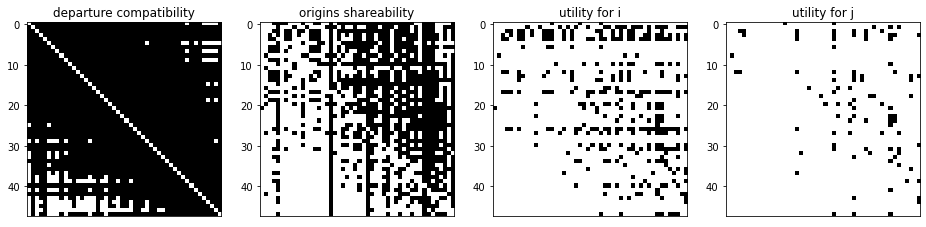

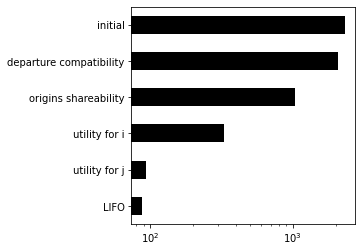

01-03-22 11:54:36-INFO-Degree 2 	Completed
01-03-22 11:54:36-INFO-trips to extend at degree 2 : 181
01-03-22 11:54:36-INFO-At degree 2 feasible extensions found out of 253 searched
01-03-22 11:54:36-INFO-Degree 3 	Completed
01-03-22 11:54:36-INFO-trips to extend at degree 3 : 253
01-03-22 11:54:37-INFO-At degree 3 feasible extensions found out of 280 searched
01-03-22 11:54:37-INFO-Degree 4 	Completed
01-03-22 11:54:37-INFO-trips to extend at degree 4 : 280
01-03-22 11:54:37-INFO-At degree 4 feasible extensions found out of 115 searched
01-03-22 11:54:37-INFO-Degree 5 	Completed
01-03-22 11:54:37-INFO-trips to extend at degree 5 : 115
01-03-22 11:54:38-INFO-At degree 5 feasible extensions found out of 9 searched
01-03-22 11:54:38-INFO-Degree 6 	Completed
01-03-22 11:54:38-INFO-trips to extend at degree 6 : 9
01-03-22 11:54:38-INFO-At degree 6 feasible extensions found out of 0 searched
01-03-22 11:54:38-INFO-Degree 7 	Completed
01-03-22 11:54:38-INFO-No more trips to exted at degree 7


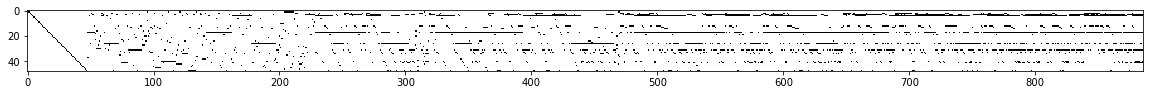

01-03-22 11:54:39-INFO-Problem solution: Optimal. 
Total costs for single trips:         21,621 
reduced by matching to:               15,139
01-03-22 11:54:39-INFO-Calculations  completed
01-03-22 11:54:40-INFO-DotMap(VehHourTrav=15034, VehHourTrav_ns=21621, PassHourTrav=25209, PassHourTrav_ns=21621, PassUtility=321.5643, PassUtility_ns=335.3415, mean_lambda=0.40076666254482507, revenue_s=22702.05, revenue_ns=32431.5, Fare_Discount=-0.30000000000000004, nR=48, SINGLE=19, PAIRS=7, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=1, shared_ratio=0.6041666666666667, fleet_size_nonshared=29.0, fleet_size_shared=18.0, lambda_shared=0.40076666254482507)


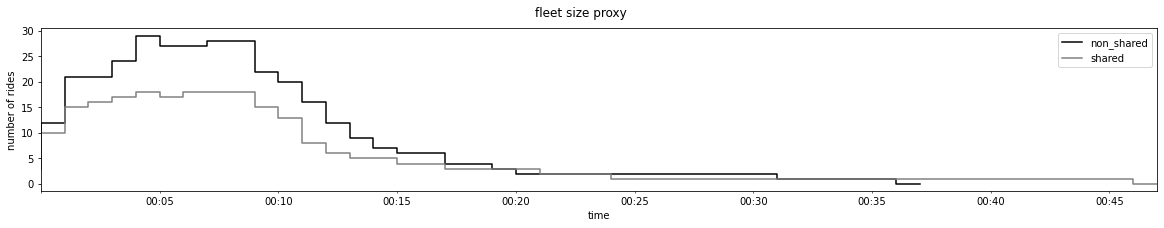

In [13]:
inData = ExMAS.main(inData, params, plot = True)

# Part III

In [2]:
import multiprocessing as mp
import ExMAS_wrapper as ExMASFunc
from datetime import datetime, timedelta
import pickle

In [3]:
from time import sleep
from tqdm import tqdm
import gc

In [4]:
params = ExMAS.utils.get_config('ExMAS/data/configs/nyc.json')
inData = ExMAS.utils.load_G(inData, params, stats = True)

In [5]:
batches, trips = utils_nyc.nyc_csv_prepare_batches(inData, params)
N = batches.ngroups

In [6]:
def foo(n):
    return utils_nyc.nyc_pick_batch(batches, trips, inData, params, n)

In [ ]:
pool = mp.Pool(mp.cpu_count())
inDatas = [pool.apply(foo, args=(j)) for j in range(0, 200)]
pool.close()

In [ ]:
pool = mp.Pool(mp.cpu_count())
inDatas = [pool.apply(utils_nyc.nyc_pick_batch, args=(batches, trips, inData, params, j)) for j in range(0, 100)]
pool.close()

In [6]:
inDatas = []
for k in tqdm(range(30)):
    sleep(0.01)
    pool = mp.Pool(mp.cpu_count())
    inDatas.append([pool.apply(utils_nyc.nyc_pick_batch, args=(batches, trips, inData, params, j))
                    for j in range(k*mp.cpu_count(), (k+1)*mp.cpu_count())])
    pool.close()
    gc.collect()

 47%|█████████████████████████████████████▊                                           | 14/30 [24:23<27:52, 104.53s/it]


MaybeEncodingError: Error sending result: 'DotMap(passengers=              pickup_datetime     dropoff_datetime  trip_duration  ...   dist            treq           ttrav
id                                                                 ...                                       
id2227519 2016-01-04 01:10:00  2016-01-04 01:18:06            486  ...   4505 3 days 01:09:43 0 days 01:15:05
id2938226 2016-01-04 01:10:23  2016-01-04 01:19:50            567  ...   4358 3 days 01:10:06 0 days 01:12:38
id2094370 2016-01-04 01:11:02  2016-01-04 01:15:54            292  ...   2702 3 days 01:10:45 0 days 00:45:02
id2023775 2016-01-04 01:11:43  2016-01-04 01:19:28            465  ...   1995 3 days 01:11:26 0 days 00:33:15
id0220986 2016-01-04 01:13:33  2016-01-04 01:19:20            347  ...   2849 3 days 01:13:16 0 days 00:47:29
id3063095 2016-01-04 01:14:09  2016-01-04 01:17:58            229  ...   1140 3 days 01:13:52 0 days 00:19:00
id1542251 2016-01-04 01:15:36  2016-01-04 01:52:57           2241  ...  15486 3 days 01:15:19 0 days 04:18:06
id3740694 2016-01-04 01:15:46  2016-01-04 01:31:26            940  ...   5882 3 days 01:15:29 0 days 01:38:02
id2660975 2016-01-04 01:16:28  2016-01-04 01:17:49             81  ...    818 3 days 01:16:11 0 days 00:13:38
id3786027 2016-01-04 01:17:04  2016-01-04 01:38:03           1259  ...  10687 3 days 01:16:47 0 days 02:58:07
id1127443 2016-01-04 01:17:25  2016-01-04 01:20:24            179  ...   1108 3 days 01:17:08 0 days 00:18:28

[11 rows x 9 columns], requests=              pickup_datetime     dropoff_datetime  trip_duration  ...            treq           ttrav     pax_id
id                                                                 ...                                           
id2227519 2016-01-04 01:10:00  2016-01-04 01:18:06            486  ... 3 days 01:09:43 0 days 01:15:05  id2227519
id2938226 2016-01-04 01:10:23  2016-01-04 01:19:50            567  ... 3 days 01:10:06 0 days 01:12:38  id2938226
id2094370 2016-01-04 01:11:02  2016-01-04 01:15:54            292  ... 3 days 01:10:45 0 days 00:45:02  id2094370
id2023775 2016-01-04 01:11:43  2016-01-04 01:19:28            465  ... 3 days 01:11:26 0 days 00:33:15  id2023775
id0220986 2016-01-04 01:13:33  2016-01-04 01:19:20            347  ... 3 days 01:13:16 0 days 00:47:29  id0220986
id3063095 2016-01-04 01:14:09  2016-01-04 01:17:58            229  ... 3 days 01:13:52 0 days 00:19:00  id3063095
id1542251 2016-01-04 01:15:36  2016-01-04 01:52:57           2241  ... 3 days 01:15:19 0 days 04:18:06  id1542251
id3740694 2016-01-04 01:15:46  2016-01-04 01:31:26            940  ... 3 days 01:15:29 0 days 01:38:02  id3740694
id2660975 2016-01-04 01:16:28  2016-01-04 01:17:49             81  ... 3 days 01:16:11 0 days 00:13:38  id2660975
id3786027 2016-01-04 01:17:04  2016-01-04 01:38:03           1259  ... 3 days 01:16:47 0 days 02:58:07  id3786027
id1127443 2016-01-04 01:17:25  2016-01-04 01:20:24            179  ... 3 days 01:17:08 0 days 00:18:28  id1127443

[11 rows x 10 columns], G=<networkx.classes.multidigraph.MultiDiGraph object at 0x0000012FF9A98370>, nodes=                    y          x          highway  street_count  ref
42421728    40.798048 -73.960044  traffic_signals             3  NaN
42421731    40.798654 -73.961474  traffic_signals             4  NaN
42421737    40.799244 -73.962873  traffic_signals             4  NaN
42421741    40.800429 -73.965691  traffic_signals             4  NaN
42421745    40.801398 -73.967996  traffic_signals             4  NaN
...               ...        ...              ...           ...  ...
9338511504  40.859313 -73.934248              NaN             3  NaN
9410604941  40.707157 -74.015307              NaN             4  NaN
9421943093  40.757176 -73.999387              NaN             3  NaN
9490559521  40.800970 -73.931776              NaN             3  NaN
9515699765  40.815168 -73.958536              NaN             3  NaN

[4581 rows x 5 columns], skim=            42421728    42435337    42432736    42421731    ...  6331080434  7561204347  7684225787  7890202648
42421728             0          85          86         138  ...      100000      100000      100000      100000
42421731           138         223         224           0  ...      100000      100000      100000      100000
42421737           272         358         359         134  ...      100000      100000      100000      100000
42421741           544         629         630         406  ...      100000      100000      100000      100000
42421745           766         851         852         628  ...      100000      100000      100000      100000
...                ...         ...         ...         ...  ...         ...         ...         ...         ...
9338511504        7544        7630        7458        7475  ...      100000      100000      100000      100000
9410604941       11488       11403       11574       11626  ...      100000      100000      100000      100000
9421943093        6447        6362        6534        6311  ...      100000      100000      100000      100000
9490559521        3389        3474        3303        3477  ...      100000      100000      100000      100000
9515699765        2326        2411        2239        2200  ...      100000      100000      100000      100000

[4581 rows x 4581 columns], stats=DotMap(center=42436475, radius=7484.0))'. Reason: 'MemoryError()'

In [6]:
def foo(n):
    return utils_nyc.nyc_pick_batch(batches, trips, inData, params, n)

In [ ]:
with mp.Pool(processes=4) as pool:
    inDatas = pool.imap(foo, range(2))
    inDatas = [x for x in inDatas]

In [ ]:
inDatas

In [ ]:
for j in range(5000):
    try:
        inDatas.append(utils_nyc.nyc_pick_batch(batches, trips, inData, params, j))

    except:
        pass

with open('batches_5000.obj', 'wb') as file:
    pickle.dump(inDatas, file)

# Part IV

In [3]:
import multiprocessing as mp
import ExMAS_wrapper as ExMASFunc
from datetime import datetime, timedelta
import pickle

In [4]:
with open('batches_5000.obj', 'rb') as file:
  inDatas = pickle.load(file)

In [5]:
len(inDatas)

4912

In [9]:
def foo(inp):
    try:
        ExMAS.main(inp, params, False)
    except:
        return [None]

In [24]:
results = []
for inp in inDatas:
    try:
        results.append(ExMAS.main(inp, params, False));
    except:
        pass

07-03-22 11:43:51-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:43:51-INFO-creating combinations
07-03-22 11:43:51-INFO-1980	 nR*(nR-1)
07-03-22 11:43:51-INFO-Reduction of feasible pairs by 99.09%
07-03-22 11:43:51-INFO-Degree 2 	Completed
07-03-22 11:43:51-INFO-trips to extend at degree 2 : 142
07-03-22 11:43:51-INFO-At degree 2 feasible extensions found out of 97 searched
07-03-22 11:43:51-INFO-Degree 3 	Completed
07-03-22 11:43:51-INFO-trips to extend at degree 3 : 97
07-03-22 11:43:52-INFO-At degree 3 feasible extensions found out of 22 searched
07-03-22 11:43:52-INFO-Degree 4 	Completed
07-03-22 11:43:52-INFO-trips to extend at degree 4 : 22
07-03-22 11:43:52-INFO-At degree 4 feasible extensions found out of 1 searched
07-03-22 11:43:52-INFO-Degree 5 	Completed
07-03-22 11:43:52-INFO-trips to extend at degree 5 : 1
07-03-22 11:43:52-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:43:52-INFO-Degree 6 	Completed
07-03-22

07-03-22 11:44:03-INFO-Calculations  completed
07-03-22 11:44:03-INFO-DotMap(VehHourTrav=28076, VehHourTrav_ns=38452, PassHourTrav=43592, PassHourTrav_ns=38452, PassUtility=559.3337999999999, PassUtility_ns=596.5250000000001, mean_lambda=0.3120401440753625, revenue_s=40374.6, revenue_ns=57678.0, Fare_Discount=-0.30000000000000004, nR=96, SINGLE=31, PAIRS=16, TRIPLES=8, QUADRIPLES=1, QUINTETS=1, PLUS5=0, shared_ratio=0.6770833333333333, fleet_size_nonshared=58.0, fleet_size_shared=33.0, lambda_shared=0.3120401440753625)
07-03-22 11:44:03-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:44:03-INFO-creating combinations
07-03-22 11:44:03-INFO-5402	 nR*(nR-1)
07-03-22 11:44:03-INFO-Reduction of feasible pairs by 98.84%
07-03-22 11:44:03-INFO-Degree 2 	Completed
07-03-22 11:44:03-INFO-trips to extend at degree 2 : 231
07-03-22 11:44:04-INFO-At degree 2 feasible extensions found out of 81 searched
07-03-22 11:44:04-INFO-Degree 3 	Completed
07-03-22 11:44:04

07-03-22 11:44:11-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:44:11-INFO-Degree 6 	Completed
07-03-22 11:44:11-INFO-No more trips to exted at degree 6
07-03-22 11:44:11-INFO-Matching 65 trips to 558 rides in order to minimize u_veh
07-03-22 11:44:11-INFO-Problem solution: Optimal. 
Total costs for single trips:         26,607 
reduced by matching to:               18,545
07-03-22 11:44:11-INFO-Calculations  completed
07-03-22 11:44:11-INFO-DotMap(VehHourTrav=18470, VehHourTrav_ns=26607, PassHourTrav=29871, PassHourTrav_ns=26607, PassUtility=389.2551, PassUtility_ns=412.77299999999997, mean_lambda=0.4152887240508937, revenue_s=27937.35, revenue_ns=39910.5, Fare_Discount=-0.30000000000000004, nR=65, SINGLE=30, PAIRS=5, TRIPLES=4, QUADRIPLES=2, QUINTETS=1, PLUS5=0, shared_ratio=0.5384615384615384, fleet_size_nonshared=43.0, fleet_size_shared=25.0, lambda_shared=0.4152887240508937)
07-03-22 11:44:11-INFO-Initializing pairwise trip shareability between 100 and 1

07-03-22 11:44:16-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:44:16-INFO-Degree 5 	Completed
07-03-22 11:44:16-INFO-No more trips to exted at degree 5
07-03-22 11:44:16-INFO-Matching 58 trips to 383 rides in order to minimize u_veh
07-03-22 11:44:16-INFO-Problem solution: Optimal. 
Total costs for single trips:         29,262 
reduced by matching to:               20,692
07-03-22 11:44:17-INFO-Calculations  completed
07-03-22 11:44:17-INFO-DotMap(VehHourTrav=20572, VehHourTrav_ns=29262, PassHourTrav=34055, PassHourTrav_ns=29262, PassUtility=432.722925, PassUtility_ns=453.88650000000007, mean_lambda=0.3659578102314459, revenue_s=30725.1, revenue_ns=43893.0, Fare_Discount=-0.30000000000000004, nR=58, SINGLE=24, PAIRS=8, TRIPLES=2, QUADRIPLES=3, QUINTETS=0, PLUS5=0, shared_ratio=0.5862068965517242, fleet_size_nonshared=32.0, fleet_size_shared=20.0, lambda_shared=0.3659578102314459)
07-03-22 11:44:17-INFO-Initializing pairwise trip shareability between 100 and 

07-03-22 11:44:21-INFO-trips to extend at degree 3 : 70
07-03-22 11:44:21-INFO-At degree 3 feasible extensions found out of 6 searched
07-03-22 11:44:21-INFO-Degree 4 	Completed
07-03-22 11:44:21-INFO-trips to extend at degree 4 : 6
07-03-22 11:44:21-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:44:21-INFO-Degree 5 	Completed
07-03-22 11:44:21-INFO-No more trips to exted at degree 5
07-03-22 11:44:21-INFO-Matching 54 trips to 276 rides in order to minimize u_veh
07-03-22 11:44:21-INFO-Problem solution: Optimal. 
Total costs for single trips:         23,260 
reduced by matching to:               17,755
07-03-22 11:44:21-INFO-Calculations  completed
07-03-22 11:44:21-INFO-DotMap(VehHourTrav=17650, VehHourTrav_ns=23260, PassHourTrav=25174, PassHourTrav_ns=23260, PassUtility=335.3930500000001, PassUtility_ns=360.80299999999994, mean_lambda=0.3263189093064611, revenue_s=24423.0, revenue_ns=34890.0, Fare_Discount=-0.3, nR=54, SINGLE=27, PAIRS=7, TRIPLES=3, QUADRIPL

07-03-22 11:44:28-INFO-creating combinations
07-03-22 11:44:28-INFO-2970	 nR*(nR-1)
07-03-22 11:44:28-INFO-Reduction of feasible pairs by 99.27%
07-03-22 11:44:28-INFO-Degree 2 	Completed
07-03-22 11:44:28-INFO-trips to extend at degree 2 : 150
07-03-22 11:44:28-INFO-At degree 2 feasible extensions found out of 78 searched
07-03-22 11:44:28-INFO-Degree 3 	Completed
07-03-22 11:44:28-INFO-trips to extend at degree 3 : 78
07-03-22 11:44:28-INFO-At degree 3 feasible extensions found out of 14 searched
07-03-22 11:44:28-INFO-Degree 4 	Completed
07-03-22 11:44:28-INFO-trips to extend at degree 4 : 14
07-03-22 11:44:28-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:44:28-INFO-Degree 5 	Completed
07-03-22 11:44:28-INFO-No more trips to exted at degree 5
07-03-22 11:44:28-INFO-Matching 55 trips to 297 rides in order to minimize u_veh
07-03-22 11:44:29-INFO-Problem solution: Optimal. 
Total costs for single trips:         23,303 
reduced by matching to:               1

07-03-22 11:44:31-INFO-No more trips to exted at degree 4
07-03-22 11:44:31-INFO-Matching 19 trips to 43 rides in order to minimize u_veh
07-03-22 11:44:31-INFO-Problem solution: Optimal. 
Total costs for single trips:          8,598 
reduced by matching to:                6,589
07-03-22 11:44:31-INFO-Calculations  completed
07-03-22 11:44:31-INFO-DotMap(VehHourTrav=6544, VehHourTrav_ns=8598, PassHourTrav=9448, PassHourTrav_ns=8598, PassUtility=123.8568, PassUtility_ns=133.3635, mean_lambda=0.31171450737005435, revenue_s=9027.9, revenue_ns=12897.0, Fare_Discount=-0.30000000000000004, nR=19, SINGLE=10, PAIRS=3, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4736842105263158, fleet_size_nonshared=11.0, fleet_size_shared=8.0, lambda_shared=0.31171450737005435)
07-03-22 11:44:31-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:44:31-INFO-creating combinations
07-03-22 11:44:31-INFO-462	 nR*(nR-1)
07-03-22 11:44:31-INFO-Reduction of feasible 

07-03-22 11:44:32-INFO-Degree 5 	Completed
07-03-22 11:44:32-INFO-No more trips to exted at degree 5
07-03-22 11:44:32-INFO-Matching 13 trips to 32 rides in order to minimize u_veh
07-03-22 11:44:33-INFO-Problem solution: Optimal. 
Total costs for single trips:          6,379 
reduced by matching to:                5,080
07-03-22 11:44:33-INFO-Calculations  completed
07-03-22 11:44:33-INFO-DotMap(VehHourTrav=5050, VehHourTrav_ns=6379, PassHourTrav=7029, PassHourTrav_ns=6379, PassUtility=93.65615, PassUtility_ns=98.92850000000001, mean_lambda=0.28263707571801566, revenue_s=6697.95, revenue_ns=9568.5, Fare_Discount=-0.30000000000000004, nR=13, SINGLE=5, PAIRS=2, TRIPLES=0, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.6153846153846154, fleet_size_nonshared=11.0, fleet_size_shared=6.0, lambda_shared=0.28263707571801566)
07-03-22 11:44:33-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:44:33-INFO-creating combinations
07-03-22 11:44:33-INFO-306	 nR*(

07-03-22 11:44:34-INFO-creating combinations
07-03-22 11:44:34-INFO-42	 nR*(nR-1)
07-03-22 11:44:34-INFO-Degree 2 	Completed
07-03-22 11:44:34-INFO-No more trips to exted at degree 2
07-03-22 11:44:34-INFO-Matching 7 trips to 7 rides in order to minimize u_veh
07-03-22 11:44:34-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,510 
reduced by matching to:                2,510
07-03-22 11:44:34-INFO-Calculations  completed
07-03-22 11:44:34-INFO-DotMap(VehHourTrav=2510, VehHourTrav_ns=2510, PassHourTrav=2510, PassHourTrav_ns=2510, PassUtility=38.954499999999996, PassUtility_ns=38.954499999999996, mean_lambda=nan, revenue_s=2635.5, revenue_ns=3765.0, Fare_Discount=-0.3, nR=7, SINGLE=7, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=5.0, fleet_size_shared=5.0, lambda_shared=0)
07-03-22 11:44:34-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:44:34-INFO-creating combinations
07-03-22 

07-03-22 11:44:35-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:44:35-INFO-creating combinations
07-03-22 11:44:35-INFO-110	 nR*(nR-1)
07-03-22 11:44:36-INFO-Reduction of feasible pairs by 100.00%
07-03-22 11:44:36-INFO-Degree 2 	Completed
07-03-22 11:44:36-INFO-trips to extend at degree 2 : 2
07-03-22 11:44:36-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:44:36-INFO-Degree 3 	Completed
07-03-22 11:44:36-INFO-No more trips to exted at degree 3
07-03-22 11:44:36-INFO-Matching 11 trips to 13 rides in order to minimize u_veh
07-03-22 11:44:36-INFO-Problem solution: Optimal. 
Total costs for single trips:          4,216 
reduced by matching to:                4,216
07-03-22 11:44:36-INFO-Calculations  completed
07-03-22 11:44:36-INFO-DotMap(VehHourTrav=4216, VehHourTrav_ns=4216, PassHourTrav=4216, PassHourTrav_ns=4216, PassUtility=65.3795, PassUtility_ns=65.3795, mean_lambda=nan, revenue_s=4426.799999999999, revenue_ns=6324.0

07-03-22 11:44:37-INFO-Problem solution: Optimal. 
Total costs for single trips:          3,199 
reduced by matching to:                3,199
07-03-22 11:44:37-INFO-Calculations  completed
07-03-22 11:44:37-INFO-DotMap(VehHourTrav=3199, VehHourTrav_ns=3199, PassHourTrav=3199, PassHourTrav_ns=3199, PassUtility=49.648999999999994, PassUtility_ns=49.648999999999994, mean_lambda=nan, revenue_s=3358.95, revenue_ns=4798.5, Fare_Discount=-0.30000000000000004, nR=9, SINGLE=9, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=5.0, fleet_size_shared=5.0, lambda_shared=0)
07-03-22 11:44:37-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:44:37-INFO-creating combinations
07-03-22 11:44:37-INFO-182	 nR*(nR-1)
07-03-22 11:44:37-INFO-Reduction of feasible pairs by 99.95%
07-03-22 11:44:37-INFO-Degree 2 	Completed
07-03-22 11:44:37-INFO-trips to extend at degree 2 : 9
07-03-22 11:44:37-INFO-At degree 2 feasible extensions f

07-03-22 11:44:39-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:44:39-INFO-creating combinations
07-03-22 11:44:39-INFO-552	 nR*(nR-1)
07-03-22 11:44:39-INFO-Reduction of feasible pairs by 99.91%
07-03-22 11:44:39-INFO-Degree 2 	Completed
07-03-22 11:44:39-INFO-trips to extend at degree 2 : 18
07-03-22 11:44:39-INFO-At degree 2 feasible extensions found out of 1 searched
07-03-22 11:44:39-INFO-Degree 3 	Completed
07-03-22 11:44:39-INFO-trips to extend at degree 3 : 1
07-03-22 11:44:39-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:44:39-INFO-Degree 4 	Completed
07-03-22 11:44:39-INFO-No more trips to exted at degree 4
07-03-22 11:44:39-INFO-Matching 24 trips to 43 rides in order to minimize u_veh
07-03-22 11:44:39-INFO-Problem solution: Optimal. 
Total costs for single trips:          9,738 
reduced by matching to:                8,614
07-03-22 11:44:39-INFO-Calculations  completed
07-03-22 11:44:39-INFO-DotMap(VehHourTrav

07-03-22 11:44:40-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:44:40-INFO-creating combinations
07-03-22 11:44:40-INFO-930	 nR*(nR-1)
07-03-22 11:44:40-INFO-Reduction of feasible pairs by 99.79%
07-03-22 11:44:40-INFO-Degree 2 	Completed
07-03-22 11:44:40-INFO-trips to extend at degree 2 : 44
07-03-22 11:44:41-INFO-At degree 2 feasible extensions found out of 8 searched
07-03-22 11:44:41-INFO-Degree 3 	Completed
07-03-22 11:44:41-INFO-trips to extend at degree 3 : 8
07-03-22 11:44:41-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:44:41-INFO-Degree 4 	Completed
07-03-22 11:44:41-INFO-No more trips to exted at degree 4
07-03-22 11:44:41-INFO-Matching 31 trips to 83 rides in order to minimize u_veh
07-03-22 11:44:41-INFO-Problem solution: Optimal. 
Total costs for single trips:         12,769 
reduced by matching to:               10,634
07-03-22 11:44:41-INFO-Calculations  completed
07-03-22 11:44:41-INFO-DotMap(VehHourTrav

07-03-22 11:44:43-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 11:44:43-INFO-Degree 4 	Completed
07-03-22 11:44:43-INFO-trips to extend at degree 4 : 2
07-03-22 11:44:43-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:44:43-INFO-Degree 5 	Completed
07-03-22 11:44:43-INFO-No more trips to exted at degree 5
07-03-22 11:44:43-INFO-Matching 39 trips to 117 rides in order to minimize u_veh
07-03-22 11:44:43-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,391 
reduced by matching to:               10,810
07-03-22 11:44:43-INFO-Calculations  completed
07-03-22 11:44:43-INFO-DotMap(VehHourTrav=10690, VehHourTrav_ns=13391, PassHourTrav=14982, PassHourTrav_ns=13391, PassUtility=196.41439999999997, PassUtility_ns=207.7765, mean_lambda=0.2712274064733081, revenue_s=14060.55, revenue_ns=20086.5, Fare_Discount=-0.30000000000000004, nR=39, SINGLE=19, PAIRS=8, TRIPLES=0, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.512820

07-03-22 11:44:47-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:44:47-INFO-creating combinations
07-03-22 11:44:47-INFO-1806	 nR*(nR-1)
07-03-22 11:44:47-INFO-Reduction of feasible pairs by 99.68%
07-03-22 11:44:47-INFO-Degree 2 	Completed
07-03-22 11:44:47-INFO-trips to extend at degree 2 : 72
07-03-22 11:44:47-INFO-At degree 2 feasible extensions found out of 45 searched
07-03-22 11:44:47-INFO-Degree 3 	Completed
07-03-22 11:44:47-INFO-trips to extend at degree 3 : 45
07-03-22 11:44:47-INFO-At degree 3 feasible extensions found out of 14 searched
07-03-22 11:44:47-INFO-Degree 4 	Completed
07-03-22 11:44:47-INFO-trips to extend at degree 4 : 14
07-03-22 11:44:47-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:44:47-INFO-Degree 5 	Completed
07-03-22 11:44:47-INFO-No more trips to exted at degree 5
07-03-22 11:44:47-INFO-Matching 43 trips to 174 rides in order to minimize u_veh
07-03-22 11:44:47-INFO-Problem solution: Optima

07-03-22 11:44:52-INFO-At degree 2 feasible extensions found out of 20 searched
07-03-22 11:44:52-INFO-Degree 3 	Completed
07-03-22 11:44:52-INFO-trips to extend at degree 3 : 20
07-03-22 11:44:52-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 11:44:52-INFO-Degree 4 	Completed
07-03-22 11:44:52-INFO-trips to extend at degree 4 : 1
07-03-22 11:44:52-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:44:52-INFO-Degree 5 	Completed
07-03-22 11:44:52-INFO-No more trips to exted at degree 5
07-03-22 11:44:52-INFO-Matching 49 trips to 171 rides in order to minimize u_veh
07-03-22 11:44:52-INFO-Problem solution: Optimal. 
Total costs for single trips:         19,707 
reduced by matching to:               15,727
07-03-22 11:44:52-INFO-Calculations  completed
07-03-22 11:44:52-INFO-DotMap(VehHourTrav=15622, VehHourTrav_ns=19707, PassHourTrav=21912, PassHourTrav_ns=19707, PassUtility=290.85745000000003, PassUtility_ns=305.71950000000004, mean_lambda=0

07-03-22 11:44:54-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:44:54-INFO-creating combinations
07-03-22 11:44:54-INFO-2162	 nR*(nR-1)
07-03-22 11:44:54-INFO-Reduction of feasible pairs by 99.64%
07-03-22 11:44:54-INFO-Degree 2 	Completed
07-03-22 11:44:55-INFO-trips to extend at degree 2 : 71
07-03-22 11:44:55-INFO-At degree 2 feasible extensions found out of 14 searched
07-03-22 11:44:55-INFO-Degree 3 	Completed
07-03-22 11:44:55-INFO-trips to extend at degree 3 : 14
07-03-22 11:44:55-INFO-At degree 3 feasible extensions found out of 3 searched
07-03-22 11:44:55-INFO-Degree 4 	Completed
07-03-22 11:44:55-INFO-trips to extend at degree 4 : 3
07-03-22 11:44:55-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:44:55-INFO-Degree 5 	Completed
07-03-22 11:44:55-INFO-No more trips to exted at degree 5
07-03-22 11:44:55-INFO-Matching 47 trips to 135 rides in order to minimize u_veh
07-03-22 11:44:55-INFO-Problem solution: Optimal.

07-03-22 11:44:57-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:44:57-INFO-Degree 5 	Completed
07-03-22 11:44:57-INFO-No more trips to exted at degree 5
07-03-22 11:44:57-INFO-Matching 52 trips to 151 rides in order to minimize u_veh
07-03-22 11:44:57-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,667 
reduced by matching to:               13,794
07-03-22 11:44:57-INFO-Calculations  completed
07-03-22 11:44:57-INFO-DotMap(VehHourTrav=13659, VehHourTrav_ns=16667, PassHourTrav=18173, PassHourTrav_ns=16667, PassUtility=247.250675, PassUtility_ns=258.57700000000006, mean_lambda=0.2786344680438366, revenue_s=17500.35, revenue_ns=25000.5, Fare_Discount=-0.30000000000000004, nR=52, SINGLE=25, PAIRS=9, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5192307692307692, fleet_size_nonshared=32.0, fleet_size_shared=23.0, lambda_shared=0.2786344680438366)
07-03-22 11:44:57-INFO-Initializing pairwise trip shareability between 100 and

07-03-22 11:44:59-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:44:59-INFO-creating combinations
07-03-22 11:44:59-INFO-1806	 nR*(nR-1)
07-03-22 11:44:59-INFO-Reduction of feasible pairs by 99.52%
07-03-22 11:44:59-INFO-Degree 2 	Completed
07-03-22 11:44:59-INFO-trips to extend at degree 2 : 96
07-03-22 11:45:00-INFO-At degree 2 feasible extensions found out of 32 searched
07-03-22 11:45:00-INFO-Degree 3 	Completed
07-03-22 11:45:00-INFO-trips to extend at degree 3 : 32
07-03-22 11:45:00-INFO-At degree 3 feasible extensions found out of 5 searched
07-03-22 11:45:00-INFO-Degree 4 	Completed
07-03-22 11:45:00-INFO-trips to extend at degree 4 : 5
07-03-22 11:45:00-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:45:00-INFO-Degree 5 	Completed
07-03-22 11:45:00-INFO-No more trips to exted at degree 5
07-03-22 11:45:00-INFO-Matching 43 trips to 176 rides in order to minimize u_veh
07-03-22 11:45:00-INFO-Problem solution: Optimal.

07-03-22 11:45:02-INFO-Calculations  completed
07-03-22 11:45:02-INFO-DotMap(VehHourTrav=13519, VehHourTrav_ns=16837, PassHourTrav=18292, PassHourTrav_ns=16837, PassUtility=248.5266, PassUtility_ns=261.21200000000005, mean_lambda=0.26001979218208804, revenue_s=17678.85, revenue_ns=25255.5, Fare_Discount=-0.30000000000000004, nR=47, SINGLE=22, PAIRS=11, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5319148936170213, fleet_size_nonshared=29.0, fleet_size_shared=22.0, lambda_shared=0.26001979218208804)
07-03-22 11:45:02-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:45:02-INFO-creating combinations
07-03-22 11:45:02-INFO-3192	 nR*(nR-1)
07-03-22 11:45:02-INFO-Reduction of feasible pairs by 99.28%
07-03-22 11:45:02-INFO-Degree 2 	Completed
07-03-22 11:45:02-INFO-trips to extend at degree 2 : 151
07-03-22 11:45:02-INFO-At degree 2 feasible extensions found out of 41 searched
07-03-22 11:45:02-INFO-Degree 3 	Completed
07-03-22 11:45:02-INFO

07-03-22 11:45:05-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:45:05-INFO-creating combinations
07-03-22 11:45:05-INFO-1806	 nR*(nR-1)
07-03-22 11:45:05-INFO-Reduction of feasible pairs by 99.43%
07-03-22 11:45:05-INFO-Degree 2 	Completed
07-03-22 11:45:05-INFO-trips to extend at degree 2 : 104
07-03-22 11:45:05-INFO-At degree 2 feasible extensions found out of 30 searched
07-03-22 11:45:05-INFO-Degree 3 	Completed
07-03-22 11:45:05-INFO-trips to extend at degree 3 : 30
07-03-22 11:45:05-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 11:45:05-INFO-Degree 4 	Completed
07-03-22 11:45:05-INFO-trips to extend at degree 4 : 1
07-03-22 11:45:05-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:45:05-INFO-Degree 5 	Completed
07-03-22 11:45:05-INFO-No more trips to exted at degree 5
07-03-22 11:45:05-INFO-Matching 43 trips to 178 rides in order to minimize u_veh
07-03-22 11:45:05-INFO-Problem solution: Optimal

07-03-22 11:45:08-INFO-Degree 4 	Completed
07-03-22 11:45:08-INFO-trips to extend at degree 4 : 1
07-03-22 11:45:08-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:45:08-INFO-Degree 5 	Completed
07-03-22 11:45:08-INFO-No more trips to exted at degree 5
07-03-22 11:45:09-INFO-Matching 59 trips to 242 rides in order to minimize u_veh
07-03-22 11:45:09-INFO-Problem solution: Optimal. 
Total costs for single trips:         20,975 
reduced by matching to:               16,593
07-03-22 11:45:09-INFO-Calculations  completed
07-03-22 11:45:09-INFO-DotMap(VehHourTrav=16428, VehHourTrav_ns=20975, PassHourTrav=22713, PassHourTrav_ns=20975, PassUtility=305.130875, PassUtility_ns=325.4185, mean_lambda=0.28603133159268934, revenue_s=22023.75, revenue_ns=31462.5, Fare_Discount=-0.3, nR=59, SINGLE=25, PAIRS=11, TRIPLES=4, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.576271186440678, fleet_size_nonshared=35.0, fleet_size_shared=24.0, lambda_shared=0.28603133159268934)
07-0

07-03-22 11:45:11-INFO-Degree 3 	Completed
07-03-22 11:45:11-INFO-trips to extend at degree 3 : 1
07-03-22 11:45:11-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:45:11-INFO-Degree 4 	Completed
07-03-22 11:45:11-INFO-No more trips to exted at degree 4
07-03-22 11:45:11-INFO-Matching 30 trips to 47 rides in order to minimize u_veh
07-03-22 11:45:11-INFO-Problem solution: Optimal. 
Total costs for single trips:          8,584 
reduced by matching to:                7,941
07-03-22 11:45:11-INFO-Calculations  completed
07-03-22 11:45:11-INFO-DotMap(VehHourTrav=7866, VehHourTrav_ns=8584, PassHourTrav=8905, PassHourTrav_ns=8584, PassUtility=129.60195000000002, PassUtility_ns=133.2125, mean_lambda=0.1584524396254312, revenue_s=9013.199999999999, revenue_ns=12876.0, Fare_Discount=-0.3000000000000001, nR=30, SINGLE=20, PAIRS=5, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.33333333333333337, fleet_size_nonshared=16.0, fleet_size_shared=13.0, lambda_share

07-03-22 11:45:13-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:45:13-INFO-creating combinations
07-03-22 11:45:13-INFO-870	 nR*(nR-1)
07-03-22 11:45:13-INFO-Reduction of feasible pairs by 99.92%
07-03-22 11:45:13-INFO-Degree 2 	Completed
07-03-22 11:45:13-INFO-trips to extend at degree 2 : 21
07-03-22 11:45:13-INFO-At degree 2 feasible extensions found out of 1 searched
07-03-22 11:45:13-INFO-Degree 3 	Completed
07-03-22 11:45:13-INFO-trips to extend at degree 3 : 1
07-03-22 11:45:13-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:45:13-INFO-Degree 4 	Completed
07-03-22 11:45:13-INFO-No more trips to exted at degree 4
07-03-22 11:45:13-INFO-Matching 30 trips to 52 rides in order to minimize u_veh
07-03-22 11:45:13-INFO-Problem solution: Optimal. 
Total costs for single trips:          8,455 
reduced by matching to:                7,747
07-03-22 11:45:13-INFO-Calculations  completed
07-03-22 11:45:13-INFO-DotMap(VehHourTrav

07-03-22 11:45:16-INFO-Degree 5 	Completed
07-03-22 11:45:16-INFO-trips to extend at degree 5 : 3
07-03-22 11:45:16-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:45:16-INFO-Degree 6 	Completed
07-03-22 11:45:16-INFO-No more trips to exted at degree 6
07-03-22 11:45:16-INFO-Matching 46 trips to 309 rides in order to minimize u_veh
07-03-22 11:45:16-INFO-Problem solution: Optimal. 
Total costs for single trips:         21,108 
reduced by matching to:               14,952
07-03-22 11:45:16-INFO-Calculations  completed
07-03-22 11:45:16-INFO-DotMap(VehHourTrav=14892, VehHourTrav_ns=21108, PassHourTrav=24591, PassHourTrav_ns=21108, PassUtility=311.8959999999999, PassUtility_ns=327.417, mean_lambda=0.4048668201249589, revenue_s=22163.399999999998, revenue_ns=31662.0, Fare_Discount=-0.30000000000000004, nR=46, SINGLE=25, PAIRS=4, TRIPLES=3, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.4565217391304348, fleet_size_nonshared=28.0, fleet_size_shared=19.0, lambda_s

07-03-22 11:45:18-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:45:18-INFO-creating combinations
07-03-22 11:45:18-INFO-992	 nR*(nR-1)
07-03-22 11:45:19-INFO-Reduction of feasible pairs by 99.71%
07-03-22 11:45:19-INFO-Degree 2 	Completed
07-03-22 11:45:19-INFO-trips to extend at degree 2 : 45
07-03-22 11:45:19-INFO-At degree 2 feasible extensions found out of 13 searched
07-03-22 11:45:19-INFO-Degree 3 	Completed
07-03-22 11:45:19-INFO-trips to extend at degree 3 : 13
07-03-22 11:45:19-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:45:19-INFO-Degree 4 	Completed
07-03-22 11:45:19-INFO-No more trips to exted at degree 4
07-03-22 11:45:19-INFO-Matching 32 trips to 90 rides in order to minimize u_veh
07-03-22 11:45:19-INFO-Problem solution: Optimal. 
Total costs for single trips:         11,886 
reduced by matching to:               10,057
07-03-22 11:45:19-INFO-Calculations  completed
07-03-22 11:45:19-INFO-DotMap(VehHourTr

07-03-22 11:45:21-INFO-Calculations  completed
07-03-22 11:45:21-INFO-DotMap(VehHourTrav=10881, VehHourTrav_ns=13386, PassHourTrav=14282, PassHourTrav_ns=13386, PassUtility=198.21619999999996, PassUtility_ns=207.68249999999998, mean_lambda=0.30566320790098767, revenue_s=14055.3, revenue_ns=20079.0, Fare_Discount=-0.30000000000000004, nR=36, SINGLE=22, PAIRS=4, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.38888888888888884, fleet_size_nonshared=20.0, fleet_size_shared=17.0, lambda_shared=0.30566320790098767)
07-03-22 11:45:21-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:45:21-INFO-creating combinations
07-03-22 11:45:21-INFO-2550	 nR*(nR-1)
07-03-22 11:45:21-INFO-Reduction of feasible pairs by 99.06%
07-03-22 11:45:21-INFO-Degree 2 	Completed
07-03-22 11:45:21-INFO-trips to extend at degree 2 : 160
07-03-22 11:45:21-INFO-At degree 2 feasible extensions found out of 102 searched
07-03-22 11:45:21-INFO-Degree 3 	Completed
07-03-22 11:

07-03-22 11:45:23-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:45:23-INFO-creating combinations
07-03-22 11:45:23-INFO-756	 nR*(nR-1)
07-03-22 11:45:24-INFO-Reduction of feasible pairs by 99.65%
07-03-22 11:45:24-INFO-Degree 2 	Completed
07-03-22 11:45:24-INFO-trips to extend at degree 2 : 55
07-03-22 11:45:24-INFO-At degree 2 feasible extensions found out of 12 searched
07-03-22 11:45:24-INFO-Degree 3 	Completed
07-03-22 11:45:24-INFO-trips to extend at degree 3 : 12
07-03-22 11:45:24-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:45:24-INFO-Degree 4 	Completed
07-03-22 11:45:24-INFO-No more trips to exted at degree 4
07-03-22 11:45:24-INFO-Matching 28 trips to 95 rides in order to minimize u_veh
07-03-22 11:45:24-INFO-Problem solution: Optimal. 
Total costs for single trips:         12,168 
reduced by matching to:               10,049
07-03-22 11:45:24-INFO-Calculations  completed
07-03-22 11:45:24-INFO-DotMap(VehHourTr

07-03-22 11:45:26-INFO-Calculations  completed
07-03-22 11:45:26-INFO-DotMap(VehHourTrav=6044, VehHourTrav_ns=7757, PassHourTrav=8320, PassHourTrav_ns=7757, PassUtility=113.160625, PassUtility_ns=120.31300000000002, mean_lambda=0.33339996002398564, revenue_s=8144.849999999999, revenue_ns=11635.5, Fare_Discount=-0.30000000000000004, nR=18, SINGLE=9, PAIRS=3, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5, fleet_size_nonshared=10.0, fleet_size_shared=7.0, lambda_shared=0.33339996002398564)
07-03-22 11:45:26-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:45:26-INFO-creating combinations
07-03-22 11:45:26-INFO-756	 nR*(nR-1)
07-03-22 11:45:26-INFO-Reduction of feasible pairs by 99.97%
07-03-22 11:45:26-INFO-Degree 2 	Completed
07-03-22 11:45:26-INFO-trips to extend at degree 2 : 12
07-03-22 11:45:26-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:45:26-INFO-Degree 3 	Completed
07-03-22 11:45:26-INFO-No more trips

07-03-22 11:45:27-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,448 
reduced by matching to:                2,448
07-03-22 11:45:27-INFO-Calculations  completed
07-03-22 11:45:27-INFO-DotMap(VehHourTrav=2448, VehHourTrav_ns=2448, PassHourTrav=2448, PassHourTrav_ns=2448, PassUtility=38.01299999999999, PassUtility_ns=38.01299999999999, mean_lambda=nan, revenue_s=2570.3999999999996, revenue_ns=3672.0, Fare_Discount=-0.3000000000000001, nR=10, SINGLE=10, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=4.0, fleet_size_shared=4.0, lambda_shared=0)
07-03-22 11:45:27-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:45:27-INFO-creating combinations
07-03-22 11:45:27-INFO-132	 nR*(nR-1)
07-03-22 11:45:27-INFO-Reduction of feasible pairs by 99.94%
07-03-22 11:45:27-INFO-Degree 2 	Completed
07-03-22 11:45:27-INFO-trips to extend at degree 2 : 8
07-03-22 11:45:27-INFO-At degree 2 feasible ex

07-03-22 11:45:29-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:45:29-INFO-creating combinations
07-03-22 11:45:29-INFO-90	 nR*(nR-1)
07-03-22 11:45:29-INFO-Reduction of feasible pairs by 99.96%
07-03-22 11:45:29-INFO-Degree 2 	Completed
07-03-22 11:45:29-INFO-trips to extend at degree 2 : 6
07-03-22 11:45:29-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:45:29-INFO-Degree 3 	Completed
07-03-22 11:45:29-INFO-No more trips to exted at degree 3
07-03-22 11:45:29-INFO-Matching 10 trips to 16 rides in order to minimize u_veh
07-03-22 11:45:29-INFO-Problem solution: Optimal. 
Total costs for single trips:          4,280 
reduced by matching to:                3,898
07-03-22 11:45:29-INFO-Calculations  completed
07-03-22 11:45:29-INFO-DotMap(VehHourTrav=3883, VehHourTrav_ns=4280, PassHourTrav=4472, PassHourTrav_ns=4280, PassUtility=64.13225, PassUtility_ns=66.3835, mean_lambda=0.1701559020044543, revenue_s=4494.0, revenue_ns=642

07-03-22 11:45:30-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,911 
reduced by matching to:                2,472
07-03-22 11:45:30-INFO-Calculations  completed
07-03-22 11:45:30-INFO-DotMap(VehHourTrav=2457, VehHourTrav_ns=2911, PassHourTrav=3332, PassHourTrav_ns=2911, PassUtility=42.3668, PassUtility_ns=45.131, mean_lambda=0.21004784688995215, revenue_s=3056.5499999999997, revenue_ns=4366.5, Fare_Discount=-0.30000000000000004, nR=5, SINGLE=3, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4, fleet_size_nonshared=4.0, fleet_size_shared=3.0, lambda_shared=0.21004784688995215)
07-03-22 11:45:30-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:45:30-INFO-creating combinations
07-03-22 11:45:30-INFO-20	 nR*(nR-1)
07-03-22 11:45:30-INFO-Degree 2 	Completed
07-03-22 11:45:30-INFO-No more trips to exted at degree 2
07-03-22 11:45:30-INFO-Matching 5 trips to 5 rides in order to minimize u_veh
07-03-22 11:45:

07-03-22 11:45:31-INFO-Calculations  completed
07-03-22 11:45:31-INFO-DotMap(VehHourTrav=3996, VehHourTrav_ns=4254, PassHourTrav=4269, PassHourTrav_ns=4254, PassUtility=64.58885, PassUtility_ns=65.9895, mean_lambda=0.16701030927835048, revenue_s=4466.7, revenue_ns=6381.0, Fare_Discount=-0.30000000000000004, nR=11, SINGLE=9, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.18181818181818177, fleet_size_nonshared=8.0, fleet_size_shared=7.0, lambda_shared=0.16701030927835048)
07-03-22 11:45:32-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:45:32-INFO-creating combinations
07-03-22 11:45:32-INFO-42	 nR*(nR-1)
07-03-22 11:45:32-INFO-Degree 2 	Completed
07-03-22 11:45:32-INFO-No more trips to exted at degree 2
07-03-22 11:45:32-INFO-Matching 7 trips to 7 rides in order to minimize u_veh
07-03-22 11:45:32-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,075 
reduced by matching to:                2,075
07-03-22

07-03-22 11:45:33-INFO-Calculations  completed
07-03-22 11:45:33-INFO-DotMap(VehHourTrav=4887, VehHourTrav_ns=5123, PassHourTrav=5338, PassHourTrav_ns=5123, PassUtility=78.0311, PassUtility_ns=79.474, mean_lambda=0.1293911007025761, revenue_s=5379.15, revenue_ns=7684.5, Fare_Discount=-0.30000000000000004, nR=11, SINGLE=9, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.18181818181818177, fleet_size_nonshared=9.0, fleet_size_shared=8.0, lambda_shared=0.1293911007025761)
07-03-22 11:45:33-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:45:33-INFO-creating combinations
07-03-22 11:45:33-INFO-110	 nR*(nR-1)
07-03-22 11:45:33-INFO-Reduction of feasible pairs by 100.00%
07-03-22 11:45:33-INFO-Degree 2 	Completed
07-03-22 11:45:33-INFO-trips to extend at degree 2 : 1
07-03-22 11:45:33-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:45:33-INFO-Degree 3 	Completed
07-03-22 11:45:33-INFO-No more trips to exted at 

07-03-22 11:45:34-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:45:34-INFO-creating combinations
07-03-22 11:45:34-INFO-650	 nR*(nR-1)
07-03-22 11:45:35-INFO-Reduction of feasible pairs by 99.95%
07-03-22 11:45:35-INFO-Degree 2 	Completed
07-03-22 11:45:35-INFO-trips to extend at degree 2 : 14
07-03-22 11:45:35-INFO-At degree 2 feasible extensions found out of 1 searched
07-03-22 11:45:35-INFO-Degree 3 	Completed
07-03-22 11:45:35-INFO-trips to extend at degree 3 : 1
07-03-22 11:45:35-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:45:35-INFO-Degree 4 	Completed
07-03-22 11:45:35-INFO-No more trips to exted at degree 4
07-03-22 11:45:35-INFO-Matching 26 trips to 41 rides in order to minimize u_veh
07-03-22 11:45:35-INFO-Problem solution: Optimal. 
Total costs for single trips:          9,143 
reduced by matching to:                8,066
07-03-22 11:45:35-INFO-Calculations  completed
07-03-22 11:45:35-INFO-DotMap(VehHourTrav

07-03-22 11:45:36-INFO-Matching 31 trips to 81 rides in order to minimize u_veh
07-03-22 11:45:36-INFO-Problem solution: Optimal. 
Total costs for single trips:         12,163 
reduced by matching to:                9,685
07-03-22 11:45:36-INFO-Calculations  completed
07-03-22 11:45:36-INFO-DotMap(VehHourTrav=9625, VehHourTrav_ns=12163, PassHourTrav=13397, PassHourTrav_ns=12163, PassUtility=179.18902500000002, PassUtility_ns=188.6945, mean_lambda=0.29949238578680204, revenue_s=12771.15, revenue_ns=18244.5, Fare_Discount=-0.30000000000000004, nR=31, SINGLE=16, PAIRS=4, TRIPLES=1, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.4838709677419355, fleet_size_nonshared=20.0, fleet_size_shared=11.0, lambda_shared=0.29949238578680204)
07-03-22 11:45:36-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:45:36-INFO-creating combinations
07-03-22 11:45:36-INFO-992	 nR*(nR-1)
07-03-22 11:45:37-INFO-Reduction of feasible pairs by 99.91%
07-03-22 11:45:37-INFO-Deg

07-03-22 11:45:38-INFO-At degree 2 feasible extensions found out of 4 searched
07-03-22 11:45:38-INFO-Degree 3 	Completed
07-03-22 11:45:38-INFO-trips to extend at degree 3 : 4
07-03-22 11:45:38-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:45:38-INFO-Degree 4 	Completed
07-03-22 11:45:38-INFO-No more trips to exted at degree 4
07-03-22 11:45:38-INFO-Matching 42 trips to 89 rides in order to minimize u_veh
07-03-22 11:45:38-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,179 
reduced by matching to:               11,614
07-03-22 11:45:38-INFO-Calculations  completed
07-03-22 11:45:38-INFO-DotMap(VehHourTrav=11524, VehHourTrav_ns=13179, PassHourTrav=13821, PassHourTrav_ns=13179, PassUtility=199.294375, PassUtility_ns=204.504, mean_lambda=0.23853071178174057, revenue_s=13837.949999999999, revenue_ns=19768.5, Fare_Discount=-0.30000000000000004, nR=42, SINGLE=27, PAIRS=6, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.35714

07-03-22 11:45:41-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:45:41-INFO-Degree 5 	Completed
07-03-22 11:45:41-INFO-No more trips to exted at degree 5
07-03-22 11:45:41-INFO-Matching 46 trips to 157 rides in order to minimize u_veh
07-03-22 11:45:41-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,554 
reduced by matching to:               14,627
07-03-22 11:45:41-INFO-Calculations  completed
07-03-22 11:45:42-INFO-DotMap(VehHourTrav=14492, VehHourTrav_ns=18554, PassHourTrav=20153, PassHourTrav_ns=18554, PassUtility=273.40552499999995, PassUtility_ns=287.8015, mean_lambda=0.2866004962779156, revenue_s=19481.699999999997, revenue_ns=27831.0, Fare_Discount=-0.3000000000000001, nR=46, SINGLE=19, PAIRS=9, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5869565217391304, fleet_size_nonshared=27.0, fleet_size_shared=18.0, lambda_shared=0.2866004962779156)
07-03-22 11:45:42-INFO-Initializing pairwise trip shareability between 

07-03-22 11:45:45-INFO-Calculations  completed
07-03-22 11:45:45-INFO-DotMap(VehHourTrav=15827, VehHourTrav_ns=19521, PassHourTrav=21466, PassHourTrav_ns=19521, PassUtility=289.58252500000003, PassUtility_ns=302.892, mean_lambda=0.2631813456111689, revenue_s=20497.05, revenue_ns=29281.5, Fare_Discount=-0.30000000000000004, nR=54, SINGLE=25, PAIRS=10, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.537037037037037, fleet_size_nonshared=34.0, fleet_size_shared=26.0, lambda_shared=0.2631813456111689)
07-03-22 11:45:45-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:45:45-INFO-creating combinations
07-03-22 11:45:45-INFO-2450	 nR*(nR-1)
07-03-22 11:45:45-INFO-Reduction of feasible pairs by 99.59%
07-03-22 11:45:45-INFO-Degree 2 	Completed
07-03-22 11:45:45-INFO-trips to extend at degree 2 : 86
07-03-22 11:45:45-INFO-At degree 2 feasible extensions found out of 18 searched
07-03-22 11:45:45-INFO-Degree 3 	Completed
07-03-22 11:45:45-INFO-trip

07-03-22 11:45:48-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:45:48-INFO-creating combinations
07-03-22 11:45:48-INFO-3080	 nR*(nR-1)
07-03-22 11:45:48-INFO-Reduction of feasible pairs by 99.35%
07-03-22 11:45:48-INFO-Degree 2 	Completed
07-03-22 11:45:48-INFO-trips to extend at degree 2 : 126
07-03-22 11:45:49-INFO-At degree 2 feasible extensions found out of 45 searched
07-03-22 11:45:49-INFO-Degree 3 	Completed
07-03-22 11:45:49-INFO-trips to extend at degree 3 : 45
07-03-22 11:45:49-INFO-At degree 3 feasible extensions found out of 5 searched
07-03-22 11:45:49-INFO-Degree 4 	Completed
07-03-22 11:45:49-INFO-trips to extend at degree 4 : 5
07-03-22 11:45:49-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:45:49-INFO-Degree 5 	Completed
07-03-22 11:45:49-INFO-No more trips to exted at degree 5
07-03-22 11:45:49-INFO-Matching 56 trips to 232 rides in order to minimize u_veh
07-03-22 11:45:49-INFO-Problem solution: Optimal

07-03-22 11:45:52-INFO-Reduction of feasible pairs by 99.43%
07-03-22 11:45:52-INFO-Degree 2 	Completed
07-03-22 11:45:52-INFO-trips to extend at degree 2 : 102
07-03-22 11:45:52-INFO-At degree 2 feasible extensions found out of 22 searched
07-03-22 11:45:52-INFO-Degree 3 	Completed
07-03-22 11:45:52-INFO-trips to extend at degree 3 : 22
07-03-22 11:45:52-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:45:52-INFO-Degree 4 	Completed
07-03-22 11:45:52-INFO-No more trips to exted at degree 4
07-03-22 11:45:53-INFO-Matching 53 trips to 177 rides in order to minimize u_veh
07-03-22 11:45:53-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,198 
reduced by matching to:               14,935
07-03-22 11:45:53-INFO-Calculations  completed
07-03-22 11:45:53-INFO-DotMap(VehHourTrav=14830, VehHourTrav_ns=18198, PassHourTrav=19574, PassHourTrav_ns=18198, PassUtility=269.08662499999997, PassUtility_ns=282.3885, mean_lambda=0.26993712772998013, revenu

07-03-22 11:45:56-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:45:56-INFO-Degree 5 	Completed
07-03-22 11:45:56-INFO-No more trips to exted at degree 5
07-03-22 11:45:56-INFO-Matching 52 trips to 173 rides in order to minimize u_veh
07-03-22 11:45:56-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,206 
reduced by matching to:               13,081
07-03-22 11:45:56-INFO-Calculations  completed
07-03-22 11:45:56-INFO-DotMap(VehHourTrav=13006, VehHourTrav_ns=16206, PassHourTrav=17696, PassHourTrav_ns=16206, PassUtility=240.69565, PassUtility_ns=251.454, mean_lambda=0.34374656253437463, revenue_s=17016.3, revenue_ns=24309.0, Fare_Discount=-0.30000000000000004, nR=52, SINGLE=32, PAIRS=5, TRIPLES=2, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.3846153846153846, fleet_size_nonshared=28.0, fleet_size_shared=22.0, lambda_shared=0.34374656253437463)
07-03-22 11:45:56-INFO-Initializing pairwise trip shareability between 100 and 100 trips.

07-03-22 11:45:59-INFO-Calculations  completed
07-03-22 11:45:59-INFO-DotMap(VehHourTrav=14631, VehHourTrav_ns=17707, PassHourTrav=18905, PassHourTrav_ns=17707, PassUtility=263.73135, PassUtility_ns=274.72400000000005, mean_lambda=0.30959046137895285, revenue_s=18592.35, revenue_ns=26560.5, Fare_Discount=-0.30000000000000004, nR=54, SINGLE=35, PAIRS=6, TRIPLES=1, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.35185185185185186, fleet_size_nonshared=27.0, fleet_size_shared=21.0, lambda_shared=0.30959046137895285)
07-03-22 11:45:59-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:45:59-INFO-creating combinations
07-03-22 11:45:59-INFO-3660	 nR*(nR-1)
07-03-22 11:45:59-INFO-Reduction of feasible pairs by 99.42%
07-03-22 11:45:59-INFO-Degree 2 	Completed
07-03-22 11:45:59-INFO-trips to extend at degree 2 : 126
07-03-22 11:45:59-INFO-At degree 2 feasible extensions found out of 42 searched
07-03-22 11:45:59-INFO-Degree 3 	Completed
07-03-22 11:45:59-INF

07-03-22 11:46:02-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:46:02-INFO-creating combinations
07-03-22 11:46:02-INFO-2550	 nR*(nR-1)
07-03-22 11:46:02-INFO-Reduction of feasible pairs by 99.54%
07-03-22 11:46:02-INFO-Degree 2 	Completed
07-03-22 11:46:02-INFO-trips to extend at degree 2 : 96
07-03-22 11:46:02-INFO-At degree 2 feasible extensions found out of 45 searched
07-03-22 11:46:02-INFO-Degree 3 	Completed
07-03-22 11:46:02-INFO-trips to extend at degree 3 : 45
07-03-22 11:46:03-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 11:46:03-INFO-Degree 4 	Completed
07-03-22 11:46:03-INFO-trips to extend at degree 4 : 2
07-03-22 11:46:03-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:46:03-INFO-Degree 5 	Completed
07-03-22 11:46:03-INFO-No more trips to exted at degree 5
07-03-22 11:46:03-INFO-Matching 51 trips to 194 rides in order to minimize u_veh
07-03-22 11:46:03-INFO-Problem solution: Optimal.

07-03-22 11:46:06-INFO-At degree 2 feasible extensions found out of 23 searched
07-03-22 11:46:06-INFO-Degree 3 	Completed
07-03-22 11:46:06-INFO-trips to extend at degree 3 : 23
07-03-22 11:46:06-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 11:46:06-INFO-Degree 4 	Completed
07-03-22 11:46:06-INFO-trips to extend at degree 4 : 1
07-03-22 11:46:06-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:46:06-INFO-Degree 5 	Completed
07-03-22 11:46:06-INFO-No more trips to exted at degree 5
07-03-22 11:46:06-INFO-Matching 56 trips to 168 rides in order to minimize u_veh
07-03-22 11:46:06-INFO-Problem solution: Optimal. 
Total costs for single trips:         17,731 
reduced by matching to:               14,269
07-03-22 11:46:06-INFO-Calculations  completed
07-03-22 11:46:06-INFO-DotMap(VehHourTrav=14149, VehHourTrav_ns=17731, PassHourTrav=19096, PassHourTrav_ns=17731, PassUtility=262.11467500000003, PassUtility_ns=275.13800000000003, mean_lambda=0

07-03-22 11:46:10-INFO-Matching 63 trips to 228 rides in order to minimize u_veh
07-03-22 11:46:10-INFO-Problem solution: Optimal. 
Total costs for single trips:         20,692 
reduced by matching to:               16,750
07-03-22 11:46:10-INFO-Calculations  completed
07-03-22 11:46:10-INFO-DotMap(VehHourTrav=16675, VehHourTrav_ns=20692, PassHourTrav=22997, PassHourTrav_ns=20692, PassUtility=308.62287499999996, PassUtility_ns=321.04999999999995, mean_lambda=0.3099543953451801, revenue_s=21726.6, revenue_ns=31038.0, Fare_Discount=-0.30000000000000004, nR=63, SINGLE=35, PAIRS=5, TRIPLES=6, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4444444444444444, fleet_size_nonshared=32.0, fleet_size_shared=24.0, lambda_shared=0.3099543953451801)
07-03-22 11:46:10-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:46:10-INFO-creating combinations
07-03-22 11:46:10-INFO-5402	 nR*(nR-1)
07-03-22 11:46:10-INFO-Reduction of feasible pairs by 99.17%
07-03-22 11:46:1

07-03-22 11:46:14-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:46:14-INFO-creating combinations
07-03-22 11:46:14-INFO-2970	 nR*(nR-1)
07-03-22 11:46:14-INFO-Reduction of feasible pairs by 99.35%
07-03-22 11:46:14-INFO-Degree 2 	Completed
07-03-22 11:46:14-INFO-trips to extend at degree 2 : 106
07-03-22 11:46:14-INFO-At degree 2 feasible extensions found out of 41 searched
07-03-22 11:46:14-INFO-Degree 3 	Completed
07-03-22 11:46:14-INFO-trips to extend at degree 3 : 41
07-03-22 11:46:14-INFO-At degree 3 feasible extensions found out of 7 searched
07-03-22 11:46:14-INFO-Degree 4 	Completed
07-03-22 11:46:14-INFO-trips to extend at degree 4 : 7
07-03-22 11:46:14-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:46:14-INFO-Degree 5 	Completed
07-03-22 11:46:14-INFO-No more trips to exted at degree 5
07-03-22 11:46:14-INFO-Matching 55 trips to 209 rides in order to minimize u_veh
07-03-22 11:46:14-INFO-Problem solution: Optimal

07-03-22 11:46:18-INFO-trips to extend at degree 2 : 78
07-03-22 11:46:18-INFO-At degree 2 feasible extensions found out of 20 searched
07-03-22 11:46:18-INFO-Degree 3 	Completed
07-03-22 11:46:18-INFO-trips to extend at degree 3 : 20
07-03-22 11:46:18-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 11:46:18-INFO-Degree 4 	Completed
07-03-22 11:46:18-INFO-trips to extend at degree 4 : 1
07-03-22 11:46:18-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:46:18-INFO-Degree 5 	Completed
07-03-22 11:46:18-INFO-No more trips to exted at degree 5
07-03-22 11:46:18-INFO-Matching 47 trips to 146 rides in order to minimize u_veh
07-03-22 11:46:18-INFO-Problem solution: Optimal. 
Total costs for single trips:         17,428 
reduced by matching to:               13,785
07-03-22 11:46:18-INFO-Calculations  completed
07-03-22 11:46:18-INFO-DotMap(VehHourTrav=13710, VehHourTrav_ns=17428, PassHourTrav=19672, PassHourTrav_ns=17428, PassUtility=260.73474999

07-03-22 11:46:21-INFO-Degree 4 	Completed
07-03-22 11:46:21-INFO-No more trips to exted at degree 4
07-03-22 11:46:21-INFO-Matching 51 trips to 133 rides in order to minimize u_veh
07-03-22 11:46:21-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,209 
reduced by matching to:               13,634
07-03-22 11:46:21-INFO-Calculations  completed
07-03-22 11:46:21-INFO-DotMap(VehHourTrav=13544, VehHourTrav_ns=16209, PassHourTrav=17867, PassHourTrav_ns=16209, PassUtility=242.69867499999995, PassUtility_ns=251.4825, mean_lambda=0.2773290253096392, revenue_s=17019.45, revenue_ns=24313.5, Fare_Discount=-0.3, nR=51, SINGLE=30, PAIRS=6, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4117647058823529, fleet_size_nonshared=32.0, fleet_size_shared=25.0, lambda_shared=0.2773290253096392)
07-03-22 11:46:21-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:46:21-INFO-creating combinations
07-03-22 11:46:21-INFO-5112	 nR*(nR-1)
0

07-03-22 11:46:26-INFO-Calculations  completed
07-03-22 11:46:26-INFO-DotMap(VehHourTrav=18047, VehHourTrav_ns=21755, PassHourTrav=23555, PassHourTrav_ns=21755, PassUtility=323.41715000000005, PassUtility_ns=337.51450000000006, mean_lambda=0.2872417396896857, revenue_s=22842.75, revenue_ns=32632.5, Fare_Discount=-0.3, nR=63, SINGLE=37, PAIRS=9, TRIPLES=0, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.4126984126984127, fleet_size_nonshared=32.0, fleet_size_shared=25.0, lambda_shared=0.2872417396896857)
07-03-22 11:46:26-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:46:26-INFO-creating combinations
07-03-22 11:46:26-INFO-2450	 nR*(nR-1)
07-03-22 11:46:26-INFO-Reduction of feasible pairs by 99.45%
07-03-22 11:46:26-INFO-Degree 2 	Completed
07-03-22 11:46:26-INFO-trips to extend at degree 2 : 107
07-03-22 11:46:26-INFO-At degree 2 feasible extensions found out of 40 searched
07-03-22 11:46:26-INFO-Degree 3 	Completed
07-03-22 11:46:26-INFO-trips to

07-03-22 11:46:30-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:46:30-INFO-creating combinations
07-03-22 11:46:30-INFO-3540	 nR*(nR-1)
07-03-22 11:46:30-INFO-Reduction of feasible pairs by 99.40%
07-03-22 11:46:30-INFO-Degree 2 	Completed
07-03-22 11:46:31-INFO-trips to extend at degree 2 : 121
07-03-22 11:46:31-INFO-At degree 2 feasible extensions found out of 51 searched
07-03-22 11:46:31-INFO-Degree 3 	Completed
07-03-22 11:46:31-INFO-trips to extend at degree 3 : 51
07-03-22 11:46:31-INFO-At degree 3 feasible extensions found out of 4 searched
07-03-22 11:46:31-INFO-Degree 4 	Completed
07-03-22 11:46:31-INFO-trips to extend at degree 4 : 4
07-03-22 11:46:31-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:46:31-INFO-Degree 5 	Completed
07-03-22 11:46:31-INFO-No more trips to exted at degree 5
07-03-22 11:46:31-INFO-Matching 60 trips to 236 rides in order to minimize u_veh
07-03-22 11:46:31-INFO-Problem solution: Optimal

07-03-22 11:46:36-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:46:36-INFO-creating combinations
07-03-22 11:46:36-INFO-1892	 nR*(nR-1)
07-03-22 11:46:36-INFO-Reduction of feasible pairs by 99.55%
07-03-22 11:46:36-INFO-Degree 2 	Completed
07-03-22 11:46:36-INFO-trips to extend at degree 2 : 83
07-03-22 11:46:36-INFO-At degree 2 feasible extensions found out of 18 searched
07-03-22 11:46:36-INFO-Degree 3 	Completed
07-03-22 11:46:36-INFO-trips to extend at degree 3 : 18
07-03-22 11:46:36-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 11:46:36-INFO-Degree 4 	Completed
07-03-22 11:46:36-INFO-trips to extend at degree 4 : 2
07-03-22 11:46:36-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:46:36-INFO-Degree 5 	Completed
07-03-22 11:46:36-INFO-No more trips to exted at degree 5
07-03-22 11:46:36-INFO-Matching 44 trips to 147 rides in order to minimize u_veh
07-03-22 11:46:37-INFO-Problem solution: Optimal.

07-03-22 11:46:43-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:46:43-INFO-creating combinations
07-03-22 11:46:43-INFO-1806	 nR*(nR-1)
07-03-22 11:46:43-INFO-Reduction of feasible pairs by 99.48%
07-03-22 11:46:43-INFO-Degree 2 	Completed
07-03-22 11:46:43-INFO-trips to extend at degree 2 : 96
07-03-22 11:46:44-INFO-At degree 2 feasible extensions found out of 100 searched
07-03-22 11:46:44-INFO-Degree 3 	Completed
07-03-22 11:46:44-INFO-trips to extend at degree 3 : 100
07-03-22 11:46:44-INFO-At degree 3 feasible extensions found out of 71 searched
07-03-22 11:46:44-INFO-Degree 4 	Completed
07-03-22 11:46:44-INFO-trips to extend at degree 4 : 71
07-03-22 11:46:44-INFO-At degree 4 feasible extensions found out of 17 searched
07-03-22 11:46:44-INFO-Degree 5 	Completed
07-03-22 11:46:44-INFO-trips to extend at degree 5 : 17
07-03-22 11:46:44-INFO-At degree 5 feasible extensions found out of 4 searched
07-03-22 11:46:44-INFO-Degree 6 	Completed
07-03

07-03-22 11:46:49-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:46:49-INFO-creating combinations
07-03-22 11:46:49-INFO-1332	 nR*(nR-1)
07-03-22 11:46:49-INFO-Reduction of feasible pairs by 99.15%
07-03-22 11:46:49-INFO-Degree 2 	Completed
07-03-22 11:46:49-INFO-trips to extend at degree 2 : 149
07-03-22 11:46:49-INFO-At degree 2 feasible extensions found out of 242 searched
07-03-22 11:46:49-INFO-Degree 3 	Completed
07-03-22 11:46:49-INFO-trips to extend at degree 3 : 242
07-03-22 11:46:50-INFO-At degree 3 feasible extensions found out of 158 searched
07-03-22 11:46:50-INFO-Degree 4 	Completed
07-03-22 11:46:50-INFO-trips to extend at degree 4 : 158
07-03-22 11:46:50-INFO-At degree 4 feasible extensions found out of 26 searched
07-03-22 11:46:50-INFO-Degree 5 	Completed
07-03-22 11:46:50-INFO-trips to extend at degree 5 : 26
07-03-22 11:46:50-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:46:50-INFO-Degree 6 	Completed
07

07-03-22 11:47:01-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:47:01-INFO-creating combinations
07-03-22 11:47:01-INFO-1406	 nR*(nR-1)
07-03-22 11:47:01-INFO-Reduction of feasible pairs by 99.02%
07-03-22 11:47:01-INFO-Degree 2 	Completed
07-03-22 11:47:01-INFO-trips to extend at degree 2 : 157
07-03-22 11:47:01-INFO-At degree 2 feasible extensions found out of 235 searched
07-03-22 11:47:02-INFO-Degree 3 	Completed
07-03-22 11:47:02-INFO-trips to extend at degree 3 : 235
07-03-22 11:47:02-INFO-At degree 3 feasible extensions found out of 66 searched
07-03-22 11:47:02-INFO-Degree 4 	Completed
07-03-22 11:47:02-INFO-trips to extend at degree 4 : 66
07-03-22 11:47:02-INFO-At degree 4 feasible extensions found out of 1 searched
07-03-22 11:47:02-INFO-Degree 5 	Completed
07-03-22 11:47:02-INFO-trips to extend at degree 5 : 1
07-03-22 11:47:02-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:47:02-INFO-Degree 6 	Completed
07-03-

07-03-22 11:47:06-INFO-At degree 2 feasible extensions found out of 11 searched
07-03-22 11:47:06-INFO-Degree 3 	Completed
07-03-22 11:47:06-INFO-trips to extend at degree 3 : 11
07-03-22 11:47:06-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:47:06-INFO-Degree 4 	Completed
07-03-22 11:47:06-INFO-No more trips to exted at degree 4
07-03-22 11:47:06-INFO-Matching 24 trips to 90 rides in order to minimize u_veh
07-03-22 11:47:06-INFO-Problem solution: Optimal. 
Total costs for single trips:         12,080 
reduced by matching to:                9,361
07-03-22 11:47:06-INFO-Calculations  completed
07-03-22 11:47:06-INFO-DotMap(VehHourTrav=9271, VehHourTrav_ns=12080, PassHourTrav=13355, PassHourTrav_ns=12080, PassUtility=176.462625, PassUtility_ns=187.3705, mean_lambda=0.26134179161860827, revenue_s=12684.0, revenue_ns=18120.0, Fare_Discount=-0.3, nR=24, SINGLE=6, PAIRS=6, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.75, fleet_size_nonshared=16.0, 

07-03-22 11:47:08-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:47:08-INFO-Degree 4 	Completed
07-03-22 11:47:08-INFO-No more trips to exted at degree 4
07-03-22 11:47:08-INFO-Matching 21 trips to 41 rides in order to minimize u_veh
07-03-22 11:47:08-INFO-Problem solution: Optimal. 
Total costs for single trips:          7,449 
reduced by matching to:                6,480
07-03-22 11:47:08-INFO-Calculations  completed
07-03-22 11:47:08-INFO-DotMap(VehHourTrav=6435, VehHourTrav_ns=7449, PassHourTrav=8041, PassHourTrav_ns=7449, PassUtility=109.75629999999998, PassUtility_ns=115.57799999999999, mean_lambda=0.24814340588988482, revenue_s=7821.45, revenue_ns=11173.5, Fare_Discount=-0.3, nR=21, SINGLE=15, PAIRS=3, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.2857142857142857, fleet_size_nonshared=10.0, fleet_size_shared=9.0, lambda_shared=0.24814340588988482)
07-03-22 11:47:08-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
0

07-03-22 11:47:10-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:47:10-INFO-creating combinations
07-03-22 11:47:10-INFO-2	 nR*(nR-1)
07-03-22 11:47:10-INFO-Degree 2 	Completed
07-03-22 11:47:10-INFO-No more trips to exted at degree 2
07-03-22 11:47:10-INFO-Matching 2 trips to 2 rides in order to minimize u_veh
07-03-22 11:47:10-INFO-Problem solution: Optimal. 
Total costs for single trips:            866 
reduced by matching to:                  866
07-03-22 11:47:10-INFO-Calculations  completed
07-03-22 11:47:10-INFO-DotMap(VehHourTrav=866, VehHourTrav_ns=866, PassHourTrav=866, PassHourTrav_ns=866, PassUtility=13.4335, PassUtility_ns=13.4335, mean_lambda=nan, revenue_s=909.3, revenue_ns=1299.0, Fare_Discount=-0.30000000000000004, nR=2, SINGLE=2, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=2.0, fleet_size_shared=2.0, lambda_shared=0)
07-03-22 11:47:10-INFO-Initializing pairwise trip shareability bet

07-03-22 11:47:11-INFO-Calculations  completed
07-03-22 11:47:11-INFO-DotMap(VehHourTrav=5621, VehHourTrav_ns=5752, PassHourTrav=5922, PassHourTrav_ns=5752, PassUtility=88.55549999999998, PassUtility_ns=89.219, mean_lambda=0.1617852161785216, revenue_s=6039.599999999999, revenue_ns=8628.0, Fare_Discount=-0.30000000000000004, nR=12, SINGLE=10, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.16666666666666663, fleet_size_nonshared=9.0, fleet_size_shared=8.0, lambda_shared=0.1617852161785216)
07-03-22 11:47:11-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:47:11-INFO-creating combinations
07-03-22 11:47:11-INFO-56	 nR*(nR-1)
07-03-22 11:47:11-INFO-Reduction of feasible pairs by 99.99%
07-03-22 11:47:11-INFO-Degree 2 	Completed
07-03-22 11:47:11-INFO-trips to extend at degree 2 : 2
07-03-22 11:47:11-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:47:11-INFO-Degree 3 	Completed
07-03-22 11:47:11-INFO-No more

07-03-22 11:47:12-INFO-Degree 3 	Completed
07-03-22 11:47:12-INFO-No more trips to exted at degree 3
07-03-22 11:47:12-INFO-Matching 11 trips to 14 rides in order to minimize u_veh
07-03-22 11:47:12-INFO-Problem solution: Optimal. 
Total costs for single trips:          3,214 
reduced by matching to:                3,070
07-03-22 11:47:13-INFO-Calculations  completed
07-03-22 11:47:13-INFO-DotMap(VehHourTrav=3055, VehHourTrav_ns=3214, PassHourTrav=3229, PassHourTrav_ns=3214, PassUtility=49.4287, PassUtility_ns=49.864999999999995, mean_lambda=0.28915662650602414, revenue_s=3374.7, revenue_ns=4821.0, Fare_Discount=-0.30000000000000004, nR=11, SINGLE=9, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.18181818181818177, fleet_size_nonshared=7.0, fleet_size_shared=6.0, lambda_shared=0.28915662650602414)
07-03-22 11:47:13-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:47:13-INFO-creating combinations
07-03-22 11:47:13-INFO-90	 nR*(nR

07-03-22 11:47:14-INFO-Calculations  completed
07-03-22 11:47:14-INFO-DotMap(VehHourTrav=8359, VehHourTrav_ns=9852, PassHourTrav=10723, PassHourTrav_ns=9852, PassUtility=146.13744999999994, PassUtility_ns=152.87699999999998, mean_lambda=0.24337635869565222, revenue_s=10344.599999999999, revenue_ns=14778.0, Fare_Discount=-0.3000000000000001, nR=30, SINGLE=16, PAIRS=4, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4666666666666667, fleet_size_nonshared=14.0, fleet_size_shared=12.0, lambda_shared=0.24337635869565222)
07-03-22 11:47:14-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:47:14-INFO-creating combinations
07-03-22 11:47:14-INFO-756	 nR*(nR-1)
07-03-22 11:47:14-INFO-Reduction of feasible pairs by 99.78%
07-03-22 11:47:14-INFO-Degree 2 	Completed
07-03-22 11:47:14-INFO-trips to extend at degree 2 : 31
07-03-22 11:47:14-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:47:14-INFO-Degree 3 	Completed
07-03-22 1

07-03-22 11:47:16-INFO-Calculations  completed
07-03-22 11:47:16-INFO-DotMap(VehHourTrav=10011, VehHourTrav_ns=10740, PassHourTrav=11474, PassHourTrav_ns=10740, PassUtility=162.21465, PassUtility_ns=166.67249999999999, mean_lambda=0.1365676426586877, revenue_s=11277.0, revenue_ns=16110.0, Fare_Discount=-0.3, nR=44, SINGLE=29, PAIRS=6, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.34090909090909094, fleet_size_nonshared=19.0, fleet_size_shared=16.0, lambda_shared=0.1365676426586877)
07-03-22 11:47:16-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:47:16-INFO-creating combinations
07-03-22 11:47:16-INFO-1056	 nR*(nR-1)
07-03-22 11:47:16-INFO-Reduction of feasible pairs by 99.93%
07-03-22 11:47:16-INFO-Degree 2 	Completed
07-03-22 11:47:16-INFO-trips to extend at degree 2 : 18
07-03-22 11:47:16-INFO-At degree 2 feasible extensions found out of 2 searched
07-03-22 11:47:16-INFO-Degree 3 	Completed
07-03-22 11:47:16-INFO-trips to extend at 

07-03-22 11:47:18-INFO-Reduction of feasible pairs by 99.67%
07-03-22 11:47:18-INFO-Degree 2 	Completed
07-03-22 11:47:18-INFO-trips to extend at degree 2 : 58
07-03-22 11:47:18-INFO-At degree 2 feasible extensions found out of 7 searched
07-03-22 11:47:18-INFO-Degree 3 	Completed
07-03-22 11:47:18-INFO-trips to extend at degree 3 : 7
07-03-22 11:47:18-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:47:18-INFO-Degree 4 	Completed
07-03-22 11:47:18-INFO-No more trips to exted at degree 4
07-03-22 11:47:18-INFO-Matching 45 trips to 110 rides in order to minimize u_veh
07-03-22 11:47:18-INFO-Problem solution: Optimal. 
Total costs for single trips:         14,551 
reduced by matching to:               12,777
07-03-22 11:47:18-INFO-Calculations  completed
07-03-22 11:47:18-INFO-DotMap(VehHourTrav=12672, VehHourTrav_ns=14551, PassHourTrav=15715, PassHourTrav_ns=14551, PassUtility=217.93280000000001, PassUtility_ns=225.76100000000002, mean_lambda=0.21412190706095358,

07-03-22 11:47:21-INFO-Calculations  completed
07-03-22 11:47:21-INFO-DotMap(VehHourTrav=17314, VehHourTrav_ns=23557, PassHourTrav=26381, PassHourTrav_ns=23557, PassUtility=347.4163249999999, PassUtility_ns=365.40799999999996, mean_lambda=0.37621522470192603, revenue_s=24734.85, revenue_ns=35335.5, Fare_Discount=-0.30000000000000004, nR=59, SINGLE=33, PAIRS=6, TRIPLES=2, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.44067796610169496, fleet_size_nonshared=37.0, fleet_size_shared=23.0, lambda_shared=0.37621522470192603)
07-03-22 11:47:21-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:47:21-INFO-creating combinations
07-03-22 11:47:21-INFO-1482	 nR*(nR-1)
07-03-22 11:47:21-INFO-Reduction of feasible pairs by 99.75%
07-03-22 11:47:21-INFO-Degree 2 	Completed
07-03-22 11:47:21-INFO-trips to extend at degree 2 : 51
07-03-22 11:47:21-INFO-At degree 2 feasible extensions found out of 16 searched
07-03-22 11:47:21-INFO-Degree 3 	Completed
07-03-22 11:47

07-03-22 11:47:24-INFO-1722	 nR*(nR-1)
07-03-22 11:47:24-INFO-Reduction of feasible pairs by 99.66%
07-03-22 11:47:24-INFO-Degree 2 	Completed
07-03-22 11:47:24-INFO-trips to extend at degree 2 : 62
07-03-22 11:47:24-INFO-At degree 2 feasible extensions found out of 21 searched
07-03-22 11:47:24-INFO-Degree 3 	Completed
07-03-22 11:47:24-INFO-trips to extend at degree 3 : 21
07-03-22 11:47:24-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:47:24-INFO-Degree 4 	Completed
07-03-22 11:47:24-INFO-No more trips to exted at degree 4
07-03-22 11:47:24-INFO-Matching 42 trips to 125 rides in order to minimize u_veh
07-03-22 11:47:24-INFO-Problem solution: Optimal. 
Total costs for single trips:         17,517 
reduced by matching to:               13,454
07-03-22 11:47:24-INFO-Calculations  completed
07-03-22 11:47:24-INFO-DotMap(VehHourTrav=13364, VehHourTrav_ns=17517, PassHourTrav=18792, PassHourTrav_ns=17517, PassUtility=253.41472499999998, PassUtility_ns=271.7429999

07-03-22 11:47:27-INFO-trips to extend at degree 3 : 44
07-03-22 11:47:27-INFO-At degree 3 feasible extensions found out of 4 searched
07-03-22 11:47:27-INFO-Degree 4 	Completed
07-03-22 11:47:27-INFO-trips to extend at degree 4 : 4
07-03-22 11:47:27-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:47:27-INFO-Degree 5 	Completed
07-03-22 11:47:27-INFO-No more trips to exted at degree 5
07-03-22 11:47:27-INFO-Matching 47 trips to 198 rides in order to minimize u_veh
07-03-22 11:47:27-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,445 
reduced by matching to:               14,483
07-03-22 11:47:27-INFO-Calculations  completed
07-03-22 11:47:27-INFO-DotMap(VehHourTrav=14408, VehHourTrav_ns=18445, PassHourTrav=20771, PassHourTrav_ns=18445, PassUtility=272.811125, PassUtility_ns=286.15250000000003, mean_lambda=0.3388641806363325, revenue_s=19367.25, revenue_ns=27667.5, Fare_Discount=-0.3, nR=47, SINGLE=24, PAIRS=5, TRIPLES=3, QUADRIPLES=1, 

07-03-22 11:47:30-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:47:30-INFO-Degree 6 	Completed
07-03-22 11:47:30-INFO-No more trips to exted at degree 6
07-03-22 11:47:30-INFO-Matching 65 trips to 336 rides in order to minimize u_veh
07-03-22 11:47:30-INFO-Problem solution: Optimal. 
Total costs for single trips:         21,748 
reduced by matching to:               16,388
07-03-22 11:47:30-INFO-Calculations  completed
07-03-22 11:47:30-INFO-DotMap(VehHourTrav=16223, VehHourTrav_ns=21748, PassHourTrav=24294, PassHourTrav_ns=21748, PassUtility=317.07325, PassUtility_ns=337.42550000000006, mean_lambda=0.3144986211347768, revenue_s=22835.399999999998, revenue_ns=32622.0, Fare_Discount=-0.30000000000000004, nR=65, SINGLE=26, PAIRS=11, TRIPLES=4, QUADRIPLES=0, QUINTETS=1, PLUS5=0, shared_ratio=0.6, fleet_size_nonshared=35.0, fleet_size_shared=23.0, lambda_shared=0.3144986211347768)
07-03-22 11:47:30-INFO-Initializing pairwise trip shareability between 100 and 100 

07-03-22 11:47:33-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:47:33-INFO-creating combinations
07-03-22 11:47:33-INFO-3080	 nR*(nR-1)
07-03-22 11:47:33-INFO-Reduction of feasible pairs by 99.60%
07-03-22 11:47:33-INFO-Degree 2 	Completed
07-03-22 11:47:33-INFO-trips to extend at degree 2 : 85
07-03-22 11:47:33-INFO-At degree 2 feasible extensions found out of 10 searched
07-03-22 11:47:33-INFO-Degree 3 	Completed
07-03-22 11:47:33-INFO-trips to extend at degree 3 : 10
07-03-22 11:47:33-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:47:33-INFO-Degree 4 	Completed
07-03-22 11:47:33-INFO-No more trips to exted at degree 4
07-03-22 11:47:33-INFO-Matching 56 trips to 151 rides in order to minimize u_veh
07-03-22 11:47:33-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,904 
reduced by matching to:               15,593
07-03-22 11:47:33-INFO-Calculations  completed
07-03-22 11:47:34-INFO-DotMap(VehHour

07-03-22 11:47:37-INFO-At degree 2 feasible extensions found out of 24 searched
07-03-22 11:47:37-INFO-Degree 3 	Completed
07-03-22 11:47:37-INFO-trips to extend at degree 3 : 24
07-03-22 11:47:37-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 11:47:37-INFO-Degree 4 	Completed
07-03-22 11:47:37-INFO-trips to extend at degree 4 : 1
07-03-22 11:47:37-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:47:37-INFO-Degree 5 	Completed
07-03-22 11:47:37-INFO-No more trips to exted at degree 5
07-03-22 11:47:37-INFO-Matching 50 trips to 172 rides in order to minimize u_veh
07-03-22 11:47:37-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,504 
reduced by matching to:               13,071
07-03-22 11:47:37-INFO-Calculations  completed
07-03-22 11:47:37-INFO-DotMap(VehHourTrav=12966, VehHourTrav_ns=16504, PassHourTrav=18831, PassHourTrav_ns=16504, PassUtility=244.71225, PassUtility_ns=256.07, mean_lambda=0.2948552778493515, re

07-03-22 11:47:40-INFO-trips to extend at degree 5 : 2
07-03-22 11:47:40-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:47:40-INFO-Degree 6 	Completed
07-03-22 11:47:40-INFO-No more trips to exted at degree 6
07-03-22 11:47:40-INFO-Matching 58 trips to 265 rides in order to minimize u_veh
07-03-22 11:47:40-INFO-Problem solution: Optimal. 
Total costs for single trips:         20,835 
reduced by matching to:               16,021
07-03-22 11:47:40-INFO-Calculations  completed
07-03-22 11:47:40-INFO-DotMap(VehHourTrav=15931, VehHourTrav_ns=20835, PassHourTrav=22902, PassHourTrav_ns=20835, PassUtility=306.58574999999996, PassUtility_ns=323.241, mean_lambda=0.35643417740263583, revenue_s=21876.75, revenue_ns=31252.5, Fare_Discount=-0.3, nR=58, SINGLE=32, PAIRS=6, TRIPLES=3, QUADRIPLES=0, QUINTETS=1, PLUS5=0, shared_ratio=0.4482758620689655, fleet_size_nonshared=32.0, fleet_size_shared=25.0, lambda_shared=0.35643417740263583)
07-03-22 11:47:40-INFO-Initializing pair

07-03-22 11:47:43-INFO-DotMap(VehHourTrav=13167, VehHourTrav_ns=16634, PassHourTrav=18496, PassHourTrav_ns=16634, PassUtility=242.76552499999997, PassUtility_ns=258.06250000000006, mean_lambda=0.2941125239505312, revenue_s=17465.699999999997, revenue_ns=24951.0, Fare_Discount=-0.3000000000000001, nR=50, SINGLE=23, PAIRS=6, TRIPLES=5, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.54, fleet_size_nonshared=30.0, fleet_size_shared=22.0, lambda_shared=0.2941125239505312)
07-03-22 11:47:43-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:47:43-INFO-creating combinations
07-03-22 11:47:43-INFO-3782	 nR*(nR-1)
07-03-22 11:47:43-INFO-Reduction of feasible pairs by 99.36%
07-03-22 11:47:43-INFO-Degree 2 	Completed
07-03-22 11:47:43-INFO-trips to extend at degree 2 : 137
07-03-22 11:47:44-INFO-At degree 2 feasible extensions found out of 66 searched
07-03-22 11:47:44-INFO-Degree 3 	Completed
07-03-22 11:47:44-INFO-trips to extend at degree 3 : 66
07-03-22 11

07-03-22 11:47:46-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:47:46-INFO-creating combinations
07-03-22 11:47:46-INFO-2862	 nR*(nR-1)
07-03-22 11:47:46-INFO-Reduction of feasible pairs by 99.32%
07-03-22 11:47:46-INFO-Degree 2 	Completed
07-03-22 11:47:46-INFO-trips to extend at degree 2 : 99
07-03-22 11:47:46-INFO-At degree 2 feasible extensions found out of 11 searched
07-03-22 11:47:46-INFO-Degree 3 	Completed
07-03-22 11:47:46-INFO-trips to extend at degree 3 : 11
07-03-22 11:47:47-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:47:47-INFO-Degree 4 	Completed
07-03-22 11:47:47-INFO-No more trips to exted at degree 4
07-03-22 11:47:47-INFO-Matching 54 trips to 164 rides in order to minimize u_veh
07-03-22 11:47:47-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,989 
reduced by matching to:               14,215
07-03-22 11:47:47-INFO-Calculations  completed
07-03-22 11:47:47-INFO-DotMap(VehHour

07-03-22 11:47:49-INFO-Calculations  completed
07-03-22 11:47:49-INFO-DotMap(VehHourTrav=13039, VehHourTrav_ns=17014, PassHourTrav=18714, PassHourTrav_ns=17014, PassUtility=246.30467500000003, PassUtility_ns=263.9435, mean_lambda=0.2890409939736627, revenue_s=17864.699999999997, revenue_ns=25521.0, Fare_Discount=-0.3000000000000001, nR=45, SINGLE=18, PAIRS=6, TRIPLES=5, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.6, fleet_size_nonshared=25.0, fleet_size_shared=17.0, lambda_shared=0.2890409939736627)
07-03-22 11:47:49-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:47:49-INFO-creating combinations
07-03-22 11:47:49-INFO-756	 nR*(nR-1)
07-03-22 11:47:49-INFO-Reduction of feasible pairs by 99.88%
07-03-22 11:47:49-INFO-Degree 2 	Completed
07-03-22 11:47:49-INFO-trips to extend at degree 2 : 22
07-03-22 11:47:49-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:47:49-INFO-Degree 3 	Completed
07-03-22 11:47:49-INFO-No more tri

07-03-22 11:47:52-INFO-Degree 3 	Completed
07-03-22 11:47:52-INFO-trips to extend at degree 3 : 18
07-03-22 11:47:52-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 11:47:52-INFO-Degree 4 	Completed
07-03-22 11:47:52-INFO-trips to extend at degree 4 : 2
07-03-22 11:47:52-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:47:52-INFO-Degree 5 	Completed
07-03-22 11:47:52-INFO-No more trips to exted at degree 5
07-03-22 11:47:52-INFO-Matching 43 trips to 128 rides in order to minimize u_veh
07-03-22 11:47:52-INFO-Problem solution: Optimal. 
Total costs for single trips:         14,630 
reduced by matching to:               11,737
07-03-22 11:47:52-INFO-Calculations  completed
07-03-22 11:47:52-INFO-DotMap(VehHourTrav=11647, VehHourTrav_ns=14630, PassHourTrav=15646, PassHourTrav_ns=14630, PassUtility=214.95677499999996, PassUtility_ns=226.99450000000002, mean_lambda=0.2919862737182075, revenue_s=15361.499999999998, revenue_ns=21945.0, Fare_Discou

07-03-22 11:47:54-INFO-Calculations  completed
07-03-22 11:47:54-INFO-DotMap(VehHourTrav=11854, VehHourTrav_ns=13926, PassHourTrav=15073, PassHourTrav_ns=13926, PassUtility=207.32434999999998, PassUtility_ns=216.04950000000002, mean_lambda=0.26995369109234546, revenue_s=14622.3, revenue_ns=20889.0, Fare_Discount=-0.30000000000000004, nR=40, SINGLE=25, PAIRS=6, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.375, fleet_size_nonshared=22.0, fleet_size_shared=17.0, lambda_shared=0.26995369109234546)
07-03-22 11:47:54-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:47:54-INFO-creating combinations
07-03-22 11:47:54-INFO-930	 nR*(nR-1)
07-03-22 11:47:54-INFO-Reduction of feasible pairs by 99.87%
07-03-22 11:47:54-INFO-Degree 2 	Completed
07-03-22 11:47:54-INFO-trips to extend at degree 2 : 33
07-03-22 11:47:54-INFO-At degree 2 feasible extensions found out of 10 searched
07-03-22 11:47:54-INFO-Degree 3 	Completed
07-03-22 11:47:54-INFO-trips 

07-03-22 11:47:56-INFO-Degree 4 	Completed
07-03-22 11:47:56-INFO-No more trips to exted at degree 4
07-03-22 11:47:56-INFO-Matching 29 trips to 84 rides in order to minimize u_veh
07-03-22 11:47:56-INFO-Problem solution: Optimal. 
Total costs for single trips:         12,075 
reduced by matching to:                9,885
07-03-22 11:47:56-INFO-Calculations  completed
07-03-22 11:47:56-INFO-DotMap(VehHourTrav=9795, VehHourTrav_ns=12075, PassHourTrav=12812, PassHourTrav_ns=12075, PassUtility=174.94322499999998, PassUtility_ns=187.329, mean_lambda=0.2537071362372567, revenue_s=12678.75, revenue_ns=18112.5, Fare_Discount=-0.3, nR=29, SINGLE=14, PAIRS=6, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5172413793103448, fleet_size_nonshared=17.0, fleet_size_shared=13.0, lambda_shared=0.2537071362372567)
07-03-22 11:47:56-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:47:56-INFO-creating combinations
07-03-22 11:47:56-INFO-992	 nR*(nR-1)
07-03

07-03-22 11:47:58-INFO-Matching 16 trips to 16 rides in order to minimize u_veh
07-03-22 11:47:58-INFO-Problem solution: Optimal. 
Total costs for single trips:          6,001 
reduced by matching to:                6,001
07-03-22 11:47:58-INFO-Calculations  completed
07-03-22 11:47:58-INFO-DotMap(VehHourTrav=6001, VehHourTrav_ns=6001, PassHourTrav=6001, PassHourTrav_ns=6001, PassUtility=93.122, PassUtility_ns=93.122, mean_lambda=nan, revenue_s=6301.049999999999, revenue_ns=9001.5, Fare_Discount=-0.3000000000000001, nR=16, SINGLE=16, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=10.0, fleet_size_shared=10.0, lambda_shared=0)
07-03-22 11:47:58-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:47:58-INFO-creating combinations
07-03-22 11:47:58-INFO-210	 nR*(nR-1)
07-03-22 11:47:58-INFO-Reduction of feasible pairs by 99.93%
07-03-22 11:47:58-INFO-Degree 2 	Completed
07-03-22 11:47:58-INFO-trips to extend at 

07-03-22 11:48:00-INFO-DotMap(VehHourTrav=3898, VehHourTrav_ns=4323, PassHourTrav=4337, PassHourTrav_ns=4323, PassUtility=65.7281, PassUtility_ns=67.083, mean_lambda=0.30827067669172936, revenue_s=4539.15, revenue_ns=6484.5, Fare_Discount=-0.30000000000000004, nR=14, SINGLE=12, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.1428571428571429, fleet_size_nonshared=7.0, fleet_size_shared=6.0, lambda_shared=0.30827067669172936)
07-03-22 11:48:00-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:48:00-INFO-creating combinations
07-03-22 11:48:00-INFO-56	 nR*(nR-1)
07-03-22 11:48:00-INFO-Reduction of feasible pairs by 100.00%
07-03-22 11:48:00-INFO-Degree 2 	Completed
07-03-22 11:48:00-INFO-trips to extend at degree 2 : 3
07-03-22 11:48:00-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:48:00-INFO-Degree 3 	Completed
07-03-22 11:48:00-INFO-No more trips to exted at degree 3
07-03-22 11:48:00-INFO-Matching 8 tri

07-03-22 11:48:01-INFO-Degree 3 	Completed
07-03-22 11:48:01-INFO-trips to extend at degree 3 : 3
07-03-22 11:48:01-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:48:01-INFO-Degree 4 	Completed
07-03-22 11:48:01-INFO-No more trips to exted at degree 4
07-03-22 11:48:01-INFO-Matching 10 trips to 27 rides in order to minimize u_veh
07-03-22 11:48:01-INFO-Problem solution: Optimal. 
Total costs for single trips:          6,778 
reduced by matching to:                4,752
07-03-22 11:48:01-INFO-Calculations  completed
07-03-22 11:48:01-INFO-DotMap(VehHourTrav=4737, VehHourTrav_ns=6778, PassHourTrav=7110, PassHourTrav_ns=6778, PassUtility=96.79197500000001, PassUtility_ns=105.11000000000001, mean_lambda=0.3848784194528876, revenue_s=7116.9, revenue_ns=10167.0, Fare_Discount=-0.30000000000000004, nR=10, SINGLE=5, PAIRS=1, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5, fleet_size_nonshared=9.0, fleet_size_shared=6.0, lambda_shared=0.3848784194528876

07-03-22 11:48:02-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,343 
reduced by matching to:               15,343
07-03-22 11:48:02-INFO-Calculations  completed
07-03-22 11:48:03-INFO-DotMap(VehHourTrav=15343, VehHourTrav_ns=15343, PassHourTrav=15343, PassHourTrav_ns=15343, PassUtility=237.82999999999998, PassUtility_ns=237.82999999999998, mean_lambda=nan, revenue_s=16110.15, revenue_ns=23014.5, Fare_Discount=-0.3, nR=5, SINGLE=5, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=4.0, fleet_size_shared=4.0, lambda_shared=0)
07-03-22 11:48:03-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:48:03-INFO-creating combinations
07-03-22 11:48:03-INFO-20	 nR*(nR-1)
07-03-22 11:48:03-INFO-Degree 2 	Completed
07-03-22 11:48:03-INFO-No more trips to exted at degree 2
07-03-22 11:48:03-INFO-Matching 5 trips to 5 rides in order to minimize u_veh
07-03-22 11:48:03-INFO-Problem solution: Optima

07-03-22 11:48:04-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:48:04-INFO-creating combinations
07-03-22 11:48:04-INFO-6	 nR*(nR-1)
07-03-22 11:48:04-INFO-Degree 2 	Completed
07-03-22 11:48:04-INFO-No more trips to exted at degree 2
07-03-22 11:48:04-INFO-Matching 3 trips to 3 rides in order to minimize u_veh
07-03-22 11:48:04-INFO-Problem solution: Optimal. 
Total costs for single trips:          1,095 
reduced by matching to:                1,095
07-03-22 11:48:04-INFO-Calculations  completed
07-03-22 11:48:04-INFO-DotMap(VehHourTrav=1095, VehHourTrav_ns=1095, PassHourTrav=1095, PassHourTrav_ns=1095, PassUtility=16.9905, PassUtility_ns=16.9905, mean_lambda=nan, revenue_s=1149.75, revenue_ns=1642.5, Fare_Discount=-0.3, nR=3, SINGLE=3, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=3.0, fleet_size_shared=3.0, lambda_shared=0)
07-03-22 11:48:04-INFO-Initializing pairwise trip shareability between 100 a

07-03-22 11:48:05-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:48:05-INFO-creating combinations
07-03-22 11:48:05-INFO-600	 nR*(nR-1)
07-03-22 11:48:05-INFO-Reduction of feasible pairs by 99.88%
07-03-22 11:48:05-INFO-Degree 2 	Completed
07-03-22 11:48:05-INFO-trips to extend at degree 2 : 26
07-03-22 11:48:05-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:48:05-INFO-Degree 3 	Completed
07-03-22 11:48:05-INFO-No more trips to exted at degree 3
07-03-22 11:48:05-INFO-Matching 25 trips to 51 rides in order to minimize u_veh
07-03-22 11:48:05-INFO-Problem solution: Optimal. 
Total costs for single trips:          7,886 
reduced by matching to:                7,067
07-03-22 11:48:05-INFO-Calculations  completed
07-03-22 11:48:05-INFO-DotMap(VehHourTrav=6977, VehHourTrav_ns=7886, PassHourTrav=8342, PassHourTrav_ns=7886, PassUtility=117.5529, PassUtility_ns=122.35900000000001, mean_lambda=0.21223114796579423, revenue_s=8280.3, 

07-03-22 11:48:07-INFO-Problem solution: Optimal. 
Total costs for single trips:         11,680 
reduced by matching to:               10,242
07-03-22 11:48:08-INFO-Calculations  completed
07-03-22 11:48:08-INFO-DotMap(VehHourTrav=10182, VehHourTrav_ns=11680, PassHourTrav=12138, PassHourTrav_ns=11680, PassUtility=172.954325, PassUtility_ns=181.28300000000004, mean_lambda=0.26074342701722575, revenue_s=12264.0, revenue_ns=17520.0, Fare_Discount=-0.3, nR=36, SINGLE=25, PAIRS=4, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.3055555555555556, fleet_size_nonshared=17.0, fleet_size_shared=15.0, lambda_shared=0.26074342701722575)
07-03-22 11:48:08-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:48:08-INFO-creating combinations
07-03-22 11:48:08-INFO-2970	 nR*(nR-1)
07-03-22 11:48:08-INFO-Reduction of feasible pairs by 99.34%
07-03-22 11:48:08-INFO-Degree 2 	Completed
07-03-22 11:48:08-INFO-trips to extend at degree 2 : 123
07-03-22 11:48:08-I

07-03-22 11:48:12-INFO-Problem solution: Optimal. 
Total costs for single trips:         17,878 
reduced by matching to:               14,120
07-03-22 11:48:12-INFO-Calculations  completed
07-03-22 11:48:12-INFO-DotMap(VehHourTrav=14015, VehHourTrav_ns=17878, PassHourTrav=19410, PassHourTrav_ns=17878, PassUtility=265.05969999999996, PassUtility_ns=277.427, mean_lambda=0.3038977842471292, revenue_s=18771.899999999998, revenue_ns=26817.0, Fare_Discount=-0.3000000000000001, nR=56, SINGLE=29, PAIRS=7, TRIPLES=3, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.4821428571428571, fleet_size_nonshared=29.0, fleet_size_shared=21.0, lambda_shared=0.3038977842471292)
07-03-22 11:48:12-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:48:12-INFO-creating combinations
07-03-22 11:48:12-INFO-3080	 nR*(nR-1)
07-03-22 11:48:12-INFO-Reduction of feasible pairs by 99.64%
07-03-22 11:48:12-INFO-Degree 2 	Completed
07-03-22 11:48:12-INFO-trips to extend at degree 2 : 79

07-03-22 11:48:15-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:48:15-INFO-creating combinations
07-03-22 11:48:15-INFO-4160	 nR*(nR-1)
07-03-22 11:48:15-INFO-Reduction of feasible pairs by 98.99%
07-03-22 11:48:15-INFO-Degree 2 	Completed
07-03-22 11:48:15-INFO-trips to extend at degree 2 : 210
07-03-22 11:48:16-INFO-At degree 2 feasible extensions found out of 124 searched
07-03-22 11:48:16-INFO-Degree 3 	Completed
07-03-22 11:48:16-INFO-trips to extend at degree 3 : 124
07-03-22 11:48:16-INFO-At degree 3 feasible extensions found out of 10 searched
07-03-22 11:48:16-INFO-Degree 4 	Completed
07-03-22 11:48:16-INFO-trips to extend at degree 4 : 10
07-03-22 11:48:16-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:48:16-INFO-Degree 5 	Completed
07-03-22 11:48:16-INFO-No more trips to exted at degree 5
07-03-22 11:48:16-INFO-Matching 65 trips to 409 rides in order to minimize u_veh
07-03-22 11:48:16-INFO-Problem solution: Opt

07-03-22 11:48:19-INFO-Reduction of feasible pairs by 99.41%
07-03-22 11:48:19-INFO-Degree 2 	Completed
07-03-22 11:48:19-INFO-trips to extend at degree 2 : 114
07-03-22 11:48:19-INFO-At degree 2 feasible extensions found out of 19 searched
07-03-22 11:48:19-INFO-Degree 3 	Completed
07-03-22 11:48:19-INFO-trips to extend at degree 3 : 19
07-03-22 11:48:19-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 11:48:19-INFO-Degree 4 	Completed
07-03-22 11:48:19-INFO-trips to extend at degree 4 : 2
07-03-22 11:48:19-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:48:19-INFO-Degree 5 	Completed
07-03-22 11:48:19-INFO-No more trips to exted at degree 5
07-03-22 11:48:19-INFO-Matching 56 trips to 191 rides in order to minimize u_veh
07-03-22 11:48:19-INFO-Problem solution: Optimal. 
Total costs for single trips:         21,137 
reduced by matching to:               16,646
07-03-22 11:48:19-INFO-Calculations  completed
07-03-22 11:48:19-INFO-DotMap(Veh

07-03-22 11:48:21-INFO-Calculations  completed
07-03-22 11:48:21-INFO-DotMap(VehHourTrav=10296, VehHourTrav_ns=12639, PassHourTrav=13440, PassHourTrav_ns=12639, PassUtility=185.44970000000004, PassUtility_ns=196.13549999999998, mean_lambda=0.2573126675212679, revenue_s=13270.949999999999, revenue_ns=18958.5, Fare_Discount=-0.30000000000000004, nR=44, SINGLE=23, PAIRS=9, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4772727272727273, fleet_size_nonshared=22.0, fleet_size_shared=16.0, lambda_shared=0.2573126675212679)
07-03-22 11:48:21-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:48:21-INFO-creating combinations
07-03-22 11:48:21-INFO-2352	 nR*(nR-1)
07-03-22 11:48:21-INFO-Reduction of feasible pairs by 99.52%
07-03-22 11:48:21-INFO-Degree 2 	Completed
07-03-22 11:48:21-INFO-trips to extend at degree 2 : 86
07-03-22 11:48:22-INFO-At degree 2 feasible extensions found out of 18 searched
07-03-22 11:48:22-INFO-Degree 3 	Completed
07-03-

07-03-22 11:48:23-INFO-2450	 nR*(nR-1)
07-03-22 11:48:24-INFO-Reduction of feasible pairs by 99.72%
07-03-22 11:48:24-INFO-Degree 2 	Completed
07-03-22 11:48:24-INFO-trips to extend at degree 2 : 66
07-03-22 11:48:24-INFO-At degree 2 feasible extensions found out of 4 searched
07-03-22 11:48:24-INFO-Degree 3 	Completed
07-03-22 11:48:24-INFO-trips to extend at degree 3 : 4
07-03-22 11:48:24-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:48:24-INFO-Degree 4 	Completed
07-03-22 11:48:24-INFO-No more trips to exted at degree 4
07-03-22 11:48:24-INFO-Matching 50 trips to 120 rides in order to minimize u_veh
07-03-22 11:48:24-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,161 
reduced by matching to:               14,031
07-03-22 11:48:24-INFO-Calculations  completed
07-03-22 11:48:24-INFO-DotMap(VehHourTrav=13866, VehHourTrav_ns=16161, PassHourTrav=18126, PassHourTrav_ns=16161, PassUtility=237.65542499999998, PassUtility_ns=250.7325, mea

07-03-22 11:48:26-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:48:26-INFO-creating combinations
07-03-22 11:48:26-INFO-1806	 nR*(nR-1)
07-03-22 11:48:26-INFO-Reduction of feasible pairs by 99.65%
07-03-22 11:48:26-INFO-Degree 2 	Completed
07-03-22 11:48:26-INFO-trips to extend at degree 2 : 55
07-03-22 11:48:26-INFO-At degree 2 feasible extensions found out of 6 searched
07-03-22 11:48:26-INFO-Degree 3 	Completed
07-03-22 11:48:26-INFO-trips to extend at degree 3 : 6
07-03-22 11:48:26-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:48:26-INFO-Degree 4 	Completed
07-03-22 11:48:26-INFO-No more trips to exted at degree 4
07-03-22 11:48:26-INFO-Matching 43 trips to 104 rides in order to minimize u_veh
07-03-22 11:48:26-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,783 
reduced by matching to:               11,535
07-03-22 11:48:26-INFO-Calculations  completed
07-03-22 11:48:26-INFO-DotMap(VehHourTr

07-03-22 11:48:28-INFO-Matching 43 trips to 122 rides in order to minimize u_veh
07-03-22 11:48:28-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,833 
reduced by matching to:               11,863
07-03-22 11:48:29-INFO-Calculations  completed
07-03-22 11:48:29-INFO-DotMap(VehHourTrav=11758, VehHourTrav_ns=13833, PassHourTrav=14629, PassHourTrav_ns=13833, PassUtility=204.01085, PassUtility_ns=214.602, mean_lambda=0.24285009861932938, revenue_s=14524.65, revenue_ns=20749.5, Fare_Discount=-0.30000000000000004, nR=43, SINGLE=26, PAIRS=7, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.39534883720930236, fleet_size_nonshared=22.0, fleet_size_shared=19.0, lambda_shared=0.24285009861932938)
07-03-22 11:48:29-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:48:29-INFO-creating combinations
07-03-22 11:48:29-INFO-2970	 nR*(nR-1)
07-03-22 11:48:29-INFO-Reduction of feasible pairs by 99.67%
07-03-22 11:48:29-INFO-Degree 2 

07-03-22 11:48:31-INFO-Reduction of feasible pairs by 99.73%
07-03-22 11:48:31-INFO-Degree 2 	Completed
07-03-22 11:48:31-INFO-trips to extend at degree 2 : 47
07-03-22 11:48:31-INFO-At degree 2 feasible extensions found out of 1 searched
07-03-22 11:48:31-INFO-Degree 3 	Completed
07-03-22 11:48:31-INFO-trips to extend at degree 3 : 1
07-03-22 11:48:31-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:48:31-INFO-Degree 4 	Completed
07-03-22 11:48:31-INFO-No more trips to exted at degree 4
07-03-22 11:48:31-INFO-Matching 42 trips to 90 rides in order to minimize u_veh
07-03-22 11:48:31-INFO-Problem solution: Optimal. 
Total costs for single trips:         25,453 
reduced by matching to:               23,621
07-03-22 11:48:31-INFO-Calculations  completed
07-03-22 11:48:31-INFO-DotMap(VehHourTrav=23471, VehHourTrav_ns=25453, PassHourTrav=26138, PassHourTrav_ns=25453, PassUtility=383.09105, PassUtility_ns=394.75700000000006, mean_lambda=0.2189030947544509, revenue_s=

07-03-22 11:48:34-INFO-Calculations  completed
07-03-22 11:48:34-INFO-DotMap(VehHourTrav=15532, VehHourTrav_ns=20086, PassHourTrav=22044, PassHourTrav_ns=20086, PassUtility=294.899625, PassUtility_ns=311.74399999999997, mean_lambda=0.31398830742906036, revenue_s=21090.3, revenue_ns=30129.0, Fare_Discount=-0.30000000000000004, nR=66, SINGLE=32, PAIRS=10, TRIPLES=2, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.5151515151515151, fleet_size_nonshared=36.0, fleet_size_shared=24.0, lambda_shared=0.31398830742906036)
07-03-22 11:48:34-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:48:34-INFO-creating combinations
07-03-22 11:48:34-INFO-3192	 nR*(nR-1)
07-03-22 11:48:34-INFO-Reduction of feasible pairs by 99.74%
07-03-22 11:48:34-INFO-Degree 2 	Completed
07-03-22 11:48:34-INFO-trips to extend at degree 2 : 59
07-03-22 11:48:34-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:48:34-INFO-Degree 3 	Completed
07-03-22 11:48:34-INFO-

07-03-22 11:48:36-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:48:36-INFO-Degree 4 	Completed
07-03-22 11:48:36-INFO-No more trips to exted at degree 4
07-03-22 11:48:36-INFO-Matching 43 trips to 96 rides in order to minimize u_veh
07-03-22 11:48:36-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,457 
reduced by matching to:               12,053
07-03-22 11:48:36-INFO-Calculations  completed
07-03-22 11:48:36-INFO-DotMap(VehHourTrav=11888, VehHourTrav_ns=13457, PassHourTrav=14563, PassHourTrav_ns=13457, PassUtility=196.504775, PassUtility_ns=208.80400000000003, mean_lambda=0.14495147635762962, revenue_s=14129.849999999999, revenue_ns=20185.5, Fare_Discount=-0.30000000000000004, nR=43, SINGLE=18, PAIRS=11, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5813953488372092, fleet_size_nonshared=22.0, fleet_size_shared=18.0, lambda_shared=0.14495147635762962)
07-03-22 11:48:36-INFO-Initializing pairwise trip shareability bet

07-03-22 11:48:38-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:48:38-INFO-creating combinations
07-03-22 11:48:38-INFO-4290	 nR*(nR-1)
07-03-22 11:48:39-INFO-Reduction of feasible pairs by 99.11%
07-03-22 11:48:39-INFO-Degree 2 	Completed
07-03-22 11:48:39-INFO-trips to extend at degree 2 : 147
07-03-22 11:48:39-INFO-At degree 2 feasible extensions found out of 45 searched
07-03-22 11:48:39-INFO-Degree 3 	Completed
07-03-22 11:48:39-INFO-trips to extend at degree 3 : 45
07-03-22 11:48:39-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 11:48:39-INFO-Degree 4 	Completed
07-03-22 11:48:39-INFO-trips to extend at degree 4 : 1
07-03-22 11:48:39-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:48:39-INFO-Degree 5 	Completed
07-03-22 11:48:39-INFO-No more trips to exted at degree 5
07-03-22 11:48:39-INFO-Matching 66 trips to 259 rides in order to minimize u_veh
07-03-22 11:48:39-INFO-Problem solution: Optimal

07-03-22 11:48:42-INFO-At degree 2 feasible extensions found out of 39 searched
07-03-22 11:48:42-INFO-Degree 3 	Completed
07-03-22 11:48:42-INFO-trips to extend at degree 3 : 39
07-03-22 11:48:42-INFO-At degree 3 feasible extensions found out of 4 searched
07-03-22 11:48:42-INFO-Degree 4 	Completed
07-03-22 11:48:42-INFO-trips to extend at degree 4 : 4
07-03-22 11:48:42-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:48:42-INFO-Degree 5 	Completed
07-03-22 11:48:42-INFO-No more trips to exted at degree 5
07-03-22 11:48:42-INFO-Matching 78 trips to 284 rides in order to minimize u_veh
07-03-22 11:48:42-INFO-Problem solution: Optimal. 
Total costs for single trips:         23,614 
reduced by matching to:               19,540
07-03-22 11:48:42-INFO-Calculations  completed
07-03-22 11:48:42-INFO-DotMap(VehHourTrav=19300, VehHourTrav_ns=23614, PassHourTrav=25546, PassHourTrav_ns=23614, PassUtility=347.616325, PassUtility_ns=366.416, mean_lambda=0.2513108383196595, 

07-03-22 11:48:46-INFO-At degree 4 feasible extensions found out of 1 searched
07-03-22 11:48:46-INFO-Degree 5 	Completed
07-03-22 11:48:46-INFO-trips to extend at degree 5 : 1
07-03-22 11:48:46-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:48:46-INFO-Degree 6 	Completed
07-03-22 11:48:46-INFO-No more trips to exted at degree 6
07-03-22 11:48:46-INFO-Matching 82 trips to 393 rides in order to minimize u_veh
07-03-22 11:48:46-INFO-Problem solution: Optimal. 
Total costs for single trips:         26,899 
reduced by matching to:               20,868
07-03-22 11:48:46-INFO-Calculations  completed
07-03-22 11:48:46-INFO-DotMap(VehHourTrav=20658, VehHourTrav_ns=26899, PassHourTrav=30103, PassHourTrav_ns=26899, PassUtility=397.56435, PassUtility_ns=417.35900000000004, mean_lambda=0.29852002177894377, revenue_s=28243.949999999997, revenue_ns=40348.5, Fare_Discount=-0.30000000000000004, nR=82, SINGLE=31, PAIRS=14, TRIPLES=5, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_r

07-03-22 11:48:50-WARNING-Empty DataFrame
Columns: [origin_i, destination_i, ttrav_i, treq_i, delta_i, dist_i, VoT_i, origin_j, destination_j, ttrav_j, treq_j, delta_j, dist_j, VoT_j, i, j, t_oo, delay, delay_i, delay_j, t_od, t_dd, ttrav, kind, indexes, indexes_orig, indexes_dest, u_i, u_j, t_i, t_j, delta_ij, delta_ji, delta, u_pax]
Index: []

[0 rows x 35 columns]
07-03-22 11:48:50-WARNING-Empty DataFrame
Columns: [origin_i, destination_i, ttrav_i, treq_i, delta_i, dist_i, VoT_i, origin_j, destination_j, ttrav_j, treq_j, delta_j, dist_j, VoT_j, i, j, t_oo, delay, delay_i, delay_j, t_od, t_dd, ttrav, kind, indexes, indexes_orig, indexes_dest, u_i, u_j, t_i, t_j, delta_ij, delta_ji, delta, u_pax]
Index: []

[0 rows x 35 columns]
07-03-22 11:48:50-WARNING-Empty DataFrame
Columns: [origin_i, destination_i, ttrav_i, treq_i, delta_i, dist_i, VoT_i, origin_j, destination_j, ttrav_j, treq_j, delta_j, dist_j, VoT_j, i, j, t_oo, delay, delay_i, delay_j, t_od, t_dd, ttrav, kind, indexes, index

07-03-22 11:48:54-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:48:54-INFO-creating combinations
07-03-22 11:48:54-INFO-3660	 nR*(nR-1)
07-03-22 11:48:54-INFO-Reduction of feasible pairs by 99.06%
07-03-22 11:48:54-INFO-Degree 2 	Completed
07-03-22 11:48:54-INFO-trips to extend at degree 2 : 181
07-03-22 11:48:54-INFO-At degree 2 feasible extensions found out of 85 searched
07-03-22 11:48:54-INFO-Degree 3 	Completed
07-03-22 11:48:54-INFO-trips to extend at degree 3 : 85
07-03-22 11:48:55-INFO-At degree 3 feasible extensions found out of 12 searched
07-03-22 11:48:55-INFO-Degree 4 	Completed
07-03-22 11:48:55-INFO-trips to extend at degree 4 : 12
07-03-22 11:48:55-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:48:55-INFO-Degree 5 	Completed
07-03-22 11:48:55-INFO-No more trips to exted at degree 5
07-03-22 11:48:55-INFO-Matching 61 trips to 339 rides in order to minimize u_veh
07-03-22 11:48:55-INFO-Problem solution: Optim

07-03-22 11:48:58-INFO-Degree 3 	Completed
07-03-22 11:48:58-INFO-trips to extend at degree 3 : 61
07-03-22 11:48:58-INFO-At degree 3 feasible extensions found out of 11 searched
07-03-22 11:48:58-INFO-Degree 4 	Completed
07-03-22 11:48:58-INFO-trips to extend at degree 4 : 11
07-03-22 11:48:58-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:48:58-INFO-Degree 5 	Completed
07-03-22 11:48:58-INFO-No more trips to exted at degree 5
07-03-22 11:48:58-INFO-Matching 38 trips to 220 rides in order to minimize u_veh
07-03-22 11:48:58-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,160 
reduced by matching to:               11,341
07-03-22 11:48:58-INFO-Calculations  completed
07-03-22 11:48:58-INFO-DotMap(VehHourTrav=11266, VehHourTrav_ns=15160, PassHourTrav=17639, PassHourTrav_ns=15160, PassUtility=226.84557499999997, PassUtility_ns=235.17649999999995, mean_lambda=0.34458179193359195, revenue_s=15917.999999999998, revenue_ns=22740.0, Fare_Dis

07-03-22 11:49:02-INFO-Degree 4 	Completed
07-03-22 11:49:02-INFO-trips to extend at degree 4 : 1
07-03-22 11:49:02-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:49:02-INFO-Degree 5 	Completed
07-03-22 11:49:02-INFO-No more trips to exted at degree 5
07-03-22 11:49:02-INFO-Matching 45 trips to 145 rides in order to minimize u_veh
07-03-22 11:49:02-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,251 
reduced by matching to:               13,137
07-03-22 11:49:02-INFO-Calculations  completed
07-03-22 11:49:02-INFO-DotMap(VehHourTrav=13077, VehHourTrav_ns=16251, PassHourTrav=18629, PassHourTrav_ns=16251, PassUtility=240.58455, PassUtility_ns=252.10350000000003, mean_lambda=0.28857381150959127, revenue_s=17063.55, revenue_ns=24376.5, Fare_Discount=-0.30000000000000004, nR=45, SINGLE=24, PAIRS=4, TRIPLES=3, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.4666666666666667, fleet_size_nonshared=24.0, fleet_size_shared=17.0, lambda_shared=

07-03-22 11:49:04-INFO-Degree 2 	Completed
07-03-22 11:49:04-INFO-trips to extend at degree 2 : 28
07-03-22 11:49:04-INFO-At degree 2 feasible extensions found out of 2 searched
07-03-22 11:49:04-INFO-Degree 3 	Completed
07-03-22 11:49:04-INFO-trips to extend at degree 3 : 2
07-03-22 11:49:04-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:49:04-INFO-Degree 4 	Completed
07-03-22 11:49:04-INFO-No more trips to exted at degree 4
07-03-22 11:49:04-INFO-Matching 26 trips to 56 rides in order to minimize u_veh
07-03-22 11:49:04-INFO-Problem solution: Optimal. 
Total costs for single trips:          8,984 
reduced by matching to:                7,491
07-03-22 11:49:04-INFO-Calculations  completed
07-03-22 11:49:04-INFO-DotMap(VehHourTrav=7431, VehHourTrav_ns=8984, PassHourTrav=10213, PassHourTrav_ns=8984, PassUtility=133.417725, PassUtility_ns=139.402, mean_lambda=0.23530338849487786, revenue_s=9433.199999999999, revenue_ns=13476.0, Fare_Discount=-0.3000000000000001,

07-03-22 11:49:06-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:49:06-INFO-Degree 3 	Completed
07-03-22 11:49:06-INFO-No more trips to exted at degree 3
07-03-22 11:49:06-INFO-Matching 26 trips to 42 rides in order to minimize u_veh
07-03-22 11:49:06-INFO-Problem solution: Optimal. 
Total costs for single trips:          7,638 
reduced by matching to:                7,525
07-03-22 11:49:06-INFO-Calculations  completed
07-03-22 11:49:06-INFO-DotMap(VehHourTrav=7480, VehHourTrav_ns=7638, PassHourTrav=8079, PassHourTrav_ns=7638, PassUtility=115.87250000000002, PassUtility_ns=118.4895, mean_lambda=0.044037412314887, revenue_s=8019.9, revenue_ns=11457.0, Fare_Discount=-0.30000000000000004, nR=26, SINGLE=20, PAIRS=3, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.23076923076923073, fleet_size_nonshared=13.0, fleet_size_shared=13.0, lambda_shared=0.044037412314887)
07-03-22 11:49:06-INFO-Initializing pairwise trip shareability between 100 and 100 trips

07-03-22 11:49:07-INFO-creating combinations
07-03-22 11:49:07-INFO-132	 nR*(nR-1)
07-03-22 11:49:08-INFO-Reduction of feasible pairs by 99.88%
07-03-22 11:49:08-INFO-Degree 2 	Completed
07-03-22 11:49:08-INFO-trips to extend at degree 2 : 17
07-03-22 11:49:08-INFO-At degree 2 feasible extensions found out of 6 searched
07-03-22 11:49:08-INFO-Degree 3 	Completed
07-03-22 11:49:08-INFO-trips to extend at degree 3 : 6
07-03-22 11:49:08-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:49:08-INFO-Degree 4 	Completed
07-03-22 11:49:08-INFO-No more trips to exted at degree 4
07-03-22 11:49:08-INFO-Matching 12 trips to 35 rides in order to minimize u_veh
07-03-22 11:49:08-INFO-Problem solution: Optimal. 
Total costs for single trips:          7,204 
reduced by matching to:                4,705
07-03-22 11:49:08-INFO-Calculations  completed
07-03-22 11:49:08-INFO-DotMap(VehHourTrav=4690, VehHourTrav_ns=7204, PassHourTrav=7881, PassHourTrav_ns=7204, PassUtility=105.19637

07-03-22 11:49:09-INFO-Calculations  completed
07-03-22 11:49:09-INFO-DotMap(VehHourTrav=1470, VehHourTrav_ns=1470, PassHourTrav=1470, PassHourTrav_ns=1470, PassUtility=22.8075, PassUtility_ns=22.8075, mean_lambda=nan, revenue_s=1543.5, revenue_ns=2205.0, Fare_Discount=-0.3, nR=5, SINGLE=5, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=2.0, fleet_size_shared=2.0, lambda_shared=0)
07-03-22 11:49:09-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:49:09-INFO-creating combinations
07-03-22 11:49:09-INFO-6	 nR*(nR-1)
07-03-22 11:49:09-INFO-Degree 2 	Completed
07-03-22 11:49:09-INFO-No more trips to exted at degree 2
07-03-22 11:49:09-INFO-Matching 3 trips to 3 rides in order to minimize u_veh
07-03-22 11:49:09-INFO-Problem solution: Optimal. 
Total costs for single trips:            646 
reduced by matching to:                  646
07-03-22 11:49:09-INFO-Calculations  completed
07-03-22 11:49:09-INFO-DotMap(

07-03-22 11:49:10-INFO-Calculations  completed
07-03-22 11:49:10-INFO-DotMap(VehHourTrav=1500, VehHourTrav_ns=1764, PassHourTrav=1822, PassHourTrav_ns=1764, PassUtility=26.992499999999996, PassUtility_ns=27.3765, mean_lambda=0.2807215332581736, revenue_s=1852.1999999999998, revenue_ns=2646.0, Fare_Discount=-0.30000000000000004, nR=6, SINGLE=4, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.33333333333333337, fleet_size_nonshared=5.0, fleet_size_shared=5.0, lambda_shared=0.2807215332581736)
07-03-22 11:49:10-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:49:10-INFO-creating combinations
07-03-22 11:49:10-INFO-2	 nR*(nR-1)
07-03-22 11:49:10-INFO-Degree 2 	Completed
07-03-22 11:49:10-INFO-No more trips to exted at degree 2
07-03-22 11:49:10-INFO-Matching 2 trips to 2 rides in order to minimize u_veh
07-03-22 11:49:10-INFO-Problem solution: Optimal. 
Total costs for single trips:          1,574 
reduced by matching to:            

07-03-22 11:49:11-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:49:11-INFO-creating combinations
07-03-22 11:49:11-INFO-132	 nR*(nR-1)
07-03-22 11:49:11-INFO-Reduction of feasible pairs by 99.99%
07-03-22 11:49:11-INFO-Degree 2 	Completed
07-03-22 11:49:11-INFO-trips to extend at degree 2 : 2
07-03-22 11:49:11-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:49:11-INFO-Degree 3 	Completed
07-03-22 11:49:11-INFO-No more trips to exted at degree 3
07-03-22 11:49:11-INFO-Matching 12 trips to 14 rides in order to minimize u_veh
07-03-22 11:49:11-INFO-Problem solution: Optimal. 
Total costs for single trips:          5,195 
reduced by matching to:                4,727
07-03-22 11:49:11-INFO-Calculations  completed
07-03-22 11:49:12-INFO-DotMap(VehHourTrav=4697, VehHourTrav_ns=5195, PassHourTrav=5448, PassHourTrav_ns=5195, PassUtility=77.7197, PassUtility_ns=80.5855, mean_lambda=0.21696801112656472, revenue_s=5454.75, revenue_ns=7

07-03-22 11:49:13-INFO-DotMap(VehHourTrav=10092, VehHourTrav_ns=13242, PassHourTrav=14581, PassHourTrav_ns=13242, PassUtility=193.00855, PassUtility_ns=205.33350000000002, mean_lambda=0.30910900945744146, revenue_s=13904.099999999999, revenue_ns=19863.0, Fare_Discount=-0.3000000000000001, nR=27, SINGLE=12, PAIRS=3, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5555555555555556, fleet_size_nonshared=19.0, fleet_size_shared=12.0, lambda_shared=0.30910900945744146)
07-03-22 11:49:13-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:49:13-INFO-creating combinations
07-03-22 11:49:13-INFO-1806	 nR*(nR-1)
07-03-22 11:49:14-INFO-Reduction of feasible pairs by 99.54%
07-03-22 11:49:14-INFO-Degree 2 	Completed
07-03-22 11:49:14-INFO-trips to extend at degree 2 : 85
07-03-22 11:49:14-INFO-At degree 2 feasible extensions found out of 25 searched
07-03-22 11:49:14-INFO-Degree 3 	Completed
07-03-22 11:49:14-INFO-trips to extend at degree 3 : 25
07-03

07-03-22 11:49:18-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:49:18-INFO-creating combinations
07-03-22 11:49:18-INFO-3080	 nR*(nR-1)
07-03-22 11:49:18-INFO-Reduction of feasible pairs by 99.20%
07-03-22 11:49:18-INFO-Degree 2 	Completed
07-03-22 11:49:18-INFO-trips to extend at degree 2 : 151
07-03-22 11:49:18-INFO-At degree 2 feasible extensions found out of 49 searched
07-03-22 11:49:18-INFO-Degree 3 	Completed
07-03-22 11:49:18-INFO-trips to extend at degree 3 : 49
07-03-22 11:49:18-INFO-At degree 3 feasible extensions found out of 4 searched
07-03-22 11:49:18-INFO-Degree 4 	Completed
07-03-22 11:49:18-INFO-trips to extend at degree 4 : 4
07-03-22 11:49:18-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:49:18-INFO-Degree 5 	Completed
07-03-22 11:49:18-INFO-No more trips to exted at degree 5
07-03-22 11:49:19-INFO-Matching 56 trips to 260 rides in order to minimize u_veh
07-03-22 11:49:19-INFO-Problem solution: Optimal

07-03-22 11:49:22-INFO-Reduction of feasible pairs by 98.97%
07-03-22 11:49:22-INFO-Degree 2 	Completed
07-03-22 11:49:22-INFO-trips to extend at degree 2 : 177
07-03-22 11:49:22-INFO-At degree 2 feasible extensions found out of 55 searched
07-03-22 11:49:22-INFO-Degree 3 	Completed
07-03-22 11:49:22-INFO-trips to extend at degree 3 : 55
07-03-22 11:49:22-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 11:49:22-INFO-Degree 4 	Completed
07-03-22 11:49:22-INFO-trips to extend at degree 4 : 1
07-03-22 11:49:22-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:49:22-INFO-Degree 5 	Completed
07-03-22 11:49:22-INFO-No more trips to exted at degree 5
07-03-22 11:49:22-INFO-Matching 86 trips to 319 rides in order to minimize u_veh
07-03-22 11:49:23-INFO-Problem solution: Optimal. 
Total costs for single trips:         25,419 
reduced by matching to:               20,260
07-03-22 11:49:23-INFO-Calculations  completed
07-03-22 11:49:23-INFO-DotMap(Veh

07-03-22 11:49:25-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 11:49:25-INFO-Degree 4 	Completed
07-03-22 11:49:25-INFO-trips to extend at degree 4 : 2
07-03-22 11:49:25-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:49:25-INFO-Degree 5 	Completed
07-03-22 11:49:25-INFO-No more trips to exted at degree 5
07-03-22 11:49:25-INFO-Matching 51 trips to 171 rides in order to minimize u_veh
07-03-22 11:49:26-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,742 
reduced by matching to:               12,412
07-03-22 11:49:26-INFO-Calculations  completed
07-03-22 11:49:26-INFO-DotMap(VehHourTrav=12307, VehHourTrav_ns=16742, PassHourTrav=18777, PassHourTrav_ns=16742, PassUtility=245.93105, PassUtility_ns=259.73800000000006, mean_lambda=0.3460401182769919, revenue_s=17579.1, revenue_ns=25113.0, Fare_Discount=-0.30000000000000004, nR=51, SINGLE=24, PAIRS=7, TRIPLES=3, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.529411

07-03-22 11:49:28-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:49:28-INFO-creating combinations
07-03-22 11:49:28-INFO-2070	 nR*(nR-1)
07-03-22 11:49:28-INFO-Reduction of feasible pairs by 99.68%
07-03-22 11:49:28-INFO-Degree 2 	Completed
07-03-22 11:49:28-INFO-trips to extend at degree 2 : 62
07-03-22 11:49:28-INFO-At degree 2 feasible extensions found out of 13 searched
07-03-22 11:49:28-INFO-Degree 3 	Completed
07-03-22 11:49:28-INFO-trips to extend at degree 3 : 13
07-03-22 11:49:28-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 11:49:28-INFO-Degree 4 	Completed
07-03-22 11:49:28-INFO-trips to extend at degree 4 : 1
07-03-22 11:49:28-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:49:28-INFO-Degree 5 	Completed
07-03-22 11:49:28-INFO-No more trips to exted at degree 5
07-03-22 11:49:28-INFO-Matching 46 trips to 122 rides in order to minimize u_veh
07-03-22 11:49:29-INFO-Problem solution: Optimal.

07-03-22 11:49:31-INFO-Degree 3 	Completed
07-03-22 11:49:31-INFO-trips to extend at degree 3 : 6
07-03-22 11:49:31-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:49:31-INFO-Degree 4 	Completed
07-03-22 11:49:31-INFO-No more trips to exted at degree 4
07-03-22 11:49:31-INFO-Matching 55 trips to 118 rides in order to minimize u_veh
07-03-22 11:49:31-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,569 
reduced by matching to:               14,232
07-03-22 11:49:31-INFO-Calculations  completed
07-03-22 11:49:31-INFO-DotMap(VehHourTrav=14097, VehHourTrav_ns=16569, PassHourTrav=18027, PassHourTrav_ns=16569, PassUtility=245.35860000000002, PassUtility_ns=257.06850000000003, mean_lambda=0.23537113505891827, revenue_s=17397.449999999997, revenue_ns=24853.5, Fare_Discount=-0.3000000000000001, nR=55, SINGLE=31, PAIRS=9, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4363636363636364, fleet_size_nonshared=26.0, fleet_size_shared=20

07-03-22 11:49:33-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:49:33-INFO-creating combinations
07-03-22 11:49:33-INFO-3540	 nR*(nR-1)
07-03-22 11:49:34-INFO-Reduction of feasible pairs by 99.49%
07-03-22 11:49:34-INFO-Degree 2 	Completed
07-03-22 11:49:34-INFO-trips to extend at degree 2 : 82
07-03-22 11:49:34-INFO-At degree 2 feasible extensions found out of 13 searched
07-03-22 11:49:34-INFO-Degree 3 	Completed
07-03-22 11:49:34-INFO-trips to extend at degree 3 : 13
07-03-22 11:49:34-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:49:34-INFO-Degree 4 	Completed
07-03-22 11:49:34-INFO-No more trips to exted at degree 4
07-03-22 11:49:34-INFO-Matching 60 trips to 155 rides in order to minimize u_veh
07-03-22 11:49:34-INFO-Problem solution: Optimal. 
Total costs for single trips:         17,185 
reduced by matching to:               14,642
07-03-22 11:49:34-INFO-Calculations  completed
07-03-22 11:49:34-INFO-DotMap(VehHour

07-03-22 11:49:36-INFO-trips to extend at degree 2 : 104
07-03-22 11:49:36-INFO-At degree 2 feasible extensions found out of 15 searched
07-03-22 11:49:36-INFO-Degree 3 	Completed
07-03-22 11:49:36-INFO-trips to extend at degree 3 : 15
07-03-22 11:49:36-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:49:36-INFO-Degree 4 	Completed
07-03-22 11:49:36-INFO-No more trips to exted at degree 4
07-03-22 11:49:36-INFO-Matching 62 trips to 181 rides in order to minimize u_veh
07-03-22 11:49:36-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,489 
reduced by matching to:               15,706
07-03-22 11:49:36-INFO-Calculations  completed
07-03-22 11:49:36-INFO-DotMap(VehHourTrav=15556, VehHourTrav_ns=18489, PassHourTrav=19835, PassHourTrav_ns=18489, PassUtility=275.206175, PassUtility_ns=286.9455, mean_lambda=0.24063986165153484, revenue_s=19413.449999999997, revenue_ns=27733.5, Fare_Discount=-0.3000000000000001, nR=62, SINGLE=36, PAIRS=10, TRIPL

07-03-22 11:49:38-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,897 
reduced by matching to:               12,740
07-03-22 11:49:38-INFO-Calculations  completed
07-03-22 11:49:38-INFO-DotMap(VehHourTrav=12665, VehHourTrav_ns=15897, PassHourTrav=17006, PassHourTrav_ns=15897, PassUtility=232.45919999999998, PassUtility_ns=246.61350000000002, mean_lambda=0.3156368726254749, revenue_s=16691.85, revenue_ns=23845.5, Fare_Discount=-0.30000000000000004, nR=47, SINGLE=25, PAIRS=5, TRIPLES=4, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.46808510638297873, fleet_size_nonshared=30.0, fleet_size_shared=23.0, lambda_shared=0.3156368726254749)
07-03-22 11:49:38-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:49:38-INFO-creating combinations
07-03-22 11:49:38-INFO-4032	 nR*(nR-1)
07-03-22 11:49:39-INFO-Reduction of feasible pairs by 99.22%
07-03-22 11:49:39-INFO-Degree 2 	Completed
07-03-22 11:49:39-INFO-trips to extend at degree 2 :

07-03-22 11:49:41-INFO-Degree 3 	Completed
07-03-22 11:49:41-INFO-trips to extend at degree 3 : 2
07-03-22 11:49:41-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:49:41-INFO-Degree 4 	Completed
07-03-22 11:49:41-INFO-No more trips to exted at degree 4
07-03-22 11:49:41-INFO-Matching 53 trips to 112 rides in order to minimize u_veh
07-03-22 11:49:41-INFO-Problem solution: Optimal. 
Total costs for single trips:         14,436 
reduced by matching to:               12,445
07-03-22 11:49:41-INFO-Calculations  completed
07-03-22 11:49:41-INFO-DotMap(VehHourTrav=12340, VehHourTrav_ns=14436, PassHourTrav=15732, PassHourTrav_ns=14436, PassUtility=215.35809999999995, PassUtility_ns=223.99349999999998, mean_lambda=0.24534812076401724, revenue_s=15157.8, revenue_ns=21654.0, Fare_Discount=-0.30000000000000004, nR=53, SINGLE=33, PAIRS=7, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.37735849056603776, fleet_size_nonshared=23.0, fleet_size_shared=21.0, lambd

07-03-22 11:49:44-INFO-creating combinations
07-03-22 11:49:44-INFO-3906	 nR*(nR-1)
07-03-22 11:49:44-INFO-Reduction of feasible pairs by 99.27%
07-03-22 11:49:44-INFO-Degree 2 	Completed
07-03-22 11:49:44-INFO-trips to extend at degree 2 : 155
07-03-22 11:49:44-INFO-At degree 2 feasible extensions found out of 55 searched
07-03-22 11:49:44-INFO-Degree 3 	Completed
07-03-22 11:49:44-INFO-trips to extend at degree 3 : 55
07-03-22 11:49:44-INFO-At degree 3 feasible extensions found out of 7 searched
07-03-22 11:49:44-INFO-Degree 4 	Completed
07-03-22 11:49:44-INFO-trips to extend at degree 4 : 7
07-03-22 11:49:44-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:49:44-INFO-Degree 5 	Completed
07-03-22 11:49:44-INFO-No more trips to exted at degree 5
07-03-22 11:49:44-INFO-Matching 63 trips to 280 rides in order to minimize u_veh
07-03-22 11:49:44-INFO-Problem solution: Optimal. 
Total costs for single trips:         22,426 
reduced by matching to:               17,

07-03-22 11:49:47-INFO-Problem solution: Optimal. 
Total costs for single trips:         12,537 
reduced by matching to:               10,047
07-03-22 11:49:47-INFO-Calculations  completed
07-03-22 11:49:47-INFO-DotMap(VehHourTrav=9957, VehHourTrav_ns=12537, PassHourTrav=14062, PassHourTrav_ns=12537, PassUtility=187.32852499999998, PassUtility_ns=194.5545, mean_lambda=0.30421502748930973, revenue_s=13163.849999999999, revenue_ns=18805.5, Fare_Discount=-0.3000000000000001, nR=41, SINGLE=22, PAIRS=6, TRIPLES=1, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.46341463414634143, fleet_size_nonshared=23.0, fleet_size_shared=17.0, lambda_shared=0.30421502748930973)
07-03-22 11:49:47-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:49:47-INFO-creating combinations
07-03-22 11:49:47-INFO-2756	 nR*(nR-1)
07-03-22 11:49:47-INFO-Reduction of feasible pairs by 99.76%
07-03-22 11:49:47-INFO-Degree 2 	Completed
07-03-22 11:49:47-INFO-trips to extend at degree 2 :

07-03-22 11:49:49-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:49:49-INFO-creating combinations
07-03-22 11:49:49-INFO-2970	 nR*(nR-1)
07-03-22 11:49:49-INFO-Reduction of feasible pairs by 99.58%
07-03-22 11:49:49-INFO-Degree 2 	Completed
07-03-22 11:49:49-INFO-trips to extend at degree 2 : 79
07-03-22 11:49:49-INFO-At degree 2 feasible extensions found out of 4 searched
07-03-22 11:49:49-INFO-Degree 3 	Completed
07-03-22 11:49:49-INFO-trips to extend at degree 3 : 4
07-03-22 11:49:49-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:49:49-INFO-Degree 4 	Completed
07-03-22 11:49:49-INFO-No more trips to exted at degree 4
07-03-22 11:49:50-INFO-Matching 55 trips to 138 rides in order to minimize u_veh
07-03-22 11:49:50-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,381 
reduced by matching to:               13,431
07-03-22 11:49:50-INFO-Calculations  completed
07-03-22 11:49:50-INFO-DotMap(VehHourTr

07-03-22 11:49:53-INFO-trips to extend at degree 4 : 1
07-03-22 11:49:53-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:49:53-INFO-Degree 5 	Completed
07-03-22 11:49:53-INFO-No more trips to exted at degree 5
07-03-22 11:49:53-INFO-Matching 70 trips to 190 rides in order to minimize u_veh
07-03-22 11:49:53-INFO-Problem solution: Optimal. 
Total costs for single trips:         23,128 
reduced by matching to:               19,636
07-03-22 11:49:53-INFO-Calculations  completed
07-03-22 11:49:53-INFO-DotMap(VehHourTrav=19486, VehHourTrav_ns=23128, PassHourTrav=25200, PassHourTrav_ns=23128, PassUtility=341.7921749999999, PassUtility_ns=358.8275, mean_lambda=0.2563688422289112, revenue_s=24284.399999999998, revenue_ns=34692.0, Fare_Discount=-0.30000000000000004, nR=70, SINGLE=37, PAIRS=10, TRIPLES=3, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.4714285714285714, fleet_size_nonshared=41.0, fleet_size_shared=31.0, lambda_shared=0.2563688422289112)
07-03-22 11:49:

07-03-22 11:49:57-INFO-Degree 5 	Completed
07-03-22 11:49:57-INFO-trips to extend at degree 5 : 1
07-03-22 11:49:57-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:49:57-INFO-Degree 6 	Completed
07-03-22 11:49:57-INFO-No more trips to exted at degree 6
07-03-22 11:49:58-INFO-Matching 71 trips to 296 rides in order to minimize u_veh
07-03-22 11:49:58-INFO-Problem solution: Optimal. 
Total costs for single trips:         24,425 
reduced by matching to:               18,798
07-03-22 11:49:58-INFO-Calculations  completed
07-03-22 11:49:58-INFO-DotMap(VehHourTrav=18633, VehHourTrav_ns=24425, PassHourTrav=27010, PassHourTrav_ns=24425, PassUtility=356.4796499999999, PassUtility_ns=378.9609999999999, mean_lambda=0.3177839272604055, revenue_s=25646.25, revenue_ns=36637.5, Fare_Discount=-0.3, nR=71, SINGLE=33, PAIRS=11, TRIPLES=1, QUADRIPLES=2, QUINTETS=1, PLUS5=0, shared_ratio=0.5352112676056338, fleet_size_nonshared=41.0, fleet_size_shared=28.0, lambda_shared=0.3177839

07-03-22 11:50:02-INFO-Problem solution: Optimal. 
Total costs for single trips:         24,574 
reduced by matching to:               18,083
07-03-22 11:50:02-INFO-Calculations  completed
07-03-22 11:50:02-INFO-DotMap(VehHourTrav=17963, VehHourTrav_ns=24574, PassHourTrav=28231, PassHourTrav_ns=24574, PassUtility=359.919425, PassUtility_ns=381.2435, mean_lambda=0.32942549736094195, revenue_s=25802.699999999997, revenue_ns=36861.0, Fare_Discount=-0.3000000000000001, nR=65, SINGLE=23, PAIRS=8, TRIPLES=6, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.6461538461538461, fleet_size_nonshared=43.0, fleet_size_shared=25.0, lambda_shared=0.32942549736094195)
07-03-22 11:50:02-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:50:02-INFO-creating combinations
07-03-22 11:50:02-INFO-3782	 nR*(nR-1)
07-03-22 11:50:02-INFO-Reduction of feasible pairs by 99.44%
07-03-22 11:50:02-INFO-Degree 2 	Completed
07-03-22 11:50:02-INFO-trips to extend at degree 2 : 133
07-

07-03-22 11:50:06-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:50:06-INFO-creating combinations
07-03-22 11:50:06-INFO-2756	 nR*(nR-1)
07-03-22 11:50:06-INFO-Reduction of feasible pairs by 99.35%
07-03-22 11:50:06-INFO-Degree 2 	Completed
07-03-22 11:50:06-INFO-trips to extend at degree 2 : 147
07-03-22 11:50:06-INFO-At degree 2 feasible extensions found out of 99 searched
07-03-22 11:50:06-INFO-Degree 3 	Completed
07-03-22 11:50:06-INFO-trips to extend at degree 3 : 99
07-03-22 11:50:06-INFO-At degree 3 feasible extensions found out of 16 searched
07-03-22 11:50:06-INFO-Degree 4 	Completed
07-03-22 11:50:06-INFO-trips to extend at degree 4 : 16
07-03-22 11:50:06-INFO-At degree 4 feasible extensions found out of 1 searched
07-03-22 11:50:06-INFO-Degree 5 	Completed
07-03-22 11:50:06-INFO-trips to extend at degree 5 : 1
07-03-22 11:50:06-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:50:06-INFO-Degree 6 	Completed
07-03-22

07-03-22 11:50:10-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:50:10-INFO-creating combinations
07-03-22 11:50:10-INFO-2550	 nR*(nR-1)
07-03-22 11:50:11-INFO-Reduction of feasible pairs by 99.71%
07-03-22 11:50:11-INFO-Degree 2 	Completed
07-03-22 11:50:11-INFO-trips to extend at degree 2 : 93
07-03-22 11:50:11-INFO-At degree 2 feasible extensions found out of 9 searched
07-03-22 11:50:11-INFO-Degree 3 	Completed
07-03-22 11:50:11-INFO-trips to extend at degree 3 : 9
07-03-22 11:50:11-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 11:50:11-INFO-Degree 4 	Completed
07-03-22 11:50:11-INFO-trips to extend at degree 4 : 1
07-03-22 11:50:11-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:50:11-INFO-Degree 5 	Completed
07-03-22 11:50:11-INFO-No more trips to exted at degree 5
07-03-22 11:50:11-INFO-Matching 51 trips to 154 rides in order to minimize u_veh
07-03-22 11:50:11-INFO-Problem solution: Optimal. 


07-03-22 11:50:14-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:50:14-INFO-creating combinations
07-03-22 11:50:14-INFO-1122	 nR*(nR-1)
07-03-22 11:50:14-INFO-Reduction of feasible pairs by 99.57%
07-03-22 11:50:14-INFO-Degree 2 	Completed
07-03-22 11:50:14-INFO-trips to extend at degree 2 : 67
07-03-22 11:50:14-INFO-At degree 2 feasible extensions found out of 31 searched
07-03-22 11:50:14-INFO-Degree 3 	Completed
07-03-22 11:50:14-INFO-trips to extend at degree 3 : 31
07-03-22 11:50:14-INFO-At degree 3 feasible extensions found out of 3 searched
07-03-22 11:50:14-INFO-Degree 4 	Completed
07-03-22 11:50:14-INFO-trips to extend at degree 4 : 3
07-03-22 11:50:14-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:50:14-INFO-Degree 5 	Completed
07-03-22 11:50:14-INFO-No more trips to exted at degree 5
07-03-22 11:50:14-INFO-Matching 34 trips to 135 rides in order to minimize u_veh
07-03-22 11:50:14-INFO-Problem solution: Optimal.

07-03-22 11:50:17-INFO-Degree 3 	Completed
07-03-22 11:50:17-INFO-trips to extend at degree 3 : 39
07-03-22 11:50:17-INFO-At degree 3 feasible extensions found out of 6 searched
07-03-22 11:50:17-INFO-Degree 4 	Completed
07-03-22 11:50:17-INFO-trips to extend at degree 4 : 6
07-03-22 11:50:17-INFO-At degree 4 feasible extensions found out of 2 searched
07-03-22 11:50:17-INFO-Degree 5 	Completed
07-03-22 11:50:17-INFO-trips to extend at degree 5 : 2
07-03-22 11:50:17-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:50:17-INFO-Degree 6 	Completed
07-03-22 11:50:17-INFO-No more trips to exted at degree 6
07-03-22 11:50:17-INFO-Matching 45 trips to 184 rides in order to minimize u_veh
07-03-22 11:50:17-INFO-Problem solution: Optimal. 
Total costs for single trips:         17,508 
reduced by matching to:               13,424
07-03-22 11:50:17-INFO-Calculations  completed
07-03-22 11:50:17-INFO-DotMap(VehHourTrav=13319, VehHourTrav_ns=17508, PassHourTrav=19382, PassHo

07-03-22 11:50:19-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:50:19-INFO-creating combinations
07-03-22 11:50:19-INFO-240	 nR*(nR-1)
07-03-22 11:50:19-INFO-Reduction of feasible pairs by 99.98%
07-03-22 11:50:19-INFO-Degree 2 	Completed
07-03-22 11:50:19-INFO-trips to extend at degree 2 : 5
07-03-22 11:50:19-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:50:19-INFO-Degree 3 	Completed
07-03-22 11:50:19-INFO-No more trips to exted at degree 3
07-03-22 11:50:19-INFO-Matching 16 trips to 21 rides in order to minimize u_veh
07-03-22 11:50:19-INFO-Problem solution: Optimal. 
Total costs for single trips:          5,821 
reduced by matching to:                5,617
07-03-22 11:50:19-INFO-Calculations  completed
07-03-22 11:50:19-INFO-DotMap(VehHourTrav=5587, VehHourTrav_ns=5821, PassHourTrav=5955, PassHourTrav_ns=5821, PassUtility=85.93039999999999, PassUtility_ns=90.3305, mean_lambda=0.09074733096085408, revenue_s=6112.049999

07-03-22 11:50:20-INFO-Calculations  completed
07-03-22 11:50:20-INFO-DotMap(VehHourTrav=3076, VehHourTrav_ns=3463, PassHourTrav=3706, PassHourTrav_ns=3463, PassUtility=50.853049999999996, PassUtility_ns=53.726, mean_lambda=0.15407854984894265, revenue_s=3636.1499999999996, revenue_ns=5194.5, Fare_Discount=-0.30000000000000004, nR=8, SINGLE=4, PAIRS=2, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5, fleet_size_nonshared=5.0, fleet_size_shared=4.0, lambda_shared=0.15407854984894265)
07-03-22 11:50:20-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:50:20-INFO-creating combinations
07-03-22 11:50:20-INFO-182	 nR*(nR-1)
07-03-22 11:50:20-INFO-Reduction of feasible pairs by 99.99%
07-03-22 11:50:20-INFO-Degree 2 	Completed
07-03-22 11:50:20-INFO-trips to extend at degree 2 : 6
07-03-22 11:50:20-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:50:20-INFO-Degree 3 	Completed
07-03-22 11:50:20-INFO-No more trips to ext

07-03-22 11:50:22-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:50:22-INFO-creating combinations
07-03-22 11:50:22-INFO-6	 nR*(nR-1)
07-03-22 11:50:22-INFO-Reduction of feasible pairs by 99.99%
07-03-22 11:50:22-INFO-Degree 2 	Completed
07-03-22 11:50:22-INFO-trips to extend at degree 2 : 2
07-03-22 11:50:22-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:50:22-INFO-Degree 3 	Completed
07-03-22 11:50:22-INFO-No more trips to exted at degree 3
07-03-22 11:50:22-INFO-Matching 3 trips to 5 rides in order to minimize u_veh
07-03-22 11:50:22-INFO-Problem solution: Optimal. 
Total costs for single trips:          1,308 
reduced by matching to:                  997
07-03-22 11:50:22-INFO-Calculations  completed
07-03-22 11:50:22-INFO-DotMap(VehHourTrav=982, VehHourTrav_ns=1308, PassHourTrav=1358, PassHourTrav_ns=1308, PassUtility=19.143349999999998, PassUtility_ns=20.286, mean_lambda=0.3125628140703518, revenue_s=1373.399999999999

07-03-22 11:50:23-INFO-creating combinations
07-03-22 11:50:23-INFO-6	 nR*(nR-1)
07-03-22 11:50:23-INFO-Reduction of feasible pairs by 100.00%
07-03-22 11:50:23-INFO-Degree 2 	Completed
07-03-22 11:50:23-INFO-trips to extend at degree 2 : 1
07-03-22 11:50:23-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:50:23-INFO-Degree 3 	Completed
07-03-22 11:50:23-INFO-No more trips to exted at degree 3
07-03-22 11:50:23-INFO-Matching 3 trips to 4 rides in order to minimize u_veh
07-03-22 11:50:23-INFO-Problem solution: Optimal. 
Total costs for single trips:            886 
reduced by matching to:                  828
07-03-22 11:50:23-INFO-Calculations  completed
07-03-22 11:50:23-INFO-DotMap(VehHourTrav=813, VehHourTrav_ns=886, PassHourTrav=901, PassHourTrav_ns=886, PassUtility=13.094599999999998, PassUtility_ns=13.751, mean_lambda=0.08682634730538918, revenue_s=930.3, revenue_ns=1329.0, Fare_Discount=-0.30000000000000004, nR=3, SINGLE=1, PAIRS=1, TRIPLES=0, QUADRIPLES

07-03-22 11:50:24-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:50:24-INFO-creating combinations
07-03-22 11:50:24-INFO-42	 nR*(nR-1)
07-03-22 11:50:24-INFO-Degree 2 	Completed
07-03-22 11:50:24-INFO-No more trips to exted at degree 2
07-03-22 11:50:24-INFO-Matching 7 trips to 7 rides in order to minimize u_veh
07-03-22 11:50:24-INFO-Problem solution: Optimal. 
Total costs for single trips:          3,356 
reduced by matching to:                3,356
07-03-22 11:50:24-INFO-Calculations  completed
07-03-22 11:50:24-INFO-DotMap(VehHourTrav=3356, VehHourTrav_ns=3356, PassHourTrav=3356, PassHourTrav_ns=3356, PassUtility=52.040499999999994, PassUtility_ns=52.040499999999994, mean_lambda=nan, revenue_s=3523.7999999999997, revenue_ns=5034.0, Fare_Discount=-0.30000000000000004, nR=7, SINGLE=7, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=5.0, fleet_size_shared=5.0, lambda_shared=0)
07-03-22 11:50:24-INFO-Ini

07-03-22 11:50:26-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:50:26-INFO-creating combinations
07-03-22 11:50:26-INFO-992	 nR*(nR-1)
07-03-22 11:50:26-INFO-Reduction of feasible pairs by 99.94%
07-03-22 11:50:26-INFO-Degree 2 	Completed
07-03-22 11:50:26-INFO-trips to extend at degree 2 : 23
07-03-22 11:50:26-INFO-At degree 2 feasible extensions found out of 3 searched
07-03-22 11:50:26-INFO-Degree 3 	Completed
07-03-22 11:50:26-INFO-trips to extend at degree 3 : 3
07-03-22 11:50:26-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:50:26-INFO-Degree 4 	Completed
07-03-22 11:50:26-INFO-No more trips to exted at degree 4
07-03-22 11:50:26-INFO-Matching 32 trips to 58 rides in order to minimize u_veh
07-03-22 11:50:26-INFO-Problem solution: Optimal. 
Total costs for single trips:         10,468 
reduced by matching to:                9,102
07-03-22 11:50:26-INFO-Calculations  completed
07-03-22 11:50:26-INFO-DotMap(VehHourTrav

07-03-22 11:50:28-INFO-Degree 5 	Completed
07-03-22 11:50:28-INFO-No more trips to exted at degree 5
07-03-22 11:50:28-INFO-Matching 62 trips to 235 rides in order to minimize u_veh
07-03-22 11:50:29-INFO-Problem solution: Optimal. 
Total costs for single trips:         20,742 
reduced by matching to:               16,406
07-03-22 11:50:29-INFO-Calculations  completed
07-03-22 11:50:29-INFO-DotMap(VehHourTrav=16256, VehHourTrav_ns=20742, PassHourTrav=23269, PassHourTrav_ns=20742, PassUtility=304.4218, PassUtility_ns=321.8265, mean_lambda=0.29907573458408054, revenue_s=21779.1, revenue_ns=31113.0, Fare_Discount=-0.30000000000000004, nR=62, SINGLE=28, PAIRS=10, TRIPLES=2, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.5483870967741935, fleet_size_nonshared=30.0, fleet_size_shared=23.0, lambda_shared=0.29907573458408054)
07-03-22 11:50:29-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:50:29-INFO-creating combinations
07-03-22 11:50:29-INFO-2756	 nR*

07-03-22 11:50:33-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:50:33-INFO-creating combinations
07-03-22 11:50:33-INFO-7482	 nR*(nR-1)
07-03-22 11:50:33-INFO-Reduction of feasible pairs by 98.34%
07-03-22 11:50:33-INFO-Degree 2 	Completed
07-03-22 11:50:33-INFO-trips to extend at degree 2 : 297
07-03-22 11:50:33-INFO-At degree 2 feasible extensions found out of 132 searched
07-03-22 11:50:33-INFO-Degree 3 	Completed
07-03-22 11:50:33-INFO-trips to extend at degree 3 : 132
07-03-22 11:50:33-INFO-At degree 3 feasible extensions found out of 17 searched
07-03-22 11:50:33-INFO-Degree 4 	Completed
07-03-22 11:50:33-INFO-trips to extend at degree 4 : 17
07-03-22 11:50:33-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:50:33-INFO-Degree 5 	Completed
07-03-22 11:50:33-INFO-No more trips to exted at degree 5
07-03-22 11:50:34-INFO-Matching 87 trips to 533 rides in order to minimize u_veh
07-03-22 11:50:34-INFO-Problem solution: Opt

07-03-22 11:50:38-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:50:38-INFO-creating combinations
07-03-22 11:50:38-INFO-3906	 nR*(nR-1)
07-03-22 11:50:38-INFO-Reduction of feasible pairs by 99.32%
07-03-22 11:50:38-INFO-Degree 2 	Completed
07-03-22 11:50:38-INFO-trips to extend at degree 2 : 144
07-03-22 11:50:38-INFO-At degree 2 feasible extensions found out of 66 searched
07-03-22 11:50:38-INFO-Degree 3 	Completed
07-03-22 11:50:38-INFO-trips to extend at degree 3 : 66
07-03-22 11:50:38-INFO-At degree 3 feasible extensions found out of 3 searched
07-03-22 11:50:38-INFO-Degree 4 	Completed
07-03-22 11:50:38-INFO-trips to extend at degree 4 : 3
07-03-22 11:50:38-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:50:38-INFO-Degree 5 	Completed
07-03-22 11:50:38-INFO-No more trips to exted at degree 5
07-03-22 11:50:38-INFO-Matching 63 trips to 276 rides in order to minimize u_veh
07-03-22 11:50:38-INFO-Problem solution: Optimal

07-03-22 11:50:41-INFO-trips to extend at degree 3 : 110
07-03-22 11:50:41-INFO-At degree 3 feasible extensions found out of 24 searched
07-03-22 11:50:41-INFO-Degree 4 	Completed
07-03-22 11:50:41-INFO-trips to extend at degree 4 : 24
07-03-22 11:50:41-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:50:41-INFO-Degree 5 	Completed
07-03-22 11:50:41-INFO-No more trips to exted at degree 5
07-03-22 11:50:42-INFO-Matching 76 trips to 419 rides in order to minimize u_veh
07-03-22 11:50:42-INFO-Problem solution: Optimal. 
Total costs for single trips:         23,912 
reduced by matching to:               18,787
07-03-22 11:50:42-INFO-Calculations  completed
07-03-22 11:50:42-INFO-DotMap(VehHourTrav=18622, VehHourTrav_ns=23912, PassHourTrav=25842, PassHourTrav_ns=23912, PassUtility=349.115875, PassUtility_ns=371.074, mean_lambda=0.3041723544424001, revenue_s=25107.6, revenue_ns=35868.0, Fare_Discount=-0.30000000000000004, nR=76, SINGLE=32, PAIRS=11, TRIPLES=6, QUADRI

07-03-22 11:50:44-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:50:44-INFO-creating combinations
07-03-22 11:50:44-INFO-2970	 nR*(nR-1)
07-03-22 11:50:44-INFO-Reduction of feasible pairs by 99.41%
07-03-22 11:50:44-INFO-Degree 2 	Completed
07-03-22 11:50:44-INFO-trips to extend at degree 2 : 121
07-03-22 11:50:44-INFO-At degree 2 feasible extensions found out of 74 searched
07-03-22 11:50:44-INFO-Degree 3 	Completed
07-03-22 11:50:44-INFO-trips to extend at degree 3 : 74
07-03-22 11:50:44-INFO-At degree 3 feasible extensions found out of 6 searched
07-03-22 11:50:44-INFO-Degree 4 	Completed
07-03-22 11:50:44-INFO-trips to extend at degree 4 : 6
07-03-22 11:50:44-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:50:44-INFO-Degree 5 	Completed
07-03-22 11:50:44-INFO-No more trips to exted at degree 5
07-03-22 11:50:45-INFO-Matching 55 trips to 256 rides in order to minimize u_veh
07-03-22 11:50:45-INFO-Problem solution: Optimal

07-03-22 11:50:47-WARNING-Empty DataFrame
Columns: [origin_i, destination_i, ttrav_i, treq_i, delta_i, dist_i, VoT_i, origin_j, destination_j, ttrav_j, treq_j, delta_j, dist_j, VoT_j, i, j, t_oo, delay, delay_i, delay_j, t_od, t_dd, ttrav, kind, indexes, indexes_orig, indexes_dest, u_i, u_j, t_i, t_j, delta_ij, delta_ji, delta, u_pax]
Index: []

[0 rows x 35 columns]
07-03-22 11:50:47-WARNING-Empty DataFrame
Columns: [origin_i, destination_i, ttrav_i, treq_i, delta_i, dist_i, VoT_i, origin_j, destination_j, ttrav_j, treq_j, delta_j, dist_j, VoT_j, i, j, t_oo, delay, delay_i, delay_j, t_od, t_dd, ttrav, kind, indexes, indexes_orig, indexes_dest, u_i, u_j, t_i, t_j, delta_ij, delta_ji, delta, u_pax]
Index: []

[0 rows x 35 columns]
07-03-22 11:50:47-WARNING-Empty DataFrame
Columns: [origin_i, destination_i, ttrav_i, treq_i, delta_i, dist_i, VoT_i, origin_j, destination_j, ttrav_j, treq_j, delta_j, dist_j, VoT_j, i, j, t_oo, delay, delay_i, delay_j, t_od, t_dd, ttrav, kind, indexes, index

07-03-22 11:50:49-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:50:49-INFO-creating combinations
07-03-22 11:50:49-INFO-3906	 nR*(nR-1)
07-03-22 11:50:50-INFO-Reduction of feasible pairs by 99.37%
07-03-22 11:50:50-INFO-Degree 2 	Completed
07-03-22 11:50:50-INFO-trips to extend at degree 2 : 129
07-03-22 11:50:50-INFO-At degree 2 feasible extensions found out of 39 searched
07-03-22 11:50:50-INFO-Degree 3 	Completed
07-03-22 11:50:50-INFO-trips to extend at degree 3 : 39
07-03-22 11:50:50-INFO-At degree 3 feasible extensions found out of 7 searched
07-03-22 11:50:50-INFO-Degree 4 	Completed
07-03-22 11:50:50-INFO-trips to extend at degree 4 : 7
07-03-22 11:50:50-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:50:50-INFO-Degree 5 	Completed
07-03-22 11:50:50-INFO-No more trips to exted at degree 5
07-03-22 11:50:50-INFO-Matching 63 trips to 238 rides in order to minimize u_veh
07-03-22 11:50:50-INFO-Problem solution: Optimal

07-03-22 11:50:52-INFO-At degree 2 feasible extensions found out of 2 searched
07-03-22 11:50:52-INFO-Degree 3 	Completed
07-03-22 11:50:52-INFO-trips to extend at degree 3 : 2
07-03-22 11:50:52-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:50:52-INFO-Degree 4 	Completed
07-03-22 11:50:52-INFO-No more trips to exted at degree 4
07-03-22 11:50:53-INFO-Matching 53 trips to 126 rides in order to minimize u_veh
07-03-22 11:50:53-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,130 
reduced by matching to:               13,673
07-03-22 11:50:53-INFO-Calculations  completed
07-03-22 11:50:53-INFO-DotMap(VehHourTrav=13508, VehHourTrav_ns=16130, PassHourTrav=17569, PassHourTrav_ns=16130, PassUtility=234.980725, PassUtility_ns=250.2925, mean_lambda=0.21182860591430297, revenue_s=16936.5, revenue_ns=24195.0, Fare_Discount=-0.3, nR=53, SINGLE=25, PAIRS=11, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5283018867924528, fleet_size_

07-03-22 11:50:56-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:50:56-INFO-creating combinations
07-03-22 11:50:56-INFO-5700	 nR*(nR-1)
07-03-22 11:50:56-INFO-Reduction of feasible pairs by 99.35%
07-03-22 11:50:56-INFO-Degree 2 	Completed
07-03-22 11:50:56-INFO-trips to extend at degree 2 : 120
07-03-22 11:50:56-INFO-At degree 2 feasible extensions found out of 11 searched
07-03-22 11:50:56-INFO-Degree 3 	Completed
07-03-22 11:50:56-INFO-trips to extend at degree 3 : 11
07-03-22 11:50:56-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 11:50:56-INFO-Degree 4 	Completed
07-03-22 11:50:56-INFO-trips to extend at degree 4 : 1
07-03-22 11:50:56-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:50:56-INFO-Degree 5 	Completed
07-03-22 11:50:56-INFO-No more trips to exted at degree 5
07-03-22 11:50:56-INFO-Matching 76 trips to 208 rides in order to minimize u_veh
07-03-22 11:50:56-INFO-Problem solution: Optimal

07-03-22 11:50:59-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 11:50:59-INFO-Degree 4 	Completed
07-03-22 11:50:59-INFO-trips to extend at degree 4 : 2
07-03-22 11:50:59-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:50:59-INFO-Degree 5 	Completed
07-03-22 11:50:59-INFO-No more trips to exted at degree 5
07-03-22 11:50:59-INFO-Matching 68 trips to 196 rides in order to minimize u_veh
07-03-22 11:50:59-INFO-Problem solution: Optimal. 
Total costs for single trips:         20,016 
reduced by matching to:               16,047
07-03-22 11:50:59-INFO-Calculations  completed
07-03-22 11:50:59-INFO-DotMap(VehHourTrav=15897, VehHourTrav_ns=20016, PassHourTrav=22345, PassHourTrav_ns=20016, PassUtility=296.849925, PassUtility_ns=310.605, mean_lambda=0.2982864872989629, revenue_s=21016.8, revenue_ns=30024.0, Fare_Discount=-0.30000000000000004, nR=68, SINGLE=34, PAIRS=10, TRIPLES=2, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.5, fleet_size_n

07-03-22 11:51:01-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:51:01-INFO-creating combinations
07-03-22 11:51:01-INFO-1560	 nR*(nR-1)
07-03-22 11:51:01-INFO-Reduction of feasible pairs by 99.63%
07-03-22 11:51:01-INFO-Degree 2 	Completed
07-03-22 11:51:01-INFO-trips to extend at degree 2 : 53
07-03-22 11:51:01-INFO-At degree 2 feasible extensions found out of 21 searched
07-03-22 11:51:01-INFO-Degree 3 	Completed
07-03-22 11:51:01-INFO-trips to extend at degree 3 : 21
07-03-22 11:51:02-INFO-At degree 3 feasible extensions found out of 5 searched
07-03-22 11:51:02-INFO-Degree 4 	Completed
07-03-22 11:51:02-INFO-trips to extend at degree 4 : 5
07-03-22 11:51:02-INFO-At degree 4 feasible extensions found out of 1 searched
07-03-22 11:51:02-INFO-Degree 5 	Completed
07-03-22 11:51:02-INFO-trips to extend at degree 5 : 1
07-03-22 11:51:02-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:51:02-INFO-Degree 6 	Completed
07-03-22 11

07-03-22 11:51:04-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 11:51:04-INFO-Degree 4 	Completed
07-03-22 11:51:04-INFO-trips to extend at degree 4 : 1
07-03-22 11:51:04-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:51:04-INFO-Degree 5 	Completed
07-03-22 11:51:04-INFO-No more trips to exted at degree 5
07-03-22 11:51:04-INFO-Matching 55 trips to 124 rides in order to minimize u_veh
07-03-22 11:51:04-INFO-Problem solution: Optimal. 
Total costs for single trips:         14,396 
reduced by matching to:               12,479
07-03-22 11:51:04-INFO-Calculations  completed
07-03-22 11:51:04-INFO-DotMap(VehHourTrav=12374, VehHourTrav_ns=14396, PassHourTrav=15182, PassHourTrav_ns=14396, PassUtility=212.830425, PassUtility_ns=223.447, mean_lambda=0.24583226468325214, revenue_s=15115.8, revenue_ns=21594.0, Fare_Discount=-0.30000000000000004, nR=55, SINGLE=35, PAIRS=7, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.363636363636363

07-03-22 11:51:07-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:51:07-INFO-creating combinations
07-03-22 11:51:07-INFO-7656	 nR*(nR-1)
07-03-22 11:51:08-INFO-Reduction of feasible pairs by 98.69%
07-03-22 11:51:08-INFO-Degree 2 	Completed
07-03-22 11:51:08-INFO-trips to extend at degree 2 : 267
07-03-22 11:51:08-INFO-At degree 2 feasible extensions found out of 144 searched
07-03-22 11:51:08-INFO-Degree 3 	Completed
07-03-22 11:51:08-INFO-trips to extend at degree 3 : 144
07-03-22 11:51:08-INFO-At degree 3 feasible extensions found out of 33 searched
07-03-22 11:51:08-INFO-Degree 4 	Completed
07-03-22 11:51:08-INFO-trips to extend at degree 4 : 33
07-03-22 11:51:08-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:51:08-INFO-Degree 5 	Completed
07-03-22 11:51:08-INFO-No more trips to exted at degree 5
07-03-22 11:51:09-INFO-Matching 88 trips to 532 rides in order to minimize u_veh
07-03-22 11:51:09-INFO-Problem solution: Opt

07-03-22 11:51:13-INFO-3906	 nR*(nR-1)
07-03-22 11:51:13-INFO-Reduction of feasible pairs by 99.19%
07-03-22 11:51:13-INFO-Degree 2 	Completed
07-03-22 11:51:13-INFO-trips to extend at degree 2 : 159
07-03-22 11:51:13-INFO-At degree 2 feasible extensions found out of 64 searched
07-03-22 11:51:13-INFO-Degree 3 	Completed
07-03-22 11:51:13-INFO-trips to extend at degree 3 : 64
07-03-22 11:51:13-INFO-At degree 3 feasible extensions found out of 9 searched
07-03-22 11:51:13-INFO-Degree 4 	Completed
07-03-22 11:51:13-INFO-trips to extend at degree 4 : 9
07-03-22 11:51:13-INFO-At degree 4 feasible extensions found out of 1 searched
07-03-22 11:51:13-INFO-Degree 5 	Completed
07-03-22 11:51:13-INFO-trips to extend at degree 5 : 1
07-03-22 11:51:13-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:51:13-INFO-Degree 6 	Completed
07-03-22 11:51:13-INFO-No more trips to exted at degree 6
07-03-22 11:51:13-INFO-Matching 63 trips to 296 rides in order to minimize u_veh
07-03-

07-03-22 11:51:17-INFO-trips to extend at degree 2 : 185
07-03-22 11:51:17-INFO-At degree 2 feasible extensions found out of 80 searched
07-03-22 11:51:17-INFO-Degree 3 	Completed
07-03-22 11:51:17-INFO-trips to extend at degree 3 : 80
07-03-22 11:51:17-INFO-At degree 3 feasible extensions found out of 8 searched
07-03-22 11:51:17-INFO-Degree 4 	Completed
07-03-22 11:51:17-INFO-trips to extend at degree 4 : 8
07-03-22 11:51:17-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:51:17-INFO-Degree 5 	Completed
07-03-22 11:51:17-INFO-No more trips to exted at degree 5
07-03-22 11:51:17-INFO-Matching 71 trips to 344 rides in order to minimize u_veh
07-03-22 11:51:17-INFO-Problem solution: Optimal. 
Total costs for single trips:         24,328 
reduced by matching to:               19,855
07-03-22 11:51:17-INFO-Calculations  completed
07-03-22 11:51:18-INFO-DotMap(VehHourTrav=19690, VehHourTrav_ns=24328, PassHourTrav=27118, PassHourTrav_ns=24328, PassUtility=355.3592999

07-03-22 11:51:23-INFO-Degree 2 	Completed
07-03-22 11:51:23-INFO-trips to extend at degree 2 : 391
07-03-22 11:51:24-INFO-At degree 2 feasible extensions found out of 400 searched
07-03-22 11:51:24-INFO-Degree 3 	Completed
07-03-22 11:51:24-INFO-trips to extend at degree 3 : 400
07-03-22 11:51:24-INFO-At degree 3 feasible extensions found out of 160 searched
07-03-22 11:51:24-INFO-Degree 4 	Completed
07-03-22 11:51:24-INFO-trips to extend at degree 4 : 160
07-03-22 11:51:25-INFO-At degree 4 feasible extensions found out of 24 searched
07-03-22 11:51:25-INFO-Degree 5 	Completed
07-03-22 11:51:25-INFO-trips to extend at degree 5 : 24
07-03-22 11:51:25-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:51:25-INFO-Degree 6 	Completed
07-03-22 11:51:25-INFO-No more trips to exted at degree 6
07-03-22 11:51:26-INFO-Matching 82 trips to 1057 rides in order to minimize u_veh
07-03-22 11:51:26-INFO-Problem solution: Optimal. 
Total costs for single trips:         32,979 


07-03-22 11:51:31-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:51:31-INFO-creating combinations
07-03-22 11:51:31-INFO-4422	 nR*(nR-1)
07-03-22 11:51:31-INFO-Reduction of feasible pairs by 99.17%
07-03-22 11:51:31-INFO-Degree 2 	Completed
07-03-22 11:51:31-INFO-trips to extend at degree 2 : 172
07-03-22 11:51:31-INFO-At degree 2 feasible extensions found out of 58 searched
07-03-22 11:51:31-INFO-Degree 3 	Completed
07-03-22 11:51:31-INFO-trips to extend at degree 3 : 58
07-03-22 11:51:31-INFO-At degree 3 feasible extensions found out of 4 searched
07-03-22 11:51:31-INFO-Degree 4 	Completed
07-03-22 11:51:31-INFO-trips to extend at degree 4 : 4
07-03-22 11:51:31-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:51:31-INFO-Degree 5 	Completed
07-03-22 11:51:31-INFO-No more trips to exted at degree 5
07-03-22 11:51:31-INFO-Matching 67 trips to 301 rides in order to minimize u_veh
07-03-22 11:51:31-INFO-Problem solution: Optimal

07-03-22 11:51:36-INFO-2652	 nR*(nR-1)
07-03-22 11:51:36-INFO-Reduction of feasible pairs by 99.18%
07-03-22 11:51:36-INFO-Degree 2 	Completed
07-03-22 11:51:36-INFO-trips to extend at degree 2 : 175
07-03-22 11:51:36-INFO-At degree 2 feasible extensions found out of 136 searched
07-03-22 11:51:36-INFO-Degree 3 	Completed
07-03-22 11:51:36-INFO-trips to extend at degree 3 : 136
07-03-22 11:51:36-INFO-At degree 3 feasible extensions found out of 57 searched
07-03-22 11:51:36-INFO-Degree 4 	Completed
07-03-22 11:51:36-INFO-trips to extend at degree 4 : 57
07-03-22 11:51:36-INFO-At degree 4 feasible extensions found out of 5 searched
07-03-22 11:51:36-INFO-Degree 5 	Completed
07-03-22 11:51:36-INFO-trips to extend at degree 5 : 5
07-03-22 11:51:36-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:51:36-INFO-Degree 6 	Completed
07-03-22 11:51:36-INFO-No more trips to exted at degree 6
07-03-22 11:51:37-INFO-Matching 52 trips to 425 rides in order to minimize u_veh
07

07-03-22 11:51:42-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:51:42-INFO-creating combinations
07-03-22 11:51:42-INFO-1406	 nR*(nR-1)
07-03-22 11:51:42-INFO-Reduction of feasible pairs by 99.70%
07-03-22 11:51:42-INFO-Degree 2 	Completed
07-03-22 11:51:42-INFO-trips to extend at degree 2 : 69
07-03-22 11:51:42-INFO-At degree 2 feasible extensions found out of 8 searched
07-03-22 11:51:42-INFO-Degree 3 	Completed
07-03-22 11:51:42-INFO-trips to extend at degree 3 : 8
07-03-22 11:51:42-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:51:42-INFO-Degree 4 	Completed
07-03-22 11:51:42-INFO-No more trips to exted at degree 4
07-03-22 11:51:42-INFO-Matching 38 trips to 115 rides in order to minimize u_veh
07-03-22 11:51:42-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,958 
reduced by matching to:               11,017
07-03-22 11:51:42-INFO-Calculations  completed
07-03-22 11:51:42-INFO-DotMap(VehHourTr

07-03-22 11:51:44-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:51:44-INFO-creating combinations
07-03-22 11:51:44-INFO-420	 nR*(nR-1)
07-03-22 11:51:44-INFO-Reduction of feasible pairs by 99.94%
07-03-22 11:51:44-INFO-Degree 2 	Completed
07-03-22 11:51:44-INFO-trips to extend at degree 2 : 9
07-03-22 11:51:44-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:51:44-INFO-Degree 3 	Completed
07-03-22 11:51:44-INFO-No more trips to exted at degree 3
07-03-22 11:51:44-INFO-Matching 21 trips to 30 rides in order to minimize u_veh
07-03-22 11:51:44-INFO-Problem solution: Optimal. 
Total costs for single trips:          6,833 
reduced by matching to:                6,329
07-03-22 11:51:44-INFO-Calculations  completed
07-03-22 11:51:44-INFO-DotMap(VehHourTrav=6299, VehHourTrav_ns=6833, PassHourTrav=7082, PassHourTrav_ns=6833, PassUtility=103.07240000000002, PassUtility_ns=106.03, mean_lambda=0.21705426356589153, revenue_s=7174.65, re

07-03-22 11:51:46-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:51:46-INFO-creating combinations
07-03-22 11:51:46-INFO-182	 nR*(nR-1)
07-03-22 11:51:46-INFO-Reduction of feasible pairs by 99.91%
07-03-22 11:51:46-INFO-Degree 2 	Completed
07-03-22 11:51:46-INFO-trips to extend at degree 2 : 12
07-03-22 11:51:46-INFO-At degree 2 feasible extensions found out of 1 searched
07-03-22 11:51:46-INFO-Degree 3 	Completed
07-03-22 11:51:46-INFO-trips to extend at degree 3 : 1
07-03-22 11:51:46-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:51:46-INFO-Degree 4 	Completed
07-03-22 11:51:46-INFO-No more trips to exted at degree 4
07-03-22 11:51:46-INFO-Matching 14 trips to 27 rides in order to minimize u_veh
07-03-22 11:51:46-INFO-Problem solution: Optimal. 
Total costs for single trips:          5,394 
reduced by matching to:                4,424
07-03-22 11:51:46-INFO-Calculations  completed
07-03-22 11:51:46-INFO-DotMap(VehHourTrav

07-03-22 11:51:47-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:51:47-INFO-creating combinations
07-03-22 11:51:47-INFO-20	 nR*(nR-1)
07-03-22 11:51:47-INFO-Reduction of feasible pairs by 100.00%
07-03-22 11:51:47-INFO-Degree 2 	Completed
07-03-22 11:51:47-INFO-trips to extend at degree 2 : 1
07-03-22 11:51:47-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:51:47-INFO-Degree 3 	Completed
07-03-22 11:51:47-INFO-No more trips to exted at degree 3
07-03-22 11:51:47-INFO-Matching 5 trips to 6 rides in order to minimize u_veh
07-03-22 11:51:47-INFO-Problem solution: Optimal. 
Total costs for single trips:          1,895 
reduced by matching to:                1,459
07-03-22 11:51:47-INFO-Calculations  completed
07-03-22 11:51:47-INFO-DotMap(VehHourTrav=1444, VehHourTrav_ns=1895, PassHourTrav=2082, PassHourTrav_ns=1895, PassUtility=28.188350000000003, PassUtility_ns=29.393499999999996, mean_lambda=0.3315589353612167, revenue_s=19

07-03-22 11:51:49-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:51:49-INFO-creating combinations
07-03-22 11:51:49-INFO-72	 nR*(nR-1)
07-03-22 11:51:49-INFO-Degree 2 	Completed
07-03-22 11:51:49-INFO-No more trips to exted at degree 2
07-03-22 11:51:49-INFO-Matching 9 trips to 9 rides in order to minimize u_veh
07-03-22 11:51:49-INFO-Problem solution: Optimal. 
Total costs for single trips:          1,831 
reduced by matching to:                1,831
07-03-22 11:51:49-INFO-Calculations  completed
07-03-22 11:51:49-INFO-DotMap(VehHourTrav=1831, VehHourTrav_ns=1831, PassHourTrav=1831, PassHourTrav_ns=1831, PassUtility=28.389499999999998, PassUtility_ns=28.389499999999998, mean_lambda=nan, revenue_s=1922.55, revenue_ns=2746.5, Fare_Discount=-0.3, nR=9, SINGLE=9, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=5.0, fleet_size_shared=5.0, lambda_shared=0)
07-03-22 11:51:49-INFO-Initializing pairwise trip sha

07-03-22 11:51:50-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,226 
reduced by matching to:                2,226
07-03-22 11:51:50-INFO-Calculations  completed
07-03-22 11:51:50-INFO-DotMap(VehHourTrav=2226, VehHourTrav_ns=2226, PassHourTrav=2226, PassHourTrav_ns=2226, PassUtility=34.5105, PassUtility_ns=34.5105, mean_lambda=nan, revenue_s=2337.2999999999997, revenue_ns=3339.0, Fare_Discount=-0.3000000000000001, nR=5, SINGLE=5, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=4.0, fleet_size_shared=4.0, lambda_shared=0)
07-03-22 11:51:50-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:51:50-INFO-creating combinations
07-03-22 11:51:50-INFO-6	 nR*(nR-1)
07-03-22 11:51:50-INFO-Degree 2 	Completed
07-03-22 11:51:50-INFO-No more trips to exted at degree 2
07-03-22 11:51:50-INFO-Matching 3 trips to 3 rides in order to minimize u_veh
07-03-22 11:51:50-INFO-Problem solution: Optimal. 

07-03-22 11:51:51-INFO-Calculations  completed
07-03-22 11:51:51-INFO-DotMap(VehHourTrav=4941, VehHourTrav_ns=6466, PassHourTrav=6952, PassHourTrav_ns=6466, PassUtility=95.052975, PassUtility_ns=100.3145, mean_lambda=0.3351266532167675, revenue_s=6789.299999999999, revenue_ns=9699.0, Fare_Discount=-0.3000000000000001, nR=18, SINGLE=8, PAIRS=2, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5555555555555556, fleet_size_nonshared=11.0, fleet_size_shared=7.0, lambda_shared=0.3351266532167675)
07-03-22 11:51:51-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:51:51-INFO-creating combinations
07-03-22 11:51:51-INFO-306	 nR*(nR-1)
07-03-22 11:51:51-INFO-Reduction of feasible pairs by 99.91%
07-03-22 11:51:51-INFO-Degree 2 	Completed
07-03-22 11:51:51-INFO-trips to extend at degree 2 : 18
07-03-22 11:51:51-INFO-At degree 2 feasible extensions found out of 3 searched
07-03-22 11:51:51-INFO-Degree 3 	Completed
07-03-22 11:51:51-INFO-trips to exte

07-03-22 11:51:54-INFO-creating combinations
07-03-22 11:51:54-INFO-1640	 nR*(nR-1)
07-03-22 11:51:54-INFO-Reduction of feasible pairs by 99.77%
07-03-22 11:51:54-INFO-Degree 2 	Completed
07-03-22 11:51:54-INFO-trips to extend at degree 2 : 50
07-03-22 11:51:54-INFO-At degree 2 feasible extensions found out of 18 searched
07-03-22 11:51:54-INFO-Degree 3 	Completed
07-03-22 11:51:54-INFO-trips to extend at degree 3 : 18
07-03-22 11:51:54-INFO-At degree 3 feasible extensions found out of 3 searched
07-03-22 11:51:54-INFO-Degree 4 	Completed
07-03-22 11:51:54-INFO-trips to extend at degree 4 : 3
07-03-22 11:51:54-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:51:54-INFO-Degree 5 	Completed
07-03-22 11:51:54-INFO-No more trips to exted at degree 5
07-03-22 11:51:54-INFO-Matching 41 trips to 112 rides in order to minimize u_veh
07-03-22 11:51:54-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,032 
reduced by matching to:               11,5

07-03-22 11:51:57-INFO-Reduction of feasible pairs by 99.07%
07-03-22 11:51:57-INFO-Degree 2 	Completed
07-03-22 11:51:57-INFO-trips to extend at degree 2 : 159
07-03-22 11:51:57-INFO-At degree 2 feasible extensions found out of 62 searched
07-03-22 11:51:57-INFO-Degree 3 	Completed
07-03-22 11:51:57-INFO-trips to extend at degree 3 : 62
07-03-22 11:51:57-INFO-At degree 3 feasible extensions found out of 11 searched
07-03-22 11:51:57-INFO-Degree 4 	Completed
07-03-22 11:51:57-INFO-trips to extend at degree 4 : 11
07-03-22 11:51:57-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:51:57-INFO-Degree 5 	Completed
07-03-22 11:51:57-INFO-No more trips to exted at degree 5
07-03-22 11:51:57-INFO-Matching 69 trips to 301 rides in order to minimize u_veh
07-03-22 11:51:57-INFO-Problem solution: Optimal. 
Total costs for single trips:         32,078 
reduced by matching to:               27,839
07-03-22 11:51:57-INFO-Calculations  completed
07-03-22 11:51:57-INFO-DotMap(V

07-03-22 11:52:00-INFO-Degree 5 	Completed
07-03-22 11:52:00-INFO-No more trips to exted at degree 5
07-03-22 11:52:00-INFO-Matching 63 trips to 199 rides in order to minimize u_veh
07-03-22 11:52:00-INFO-Problem solution: Optimal. 
Total costs for single trips:         21,323 
reduced by matching to:               16,434
07-03-22 11:52:00-INFO-Calculations  completed
07-03-22 11:52:00-INFO-DotMap(VehHourTrav=16239, VehHourTrav_ns=21323, PassHourTrav=23665, PassHourTrav_ns=21323, PassUtility=312.09209999999996, PassUtility_ns=330.829, mean_lambda=0.30231263912935935, revenue_s=22389.149999999998, revenue_ns=31984.5, Fare_Discount=-0.30000000000000004, nR=63, SINGLE=27, PAIRS=13, TRIPLES=2, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.5714285714285714, fleet_size_nonshared=35.0, fleet_size_shared=25.0, lambda_shared=0.30231263912935935)
07-03-22 11:52:01-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:52:01-INFO-creating combinations
07-03-22 11:

07-03-22 11:52:04-INFO-DotMap(VehHourTrav=15979, VehHourTrav_ns=18677, PassHourTrav=20222, PassHourTrav_ns=18677, PassUtility=277.91824999999994, PassUtility_ns=289.83849999999995, mean_lambda=0.2243806808055605, revenue_s=19610.85, revenue_ns=28015.5, Fare_Discount=-0.30000000000000004, nR=66, SINGLE=36, PAIRS=12, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4545454545454546, fleet_size_nonshared=33.0, fleet_size_shared=28.0, lambda_shared=0.2243806808055605)
07-03-22 11:52:04-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:52:04-INFO-creating combinations
07-03-22 11:52:04-INFO-3080	 nR*(nR-1)
07-03-22 11:52:04-INFO-Reduction of feasible pairs by 99.42%
07-03-22 11:52:04-INFO-Degree 2 	Completed
07-03-22 11:52:04-INFO-trips to extend at degree 2 : 108
07-03-22 11:52:05-INFO-At degree 2 feasible extensions found out of 25 searched
07-03-22 11:52:05-INFO-Degree 3 	Completed
07-03-22 11:52:05-INFO-trips to extend at degree 3 : 25
07-03

07-03-22 11:52:08-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:52:08-INFO-creating combinations
07-03-22 11:52:08-INFO-5112	 nR*(nR-1)
07-03-22 11:52:08-INFO-Reduction of feasible pairs by 98.93%
07-03-22 11:52:08-INFO-Degree 2 	Completed
07-03-22 11:52:08-INFO-trips to extend at degree 2 : 195
07-03-22 11:52:08-INFO-At degree 2 feasible extensions found out of 76 searched
07-03-22 11:52:08-INFO-Degree 3 	Completed
07-03-22 11:52:08-INFO-trips to extend at degree 3 : 76
07-03-22 11:52:09-INFO-At degree 3 feasible extensions found out of 17 searched
07-03-22 11:52:09-INFO-Degree 4 	Completed
07-03-22 11:52:09-INFO-trips to extend at degree 4 : 17
07-03-22 11:52:09-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:52:09-INFO-Degree 5 	Completed
07-03-22 11:52:09-INFO-No more trips to exted at degree 5
07-03-22 11:52:09-INFO-Matching 72 trips to 360 rides in order to minimize u_veh
07-03-22 11:52:09-INFO-Problem solution: Optim

07-03-22 11:52:14-INFO-At degree 2 feasible extensions found out of 5 searched
07-03-22 11:52:14-INFO-Degree 3 	Completed
07-03-22 11:52:14-INFO-trips to extend at degree 3 : 5
07-03-22 11:52:14-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:52:14-INFO-Degree 4 	Completed
07-03-22 11:52:14-INFO-No more trips to exted at degree 4
07-03-22 11:52:14-INFO-Matching 41 trips to 87 rides in order to minimize u_veh
07-03-22 11:52:14-INFO-Problem solution: Optimal. 
Total costs for single trips:         12,504 
reduced by matching to:               10,606
07-03-22 11:52:14-INFO-Calculations  completed
07-03-22 11:52:14-INFO-DotMap(VehHourTrav=10531, VehHourTrav_ns=12504, PassHourTrav=13120, PassHourTrav_ns=12504, PassUtility=184.92849999999999, PassUtility_ns=194.0175, mean_lambda=0.2746743849493488, revenue_s=13129.199999999999, revenue_ns=18756.0, Fare_Discount=-0.30000000000000004, nR=41, SINGLE=28, PAIRS=5, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio

07-03-22 11:52:16-INFO-Calculations  completed
07-03-22 11:52:16-INFO-DotMap(VehHourTrav=9941, VehHourTrav_ns=11489, PassHourTrav=12134, PassHourTrav_ns=11489, PassUtility=172.66385000000002, PassUtility_ns=178.30150000000003, mean_lambda=0.27908298597953773, revenue_s=12063.449999999999, revenue_ns=17233.5, Fare_Discount=-0.30000000000000004, nR=42, SINGLE=29, PAIRS=5, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.30952380952380953, fleet_size_nonshared=19.0, fleet_size_shared=16.0, lambda_shared=0.27908298597953773)
07-03-22 11:52:16-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:52:16-INFO-creating combinations
07-03-22 11:52:16-INFO-2652	 nR*(nR-1)
07-03-22 11:52:17-INFO-Reduction of feasible pairs by 99.57%
07-03-22 11:52:17-INFO-Degree 2 	Completed
07-03-22 11:52:17-INFO-trips to extend at degree 2 : 96
07-03-22 11:52:17-INFO-At degree 2 feasible extensions found out of 12 searched
07-03-22 11:52:17-INFO-Degree 3 	Completed
07-0

07-03-22 11:52:19-INFO-trips to extend at degree 2 : 86
07-03-22 11:52:19-INFO-At degree 2 feasible extensions found out of 31 searched
07-03-22 11:52:19-INFO-Degree 3 	Completed
07-03-22 11:52:19-INFO-trips to extend at degree 3 : 31
07-03-22 11:52:19-INFO-At degree 3 feasible extensions found out of 3 searched
07-03-22 11:52:19-INFO-Degree 4 	Completed
07-03-22 11:52:19-INFO-trips to extend at degree 4 : 3
07-03-22 11:52:19-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:52:19-INFO-Degree 5 	Completed
07-03-22 11:52:19-INFO-No more trips to exted at degree 5
07-03-22 11:52:19-INFO-Matching 55 trips to 175 rides in order to minimize u_veh
07-03-22 11:52:19-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,196 
reduced by matching to:               12,962
07-03-22 11:52:19-INFO-Calculations  completed
07-03-22 11:52:19-INFO-DotMap(VehHourTrav=12797, VehHourTrav_ns=16196, PassHourTrav=18353, PassHourTrav_ns=16196, PassUtility=240.16612499

07-03-22 11:52:22-INFO-No more trips to exted at degree 5
07-03-22 11:52:22-INFO-Matching 50 trips to 164 rides in order to minimize u_veh
07-03-22 11:52:22-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,270 
reduced by matching to:               13,187
07-03-22 11:52:22-INFO-Calculations  completed
07-03-22 11:52:22-INFO-DotMap(VehHourTrav=13082, VehHourTrav_ns=16270, PassHourTrav=17976, PassHourTrav_ns=16270, PassUtility=241.0524, PassUtility_ns=252.365, mean_lambda=0.28829250046755195, revenue_s=17083.5, revenue_ns=24405.0, Fare_Discount=-0.3, nR=50, SINGLE=29, PAIRS=7, TRIPLES=1, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.42000000000000004, fleet_size_nonshared=31.0, fleet_size_shared=22.0, lambda_shared=0.28829250046755195)
07-03-22 11:52:22-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:52:22-INFO-creating combinations
07-03-22 11:52:22-INFO-2256	 nR*(nR-1)
07-03-22 11:52:23-INFO-Reduction of feasible pairs by

07-03-22 11:52:25-INFO-creating combinations
07-03-22 11:52:25-INFO-4692	 nR*(nR-1)
07-03-22 11:52:25-INFO-Reduction of feasible pairs by 99.11%
07-03-22 11:52:25-INFO-Degree 2 	Completed
07-03-22 11:52:25-INFO-trips to extend at degree 2 : 167
07-03-22 11:52:25-INFO-At degree 2 feasible extensions found out of 74 searched
07-03-22 11:52:25-INFO-Degree 3 	Completed
07-03-22 11:52:25-INFO-trips to extend at degree 3 : 74
07-03-22 11:52:25-INFO-At degree 3 feasible extensions found out of 7 searched
07-03-22 11:52:25-INFO-Degree 4 	Completed
07-03-22 11:52:25-INFO-trips to extend at degree 4 : 7
07-03-22 11:52:25-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:52:25-INFO-Degree 5 	Completed
07-03-22 11:52:25-INFO-No more trips to exted at degree 5
07-03-22 11:52:26-INFO-Matching 69 trips to 317 rides in order to minimize u_veh
07-03-22 11:52:26-INFO-Problem solution: Optimal. 
Total costs for single trips:         25,264 
reduced by matching to:               19,

07-03-22 11:52:28-INFO-Degree 4 	Completed
07-03-22 11:52:28-INFO-No more trips to exted at degree 4
07-03-22 11:52:29-INFO-Matching 61 trips to 181 rides in order to minimize u_veh
07-03-22 11:52:29-INFO-Problem solution: Optimal. 
Total costs for single trips:         19,700 
reduced by matching to:               15,880
07-03-22 11:52:29-INFO-Calculations  completed
07-03-22 11:52:29-INFO-DotMap(VehHourTrav=15685, VehHourTrav_ns=19700, PassHourTrav=21851, PassHourTrav_ns=19700, PassUtility=288.4805999999999, PassUtility_ns=305.67849999999993, mean_lambda=0.26005854721219956, revenue_s=20685.0, revenue_ns=29550.0, Fare_Discount=-0.3, nR=61, SINGLE=26, PAIRS=13, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5737704918032787, fleet_size_nonshared=29.0, fleet_size_shared=22.0, lambda_shared=0.26005854721219956)
07-03-22 11:52:29-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:52:29-INFO-creating combinations
07-03-22 11:52:29-INFO-3660	 

07-03-22 11:52:31-INFO-creating combinations
07-03-22 11:52:31-INFO-2862	 nR*(nR-1)
07-03-22 11:52:31-INFO-Reduction of feasible pairs by 99.70%
07-03-22 11:52:31-INFO-Degree 2 	Completed
07-03-22 11:52:31-INFO-trips to extend at degree 2 : 61
07-03-22 11:52:31-INFO-At degree 2 feasible extensions found out of 3 searched
07-03-22 11:52:31-INFO-Degree 3 	Completed
07-03-22 11:52:31-INFO-trips to extend at degree 3 : 3
07-03-22 11:52:31-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:52:31-INFO-Degree 4 	Completed
07-03-22 11:52:31-INFO-No more trips to exted at degree 4
07-03-22 11:52:31-INFO-Matching 54 trips to 118 rides in order to minimize u_veh
07-03-22 11:52:31-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,910 
reduced by matching to:               13,485
07-03-22 11:52:31-INFO-Calculations  completed
07-03-22 11:52:31-INFO-DotMap(VehHourTrav=13305, VehHourTrav_ns=15910, PassHourTrav=17092, PassHourTrav_ns=15910, PassUtility=235

07-03-22 11:52:34-INFO-DotMap(VehHourTrav=18529, VehHourTrav_ns=22560, PassHourTrav=24652, PassHourTrav_ns=22560, PassUtility=334.0399, PassUtility_ns=349.986, mean_lambda=0.25602649006622513, revenue_s=23688.0, revenue_ns=33840.0, Fare_Discount=-0.3, nR=67, SINGLE=36, PAIRS=11, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4626865671641791, fleet_size_nonshared=41.0, fleet_size_shared=32.0, lambda_shared=0.25602649006622513)
07-03-22 11:52:34-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:52:34-INFO-creating combinations
07-03-22 11:52:34-INFO-6806	 nR*(nR-1)
07-03-22 11:52:34-INFO-Reduction of feasible pairs by 98.97%
07-03-22 11:52:34-INFO-Degree 2 	Completed
07-03-22 11:52:34-INFO-trips to extend at degree 2 : 206
07-03-22 11:52:34-INFO-At degree 2 feasible extensions found out of 55 searched
07-03-22 11:52:35-INFO-Degree 3 	Completed
07-03-22 11:52:35-INFO-trips to extend at degree 3 : 55
07-03-22 11:52:35-INFO-At degree 3 feasib

07-03-22 11:52:38-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:52:38-INFO-creating combinations
07-03-22 11:52:38-INFO-5112	 nR*(nR-1)
07-03-22 11:52:39-INFO-Reduction of feasible pairs by 99.12%
07-03-22 11:52:39-INFO-Degree 2 	Completed
07-03-22 11:52:39-INFO-trips to extend at degree 2 : 210
07-03-22 11:52:39-INFO-At degree 2 feasible extensions found out of 64 searched
07-03-22 11:52:39-INFO-Degree 3 	Completed
07-03-22 11:52:39-INFO-trips to extend at degree 3 : 64
07-03-22 11:52:39-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 11:52:39-INFO-Degree 4 	Completed
07-03-22 11:52:39-INFO-trips to extend at degree 4 : 2
07-03-22 11:52:39-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:52:39-INFO-Degree 5 	Completed
07-03-22 11:52:39-INFO-No more trips to exted at degree 5
07-03-22 11:52:39-INFO-Matching 72 trips to 348 rides in order to minimize u_veh
07-03-22 11:52:39-INFO-Problem solution: Optimal

07-03-22 11:52:44-INFO-8556	 nR*(nR-1)
07-03-22 11:52:45-INFO-Reduction of feasible pairs by 98.41%
07-03-22 11:52:45-INFO-Degree 2 	Completed
07-03-22 11:52:45-INFO-trips to extend at degree 2 : 334
07-03-22 11:52:45-INFO-At degree 2 feasible extensions found out of 194 searched
07-03-22 11:52:45-INFO-Degree 3 	Completed
07-03-22 11:52:45-INFO-trips to extend at degree 3 : 194
07-03-22 11:52:45-INFO-At degree 3 feasible extensions found out of 31 searched
07-03-22 11:52:45-INFO-Degree 4 	Completed
07-03-22 11:52:45-INFO-trips to extend at degree 4 : 31
07-03-22 11:52:45-INFO-At degree 4 feasible extensions found out of 3 searched
07-03-22 11:52:45-INFO-Degree 5 	Completed
07-03-22 11:52:45-INFO-trips to extend at degree 5 : 3
07-03-22 11:52:45-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:52:45-INFO-Degree 6 	Completed
07-03-22 11:52:45-INFO-No more trips to exted at degree 6
07-03-22 11:52:46-INFO-Matching 93 trips to 655 rides in order to minimize u_veh
07

07-03-22 11:52:51-INFO-creating combinations
07-03-22 11:52:51-INFO-3906	 nR*(nR-1)
07-03-22 11:52:51-INFO-Reduction of feasible pairs by 99.01%
07-03-22 11:52:51-INFO-Degree 2 	Completed
07-03-22 11:52:51-INFO-trips to extend at degree 2 : 183
07-03-22 11:52:51-INFO-At degree 2 feasible extensions found out of 113 searched
07-03-22 11:52:51-INFO-Degree 3 	Completed
07-03-22 11:52:51-INFO-trips to extend at degree 3 : 113
07-03-22 11:52:52-INFO-At degree 3 feasible extensions found out of 24 searched
07-03-22 11:52:52-INFO-Degree 4 	Completed
07-03-22 11:52:52-INFO-trips to extend at degree 4 : 24
07-03-22 11:52:52-INFO-At degree 4 feasible extensions found out of 1 searched
07-03-22 11:52:52-INFO-Degree 5 	Completed
07-03-22 11:52:52-INFO-trips to extend at degree 5 : 1
07-03-22 11:52:52-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:52:52-INFO-Degree 6 	Completed
07-03-22 11:52:52-INFO-No more trips to exted at degree 6
07-03-22 11:52:52-INFO-Matching 63 tri

07-03-22 11:52:56-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:52:56-INFO-creating combinations
07-03-22 11:52:56-INFO-4160	 nR*(nR-1)
07-03-22 11:52:56-INFO-Reduction of feasible pairs by 99.26%
07-03-22 11:52:56-INFO-Degree 2 	Completed
07-03-22 11:52:56-INFO-trips to extend at degree 2 : 174
07-03-22 11:52:56-INFO-At degree 2 feasible extensions found out of 55 searched
07-03-22 11:52:56-INFO-Degree 3 	Completed
07-03-22 11:52:56-INFO-trips to extend at degree 3 : 55
07-03-22 11:52:56-INFO-At degree 3 feasible extensions found out of 9 searched
07-03-22 11:52:56-INFO-Degree 4 	Completed
07-03-22 11:52:56-INFO-trips to extend at degree 4 : 9
07-03-22 11:52:56-INFO-At degree 4 feasible extensions found out of 1 searched
07-03-22 11:52:56-INFO-Degree 5 	Completed
07-03-22 11:52:56-INFO-trips to extend at degree 5 : 1
07-03-22 11:52:56-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:52:56-INFO-Degree 6 	Completed
07-03-22 1

07-03-22 11:53:01-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:53:01-INFO-creating combinations
07-03-22 11:53:01-INFO-4556	 nR*(nR-1)
07-03-22 11:53:02-INFO-Reduction of feasible pairs by 99.05%
07-03-22 11:53:02-INFO-Degree 2 	Completed
07-03-22 11:53:02-INFO-trips to extend at degree 2 : 230
07-03-22 11:53:02-INFO-At degree 2 feasible extensions found out of 102 searched
07-03-22 11:53:02-INFO-Degree 3 	Completed
07-03-22 11:53:02-INFO-trips to extend at degree 3 : 102
07-03-22 11:53:02-INFO-At degree 3 feasible extensions found out of 5 searched
07-03-22 11:53:02-INFO-Degree 4 	Completed
07-03-22 11:53:02-INFO-trips to extend at degree 4 : 5
07-03-22 11:53:02-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:53:02-INFO-Degree 5 	Completed
07-03-22 11:53:02-INFO-No more trips to exted at degree 5
07-03-22 11:53:02-INFO-Matching 68 trips to 405 rides in order to minimize u_veh
07-03-22 11:53:02-INFO-Problem solution: Optim

07-03-22 11:53:07-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:53:07-INFO-creating combinations
07-03-22 11:53:07-INFO-3906	 nR*(nR-1)
07-03-22 11:53:07-INFO-Reduction of feasible pairs by 99.11%
07-03-22 11:53:07-INFO-Degree 2 	Completed
07-03-22 11:53:07-INFO-trips to extend at degree 2 : 191
07-03-22 11:53:07-INFO-At degree 2 feasible extensions found out of 43 searched
07-03-22 11:53:07-INFO-Degree 3 	Completed
07-03-22 11:53:07-INFO-trips to extend at degree 3 : 43
07-03-22 11:53:07-INFO-At degree 3 feasible extensions found out of 13 searched
07-03-22 11:53:07-INFO-Degree 4 	Completed
07-03-22 11:53:07-INFO-trips to extend at degree 4 : 13
07-03-22 11:53:07-INFO-At degree 4 feasible extensions found out of 1 searched
07-03-22 11:53:07-INFO-Degree 5 	Completed
07-03-22 11:53:07-INFO-trips to extend at degree 5 : 1
07-03-22 11:53:07-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:53:07-INFO-Degree 6 	Completed
07-03-22

07-03-22 11:53:11-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:53:11-INFO-creating combinations
07-03-22 11:53:11-INFO-1482	 nR*(nR-1)
07-03-22 11:53:11-INFO-Reduction of feasible pairs by 99.58%
07-03-22 11:53:11-INFO-Degree 2 	Completed
07-03-22 11:53:11-INFO-trips to extend at degree 2 : 106
07-03-22 11:53:11-INFO-At degree 2 feasible extensions found out of 56 searched
07-03-22 11:53:11-INFO-Degree 3 	Completed
07-03-22 11:53:11-INFO-trips to extend at degree 3 : 56
07-03-22 11:53:11-INFO-At degree 3 feasible extensions found out of 7 searched
07-03-22 11:53:11-INFO-Degree 4 	Completed
07-03-22 11:53:11-INFO-trips to extend at degree 4 : 7
07-03-22 11:53:11-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:53:11-INFO-Degree 5 	Completed
07-03-22 11:53:11-INFO-No more trips to exted at degree 5
07-03-22 11:53:11-INFO-Matching 39 trips to 208 rides in order to minimize u_veh
07-03-22 11:53:11-INFO-Problem solution: Optimal

07-03-22 11:53:14-INFO-At degree 2 feasible extensions found out of 2 searched
07-03-22 11:53:14-INFO-Degree 3 	Completed
07-03-22 11:53:14-INFO-trips to extend at degree 3 : 2
07-03-22 11:53:14-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:53:14-INFO-Degree 4 	Completed
07-03-22 11:53:14-INFO-No more trips to exted at degree 4
07-03-22 11:53:14-INFO-Matching 14 trips to 31 rides in order to minimize u_veh
07-03-22 11:53:14-INFO-Problem solution: Optimal. 
Total costs for single trips:          5,495 
reduced by matching to:                4,800
07-03-22 11:53:14-INFO-Calculations  completed
07-03-22 11:53:14-INFO-DotMap(VehHourTrav=4770, VehHourTrav_ns=5495, PassHourTrav=6001, PassHourTrav_ns=5495, PassUtility=78.80732499999999, PassUtility_ns=85.234, mean_lambda=0.1824146981627297, revenue_s=5769.75, revenue_ns=8242.5, Fare_Discount=-0.3, nR=14, SINGLE=7, PAIRS=2, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5, fleet_size_nonshared=9.0, flee

07-03-22 11:53:15-INFO-Degree 5 	Completed
07-03-22 11:53:15-INFO-No more trips to exted at degree 5
07-03-22 11:53:15-INFO-Matching 20 trips to 52 rides in order to minimize u_veh
07-03-22 11:53:15-INFO-Problem solution: Optimal. 
Total costs for single trips:          9,202 
reduced by matching to:                7,567
07-03-22 11:53:15-INFO-Calculations  completed
07-03-22 11:53:15-INFO-DotMap(VehHourTrav=7537, VehHourTrav_ns=9202, PassHourTrav=10162, PassHourTrav_ns=9202, PassUtility=138.42425, PassUtility_ns=142.73, mean_lambda=0.34413807619448533, revenue_s=9662.099999999999, revenue_ns=13803.0, Fare_Discount=-0.3000000000000001, nR=20, SINGLE=12, PAIRS=2, TRIPLES=0, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.4, fleet_size_nonshared=14.0, fleet_size_shared=10.0, lambda_shared=0.34413807619448533)
07-03-22 11:53:15-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:53:15-INFO-creating combinations
07-03-22 11:53:15-INFO-182	 nR*(nR-1)
07-03-

07-03-22 11:53:17-INFO-Calculations  completed
07-03-22 11:53:17-INFO-DotMap(VehHourTrav=15586, VehHourTrav_ns=16188, PassHourTrav=16788, PassHourTrav_ns=16188, PassUtility=248.0263, PassUtility_ns=250.9515, mean_lambda=0.1937669376693767, revenue_s=16997.399999999998, revenue_ns=24282.0, Fare_Discount=-0.3000000000000001, nR=9, SINGLE=5, PAIRS=2, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4444444444444444, fleet_size_nonshared=7.0, fleet_size_shared=5.0, lambda_shared=0.1937669376693767)
07-03-22 11:53:17-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:53:17-INFO-creating combinations
07-03-22 11:53:17-INFO-210	 nR*(nR-1)
07-03-22 11:53:17-INFO-Reduction of feasible pairs by 99.94%
07-03-22 11:53:17-INFO-Degree 2 	Completed
07-03-22 11:53:17-INFO-trips to extend at degree 2 : 10
07-03-22 11:53:17-INFO-At degree 2 feasible extensions found out of 2 searched
07-03-22 11:53:17-INFO-Degree 3 	Completed
07-03-22 11:53:17-INFO-trips to e

07-03-22 11:53:18-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:53:18-INFO-creating combinations
07-03-22 11:53:18-INFO-30	 nR*(nR-1)
07-03-22 11:53:18-INFO-Reduction of feasible pairs by 99.97%
07-03-22 11:53:18-INFO-Degree 2 	Completed
07-03-22 11:53:18-INFO-trips to extend at degree 2 : 4
07-03-22 11:53:18-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:53:18-INFO-Degree 3 	Completed
07-03-22 11:53:18-INFO-No more trips to exted at degree 3
07-03-22 11:53:18-INFO-Matching 6 trips to 10 rides in order to minimize u_veh
07-03-22 11:53:18-INFO-Problem solution: Optimal. 
Total costs for single trips:          3,292 
reduced by matching to:                2,592
07-03-22 11:53:18-INFO-Calculations  completed
07-03-22 11:53:18-INFO-DotMap(VehHourTrav=2577, VehHourTrav_ns=3292, PassHourTrav=3590, PassHourTrav_ns=3292, PassUtility=47.55030000000001, PassUtility_ns=51.069500000000005, mean_lambda=0.326797385620915, revenue_s=3456

07-03-22 11:53:20-INFO-12	 nR*(nR-1)
07-03-22 11:53:20-INFO-Degree 2 	Completed
07-03-22 11:53:20-INFO-No more trips to exted at degree 2
07-03-22 11:53:20-INFO-Matching 4 trips to 4 rides in order to minimize u_veh
07-03-22 11:53:20-INFO-Problem solution: Optimal. 
Total costs for single trips:          1,411 
reduced by matching to:                1,411
07-03-22 11:53:20-INFO-Calculations  completed
07-03-22 11:53:20-INFO-DotMap(VehHourTrav=1411, VehHourTrav_ns=1411, PassHourTrav=1411, PassHourTrav_ns=1411, PassUtility=21.8945, PassUtility_ns=21.8945, mean_lambda=nan, revenue_s=1481.55, revenue_ns=2116.5, Fare_Discount=-0.30000000000000004, nR=4, SINGLE=4, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=4.0, fleet_size_shared=4.0, lambda_shared=0)
07-03-22 11:53:20-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:53:20-INFO-creating combinations
07-03-22 11:53:20-INFO-30	 nR*(nR-1)
07-03-22 11:53:20-INFO

07-03-22 11:53:21-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:53:21-INFO-creating combinations
07-03-22 11:53:21-INFO-156	 nR*(nR-1)
07-03-22 11:53:21-INFO-Reduction of feasible pairs by 100.00%
07-03-22 11:53:21-INFO-Degree 2 	Completed
07-03-22 11:53:21-INFO-trips to extend at degree 2 : 1
07-03-22 11:53:21-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:53:21-INFO-Degree 3 	Completed
07-03-22 11:53:21-INFO-No more trips to exted at degree 3
07-03-22 11:53:21-INFO-Matching 13 trips to 14 rides in order to minimize u_veh
07-03-22 11:53:21-INFO-Problem solution: Optimal. 
Total costs for single trips:          4,448 
reduced by matching to:                4,434
07-03-22 11:53:21-INFO-Calculations  completed
07-03-22 11:53:21-INFO-DotMap(VehHourTrav=4419, VehHourTrav_ns=4448, PassHourTrav=4573, PassHourTrav_ns=4448, PassUtility=68.0373, PassUtility_ns=69.004, mean_lambda=0.016766467065868262, revenue_s=4670.4, revenue_ns=6

07-03-22 11:53:23-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:53:23-INFO-creating combinations
07-03-22 11:53:23-INFO-1640	 nR*(nR-1)
07-03-22 11:53:23-INFO-Reduction of feasible pairs by 99.70%
07-03-22 11:53:23-INFO-Degree 2 	Completed
07-03-22 11:53:23-INFO-trips to extend at degree 2 : 52
07-03-22 11:53:23-INFO-At degree 2 feasible extensions found out of 8 searched
07-03-22 11:53:23-INFO-Degree 3 	Completed
07-03-22 11:53:23-INFO-trips to extend at degree 3 : 8
07-03-22 11:53:23-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:53:23-INFO-Degree 4 	Completed
07-03-22 11:53:23-INFO-No more trips to exted at degree 4
07-03-22 11:53:23-INFO-Matching 41 trips to 101 rides in order to minimize u_veh
07-03-22 11:53:24-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,303 
reduced by matching to:               11,294
07-03-22 11:53:24-INFO-Calculations  completed
07-03-22 11:53:24-INFO-DotMap(VehHourTr

07-03-22 11:53:26-INFO-Calculations  completed
07-03-22 11:53:26-INFO-DotMap(VehHourTrav=23237, VehHourTrav_ns=28757, PassHourTrav=30517, PassHourTrav_ns=28757, PassUtility=418.9298749999999, PassUtility_ns=446.1505000000001, mean_lambda=0.2669066207036399, revenue_s=30194.85, revenue_ns=43135.5, Fare_Discount=-0.30000000000000004, nR=85, SINGLE=38, PAIRS=17, TRIPLES=3, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.5529411764705883, fleet_size_nonshared=43.0, fleet_size_shared=34.0, lambda_shared=0.2669066207036399)
07-03-22 11:53:26-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:53:26-INFO-creating combinations
07-03-22 11:53:26-INFO-5700	 nR*(nR-1)
07-03-22 11:53:27-INFO-Reduction of feasible pairs by 98.61%
07-03-22 11:53:27-INFO-Degree 2 	Completed
07-03-22 11:53:27-INFO-trips to extend at degree 2 : 257
07-03-22 11:53:27-INFO-At degree 2 feasible extensions found out of 191 searched
07-03-22 11:53:27-INFO-Degree 3 	Completed
07-03-22 11:53:

07-03-22 11:53:32-INFO-Matching 78 trips to 305 rides in order to minimize u_veh
07-03-22 11:53:32-INFO-Problem solution: Optimal. 
Total costs for single trips:         27,659 
reduced by matching to:               19,890
07-03-22 11:53:32-INFO-Calculations  completed
07-03-22 11:53:33-INFO-DotMap(VehHourTrav=19740, VehHourTrav_ns=27659, PassHourTrav=30286, PassHourTrav_ns=27659, PassUtility=409.3265, PassUtility_ns=429.12699999999995, mean_lambda=0.3998867613753345, revenue_s=29041.949999999997, revenue_ns=41488.5, Fare_Discount=-0.30000000000000004, nR=78, SINGLE=36, PAIRS=10, TRIPLES=6, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.5384615384615384, fleet_size_nonshared=45.0, fleet_size_shared=34.0, lambda_shared=0.3998867613753345)
07-03-22 11:53:33-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:53:33-INFO-creating combinations
07-03-22 11:53:33-INFO-6480	 nR*(nR-1)
07-03-22 11:53:33-INFO-Reduction of feasible pairs by 99.10%
07-03-22 11:53

07-03-22 11:53:38-INFO-Matching 59 trips to 193 rides in order to minimize u_veh
07-03-22 11:53:38-INFO-Problem solution: Optimal. 
Total costs for single trips:         19,992 
reduced by matching to:               15,786
07-03-22 11:53:38-INFO-Calculations  completed
07-03-22 11:53:38-INFO-DotMap(VehHourTrav=15621, VehHourTrav_ns=19992, PassHourTrav=21651, PassHourTrav_ns=19992, PassUtility=289.46967499999994, PassUtility_ns=310.16550000000007, mean_lambda=0.2933872767857143, revenue_s=20991.6, revenue_ns=29988.0, Fare_Discount=-0.30000000000000004, nR=59, SINGLE=25, PAIRS=11, TRIPLES=4, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.576271186440678, fleet_size_nonshared=30.0, fleet_size_shared=21.0, lambda_shared=0.2933872767857143)
07-03-22 11:53:38-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:53:38-INFO-creating combinations
07-03-22 11:53:38-INFO-4692	 nR*(nR-1)
07-03-22 11:53:38-INFO-Reduction of feasible pairs by 98.92%
07-03-22 11:53:3

07-03-22 11:53:42-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:53:42-INFO-creating combinations
07-03-22 11:53:42-INFO-3906	 nR*(nR-1)
07-03-22 11:53:42-INFO-Reduction of feasible pairs by 99.18%
07-03-22 11:53:42-INFO-Degree 2 	Completed
07-03-22 11:53:42-INFO-trips to extend at degree 2 : 148
07-03-22 11:53:42-INFO-At degree 2 feasible extensions found out of 82 searched
07-03-22 11:53:42-INFO-Degree 3 	Completed
07-03-22 11:53:42-INFO-trips to extend at degree 3 : 82
07-03-22 11:53:42-INFO-At degree 3 feasible extensions found out of 13 searched
07-03-22 11:53:42-INFO-Degree 4 	Completed
07-03-22 11:53:42-INFO-trips to extend at degree 4 : 13
07-03-22 11:53:42-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:53:42-INFO-Degree 5 	Completed
07-03-22 11:53:42-INFO-No more trips to exted at degree 5
07-03-22 11:53:42-INFO-Matching 63 trips to 306 rides in order to minimize u_veh
07-03-22 11:53:42-INFO-Problem solution: Optim

07-03-22 11:53:45-INFO-At degree 3 feasible extensions found out of 7 searched
07-03-22 11:53:45-INFO-Degree 4 	Completed
07-03-22 11:53:45-INFO-trips to extend at degree 4 : 7
07-03-22 11:53:45-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:53:45-INFO-Degree 5 	Completed
07-03-22 11:53:45-INFO-No more trips to exted at degree 5
07-03-22 11:53:45-INFO-Matching 51 trips to 164 rides in order to minimize u_veh
07-03-22 11:53:45-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,908 
reduced by matching to:               13,229
07-03-22 11:53:45-INFO-Calculations  completed
07-03-22 11:53:45-INFO-DotMap(VehHourTrav=13124, VehHourTrav_ns=15908, PassHourTrav=16845, PassHourTrav_ns=15908, PassUtility=236.495875, PassUtility_ns=246.83350000000002, mean_lambda=0.28673873488172963, revenue_s=16703.399999999998, revenue_ns=23862.0, Fare_Discount=-0.3000000000000001, nR=51, SINGLE=30, PAIRS=7, TRIPLES=1, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ra

07-03-22 11:53:48-INFO-No more trips to exted at degree 4
07-03-22 11:53:48-INFO-Matching 45 trips to 111 rides in order to minimize u_veh
07-03-22 11:53:48-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,085 
reduced by matching to:               13,608
07-03-22 11:53:48-INFO-Calculations  completed
07-03-22 11:53:48-INFO-DotMap(VehHourTrav=13488, VehHourTrav_ns=16085, PassHourTrav=17096, PassHourTrav_ns=16085, PassUtility=231.6748, PassUtility_ns=249.55300000000005, mean_lambda=0.22945808244557664, revenue_s=16889.25, revenue_ns=24127.5, Fare_Discount=-0.3, nR=45, SINGLE=26, PAIRS=8, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4222222222222223, fleet_size_nonshared=26.0, fleet_size_shared=17.0, lambda_shared=0.22945808244557664)
07-03-22 11:53:48-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:53:48-INFO-creating combinations
07-03-22 11:53:48-INFO-3660	 nR*(nR-1)
07-03-22 11:53:48-INFO-Reduction of feasib

07-03-22 11:53:51-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:53:51-INFO-creating combinations
07-03-22 11:53:51-INFO-4422	 nR*(nR-1)
07-03-22 11:53:52-INFO-Reduction of feasible pairs by 99.38%
07-03-22 11:53:52-INFO-Degree 2 	Completed
07-03-22 11:53:52-INFO-trips to extend at degree 2 : 123
07-03-22 11:53:52-INFO-At degree 2 feasible extensions found out of 13 searched
07-03-22 11:53:52-INFO-Degree 3 	Completed
07-03-22 11:53:52-INFO-trips to extend at degree 3 : 13
07-03-22 11:53:52-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 11:53:52-INFO-Degree 4 	Completed
07-03-22 11:53:52-INFO-trips to extend at degree 4 : 1
07-03-22 11:53:52-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:53:52-INFO-Degree 5 	Completed
07-03-22 11:53:52-INFO-No more trips to exted at degree 5
07-03-22 11:53:52-INFO-Matching 67 trips to 204 rides in order to minimize u_veh
07-03-22 11:53:52-INFO-Problem solution: Optimal

07-03-22 11:53:55-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 11:53:55-INFO-Degree 4 	Completed
07-03-22 11:53:55-INFO-trips to extend at degree 4 : 1
07-03-22 11:53:55-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:53:55-INFO-Degree 5 	Completed
07-03-22 11:53:55-INFO-No more trips to exted at degree 5
07-03-22 11:53:55-INFO-Matching 71 trips to 239 rides in order to minimize u_veh
07-03-22 11:53:55-INFO-Problem solution: Optimal. 
Total costs for single trips:         20,660 
reduced by matching to:               17,237
07-03-22 11:53:55-INFO-Calculations  completed
07-03-22 11:53:55-INFO-DotMap(VehHourTrav=17072, VehHourTrav_ns=20660, PassHourTrav=22021, PassHourTrav_ns=20660, PassUtility=306.022625, PassUtility_ns=320.54349999999994, mean_lambda=0.2672548407245472, revenue_s=21693.0, revenue_ns=30990.0, Fare_Discount=-0.3, nR=71, SINGLE=40, PAIRS=11, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.43661971830985913, f

07-03-22 11:53:58-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:53:58-INFO-creating combinations
07-03-22 11:53:58-INFO-3660	 nR*(nR-1)
07-03-22 11:53:58-INFO-Reduction of feasible pairs by 99.34%
07-03-22 11:53:58-INFO-Degree 2 	Completed
07-03-22 11:53:58-INFO-trips to extend at degree 2 : 113
07-03-22 11:53:58-INFO-At degree 2 feasible extensions found out of 15 searched
07-03-22 11:53:58-INFO-Degree 3 	Completed
07-03-22 11:53:58-INFO-trips to extend at degree 3 : 15
07-03-22 11:53:58-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:53:58-INFO-Degree 4 	Completed
07-03-22 11:53:58-INFO-No more trips to exted at degree 4
07-03-22 11:53:58-INFO-Matching 61 trips to 189 rides in order to minimize u_veh
07-03-22 11:53:58-INFO-Problem solution: Optimal. 
Total costs for single trips:         19,182 
reduced by matching to:               15,604
07-03-22 11:53:58-INFO-Calculations  completed
07-03-22 11:53:58-INFO-DotMap(VehHou

07-03-22 11:54:01-INFO-Degree 3 	Completed
07-03-22 11:54:01-INFO-trips to extend at degree 3 : 25
07-03-22 11:54:01-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 11:54:01-INFO-Degree 4 	Completed
07-03-22 11:54:01-INFO-trips to extend at degree 4 : 1
07-03-22 11:54:01-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:54:01-INFO-Degree 5 	Completed
07-03-22 11:54:01-INFO-No more trips to exted at degree 5
07-03-22 11:54:01-INFO-Matching 75 trips to 220 rides in order to minimize u_veh
07-03-22 11:54:02-INFO-Problem solution: Optimal. 
Total costs for single trips:         20,786 
reduced by matching to:               17,113
07-03-22 11:54:02-INFO-Calculations  completed
07-03-22 11:54:02-INFO-DotMap(VehHourTrav=16978, VehHourTrav_ns=20786, PassHourTrav=22648, PassHourTrav_ns=20786, PassUtility=307.3656, PassUtility_ns=322.56399999999996, mean_lambda=0.2850380257643955, revenue_s=21825.3, revenue_ns=31179.0, Fare_Discount=-0.300000000000000

07-03-22 11:54:04-INFO-Degree 5 	Completed
07-03-22 11:54:04-INFO-No more trips to exted at degree 5
07-03-22 11:54:04-INFO-Matching 46 trips to 131 rides in order to minimize u_veh
07-03-22 11:54:04-INFO-Problem solution: Optimal. 
Total costs for single trips:         14,066 
reduced by matching to:               11,353
07-03-22 11:54:04-INFO-Calculations  completed
07-03-22 11:54:04-INFO-DotMap(VehHourTrav=11293, VehHourTrav_ns=14066, PassHourTrav=15545, PassHourTrav_ns=14066, PassUtility=211.20485000000002, PassUtility_ns=218.272, mean_lambda=0.3672668200893462, revenue_s=14769.3, revenue_ns=21099.0, Fare_Discount=-0.30000000000000004, nR=46, SINGLE=31, PAIRS=4, TRIPLES=1, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.32608695652173914, fleet_size_nonshared=28.0, fleet_size_shared=23.0, lambda_shared=0.3672668200893462)
07-03-22 11:54:04-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:54:04-INFO-creating combinations
07-03-22 11:54:04-INFO-24

07-03-22 11:54:07-INFO-trips to extend at degree 2 : 163
07-03-22 11:54:07-INFO-At degree 2 feasible extensions found out of 29 searched
07-03-22 11:54:07-INFO-Degree 3 	Completed
07-03-22 11:54:07-INFO-trips to extend at degree 3 : 29
07-03-22 11:54:08-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 11:54:08-INFO-Degree 4 	Completed
07-03-22 11:54:08-INFO-trips to extend at degree 4 : 1
07-03-22 11:54:08-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:54:08-INFO-Degree 5 	Completed
07-03-22 11:54:08-INFO-No more trips to exted at degree 5
07-03-22 11:54:08-INFO-Matching 71 trips to 264 rides in order to minimize u_veh
07-03-22 11:54:08-INFO-Problem solution: Optimal. 
Total costs for single trips:         22,844 
reduced by matching to:               18,324
07-03-22 11:54:08-INFO-Calculations  completed
07-03-22 11:54:08-INFO-DotMap(VehHourTrav=18159, VehHourTrav_ns=22844, PassHourTrav=25418, PassHourTrav_ns=22844, PassUtility=334.5556, P

07-03-22 11:54:12-INFO-Degree 3 	Completed
07-03-22 11:54:12-INFO-trips to extend at degree 3 : 44
07-03-22 11:54:12-INFO-At degree 3 feasible extensions found out of 5 searched
07-03-22 11:54:12-INFO-Degree 4 	Completed
07-03-22 11:54:12-INFO-trips to extend at degree 4 : 5
07-03-22 11:54:12-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:54:12-INFO-Degree 5 	Completed
07-03-22 11:54:12-INFO-No more trips to exted at degree 5
07-03-22 11:54:12-INFO-Matching 69 trips to 278 rides in order to minimize u_veh
07-03-22 11:54:12-INFO-Problem solution: Optimal. 
Total costs for single trips:         23,417 
reduced by matching to:               17,861
07-03-22 11:54:12-INFO-Calculations  completed
07-03-22 11:54:12-INFO-DotMap(VehHourTrav=17681, VehHourTrav_ns=23417, PassHourTrav=26096, PassHourTrav_ns=23417, PassUtility=342.55760000000004, PassUtility_ns=363.3385, mean_lambda=0.3250833772160786, revenue_s=24587.85, revenue_ns=35125.5, Fare_Discount=-0.30000000000000

07-03-22 11:54:16-INFO-Degree 4 	Completed
07-03-22 11:54:16-INFO-trips to extend at degree 4 : 3
07-03-22 11:54:16-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:54:16-INFO-Degree 5 	Completed
07-03-22 11:54:16-INFO-No more trips to exted at degree 5
07-03-22 11:54:16-INFO-Matching 81 trips to 271 rides in order to minimize u_veh
07-03-22 11:54:16-INFO-Problem solution: Optimal. 
Total costs for single trips:         24,854 
reduced by matching to:               20,675
07-03-22 11:54:16-INFO-Calculations  completed
07-03-22 11:54:16-INFO-DotMap(VehHourTrav=20465, VehHourTrav_ns=24854, PassHourTrav=27935, PassHourTrav_ns=24854, PassUtility=370.714775, PassUtility_ns=385.711, mean_lambda=0.2572167169323567, revenue_s=26096.699999999997, revenue_ns=37281.0, Fare_Discount=-0.3000000000000001, nR=81, SINGLE=37, PAIRS=14, TRIPLES=4, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.5432098765432098, fleet_size_nonshared=41.0, fleet_size_shared=33.0, lambda_shared=0

07-03-22 11:54:21-INFO-At degree 3 feasible extensions found out of 4 searched
07-03-22 11:54:21-INFO-Degree 4 	Completed
07-03-22 11:54:21-INFO-trips to extend at degree 4 : 4
07-03-22 11:54:21-INFO-At degree 4 feasible extensions found out of 1 searched
07-03-22 11:54:21-INFO-Degree 5 	Completed
07-03-22 11:54:21-INFO-trips to extend at degree 5 : 1
07-03-22 11:54:21-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:54:21-INFO-Degree 6 	Completed
07-03-22 11:54:21-INFO-No more trips to exted at degree 6
07-03-22 11:54:21-INFO-Matching 78 trips to 289 rides in order to minimize u_veh
07-03-22 11:54:21-INFO-Problem solution: Optimal. 
Total costs for single trips:         25,680 
reduced by matching to:               20,174
07-03-22 11:54:21-INFO-Calculations  completed
07-03-22 11:54:22-INFO-DotMap(VehHourTrav=19994, VehHourTrav_ns=25680, PassHourTrav=29017, PassHourTrav_ns=25680, PassUtility=381.24197499999997, PassUtility_ns=398.45400000000006, mean_lambda=0.2

07-03-22 11:54:25-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:54:25-INFO-Degree 5 	Completed
07-03-22 11:54:25-INFO-No more trips to exted at degree 5
07-03-22 11:54:25-INFO-Matching 52 trips to 178 rides in order to minimize u_veh
07-03-22 11:54:25-INFO-Problem solution: Optimal. 
Total costs for single trips:         19,724 
reduced by matching to:               16,038
07-03-22 11:54:25-INFO-Calculations  completed
07-03-22 11:54:25-INFO-DotMap(VehHourTrav=15963, VehHourTrav_ns=19724, PassHourTrav=21847, PassHourTrav_ns=19724, PassUtility=292.73155, PassUtility_ns=306.02049999999997, mean_lambda=0.3005544683626875, revenue_s=20710.199999999997, revenue_ns=29586.0, Fare_Discount=-0.3000000000000001, nR=52, SINGLE=33, PAIRS=5, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.3653846153846154, fleet_size_nonshared=33.0, fleet_size_shared=27.0, lambda_shared=0.3005544683626875)
07-03-22 11:54:25-INFO-Initializing pairwise trip shareability between

07-03-22 11:54:28-INFO-Calculations  completed
07-03-22 11:54:28-INFO-DotMap(VehHourTrav=18277, VehHourTrav_ns=22479, PassHourTrav=24876, PassHourTrav_ns=22479, PassUtility=330.00762499999996, PassUtility_ns=348.777, mean_lambda=0.22441847141056492, revenue_s=23602.949999999997, revenue_ns=33718.5, Fare_Discount=-0.3000000000000001, nR=70, SINGLE=23, PAIRS=19, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.6714285714285715, fleet_size_nonshared=40.0, fleet_size_shared=29.0, lambda_shared=0.22441847141056492)
07-03-22 11:54:28-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:54:28-INFO-creating combinations
07-03-22 11:54:28-INFO-3660	 nR*(nR-1)
07-03-22 11:54:29-INFO-Reduction of feasible pairs by 99.09%
07-03-22 11:54:29-INFO-Degree 2 	Completed
07-03-22 11:54:29-INFO-trips to extend at degree 2 : 198
07-03-22 11:54:29-INFO-At degree 2 feasible extensions found out of 180 searched
07-03-22 11:54:29-INFO-Degree 3 	Completed
07-03-22 11:5

07-03-22 11:54:36-INFO-Matching 60 trips to 312 rides in order to minimize u_veh
07-03-22 11:54:36-INFO-Problem solution: Optimal. 
Total costs for single trips:         21,971 
reduced by matching to:               15,845
07-03-22 11:54:36-INFO-Calculations  completed
07-03-22 11:54:36-INFO-DotMap(VehHourTrav=15710, VehHourTrav_ns=21971, PassHourTrav=24306, PassHourTrav_ns=21971, PassUtility=324.444325, PassUtility_ns=340.837, mean_lambda=0.35676431192126257, revenue_s=23069.55, revenue_ns=32956.5, Fare_Discount=-0.30000000000000004, nR=60, SINGLE=24, PAIRS=9, TRIPLES=2, QUADRIPLES=3, QUINTETS=0, PLUS5=0, shared_ratio=0.6, fleet_size_nonshared=35.0, fleet_size_shared=22.0, lambda_shared=0.35676431192126257)
07-03-22 11:54:36-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:54:36-INFO-creating combinations
07-03-22 11:54:37-INFO-3782	 nR*(nR-1)
07-03-22 11:54:37-INFO-Reduction of feasible pairs by 99.20%
07-03-22 11:54:37-INFO-Degree 2 	Completed
07-0

07-03-22 11:54:43-INFO-Matching 73 trips to 359 rides in order to minimize u_veh
07-03-22 11:54:43-INFO-Problem solution: Optimal. 
Total costs for single trips:         27,936 
reduced by matching to:               20,287
07-03-22 11:54:43-INFO-Calculations  completed
07-03-22 11:54:43-INFO-DotMap(VehHourTrav=20137, VehHourTrav_ns=27936, PassHourTrav=31712, PassHourTrav_ns=27936, PassUtility=414.36965, PassUtility_ns=433.38750000000005, mean_lambda=0.34535849738125335, revenue_s=29332.8, revenue_ns=41904.0, Fare_Discount=-0.30000000000000004, nR=73, SINGLE=28, PAIRS=10, TRIPLES=7, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.6164383561643836, fleet_size_nonshared=41.0, fleet_size_shared=25.0, lambda_shared=0.34535849738125335)
07-03-22 11:54:43-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:54:43-INFO-creating combinations
07-03-22 11:54:44-INFO-2070	 nR*(nR-1)
07-03-22 11:54:44-INFO-Reduction of feasible pairs by 99.30%
07-03-22 11:54:44-INFO

07-03-22 11:54:49-INFO-Matching 63 trips to 235 rides in order to minimize u_veh
07-03-22 11:54:49-INFO-Problem solution: Optimal. 
Total costs for single trips:         20,619 
reduced by matching to:               16,764
07-03-22 11:54:49-INFO-Calculations  completed
07-03-22 11:54:50-INFO-DotMap(VehHourTrav=16569, VehHourTrav_ns=20619, PassHourTrav=22998, PassHourTrav_ns=20619, PassUtility=304.36775000000006, PassUtility_ns=319.9335000000001, mean_lambda=0.27238041404649194, revenue_s=21649.949999999997, revenue_ns=30928.5, Fare_Discount=-0.3000000000000001, nR=63, SINGLE=24, PAIRS=13, TRIPLES=3, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.6190476190476191, fleet_size_nonshared=34.0, fleet_size_shared=25.0, lambda_shared=0.27238041404649194)
07-03-22 11:54:50-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:54:50-INFO-creating combinations
07-03-22 11:54:50-INFO-4160	 nR*(nR-1)
07-03-22 11:54:50-INFO-Reduction of feasible pairs by 98.33%
07-0

07-03-22 11:54:56-INFO-No more trips to exted at degree 5
07-03-22 11:54:56-INFO-Matching 39 trips to 210 rides in order to minimize u_veh
07-03-22 11:54:56-INFO-Problem solution: Optimal. 
Total costs for single trips:         14,992 
reduced by matching to:               12,087
07-03-22 11:54:56-INFO-Calculations  completed
07-03-22 11:54:57-INFO-DotMap(VehHourTrav=11982, VehHourTrav_ns=14992, PassHourTrav=15850, PassHourTrav_ns=14992, PassUtility=220.21349999999998, PassUtility_ns=232.59649999999996, mean_lambda=0.3053394996846752, revenue_s=15741.599999999999, revenue_ns=22488.0, Fare_Discount=-0.30000000000000004, nR=39, SINGLE=19, PAIRS=7, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5128205128205128, fleet_size_nonshared=22.0, fleet_size_shared=17.0, lambda_shared=0.3053394996846752)
07-03-22 11:54:57-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:54:57-INFO-creating combinations
07-03-22 11:54:57-INFO-1722	 nR*(nR-1)
07-03-22

07-03-22 11:55:11-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:55:11-INFO-creating combinations
07-03-22 11:55:11-INFO-2162	 nR*(nR-1)
07-03-22 11:55:11-INFO-Reduction of feasible pairs by 99.37%
07-03-22 11:55:11-INFO-Degree 2 	Completed
07-03-22 11:55:11-INFO-trips to extend at degree 2 : 125
07-03-22 11:55:11-INFO-At degree 2 feasible extensions found out of 108 searched
07-03-22 11:55:11-INFO-Degree 3 	Completed
07-03-22 11:55:11-INFO-trips to extend at degree 3 : 108
07-03-22 11:55:12-INFO-At degree 3 feasible extensions found out of 20 searched
07-03-22 11:55:12-INFO-Degree 4 	Completed
07-03-22 11:55:12-INFO-trips to extend at degree 4 : 20
07-03-22 11:55:12-INFO-At degree 4 feasible extensions found out of 1 searched
07-03-22 11:55:12-INFO-Degree 5 	Completed
07-03-22 11:55:12-INFO-trips to extend at degree 5 : 1
07-03-22 11:55:12-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:55:12-INFO-Degree 6 	Completed
07-03-

07-03-22 11:55:15-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:55:15-INFO-creating combinations
07-03-22 11:55:15-INFO-1640	 nR*(nR-1)
07-03-22 11:55:16-INFO-Reduction of feasible pairs by 99.32%
07-03-22 11:55:16-INFO-Degree 2 	Completed
07-03-22 11:55:16-INFO-trips to extend at degree 2 : 126
07-03-22 11:55:16-INFO-At degree 2 feasible extensions found out of 102 searched
07-03-22 11:55:16-INFO-Degree 3 	Completed
07-03-22 11:55:16-INFO-trips to extend at degree 3 : 102
07-03-22 11:55:16-INFO-At degree 3 feasible extensions found out of 16 searched
07-03-22 11:55:16-INFO-Degree 4 	Completed
07-03-22 11:55:16-INFO-trips to extend at degree 4 : 16
07-03-22 11:55:16-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:55:16-INFO-Degree 5 	Completed
07-03-22 11:55:16-INFO-No more trips to exted at degree 5
07-03-22 11:55:16-INFO-Matching 41 trips to 285 rides in order to minimize u_veh
07-03-22 11:55:16-INFO-Problem solution: Opt

07-03-22 11:55:19-INFO-Degree 4 	Completed
07-03-22 11:55:19-INFO-trips to extend at degree 4 : 69
07-03-22 11:55:19-INFO-At degree 4 feasible extensions found out of 9 searched
07-03-22 11:55:19-INFO-Degree 5 	Completed
07-03-22 11:55:19-INFO-trips to extend at degree 5 : 9
07-03-22 11:55:19-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:55:19-INFO-Degree 6 	Completed
07-03-22 11:55:19-INFO-No more trips to exted at degree 6
07-03-22 11:55:19-INFO-Matching 35 trips to 279 rides in order to minimize u_veh
07-03-22 11:55:19-INFO-Problem solution: Optimal. 
Total costs for single trips:         12,115 
reduced by matching to:                9,613
07-03-22 11:55:19-INFO-Calculations  completed
07-03-22 11:55:19-INFO-DotMap(VehHourTrav=9568, VehHourTrav_ns=12115, PassHourTrav=13656, PassHourTrav_ns=12115, PassUtility=179.308725, PassUtility_ns=187.93850000000003, mean_lambda=0.3244294605809128, revenue_s=12720.75, revenue_ns=18172.5, Fare_Discount=-0.3, nR=35, SIN

07-03-22 11:55:21-INFO-DotMap(VehHourTrav=3581, VehHourTrav_ns=4689, PassHourTrav=5413, PassHourTrav_ns=4689, PassUtility=68.44002499999999, PassUtility_ns=72.72149999999999, mean_lambda=0.2690792712949286, revenue_s=4923.45, revenue_ns=7033.5, Fare_Discount=-0.30000000000000004, nR=8, SINGLE=3, PAIRS=1, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.625, fleet_size_nonshared=8.0, fleet_size_shared=5.0, lambda_shared=0.2690792712949286)
07-03-22 11:55:21-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:55:21-INFO-creating combinations
07-03-22 11:55:21-INFO-240	 nR*(nR-1)
07-03-22 11:55:21-INFO-Reduction of feasible pairs by 99.98%
07-03-22 11:55:21-INFO-Degree 2 	Completed
07-03-22 11:55:21-INFO-trips to extend at degree 2 : 8
07-03-22 11:55:21-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:55:21-INFO-Degree 3 	Completed
07-03-22 11:55:21-INFO-No more trips to exted at degree 3
07-03-22 11:55:21-INFO-Matching 1

07-03-22 11:55:22-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:55:22-INFO-creating combinations
07-03-22 11:55:22-INFO-42	 nR*(nR-1)
07-03-22 11:55:22-INFO-Degree 2 	Completed
07-03-22 11:55:22-INFO-No more trips to exted at degree 2
07-03-22 11:55:22-INFO-Matching 7 trips to 7 rides in order to minimize u_veh
07-03-22 11:55:23-INFO-Problem solution: Optimal. 
Total costs for single trips:          3,893 
reduced by matching to:                3,893
07-03-22 11:55:23-INFO-Calculations  completed
07-03-22 11:55:23-INFO-DotMap(VehHourTrav=3893, VehHourTrav_ns=3893, PassHourTrav=3893, PassHourTrav_ns=3893, PassUtility=60.376000000000005, PassUtility_ns=60.376000000000005, mean_lambda=nan, revenue_s=4087.6499999999996, revenue_ns=5839.5, Fare_Discount=-0.30000000000000004, nR=7, SINGLE=7, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=5.0, fleet_size_shared=5.0, lambda_shared=0)
07-03-22 11:55:23-INFO-Ini

07-03-22 11:55:24-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:55:24-INFO-creating combinations
07-03-22 11:55:24-INFO-132	 nR*(nR-1)
07-03-22 11:55:24-INFO-Reduction of feasible pairs by 99.97%
07-03-22 11:55:24-INFO-Degree 2 	Completed
07-03-22 11:55:24-INFO-trips to extend at degree 2 : 4
07-03-22 11:55:24-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:55:24-INFO-Degree 3 	Completed
07-03-22 11:55:24-INFO-No more trips to exted at degree 3
07-03-22 11:55:24-INFO-Matching 12 trips to 16 rides in order to minimize u_veh
07-03-22 11:55:24-INFO-Problem solution: Optimal. 
Total costs for single trips:          3,475 
reduced by matching to:                3,330
07-03-22 11:55:24-INFO-Calculations  completed
07-03-22 11:55:24-INFO-DotMap(VehHourTrav=3315, VehHourTrav_ns=3475, PassHourTrav=3507, PassHourTrav_ns=3475, PassUtility=51.71095, PassUtility_ns=53.9165, mean_lambda=0.1316984559491371, revenue_s=3648.7499999999995, r

07-03-22 11:55:26-INFO-creating combinations
07-03-22 11:55:26-INFO-506	 nR*(nR-1)
07-03-22 11:55:26-INFO-Reduction of feasible pairs by 99.96%
07-03-22 11:55:26-INFO-Degree 2 	Completed
07-03-22 11:55:26-INFO-trips to extend at degree 2 : 7
07-03-22 11:55:26-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:55:26-INFO-Degree 3 	Completed
07-03-22 11:55:26-INFO-No more trips to exted at degree 3
07-03-22 11:55:26-INFO-Matching 23 trips to 30 rides in order to minimize u_veh
07-03-22 11:55:26-INFO-Problem solution: Optimal. 
Total costs for single trips:          6,382 
reduced by matching to:                6,197
07-03-22 11:55:26-INFO-Calculations  completed
07-03-22 11:55:26-INFO-DotMap(VehHourTrav=6182, VehHourTrav_ns=6382, PassHourTrav=6481, PassHourTrav_ns=6382, PassUtility=96.70314999999998, PassUtility_ns=99.05149999999999, mean_lambda=0.11178247734138969, revenue_s=6701.099999999999, revenue_ns=9573.0, Fare_Discount=-0.30000000000000004, nR=23, SINGLE=21,

07-03-22 11:55:28-INFO-Degree 2 	Completed
07-03-22 11:55:28-INFO-trips to extend at degree 2 : 15
07-03-22 11:55:28-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:55:28-INFO-Degree 3 	Completed
07-03-22 11:55:28-INFO-No more trips to exted at degree 3
07-03-22 11:55:28-INFO-Matching 37 trips to 52 rides in order to minimize u_veh
07-03-22 11:55:28-INFO-Problem solution: Optimal. 
Total costs for single trips:         11,456 
reduced by matching to:               10,431
07-03-22 11:55:28-INFO-Calculations  completed
07-03-22 11:55:28-INFO-DotMap(VehHourTrav=10311, VehHourTrav_ns=11456, PassHourTrav=12118, PassHourTrav_ns=11456, PassUtility=170.4822, PassUtility_ns=177.7525, mean_lambda=0.16620723204151122, revenue_s=12028.8, revenue_ns=17184.0, Fare_Discount=-0.30000000000000004, nR=37, SINGLE=21, PAIRS=8, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.43243243243243246, fleet_size_nonshared=21.0, fleet_size_shared=19.0, lambda_shared=0.166207232

07-03-22 11:55:30-INFO-creating combinations
07-03-22 11:55:30-INFO-3540	 nR*(nR-1)
07-03-22 11:55:30-INFO-Reduction of feasible pairs by 99.69%
07-03-22 11:55:30-INFO-Degree 2 	Completed
07-03-22 11:55:30-INFO-trips to extend at degree 2 : 78
07-03-22 11:55:30-INFO-At degree 2 feasible extensions found out of 21 searched
07-03-22 11:55:30-INFO-Degree 3 	Completed
07-03-22 11:55:30-INFO-trips to extend at degree 3 : 21
07-03-22 11:55:30-INFO-At degree 3 feasible extensions found out of 4 searched
07-03-22 11:55:30-INFO-Degree 4 	Completed
07-03-22 11:55:30-INFO-trips to extend at degree 4 : 4
07-03-22 11:55:30-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:55:30-INFO-Degree 5 	Completed
07-03-22 11:55:30-INFO-No more trips to exted at degree 5
07-03-22 11:55:31-INFO-Matching 60 trips to 163 rides in order to minimize u_veh
07-03-22 11:55:31-INFO-Problem solution: Optimal. 
Total costs for single trips:         17,512 
reduced by matching to:               14,2

07-03-22 11:55:33-INFO-trips to extend at degree 4 : 1
07-03-22 11:55:33-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:55:33-INFO-Degree 5 	Completed
07-03-22 11:55:33-INFO-No more trips to exted at degree 5
07-03-22 11:55:33-INFO-Matching 62 trips to 157 rides in order to minimize u_veh
07-03-22 11:55:33-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,472 
reduced by matching to:               15,960
07-03-22 11:55:33-INFO-Calculations  completed
07-03-22 11:55:33-INFO-DotMap(VehHourTrav=15840, VehHourTrav_ns=18472, PassHourTrav=19731, PassHourTrav_ns=18472, PassUtility=272.72892499999995, PassUtility_ns=286.61600000000004, mean_lambda=0.2395118230358505, revenue_s=19395.6, revenue_ns=27708.0, Fare_Discount=-0.30000000000000004, nR=62, SINGLE=37, PAIRS=8, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4032258064516129, fleet_size_nonshared=29.0, fleet_size_shared=25.0, lambda_shared=0.2395118230358505)
07-03-22 11:55:3

07-03-22 11:55:36-INFO-creating combinations
07-03-22 11:55:36-INFO-5700	 nR*(nR-1)
07-03-22 11:55:36-INFO-Reduction of feasible pairs by 99.38%
07-03-22 11:55:36-INFO-Degree 2 	Completed
07-03-22 11:55:36-INFO-trips to extend at degree 2 : 125
07-03-22 11:55:36-INFO-At degree 2 feasible extensions found out of 13 searched
07-03-22 11:55:36-INFO-Degree 3 	Completed
07-03-22 11:55:36-INFO-trips to extend at degree 3 : 13
07-03-22 11:55:36-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:55:36-INFO-Degree 4 	Completed
07-03-22 11:55:36-INFO-No more trips to exted at degree 4
07-03-22 11:55:36-INFO-Matching 76 trips to 214 rides in order to minimize u_veh
07-03-22 11:55:36-INFO-Problem solution: Optimal. 
Total costs for single trips:         23,776 
reduced by matching to:               19,652
07-03-22 11:55:36-INFO-Calculations  completed
07-03-22 11:55:36-INFO-DotMap(VehHourTrav=19517, VehHourTrav_ns=23776, PassHourTrav=25512, PassHourTrav_ns=23776, PassUtility=

07-03-22 11:55:40-INFO-Degree 3 	Completed
07-03-22 11:55:40-INFO-trips to extend at degree 3 : 32
07-03-22 11:55:40-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 11:55:40-INFO-Degree 4 	Completed
07-03-22 11:55:40-INFO-trips to extend at degree 4 : 1
07-03-22 11:55:40-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:55:40-INFO-Degree 5 	Completed
07-03-22 11:55:40-INFO-No more trips to exted at degree 5
07-03-22 11:55:40-INFO-Matching 61 trips to 214 rides in order to minimize u_veh
07-03-22 11:55:40-INFO-Problem solution: Optimal. 
Total costs for single trips:         22,432 
reduced by matching to:               17,968
07-03-22 11:55:41-INFO-Calculations  completed
07-03-22 11:55:41-INFO-DotMap(VehHourTrav=17773, VehHourTrav_ns=22432, PassHourTrav=24477, PassHourTrav_ns=22432, PassUtility=329.9499, PassUtility_ns=348.0065, mean_lambda=0.27632311977715873, revenue_s=23553.6, revenue_ns=33648.0, Fare_Discount=-0.30000000000000004, nR=61

07-03-22 11:55:45-INFO-No more trips to exted at degree 5
07-03-22 11:55:45-INFO-Matching 54 trips to 163 rides in order to minimize u_veh
07-03-22 11:55:45-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,838 
reduced by matching to:               13,988
07-03-22 11:55:45-INFO-Calculations  completed
07-03-22 11:55:45-INFO-DotMap(VehHourTrav=13868, VehHourTrav_ns=16838, PassHourTrav=18326, PassHourTrav_ns=16838, PassUtility=245.26772499999998, PassUtility_ns=261.26500000000004, mean_lambda=0.2624309392265194, revenue_s=17679.899999999998, revenue_ns=25257.0, Fare_Discount=-0.3000000000000001, nR=54, SINGLE=29, PAIRS=8, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4629629629629629, fleet_size_nonshared=25.0, fleet_size_shared=20.0, lambda_shared=0.2624309392265194)
07-03-22 11:55:45-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:55:45-INFO-creating combinations
07-03-22 11:55:45-INFO-2862	 nR*(nR-1)
07-03-22 

07-03-22 11:55:48-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:55:48-INFO-creating combinations
07-03-22 11:55:48-INFO-5112	 nR*(nR-1)
07-03-22 11:55:48-INFO-Reduction of feasible pairs by 99.35%
07-03-22 11:55:48-INFO-Degree 2 	Completed
07-03-22 11:55:48-INFO-trips to extend at degree 2 : 166
07-03-22 11:55:48-INFO-At degree 2 feasible extensions found out of 31 searched
07-03-22 11:55:48-INFO-Degree 3 	Completed
07-03-22 11:55:48-INFO-trips to extend at degree 3 : 31
07-03-22 11:55:48-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 11:55:48-INFO-Degree 4 	Completed
07-03-22 11:55:48-INFO-trips to extend at degree 4 : 1
07-03-22 11:55:48-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:55:48-INFO-Degree 5 	Completed
07-03-22 11:55:48-INFO-No more trips to exted at degree 5
07-03-22 11:55:48-INFO-Matching 72 trips to 270 rides in order to minimize u_veh
07-03-22 11:55:48-INFO-Problem solution: Optimal

07-03-22 11:55:51-INFO-Matching 42 trips to 111 rides in order to minimize u_veh
07-03-22 11:55:51-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,618 
reduced by matching to:               11,440
07-03-22 11:55:51-INFO-Calculations  completed
07-03-22 11:55:51-INFO-DotMap(VehHourTrav=11320, VehHourTrav_ns=13618, PassHourTrav=14923, PassHourTrav_ns=13618, PassUtility=200.89317499999999, PassUtility_ns=211.2815, mean_lambda=0.23902546093064092, revenue_s=14298.9, revenue_ns=20427.0, Fare_Discount=-0.30000000000000004, nR=42, SINGLE=20, PAIRS=8, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5238095238095238, fleet_size_nonshared=26.0, fleet_size_shared=18.0, lambda_shared=0.23902546093064092)
07-03-22 11:55:51-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:55:51-INFO-creating combinations
07-03-22 11:55:51-INFO-3906	 nR*(nR-1)
07-03-22 11:55:51-INFO-Reduction of feasible pairs by 99.21%
07-03-22 11:55:51-INFO-D

07-03-22 11:55:56-INFO-Calculations  completed
07-03-22 11:55:56-INFO-DotMap(VehHourTrav=16250, VehHourTrav_ns=19722, PassHourTrav=21390, PassHourTrav_ns=19722, PassUtility=294.17747499999996, PassUtility_ns=306.08099999999996, mean_lambda=0.2561557101539904, revenue_s=20708.1, revenue_ns=29583.0, Fare_Discount=-0.30000000000000004, nR=65, SINGLE=33, PAIRS=13, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.49230769230769234, fleet_size_nonshared=31.0, fleet_size_shared=23.0, lambda_shared=0.2561557101539904)
07-03-22 11:55:56-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:55:56-INFO-creating combinations
07-03-22 11:55:56-INFO-3660	 nR*(nR-1)
07-03-22 11:55:56-INFO-Reduction of feasible pairs by 99.69%
07-03-22 11:55:56-INFO-Degree 2 	Completed
07-03-22 11:55:56-INFO-trips to extend at degree 2 : 82
07-03-22 11:55:56-INFO-At degree 2 feasible extensions found out of 11 searched
07-03-22 11:55:56-INFO-Degree 3 	Completed
07-03-22 11:55:

07-03-22 11:56:01-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:56:01-INFO-creating combinations
07-03-22 11:56:01-INFO-2652	 nR*(nR-1)
07-03-22 11:56:01-INFO-Reduction of feasible pairs by 99.28%
07-03-22 11:56:01-INFO-Degree 2 	Completed
07-03-22 11:56:01-INFO-trips to extend at degree 2 : 135
07-03-22 11:56:02-INFO-At degree 2 feasible extensions found out of 23 searched
07-03-22 11:56:02-INFO-Degree 3 	Completed
07-03-22 11:56:02-INFO-trips to extend at degree 3 : 23
07-03-22 11:56:02-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 11:56:02-INFO-Degree 4 	Completed
07-03-22 11:56:02-INFO-trips to extend at degree 4 : 2
07-03-22 11:56:02-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:56:02-INFO-Degree 5 	Completed
07-03-22 11:56:02-INFO-No more trips to exted at degree 5
07-03-22 11:56:02-INFO-Matching 52 trips to 212 rides in order to minimize u_veh
07-03-22 11:56:02-INFO-Problem solution: Optimal

07-03-22 11:56:05-INFO-trips to extend at degree 2 : 80
07-03-22 11:56:05-INFO-At degree 2 feasible extensions found out of 13 searched
07-03-22 11:56:05-INFO-Degree 3 	Completed
07-03-22 11:56:05-INFO-trips to extend at degree 3 : 13
07-03-22 11:56:05-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:56:05-INFO-Degree 4 	Completed
07-03-22 11:56:05-INFO-No more trips to exted at degree 4
07-03-22 11:56:05-INFO-Matching 57 trips to 150 rides in order to minimize u_veh
07-03-22 11:56:05-INFO-Problem solution: Optimal. 
Total costs for single trips:         17,530 
reduced by matching to:               14,369
07-03-22 11:56:05-INFO-Calculations  completed
07-03-22 11:56:05-INFO-DotMap(VehHourTrav=14204, VehHourTrav_ns=17530, PassHourTrav=18955, PassHourTrav_ns=17530, PassUtility=257.27059999999994, PassUtility_ns=271.98199999999997, mean_lambda=0.2672472100101454, revenue_s=18406.5, revenue_ns=26295.0, Fare_Discount=-0.3, nR=57, SINGLE=26, PAIRS=11, TRIPLES=3, QUAD

07-03-22 11:56:09-INFO-Degree 5 	Completed
07-03-22 11:56:09-INFO-No more trips to exted at degree 5
07-03-22 11:56:09-INFO-Matching 66 trips to 233 rides in order to minimize u_veh
07-03-22 11:56:09-INFO-Problem solution: Optimal. 
Total costs for single trips:         23,576 
reduced by matching to:               18,723
07-03-22 11:56:09-INFO-Calculations  completed
07-03-22 11:56:09-INFO-DotMap(VehHourTrav=18513, VehHourTrav_ns=23576, PassHourTrav=25968, PassHourTrav_ns=23576, PassUtility=341.01157499999994, PassUtility_ns=365.8075, mean_lambda=0.2632921006944444, revenue_s=24754.8, revenue_ns=35364.0, Fare_Discount=-0.30000000000000004, nR=66, SINGLE=23, PAIRS=14, TRIPLES=5, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.6515151515151515, fleet_size_nonshared=40.0, fleet_size_shared=29.0, lambda_shared=0.2632921006944444)
07-03-22 11:56:09-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:56:09-INFO-creating combinations
07-03-22 11:56:09-INFO-4

07-03-22 11:56:14-INFO-Degree 4 	Completed
07-03-22 11:56:14-INFO-No more trips to exted at degree 4
07-03-22 11:56:14-INFO-Matching 70 trips to 201 rides in order to minimize u_veh
07-03-22 11:56:14-INFO-Problem solution: Optimal. 
Total costs for single trips:         20,862 
reduced by matching to:               17,641
07-03-22 11:56:15-INFO-Calculations  completed
07-03-22 11:56:15-INFO-DotMap(VehHourTrav=17431, VehHourTrav_ns=20862, PassHourTrav=22784, PassHourTrav_ns=20862, PassUtility=309.93825, PassUtility_ns=323.71500000000003, mean_lambda=0.23529841478559432, revenue_s=21905.1, revenue_ns=31293.0, Fare_Discount=-0.30000000000000004, nR=70, SINGLE=39, PAIRS=14, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.44285714285714284, fleet_size_nonshared=32.0, fleet_size_shared=28.0, lambda_shared=0.23529841478559432)
07-03-22 11:56:15-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:56:15-INFO-creating combinations
07-03-22 11:56:15-IN

07-03-22 11:56:18-INFO-Calculations  completed
07-03-22 11:56:18-INFO-DotMap(VehHourTrav=13655, VehHourTrav_ns=16572, PassHourTrav=17464, PassHourTrav_ns=16572, PassUtility=245.33727499999995, PassUtility_ns=257.0835000000001, mean_lambda=0.2635024549918167, revenue_s=17400.6, revenue_ns=24858.0, Fare_Discount=-0.30000000000000004, nR=53, SINGLE=26, PAIRS=12, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5094339622641509, fleet_size_nonshared=30.0, fleet_size_shared=21.0, lambda_shared=0.2635024549918167)
07-03-22 11:56:18-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:56:18-INFO-creating combinations
07-03-22 11:56:18-INFO-3782	 nR*(nR-1)
07-03-22 11:56:18-INFO-Reduction of feasible pairs by 99.59%
07-03-22 11:56:18-INFO-Degree 2 	Completed
07-03-22 11:56:18-INFO-trips to extend at degree 2 : 88
07-03-22 11:56:18-INFO-At degree 2 feasible extensions found out of 7 searched
07-03-22 11:56:18-INFO-Degree 3 	Completed
07-03-22 11:56:18-

07-03-22 11:56:21-INFO-At degree 2 feasible extensions found out of 48 searched
07-03-22 11:56:21-INFO-Degree 3 	Completed
07-03-22 11:56:21-INFO-trips to extend at degree 3 : 48
07-03-22 11:56:21-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 11:56:21-INFO-Degree 4 	Completed
07-03-22 11:56:21-INFO-trips to extend at degree 4 : 2
07-03-22 11:56:21-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:56:21-INFO-Degree 5 	Completed
07-03-22 11:56:21-INFO-No more trips to exted at degree 5
07-03-22 11:56:22-INFO-Matching 69 trips to 277 rides in order to minimize u_veh
07-03-22 11:56:22-INFO-Problem solution: Optimal. 
Total costs for single trips:         23,442 
reduced by matching to:               17,999
07-03-22 11:56:22-INFO-Calculations  completed
07-03-22 11:56:22-INFO-DotMap(VehHourTrav=17849, VehHourTrav_ns=23442, PassHourTrav=26605, PassHourTrav_ns=23442, PassUtility=347.61902499999997, PassUtility_ns=363.74699999999996, mean_lambda=0

07-03-22 11:56:28-INFO-At degree 3 feasible extensions found out of 76 searched
07-03-22 11:56:28-INFO-Degree 4 	Completed
07-03-22 11:56:28-INFO-trips to extend at degree 4 : 76
07-03-22 11:56:28-INFO-At degree 4 feasible extensions found out of 5 searched
07-03-22 11:56:28-INFO-Degree 5 	Completed
07-03-22 11:56:28-INFO-trips to extend at degree 5 : 5
07-03-22 11:56:28-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:56:28-INFO-Degree 6 	Completed
07-03-22 11:56:28-INFO-No more trips to exted at degree 6
07-03-22 11:56:29-INFO-Matching 71 trips to 663 rides in order to minimize u_veh
07-03-22 11:56:29-INFO-Problem solution: Optimal. 
Total costs for single trips:         36,985 
reduced by matching to:               29,956
07-03-22 11:56:29-INFO-Calculations  completed
07-03-22 11:56:29-INFO-DotMap(VehHourTrav=29821, VehHourTrav_ns=36985, PassHourTrav=40202, PassHourTrav_ns=36985, PassUtility=549.4559999999999, PassUtility_ns=573.5989999999999, mean_lambda=0.3

07-03-22 11:56:34-INFO-Reduction of feasible pairs by 98.67%
07-03-22 11:56:34-INFO-Degree 2 	Completed
07-03-22 11:56:34-INFO-trips to extend at degree 2 : 244
07-03-22 11:56:35-INFO-At degree 2 feasible extensions found out of 264 searched
07-03-22 11:56:35-INFO-Degree 3 	Completed
07-03-22 11:56:35-INFO-trips to extend at degree 3 : 264
07-03-22 11:56:35-INFO-At degree 3 feasible extensions found out of 153 searched
07-03-22 11:56:35-INFO-Degree 4 	Completed
07-03-22 11:56:35-INFO-trips to extend at degree 4 : 153
07-03-22 11:56:35-INFO-At degree 4 feasible extensions found out of 16 searched
07-03-22 11:56:35-INFO-Degree 5 	Completed
07-03-22 11:56:35-INFO-trips to extend at degree 5 : 16
07-03-22 11:56:35-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:56:35-INFO-Degree 6 	Completed
07-03-22 11:56:35-INFO-No more trips to exted at degree 6
07-03-22 11:56:36-INFO-Matching 58 trips to 735 rides in order to minimize u_veh
07-03-22 11:56:36-INFO-Problem soluti

07-03-22 11:56:45-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:56:45-INFO-creating combinations
07-03-22 11:56:45-INFO-5852	 nR*(nR-1)
07-03-22 11:56:45-INFO-Reduction of feasible pairs by 98.88%
07-03-22 11:56:45-INFO-Degree 2 	Completed
07-03-22 11:56:45-INFO-trips to extend at degree 2 : 229
07-03-22 11:56:46-INFO-At degree 2 feasible extensions found out of 98 searched
07-03-22 11:56:46-INFO-Degree 3 	Completed
07-03-22 11:56:46-INFO-trips to extend at degree 3 : 98
07-03-22 11:56:46-INFO-At degree 3 feasible extensions found out of 30 searched
07-03-22 11:56:46-INFO-Degree 4 	Completed
07-03-22 11:56:46-INFO-trips to extend at degree 4 : 30
07-03-22 11:56:46-INFO-At degree 4 feasible extensions found out of 3 searched
07-03-22 11:56:46-INFO-Degree 5 	Completed
07-03-22 11:56:46-INFO-trips to extend at degree 5 : 3
07-03-22 11:56:46-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:56:46-INFO-Degree 6 	Completed
07-03-22

07-03-22 11:56:55-INFO-Calculations  completed
07-03-22 11:56:55-INFO-DotMap(VehHourTrav=22743, VehHourTrav_ns=29551, PassHourTrav=33019, PassHourTrav_ns=29551, PassUtility=436.17712499999993, PassUtility_ns=458.4005000000001, mean_lambda=0.2995813233821789, revenue_s=31028.55, revenue_ns=44326.5, Fare_Discount=-0.3, nR=79, SINGLE=36, PAIRS=15, TRIPLES=3, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.5443037974683544, fleet_size_nonshared=41.0, fleet_size_shared=30.0, lambda_shared=0.2995813233821789)
07-03-22 11:56:55-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:56:55-INFO-creating combinations
07-03-22 11:56:55-INFO-5112	 nR*(nR-1)
07-03-22 11:56:55-INFO-Reduction of feasible pairs by 98.93%
07-03-22 11:56:55-INFO-Degree 2 	Completed
07-03-22 11:56:55-INFO-trips to extend at degree 2 : 209
07-03-22 11:56:55-INFO-At degree 2 feasible extensions found out of 89 searched
07-03-22 11:56:55-INFO-Degree 3 	Completed
07-03-22 11:56:55-INFO-trips to

07-03-22 11:57:07-INFO-Matching 69 trips to 414 rides in order to minimize u_veh
07-03-22 11:57:07-INFO-Problem solution: Optimal. 
Total costs for single trips:         23,942 
reduced by matching to:               18,380
07-03-22 11:57:07-INFO-Calculations  completed
07-03-22 11:57:07-INFO-DotMap(VehHourTrav=18230, VehHourTrav_ns=23942, PassHourTrav=26940, PassHourTrav_ns=23942, PassUtility=352.91360000000003, PassUtility_ns=371.458, mean_lambda=0.31784673409909137, revenue_s=25139.1, revenue_ns=35913.0, Fare_Discount=-0.30000000000000004, nR=69, SINGLE=30, PAIRS=10, TRIPLES=5, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.5652173913043479, fleet_size_nonshared=38.0, fleet_size_shared=26.0, lambda_shared=0.31784673409909137)
07-03-22 11:57:07-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:57:07-INFO-creating combinations
07-03-22 11:57:07-INFO-2862	 nR*(nR-1)
07-03-22 11:57:08-INFO-Reduction of feasible pairs by 99.24%
07-03-22 11:57:08-INFO-D

07-03-22 11:57:16-INFO-At degree 3 feasible extensions found out of 272 searched
07-03-22 11:57:17-INFO-Degree 4 	Completed
07-03-22 11:57:17-INFO-trips to extend at degree 4 : 272
07-03-22 11:57:17-INFO-At degree 4 feasible extensions found out of 41 searched
07-03-22 11:57:17-INFO-Degree 5 	Completed
07-03-22 11:57:17-INFO-trips to extend at degree 5 : 41
07-03-22 11:57:17-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:57:17-INFO-Degree 6 	Completed
07-03-22 11:57:17-INFO-No more trips to exted at degree 6
07-03-22 11:57:18-INFO-Matching 57 trips to 1070 rides in order to minimize u_veh
07-03-22 11:57:18-INFO-Problem solution: Optimal. 
Total costs for single trips:         33,169 
reduced by matching to:               26,952
07-03-22 11:57:19-INFO-Calculations  completed
07-03-22 11:57:19-INFO-DotMap(VehHourTrav=26862, VehHourTrav_ns=33169, PassHourTrav=35495, PassHourTrav_ns=33169, PassUtility=499.72375, PassUtility_ns=514.412, mean_lambda=0.44563113755286

07-03-22 11:57:33-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:57:33-INFO-creating combinations
07-03-22 11:57:33-INFO-1406	 nR*(nR-1)
07-03-22 11:57:33-INFO-Reduction of feasible pairs by 99.56%
07-03-22 11:57:33-INFO-Degree 2 	Completed
07-03-22 11:57:33-INFO-trips to extend at degree 2 : 100
07-03-22 11:57:34-INFO-At degree 2 feasible extensions found out of 30 searched
07-03-22 11:57:34-INFO-Degree 3 	Completed
07-03-22 11:57:34-INFO-trips to extend at degree 3 : 30
07-03-22 11:57:34-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 11:57:34-INFO-Degree 4 	Completed
07-03-22 11:57:34-INFO-trips to extend at degree 4 : 1
07-03-22 11:57:34-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:57:34-INFO-Degree 5 	Completed
07-03-22 11:57:34-INFO-No more trips to exted at degree 5
07-03-22 11:57:34-INFO-Matching 38 trips to 169 rides in order to minimize u_veh
07-03-22 11:57:34-INFO-Problem solution: Optimal

07-03-22 11:57:39-INFO-creating combinations
07-03-22 11:57:39-INFO-992	 nR*(nR-1)
07-03-22 11:57:40-INFO-Reduction of feasible pairs by 99.64%
07-03-22 11:57:40-INFO-Degree 2 	Completed
07-03-22 11:57:40-INFO-trips to extend at degree 2 : 76
07-03-22 11:57:40-INFO-At degree 2 feasible extensions found out of 56 searched
07-03-22 11:57:40-INFO-Degree 3 	Completed
07-03-22 11:57:40-INFO-trips to extend at degree 3 : 56
07-03-22 11:57:40-INFO-At degree 3 feasible extensions found out of 3 searched
07-03-22 11:57:40-INFO-Degree 4 	Completed
07-03-22 11:57:40-INFO-trips to extend at degree 4 : 3
07-03-22 11:57:40-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:57:40-INFO-Degree 5 	Completed
07-03-22 11:57:40-INFO-No more trips to exted at degree 5
07-03-22 11:57:40-INFO-Matching 32 trips to 167 rides in order to minimize u_veh
07-03-22 11:57:40-INFO-Problem solution: Optimal. 
Total costs for single trips:         14,584 
reduced by matching to:               11,07

07-03-22 11:57:42-INFO-Calculations  completed
07-03-22 11:57:42-INFO-DotMap(VehHourTrav=5693, VehHourTrav_ns=6620, PassHourTrav=6827, PassHourTrav_ns=6620, PassUtility=97.80945, PassUtility_ns=102.7165, mean_lambda=0.25597874224977857, revenue_s=6951.0, revenue_ns=9930.0, Fare_Discount=-0.3, nR=22, SINGLE=14, PAIRS=4, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.36363636363636365, fleet_size_nonshared=12.0, fleet_size_shared=11.0, lambda_shared=0.25597874224977857)
07-03-22 11:57:42-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:57:42-INFO-creating combinations
07-03-22 11:57:42-INFO-156	 nR*(nR-1)
07-03-22 11:57:42-INFO-Reduction of feasible pairs by 99.87%
07-03-22 11:57:42-INFO-Degree 2 	Completed
07-03-22 11:57:42-INFO-trips to extend at degree 2 : 18
07-03-22 11:57:42-INFO-At degree 2 feasible extensions found out of 7 searched
07-03-22 11:57:42-INFO-Degree 3 	Completed
07-03-22 11:57:42-INFO-trips to extend at degree 3 : 7
07-

07-03-22 11:57:44-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:57:44-INFO-creating combinations
07-03-22 11:57:44-INFO-156	 nR*(nR-1)
07-03-22 11:57:44-INFO-Reduction of feasible pairs by 99.92%
07-03-22 11:57:44-INFO-Degree 2 	Completed
07-03-22 11:57:44-INFO-trips to extend at degree 2 : 16
07-03-22 11:57:44-INFO-At degree 2 feasible extensions found out of 3 searched
07-03-22 11:57:44-INFO-Degree 3 	Completed
07-03-22 11:57:44-INFO-trips to extend at degree 3 : 3
07-03-22 11:57:44-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:57:44-INFO-Degree 4 	Completed
07-03-22 11:57:44-INFO-No more trips to exted at degree 4
07-03-22 11:57:44-INFO-Matching 13 trips to 32 rides in order to minimize u_veh
07-03-22 11:57:44-INFO-Problem solution: Optimal. 
Total costs for single trips:          8,243 
reduced by matching to:                5,852
07-03-22 11:57:44-INFO-Calculations  completed
07-03-22 11:57:44-INFO-DotMap(VehHourTrav

07-03-22 11:57:45-INFO-Problem solution: Optimal. 
Total costs for single trips:          3,753 
reduced by matching to:                3,753
07-03-22 11:57:45-INFO-Calculations  completed
07-03-22 11:57:45-INFO-DotMap(VehHourTrav=3753, VehHourTrav_ns=3753, PassHourTrav=3753, PassHourTrav_ns=3753, PassUtility=58.219500000000004, PassUtility_ns=58.219500000000004, mean_lambda=nan, revenue_s=3940.6499999999996, revenue_ns=5629.5, Fare_Discount=-0.30000000000000004, nR=12, SINGLE=12, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=8.0, fleet_size_shared=8.0, lambda_shared=0)
07-03-22 11:57:45-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:57:45-INFO-creating combinations
07-03-22 11:57:45-INFO-72	 nR*(nR-1)
07-03-22 11:57:45-INFO-Degree 2 	Completed
07-03-22 11:57:45-INFO-No more trips to exted at degree 2
07-03-22 11:57:45-INFO-Matching 9 trips to 9 rides in order to minimize u_veh
07-03-22 11:57:45-INFO-P

07-03-22 11:57:46-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:57:46-INFO-creating combinations
07-03-22 11:57:47-INFO-600	 nR*(nR-1)
07-03-22 11:57:47-INFO-Reduction of feasible pairs by 99.85%
07-03-22 11:57:47-INFO-Degree 2 	Completed
07-03-22 11:57:47-INFO-trips to extend at degree 2 : 24
07-03-22 11:57:47-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:57:47-INFO-Degree 3 	Completed
07-03-22 11:57:47-INFO-No more trips to exted at degree 3
07-03-22 11:57:47-INFO-Matching 25 trips to 49 rides in order to minimize u_veh
07-03-22 11:57:47-INFO-Problem solution: Optimal. 
Total costs for single trips:          8,489 
reduced by matching to:                7,397
07-03-22 11:57:47-INFO-Calculations  completed
07-03-22 11:57:47-INFO-DotMap(VehHourTrav=7352, VehHourTrav_ns=8489, PassHourTrav=8614, PassHourTrav_ns=8489, PassUtility=122.55665, PassUtility_ns=131.67849999999999, mean_lambda=0.23067173637515848, revenue_s=8913.44

07-03-22 11:57:48-INFO-creating combinations
07-03-22 11:57:48-INFO-600	 nR*(nR-1)
07-03-22 11:57:48-INFO-Reduction of feasible pairs by 99.85%
07-03-22 11:57:48-INFO-Degree 2 	Completed
07-03-22 11:57:48-INFO-trips to extend at degree 2 : 38
07-03-22 11:57:48-INFO-At degree 2 feasible extensions found out of 13 searched
07-03-22 11:57:48-INFO-Degree 3 	Completed
07-03-22 11:57:48-INFO-trips to extend at degree 3 : 13
07-03-22 11:57:48-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 11:57:49-INFO-Degree 4 	Completed
07-03-22 11:57:49-INFO-trips to extend at degree 4 : 1
07-03-22 11:57:49-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:57:49-INFO-Degree 5 	Completed
07-03-22 11:57:49-INFO-No more trips to exted at degree 5
07-03-22 11:57:49-INFO-Matching 25 trips to 77 rides in order to minimize u_veh
07-03-22 11:57:49-INFO-Problem solution: Optimal. 
Total costs for single trips:         11,287 
reduced by matching to:                8,785

07-03-22 11:57:50-INFO-1260	 nR*(nR-1)
07-03-22 11:57:50-INFO-Reduction of feasible pairs by 99.89%
07-03-22 11:57:50-INFO-Degree 2 	Completed
07-03-22 11:57:50-INFO-trips to extend at degree 2 : 26
07-03-22 11:57:50-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:57:50-INFO-Degree 3 	Completed
07-03-22 11:57:50-INFO-No more trips to exted at degree 3
07-03-22 11:57:50-INFO-Matching 36 trips to 62 rides in order to minimize u_veh
07-03-22 11:57:50-INFO-Problem solution: Optimal. 
Total costs for single trips:         11,261 
reduced by matching to:               10,154
07-03-22 11:57:50-INFO-Calculations  completed
07-03-22 11:57:50-INFO-DotMap(VehHourTrav=10034, VehHourTrav_ns=11261, PassHourTrav=12456, PassHourTrav_ns=11261, PassUtility=168.27835000000002, PassUtility_ns=174.70450000000002, mean_lambda=0.1602953953084274, revenue_s=11824.05, revenue_ns=16891.5, Fare_Discount=-0.30000000000000004, nR=36, SINGLE=20, PAIRS=8, TRIPLES=0, QUADRIPLES=0, QUINTETS=0,

07-03-22 11:57:53-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:57:53-INFO-creating combinations
07-03-22 11:57:53-INFO-3782	 nR*(nR-1)
07-03-22 11:57:53-INFO-Reduction of feasible pairs by 99.63%
07-03-22 11:57:53-INFO-Degree 2 	Completed
07-03-22 11:57:53-INFO-trips to extend at degree 2 : 95
07-03-22 11:57:53-INFO-At degree 2 feasible extensions found out of 9 searched
07-03-22 11:57:53-INFO-Degree 3 	Completed
07-03-22 11:57:53-INFO-trips to extend at degree 3 : 9
07-03-22 11:57:53-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:57:53-INFO-Degree 4 	Completed
07-03-22 11:57:53-INFO-No more trips to exted at degree 4
07-03-22 11:57:53-INFO-Matching 62 trips to 166 rides in order to minimize u_veh
07-03-22 11:57:53-INFO-Problem solution: Optimal. 
Total costs for single trips:         23,448 
reduced by matching to:               19,199
07-03-22 11:57:53-INFO-Calculations  completed
07-03-22 11:57:53-INFO-DotMap(VehHourTr

07-03-22 11:57:55-INFO-Degree 4 	Completed
07-03-22 11:57:55-INFO-trips to extend at degree 4 : 41
07-03-22 11:57:56-INFO-At degree 4 feasible extensions found out of 2 searched
07-03-22 11:57:56-INFO-Degree 5 	Completed
07-03-22 11:57:56-INFO-trips to extend at degree 5 : 2
07-03-22 11:57:56-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:57:56-INFO-Degree 6 	Completed
07-03-22 11:57:56-INFO-No more trips to exted at degree 6
07-03-22 11:57:56-INFO-Matching 73 trips to 563 rides in order to minimize u_veh
07-03-22 11:57:56-INFO-Problem solution: Optimal. 
Total costs for single trips:         40,078 
reduced by matching to:               33,451
07-03-22 11:57:56-INFO-Calculations  completed
07-03-22 11:57:56-INFO-DotMap(VehHourTrav=33301, VehHourTrav_ns=40078, PassHourTrav=43469, PassHourTrav_ns=40078, PassUtility=599.931025, PassUtility_ns=621.6439999999999, mean_lambda=0.3187743518206744, revenue_s=42081.899999999994, revenue_ns=60117.0, Fare_Discount=-0.300

07-03-22 11:57:59-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:57:59-INFO-creating combinations
07-03-22 11:57:59-INFO-3782	 nR*(nR-1)
07-03-22 11:57:59-INFO-Reduction of feasible pairs by 99.42%
07-03-22 11:57:59-INFO-Degree 2 	Completed
07-03-22 11:57:59-INFO-trips to extend at degree 2 : 135
07-03-22 11:57:59-INFO-At degree 2 feasible extensions found out of 64 searched
07-03-22 11:57:59-INFO-Degree 3 	Completed
07-03-22 11:57:59-INFO-trips to extend at degree 3 : 64
07-03-22 11:57:59-INFO-At degree 3 feasible extensions found out of 4 searched
07-03-22 11:57:59-INFO-Degree 4 	Completed
07-03-22 11:57:59-INFO-trips to extend at degree 4 : 4
07-03-22 11:57:59-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:57:59-INFO-Degree 5 	Completed
07-03-22 11:57:59-INFO-No more trips to exted at degree 5
07-03-22 11:57:59-INFO-Matching 62 trips to 265 rides in order to minimize u_veh
07-03-22 11:57:59-INFO-Problem solution: Optimal

07-03-22 11:58:02-WARNING-Empty DataFrame
Columns: [origin_i, destination_i, ttrav_i, treq_i, delta_i, dist_i, VoT_i, origin_j, destination_j, ttrav_j, treq_j, delta_j, dist_j, VoT_j, i, j, t_oo, delay, delay_i, delay_j, t_od, t_dd, ttrav, kind, indexes, indexes_orig, indexes_dest, u_i, u_j, t_i, t_j, delta_ij, delta_ji, delta, u_pax]
Index: []

[0 rows x 35 columns]
07-03-22 11:58:02-WARNING-Empty DataFrame
Columns: [origin_i, destination_i, ttrav_i, treq_i, delta_i, dist_i, VoT_i, origin_j, destination_j, ttrav_j, treq_j, delta_j, dist_j, VoT_j, i, j, t_oo, delay, delay_i, delay_j, t_od, t_dd, ttrav, kind, indexes, indexes_orig, indexes_dest, u_i, u_j, t_i, t_j, delta_ij, delta_ji, delta, u_pax]
Index: []

[0 rows x 35 columns]
07-03-22 11:58:02-WARNING-Empty DataFrame
Columns: [origin_i, destination_i, ttrav_i, treq_i, delta_i, dist_i, VoT_i, origin_j, destination_j, ttrav_j, treq_j, delta_j, dist_j, VoT_j, i, j, t_oo, delay, delay_i, delay_j, t_od, t_dd, ttrav, kind, indexes, index

07-03-22 11:58:05-INFO-trips to extend at degree 4 : 13
07-03-22 11:58:05-INFO-At degree 4 feasible extensions found out of 1 searched
07-03-22 11:58:05-INFO-Degree 5 	Completed
07-03-22 11:58:05-INFO-trips to extend at degree 5 : 1
07-03-22 11:58:05-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:58:05-INFO-Degree 6 	Completed
07-03-22 11:58:05-INFO-No more trips to exted at degree 6
07-03-22 11:58:05-INFO-Matching 54 trips to 263 rides in order to minimize u_veh
07-03-22 11:58:05-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,188 
reduced by matching to:               13,587
07-03-22 11:58:05-INFO-Calculations  completed
07-03-22 11:58:05-INFO-DotMap(VehHourTrav=13542, VehHourTrav_ns=18188, PassHourTrav=19636, PassHourTrav_ns=18188, PassUtility=267.34142499999996, PassUtility_ns=282.18699999999995, mean_lambda=0.39197478275685804, revenue_s=19097.399999999998, revenue_ns=27282.0, Fare_Discount=-0.3000000000000001, nR=54, SINGLE=31, 

07-03-22 11:58:08-INFO-DotMap(VehHourTrav=15121, VehHourTrav_ns=18083, PassHourTrav=19237, PassHourTrav_ns=18083, PassUtility=263.50817500000005, PassUtility_ns=280.61500000000007, mean_lambda=0.22680327868852457, revenue_s=18987.149999999998, revenue_ns=27124.5, Fare_Discount=-0.3000000000000001, nR=54, SINGLE=25, PAIRS=13, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.537037037037037, fleet_size_nonshared=30.0, fleet_size_shared=24.0, lambda_shared=0.22680327868852457)
07-03-22 11:58:08-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:58:08-INFO-creating combinations
07-03-22 11:58:08-INFO-2756	 nR*(nR-1)
07-03-22 11:58:08-INFO-Reduction of feasible pairs by 99.51%
07-03-22 11:58:08-INFO-Degree 2 	Completed
07-03-22 11:58:08-INFO-trips to extend at degree 2 : 91
07-03-22 11:58:08-INFO-At degree 2 feasible extensions found out of 18 searched
07-03-22 11:58:08-INFO-Degree 3 	Completed
07-03-22 11:58:08-INFO-trips to extend at degree 3 :

07-03-22 11:58:11-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:58:11-INFO-creating combinations
07-03-22 11:58:11-INFO-4160	 nR*(nR-1)
07-03-22 11:58:14-INFO-Reduction of feasible pairs by 99.17%
07-03-22 11:58:14-INFO-Degree 2 	Completed
07-03-22 11:58:14-INFO-trips to extend at degree 2 : 180
07-03-22 11:58:14-INFO-At degree 2 feasible extensions found out of 62 searched
07-03-22 11:58:14-INFO-Degree 3 	Completed
07-03-22 11:58:14-INFO-trips to extend at degree 3 : 62
07-03-22 11:58:14-INFO-At degree 3 feasible extensions found out of 6 searched
07-03-22 11:58:14-INFO-Degree 4 	Completed
07-03-22 11:58:14-INFO-trips to extend at degree 4 : 6
07-03-22 11:58:14-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:58:14-INFO-Degree 5 	Completed
07-03-22 11:58:14-INFO-No more trips to exted at degree 5
07-03-22 11:58:14-INFO-Matching 65 trips to 313 rides in order to minimize u_veh
07-03-22 11:58:14-INFO-Problem solution: Optimal

07-03-22 11:58:18-INFO-1892	 nR*(nR-1)
07-03-22 11:58:18-INFO-Reduction of feasible pairs by 99.77%
07-03-22 11:58:18-INFO-Degree 2 	Completed
07-03-22 11:58:18-INFO-trips to extend at degree 2 : 51
07-03-22 11:58:18-INFO-At degree 2 feasible extensions found out of 5 searched
07-03-22 11:58:18-INFO-Degree 3 	Completed
07-03-22 11:58:18-INFO-trips to extend at degree 3 : 5
07-03-22 11:58:18-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:58:18-INFO-Degree 4 	Completed
07-03-22 11:58:18-INFO-No more trips to exted at degree 4
07-03-22 11:58:18-INFO-Matching 44 trips to 100 rides in order to minimize u_veh
07-03-22 11:58:18-INFO-Problem solution: Optimal. 
Total costs for single trips:         14,003 
reduced by matching to:               11,705
07-03-22 11:58:18-INFO-Calculations  completed
07-03-22 11:58:18-INFO-DotMap(VehHourTrav=11615, VehHourTrav_ns=14003, PassHourTrav=14944, PassHourTrav_ns=14003, PassUtility=208.8207, PassUtility_ns=217.276, mean_lambda=0.

07-03-22 11:58:21-INFO-Matching 58 trips to 202 rides in order to minimize u_veh
07-03-22 11:58:21-INFO-Problem solution: Optimal. 
Total costs for single trips:         20,808 
reduced by matching to:               16,497
07-03-22 11:58:21-INFO-Calculations  completed
07-03-22 11:58:21-INFO-DotMap(VehHourTrav=16347, VehHourTrav_ns=20808, PassHourTrav=22857, PassHourTrav_ns=20808, PassUtility=300.88054999999997, PassUtility_ns=322.83000000000004, mean_lambda=0.2814703577957691, revenue_s=21848.399999999998, revenue_ns=31212.0, Fare_Discount=-0.30000000000000004, nR=58, SINGLE=26, PAIRS=10, TRIPLES=4, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5517241379310345, fleet_size_nonshared=34.0, fleet_size_shared=23.0, lambda_shared=0.2814703577957691)
07-03-22 11:58:21-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:58:21-INFO-creating combinations
07-03-22 11:58:21-INFO-2070	 nR*(nR-1)
07-03-22 11:58:21-INFO-Reduction of feasible pairs by 99.42%
07-0

07-03-22 11:58:24-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:58:24-INFO-creating combinations
07-03-22 11:58:24-INFO-3782	 nR*(nR-1)
07-03-22 11:58:24-INFO-Reduction of feasible pairs by 99.44%
07-03-22 11:58:24-INFO-Degree 2 	Completed
07-03-22 11:58:24-INFO-trips to extend at degree 2 : 120
07-03-22 11:58:24-INFO-At degree 2 feasible extensions found out of 21 searched
07-03-22 11:58:24-INFO-Degree 3 	Completed
07-03-22 11:58:24-INFO-trips to extend at degree 3 : 21
07-03-22 11:58:24-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 11:58:24-INFO-Degree 4 	Completed
07-03-22 11:58:24-INFO-trips to extend at degree 4 : 2
07-03-22 11:58:24-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:58:24-INFO-Degree 5 	Completed
07-03-22 11:58:24-INFO-No more trips to exted at degree 5
07-03-22 11:58:24-INFO-Matching 62 trips to 205 rides in order to minimize u_veh
07-03-22 11:58:24-INFO-Problem solution: Optimal

07-03-22 11:58:27-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 11:58:27-INFO-Degree 4 	Completed
07-03-22 11:58:27-INFO-trips to extend at degree 4 : 1
07-03-22 11:58:27-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:58:27-INFO-Degree 5 	Completed
07-03-22 11:58:27-INFO-No more trips to exted at degree 5
07-03-22 11:58:27-INFO-Matching 50 trips to 150 rides in order to minimize u_veh
07-03-22 11:58:27-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,667 
reduced by matching to:               15,292
07-03-22 11:58:27-INFO-Calculations  completed
07-03-22 11:58:27-INFO-DotMap(VehHourTrav=15187, VehHourTrav_ns=18667, PassHourTrav=19969, PassHourTrav_ns=18667, PassUtility=274.638225, PassUtility_ns=289.62500000000006, mean_lambda=0.2713240614197283, revenue_s=19600.35, revenue_ns=28000.5, Fare_Discount=-0.30000000000000004, nR=50, SINGLE=26, PAIRS=7, TRIPLES=2, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.48, 

07-03-22 11:58:31-INFO-Calculations  completed
07-03-22 11:58:31-INFO-DotMap(VehHourTrav=10090, VehHourTrav_ns=14697, PassHourTrav=16616, PassHourTrav_ns=14697, PassUtility=218.62975, PassUtility_ns=228.04350000000002, mean_lambda=0.4358530486632045, revenue_s=15431.849999999999, revenue_ns=22045.5, Fare_Discount=-0.30000000000000004, nR=41, SINGLE=20, PAIRS=5, TRIPLES=2, QUADRIPLES=0, QUINTETS=1, PLUS5=0, shared_ratio=0.5121951219512195, fleet_size_nonshared=24.0, fleet_size_shared=16.0, lambda_shared=0.4358530486632045)
07-03-22 11:58:31-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:58:31-INFO-creating combinations
07-03-22 11:58:31-INFO-1482	 nR*(nR-1)
07-03-22 11:58:31-INFO-Reduction of feasible pairs by 99.72%
07-03-22 11:58:31-INFO-Degree 2 	Completed
07-03-22 11:58:31-INFO-trips to extend at degree 2 : 69
07-03-22 11:58:31-INFO-At degree 2 feasible extensions found out of 13 searched
07-03-22 11:58:31-INFO-Degree 3 	Completed
07-03-22 11:58:

07-03-22 11:58:33-INFO-Reduction of feasible pairs by 99.81%
07-03-22 11:58:33-INFO-Degree 2 	Completed
07-03-22 11:58:33-INFO-trips to extend at degree 2 : 43
07-03-22 11:58:33-INFO-At degree 2 feasible extensions found out of 5 searched
07-03-22 11:58:33-INFO-Degree 3 	Completed
07-03-22 11:58:33-INFO-trips to extend at degree 3 : 5
07-03-22 11:58:33-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:58:33-INFO-Degree 4 	Completed
07-03-22 11:58:33-INFO-No more trips to exted at degree 4
07-03-22 11:58:33-INFO-Matching 35 trips to 83 rides in order to minimize u_veh
07-03-22 11:58:33-INFO-Problem solution: Optimal. 
Total costs for single trips:         12,333 
reduced by matching to:               10,470
07-03-22 11:58:33-INFO-Calculations  completed
07-03-22 11:58:33-INFO-DotMap(VehHourTrav=10410, VehHourTrav_ns=12333, PassHourTrav=13097, PassHourTrav_ns=12333, PassUtility=183.578025, PassUtility_ns=191.3415, mean_lambda=0.27007828356045227, revenue_s=12949.65

07-03-22 11:58:35-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:58:35-INFO-creating combinations
07-03-22 11:58:35-INFO-650	 nR*(nR-1)
07-03-22 11:58:35-INFO-Reduction of feasible pairs by 99.91%
07-03-22 11:58:35-INFO-Degree 2 	Completed
07-03-22 11:58:35-INFO-trips to extend at degree 2 : 32
07-03-22 11:58:35-INFO-At degree 2 feasible extensions found out of 7 searched
07-03-22 11:58:36-INFO-Degree 3 	Completed
07-03-22 11:58:36-INFO-trips to extend at degree 3 : 7
07-03-22 11:58:36-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:58:36-INFO-Degree 4 	Completed
07-03-22 11:58:36-INFO-No more trips to exted at degree 4
07-03-22 11:58:36-INFO-Matching 26 trips to 65 rides in order to minimize u_veh
07-03-22 11:58:36-INFO-Problem solution: Optimal. 
Total costs for single trips:          9,657 
reduced by matching to:                8,404
07-03-22 11:58:36-INFO-Calculations  completed
07-03-22 11:58:36-INFO-DotMap(VehHourTrav

07-03-22 11:58:37-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:58:37-INFO-creating combinations
07-03-22 11:58:37-INFO-506	 nR*(nR-1)
07-03-22 11:58:38-INFO-Reduction of feasible pairs by 99.89%
07-03-22 11:58:38-INFO-Degree 2 	Completed
07-03-22 11:58:38-INFO-trips to extend at degree 2 : 22
07-03-22 11:58:38-INFO-At degree 2 feasible extensions found out of 3 searched
07-03-22 11:58:38-INFO-Degree 3 	Completed
07-03-22 11:58:38-INFO-trips to extend at degree 3 : 3
07-03-22 11:58:38-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:58:38-INFO-Degree 4 	Completed
07-03-22 11:58:38-INFO-No more trips to exted at degree 4
07-03-22 11:58:38-INFO-Matching 23 trips to 48 rides in order to minimize u_veh
07-03-22 11:58:38-INFO-Problem solution: Optimal. 
Total costs for single trips:         11,000 
reduced by matching to:                9,009
07-03-22 11:58:38-INFO-Calculations  completed
07-03-22 11:58:38-INFO-DotMap(VehHourTrav

07-03-22 11:58:39-INFO-Degree 3 	Completed
07-03-22 11:58:39-INFO-No more trips to exted at degree 3
07-03-22 11:58:39-INFO-Matching 14 trips to 22 rides in order to minimize u_veh
07-03-22 11:58:39-INFO-Problem solution: Optimal. 
Total costs for single trips:          5,439 
reduced by matching to:                4,790
07-03-22 11:58:39-INFO-Calculations  completed
07-03-22 11:58:39-INFO-DotMap(VehHourTrav=4760, VehHourTrav_ns=5439, PassHourTrav=5616, PassHourTrav_ns=5439, PassUtility=80.69409999999999, PassUtility_ns=84.387, mean_lambda=0.278899871078642, revenue_s=5710.95, revenue_ns=8158.5, Fare_Discount=-0.30000000000000004, nR=14, SINGLE=10, PAIRS=2, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.2857142857142857, fleet_size_nonshared=9.0, fleet_size_shared=7.0, lambda_shared=0.278899871078642)
07-03-22 11:58:39-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:58:39-INFO-creating combinations
07-03-22 11:58:39-INFO-272	 nR*(nR-1)


07-03-22 11:58:40-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:58:40-INFO-creating combinations
07-03-22 11:58:40-INFO-6	 nR*(nR-1)
07-03-22 11:58:40-INFO-Reduction of feasible pairs by 100.00%
07-03-22 11:58:40-INFO-Degree 2 	Completed
07-03-22 11:58:41-INFO-trips to extend at degree 2 : 1
07-03-22 11:58:41-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:58:41-INFO-Degree 3 	Completed
07-03-22 11:58:41-INFO-No more trips to exted at degree 3
07-03-22 11:58:41-INFO-Matching 3 trips to 4 rides in order to minimize u_veh
07-03-22 11:58:41-INFO-Problem solution: Optimal. 
Total costs for single trips:          1,233 
reduced by matching to:                  988
07-03-22 11:58:41-INFO-Calculations  completed
07-03-22 11:58:41-INFO-DotMap(VehHourTrav=973, VehHourTrav_ns=1233, PassHourTrav=1335, PassHourTrav_ns=1233, PassUtility=16.718349999999997, PassUtility_ns=19.131, mean_lambda=0.20519262981574538, revenue_s=1294.6499999999

07-03-22 11:58:42-INFO-No more trips to exted at degree 2
07-03-22 11:58:42-INFO-Matching 9 trips to 9 rides in order to minimize u_veh
07-03-22 11:58:42-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,313 
reduced by matching to:                2,313
07-03-22 11:58:42-INFO-Calculations  completed
07-03-22 11:58:42-INFO-DotMap(VehHourTrav=2313, VehHourTrav_ns=2313, PassHourTrav=2313, PassHourTrav_ns=2313, PassUtility=35.888999999999996, PassUtility_ns=35.888999999999996, mean_lambda=nan, revenue_s=2428.6499999999996, revenue_ns=3469.5, Fare_Discount=-0.3000000000000001, nR=9, SINGLE=9, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=4.0, fleet_size_shared=4.0, lambda_shared=0)
07-03-22 11:58:42-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:58:42-INFO-creating combinations
07-03-22 11:58:42-INFO-42	 nR*(nR-1)
07-03-22 11:58:42-INFO-Reduction of feasible pairs by 99.97%
07-03-22 

07-03-22 11:58:43-INFO-creating combinations
07-03-22 11:58:43-INFO-30	 nR*(nR-1)
07-03-22 11:58:43-INFO-Degree 2 	Completed
07-03-22 11:58:43-INFO-No more trips to exted at degree 2
07-03-22 11:58:43-INFO-Matching 6 trips to 6 rides in order to minimize u_veh
07-03-22 11:58:43-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,028 
reduced by matching to:                2,028
07-03-22 11:58:43-INFO-Calculations  completed
07-03-22 11:58:43-INFO-DotMap(VehHourTrav=2028, VehHourTrav_ns=2028, PassHourTrav=2028, PassHourTrav_ns=2028, PassUtility=31.470000000000002, PassUtility_ns=31.470000000000002, mean_lambda=nan, revenue_s=2129.4, revenue_ns=3042.0, Fare_Discount=-0.3, nR=6, SINGLE=6, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=4.0, fleet_size_shared=4.0, lambda_shared=0)
07-03-22 11:58:43-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:58:43-INFO-creating combinations
07-03-22 

07-03-22 11:58:44-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:58:44-INFO-creating combinations
07-03-22 11:58:44-INFO-110	 nR*(nR-1)
07-03-22 11:58:44-INFO-Reduction of feasible pairs by 99.91%
07-03-22 11:58:44-INFO-Degree 2 	Completed
07-03-22 11:58:44-INFO-trips to extend at degree 2 : 14
07-03-22 11:58:44-INFO-At degree 2 feasible extensions found out of 2 searched
07-03-22 11:58:44-INFO-Degree 3 	Completed
07-03-22 11:58:44-INFO-trips to extend at degree 3 : 2
07-03-22 11:58:44-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:58:44-INFO-Degree 4 	Completed
07-03-22 11:58:44-INFO-No more trips to exted at degree 4
07-03-22 11:58:44-INFO-Matching 11 trips to 27 rides in order to minimize u_veh
07-03-22 11:58:44-INFO-Problem solution: Optimal. 
Total costs for single trips:          5,325 
reduced by matching to:                4,566
07-03-22 11:58:44-INFO-Calculations  completed
07-03-22 11:58:44-INFO-DotMap(VehHourTrav

07-03-22 11:58:46-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:58:46-INFO-creating combinations
07-03-22 11:58:46-INFO-1122	 nR*(nR-1)
07-03-22 11:58:46-INFO-Reduction of feasible pairs by 99.81%
07-03-22 11:58:46-INFO-Degree 2 	Completed
07-03-22 11:58:46-INFO-trips to extend at degree 2 : 34
07-03-22 11:58:46-INFO-At degree 2 feasible extensions found out of 4 searched
07-03-22 11:58:46-INFO-Degree 3 	Completed
07-03-22 11:58:46-INFO-trips to extend at degree 3 : 4
07-03-22 11:58:46-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:58:46-INFO-Degree 4 	Completed
07-03-22 11:58:46-INFO-No more trips to exted at degree 4
07-03-22 11:58:46-INFO-Matching 34 trips to 72 rides in order to minimize u_veh
07-03-22 11:58:46-INFO-Problem solution: Optimal. 
Total costs for single trips:         10,123 
reduced by matching to:                8,310
07-03-22 11:58:46-INFO-Calculations  completed
07-03-22 11:58:46-INFO-DotMap(VehHourTra

07-03-22 11:58:49-INFO-At degree 3 feasible extensions found out of 10 searched
07-03-22 11:58:49-INFO-Degree 4 	Completed
07-03-22 11:58:49-INFO-trips to extend at degree 4 : 10
07-03-22 11:58:49-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:58:49-INFO-Degree 5 	Completed
07-03-22 11:58:49-INFO-No more trips to exted at degree 5
07-03-22 11:58:49-INFO-Matching 64 trips to 269 rides in order to minimize u_veh
07-03-22 11:58:49-INFO-Problem solution: Optimal. 
Total costs for single trips:         21,818 
reduced by matching to:               17,456
07-03-22 11:58:49-INFO-Calculations  completed
07-03-22 11:58:49-INFO-DotMap(VehHourTrav=17261, VehHourTrav_ns=21818, PassHourTrav=23314, PassHourTrav_ns=21818, PassUtility=321.65920000000006, PassUtility_ns=338.5105, mean_lambda=0.2937769396551724, revenue_s=22908.899999999998, revenue_ns=32727.0, Fare_Discount=-0.30000000000000004, nR=64, SINGLE=31, PAIRS=13, TRIPLES=1, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_r

07-03-22 11:58:53-INFO-At degree 4 feasible extensions found out of 5 searched
07-03-22 11:58:53-INFO-Degree 5 	Completed
07-03-22 11:58:53-INFO-trips to extend at degree 5 : 5
07-03-22 11:58:53-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 11:58:53-INFO-Degree 6 	Completed
07-03-22 11:58:53-INFO-No more trips to exted at degree 6
07-03-22 11:58:53-INFO-Matching 77 trips to 394 rides in order to minimize u_veh
07-03-22 11:58:53-INFO-Problem solution: Optimal. 
Total costs for single trips:         24,786 
reduced by matching to:               18,387
07-03-22 11:58:53-INFO-Calculations  completed
07-03-22 11:58:53-INFO-DotMap(VehHourTrav=18207, VehHourTrav_ns=24786, PassHourTrav=27089, PassHourTrav_ns=24786, PassUtility=366.0114250000001, PassUtility_ns=384.57900000000006, mean_lambda=0.3573263345990618, revenue_s=26025.3, revenue_ns=37179.0, Fare_Discount=-0.30000000000000004, nR=77, SINGLE=35, PAIRS=12, TRIPLES=3, QUADRIPLES=1, QUINTETS=1, PLUS5=0, shared_ratio

07-03-22 11:58:57-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:58:57-INFO-creating combinations
07-03-22 11:58:57-INFO-3422	 nR*(nR-1)
07-03-22 11:58:57-INFO-Reduction of feasible pairs by 99.84%
07-03-22 11:58:57-INFO-Degree 2 	Completed
07-03-22 11:58:57-INFO-trips to extend at degree 2 : 50
07-03-22 11:58:57-INFO-At degree 2 feasible extensions found out of 1 searched
07-03-22 11:58:57-INFO-Degree 3 	Completed
07-03-22 11:58:57-INFO-trips to extend at degree 3 : 1
07-03-22 11:58:57-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:58:57-INFO-Degree 4 	Completed
07-03-22 11:58:57-INFO-No more trips to exted at degree 4
07-03-22 11:58:57-INFO-Matching 59 trips to 110 rides in order to minimize u_veh
07-03-22 11:58:57-INFO-Problem solution: Optimal. 
Total costs for single trips:         14,434 
reduced by matching to:               13,179
07-03-22 11:58:57-INFO-Calculations  completed
07-03-22 11:58:57-INFO-DotMap(VehHourTr

07-03-22 11:59:00-INFO-Reduction of feasible pairs by 99.37%
07-03-22 11:59:00-INFO-Degree 2 	Completed
07-03-22 11:59:00-INFO-trips to extend at degree 2 : 106
07-03-22 11:59:00-INFO-At degree 2 feasible extensions found out of 17 searched
07-03-22 11:59:00-INFO-Degree 3 	Completed
07-03-22 11:59:00-INFO-trips to extend at degree 3 : 17
07-03-22 11:59:00-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:59:00-INFO-Degree 4 	Completed
07-03-22 11:59:00-INFO-No more trips to exted at degree 4
07-03-22 11:59:00-INFO-Matching 62 trips to 185 rides in order to minimize u_veh
07-03-22 11:59:00-INFO-Problem solution: Optimal. 
Total costs for single trips:         31,306 
reduced by matching to:               28,266
07-03-22 11:59:00-INFO-Calculations  completed
07-03-22 11:59:00-INFO-DotMap(VehHourTrav=28146, VehHourTrav_ns=31306, PassHourTrav=32999, PassHourTrav_ns=31306, PassUtility=471.26650000000006, PassUtility_ns=485.5655, mean_lambda=0.23755567711182313, revenu

07-03-22 11:59:03-INFO-Calculations  completed
07-03-22 11:59:03-INFO-DotMap(VehHourTrav=13832, VehHourTrav_ns=16766, PassHourTrav=18844, PassHourTrav_ns=16766, PassUtility=250.19819999999999, PassUtility_ns=260.14, mean_lambda=0.27703875072296125, revenue_s=17604.3, revenue_ns=25149.0, Fare_Discount=-0.30000000000000004, nR=49, SINGLE=29, PAIRS=4, TRIPLES=4, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.40816326530612246, fleet_size_nonshared=31.0, fleet_size_shared=22.0, lambda_shared=0.27703875072296125)
07-03-22 11:59:03-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:59:03-INFO-creating combinations
07-03-22 11:59:03-INFO-1722	 nR*(nR-1)
07-03-22 11:59:03-INFO-Reduction of feasible pairs by 99.85%
07-03-22 11:59:03-INFO-Degree 2 	Completed
07-03-22 11:59:03-INFO-trips to extend at degree 2 : 29
07-03-22 11:59:03-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:59:03-INFO-Degree 3 	Completed
07-03-22 11:59:03-INFO-No m

07-03-22 11:59:05-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 11:59:05-INFO-Degree 4 	Completed
07-03-22 11:59:05-INFO-trips to extend at degree 4 : 1
07-03-22 11:59:05-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:59:05-INFO-Degree 5 	Completed
07-03-22 11:59:05-INFO-No more trips to exted at degree 5
07-03-22 11:59:05-INFO-Matching 47 trips to 119 rides in order to minimize u_veh
07-03-22 11:59:05-INFO-Problem solution: Optimal. 
Total costs for single trips:         14,005 
reduced by matching to:               11,480
07-03-22 11:59:05-INFO-Calculations  completed
07-03-22 11:59:05-INFO-DotMap(VehHourTrav=11420, VehHourTrav_ns=14005, PassHourTrav=15276, PassHourTrav_ns=14005, PassUtility=207.527075, PassUtility_ns=217.31150000000002, mean_lambda=0.3265226949437475, revenue_s=14705.249999999998, revenue_ns=21007.5, Fare_Discount=-0.3000000000000001, nR=47, SINGLE=29, PAIRS=4, TRIPLES=2, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_rat

07-03-22 11:59:08-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:59:08-INFO-creating combinations
07-03-22 11:59:08-INFO-3422	 nR*(nR-1)
07-03-22 11:59:08-INFO-Reduction of feasible pairs by 99.45%
07-03-22 11:59:08-INFO-Degree 2 	Completed
07-03-22 11:59:08-INFO-trips to extend at degree 2 : 121
07-03-22 11:59:08-INFO-At degree 2 feasible extensions found out of 42 searched
07-03-22 11:59:08-INFO-Degree 3 	Completed
07-03-22 11:59:08-INFO-trips to extend at degree 3 : 42
07-03-22 11:59:08-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:59:08-INFO-Degree 4 	Completed
07-03-22 11:59:08-INFO-No more trips to exted at degree 4
07-03-22 11:59:08-INFO-Matching 59 trips to 222 rides in order to minimize u_veh
07-03-22 11:59:08-INFO-Problem solution: Optimal. 
Total costs for single trips:         19,887 
reduced by matching to:               15,047
07-03-22 11:59:08-INFO-Calculations  completed
07-03-22 11:59:08-INFO-DotMap(VehHou

07-03-22 11:59:10-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:59:10-INFO-Degree 4 	Completed
07-03-22 11:59:10-INFO-No more trips to exted at degree 4
07-03-22 11:59:11-INFO-Matching 57 trips to 154 rides in order to minimize u_veh
07-03-22 11:59:11-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,617 
reduced by matching to:               15,830
07-03-22 11:59:11-INFO-Calculations  completed
07-03-22 11:59:11-INFO-DotMap(VehHourTrav=15695, VehHourTrav_ns=18617, PassHourTrav=20645, PassHourTrav_ns=18617, PassUtility=276.58695000000006, PassUtility_ns=288.82, mean_lambda=0.22647489029741585, revenue_s=19547.85, revenue_ns=27925.5, Fare_Discount=-0.30000000000000004, nR=57, SINGLE=30, PAIRS=9, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4736842105263158, fleet_size_nonshared=32.0, fleet_size_shared=24.0, lambda_shared=0.22647489029741585)
07-03-22 11:59:11-INFO-Initializing pairwise trip shareability between 100 and 1

07-03-22 11:59:13-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:59:13-INFO-creating combinations
07-03-22 11:59:13-INFO-2970	 nR*(nR-1)
07-03-22 11:59:13-INFO-Reduction of feasible pairs by 99.83%
07-03-22 11:59:13-INFO-Degree 2 	Completed
07-03-22 11:59:13-INFO-trips to extend at degree 2 : 49
07-03-22 11:59:13-INFO-At degree 2 feasible extensions found out of 8 searched
07-03-22 11:59:13-INFO-Degree 3 	Completed
07-03-22 11:59:13-INFO-trips to extend at degree 3 : 8
07-03-22 11:59:13-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 11:59:13-INFO-Degree 4 	Completed
07-03-22 11:59:13-INFO-trips to extend at degree 4 : 1
07-03-22 11:59:13-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:59:13-INFO-Degree 5 	Completed
07-03-22 11:59:13-INFO-No more trips to exted at degree 5
07-03-22 11:59:13-INFO-Matching 55 trips to 113 rides in order to minimize u_veh
07-03-22 11:59:13-INFO-Problem solution: Optimal. 


07-03-22 11:59:16-INFO-Degree 3 	Completed
07-03-22 11:59:16-INFO-trips to extend at degree 3 : 1
07-03-22 11:59:16-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:59:16-INFO-Degree 4 	Completed
07-03-22 11:59:16-INFO-No more trips to exted at degree 4
07-03-22 11:59:16-INFO-Matching 52 trips to 103 rides in order to minimize u_veh
07-03-22 11:59:16-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,597 
reduced by matching to:               13,788
07-03-22 11:59:16-INFO-Calculations  completed
07-03-22 11:59:16-INFO-DotMap(VehHourTrav=13578, VehHourTrav_ns=15597, PassHourTrav=16849, PassHourTrav_ns=15597, PassUtility=226.23895000000002, PassUtility_ns=242.0145, mean_lambda=0.1682947250907061, revenue_s=16376.849999999999, revenue_ns=23395.5, Fare_Discount=-0.30000000000000004, nR=52, SINGLE=24, PAIRS=14, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5384615384615384, fleet_size_nonshared=30.0, fleet_size_shared=25.0, lambd

07-03-22 11:59:19-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:59:19-INFO-creating combinations
07-03-22 11:59:19-INFO-2352	 nR*(nR-1)
07-03-22 11:59:19-INFO-Reduction of feasible pairs by 99.85%
07-03-22 11:59:19-INFO-Degree 2 	Completed
07-03-22 11:59:19-INFO-trips to extend at degree 2 : 25
07-03-22 11:59:19-INFO-At degree 2 feasible extensions found out of 1 searched
07-03-22 11:59:19-INFO-Degree 3 	Completed
07-03-22 11:59:19-INFO-trips to extend at degree 3 : 1
07-03-22 11:59:19-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:59:19-INFO-Degree 4 	Completed
07-03-22 11:59:19-INFO-No more trips to exted at degree 4
07-03-22 11:59:19-INFO-Matching 49 trips to 75 rides in order to minimize u_veh
07-03-22 11:59:19-INFO-Problem solution: Optimal. 
Total costs for single trips:         12,560 
reduced by matching to:               11,313
07-03-22 11:59:19-INFO-Calculations  completed
07-03-22 11:59:19-INFO-DotMap(VehHourTra

07-03-22 11:59:22-INFO-Matching 77 trips to 346 rides in order to minimize u_veh
07-03-22 11:59:22-INFO-Problem solution: Optimal. 
Total costs for single trips:         25,605 
reduced by matching to:               20,160
07-03-22 11:59:22-INFO-Calculations  completed
07-03-22 11:59:22-INFO-DotMap(VehHourTrav=20040, VehHourTrav_ns=25605, PassHourTrav=28389, PassHourTrav_ns=25605, PassUtility=380.78879999999987, PassUtility_ns=397.31099999999986, mean_lambda=0.32368327190583757, revenue_s=26885.25, revenue_ns=38407.5, Fare_Discount=-0.3, nR=77, SINGLE=38, PAIRS=8, TRIPLES=5, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.5064935064935066, fleet_size_nonshared=44.0, fleet_size_shared=28.0, lambda_shared=0.32368327190583757)
07-03-22 11:59:22-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:59:22-INFO-creating combinations
07-03-22 11:59:22-INFO-4032	 nR*(nR-1)
07-03-22 11:59:22-CRITICAL-LIFO pairs assertion failed
07-03-22 11:59:22-WARNING-Empty Dat

07-03-22 11:59:25-INFO-Degree 5 	Completed
07-03-22 11:59:25-INFO-No more trips to exted at degree 5
07-03-22 11:59:25-INFO-Matching 68 trips to 175 rides in order to minimize u_veh
07-03-22 11:59:25-INFO-Problem solution: Optimal. 
Total costs for single trips:         20,907 
reduced by matching to:               17,999
07-03-22 11:59:25-INFO-Calculations  completed
07-03-22 11:59:25-INFO-DotMap(VehHourTrav=17819, VehHourTrav_ns=20907, PassHourTrav=22973, PassHourTrav_ns=20907, PassUtility=311.79727499999996, PassUtility_ns=324.43649999999997, mean_lambda=0.2264973907625204, revenue_s=21952.35, revenue_ns=31360.5, Fare_Discount=-0.30000000000000004, nR=68, SINGLE=37, PAIRS=12, TRIPLES=1, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.4558823529411765, fleet_size_nonshared=39.0, fleet_size_shared=31.0, lambda_shared=0.2264973907625204)
07-03-22 11:59:25-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:59:25-INFO-creating combinations
07-03-22 11:5

07-03-22 11:59:29-INFO-Calculations  completed
07-03-22 11:59:29-INFO-DotMap(VehHourTrav=21474, VehHourTrav_ns=27293, PassHourTrav=30898, PassHourTrav_ns=27293, PassUtility=403.17497499999996, PassUtility_ns=423.52150000000006, mean_lambda=0.27970358581588506, revenue_s=28657.649999999998, revenue_ns=40939.5, Fare_Discount=-0.30000000000000004, nR=89, SINGLE=38, PAIRS=13, TRIPLES=7, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.5730337078651686, fleet_size_nonshared=43.0, fleet_size_shared=31.0, lambda_shared=0.27970358581588506)
07-03-22 11:59:29-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:59:29-INFO-creating combinations
07-03-22 11:59:29-INFO-6480	 nR*(nR-1)
07-03-22 11:59:30-INFO-Reduction of feasible pairs by 99.02%
07-03-22 11:59:30-INFO-Degree 2 	Completed
07-03-22 11:59:30-INFO-trips to extend at degree 2 : 205
07-03-22 11:59:30-INFO-At degree 2 feasible extensions found out of 69 searched
07-03-22 11:59:30-INFO-Degree 3 	Completed
07

07-03-22 11:59:34-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:59:34-INFO-creating combinations
07-03-22 11:59:34-INFO-4830	 nR*(nR-1)
07-03-22 11:59:34-INFO-Reduction of feasible pairs by 98.70%
07-03-22 11:59:34-INFO-Degree 2 	Completed
07-03-22 11:59:34-INFO-trips to extend at degree 2 : 206
07-03-22 11:59:34-INFO-At degree 2 feasible extensions found out of 105 searched
07-03-22 11:59:34-INFO-Degree 3 	Completed
07-03-22 11:59:34-INFO-trips to extend at degree 3 : 105
07-03-22 11:59:34-INFO-At degree 3 feasible extensions found out of 16 searched
07-03-22 11:59:34-INFO-Degree 4 	Completed
07-03-22 11:59:34-INFO-trips to extend at degree 4 : 16
07-03-22 11:59:34-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:59:34-INFO-Degree 5 	Completed
07-03-22 11:59:34-INFO-No more trips to exted at degree 5
07-03-22 11:59:35-INFO-Matching 70 trips to 397 rides in order to minimize u_veh
07-03-22 11:59:35-INFO-Problem solution: Opt

07-03-22 11:59:39-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:59:39-INFO-creating combinations
07-03-22 11:59:39-INFO-2352	 nR*(nR-1)
07-03-22 11:59:40-INFO-Reduction of feasible pairs by 99.37%
07-03-22 11:59:40-INFO-Degree 2 	Completed
07-03-22 11:59:40-INFO-trips to extend at degree 2 : 118
07-03-22 11:59:40-INFO-At degree 2 feasible extensions found out of 35 searched
07-03-22 11:59:40-INFO-Degree 3 	Completed
07-03-22 11:59:40-INFO-trips to extend at degree 3 : 35
07-03-22 11:59:40-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 11:59:40-INFO-Degree 4 	Completed
07-03-22 11:59:40-INFO-trips to extend at degree 4 : 2
07-03-22 11:59:40-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:59:40-INFO-Degree 5 	Completed
07-03-22 11:59:40-INFO-No more trips to exted at degree 5
07-03-22 11:59:40-INFO-Matching 49 trips to 204 rides in order to minimize u_veh
07-03-22 11:59:40-INFO-Problem solution: Optimal

07-03-22 11:59:44-INFO-trips to extend at degree 2 : 172
07-03-22 11:59:44-INFO-At degree 2 feasible extensions found out of 55 searched
07-03-22 11:59:44-INFO-Degree 3 	Completed
07-03-22 11:59:44-INFO-trips to extend at degree 3 : 55
07-03-22 11:59:44-INFO-At degree 3 feasible extensions found out of 4 searched
07-03-22 11:59:44-INFO-Degree 4 	Completed
07-03-22 11:59:44-INFO-trips to extend at degree 4 : 4
07-03-22 11:59:44-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:59:44-INFO-Degree 5 	Completed
07-03-22 11:59:44-INFO-No more trips to exted at degree 5
07-03-22 11:59:44-INFO-Matching 57 trips to 288 rides in order to minimize u_veh
07-03-22 11:59:44-INFO-Problem solution: Optimal. 
Total costs for single trips:         19,796 
reduced by matching to:               15,071
07-03-22 11:59:44-INFO-Calculations  completed
07-03-22 11:59:44-INFO-DotMap(VehHourTrav=14921, VehHourTrav_ns=19796, PassHourTrav=22212, PassHourTrav_ns=19796, PassUtility=289.77235, 

07-03-22 11:59:47-INFO-At degree 3 feasible extensions found out of 7 searched
07-03-22 11:59:47-INFO-Degree 4 	Completed
07-03-22 11:59:47-INFO-trips to extend at degree 4 : 7
07-03-22 11:59:47-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 11:59:47-INFO-Degree 5 	Completed
07-03-22 11:59:47-INFO-No more trips to exted at degree 5
07-03-22 11:59:47-INFO-Matching 47 trips to 160 rides in order to minimize u_veh
07-03-22 11:59:47-INFO-Problem solution: Optimal. 
Total costs for single trips:         25,732 
reduced by matching to:               23,607
07-03-22 11:59:47-INFO-Calculations  completed
07-03-22 11:59:47-INFO-DotMap(VehHourTrav=23517, VehHourTrav_ns=25732, PassHourTrav=26687, PassHourTrav_ns=25732, PassUtility=392.329775, PassUtility_ns=399.0785, mean_lambda=0.3235876351454241, revenue_s=27018.6, revenue_ns=38598.0, Fare_Discount=-0.30000000000000004, nR=47, SINGLE=28, PAIRS=6, TRIPLES=1, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.404255319148936

07-03-22 11:59:49-INFO-Calculations  completed
07-03-22 11:59:49-INFO-DotMap(VehHourTrav=8122, VehHourTrav_ns=10499, PassHourTrav=11598, PassHourTrav_ns=10499, PassUtility=156.32545, PassUtility_ns=162.89200000000002, mean_lambda=0.32105997210599724, revenue_s=11023.949999999999, revenue_ns=15748.5, Fare_Discount=-0.30000000000000004, nR=30, SINGLE=16, PAIRS=5, TRIPLES=0, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.4666666666666667, fleet_size_nonshared=21.0, fleet_size_shared=14.0, lambda_shared=0.32105997210599724)
07-03-22 11:59:49-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:59:49-INFO-creating combinations
07-03-22 11:59:49-INFO-1190	 nR*(nR-1)
07-03-22 11:59:49-INFO-Reduction of feasible pairs by 99.56%
07-03-22 11:59:49-INFO-Degree 2 	Completed
07-03-22 11:59:49-INFO-trips to extend at degree 2 : 87
07-03-22 11:59:49-INFO-At degree 2 feasible extensions found out of 19 searched
07-03-22 11:59:49-INFO-Degree 3 	Completed
07-03-22 11:59

07-03-22 11:59:52-INFO-Reduction of feasible pairs by 99.88%
07-03-22 11:59:52-INFO-Degree 2 	Completed
07-03-22 11:59:52-INFO-trips to extend at degree 2 : 32
07-03-22 11:59:52-INFO-At degree 2 feasible extensions found out of 5 searched
07-03-22 11:59:52-INFO-Degree 3 	Completed
07-03-22 11:59:52-INFO-trips to extend at degree 3 : 5
07-03-22 11:59:52-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 11:59:52-INFO-Degree 4 	Completed
07-03-22 11:59:52-INFO-No more trips to exted at degree 4
07-03-22 11:59:52-INFO-Matching 36 trips to 73 rides in order to minimize u_veh
07-03-22 11:59:52-INFO-Problem solution: Optimal. 
Total costs for single trips:         12,455 
reduced by matching to:               10,768
07-03-22 11:59:52-INFO-Calculations  completed
07-03-22 11:59:52-INFO-DotMap(VehHourTrav=10693, VehHourTrav_ns=12455, PassHourTrav=13898, PassHourTrav_ns=12455, PassUtility=185.16737499999996, PassUtility_ns=193.23549999999997, mean_lambda=0.1969184078440528, r

07-03-22 11:59:53-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:59:53-INFO-creating combinations
07-03-22 11:59:53-INFO-12	 nR*(nR-1)
07-03-22 11:59:54-INFO-Reduction of feasible pairs by 100.00%
07-03-22 11:59:54-INFO-Degree 2 	Completed
07-03-22 11:59:54-INFO-trips to extend at degree 2 : 1
07-03-22 11:59:54-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:59:54-INFO-Degree 3 	Completed
07-03-22 11:59:54-INFO-No more trips to exted at degree 3
07-03-22 11:59:54-INFO-Matching 4 trips to 5 rides in order to minimize u_veh
07-03-22 11:59:54-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,718 
reduced by matching to:                2,718
07-03-22 11:59:54-INFO-Calculations  completed
07-03-22 11:59:54-INFO-DotMap(VehHourTrav=2718, VehHourTrav_ns=2718, PassHourTrav=2718, PassHourTrav_ns=2718, PassUtility=42.14999999999999, PassUtility_ns=42.14999999999999, mean_lambda=nan, revenue_s=2853.8999999999996,

07-03-22 11:59:55-INFO-Calculations  completed
07-03-22 11:59:55-INFO-DotMap(VehHourTrav=3274, VehHourTrav_ns=3360, PassHourTrav=3539, PassHourTrav_ns=3360, PassUtility=50.72, PassUtility_ns=52.14, mean_lambda=0.06561922365988915, revenue_s=3528.0, revenue_ns=5040.0, Fare_Discount=-0.3, nR=9, SINGLE=7, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.2222222222222222, fleet_size_nonshared=5.0, fleet_size_shared=5.0, lambda_shared=0.06561922365988915)
07-03-22 11:59:55-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:59:55-INFO-creating combinations
07-03-22 11:59:55-INFO-56	 nR*(nR-1)
07-03-22 11:59:55-INFO-Reduction of feasible pairs by 99.99%
07-03-22 11:59:55-INFO-Degree 2 	Completed
07-03-22 11:59:55-INFO-trips to extend at degree 2 : 2
07-03-22 11:59:55-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 11:59:55-INFO-Degree 3 	Completed
07-03-22 11:59:55-INFO-No more trips to exted at degree 3
07-03-22 11:5

07-03-22 11:59:56-INFO-DotMap(VehHourTrav=1499, VehHourTrav_ns=1499, PassHourTrav=1499, PassHourTrav_ns=1499, PassUtility=23.257, PassUtility_ns=23.257, mean_lambda=nan, revenue_s=1573.9499999999998, revenue_ns=2248.5, Fare_Discount=-0.3000000000000001, nR=4, SINGLE=4, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=3.0, fleet_size_shared=3.0, lambda_shared=0)
07-03-22 11:59:56-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:59:56-INFO-creating combinations
07-03-22 11:59:56-INFO-6	 nR*(nR-1)
07-03-22 11:59:56-INFO-Degree 2 	Completed
07-03-22 11:59:56-INFO-No more trips to exted at degree 2
07-03-22 11:59:56-INFO-Matching 3 trips to 3 rides in order to minimize u_veh
07-03-22 11:59:56-INFO-Problem solution: Optimal. 
Total costs for single trips:          1,613 
reduced by matching to:                1,613
07-03-22 11:59:56-INFO-Calculations  completed
07-03-22 11:59:56-INFO-DotMap(VehHourTrav=1613, VehH

07-03-22 11:59:57-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:59:57-INFO-creating combinations
07-03-22 11:59:57-INFO-2	 nR*(nR-1)
07-03-22 11:59:57-INFO-Degree 2 	Completed
07-03-22 11:59:57-INFO-No more trips to exted at degree 2
07-03-22 11:59:57-INFO-Matching 2 trips to 2 rides in order to minimize u_veh
07-03-22 11:59:57-INFO-Problem solution: Optimal. 
Total costs for single trips:            943 
reduced by matching to:                  943
07-03-22 11:59:57-INFO-Calculations  completed
07-03-22 11:59:57-INFO-DotMap(VehHourTrav=943, VehHourTrav_ns=943, PassHourTrav=943, PassHourTrav_ns=943, PassUtility=14.6195, PassUtility_ns=14.6195, mean_lambda=nan, revenue_s=990.15, revenue_ns=1414.5, Fare_Discount=-0.3, nR=2, SINGLE=2, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=1.0, fleet_size_shared=1.0, lambda_shared=0)
07-03-22 11:59:57-INFO-Initializing pairwise trip shareability between 100 and 10

07-03-22 11:59:59-INFO-Problem solution: Optimal. 
Total costs for single trips:          7,554 
reduced by matching to:                6,102
07-03-22 11:59:59-INFO-Calculations  completed
07-03-22 11:59:59-INFO-DotMap(VehHourTrav=5997, VehHourTrav_ns=7554, PassHourTrav=8080, PassHourTrav_ns=7554, PassUtility=109.85974999999999, PassUtility_ns=117.17999999999999, mean_lambda=0.25017229496898685, revenue_s=7931.7, revenue_ns=11331.0, Fare_Discount=-0.3, nR=23, SINGLE=9, PAIRS=7, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.6086956521739131, fleet_size_nonshared=15.0, fleet_size_shared=12.0, lambda_shared=0.25017229496898685)
07-03-22 11:59:59-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 11:59:59-INFO-creating combinations
07-03-22 11:59:59-INFO-182	 nR*(nR-1)
07-03-22 11:59:59-INFO-Reduction of feasible pairs by 99.97%
07-03-22 11:59:59-INFO-Degree 2 	Completed
07-03-22 11:59:59-INFO-trips to extend at degree 2 : 4
07-03-22 11:59:59-IN

07-03-22 12:00:01-INFO-At degree 2 feasible extensions found out of 22 searched
07-03-22 12:00:01-INFO-Degree 3 	Completed
07-03-22 12:00:01-INFO-trips to extend at degree 3 : 22
07-03-22 12:00:01-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:00:01-INFO-Degree 4 	Completed
07-03-22 12:00:01-INFO-No more trips to exted at degree 4
07-03-22 12:00:01-INFO-Matching 52 trips to 159 rides in order to minimize u_veh
07-03-22 12:00:01-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,066 
reduced by matching to:               14,544
07-03-22 12:00:01-INFO-Calculations  completed
07-03-22 12:00:01-INFO-DotMap(VehHourTrav=14499, VehHourTrav_ns=18066, PassHourTrav=20167, PassHourTrav_ns=18066, PassUtility=265.9835, PassUtility_ns=280.29, mean_lambda=0.3051993067590988, revenue_s=18969.3, revenue_ns=27099.0, Fare_Discount=-0.30000000000000004, nR=52, SINGLE=28, PAIRS=3, TRIPLES=6, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.46153846153846156

07-03-22 12:00:04-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:00:04-INFO-Degree 5 	Completed
07-03-22 12:00:04-INFO-No more trips to exted at degree 5
07-03-22 12:00:04-INFO-Matching 57 trips to 193 rides in order to minimize u_veh
07-03-22 12:00:04-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,575 
reduced by matching to:               15,006
07-03-22 12:00:04-INFO-Calculations  completed
07-03-22 12:00:04-INFO-DotMap(VehHourTrav=14856, VehHourTrav_ns=18575, PassHourTrav=20177, PassHourTrav_ns=18575, PassUtility=273.3796, PassUtility_ns=288.22450000000003, mean_lambda=0.2681442524417731, revenue_s=19503.75, revenue_ns=27862.5, Fare_Discount=-0.3, nR=57, SINGLE=25, PAIRS=10, TRIPLES=4, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5614035087719298, fleet_size_nonshared=33.0, fleet_size_shared=23.0, lambda_shared=0.2681442524417731)
07-03-22 12:00:04-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03

07-03-22 12:00:08-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:00:08-INFO-Degree 5 	Completed
07-03-22 12:00:08-INFO-No more trips to exted at degree 5
07-03-22 12:00:08-INFO-Matching 93 trips to 434 rides in order to minimize u_veh
07-03-22 12:00:08-INFO-Problem solution: Optimal. 
Total costs for single trips:         27,217 
reduced by matching to:               21,315
07-03-22 12:00:08-INFO-Calculations  completed
07-03-22 12:00:08-INFO-DotMap(VehHourTrav=21165, VehHourTrav_ns=27217, PassHourTrav=30152, PassHourTrav_ns=27217, PassUtility=403.25522500000005, PassUtility_ns=422.31499999999994, mean_lambda=0.32175761871013464, revenue_s=28577.85, revenue_ns=40825.5, Fare_Discount=-0.30000000000000004, nR=93, SINGLE=45, PAIRS=10, TRIPLES=8, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.5161290322580645, fleet_size_nonshared=48.0, fleet_size_shared=31.0, lambda_shared=0.32175761871013464)
07-03-22 12:00:08-INFO-Initializing pairwise trip shareability betw

07-03-22 12:00:12-INFO-Matching 65 trips to 212 rides in order to minimize u_veh
07-03-22 12:00:12-INFO-Problem solution: Optimal. 
Total costs for single trips:         20,917 
reduced by matching to:               16,238
07-03-22 12:00:12-INFO-Calculations  completed
07-03-22 12:00:12-INFO-DotMap(VehHourTrav=16013, VehHourTrav_ns=20917, PassHourTrav=24084, PassHourTrav_ns=20917, PassUtility=309.49205, PassUtility_ns=324.60499999999996, mean_lambda=0.2863700348858559, revenue_s=21962.85, revenue_ns=31375.5, Fare_Discount=-0.30000000000000004, nR=65, SINGLE=21, PAIRS=15, TRIPLES=2, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.676923076923077, fleet_size_nonshared=36.0, fleet_size_shared=24.0, lambda_shared=0.2863700348858559)
07-03-22 12:00:12-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:00:12-INFO-creating combinations
07-03-22 12:00:12-INFO-3906	 nR*(nR-1)
07-03-22 12:00:12-INFO-Reduction of feasible pairs by 99.52%
07-03-22 12:00:12-INFO-D

07-03-22 12:00:15-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:00:15-INFO-creating combinations
07-03-22 12:00:15-INFO-4160	 nR*(nR-1)
07-03-22 12:00:15-INFO-Reduction of feasible pairs by 99.16%
07-03-22 12:00:15-INFO-Degree 2 	Completed
07-03-22 12:00:15-INFO-trips to extend at degree 2 : 138
07-03-22 12:00:15-INFO-At degree 2 feasible extensions found out of 28 searched
07-03-22 12:00:15-INFO-Degree 3 	Completed
07-03-22 12:00:15-INFO-trips to extend at degree 3 : 28
07-03-22 12:00:15-INFO-At degree 3 feasible extensions found out of 6 searched
07-03-22 12:00:15-INFO-Degree 4 	Completed
07-03-22 12:00:15-INFO-trips to extend at degree 4 : 6
07-03-22 12:00:15-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:00:15-INFO-Degree 5 	Completed
07-03-22 12:00:15-INFO-No more trips to exted at degree 5
07-03-22 12:00:16-INFO-Matching 65 trips to 237 rides in order to minimize u_veh
07-03-22 12:00:16-INFO-Problem solution: Optimal

07-03-22 12:00:20-INFO-Reduction of feasible pairs by 99.44%
07-03-22 12:00:20-INFO-Degree 2 	Completed
07-03-22 12:00:20-INFO-trips to extend at degree 2 : 105
07-03-22 12:00:20-INFO-At degree 2 feasible extensions found out of 55 searched
07-03-22 12:00:20-INFO-Degree 3 	Completed
07-03-22 12:00:20-INFO-trips to extend at degree 3 : 55
07-03-22 12:00:20-INFO-At degree 3 feasible extensions found out of 5 searched
07-03-22 12:00:20-INFO-Degree 4 	Completed
07-03-22 12:00:20-INFO-trips to extend at degree 4 : 5
07-03-22 12:00:20-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:00:20-INFO-Degree 5 	Completed
07-03-22 12:00:20-INFO-No more trips to exted at degree 5
07-03-22 12:00:20-INFO-Matching 45 trips to 210 rides in order to minimize u_veh
07-03-22 12:00:20-INFO-Problem solution: Optimal. 
Total costs for single trips:         17,901 
reduced by matching to:               13,820
07-03-22 12:00:20-INFO-Calculations  completed
07-03-22 12:00:20-INFO-DotMap(Veh

07-03-22 12:00:23-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:00:23-INFO-Degree 5 	Completed
07-03-22 12:00:23-INFO-No more trips to exted at degree 5
07-03-22 12:00:23-INFO-Matching 57 trips to 293 rides in order to minimize u_veh
07-03-22 12:00:23-INFO-Problem solution: Optimal. 
Total costs for single trips:         21,583 
reduced by matching to:               15,883
07-03-22 12:00:23-INFO-Calculations  completed
07-03-22 12:00:23-INFO-DotMap(VehHourTrav=15763, VehHourTrav_ns=21583, PassHourTrav=23758, PassHourTrav_ns=21583, PassUtility=313.17969999999997, PassUtility_ns=334.79900000000004, mean_lambda=0.3550074738415545, revenue_s=22662.149999999998, revenue_ns=32374.5, Fare_Discount=-0.30000000000000004, nR=57, SINGLE=22, PAIRS=8, TRIPLES=5, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.6140350877192983, fleet_size_nonshared=35.0, fleet_size_shared=23.0, lambda_shared=0.3550074738415545)
07-03-22 12:00:23-INFO-Initializing pairwise trip shareabili

07-03-22 12:00:25-INFO-Calculations  completed
07-03-22 12:00:25-INFO-DotMap(VehHourTrav=10883, VehHourTrav_ns=13567, PassHourTrav=14591, PassHourTrav_ns=13567, PassUtility=203.56285000000003, PassUtility_ns=210.518, mean_lambda=0.33864229765013054, revenue_s=14245.349999999999, revenue_ns=20350.5, Fare_Discount=-0.30000000000000004, nR=43, SINGLE=27, PAIRS=6, TRIPLES=0, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.37209302325581395, fleet_size_nonshared=20.0, fleet_size_shared=20.0, lambda_shared=0.33864229765013054)
07-03-22 12:00:25-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:00:25-INFO-creating combinations
07-03-22 12:00:25-INFO-2652	 nR*(nR-1)
07-03-22 12:00:25-INFO-Reduction of feasible pairs by 99.74%
07-03-22 12:00:25-INFO-Degree 2 	Completed
07-03-22 12:00:25-INFO-trips to extend at degree 2 : 57
07-03-22 12:00:25-INFO-At degree 2 feasible extensions found out of 4 searched
07-03-22 12:00:25-INFO-Degree 3 	Completed
07-03-22 12:00:

07-03-22 12:00:27-INFO-1892	 nR*(nR-1)
07-03-22 12:00:28-INFO-Reduction of feasible pairs by 99.71%
07-03-22 12:00:28-INFO-Degree 2 	Completed
07-03-22 12:00:28-INFO-trips to extend at degree 2 : 47
07-03-22 12:00:28-INFO-At degree 2 feasible extensions found out of 7 searched
07-03-22 12:00:28-INFO-Degree 3 	Completed
07-03-22 12:00:28-INFO-trips to extend at degree 3 : 7
07-03-22 12:00:28-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:00:28-INFO-Degree 4 	Completed
07-03-22 12:00:28-INFO-No more trips to exted at degree 4
07-03-22 12:00:28-INFO-Matching 44 trips to 98 rides in order to minimize u_veh
07-03-22 12:00:28-INFO-Problem solution: Optimal. 
Total costs for single trips:         12,884 
reduced by matching to:               10,464
07-03-22 12:00:28-INFO-Calculations  completed
07-03-22 12:00:28-INFO-DotMap(VehHourTrav=10344, VehHourTrav_ns=12884, PassHourTrav=13901, PassHourTrav_ns=12884, PassUtility=188.64710000000002, PassUtility_ns=199.9285, mean

07-03-22 12:00:31-INFO-Calculations  completed
07-03-22 12:00:31-INFO-DotMap(VehHourTrav=13287, VehHourTrav_ns=16595, PassHourTrav=18152, PassHourTrav_ns=16595, PassUtility=243.147125, PassUtility_ns=257.5345, mean_lambda=0.29506693563176234, revenue_s=17424.75, revenue_ns=24892.5, Fare_Discount=-0.3, nR=54, SINGLE=30, PAIRS=6, TRIPLES=4, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4444444444444444, fleet_size_nonshared=30.0, fleet_size_shared=20.0, lambda_shared=0.29506693563176234)
07-03-22 12:00:31-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:00:31-INFO-creating combinations
07-03-22 12:00:31-INFO-2352	 nR*(nR-1)
07-03-22 12:00:31-INFO-Reduction of feasible pairs by 99.38%
07-03-22 12:00:31-INFO-Degree 2 	Completed
07-03-22 12:00:31-INFO-trips to extend at degree 2 : 93
07-03-22 12:00:31-INFO-At degree 2 feasible extensions found out of 10 searched
07-03-22 12:00:31-INFO-Degree 3 	Completed
07-03-22 12:00:31-INFO-trips to extend at degree

07-03-22 12:00:34-INFO-Degree 4 	Completed
07-03-22 12:00:34-INFO-No more trips to exted at degree 4
07-03-22 12:00:34-INFO-Matching 48 trips to 137 rides in order to minimize u_veh
07-03-22 12:00:34-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,912 
reduced by matching to:               13,322
07-03-22 12:00:34-INFO-Calculations  completed
07-03-22 12:00:34-INFO-DotMap(VehHourTrav=13202, VehHourTrav_ns=15912, PassHourTrav=16898, PassHourTrav_ns=15912, PassUtility=234.18079999999998, PassUtility_ns=246.9135, mean_lambda=0.2592592592592593, revenue_s=16707.6, revenue_ns=23868.0, Fare_Discount=-0.30000000000000004, nR=48, SINGLE=26, PAIRS=8, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.45833333333333337, fleet_size_nonshared=24.0, fleet_size_shared=18.0, lambda_shared=0.2592592592592593)
07-03-22 12:00:34-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:00:34-INFO-creating combinations
07-03-22 12:00:34-INFO-2

07-03-22 12:00:36-INFO-Degree 2 	Completed
07-03-22 12:00:36-INFO-trips to extend at degree 2 : 82
07-03-22 12:00:36-INFO-At degree 2 feasible extensions found out of 20 searched
07-03-22 12:00:36-INFO-Degree 3 	Completed
07-03-22 12:00:36-INFO-trips to extend at degree 3 : 20
07-03-22 12:00:36-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 12:00:36-INFO-Degree 4 	Completed
07-03-22 12:00:36-INFO-trips to extend at degree 4 : 1
07-03-22 12:00:36-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:00:36-INFO-Degree 5 	Completed
07-03-22 12:00:36-INFO-No more trips to exted at degree 5
07-03-22 12:00:36-INFO-Matching 42 trips to 145 rides in order to minimize u_veh
07-03-22 12:00:36-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,750 
reduced by matching to:               11,110
07-03-22 12:00:36-INFO-Calculations  completed
07-03-22 12:00:36-INFO-DotMap(VehHourTrav=10930, VehHourTrav_ns=13750, PassHourTrav=15368, Pass

07-03-22 12:00:39-INFO-Degree 5 	Completed
07-03-22 12:00:39-INFO-No more trips to exted at degree 5
07-03-22 12:00:39-INFO-Matching 89 trips to 317 rides in order to minimize u_veh
07-03-22 12:00:39-INFO-Problem solution: Optimal. 
Total costs for single trips:         26,946 
reduced by matching to:               21,912
07-03-22 12:00:39-INFO-Calculations  completed
07-03-22 12:00:39-INFO-DotMap(VehHourTrav=21732, VehHourTrav_ns=26946, PassHourTrav=29100, PassHourTrav_ns=26946, PassUtility=400.20462499999996, PassUtility_ns=418.1325, mean_lambda=0.30185285123223604, revenue_s=28293.3, revenue_ns=40419.0, Fare_Discount=-0.30000000000000004, nR=89, SINGLE=45, PAIRS=12, TRIPLES=4, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.4943820224719101, fleet_size_nonshared=44.0, fleet_size_shared=31.0, lambda_shared=0.30185285123223604)
07-03-22 12:00:39-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:00:39-INFO-creating combinations
07-03-22 12:00:40-INFO

07-03-22 12:00:44-INFO-Problem solution: Optimal. 
Total costs for single trips:         22,038 
reduced by matching to:               17,644
07-03-22 12:00:44-INFO-Calculations  completed
07-03-22 12:00:44-INFO-DotMap(VehHourTrav=17494, VehHourTrav_ns=22038, PassHourTrav=25104, PassHourTrav_ns=22038, PassUtility=326.0323, PassUtility_ns=342.01950000000005, mean_lambda=0.29314830875975717, revenue_s=23139.899999999998, revenue_ns=33057.0, Fare_Discount=-0.30000000000000004, nR=71, SINGLE=36, PAIRS=10, TRIPLES=5, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.49295774647887325, fleet_size_nonshared=35.0, fleet_size_shared=24.0, lambda_shared=0.29314830875975717)
07-03-22 12:00:44-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:00:44-INFO-creating combinations
07-03-22 12:00:44-INFO-8010	 nR*(nR-1)
07-03-22 12:00:45-INFO-Reduction of feasible pairs by 97.80%
07-03-22 12:00:45-INFO-Degree 2 	Completed
07-03-22 12:00:45-INFO-trips to extend at degree 

07-03-22 12:00:50-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:00:50-INFO-creating combinations
07-03-22 12:00:50-INFO-4032	 nR*(nR-1)
07-03-22 12:00:51-INFO-Reduction of feasible pairs by 99.27%
07-03-22 12:00:51-INFO-Degree 2 	Completed
07-03-22 12:00:51-INFO-trips to extend at degree 2 : 162
07-03-22 12:00:51-INFO-At degree 2 feasible extensions found out of 85 searched
07-03-22 12:00:51-INFO-Degree 3 	Completed
07-03-22 12:00:51-INFO-trips to extend at degree 3 : 85
07-03-22 12:00:51-INFO-At degree 3 feasible extensions found out of 25 searched
07-03-22 12:00:51-INFO-Degree 4 	Completed
07-03-22 12:00:51-INFO-trips to extend at degree 4 : 25
07-03-22 12:00:51-INFO-At degree 4 feasible extensions found out of 2 searched
07-03-22 12:00:51-INFO-Degree 5 	Completed
07-03-22 12:00:51-INFO-trips to extend at degree 5 : 2
07-03-22 12:00:51-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:00:51-INFO-Degree 6 	Completed
07-03-22

07-03-22 12:00:57-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:00:57-INFO-creating combinations
07-03-22 12:00:57-INFO-4422	 nR*(nR-1)
07-03-22 12:00:57-INFO-Reduction of feasible pairs by 99.19%
07-03-22 12:00:57-INFO-Degree 2 	Completed
07-03-22 12:00:57-INFO-trips to extend at degree 2 : 171
07-03-22 12:00:57-INFO-At degree 2 feasible extensions found out of 62 searched
07-03-22 12:00:57-INFO-Degree 3 	Completed
07-03-22 12:00:57-INFO-trips to extend at degree 3 : 62
07-03-22 12:00:57-INFO-At degree 3 feasible extensions found out of 8 searched
07-03-22 12:00:57-INFO-Degree 4 	Completed
07-03-22 12:00:57-INFO-trips to extend at degree 4 : 8
07-03-22 12:00:57-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:00:57-INFO-Degree 5 	Completed
07-03-22 12:00:57-INFO-No more trips to exted at degree 5
07-03-22 12:00:57-INFO-Matching 67 trips to 308 rides in order to minimize u_veh
07-03-22 12:00:57-INFO-Problem solution: Optimal

07-03-22 12:01:08-INFO-Calculations  completed
07-03-22 12:01:08-INFO-DotMap(VehHourTrav=19230, VehHourTrav_ns=25567, PassHourTrav=28506, PassHourTrav_ns=25567, PassUtility=371.96719999999993, PassUtility_ns=396.6485, mean_lambda=0.3098173401096965, revenue_s=26845.35, revenue_ns=38350.5, Fare_Discount=-0.30000000000000004, nR=68, SINGLE=27, PAIRS=12, TRIPLES=4, QUADRIPLES=0, QUINTETS=1, PLUS5=0, shared_ratio=0.6029411764705883, fleet_size_nonshared=42.0, fleet_size_shared=30.0, lambda_shared=0.3098173401096965)
07-03-22 12:01:08-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:01:08-INFO-creating combinations
07-03-22 12:01:08-INFO-4692	 nR*(nR-1)
07-03-22 12:01:09-INFO-Reduction of feasible pairs by 98.95%
07-03-22 12:01:09-INFO-Degree 2 	Completed
07-03-22 12:01:09-INFO-trips to extend at degree 2 : 245
07-03-22 12:01:09-INFO-At degree 2 feasible extensions found out of 115 searched
07-03-22 12:01:09-INFO-Degree 3 	Completed
07-03-22 12:01:09-INFO-

07-03-22 12:01:14-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:01:14-INFO-creating combinations
07-03-22 12:01:14-INFO-4970	 nR*(nR-1)
07-03-22 12:01:14-INFO-Reduction of feasible pairs by 98.46%
07-03-22 12:01:14-INFO-Degree 2 	Completed
07-03-22 12:01:14-INFO-trips to extend at degree 2 : 307
07-03-22 12:01:15-INFO-At degree 2 feasible extensions found out of 398 searched
07-03-22 12:01:15-INFO-Degree 3 	Completed
07-03-22 12:01:15-INFO-trips to extend at degree 3 : 398
07-03-22 12:01:16-INFO-At degree 3 feasible extensions found out of 303 searched
07-03-22 12:01:16-INFO-Degree 4 	Completed
07-03-22 12:01:16-INFO-trips to extend at degree 4 : 303
07-03-22 12:01:16-INFO-At degree 4 feasible extensions found out of 80 searched
07-03-22 12:01:16-INFO-Degree 5 	Completed
07-03-22 12:01:16-INFO-trips to extend at degree 5 : 80
07-03-22 12:01:17-INFO-At degree 5 feasible extensions found out of 1 searched
07-03-22 12:01:17-INFO-Degree 6 	Completed
07

07-03-22 12:01:23-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:01:23-INFO-creating combinations
07-03-22 12:01:23-INFO-1980	 nR*(nR-1)
07-03-22 12:01:23-INFO-Reduction of feasible pairs by 99.35%
07-03-22 12:01:23-INFO-Degree 2 	Completed
07-03-22 12:01:23-INFO-trips to extend at degree 2 : 126
07-03-22 12:01:23-INFO-At degree 2 feasible extensions found out of 77 searched
07-03-22 12:01:23-INFO-Degree 3 	Completed
07-03-22 12:01:23-INFO-trips to extend at degree 3 : 77
07-03-22 12:01:23-INFO-At degree 3 feasible extensions found out of 6 searched
07-03-22 12:01:23-INFO-Degree 4 	Completed
07-03-22 12:01:23-INFO-trips to extend at degree 4 : 6
07-03-22 12:01:23-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:01:23-INFO-Degree 5 	Completed
07-03-22 12:01:23-INFO-No more trips to exted at degree 5
07-03-22 12:01:23-INFO-Matching 45 trips to 254 rides in order to minimize u_veh
07-03-22 12:01:24-INFO-Problem solution: Optimal

07-03-22 12:01:26-INFO-At degree 2 feasible extensions found out of 2 searched
07-03-22 12:01:26-INFO-Degree 3 	Completed
07-03-22 12:01:26-INFO-trips to extend at degree 3 : 2
07-03-22 12:01:26-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:01:26-INFO-Degree 4 	Completed
07-03-22 12:01:26-INFO-No more trips to exted at degree 4
07-03-22 12:01:26-INFO-Matching 23 trips to 50 rides in order to minimize u_veh
07-03-22 12:01:26-INFO-Problem solution: Optimal. 
Total costs for single trips:         10,700 
reduced by matching to:                9,409
07-03-22 12:01:26-INFO-Calculations  completed
07-03-22 12:01:27-INFO-DotMap(VehHourTrav=9364, VehHourTrav_ns=10700, PassHourTrav=11753, PassHourTrav_ns=10700, PassUtility=160.79387499999999, PassUtility_ns=165.98200000000003, mean_lambda=0.20485560139638215, revenue_s=11235.0, revenue_ns=16050.0, Fare_Discount=-0.3, nR=23, SINGLE=14, PAIRS=3, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.39130434782608

07-03-22 12:01:28-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:01:28-INFO-creating combinations
07-03-22 12:01:28-INFO-342	 nR*(nR-1)
07-03-22 12:01:28-INFO-Reduction of feasible pairs by 99.91%
07-03-22 12:01:28-INFO-Degree 2 	Completed
07-03-22 12:01:28-INFO-trips to extend at degree 2 : 17
07-03-22 12:01:28-INFO-At degree 2 feasible extensions found out of 2 searched
07-03-22 12:01:28-INFO-Degree 3 	Completed
07-03-22 12:01:28-INFO-trips to extend at degree 3 : 2
07-03-22 12:01:28-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:01:28-INFO-Degree 4 	Completed
07-03-22 12:01:28-INFO-No more trips to exted at degree 4
07-03-22 12:01:28-INFO-Matching 19 trips to 38 rides in order to minimize u_veh
07-03-22 12:01:28-INFO-Problem solution: Optimal. 
Total costs for single trips:          8,119 
reduced by matching to:                6,352
07-03-22 12:01:28-INFO-Calculations  completed
07-03-22 12:01:28-INFO-DotMap(VehHourTrav

07-03-22 12:01:30-INFO-Matching 7 trips to 9 rides in order to minimize u_veh
07-03-22 12:01:30-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,591 
reduced by matching to:                2,585
07-03-22 12:01:30-INFO-Calculations  completed
07-03-22 12:01:30-INFO-DotMap(VehHourTrav=2570, VehHourTrav_ns=2591, PassHourTrav=2714, PassHourTrav_ns=2591, PassUtility=37.77824999999999, PassUtility_ns=40.213, mean_lambda=0.004566210045662156, revenue_s=2720.5499999999997, revenue_ns=3886.5, Fare_Discount=-0.30000000000000004, nR=7, SINGLE=5, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.2857142857142857, fleet_size_nonshared=5.0, fleet_size_shared=5.0, lambda_shared=0.004566210045662156)
07-03-22 12:01:30-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:01:30-INFO-creating combinations
07-03-22 12:01:30-INFO-210	 nR*(nR-1)
07-03-22 12:01:30-INFO-Reduction of feasible pairs by 99.95%
07-03-22 12:01:30-INFO-Degr

07-03-22 12:01:31-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:01:31-INFO-creating combinations
07-03-22 12:01:31-INFO-12	 nR*(nR-1)
07-03-22 12:01:31-INFO-Reduction of feasible pairs by 100.00%
07-03-22 12:01:31-INFO-Degree 2 	Completed
07-03-22 12:01:31-INFO-trips to extend at degree 2 : 1
07-03-22 12:01:31-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:01:31-INFO-Degree 3 	Completed
07-03-22 12:01:31-INFO-No more trips to exted at degree 3
07-03-22 12:01:31-INFO-Matching 4 trips to 5 rides in order to minimize u_veh
07-03-22 12:01:31-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,567 
reduced by matching to:                2,051
07-03-22 12:01:31-INFO-Calculations  completed
07-03-22 12:01:31-INFO-DotMap(VehHourTrav=2036, VehHourTrav_ns=2567, PassHourTrav=2968, PassHourTrav_ns=2567, PassUtility=37.2471, PassUtility_ns=39.7975, mean_lambda=0.22464083587287764, revenue_s=2695.35, revenue_ns=385

07-03-22 12:01:32-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,081 
reduced by matching to:                1,992
07-03-22 12:01:32-INFO-Calculations  completed
07-03-22 12:01:32-INFO-DotMap(VehHourTrav=1977, VehHourTrav_ns=2081, PassHourTrav=2270, PassHourTrav_ns=2081, PassUtility=30.34855, PassUtility_ns=32.273500000000006, mean_lambda=0.07392026578073085, revenue_s=2185.0499999999997, revenue_ns=3121.5, Fare_Discount=-0.3000000000000001, nR=5, SINGLE=3, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4, fleet_size_nonshared=4.0, fleet_size_shared=3.0, lambda_shared=0.07392026578073085)
07-03-22 12:01:32-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:01:32-INFO-creating combinations
07-03-22 12:01:32-INFO-0	 nR*(nR-1)
07-03-22 12:01:32-INFO-Degree 2 	Completed
07-03-22 12:01:32-INFO-No more trips to exted at degree 2
07-03-22 12:01:32-INFO-Matching 1 trips to 1 rides in order to minimize u_veh
07-0

07-03-22 12:01:33-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:01:33-INFO-creating combinations
07-03-22 12:01:33-INFO-132	 nR*(nR-1)
07-03-22 12:01:34-INFO-Reduction of feasible pairs by 99.95%
07-03-22 12:01:34-INFO-Degree 2 	Completed
07-03-22 12:01:34-INFO-trips to extend at degree 2 : 11
07-03-22 12:01:34-INFO-At degree 2 feasible extensions found out of 2 searched
07-03-22 12:01:34-INFO-Degree 3 	Completed
07-03-22 12:01:34-INFO-trips to extend at degree 3 : 2
07-03-22 12:01:34-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:01:34-INFO-Degree 4 	Completed
07-03-22 12:01:34-INFO-No more trips to exted at degree 4
07-03-22 12:01:34-INFO-Matching 12 trips to 25 rides in order to minimize u_veh
07-03-22 12:01:34-INFO-Problem solution: Optimal. 
Total costs for single trips:          5,078 
reduced by matching to:                4,343
07-03-22 12:01:34-INFO-Calculations  completed
07-03-22 12:01:34-INFO-DotMap(VehHourTrav

07-03-22 12:01:35-INFO-creating combinations
07-03-22 12:01:35-INFO-2162	 nR*(nR-1)
07-03-22 12:01:35-INFO-Reduction of feasible pairs by 99.44%
07-03-22 12:01:35-INFO-Degree 2 	Completed
07-03-22 12:01:35-INFO-trips to extend at degree 2 : 93
07-03-22 12:01:35-INFO-At degree 2 feasible extensions found out of 34 searched
07-03-22 12:01:35-INFO-Degree 3 	Completed
07-03-22 12:01:35-INFO-trips to extend at degree 3 : 34
07-03-22 12:01:35-INFO-At degree 3 feasible extensions found out of 3 searched
07-03-22 12:01:35-INFO-Degree 4 	Completed
07-03-22 12:01:35-INFO-trips to extend at degree 4 : 3
07-03-22 12:01:35-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:01:35-INFO-Degree 5 	Completed
07-03-22 12:01:35-INFO-No more trips to exted at degree 5
07-03-22 12:01:36-INFO-Matching 47 trips to 177 rides in order to minimize u_veh
07-03-22 12:01:36-INFO-Problem solution: Optimal. 
Total costs for single trips:         17,260 
reduced by matching to:               12,9

07-03-22 12:01:38-INFO-trips to extend at degree 3 : 14
07-03-22 12:01:38-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 12:01:38-INFO-Degree 4 	Completed
07-03-22 12:01:38-INFO-trips to extend at degree 4 : 1
07-03-22 12:01:38-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:01:38-INFO-Degree 5 	Completed
07-03-22 12:01:38-INFO-No more trips to exted at degree 5
07-03-22 12:01:39-INFO-Matching 67 trips to 190 rides in order to minimize u_veh
07-03-22 12:01:39-INFO-Problem solution: Optimal. 
Total costs for single trips:         19,970 
reduced by matching to:               16,357
07-03-22 12:01:39-INFO-Calculations  completed
07-03-22 12:01:39-INFO-DotMap(VehHourTrav=16162, VehHourTrav_ns=19970, PassHourTrav=22359, PassHourTrav_ns=19970, PassUtility=294.84245000000004, PassUtility_ns=309.8545, mean_lambda=0.25114694842207697, revenue_s=20968.5, revenue_ns=29955.0, Fare_Discount=-0.3, nR=67, SINGLE=25, PAIRS=13, TRIPLES=4, QUADRIPLES=1, Q

07-03-22 12:01:43-INFO-Degree 2 	Completed
07-03-22 12:01:43-INFO-trips to extend at degree 2 : 104
07-03-22 12:01:43-INFO-At degree 2 feasible extensions found out of 35 searched
07-03-22 12:01:43-INFO-Degree 3 	Completed
07-03-22 12:01:43-INFO-trips to extend at degree 3 : 35
07-03-22 12:01:43-INFO-At degree 3 feasible extensions found out of 7 searched
07-03-22 12:01:44-INFO-Degree 4 	Completed
07-03-22 12:01:44-INFO-trips to extend at degree 4 : 7
07-03-22 12:01:44-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:01:44-INFO-Degree 5 	Completed
07-03-22 12:01:44-INFO-No more trips to exted at degree 5
07-03-22 12:01:44-INFO-Matching 66 trips to 212 rides in order to minimize u_veh
07-03-22 12:01:44-INFO-Problem solution: Optimal. 
Total costs for single trips:         19,539 
reduced by matching to:               16,150
07-03-22 12:01:44-INFO-Calculations  completed
07-03-22 12:01:44-INFO-DotMap(VehHourTrav=15940, VehHourTrav_ns=19539, PassHourTrav=21062, Pas

07-03-22 12:01:48-INFO-Problem solution: Optimal. 
Total costs for single trips:         24,034 
reduced by matching to:               20,741
07-03-22 12:01:48-INFO-Calculations  completed
07-03-22 12:01:48-INFO-DotMap(VehHourTrav=20546, VehHourTrav_ns=24034, PassHourTrav=25830, PassHourTrav_ns=24034, PassUtility=356.97542500000003, PassUtility_ns=372.935, mean_lambda=0.24911112792193058, revenue_s=25235.699999999997, revenue_ns=36051.0, Fare_Discount=-0.3000000000000001, nR=84, SINGLE=43, PAIRS=13, TRIPLES=5, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.48809523809523814, fleet_size_nonshared=42.0, fleet_size_shared=33.0, lambda_shared=0.24911112792193058)
07-03-22 12:01:48-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:01:48-INFO-creating combinations
07-03-22 12:01:48-INFO-4692	 nR*(nR-1)
07-03-22 12:01:48-INFO-Reduction of feasible pairs by 99.13%
07-03-22 12:01:48-INFO-Degree 2 	Completed
07-03-22 12:01:48-INFO-trips to extend at degree 2 

07-03-22 12:01:51-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:01:51-INFO-creating combinations
07-03-22 12:01:51-INFO-3422	 nR*(nR-1)
07-03-22 12:01:51-INFO-Reduction of feasible pairs by 99.28%
07-03-22 12:01:51-INFO-Degree 2 	Completed
07-03-22 12:01:51-INFO-trips to extend at degree 2 : 127
07-03-22 12:01:51-INFO-At degree 2 feasible extensions found out of 33 searched
07-03-22 12:01:51-INFO-Degree 3 	Completed
07-03-22 12:01:51-INFO-trips to extend at degree 3 : 33
07-03-22 12:01:51-INFO-At degree 3 feasible extensions found out of 4 searched
07-03-22 12:01:51-INFO-Degree 4 	Completed
07-03-22 12:01:51-INFO-trips to extend at degree 4 : 4
07-03-22 12:01:51-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:01:51-INFO-Degree 5 	Completed
07-03-22 12:01:51-INFO-No more trips to exted at degree 5
07-03-22 12:01:51-INFO-Matching 59 trips to 223 rides in order to minimize u_veh
07-03-22 12:01:52-INFO-Problem solution: Optimal

07-03-22 12:01:54-INFO-At degree 3 feasible extensions found out of 7 searched
07-03-22 12:01:54-INFO-Degree 4 	Completed
07-03-22 12:01:54-INFO-trips to extend at degree 4 : 7
07-03-22 12:01:54-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:01:54-INFO-Degree 5 	Completed
07-03-22 12:01:54-INFO-No more trips to exted at degree 5
07-03-22 12:01:54-INFO-Matching 64 trips to 269 rides in order to minimize u_veh
07-03-22 12:01:54-INFO-Problem solution: Optimal. 
Total costs for single trips:         22,199 
reduced by matching to:               17,334
07-03-22 12:01:54-INFO-Calculations  completed
07-03-22 12:01:54-INFO-DotMap(VehHourTrav=17124, VehHourTrav_ns=22199, PassHourTrav=25132, PassHourTrav_ns=22199, PassUtility=324.07602499999996, PassUtility_ns=344.437, mean_lambda=0.2740073218811603, revenue_s=23308.949999999997, revenue_ns=33298.5, Fare_Discount=-0.3000000000000001, nR=64, SINGLE=23, PAIRS=14, TRIPLES=3, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio

07-03-22 12:01:57-INFO-Problem solution: Optimal. 
Total costs for single trips:         22,023 
reduced by matching to:               18,135
07-03-22 12:01:57-INFO-Calculations  completed
07-03-22 12:01:57-INFO-DotMap(VehHourTrav=18000, VehHourTrav_ns=22023, PassHourTrav=24121, PassHourTrav_ns=22023, PassUtility=325.87757500000004, PassUtility_ns=341.694, mean_lambda=0.2953060914476683, revenue_s=23124.149999999998, revenue_ns=33034.5, Fare_Discount=-0.30000000000000004, nR=67, SINGLE=39, PAIRS=9, TRIPLES=2, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.417910447761194, fleet_size_nonshared=36.0, fleet_size_shared=25.0, lambda_shared=0.2953060914476683)
07-03-22 12:01:57-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:01:57-INFO-creating combinations
07-03-22 12:01:57-INFO-2450	 nR*(nR-1)
07-03-22 12:01:57-INFO-Reduction of feasible pairs by 99.53%
07-03-22 12:01:57-INFO-Degree 2 	Completed
07-03-22 12:01:57-INFO-trips to extend at degree 2 : 81

07-03-22 12:02:01-INFO-Problem solution: Optimal. 
Total costs for single trips:         19,416 
reduced by matching to:               15,672
07-03-22 12:02:01-INFO-Calculations  completed
07-03-22 12:02:01-INFO-DotMap(VehHourTrav=15507, VehHourTrav_ns=19416, PassHourTrav=21288, PassHourTrav_ns=19416, PassUtility=286.06850000000003, PassUtility_ns=301.2735, mean_lambda=0.2965779467680608, revenue_s=20386.8, revenue_ns=29124.0, Fare_Discount=-0.30000000000000004, nR=71, SINGLE=36, PAIRS=11, TRIPLES=3, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.49295774647887325, fleet_size_nonshared=35.0, fleet_size_shared=26.0, lambda_shared=0.2965779467680608)
07-03-22 12:02:01-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:02:01-INFO-creating combinations
07-03-22 12:02:01-INFO-2756	 nR*(nR-1)
07-03-22 12:02:01-INFO-Reduction of feasible pairs by 99.76%
07-03-22 12:02:01-INFO-Degree 2 	Completed
07-03-22 12:02:01-INFO-trips to extend at degree 2 : 79
07-03-

07-03-22 12:02:04-INFO-creating combinations
07-03-22 12:02:04-INFO-3540	 nR*(nR-1)
07-03-22 12:02:04-INFO-Reduction of feasible pairs by 99.44%
07-03-22 12:02:04-INFO-Degree 2 	Completed
07-03-22 12:02:04-INFO-trips to extend at degree 2 : 87
07-03-22 12:02:04-INFO-At degree 2 feasible extensions found out of 13 searched
07-03-22 12:02:04-INFO-Degree 3 	Completed
07-03-22 12:02:04-INFO-trips to extend at degree 3 : 13
07-03-22 12:02:04-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:02:04-INFO-Degree 4 	Completed
07-03-22 12:02:04-INFO-No more trips to exted at degree 4
07-03-22 12:02:04-INFO-Matching 60 trips to 160 rides in order to minimize u_veh
07-03-22 12:02:04-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,052 
reduced by matching to:               14,151
07-03-22 12:02:04-INFO-Calculations  completed
07-03-22 12:02:04-INFO-DotMap(VehHourTrav=14046, VehHourTrav_ns=16052, PassHourTrav=17395, PassHourTrav_ns=16052, PassUtility=2

07-03-22 12:02:07-INFO-Calculations  completed
07-03-22 12:02:07-INFO-DotMap(VehHourTrav=14798, VehHourTrav_ns=17298, PassHourTrav=18838, PassHourTrav_ns=17298, PassUtility=256.9563, PassUtility_ns=268.524, mean_lambda=0.25042625745950553, revenue_s=18162.899999999998, revenue_ns=25947.0, Fare_Discount=-0.3000000000000001, nR=67, SINGLE=41, PAIRS=10, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.3880597014925373, fleet_size_nonshared=30.0, fleet_size_shared=25.0, lambda_shared=0.25042625745950553)
07-03-22 12:02:07-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:02:07-INFO-creating combinations
07-03-22 12:02:07-INFO-5550	 nR*(nR-1)
07-03-22 12:02:07-INFO-Reduction of feasible pairs by 99.34%
07-03-22 12:02:07-INFO-Degree 2 	Completed
07-03-22 12:02:07-INFO-trips to extend at degree 2 : 142
07-03-22 12:02:07-INFO-At degree 2 feasible extensions found out of 45 searched
07-03-22 12:02:07-INFO-Degree 3 	Completed
07-03-22 12:02:07-INFO-t

07-03-22 12:02:10-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:02:10-INFO-creating combinations
07-03-22 12:02:10-INFO-3422	 nR*(nR-1)
07-03-22 12:02:10-INFO-Reduction of feasible pairs by 99.45%
07-03-22 12:02:10-INFO-Degree 2 	Completed
07-03-22 12:02:10-INFO-trips to extend at degree 2 : 90
07-03-22 12:02:10-INFO-At degree 2 feasible extensions found out of 17 searched
07-03-22 12:02:10-INFO-Degree 3 	Completed
07-03-22 12:02:10-INFO-trips to extend at degree 3 : 17
07-03-22 12:02:10-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 12:02:10-INFO-Degree 4 	Completed
07-03-22 12:02:10-INFO-trips to extend at degree 4 : 1
07-03-22 12:02:10-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:02:10-INFO-Degree 5 	Completed
07-03-22 12:02:10-INFO-No more trips to exted at degree 5
07-03-22 12:02:10-INFO-Matching 59 trips to 167 rides in order to minimize u_veh
07-03-22 12:02:10-INFO-Problem solution: Optimal.

07-03-22 12:02:13-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:02:13-INFO-Degree 4 	Completed
07-03-22 12:02:13-INFO-No more trips to exted at degree 4
07-03-22 12:02:13-INFO-Matching 56 trips to 129 rides in order to minimize u_veh
07-03-22 12:02:13-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,275 
reduced by matching to:               13,995
07-03-22 12:02:13-INFO-Calculations  completed
07-03-22 12:02:13-INFO-DotMap(VehHourTrav=13815, VehHourTrav_ns=16275, PassHourTrav=17734, PassHourTrav_ns=16275, PassUtility=240.41387499999996, PassUtility_ns=252.57, mean_lambda=0.20917431192660552, revenue_s=17088.75, revenue_ns=24412.5, Fare_Discount=-0.3, nR=56, SINGLE=26, PAIRS=12, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5357142857142857, fleet_size_nonshared=28.0, fleet_size_shared=22.0, lambda_shared=0.20917431192660552)
07-03-22 12:02:13-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03

07-03-22 12:02:15-INFO-Matching 58 trips to 165 rides in order to minimize u_veh
07-03-22 12:02:15-INFO-Problem solution: Optimal. 
Total costs for single trips:         20,063 
reduced by matching to:               16,201
07-03-22 12:02:15-INFO-Calculations  completed
07-03-22 12:02:15-INFO-DotMap(VehHourTrav=16081, VehHourTrav_ns=20063, PassHourTrav=22351, PassHourTrav_ns=20063, PassUtility=299.013675, PassUtility_ns=311.248, mean_lambda=0.288402658501979, revenue_s=21066.149999999998, revenue_ns=30094.5, Fare_Discount=-0.3000000000000001, nR=58, SINGLE=33, PAIRS=8, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.43103448275862066, fleet_size_nonshared=30.0, fleet_size_shared=22.0, lambda_shared=0.288402658501979)
07-03-22 12:02:15-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:02:15-INFO-creating combinations
07-03-22 12:02:15-INFO-3906	 nR*(nR-1)
07-03-22 12:02:16-INFO-Reduction of feasible pairs by 99.42%
07-03-22 12:02:16-INFO-Deg

07-03-22 12:02:19-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:02:19-INFO-creating combinations
07-03-22 12:02:19-INFO-6642	 nR*(nR-1)
07-03-22 12:02:19-INFO-Reduction of feasible pairs by 98.85%
07-03-22 12:02:19-INFO-Degree 2 	Completed
07-03-22 12:02:19-INFO-trips to extend at degree 2 : 244
07-03-22 12:02:19-INFO-At degree 2 feasible extensions found out of 57 searched
07-03-22 12:02:19-INFO-Degree 3 	Completed
07-03-22 12:02:19-INFO-trips to extend at degree 3 : 57
07-03-22 12:02:19-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:02:19-INFO-Degree 4 	Completed
07-03-22 12:02:19-INFO-No more trips to exted at degree 4
07-03-22 12:02:20-INFO-Matching 82 trips to 383 rides in order to minimize u_veh
07-03-22 12:02:20-INFO-Problem solution: Optimal. 
Total costs for single trips:         27,420 
reduced by matching to:               21,428
07-03-22 12:02:20-INFO-Calculations  completed
07-03-22 12:02:20-INFO-DotMap(VehHou

07-03-22 12:02:23-INFO-creating combinations
07-03-22 12:02:23-INFO-8742	 nR*(nR-1)
07-03-22 12:02:23-INFO-Reduction of feasible pairs by 98.64%
07-03-22 12:02:23-INFO-Degree 2 	Completed
07-03-22 12:02:23-INFO-trips to extend at degree 2 : 254
07-03-22 12:02:24-INFO-At degree 2 feasible extensions found out of 84 searched
07-03-22 12:02:24-INFO-Degree 3 	Completed
07-03-22 12:02:24-INFO-trips to extend at degree 3 : 84
07-03-22 12:02:24-INFO-At degree 3 feasible extensions found out of 8 searched
07-03-22 12:02:24-INFO-Degree 4 	Completed
07-03-22 12:02:24-INFO-trips to extend at degree 4 : 8
07-03-22 12:02:24-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:02:24-INFO-Degree 5 	Completed
07-03-22 12:02:24-INFO-No more trips to exted at degree 5
07-03-22 12:02:24-INFO-Matching 94 trips to 440 rides in order to minimize u_veh
07-03-22 12:02:24-INFO-Problem solution: Optimal. 
Total costs for single trips:         32,693 
reduced by matching to:               25,

07-03-22 12:02:30-INFO-Degree 3 	Completed
07-03-22 12:02:30-INFO-trips to extend at degree 3 : 295
07-03-22 12:02:30-INFO-At degree 3 feasible extensions found out of 99 searched
07-03-22 12:02:30-INFO-Degree 4 	Completed
07-03-22 12:02:30-INFO-trips to extend at degree 4 : 99
07-03-22 12:02:30-INFO-At degree 4 feasible extensions found out of 11 searched
07-03-22 12:02:30-INFO-Degree 5 	Completed
07-03-22 12:02:30-INFO-trips to extend at degree 5 : 11
07-03-22 12:02:30-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:02:30-INFO-Degree 6 	Completed
07-03-22 12:02:30-INFO-No more trips to exted at degree 6
07-03-22 12:02:31-INFO-Matching 90 trips to 844 rides in order to minimize u_veh
07-03-22 12:02:31-INFO-Problem solution: Optimal. 
Total costs for single trips:         29,662 
reduced by matching to:               21,721
07-03-22 12:02:31-INFO-Calculations  completed
07-03-22 12:02:31-INFO-DotMap(VehHourTrav=21511, VehHourTrav_ns=29662, PassHourTrav=33760, P

07-03-22 12:02:37-INFO-Degree 2 	Completed
07-03-22 12:02:37-INFO-trips to extend at degree 2 : 138
07-03-22 12:02:37-INFO-At degree 2 feasible extensions found out of 16 searched
07-03-22 12:02:37-INFO-Degree 3 	Completed
07-03-22 12:02:37-INFO-trips to extend at degree 3 : 16
07-03-22 12:02:37-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:02:37-INFO-Degree 4 	Completed
07-03-22 12:02:37-INFO-No more trips to exted at degree 4
07-03-22 12:02:37-INFO-Matching 78 trips to 232 rides in order to minimize u_veh
07-03-22 12:02:37-INFO-Problem solution: Optimal. 
Total costs for single trips:         24,073 
reduced by matching to:               20,512
07-03-22 12:02:37-INFO-Calculations  completed
07-03-22 12:02:37-INFO-DotMap(VehHourTrav=20317, VehHourTrav_ns=24073, PassHourTrav=26292, PassHourTrav_ns=24073, PassUtility=356.519, PassUtility_ns=373.586, mean_lambda=0.24345388664797973, revenue_s=25276.649999999998, revenue_ns=36109.5, Fare_Discount=-0.300000000000

07-03-22 12:02:44-INFO-Degree 2 	Completed
07-03-22 12:02:44-INFO-trips to extend at degree 2 : 361
07-03-22 12:02:45-INFO-At degree 2 feasible extensions found out of 365 searched
07-03-22 12:02:45-INFO-Degree 3 	Completed
07-03-22 12:02:45-INFO-trips to extend at degree 3 : 365
07-03-22 12:02:46-INFO-At degree 3 feasible extensions found out of 185 searched
07-03-22 12:02:46-INFO-Degree 4 	Completed
07-03-22 12:02:46-INFO-trips to extend at degree 4 : 185
07-03-22 12:02:46-INFO-At degree 4 feasible extensions found out of 29 searched
07-03-22 12:02:46-INFO-Degree 5 	Completed
07-03-22 12:02:46-INFO-trips to extend at degree 5 : 29
07-03-22 12:02:46-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:02:46-INFO-Degree 6 	Completed
07-03-22 12:02:46-INFO-No more trips to exted at degree 6
07-03-22 12:02:47-INFO-Matching 83 trips to 1023 rides in order to minimize u_veh
07-03-22 12:02:47-INFO-Problem solution: Optimal. 
Total costs for single trips:         34,080 


07-03-22 12:02:54-INFO-creating combinations
07-03-22 12:02:54-INFO-4032	 nR*(nR-1)
07-03-22 12:02:54-INFO-Reduction of feasible pairs by 98.91%
07-03-22 12:02:54-INFO-Degree 2 	Completed
07-03-22 12:02:54-INFO-trips to extend at degree 2 : 244
07-03-22 12:02:54-INFO-At degree 2 feasible extensions found out of 165 searched
07-03-22 12:02:54-INFO-Degree 3 	Completed
07-03-22 12:02:54-INFO-trips to extend at degree 3 : 165
07-03-22 12:02:55-INFO-At degree 3 feasible extensions found out of 26 searched
07-03-22 12:02:55-INFO-Degree 4 	Completed
07-03-22 12:02:55-INFO-trips to extend at degree 4 : 26
07-03-22 12:02:55-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:02:55-INFO-Degree 5 	Completed
07-03-22 12:02:55-INFO-No more trips to exted at degree 5
07-03-22 12:02:55-INFO-Matching 64 trips to 499 rides in order to minimize u_veh
07-03-22 12:02:55-INFO-Problem solution: Optimal. 
Total costs for single trips:         26,581 
reduced by matching to:              

07-03-22 12:03:00-INFO-creating combinations
07-03-22 12:03:00-INFO-4160	 nR*(nR-1)
07-03-22 12:03:00-INFO-Reduction of feasible pairs by 98.93%
07-03-22 12:03:00-INFO-Degree 2 	Completed
07-03-22 12:03:00-INFO-trips to extend at degree 2 : 224
07-03-22 12:03:01-INFO-At degree 2 feasible extensions found out of 188 searched
07-03-22 12:03:01-INFO-Degree 3 	Completed
07-03-22 12:03:01-INFO-trips to extend at degree 3 : 188
07-03-22 12:03:01-INFO-At degree 3 feasible extensions found out of 97 searched
07-03-22 12:03:01-INFO-Degree 4 	Completed
07-03-22 12:03:01-INFO-trips to extend at degree 4 : 97
07-03-22 12:03:01-INFO-At degree 4 feasible extensions found out of 11 searched
07-03-22 12:03:01-INFO-Degree 5 	Completed
07-03-22 12:03:01-INFO-trips to extend at degree 5 : 11
07-03-22 12:03:01-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:03:01-INFO-Degree 6 	Completed
07-03-22 12:03:01-INFO-No more trips to exted at degree 6
07-03-22 12:03:02-INFO-Matching 65 t

07-03-22 12:03:05-INFO-Degree 2 	Completed
07-03-22 12:03:05-INFO-trips to extend at degree 2 : 71
07-03-22 12:03:06-INFO-At degree 2 feasible extensions found out of 41 searched
07-03-22 12:03:06-INFO-Degree 3 	Completed
07-03-22 12:03:06-INFO-trips to extend at degree 3 : 41
07-03-22 12:03:06-INFO-At degree 3 feasible extensions found out of 13 searched
07-03-22 12:03:06-INFO-Degree 4 	Completed
07-03-22 12:03:06-INFO-trips to extend at degree 4 : 13
07-03-22 12:03:06-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:03:06-INFO-Degree 5 	Completed
07-03-22 12:03:06-INFO-No more trips to exted at degree 5
07-03-22 12:03:06-INFO-Matching 38 trips to 163 rides in order to minimize u_veh
07-03-22 12:03:06-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,693 
reduced by matching to:               10,600
07-03-22 12:03:06-INFO-Calculations  completed
07-03-22 12:03:06-INFO-DotMap(VehHourTrav=10540, VehHourTrav_ns=13693, PassHourTrav=15659, Pa

07-03-22 12:03:07-INFO-DotMap(VehHourTrav=7370, VehHourTrav_ns=8177, PassHourTrav=8911, PassHourTrav_ns=8177, PassUtility=121.52350000000001, PassUtility_ns=126.862, mean_lambda=0.1584641493423844, revenue_s=8585.85, revenue_ns=12265.5, Fare_Discount=-0.3, nR=21, SINGLE=13, PAIRS=4, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.38095238095238093, fleet_size_nonshared=14.0, fleet_size_shared=10.0, lambda_shared=0.1584641493423844)
07-03-22 12:03:07-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:03:07-INFO-creating combinations
07-03-22 12:03:07-INFO-342	 nR*(nR-1)
07-03-22 12:03:08-INFO-Reduction of feasible pairs by 99.77%
07-03-22 12:03:08-INFO-Degree 2 	Completed
07-03-22 12:03:08-INFO-trips to extend at degree 2 : 40
07-03-22 12:03:08-INFO-At degree 2 feasible extensions found out of 21 searched
07-03-22 12:03:08-INFO-Degree 3 	Completed
07-03-22 12:03:08-INFO-trips to extend at degree 3 : 21
07-03-22 12:03:08-INFO-At degree 3 feas

07-03-22 12:03:09-INFO-Calculations  completed
07-03-22 12:03:09-INFO-DotMap(VehHourTrav=6303, VehHourTrav_ns=7476, PassHourTrav=8385, PassHourTrav_ns=7476, PassUtility=111.914275, PassUtility_ns=115.971, mean_lambda=0.24391805377720865, revenue_s=7849.799999999999, revenue_ns=11214.0, Fare_Discount=-0.30000000000000004, nR=17, SINGLE=10, PAIRS=2, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4117647058823529, fleet_size_nonshared=16.0, fleet_size_shared=12.0, lambda_shared=0.24391805377720865)
07-03-22 12:03:09-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:03:09-INFO-creating combinations
07-03-22 12:03:09-INFO-42	 nR*(nR-1)
07-03-22 12:03:09-INFO-Degree 2 	Completed
07-03-22 12:03:09-INFO-No more trips to exted at degree 2
07-03-22 12:03:09-INFO-Matching 7 trips to 7 rides in order to minimize u_veh
07-03-22 12:03:09-INFO-Problem solution: Optimal. 
Total costs for single trips:          3,523 
reduced by matching to:              

07-03-22 12:03:10-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:03:10-INFO-creating combinations
07-03-22 12:03:10-INFO-12	 nR*(nR-1)
07-03-22 12:03:10-INFO-Degree 2 	Completed
07-03-22 12:03:10-INFO-No more trips to exted at degree 2
07-03-22 12:03:10-INFO-Matching 4 trips to 4 rides in order to minimize u_veh
07-03-22 12:03:10-INFO-Problem solution: Optimal. 
Total costs for single trips:          1,320 
reduced by matching to:                1,320
07-03-22 12:03:10-INFO-Calculations  completed
07-03-22 12:03:10-INFO-DotMap(VehHourTrav=1320, VehHourTrav_ns=1320, PassHourTrav=1320, PassHourTrav_ns=1320, PassUtility=20.488500000000002, PassUtility_ns=20.488500000000002, mean_lambda=nan, revenue_s=1386.0, revenue_ns=1980.0, Fare_Discount=-0.3, nR=4, SINGLE=4, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=4.0, fleet_size_shared=4.0, lambda_shared=0)
07-03-22 12:03:10-INFO-Initializing pairwise trip shar

07-03-22 12:03:12-INFO-Degree 2 	Completed
07-03-22 12:03:12-INFO-No more trips to exted at degree 2
07-03-22 12:03:12-INFO-Matching 4 trips to 4 rides in order to minimize u_veh
07-03-22 12:03:12-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,259 
reduced by matching to:                2,259
07-03-22 12:03:12-INFO-Calculations  completed
07-03-22 12:03:12-INFO-DotMap(VehHourTrav=2259, VehHourTrav_ns=2259, PassHourTrav=2259, PassHourTrav_ns=2259, PassUtility=35.0445, PassUtility_ns=35.0445, mean_lambda=nan, revenue_s=2371.95, revenue_ns=3388.5, Fare_Discount=-0.30000000000000004, nR=4, SINGLE=4, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=3.0, fleet_size_shared=3.0, lambda_shared=0)
07-03-22 12:03:12-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:03:12-INFO-creating combinations
07-03-22 12:03:12-INFO-2	 nR*(nR-1)
07-03-22 12:03:12-INFO-Degree 2 	Completed
07-03-22 12:03:12

07-03-22 12:03:13-INFO-Problem solution: Optimal. 
Total costs for single trips:          5,672 
reduced by matching to:                5,099
07-03-22 12:03:13-INFO-Calculations  completed
07-03-22 12:03:13-INFO-DotMap(VehHourTrav=5054, VehHourTrav_ns=5672, PassHourTrav=5845, PassHourTrav_ns=5672, PassUtility=83.79580000000001, PassUtility_ns=88.012, mean_lambda=0.1811571293076194, revenue_s=5955.599999999999, revenue_ns=8508.0, Fare_Discount=-0.30000000000000004, nR=17, SINGLE=11, PAIRS=3, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.3529411764705882, fleet_size_nonshared=10.0, fleet_size_shared=10.0, lambda_shared=0.1811571293076194)
07-03-22 12:03:13-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:03:13-INFO-creating combinations
07-03-22 12:03:13-INFO-210	 nR*(nR-1)
07-03-22 12:03:13-INFO-Reduction of feasible pairs by 99.99%
07-03-22 12:03:13-INFO-Degree 2 	Completed
07-03-22 12:03:13-INFO-trips to extend at degree 2 : 6
07-03-22

07-03-22 12:03:15-INFO-Degree 3 	Completed
07-03-22 12:03:15-INFO-trips to extend at degree 3 : 47
07-03-22 12:03:15-INFO-At degree 3 feasible extensions found out of 3 searched
07-03-22 12:03:15-INFO-Degree 4 	Completed
07-03-22 12:03:15-INFO-trips to extend at degree 4 : 3
07-03-22 12:03:15-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:03:15-INFO-Degree 5 	Completed
07-03-22 12:03:15-INFO-No more trips to exted at degree 5
07-03-22 12:03:16-INFO-Matching 55 trips to 217 rides in order to minimize u_veh
07-03-22 12:03:16-INFO-Problem solution: Optimal. 
Total costs for single trips:         19,916 
reduced by matching to:               15,217
07-03-22 12:03:16-INFO-Calculations  completed
07-03-22 12:03:16-INFO-DotMap(VehHourTrav=15082, VehHourTrav_ns=19916, PassHourTrav=22153, PassHourTrav_ns=19916, PassUtility=291.60345000000007, PassUtility_ns=309.0190000000001, mean_lambda=0.3189222207139949, revenue_s=20911.8, revenue_ns=29874.0, Fare_Discount=-0.300000

07-03-22 12:03:18-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:03:18-INFO-creating combinations
07-03-22 12:03:18-INFO-4692	 nR*(nR-1)
07-03-22 12:03:19-INFO-Reduction of feasible pairs by 99.26%
07-03-22 12:03:19-INFO-Degree 2 	Completed
07-03-22 12:03:19-INFO-trips to extend at degree 2 : 153
07-03-22 12:03:19-INFO-At degree 2 feasible extensions found out of 45 searched
07-03-22 12:03:19-INFO-Degree 3 	Completed
07-03-22 12:03:19-INFO-trips to extend at degree 3 : 45
07-03-22 12:03:19-INFO-At degree 3 feasible extensions found out of 7 searched
07-03-22 12:03:19-INFO-Degree 4 	Completed
07-03-22 12:03:19-INFO-trips to extend at degree 4 : 7
07-03-22 12:03:19-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:03:19-INFO-Degree 5 	Completed
07-03-22 12:03:19-INFO-No more trips to exted at degree 5
07-03-22 12:03:19-INFO-Matching 69 trips to 274 rides in order to minimize u_veh
07-03-22 12:03:19-INFO-Problem solution: Optimal

07-03-22 12:03:24-INFO-creating combinations
07-03-22 12:03:24-INFO-5112	 nR*(nR-1)
07-03-22 12:03:24-INFO-Reduction of feasible pairs by 99.19%
07-03-22 12:03:24-INFO-Degree 2 	Completed
07-03-22 12:03:24-INFO-trips to extend at degree 2 : 153
07-03-22 12:03:24-INFO-At degree 2 feasible extensions found out of 46 searched
07-03-22 12:03:24-INFO-Degree 3 	Completed
07-03-22 12:03:24-INFO-trips to extend at degree 3 : 46
07-03-22 12:03:24-INFO-At degree 3 feasible extensions found out of 5 searched
07-03-22 12:03:24-INFO-Degree 4 	Completed
07-03-22 12:03:24-INFO-trips to extend at degree 4 : 5
07-03-22 12:03:24-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:03:24-INFO-Degree 5 	Completed
07-03-22 12:03:24-INFO-No more trips to exted at degree 5
07-03-22 12:03:24-INFO-Matching 72 trips to 276 rides in order to minimize u_veh
07-03-22 12:03:24-INFO-Problem solution: Optimal. 
Total costs for single trips:         23,752 
reduced by matching to:               18,

07-03-22 12:03:28-INFO-Degree 2 	Completed
07-03-22 12:03:28-INFO-trips to extend at degree 2 : 116
07-03-22 12:03:28-INFO-At degree 2 feasible extensions found out of 11 searched
07-03-22 12:03:28-INFO-Degree 3 	Completed
07-03-22 12:03:28-INFO-trips to extend at degree 3 : 11
07-03-22 12:03:28-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:03:28-INFO-Degree 4 	Completed
07-03-22 12:03:28-INFO-No more trips to exted at degree 4
07-03-22 12:03:28-INFO-Matching 65 trips to 192 rides in order to minimize u_veh
07-03-22 12:03:28-INFO-Problem solution: Optimal. 
Total costs for single trips:         20,761 
reduced by matching to:               16,469
07-03-22 12:03:28-INFO-Calculations  completed
07-03-22 12:03:28-INFO-DotMap(VehHourTrav=16199, VehHourTrav_ns=20761, PassHourTrav=22942, PassHourTrav_ns=20761, PassUtility=306.76075000000003, PassUtility_ns=322.14199999999994, mean_lambda=0.26980135780739256, revenue_s=21799.05, revenue_ns=31141.5, Fare_Discount=-0.

07-03-22 12:03:31-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:03:31-INFO-Degree 5 	Completed
07-03-22 12:03:31-INFO-No more trips to exted at degree 5
07-03-22 12:03:32-INFO-Matching 41 trips to 114 rides in order to minimize u_veh
07-03-22 12:03:32-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,027 
reduced by matching to:               12,487
07-03-22 12:03:32-INFO-Calculations  completed
07-03-22 12:03:32-INFO-DotMap(VehHourTrav=12352, VehHourTrav_ns=15027, PassHourTrav=16652, PassHourTrav_ns=15027, PassUtility=220.09244999999999, PassUtility_ns=233.133, mean_lambda=0.25382232437293895, revenue_s=15778.349999999999, revenue_ns=22540.5, Fare_Discount=-0.30000000000000004, nR=41, SINGLE=19, PAIRS=9, TRIPLES=0, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.5365853658536586, fleet_size_nonshared=23.0, fleet_size_shared=19.0, lambda_shared=0.25382232437293895)
07-03-22 12:03:32-INFO-Initializing pairwise trip shareability betwee

07-03-22 12:03:34-INFO-Calculations  completed
07-03-22 12:03:34-INFO-DotMap(VehHourTrav=18498, VehHourTrav_ns=21768, PassHourTrav=23377, PassHourTrav_ns=21768, PassUtility=317.8111499999999, PassUtility_ns=337.7399999999999, mean_lambda=0.21430057562937788, revenue_s=22856.399999999998, revenue_ns=32652.0, Fare_Discount=-0.30000000000000004, nR=71, SINGLE=38, PAIRS=12, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.46478873239436624, fleet_size_nonshared=33.0, fleet_size_shared=27.0, lambda_shared=0.21430057562937788)
07-03-22 12:03:34-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:03:34-INFO-creating combinations
07-03-22 12:03:34-INFO-2550	 nR*(nR-1)
07-03-22 12:03:35-INFO-Reduction of feasible pairs by 99.62%
07-03-22 12:03:35-INFO-Degree 2 	Completed
07-03-22 12:03:35-INFO-trips to extend at degree 2 : 56
07-03-22 12:03:35-INFO-At degree 2 feasible extensions found out of 5 searched
07-03-22 12:03:35-INFO-Degree 3 	Completed
07-03

07-03-22 12:03:37-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:03:37-INFO-creating combinations
07-03-22 12:03:37-INFO-3660	 nR*(nR-1)
07-03-22 12:03:38-INFO-Reduction of feasible pairs by 99.43%
07-03-22 12:03:38-INFO-Degree 2 	Completed
07-03-22 12:03:38-INFO-trips to extend at degree 2 : 101
07-03-22 12:03:38-INFO-At degree 2 feasible extensions found out of 12 searched
07-03-22 12:03:38-INFO-Degree 3 	Completed
07-03-22 12:03:38-INFO-trips to extend at degree 3 : 12
07-03-22 12:03:38-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:03:38-INFO-Degree 4 	Completed
07-03-22 12:03:38-INFO-No more trips to exted at degree 4
07-03-22 12:03:38-INFO-Matching 61 trips to 174 rides in order to minimize u_veh
07-03-22 12:03:38-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,764 
reduced by matching to:               16,098
07-03-22 12:03:38-INFO-Calculations  completed
07-03-22 12:03:38-INFO-DotMap(VehHou

07-03-22 12:03:41-INFO-Degree 2 	Completed
07-03-22 12:03:41-INFO-trips to extend at degree 2 : 88
07-03-22 12:03:41-INFO-At degree 2 feasible extensions found out of 18 searched
07-03-22 12:03:41-INFO-Degree 3 	Completed
07-03-22 12:03:41-INFO-trips to extend at degree 3 : 18
07-03-22 12:03:41-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:03:41-INFO-Degree 4 	Completed
07-03-22 12:03:41-INFO-No more trips to exted at degree 4
07-03-22 12:03:42-INFO-Matching 52 trips to 158 rides in order to minimize u_veh
07-03-22 12:03:42-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,398 
reduced by matching to:               12,120
07-03-22 12:03:42-INFO-Calculations  completed
07-03-22 12:03:42-INFO-DotMap(VehHourTrav=12000, VehHourTrav_ns=15398, PassHourTrav=16680, PassHourTrav_ns=15398, PassUtility=227.77035000000004, PassUtility_ns=238.95850000000002, mean_lambda=0.32668925652780545, revenue_s=16167.9, revenue_ns=23097.0, Fare_Discount=-0.3,

07-03-22 12:03:44-INFO-Problem solution: Optimal. 
Total costs for single trips:         19,164 
reduced by matching to:               15,829
07-03-22 12:03:44-INFO-Calculations  completed
07-03-22 12:03:44-INFO-DotMap(VehHourTrav=15754, VehHourTrav_ns=19164, PassHourTrav=20845, PassHourTrav_ns=19164, PassUtility=285.73977499999995, PassUtility_ns=297.35699999999997, mean_lambda=0.3478306216103463, revenue_s=20122.199999999997, revenue_ns=28746.0, Fare_Discount=-0.3000000000000001, nR=63, SINGLE=42, PAIRS=5, TRIPLES=1, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.33333333333333337, fleet_size_nonshared=28.0, fleet_size_shared=23.0, lambda_shared=0.3478306216103463)
07-03-22 12:03:44-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:03:44-INFO-creating combinations
07-03-22 12:03:44-INFO-2550	 nR*(nR-1)
07-03-22 12:03:45-INFO-Reduction of feasible pairs by 99.54%
07-03-22 12:03:45-INFO-Degree 2 	Completed
07-03-22 12:03:45-INFO-trips to extend at d

07-03-22 12:03:50-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:03:50-INFO-creating combinations
07-03-22 12:03:50-INFO-4692	 nR*(nR-1)
07-03-22 12:03:50-INFO-Reduction of feasible pairs by 99.67%
07-03-22 12:03:50-INFO-Degree 2 	Completed
07-03-22 12:03:50-INFO-trips to extend at degree 2 : 73
07-03-22 12:03:50-INFO-At degree 2 feasible extensions found out of 6 searched
07-03-22 12:03:50-INFO-Degree 3 	Completed
07-03-22 12:03:50-INFO-trips to extend at degree 3 : 6
07-03-22 12:03:50-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:03:50-INFO-Degree 4 	Completed
07-03-22 12:03:50-INFO-No more trips to exted at degree 4
07-03-22 12:03:50-INFO-Matching 69 trips to 148 rides in order to minimize u_veh
07-03-22 12:03:50-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,037 
reduced by matching to:               15,454
07-03-22 12:03:50-INFO-Calculations  completed
07-03-22 12:03:50-INFO-DotMap(VehHourTr

07-03-22 12:03:53-INFO-Degree 4 	Completed
07-03-22 12:03:53-INFO-No more trips to exted at degree 4
07-03-22 12:03:53-INFO-Matching 58 trips to 194 rides in order to minimize u_veh
07-03-22 12:03:53-INFO-Problem solution: Optimal. 
Total costs for single trips:         31,496 
reduced by matching to:               28,147
07-03-22 12:03:53-INFO-Calculations  completed
07-03-22 12:03:53-INFO-DotMap(VehHourTrav=27982, VehHourTrav_ns=31496, PassHourTrav=33347, PassHourTrav_ns=31496, PassUtility=472.5158, PassUtility_ns=488.506, mean_lambda=0.23861774136088354, revenue_s=33070.799999999996, revenue_ns=47244.0, Fare_Discount=-0.3000000000000001, nR=58, SINGLE=24, PAIRS=11, TRIPLES=4, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5862068965517242, fleet_size_nonshared=30.0, fleet_size_shared=22.0, lambda_shared=0.23861774136088354)
07-03-22 12:03:53-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:03:53-INFO-creating combinations
07-03-22 12:03:53-INFO-

07-03-22 12:03:56-INFO-Calculations  completed
07-03-22 12:03:56-INFO-DotMap(VehHourTrav=15688, VehHourTrav_ns=19625, PassHourTrav=22113, PassHourTrav_ns=19625, PassUtility=287.9715, PassUtility_ns=304.50550000000004, mean_lambda=0.25297959733351294, revenue_s=20606.25, revenue_ns=29437.5, Fare_Discount=-0.3, nR=59, SINGLE=25, PAIRS=12, TRIPLES=2, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.576271186440678, fleet_size_nonshared=38.0, fleet_size_shared=22.0, lambda_shared=0.25297959733351294)
07-03-22 12:03:56-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:03:56-INFO-creating combinations
07-03-22 12:03:56-INFO-1806	 nR*(nR-1)
07-03-22 12:03:56-INFO-Reduction of feasible pairs by 99.89%
07-03-22 12:03:56-INFO-Degree 2 	Completed
07-03-22 12:03:56-INFO-trips to extend at degree 2 : 37
07-03-22 12:03:56-INFO-At degree 2 feasible extensions found out of 3 searched
07-03-22 12:03:56-INFO-Degree 3 	Completed
07-03-22 12:03:56-INFO-trips to extend at

07-03-22 12:03:58-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:03:58-INFO-creating combinations
07-03-22 12:03:58-INFO-1560	 nR*(nR-1)
07-03-22 12:03:58-INFO-Reduction of feasible pairs by 99.79%
07-03-22 12:03:58-INFO-Degree 2 	Completed
07-03-22 12:03:58-INFO-trips to extend at degree 2 : 47
07-03-22 12:03:58-INFO-At degree 2 feasible extensions found out of 4 searched
07-03-22 12:03:58-INFO-Degree 3 	Completed
07-03-22 12:03:58-INFO-trips to extend at degree 3 : 4
07-03-22 12:03:58-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:03:58-INFO-Degree 4 	Completed
07-03-22 12:03:58-INFO-No more trips to exted at degree 4
07-03-22 12:03:58-INFO-Matching 40 trips to 91 rides in order to minimize u_veh
07-03-22 12:03:59-INFO-Problem solution: Optimal. 
Total costs for single trips:         12,390 
reduced by matching to:               10,181
07-03-22 12:03:59-INFO-Calculations  completed
07-03-22 12:03:59-INFO-DotMap(VehHourTra

07-03-22 12:04:02-INFO-creating combinations
07-03-22 12:04:02-INFO-5256	 nR*(nR-1)
07-03-22 12:04:02-INFO-Reduction of feasible pairs by 99.73%
07-03-22 12:04:02-INFO-Degree 2 	Completed
07-03-22 12:04:02-INFO-trips to extend at degree 2 : 84
07-03-22 12:04:02-INFO-At degree 2 feasible extensions found out of 7 searched
07-03-22 12:04:02-INFO-Degree 3 	Completed
07-03-22 12:04:02-INFO-trips to extend at degree 3 : 7
07-03-22 12:04:02-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:04:02-INFO-Degree 4 	Completed
07-03-22 12:04:02-INFO-No more trips to exted at degree 4
07-03-22 12:04:02-INFO-Matching 73 trips to 164 rides in order to minimize u_veh
07-03-22 12:04:02-INFO-Problem solution: Optimal. 
Total costs for single trips:         21,008 
reduced by matching to:               17,572
07-03-22 12:04:02-INFO-Calculations  completed
07-03-22 12:04:02-INFO-DotMap(VehHourTrav=17437, VehHourTrav_ns=21008, PassHourTrav=22698, PassHourTrav_ns=21008, PassUtility=310

07-03-22 12:04:06-INFO-Degree 3 	Completed
07-03-22 12:04:06-INFO-trips to extend at degree 3 : 155
07-03-22 12:04:07-INFO-At degree 3 feasible extensions found out of 25 searched
07-03-22 12:04:07-INFO-Degree 4 	Completed
07-03-22 12:04:07-INFO-trips to extend at degree 4 : 25
07-03-22 12:04:07-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:04:07-INFO-Degree 5 	Completed
07-03-22 12:04:07-INFO-No more trips to exted at degree 5
07-03-22 12:04:07-INFO-Matching 70 trips to 481 rides in order to minimize u_veh
07-03-22 12:04:07-INFO-Problem solution: Optimal. 
Total costs for single trips:         26,401 
reduced by matching to:               19,453
07-03-22 12:04:07-INFO-Calculations  completed
07-03-22 12:04:07-INFO-DotMap(VehHourTrav=19318, VehHourTrav_ns=26401, PassHourTrav=29941, PassHourTrav_ns=26401, PassUtility=388.5720999999999, PassUtility_ns=409.57400000000007, mean_lambda=0.3468969993509411, revenue_s=27721.05, revenue_ns=39601.5, Fare_Discount=-0.30

07-03-22 12:04:12-INFO-Degree 4 	Completed
07-03-22 12:04:12-INFO-trips to extend at degree 4 : 62
07-03-22 12:04:12-INFO-At degree 4 feasible extensions found out of 8 searched
07-03-22 12:04:12-INFO-Degree 5 	Completed
07-03-22 12:04:12-INFO-trips to extend at degree 5 : 8
07-03-22 12:04:12-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:04:12-INFO-Degree 6 	Completed
07-03-22 12:04:12-INFO-No more trips to exted at degree 6
07-03-22 12:04:13-INFO-Matching 69 trips to 532 rides in order to minimize u_veh
07-03-22 12:04:13-INFO-Problem solution: Optimal. 
Total costs for single trips:         25,927 
reduced by matching to:               18,973
07-03-22 12:04:13-INFO-Calculations  completed
07-03-22 12:04:13-INFO-DotMap(VehHourTrav=18793, VehHourTrav_ns=25927, PassHourTrav=29990, PassHourTrav_ns=25927, PassUtility=378.17779999999993, PassUtility_ns=402.1835, mean_lambda=0.3254246806121016, revenue_s=27223.35, revenue_ns=38890.5, Fare_Discount=-0.30000000000000

07-03-22 12:04:19-INFO-creating combinations
07-03-22 12:04:19-INFO-6480	 nR*(nR-1)
07-03-22 12:04:19-INFO-Reduction of feasible pairs by 98.48%
07-03-22 12:04:19-INFO-Degree 2 	Completed
07-03-22 12:04:19-INFO-trips to extend at degree 2 : 276
07-03-22 12:04:20-INFO-At degree 2 feasible extensions found out of 206 searched
07-03-22 12:04:20-INFO-Degree 3 	Completed
07-03-22 12:04:20-INFO-trips to extend at degree 3 : 206
07-03-22 12:04:20-INFO-At degree 3 feasible extensions found out of 81 searched
07-03-22 12:04:20-INFO-Degree 4 	Completed
07-03-22 12:04:20-INFO-trips to extend at degree 4 : 81
07-03-22 12:04:20-INFO-At degree 4 feasible extensions found out of 5 searched
07-03-22 12:04:20-INFO-Degree 5 	Completed
07-03-22 12:04:20-INFO-trips to extend at degree 5 : 5
07-03-22 12:04:20-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:04:20-INFO-Degree 6 	Completed
07-03-22 12:04:20-INFO-No more trips to exted at degree 6
07-03-22 12:04:21-INFO-Matching 81 tri

07-03-22 12:04:27-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:04:27-INFO-creating combinations
07-03-22 12:04:27-INFO-3422	 nR*(nR-1)
07-03-22 12:04:28-INFO-Reduction of feasible pairs by 98.85%
07-03-22 12:04:28-INFO-Degree 2 	Completed
07-03-22 12:04:28-INFO-trips to extend at degree 2 : 238
07-03-22 12:04:28-INFO-At degree 2 feasible extensions found out of 212 searched
07-03-22 12:04:28-INFO-Degree 3 	Completed
07-03-22 12:04:28-INFO-trips to extend at degree 3 : 212
07-03-22 12:04:28-INFO-At degree 3 feasible extensions found out of 25 searched
07-03-22 12:04:29-INFO-Degree 4 	Completed
07-03-22 12:04:29-INFO-trips to extend at degree 4 : 25
07-03-22 12:04:29-INFO-At degree 4 feasible extensions found out of 3 searched
07-03-22 12:04:29-INFO-Degree 5 	Completed
07-03-22 12:04:29-INFO-trips to extend at degree 5 : 3
07-03-22 12:04:29-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:04:29-INFO-Degree 6 	Completed
07-03-

07-03-22 12:04:36-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:04:36-INFO-creating combinations
07-03-22 12:04:36-INFO-4692	 nR*(nR-1)
07-03-22 12:04:36-INFO-Reduction of feasible pairs by 99.03%
07-03-22 12:04:36-INFO-Degree 2 	Completed
07-03-22 12:04:36-INFO-trips to extend at degree 2 : 228
07-03-22 12:04:37-INFO-At degree 2 feasible extensions found out of 103 searched
07-03-22 12:04:37-INFO-Degree 3 	Completed
07-03-22 12:04:37-INFO-trips to extend at degree 3 : 103
07-03-22 12:04:37-INFO-At degree 3 feasible extensions found out of 12 searched
07-03-22 12:04:37-INFO-Degree 4 	Completed
07-03-22 12:04:37-INFO-trips to extend at degree 4 : 12
07-03-22 12:04:37-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:04:37-INFO-Degree 5 	Completed
07-03-22 12:04:37-INFO-No more trips to exted at degree 5
07-03-22 12:04:37-INFO-Matching 69 trips to 412 rides in order to minimize u_veh
07-03-22 12:04:37-INFO-Problem solution: Opt

07-03-22 12:04:42-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:04:42-INFO-creating combinations
07-03-22 12:04:42-INFO-2970	 nR*(nR-1)
07-03-22 12:04:42-INFO-Reduction of feasible pairs by 98.99%
07-03-22 12:04:42-INFO-Degree 2 	Completed
07-03-22 12:04:42-INFO-trips to extend at degree 2 : 182
07-03-22 12:04:43-INFO-At degree 2 feasible extensions found out of 75 searched
07-03-22 12:04:43-INFO-Degree 3 	Completed
07-03-22 12:04:43-INFO-trips to extend at degree 3 : 75
07-03-22 12:04:43-INFO-At degree 3 feasible extensions found out of 9 searched
07-03-22 12:04:43-INFO-Degree 4 	Completed
07-03-22 12:04:43-INFO-trips to extend at degree 4 : 9
07-03-22 12:04:43-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:04:43-INFO-Degree 5 	Completed
07-03-22 12:04:43-INFO-No more trips to exted at degree 5
07-03-22 12:04:43-INFO-Matching 55 trips to 321 rides in order to minimize u_veh
07-03-22 12:04:43-INFO-Problem solution: Optimal

07-03-22 12:04:46-INFO-Degree 2 	Completed
07-03-22 12:04:46-INFO-trips to extend at degree 2 : 127
07-03-22 12:04:46-INFO-At degree 2 feasible extensions found out of 93 searched
07-03-22 12:04:46-INFO-Degree 3 	Completed
07-03-22 12:04:46-INFO-trips to extend at degree 3 : 93
07-03-22 12:04:46-INFO-At degree 3 feasible extensions found out of 34 searched
07-03-22 12:04:46-INFO-Degree 4 	Completed
07-03-22 12:04:46-INFO-trips to extend at degree 4 : 34
07-03-22 12:04:46-INFO-At degree 4 feasible extensions found out of 5 searched
07-03-22 12:04:46-INFO-Degree 5 	Completed
07-03-22 12:04:46-INFO-trips to extend at degree 5 : 5
07-03-22 12:04:46-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:04:46-INFO-Degree 6 	Completed
07-03-22 12:04:46-INFO-No more trips to exted at degree 6
07-03-22 12:04:46-INFO-Matching 54 trips to 313 rides in order to minimize u_veh
07-03-22 12:04:46-INFO-Problem solution: Optimal. 
Total costs for single trips:         19,916 
reduced

07-03-22 12:04:49-INFO-Degree 4 	Completed
07-03-22 12:04:49-INFO-No more trips to exted at degree 4
07-03-22 12:04:49-INFO-Matching 24 trips to 59 rides in order to minimize u_veh
07-03-22 12:04:49-INFO-Problem solution: Optimal. 
Total costs for single trips:          9,878 
reduced by matching to:                8,220
07-03-22 12:04:49-INFO-Calculations  completed
07-03-22 12:04:49-INFO-DotMap(VehHourTrav=8175, VehHourTrav_ns=9878, PassHourTrav=10456, PassHourTrav_ns=9878, PassUtility=147.37372499999998, PassUtility_ns=153.226, mean_lambda=0.32300798753165794, revenue_s=10371.9, revenue_ns=14817.0, Fare_Discount=-0.30000000000000004, nR=24, SINGLE=15, PAIRS=3, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.375, fleet_size_nonshared=15.0, fleet_size_shared=12.0, lambda_shared=0.32300798753165794)
07-03-22 12:04:49-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:04:49-INFO-creating combinations
07-03-22 12:04:49-INFO-650	 nR*(nR-1)
07-

07-03-22 12:04:50-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:04:50-INFO-creating combinations
07-03-22 12:04:50-INFO-240	 nR*(nR-1)
07-03-22 12:04:50-INFO-Reduction of feasible pairs by 99.94%
07-03-22 12:04:50-INFO-Degree 2 	Completed
07-03-22 12:04:50-INFO-trips to extend at degree 2 : 7
07-03-22 12:04:50-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:04:50-INFO-Degree 3 	Completed
07-03-22 12:04:50-INFO-No more trips to exted at degree 3
07-03-22 12:04:50-INFO-Matching 16 trips to 23 rides in order to minimize u_veh
07-03-22 12:04:50-INFO-Problem solution: Optimal. 
Total costs for single trips:          6,379 
reduced by matching to:                5,806
07-03-22 12:04:50-INFO-Calculations  completed
07-03-22 12:04:50-INFO-DotMap(VehHourTrav=5761, VehHourTrav_ns=6379, PassHourTrav=6783, PassHourTrav_ns=6379, PassUtility=94.44835, PassUtility_ns=98.98400000000001, mean_lambda=0.1763619575253924, revenue_s=6697.95, re

07-03-22 12:04:52-INFO-Degree 3 	Completed
07-03-22 12:04:52-INFO-No more trips to exted at degree 3
07-03-22 12:04:52-INFO-Matching 17 trips to 25 rides in order to minimize u_veh
07-03-22 12:04:52-INFO-Problem solution: Optimal. 
Total costs for single trips:          6,347 
reduced by matching to:                5,408
07-03-22 12:04:52-INFO-Calculations  completed
07-03-22 12:04:52-INFO-DotMap(VehHourTrav=5378, VehHourTrav_ns=6347, PassHourTrav=6694, PassHourTrav_ns=6347, PassUtility=95.1061, PassUtility_ns=98.48949999999999, mean_lambda=0.25378378378378375, revenue_s=6664.349999999999, revenue_ns=9520.5, Fare_Discount=-0.30000000000000004, nR=17, SINGLE=13, PAIRS=2, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.23529411764705888, fleet_size_nonshared=8.0, fleet_size_shared=7.0, lambda_shared=0.25378378378378375)
07-03-22 12:04:52-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:04:52-INFO-creating combinations
07-03-22 12:04:52-INFO

07-03-22 12:04:53-INFO-Degree 3 	Completed
07-03-22 12:04:53-INFO-No more trips to exted at degree 3
07-03-22 12:04:53-INFO-Matching 8 trips to 12 rides in order to minimize u_veh
07-03-22 12:04:53-INFO-Problem solution: Optimal. 
Total costs for single trips:          3,520 
reduced by matching to:                3,274
07-03-22 12:04:53-INFO-Calculations  completed
07-03-22 12:04:53-INFO-DotMap(VehHourTrav=3244, VehHourTrav_ns=3520, PassHourTrav=3720, PassHourTrav_ns=3520, PassUtility=52.8555, PassUtility_ns=54.608, mean_lambda=0.15346225826575166, revenue_s=3695.9999999999995, revenue_ns=5280.0, Fare_Discount=-0.3000000000000001, nR=8, SINGLE=4, PAIRS=2, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5, fleet_size_nonshared=6.0, fleet_size_shared=4.0, lambda_shared=0.15346225826575166)
07-03-22 12:04:53-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:04:53-INFO-creating combinations
07-03-22 12:04:53-INFO-12	 nR*(nR-1)
07-03-22 12:04:

07-03-22 12:04:55-INFO-creating combinations
07-03-22 12:04:55-INFO-12	 nR*(nR-1)
07-03-22 12:04:55-INFO-Degree 2 	Completed
07-03-22 12:04:55-INFO-No more trips to exted at degree 2
07-03-22 12:04:55-INFO-Matching 4 trips to 4 rides in order to minimize u_veh
07-03-22 12:04:55-INFO-Problem solution: Optimal. 
Total costs for single trips:          1,375 
reduced by matching to:                1,375
07-03-22 12:04:55-INFO-Calculations  completed
07-03-22 12:04:55-INFO-DotMap(VehHourTrav=1375, VehHourTrav_ns=1375, PassHourTrav=1375, PassHourTrav_ns=1375, PassUtility=21.3215, PassUtility_ns=21.3215, mean_lambda=nan, revenue_s=1443.75, revenue_ns=2062.5, Fare_Discount=-0.3, nR=4, SINGLE=4, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=3.0, fleet_size_shared=3.0, lambda_shared=0)
07-03-22 12:04:55-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:04:55-INFO-creating combinations
07-03-22 12:04:55-INFO-12	 nR*

07-03-22 12:04:56-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:04:56-INFO-creating combinations
07-03-22 12:04:56-INFO-272	 nR*(nR-1)
07-03-22 12:04:56-INFO-Reduction of feasible pairs by 99.98%
07-03-22 12:04:56-INFO-Degree 2 	Completed
07-03-22 12:04:56-INFO-trips to extend at degree 2 : 6
07-03-22 12:04:56-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:04:56-INFO-Degree 3 	Completed
07-03-22 12:04:56-INFO-No more trips to exted at degree 3
07-03-22 12:04:56-INFO-Matching 17 trips to 23 rides in order to minimize u_veh
07-03-22 12:04:56-INFO-Problem solution: Optimal. 
Total costs for single trips:          6,241 
reduced by matching to:                5,917
07-03-22 12:04:56-INFO-Calculations  completed
07-03-22 12:04:56-INFO-DotMap(VehHourTrav=5887, VehHourTrav_ns=6241, PassHourTrav=6340, PassHourTrav_ns=6241, PassUtility=94.78755, PassUtility_ns=96.80749999999999, mean_lambda=0.2239115411195577, revenue_s=6553.049999

07-03-22 12:04:59-INFO-Matching 51 trips to 167 rides in order to minimize u_veh
07-03-22 12:04:59-INFO-Problem solution: Optimal. 
Total costs for single trips:         17,537 
reduced by matching to:               14,063
07-03-22 12:04:59-INFO-Calculations  completed
07-03-22 12:04:59-INFO-DotMap(VehHourTrav=13943, VehHourTrav_ns=17537, PassHourTrav=18620, PassHourTrav_ns=17537, PassUtility=261.453125, PassUtility_ns=272.107, mean_lambda=0.32021384459397184, revenue_s=18413.85, revenue_ns=26305.5, Fare_Discount=-0.30000000000000004, nR=51, SINGLE=26, PAIRS=8, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4901960784313726, fleet_size_nonshared=26.0, fleet_size_shared=18.0, lambda_shared=0.32021384459397184)
07-03-22 12:04:59-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:04:59-INFO-creating combinations
07-03-22 12:04:59-INFO-3906	 nR*(nR-1)
07-03-22 12:04:59-INFO-Reduction of feasible pairs by 99.14%
07-03-22 12:04:59-INFO-Degree 2 

07-03-22 12:05:02-INFO-Calculations  completed
07-03-22 12:05:02-INFO-DotMap(VehHourTrav=18466, VehHourTrav_ns=22850, PassHourTrav=25028, PassHourTrav_ns=22850, PassUtility=335.42195, PassUtility_ns=354.56200000000007, mean_lambda=0.23789972821372807, revenue_s=23992.5, revenue_ns=34275.0, Fare_Discount=-0.3, nR=77, SINGLE=31, PAIRS=18, TRIPLES=2, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.5974025974025974, fleet_size_nonshared=36.0, fleet_size_shared=29.0, lambda_shared=0.23789972821372807)
07-03-22 12:05:02-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:05:02-INFO-creating combinations
07-03-22 12:05:02-INFO-3782	 nR*(nR-1)
07-03-22 12:05:03-INFO-Reduction of feasible pairs by 99.18%
07-03-22 12:05:03-INFO-Degree 2 	Completed
07-03-22 12:05:03-INFO-trips to extend at degree 2 : 170
07-03-22 12:05:03-INFO-At degree 2 feasible extensions found out of 62 searched
07-03-22 12:05:03-INFO-Degree 3 	Completed
07-03-22 12:05:03-INFO-trips to extend

07-03-22 12:05:13-INFO-Degree 3 	Completed
07-03-22 12:05:13-INFO-trips to extend at degree 3 : 39
07-03-22 12:05:13-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:05:13-INFO-Degree 4 	Completed
07-03-22 12:05:13-INFO-No more trips to exted at degree 4
07-03-22 12:05:13-INFO-Matching 64 trips to 222 rides in order to minimize u_veh
07-03-22 12:05:13-INFO-Problem solution: Optimal. 
Total costs for single trips:         20,243 
reduced by matching to:               16,384
07-03-22 12:05:13-INFO-Calculations  completed
07-03-22 12:05:13-INFO-DotMap(VehHourTrav=16144, VehHourTrav_ns=20243, PassHourTrav=22250, PassHourTrav_ns=20243, PassUtility=297.49584999999996, PassUtility_ns=314.08000000000004, mean_lambda=0.26100777815353404, revenue_s=21255.149999999998, revenue_ns=30364.5, Fare_Discount=-0.30000000000000004, nR=64, SINGLE=23, PAIRS=16, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.640625, fleet_size_nonshared=37.0, fleet_size_shared=29.0, lam

07-03-22 12:05:17-INFO-Degree 4 	Completed
07-03-22 12:05:17-INFO-trips to extend at degree 4 : 2
07-03-22 12:05:17-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:05:17-INFO-Degree 5 	Completed
07-03-22 12:05:17-INFO-No more trips to exted at degree 5
07-03-22 12:05:17-INFO-Matching 54 trips to 174 rides in order to minimize u_veh
07-03-22 12:05:17-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,565 
reduced by matching to:               14,745
07-03-22 12:05:17-INFO-Calculations  completed
07-03-22 12:05:17-INFO-DotMap(VehHourTrav=14610, VehHourTrav_ns=18565, PassHourTrav=20628, PassHourTrav_ns=18565, PassUtility=272.95160000000004, PassUtility_ns=288.05, mean_lambda=0.28403598780578476, revenue_s=19493.25, revenue_ns=27847.5, Fare_Discount=-0.3, nR=54, SINGLE=26, PAIRS=9, TRIPLES=2, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.5185185185185186, fleet_size_nonshared=30.0, fleet_size_shared=20.0, lambda_shared=0.28403598780578476

07-03-22 12:05:21-INFO-Problem solution: Optimal. 
Total costs for single trips:         14,137 
reduced by matching to:               11,789
07-03-22 12:05:21-INFO-Calculations  completed
07-03-22 12:05:21-INFO-DotMap(VehHourTrav=11654, VehHourTrav_ns=14137, PassHourTrav=14983, PassHourTrav_ns=14137, PassUtility=207.63735, PassUtility_ns=219.362, mean_lambda=0.2682508854107163, revenue_s=14843.849999999999, revenue_ns=21205.5, Fare_Discount=-0.30000000000000004, nR=48, SINGLE=26, PAIRS=9, TRIPLES=0, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.45833333333333337, fleet_size_nonshared=25.0, fleet_size_shared=18.0, lambda_shared=0.2682508854107163)
07-03-22 12:05:21-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:05:21-INFO-creating combinations
07-03-22 12:05:21-INFO-1806	 nR*(nR-1)
07-03-22 12:05:21-INFO-Reduction of feasible pairs by 99.81%
07-03-22 12:05:21-INFO-Degree 2 	Completed
07-03-22 12:05:21-INFO-trips to extend at degree 2 : 60
07-03-

07-03-22 12:05:24-INFO-creating combinations
07-03-22 12:05:24-INFO-3306	 nR*(nR-1)
07-03-22 12:05:24-INFO-Reduction of feasible pairs by 99.60%
07-03-22 12:05:24-INFO-Degree 2 	Completed
07-03-22 12:05:24-INFO-trips to extend at degree 2 : 95
07-03-22 12:05:24-INFO-At degree 2 feasible extensions found out of 15 searched
07-03-22 12:05:24-INFO-Degree 3 	Completed
07-03-22 12:05:24-INFO-trips to extend at degree 3 : 15
07-03-22 12:05:24-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:05:24-INFO-Degree 4 	Completed
07-03-22 12:05:24-INFO-No more trips to exted at degree 4
07-03-22 12:05:24-INFO-Matching 58 trips to 168 rides in order to minimize u_veh
07-03-22 12:05:24-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,521 
reduced by matching to:               14,032
07-03-22 12:05:24-INFO-Calculations  completed
07-03-22 12:05:24-INFO-DotMap(VehHourTrav=13867, VehHourTrav_ns=16521, PassHourTrav=17930, PassHourTrav_ns=16521, PassUtility=2

07-03-22 12:05:27-INFO-Calculations  completed
07-03-22 12:05:27-INFO-DotMap(VehHourTrav=13277, VehHourTrav_ns=15831, PassHourTrav=17750, PassHourTrav_ns=15831, PassUtility=235.23029999999997, PassUtility_ns=245.69549999999995, mean_lambda=0.24307381193124367, revenue_s=16622.55, revenue_ns=23746.5, Fare_Discount=-0.30000000000000004, nR=54, SINGLE=28, PAIRS=10, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4814814814814815, fleet_size_nonshared=26.0, fleet_size_shared=21.0, lambda_shared=0.24307381193124367)
07-03-22 12:05:27-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:05:27-INFO-creating combinations
07-03-22 12:05:27-INFO-3422	 nR*(nR-1)
07-03-22 12:05:27-INFO-Reduction of feasible pairs by 99.34%
07-03-22 12:05:27-INFO-Degree 2 	Completed
07-03-22 12:05:27-INFO-trips to extend at degree 2 : 122
07-03-22 12:05:27-INFO-At degree 2 feasible extensions found out of 61 searched
07-03-22 12:05:27-INFO-Degree 3 	Completed
07-03-22 12:

07-03-22 12:05:31-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:05:31-INFO-creating combinations
07-03-22 12:05:31-INFO-4032	 nR*(nR-1)
07-03-22 12:05:31-INFO-Reduction of feasible pairs by 99.46%
07-03-22 12:05:31-INFO-Degree 2 	Completed
07-03-22 12:05:31-INFO-trips to extend at degree 2 : 91
07-03-22 12:05:31-INFO-At degree 2 feasible extensions found out of 22 searched
07-03-22 12:05:31-INFO-Degree 3 	Completed
07-03-22 12:05:31-INFO-trips to extend at degree 3 : 22
07-03-22 12:05:31-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:05:31-INFO-Degree 4 	Completed
07-03-22 12:05:31-INFO-No more trips to exted at degree 4
07-03-22 12:05:31-INFO-Matching 64 trips to 177 rides in order to minimize u_veh
07-03-22 12:05:31-INFO-Problem solution: Optimal. 
Total costs for single trips:         20,191 
reduced by matching to:               16,665
07-03-22 12:05:31-INFO-Calculations  completed
07-03-22 12:05:31-INFO-DotMap(VehHour

07-03-22 12:05:34-INFO-Calculations  completed
07-03-22 12:05:34-INFO-DotMap(VehHourTrav=13118, VehHourTrav_ns=15686, PassHourTrav=16839, PassHourTrav_ns=15686, PassUtility=231.78124999999997, PassUtility_ns=243.4075, mean_lambda=0.2436683814800158, revenue_s=16470.3, revenue_ns=23529.0, Fare_Discount=-0.30000000000000004, nR=49, SINGLE=26, PAIRS=7, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4693877551020408, fleet_size_nonshared=29.0, fleet_size_shared=21.0, lambda_shared=0.2436683814800158)
07-03-22 12:05:34-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:05:34-INFO-creating combinations
07-03-22 12:05:34-INFO-3660	 nR*(nR-1)
07-03-22 12:05:34-INFO-Reduction of feasible pairs by 99.23%
07-03-22 12:05:34-INFO-Degree 2 	Completed
07-03-22 12:05:34-INFO-trips to extend at degree 2 : 159
07-03-22 12:05:34-INFO-At degree 2 feasible extensions found out of 67 searched
07-03-22 12:05:34-INFO-Degree 3 	Completed
07-03-22 12:05:34-INFO-tri

07-03-22 12:05:38-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:05:38-INFO-creating combinations
07-03-22 12:05:38-INFO-3660	 nR*(nR-1)
07-03-22 12:05:38-INFO-Reduction of feasible pairs by 99.48%
07-03-22 12:05:38-INFO-Degree 2 	Completed
07-03-22 12:05:38-INFO-trips to extend at degree 2 : 102
07-03-22 12:05:38-INFO-At degree 2 feasible extensions found out of 18 searched
07-03-22 12:05:38-INFO-Degree 3 	Completed
07-03-22 12:05:38-INFO-trips to extend at degree 3 : 18
07-03-22 12:05:38-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 12:05:38-INFO-Degree 4 	Completed
07-03-22 12:05:38-INFO-trips to extend at degree 4 : 2
07-03-22 12:05:38-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:05:38-INFO-Degree 5 	Completed
07-03-22 12:05:38-INFO-No more trips to exted at degree 5
07-03-22 12:05:38-INFO-Matching 61 trips to 183 rides in order to minimize u_veh
07-03-22 12:05:38-INFO-Problem solution: Optimal

07-03-22 12:05:42-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:05:42-INFO-creating combinations
07-03-22 12:05:42-INFO-2352	 nR*(nR-1)
07-03-22 12:05:42-INFO-Reduction of feasible pairs by 99.73%
07-03-22 12:05:42-INFO-Degree 2 	Completed
07-03-22 12:05:42-INFO-trips to extend at degree 2 : 68
07-03-22 12:05:42-INFO-At degree 2 feasible extensions found out of 15 searched
07-03-22 12:05:42-INFO-Degree 3 	Completed
07-03-22 12:05:42-INFO-trips to extend at degree 3 : 15
07-03-22 12:05:42-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 12:05:42-INFO-Degree 4 	Completed
07-03-22 12:05:42-INFO-trips to extend at degree 4 : 1
07-03-22 12:05:42-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:05:42-INFO-Degree 5 	Completed
07-03-22 12:05:42-INFO-No more trips to exted at degree 5
07-03-22 12:05:42-INFO-Matching 49 trips to 133 rides in order to minimize u_veh
07-03-22 12:05:42-INFO-Problem solution: Optimal.

07-03-22 12:05:45-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,533 
reduced by matching to:               12,563
07-03-22 12:05:45-INFO-Calculations  completed
07-03-22 12:05:45-INFO-DotMap(VehHourTrav=12473, VehHourTrav_ns=13533, PassHourTrav=13950, PassHourTrav_ns=13533, PassUtility=202.82894999999996, PassUtility_ns=209.95049999999998, mean_lambda=0.18171599850131137, revenue_s=14209.65, revenue_ns=20299.5, Fare_Discount=-0.30000000000000004, nR=35, SINGLE=23, PAIRS=6, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.34285714285714286, fleet_size_nonshared=20.0, fleet_size_shared=16.0, lambda_shared=0.18171599850131137)
07-03-22 12:05:45-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:05:45-INFO-creating combinations
07-03-22 12:05:45-INFO-2162	 nR*(nR-1)
07-03-22 12:05:45-INFO-Reduction of feasible pairs by 99.81%
07-03-22 12:05:45-INFO-Degree 2 	Completed
07-03-22 12:05:45-INFO-trips to extend at degree 2

07-03-22 12:05:48-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:05:48-INFO-creating combinations
07-03-22 12:05:48-INFO-4032	 nR*(nR-1)
07-03-22 12:05:48-INFO-Reduction of feasible pairs by 99.38%
07-03-22 12:05:48-INFO-Degree 2 	Completed
07-03-22 12:05:48-INFO-trips to extend at degree 2 : 109
07-03-22 12:05:48-INFO-At degree 2 feasible extensions found out of 29 searched
07-03-22 12:05:48-INFO-Degree 3 	Completed
07-03-22 12:05:48-INFO-trips to extend at degree 3 : 29
07-03-22 12:05:48-INFO-At degree 3 feasible extensions found out of 4 searched
07-03-22 12:05:48-INFO-Degree 4 	Completed
07-03-22 12:05:48-INFO-trips to extend at degree 4 : 4
07-03-22 12:05:48-INFO-At degree 4 feasible extensions found out of 1 searched
07-03-22 12:05:48-INFO-Degree 5 	Completed
07-03-22 12:05:48-INFO-trips to extend at degree 5 : 1
07-03-22 12:05:48-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:05:48-INFO-Degree 6 	Completed
07-03-22 1

07-03-22 12:05:53-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:05:53-INFO-creating combinations
07-03-22 12:05:53-INFO-8190	 nR*(nR-1)
07-03-22 12:05:54-INFO-Reduction of feasible pairs by 98.92%
07-03-22 12:05:54-INFO-Degree 2 	Completed
07-03-22 12:05:54-INFO-trips to extend at degree 2 : 223
07-03-22 12:05:54-INFO-At degree 2 feasible extensions found out of 66 searched
07-03-22 12:05:54-INFO-Degree 3 	Completed
07-03-22 12:05:54-INFO-trips to extend at degree 3 : 66
07-03-22 12:05:54-INFO-At degree 3 feasible extensions found out of 4 searched
07-03-22 12:05:54-INFO-Degree 4 	Completed
07-03-22 12:05:54-INFO-trips to extend at degree 4 : 4
07-03-22 12:05:54-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:05:54-INFO-Degree 5 	Completed
07-03-22 12:05:54-INFO-No more trips to exted at degree 5
07-03-22 12:05:54-INFO-Matching 91 trips to 384 rides in order to minimize u_veh
07-03-22 12:05:54-INFO-Problem solution: Optimal

07-03-22 12:05:58-INFO-creating combinations
07-03-22 12:05:58-INFO-9312	 nR*(nR-1)
07-03-22 12:05:58-INFO-Reduction of feasible pairs by 98.25%
07-03-22 12:05:58-INFO-Degree 2 	Completed
07-03-22 12:05:58-INFO-trips to extend at degree 2 : 311
07-03-22 12:05:58-INFO-At degree 2 feasible extensions found out of 141 searched
07-03-22 12:05:58-INFO-Degree 3 	Completed
07-03-22 12:05:58-INFO-trips to extend at degree 3 : 141
07-03-22 12:05:59-INFO-At degree 3 feasible extensions found out of 37 searched
07-03-22 12:05:59-INFO-Degree 4 	Completed
07-03-22 12:05:59-INFO-trips to extend at degree 4 : 37
07-03-22 12:05:59-INFO-At degree 4 feasible extensions found out of 6 searched
07-03-22 12:05:59-INFO-Degree 5 	Completed
07-03-22 12:05:59-INFO-trips to extend at degree 5 : 6
07-03-22 12:05:59-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:05:59-INFO-Degree 6 	Completed
07-03-22 12:05:59-INFO-No more trips to exted at degree 6
07-03-22 12:05:59-INFO-Matching 97 tri

07-03-22 12:06:05-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:06:05-INFO-creating combinations
07-03-22 12:06:05-INFO-5550	 nR*(nR-1)
07-03-22 12:06:05-INFO-Reduction of feasible pairs by 99.25%
07-03-22 12:06:05-INFO-Degree 2 	Completed
07-03-22 12:06:05-INFO-trips to extend at degree 2 : 208
07-03-22 12:06:05-INFO-At degree 2 feasible extensions found out of 142 searched
07-03-22 12:06:05-INFO-Degree 3 	Completed
07-03-22 12:06:05-INFO-trips to extend at degree 3 : 142
07-03-22 12:06:06-INFO-At degree 3 feasible extensions found out of 13 searched
07-03-22 12:06:06-INFO-Degree 4 	Completed
07-03-22 12:06:06-INFO-trips to extend at degree 4 : 13
07-03-22 12:06:06-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:06:06-INFO-Degree 5 	Completed
07-03-22 12:06:06-INFO-No more trips to exted at degree 5
07-03-22 12:06:06-INFO-Matching 75 trips to 438 rides in order to minimize u_veh
07-03-22 12:06:06-INFO-Problem solution: Opt

07-03-22 12:06:11-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:06:11-INFO-creating combinations
07-03-22 12:06:11-INFO-6972	 nR*(nR-1)
07-03-22 12:06:11-INFO-Reduction of feasible pairs by 98.69%
07-03-22 12:06:11-INFO-Degree 2 	Completed
07-03-22 12:06:11-INFO-trips to extend at degree 2 : 265
07-03-22 12:06:11-INFO-At degree 2 feasible extensions found out of 159 searched
07-03-22 12:06:11-INFO-Degree 3 	Completed
07-03-22 12:06:11-INFO-trips to extend at degree 3 : 159
07-03-22 12:06:12-INFO-At degree 3 feasible extensions found out of 45 searched
07-03-22 12:06:12-INFO-Degree 4 	Completed
07-03-22 12:06:12-INFO-trips to extend at degree 4 : 45
07-03-22 12:06:12-INFO-At degree 4 feasible extensions found out of 5 searched
07-03-22 12:06:12-INFO-Degree 5 	Completed
07-03-22 12:06:12-INFO-trips to extend at degree 5 : 5
07-03-22 12:06:12-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:06:12-INFO-Degree 6 	Completed
07-03-

07-03-22 12:06:17-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:06:17-INFO-creating combinations
07-03-22 12:06:17-INFO-4032	 nR*(nR-1)
07-03-22 12:06:17-INFO-Reduction of feasible pairs by 98.66%
07-03-22 12:06:17-INFO-Degree 2 	Completed
07-03-22 12:06:17-INFO-trips to extend at degree 2 : 268
07-03-22 12:06:18-INFO-At degree 2 feasible extensions found out of 196 searched
07-03-22 12:06:18-INFO-Degree 3 	Completed
07-03-22 12:06:18-INFO-trips to extend at degree 3 : 196
07-03-22 12:06:18-INFO-At degree 3 feasible extensions found out of 41 searched
07-03-22 12:06:18-INFO-Degree 4 	Completed
07-03-22 12:06:18-INFO-trips to extend at degree 4 : 41
07-03-22 12:06:18-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:06:18-INFO-Degree 5 	Completed
07-03-22 12:06:18-INFO-No more trips to exted at degree 5
07-03-22 12:06:19-INFO-Matching 64 trips to 569 rides in order to minimize u_veh
07-03-22 12:06:19-INFO-Problem solution: Opt

07-03-22 12:06:24-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:06:24-INFO-creating combinations
07-03-22 12:06:24-INFO-4422	 nR*(nR-1)
07-03-22 12:06:24-INFO-Reduction of feasible pairs by 99.16%
07-03-22 12:06:24-INFO-Degree 2 	Completed
07-03-22 12:06:24-INFO-trips to extend at degree 2 : 179
07-03-22 12:06:25-INFO-At degree 2 feasible extensions found out of 84 searched
07-03-22 12:06:25-INFO-Degree 3 	Completed
07-03-22 12:06:25-INFO-trips to extend at degree 3 : 84
07-03-22 12:06:25-INFO-At degree 3 feasible extensions found out of 20 searched
07-03-22 12:06:25-INFO-Degree 4 	Completed
07-03-22 12:06:25-INFO-trips to extend at degree 4 : 20
07-03-22 12:06:25-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:06:25-INFO-Degree 5 	Completed
07-03-22 12:06:25-INFO-No more trips to exted at degree 5
07-03-22 12:06:25-INFO-Matching 67 trips to 350 rides in order to minimize u_veh
07-03-22 12:06:25-INFO-Problem solution: Optim

07-03-22 12:06:34-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:06:34-INFO-creating combinations
07-03-22 12:06:34-INFO-3192	 nR*(nR-1)
07-03-22 12:06:34-INFO-Reduction of feasible pairs by 99.20%
07-03-22 12:06:34-INFO-Degree 2 	Completed
07-03-22 12:06:34-INFO-trips to extend at degree 2 : 178
07-03-22 12:06:34-INFO-At degree 2 feasible extensions found out of 117 searched
07-03-22 12:06:34-INFO-Degree 3 	Completed
07-03-22 12:06:34-INFO-trips to extend at degree 3 : 117
07-03-22 12:06:35-INFO-At degree 3 feasible extensions found out of 23 searched
07-03-22 12:06:35-INFO-Degree 4 	Completed
07-03-22 12:06:35-INFO-trips to extend at degree 4 : 23
07-03-22 12:06:35-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:06:35-INFO-Degree 5 	Completed
07-03-22 12:06:35-INFO-No more trips to exted at degree 5
07-03-22 12:06:35-INFO-Matching 57 trips to 375 rides in order to minimize u_veh
07-03-22 12:06:35-INFO-Problem solution: Opt

07-03-22 12:06:40-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:06:40-INFO-creating combinations
07-03-22 12:06:40-INFO-4692	 nR*(nR-1)
07-03-22 12:06:41-INFO-Reduction of feasible pairs by 98.19%
07-03-22 12:06:41-INFO-Degree 2 	Completed
07-03-22 12:06:41-INFO-trips to extend at degree 2 : 403
07-03-22 12:06:42-INFO-At degree 2 feasible extensions found out of 961 searched
07-03-22 12:06:42-INFO-Degree 3 	Completed
07-03-22 12:06:42-INFO-trips to extend at degree 3 : 961
07-03-22 12:06:46-INFO-At degree 3 feasible extensions found out of 728 searched
07-03-22 12:06:46-INFO-Degree 4 	Completed
07-03-22 12:06:46-INFO-trips to extend at degree 4 : 728
07-03-22 12:06:49-INFO-At degree 4 feasible extensions found out of 117 searched
07-03-22 12:06:49-INFO-Degree 5 	Completed
07-03-22 12:06:49-INFO-trips to extend at degree 5 : 117
07-03-22 12:06:49-INFO-At degree 5 feasible extensions found out of 1 searched
07-03-22 12:06:49-INFO-Degree 6 	Completed


07-03-22 12:06:56-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:06:56-INFO-creating combinations
07-03-22 12:06:56-INFO-1560	 nR*(nR-1)
07-03-22 12:06:56-INFO-Reduction of feasible pairs by 99.60%
07-03-22 12:06:56-INFO-Degree 2 	Completed
07-03-22 12:06:56-INFO-trips to extend at degree 2 : 98
07-03-22 12:06:56-INFO-At degree 2 feasible extensions found out of 20 searched
07-03-22 12:06:56-INFO-Degree 3 	Completed
07-03-22 12:06:56-INFO-trips to extend at degree 3 : 20
07-03-22 12:06:56-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:06:56-INFO-Degree 4 	Completed
07-03-22 12:06:56-INFO-No more trips to exted at degree 4
07-03-22 12:06:57-INFO-Matching 40 trips to 158 rides in order to minimize u_veh
07-03-22 12:06:57-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,628 
reduced by matching to:               12,881
07-03-22 12:06:57-INFO-Calculations  completed
07-03-22 12:06:57-INFO-DotMap(VehHour

07-03-22 12:07:00-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:07:00-INFO-creating combinations
07-03-22 12:07:00-INFO-2756	 nR*(nR-1)
07-03-22 12:07:01-INFO-Reduction of feasible pairs by 98.65%
07-03-22 12:07:01-INFO-Degree 2 	Completed
07-03-22 12:07:01-INFO-trips to extend at degree 2 : 241
07-03-22 12:07:01-INFO-At degree 2 feasible extensions found out of 559 searched
07-03-22 12:07:01-INFO-Degree 3 	Completed
07-03-22 12:07:01-INFO-trips to extend at degree 3 : 559
07-03-22 12:07:03-INFO-At degree 3 feasible extensions found out of 610 searched
07-03-22 12:07:03-INFO-Degree 4 	Completed
07-03-22 12:07:03-INFO-trips to extend at degree 4 : 610
07-03-22 12:07:05-INFO-At degree 4 feasible extensions found out of 252 searched
07-03-22 12:07:05-INFO-Degree 5 	Completed
07-03-22 12:07:05-INFO-trips to extend at degree 5 : 252
07-03-22 12:07:05-INFO-At degree 5 feasible extensions found out of 51 searched
07-03-22 12:07:05-INFO-Degree 6 	Completed

07-03-22 12:07:14-INFO-Degree 4 	Completed
07-03-22 12:07:14-INFO-trips to extend at degree 4 : 28
07-03-22 12:07:14-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:07:14-INFO-Degree 5 	Completed
07-03-22 12:07:14-INFO-No more trips to exted at degree 5
07-03-22 12:07:15-INFO-Matching 47 trips to 340 rides in order to minimize u_veh
07-03-22 12:07:15-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,750 
reduced by matching to:               13,377
07-03-22 12:07:15-INFO-Calculations  completed
07-03-22 12:07:15-INFO-DotMap(VehHourTrav=13302, VehHourTrav_ns=18750, PassHourTrav=21499, PassHourTrav_ns=18750, PassUtility=274.47110000000004, PassUtility_ns=290.901, mean_lambda=0.37902088036117376, revenue_s=19687.5, revenue_ns=28125.0, Fare_Discount=-0.3, nR=47, SINGLE=20, PAIRS=5, TRIPLES=3, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.574468085106383, fleet_size_nonshared=28.0, fleet_size_shared=18.0, lambda_shared=0.37902088036117376

07-03-22 12:07:19-INFO-trips to extend at degree 2 : 107
07-03-22 12:07:19-INFO-At degree 2 feasible extensions found out of 208 searched
07-03-22 12:07:19-INFO-Degree 3 	Completed
07-03-22 12:07:19-INFO-trips to extend at degree 3 : 208
07-03-22 12:07:19-INFO-At degree 3 feasible extensions found out of 235 searched
07-03-22 12:07:19-INFO-Degree 4 	Completed
07-03-22 12:07:19-INFO-trips to extend at degree 4 : 235
07-03-22 12:07:20-INFO-At degree 4 feasible extensions found out of 81 searched
07-03-22 12:07:20-INFO-Degree 5 	Completed
07-03-22 12:07:20-INFO-trips to extend at degree 5 : 81
07-03-22 12:07:20-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:07:20-INFO-Degree 6 	Completed
07-03-22 12:07:20-INFO-No more trips to exted at degree 6
07-03-22 12:07:21-INFO-Matching 31 trips to 662 rides in order to minimize u_veh
07-03-22 12:07:21-INFO-Problem solution: Optimal. 
Total costs for single trips:         14,790 
reduced by matching to:                9,187

07-03-22 12:07:25-INFO-Degree 3 	Completed
07-03-22 12:07:25-INFO-trips to extend at degree 3 : 15
07-03-22 12:07:25-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:07:25-INFO-Degree 4 	Completed
07-03-22 12:07:25-INFO-No more trips to exted at degree 4
07-03-22 12:07:25-INFO-Matching 30 trips to 91 rides in order to minimize u_veh
07-03-22 12:07:25-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,330 
reduced by matching to:               10,451
07-03-22 12:07:25-INFO-Calculations  completed
07-03-22 12:07:25-INFO-DotMap(VehHourTrav=10391, VehHourTrav_ns=13330, PassHourTrav=14382, PassHourTrav_ns=13330, PassUtility=194.1313, PassUtility_ns=206.774, mean_lambda=0.3229750953556204, revenue_s=13996.5, revenue_ns=19995.0, Fare_Discount=-0.3, nR=30, SINGLE=16, PAIRS=4, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4666666666666667, fleet_size_nonshared=24.0, fleet_size_shared=18.0, lambda_shared=0.3229750953556204)
07-03-22 1

07-03-22 12:07:26-INFO-creating combinations
07-03-22 12:07:26-INFO-20	 nR*(nR-1)
07-03-22 12:07:26-INFO-Reduction of feasible pairs by 99.99%
07-03-22 12:07:26-INFO-Degree 2 	Completed
07-03-22 12:07:26-INFO-trips to extend at degree 2 : 2
07-03-22 12:07:26-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:07:26-INFO-Degree 3 	Completed
07-03-22 12:07:26-INFO-No more trips to exted at degree 3
07-03-22 12:07:26-INFO-Matching 5 trips to 7 rides in order to minimize u_veh
07-03-22 12:07:26-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,198 
reduced by matching to:                2,048
07-03-22 12:07:26-INFO-Calculations  completed
07-03-22 12:07:26-INFO-DotMap(VehHourTrav=2033, VehHourTrav_ns=2198, PassHourTrav=2390, PassHourTrav_ns=2198, PassUtility=32.9145, PassUtility_ns=34.087, mean_lambda=0.10337698139214335, revenue_s=2307.8999999999996, revenue_ns=3297.0, Fare_Discount=-0.3000000000000001, nR=5, SINGLE=3, PAIRS=1, TRIPLES=0, QUADR

07-03-22 12:07:27-INFO-Reduction of feasible pairs by 99.95%
07-03-22 12:07:27-INFO-Degree 2 	Completed
07-03-22 12:07:27-INFO-trips to extend at degree 2 : 8
07-03-22 12:07:27-INFO-At degree 2 feasible extensions found out of 1 searched
07-03-22 12:07:27-INFO-Degree 3 	Completed
07-03-22 12:07:27-INFO-trips to extend at degree 3 : 1
07-03-22 12:07:27-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:07:27-INFO-Degree 4 	Completed
07-03-22 12:07:27-INFO-No more trips to exted at degree 4
07-03-22 12:07:27-INFO-Matching 13 trips to 22 rides in order to minimize u_veh
07-03-22 12:07:27-INFO-Problem solution: Optimal. 
Total costs for single trips:          6,136 
reduced by matching to:                5,900
07-03-22 12:07:27-INFO-Calculations  completed
07-03-22 12:07:27-INFO-DotMap(VehHourTrav=5870, VehHourTrav_ns=6136, PassHourTrav=6275, PassHourTrav_ns=6136, PassUtility=91.44595, PassUtility_ns=95.15299999999998, mean_lambda=0.10737033666969975, revenue_s=6442.7

07-03-22 12:07:29-INFO-Degree 3 	Completed
07-03-22 12:07:29-INFO-trips to extend at degree 3 : 1
07-03-22 12:07:29-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:07:29-INFO-Degree 4 	Completed
07-03-22 12:07:29-INFO-No more trips to exted at degree 4
07-03-22 12:07:29-INFO-Matching 28 trips to 50 rides in order to minimize u_veh
07-03-22 12:07:29-INFO-Problem solution: Optimal. 
Total costs for single trips:          9,350 
reduced by matching to:                8,036
07-03-22 12:07:29-INFO-Calculations  completed
07-03-22 12:07:29-INFO-DotMap(VehHourTrav=7991, VehHourTrav_ns=9350, PassHourTrav=10402, PassHourTrav_ns=9350, PassUtility=141.0129, PassUtility_ns=145.099, mean_lambda=0.24811178247734134, revenue_s=9817.5, revenue_ns=14025.0, Fare_Discount=-0.3, nR=28, SINGLE=19, PAIRS=3, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.3214285714285714, fleet_size_nonshared=13.0, fleet_size_shared=12.0, lambda_shared=0.24811178247734134)
07-03-22 12:0

07-03-22 12:07:31-INFO-DotMap(VehHourTrav=10109, VehHourTrav_ns=12373, PassHourTrav=13343, PassHourTrav_ns=12373, PassUtility=184.87802499999998, PassUtility_ns=191.966, mean_lambda=0.31004610870476457, revenue_s=12991.65, revenue_ns=18559.5, Fare_Discount=-0.30000000000000004, nR=33, SINGLE=18, PAIRS=3, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4545454545454546, fleet_size_nonshared=21.0, fleet_size_shared=17.0, lambda_shared=0.31004610870476457)
07-03-22 12:07:31-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:07:31-INFO-creating combinations
07-03-22 12:07:31-INFO-702	 nR*(nR-1)
07-03-22 12:07:31-INFO-Reduction of feasible pairs by 99.91%
07-03-22 12:07:31-INFO-Degree 2 	Completed
07-03-22 12:07:31-INFO-trips to extend at degree 2 : 20
07-03-22 12:07:31-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:07:31-INFO-Degree 3 	Completed
07-03-22 12:07:31-INFO-No more trips to exted at degree 3
07-03-22 12:07:3

07-03-22 12:07:33-INFO-Degree 4 	Completed
07-03-22 12:07:33-INFO-No more trips to exted at degree 4
07-03-22 12:07:33-INFO-Matching 52 trips to 129 rides in order to minimize u_veh
07-03-22 12:07:33-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,872 
reduced by matching to:               14,516
07-03-22 12:07:33-INFO-Calculations  completed
07-03-22 12:07:33-INFO-DotMap(VehHourTrav=14411, VehHourTrav_ns=16872, PassHourTrav=18234, PassHourTrav_ns=16872, PassUtility=247.28917500000003, PassUtility_ns=261.801, mean_lambda=0.23014555045423468, revenue_s=17715.6, revenue_ns=25308.0, Fare_Discount=-0.30000000000000004, nR=52, SINGLE=29, PAIRS=7, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4423076923076923, fleet_size_nonshared=29.0, fleet_size_shared=23.0, lambda_shared=0.23014555045423468)
07-03-22 12:07:33-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:07:33-INFO-creating combinations
07-03-22 12:07:33-INFO-2

07-03-22 12:07:35-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:07:35-INFO-creating combinations
07-03-22 12:07:35-INFO-2970	 nR*(nR-1)
07-03-22 12:07:35-INFO-Reduction of feasible pairs by 99.66%
07-03-22 12:07:35-INFO-Degree 2 	Completed
07-03-22 12:07:35-INFO-trips to extend at degree 2 : 55
07-03-22 12:07:35-INFO-At degree 2 feasible extensions found out of 7 searched
07-03-22 12:07:35-INFO-Degree 3 	Completed
07-03-22 12:07:35-INFO-trips to extend at degree 3 : 7
07-03-22 12:07:35-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:07:35-INFO-Degree 4 	Completed
07-03-22 12:07:35-INFO-No more trips to exted at degree 4
07-03-22 12:07:35-INFO-Matching 55 trips to 117 rides in order to minimize u_veh
07-03-22 12:07:35-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,835 
reduced by matching to:               14,757
07-03-22 12:07:35-INFO-Calculations  completed
07-03-22 12:07:36-INFO-DotMap(VehHourTr

07-03-22 12:07:38-INFO-Degree 3 	Completed
07-03-22 12:07:38-INFO-trips to extend at degree 3 : 16
07-03-22 12:07:38-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:07:38-INFO-Degree 4 	Completed
07-03-22 12:07:38-INFO-No more trips to exted at degree 4
07-03-22 12:07:38-INFO-Matching 53 trips to 148 rides in order to minimize u_veh
07-03-22 12:07:38-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,745 
reduced by matching to:               12,940
07-03-22 12:07:38-INFO-Calculations  completed
07-03-22 12:07:38-INFO-DotMap(VehHourTrav=12835, VehHourTrav_ns=15745, PassHourTrav=17489, PassHourTrav_ns=15745, PassUtility=231.966625, PassUtility_ns=244.32049999999998, mean_lambda=0.25771775082690185, revenue_s=16532.25, revenue_ns=23617.5, Fare_Discount=-0.3, nR=53, SINGLE=27, PAIRS=7, TRIPLES=4, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.49056603773584906, fleet_size_nonshared=26.0, fleet_size_shared=17.0, lambda_shared=0.25771775082

07-03-22 12:07:42-INFO-Degree 5 	Completed
07-03-22 12:07:42-INFO-No more trips to exted at degree 5
07-03-22 12:07:43-INFO-Matching 61 trips to 289 rides in order to minimize u_veh
07-03-22 12:07:43-INFO-Problem solution: Optimal. 
Total costs for single trips:         20,270 
reduced by matching to:               15,270
07-03-22 12:07:43-INFO-Calculations  completed
07-03-22 12:07:43-INFO-DotMap(VehHourTrav=15150, VehHourTrav_ns=20270, PassHourTrav=21961, PassHourTrav_ns=20270, PassUtility=296.14105, PassUtility_ns=314.5165, mean_lambda=0.3632664922987504, revenue_s=21283.5, revenue_ns=30405.0, Fare_Discount=-0.3, nR=61, SINGLE=32, PAIRS=8, TRIPLES=3, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.47540983606557374, fleet_size_nonshared=36.0, fleet_size_shared=27.0, lambda_shared=0.3632664922987504)
07-03-22 12:07:43-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:07:43-INFO-creating combinations
07-03-22 12:07:43-INFO-6320	 nR*(nR-1)
07-03-22 1

07-03-22 12:07:46-INFO-DotMap(VehHourTrav=19376, VehHourTrav_ns=24938, PassHourTrav=27564, PassHourTrav_ns=24938, PassUtility=370.24682499999994, PassUtility_ns=386.90500000000003, mean_lambda=0.3173772419876507, revenue_s=26184.899999999998, revenue_ns=37407.0, Fare_Discount=-0.30000000000000004, nR=70, SINGLE=36, PAIRS=11, TRIPLES=4, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.48571428571428577, fleet_size_nonshared=40.0, fleet_size_shared=29.0, lambda_shared=0.3173772419876507)
07-03-22 12:07:46-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:07:46-INFO-creating combinations
07-03-22 12:07:46-INFO-4556	 nR*(nR-1)
07-03-22 12:07:47-INFO-Reduction of feasible pairs by 99.21%
07-03-22 12:07:47-INFO-Degree 2 	Completed
07-03-22 12:07:47-INFO-trips to extend at degree 2 : 181
07-03-22 12:07:47-INFO-At degree 2 feasible extensions found out of 84 searched
07-03-22 12:07:47-INFO-Degree 3 	Completed
07-03-22 12:07:47-INFO-trips to extend at degree 3

07-03-22 12:07:49-INFO-creating combinations
07-03-22 12:07:49-INFO-4970	 nR*(nR-1)
07-03-22 12:07:50-INFO-Reduction of feasible pairs by 99.30%
07-03-22 12:07:50-INFO-Degree 2 	Completed
07-03-22 12:07:50-INFO-trips to extend at degree 2 : 168
07-03-22 12:07:50-INFO-At degree 2 feasible extensions found out of 38 searched
07-03-22 12:07:50-INFO-Degree 3 	Completed
07-03-22 12:07:50-INFO-trips to extend at degree 3 : 38
07-03-22 12:07:50-INFO-At degree 3 feasible extensions found out of 3 searched
07-03-22 12:07:50-INFO-Degree 4 	Completed
07-03-22 12:07:50-INFO-trips to extend at degree 4 : 3
07-03-22 12:07:50-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:07:50-INFO-Degree 5 	Completed
07-03-22 12:07:50-INFO-No more trips to exted at degree 5
07-03-22 12:07:50-INFO-Matching 71 trips to 280 rides in order to minimize u_veh
07-03-22 12:07:50-INFO-Problem solution: Optimal. 
Total costs for single trips:         22,391 
reduced by matching to:               17,

07-03-22 12:07:53-INFO-creating combinations
07-03-22 12:07:53-INFO-5700	 nR*(nR-1)
07-03-22 12:07:53-CRITICAL-LIFO pairs assertion failed
07-03-22 12:07:53-WARNING-Empty DataFrame
Columns: [origin_i, destination_i, ttrav_i, treq_i, delta_i, dist_i, VoT_i, origin_j, destination_j, ttrav_j, treq_j, delta_j, dist_j, VoT_j, i, j, t_oo, delay, delay_i, delay_j, t_od, t_dd, ttrav, kind, indexes, indexes_orig, indexes_dest, u_i, u_j, t_i, t_j, delta_ij, delta_ji, delta, u_pax]
Index: []

[0 rows x 35 columns]
07-03-22 12:07:53-WARNING-Empty DataFrame
Columns: [origin_i, destination_i, ttrav_i, treq_i, delta_i, dist_i, VoT_i, origin_j, destination_j, ttrav_j, treq_j, delta_j, dist_j, VoT_j, i, j, t_oo, delay, delay_i, delay_j, t_od, t_dd, ttrav, kind, indexes, indexes_orig, indexes_dest, u_i, u_j, t_i, t_j, delta_ij, delta_ji, delta, u_pax]
Index: []

[0 rows x 35 columns]
07-03-22 12:07:53-WARNING-Empty DataFrame
Columns: [origin_i, destination_i, ttrav_i, treq_i, delta_i, dist_i, VoT_i, ori

07-03-22 12:07:56-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:07:56-INFO-creating combinations
07-03-22 12:07:56-INFO-4290	 nR*(nR-1)
07-03-22 12:07:56-INFO-Reduction of feasible pairs by 99.28%
07-03-22 12:07:56-INFO-Degree 2 	Completed
07-03-22 12:07:56-INFO-trips to extend at degree 2 : 120
07-03-22 12:07:56-INFO-At degree 2 feasible extensions found out of 41 searched
07-03-22 12:07:56-INFO-Degree 3 	Completed
07-03-22 12:07:56-INFO-trips to extend at degree 3 : 41
07-03-22 12:07:56-INFO-At degree 3 feasible extensions found out of 4 searched
07-03-22 12:07:56-INFO-Degree 4 	Completed
07-03-22 12:07:56-INFO-trips to extend at degree 4 : 4
07-03-22 12:07:56-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:07:56-INFO-Degree 5 	Completed
07-03-22 12:07:56-INFO-No more trips to exted at degree 5
07-03-22 12:07:57-INFO-Matching 66 trips to 231 rides in order to minimize u_veh
07-03-22 12:07:57-INFO-Problem solution: Optimal

07-03-22 12:08:00-INFO-Reduction of feasible pairs by 99.48%
07-03-22 12:08:00-INFO-Degree 2 	Completed
07-03-22 12:08:00-INFO-trips to extend at degree 2 : 123
07-03-22 12:08:00-INFO-At degree 2 feasible extensions found out of 22 searched
07-03-22 12:08:00-INFO-Degree 3 	Completed
07-03-22 12:08:00-INFO-trips to extend at degree 3 : 22
07-03-22 12:08:00-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:08:00-INFO-Degree 4 	Completed
07-03-22 12:08:00-INFO-No more trips to exted at degree 4
07-03-22 12:08:00-INFO-Matching 68 trips to 213 rides in order to minimize u_veh
07-03-22 12:08:00-INFO-Problem solution: Optimal. 
Total costs for single trips:         24,995 
reduced by matching to:               20,362
07-03-22 12:08:00-INFO-Calculations  completed
07-03-22 12:08:00-INFO-DotMap(VehHourTrav=20242, VehHourTrav_ns=24995, PassHourTrav=27258, PassHourTrav_ns=24995, PassUtility=368.420425, PassUtility_ns=387.7360000000001, mean_lambda=0.28425056751947975, reven

07-03-22 12:08:04-INFO-Degree 5 	Completed
07-03-22 12:08:04-INFO-trips to extend at degree 5 : 2
07-03-22 12:08:04-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:08:04-INFO-Degree 6 	Completed
07-03-22 12:08:04-INFO-No more trips to exted at degree 6
07-03-22 12:08:05-INFO-Matching 83 trips to 590 rides in order to minimize u_veh
07-03-22 12:08:05-INFO-Problem solution: Optimal. 
Total costs for single trips:         29,334 
reduced by matching to:               21,630
07-03-22 12:08:05-INFO-Calculations  completed
07-03-22 12:08:05-INFO-DotMap(VehHourTrav=21435, VehHourTrav_ns=29334, PassHourTrav=32731, PassHourTrav_ns=29334, PassUtility=431.087025, PassUtility_ns=455.10300000000007, mean_lambda=0.33774660236738274, revenue_s=30800.699999999997, revenue_ns=44001.0, Fare_Discount=-0.30000000000000004, nR=83, SINGLE=33, PAIRS=13, TRIPLES=5, QUADRIPLES=1, QUINTETS=1, PLUS5=0, shared_ratio=0.6024096385542168, fleet_size_nonshared=49.0, fleet_size_shared=32.0, la

07-03-22 12:08:10-INFO-Degree 4 	Completed
07-03-22 12:08:10-INFO-trips to extend at degree 4 : 2
07-03-22 12:08:10-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:08:10-INFO-Degree 5 	Completed
07-03-22 12:08:10-INFO-No more trips to exted at degree 5
07-03-22 12:08:10-INFO-Matching 78 trips to 328 rides in order to minimize u_veh
07-03-22 12:08:10-INFO-Problem solution: Optimal. 
Total costs for single trips:         26,972 
reduced by matching to:               21,640
07-03-22 12:08:10-INFO-Calculations  completed
07-03-22 12:08:10-INFO-DotMap(VehHourTrav=21535, VehHourTrav_ns=26972, PassHourTrav=29454, PassHourTrav_ns=26972, PassUtility=399.02734999999996, PassUtility_ns=418.492, mean_lambda=0.33333333333333337, revenue_s=28320.6, revenue_ns=40458.0, Fare_Discount=-0.30000000000000004, nR=78, SINGLE=42, PAIRS=7, TRIPLES=6, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.46153846153846156, fleet_size_nonshared=39.0, fleet_size_shared=30.0, lambda_shared=0.

07-03-22 12:08:15-INFO-Problem solution: Optimal. 
Total costs for single trips:         22,197 
reduced by matching to:               17,585
07-03-22 12:08:15-INFO-Calculations  completed
07-03-22 12:08:15-INFO-DotMap(VehHourTrav=17345, VehHourTrav_ns=22197, PassHourTrav=24405, PassHourTrav_ns=22197, PassUtility=322.00582499999996, PassUtility_ns=344.46450000000004, mean_lambda=0.28214853786859173, revenue_s=23306.85, revenue_ns=33295.5, Fare_Discount=-0.30000000000000004, nR=73, SINGLE=31, PAIRS=16, TRIPLES=2, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.5753424657534247, fleet_size_nonshared=37.0, fleet_size_shared=26.0, lambda_shared=0.28214853786859173)
07-03-22 12:08:15-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:08:15-INFO-creating combinations
07-03-22 12:08:15-INFO-6642	 nR*(nR-1)
07-03-22 12:08:16-INFO-Reduction of feasible pairs by 98.77%
07-03-22 12:08:16-INFO-Degree 2 	Completed
07-03-22 12:08:16-INFO-trips to extend at degree 2

07-03-22 12:08:20-INFO-Matching 81 trips to 378 rides in order to minimize u_veh
07-03-22 12:08:20-INFO-Problem solution: Optimal. 
Total costs for single trips:         27,211 
reduced by matching to:               21,167
07-03-22 12:08:20-INFO-Calculations  completed
07-03-22 12:08:20-INFO-DotMap(VehHourTrav=21002, VehHourTrav_ns=27211, PassHourTrav=31121, PassHourTrav_ns=27211, PassUtility=399.8316, PassUtility_ns=422.225, mean_lambda=0.28078977932636473, revenue_s=28571.55, revenue_ns=40816.5, Fare_Discount=-0.30000000000000004, nR=81, SINGLE=30, PAIRS=11, TRIPLES=7, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.6296296296296297, fleet_size_nonshared=47.0, fleet_size_shared=34.0, lambda_shared=0.28078977932636473)
07-03-22 12:08:20-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:08:20-INFO-creating combinations
07-03-22 12:08:20-INFO-7482	 nR*(nR-1)
07-03-22 12:08:21-INFO-Reduction of feasible pairs by 98.80%
07-03-22 12:08:21-INFO-Degree 2 	

07-03-22 12:08:26-INFO-Calculations  completed
07-03-22 12:08:26-INFO-DotMap(VehHourTrav=18747, VehHourTrav_ns=24030, PassHourTrav=26226, PassHourTrav_ns=24030, PassUtility=356.9278, PassUtility_ns=372.8355, mean_lambda=0.3159454287301685, revenue_s=25231.5, revenue_ns=36045.0, Fare_Discount=-0.3, nR=70, SINGLE=34, PAIRS=11, TRIPLES=2, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.5142857142857142, fleet_size_nonshared=41.0, fleet_size_shared=29.0, lambda_shared=0.3159454287301685)
07-03-22 12:08:26-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:08:26-INFO-creating combinations
07-03-22 12:08:26-INFO-5256	 nR*(nR-1)
07-03-22 12:08:26-INFO-Reduction of feasible pairs by 99.09%
07-03-22 12:08:26-INFO-Degree 2 	Completed
07-03-22 12:08:26-INFO-trips to extend at degree 2 : 175
07-03-22 12:08:26-INFO-At degree 2 feasible extensions found out of 67 searched
07-03-22 12:08:26-INFO-Degree 3 	Completed
07-03-22 12:08:26-INFO-trips to extend at degree 3 

07-03-22 12:08:31-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:08:31-INFO-creating combinations
07-03-22 12:08:31-INFO-4556	 nR*(nR-1)
07-03-22 12:08:31-INFO-Reduction of feasible pairs by 99.08%
07-03-22 12:08:31-INFO-Degree 2 	Completed
07-03-22 12:08:31-INFO-trips to extend at degree 2 : 173
07-03-22 12:08:31-INFO-At degree 2 feasible extensions found out of 78 searched
07-03-22 12:08:31-INFO-Degree 3 	Completed
07-03-22 12:08:31-INFO-trips to extend at degree 3 : 78
07-03-22 12:08:31-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 12:08:31-INFO-Degree 4 	Completed
07-03-22 12:08:31-INFO-trips to extend at degree 4 : 2
07-03-22 12:08:31-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:08:31-INFO-Degree 5 	Completed
07-03-22 12:08:31-INFO-No more trips to exted at degree 5
07-03-22 12:08:31-INFO-Matching 68 trips to 321 rides in order to minimize u_veh
07-03-22 12:08:31-INFO-Problem solution: Optimal

07-03-22 12:08:35-INFO-2162	 nR*(nR-1)
07-03-22 12:08:35-INFO-Reduction of feasible pairs by 99.86%
07-03-22 12:08:35-INFO-Degree 2 	Completed
07-03-22 12:08:35-INFO-trips to extend at degree 2 : 41
07-03-22 12:08:35-INFO-At degree 2 feasible extensions found out of 1 searched
07-03-22 12:08:35-INFO-Degree 3 	Completed
07-03-22 12:08:35-INFO-trips to extend at degree 3 : 1
07-03-22 12:08:35-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:08:35-INFO-Degree 4 	Completed
07-03-22 12:08:35-INFO-No more trips to exted at degree 4
07-03-22 12:08:35-INFO-Matching 47 trips to 89 rides in order to minimize u_veh
07-03-22 12:08:35-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,872 
reduced by matching to:               12,681
07-03-22 12:08:35-INFO-Calculations  completed
07-03-22 12:08:35-INFO-DotMap(VehHourTrav=12561, VehHourTrav_ns=13872, PassHourTrav=14544, PassHourTrav_ns=13872, PassUtility=207.14004999999997, PassUtility_ns=215.262, mean_

07-03-22 12:08:42-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:08:42-INFO-creating combinations
07-03-22 12:08:42-INFO-4290	 nR*(nR-1)
07-03-22 12:08:42-INFO-Reduction of feasible pairs by 98.97%
07-03-22 12:08:42-INFO-Degree 2 	Completed
07-03-22 12:08:42-INFO-trips to extend at degree 2 : 223
07-03-22 12:08:43-INFO-At degree 2 feasible extensions found out of 97 searched
07-03-22 12:08:43-INFO-Degree 3 	Completed
07-03-22 12:08:43-INFO-trips to extend at degree 3 : 97
07-03-22 12:08:43-INFO-At degree 3 feasible extensions found out of 10 searched
07-03-22 12:08:43-INFO-Degree 4 	Completed
07-03-22 12:08:43-INFO-trips to extend at degree 4 : 10
07-03-22 12:08:43-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:08:43-INFO-Degree 5 	Completed
07-03-22 12:08:43-INFO-No more trips to exted at degree 5
07-03-22 12:08:43-INFO-Matching 66 trips to 396 rides in order to minimize u_veh
07-03-22 12:08:43-INFO-Problem solution: Optim

07-03-22 12:08:49-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:08:49-INFO-creating combinations
07-03-22 12:08:49-INFO-6642	 nR*(nR-1)
07-03-22 12:08:49-INFO-Reduction of feasible pairs by 99.02%
07-03-22 12:08:49-INFO-Degree 2 	Completed
07-03-22 12:08:49-INFO-trips to extend at degree 2 : 240
07-03-22 12:08:49-INFO-At degree 2 feasible extensions found out of 70 searched
07-03-22 12:08:49-INFO-Degree 3 	Completed
07-03-22 12:08:49-INFO-trips to extend at degree 3 : 70
07-03-22 12:08:49-INFO-At degree 3 feasible extensions found out of 5 searched
07-03-22 12:08:49-INFO-Degree 4 	Completed
07-03-22 12:08:49-INFO-trips to extend at degree 4 : 5
07-03-22 12:08:49-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:08:49-INFO-Degree 5 	Completed
07-03-22 12:08:49-INFO-No more trips to exted at degree 5
07-03-22 12:08:49-INFO-Matching 82 trips to 397 rides in order to minimize u_veh
07-03-22 12:08:50-INFO-Problem solution: Optimal

07-03-22 12:08:55-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:08:55-INFO-creating combinations
07-03-22 12:08:55-INFO-3906	 nR*(nR-1)
07-03-22 12:08:56-INFO-Reduction of feasible pairs by 99.16%
07-03-22 12:08:56-INFO-Degree 2 	Completed
07-03-22 12:08:56-INFO-trips to extend at degree 2 : 180
07-03-22 12:08:56-INFO-At degree 2 feasible extensions found out of 73 searched
07-03-22 12:08:56-INFO-Degree 3 	Completed
07-03-22 12:08:56-INFO-trips to extend at degree 3 : 73
07-03-22 12:08:56-INFO-At degree 3 feasible extensions found out of 12 searched
07-03-22 12:08:56-INFO-Degree 4 	Completed
07-03-22 12:08:56-INFO-trips to extend at degree 4 : 12
07-03-22 12:08:56-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:08:56-INFO-Degree 5 	Completed
07-03-22 12:08:56-INFO-No more trips to exted at degree 5
07-03-22 12:08:56-INFO-Matching 63 trips to 328 rides in order to minimize u_veh
07-03-22 12:08:56-INFO-Problem solution: Optim

07-03-22 12:09:05-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:09:05-INFO-creating combinations
07-03-22 12:09:05-INFO-3906	 nR*(nR-1)
07-03-22 12:09:05-INFO-Reduction of feasible pairs by 98.71%
07-03-22 12:09:05-INFO-Degree 2 	Completed
07-03-22 12:09:05-INFO-trips to extend at degree 2 : 211
07-03-22 12:09:05-INFO-At degree 2 feasible extensions found out of 159 searched
07-03-22 12:09:05-INFO-Degree 3 	Completed
07-03-22 12:09:05-INFO-trips to extend at degree 3 : 159
07-03-22 12:09:05-INFO-At degree 3 feasible extensions found out of 24 searched
07-03-22 12:09:05-INFO-Degree 4 	Completed
07-03-22 12:09:05-INFO-trips to extend at degree 4 : 24
07-03-22 12:09:05-INFO-At degree 4 feasible extensions found out of 1 searched
07-03-22 12:09:05-INFO-Degree 5 	Completed
07-03-22 12:09:05-INFO-trips to extend at degree 5 : 1
07-03-22 12:09:05-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:09:05-INFO-Degree 6 	Completed
07-03-

07-03-22 12:09:21-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:09:21-INFO-Degree 6 	Completed
07-03-22 12:09:21-INFO-No more trips to exted at degree 6
07-03-22 12:09:21-INFO-Matching 54 trips to 593 rides in order to minimize u_veh
07-03-22 12:09:21-INFO-Problem solution: Optimal. 
Total costs for single trips:         22,875 
reduced by matching to:               15,258
07-03-22 12:09:21-INFO-Calculations  completed
07-03-22 12:09:21-INFO-DotMap(VehHourTrav=15228, VehHourTrav_ns=22875, PassHourTrav=24883, PassHourTrav_ns=22875, PassUtility=336.51185, PassUtility_ns=354.837, mean_lambda=0.4605477961182659, revenue_s=24018.75, revenue_ns=34312.5, Fare_Discount=-0.3, nR=54, SINGLE=30, PAIRS=2, TRIPLES=4, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.4444444444444444, fleet_size_nonshared=30.0, fleet_size_shared=21.0, lambda_shared=0.4605477961182659)
07-03-22 12:09:21-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:09:2

07-03-22 12:09:28-INFO-Reduction of feasible pairs by 99.67%
07-03-22 12:09:28-INFO-Degree 2 	Completed
07-03-22 12:09:28-INFO-trips to extend at degree 2 : 64
07-03-22 12:09:28-INFO-At degree 2 feasible extensions found out of 22 searched
07-03-22 12:09:28-INFO-Degree 3 	Completed
07-03-22 12:09:28-INFO-trips to extend at degree 3 : 22
07-03-22 12:09:28-INFO-At degree 3 feasible extensions found out of 3 searched
07-03-22 12:09:28-INFO-Degree 4 	Completed
07-03-22 12:09:28-INFO-trips to extend at degree 4 : 3
07-03-22 12:09:28-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:09:28-INFO-Degree 5 	Completed
07-03-22 12:09:28-INFO-No more trips to exted at degree 5
07-03-22 12:09:28-INFO-Matching 37 trips to 126 rides in order to minimize u_veh
07-03-22 12:09:28-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,202 
reduced by matching to:               11,533
07-03-22 12:09:28-INFO-Calculations  completed
07-03-22 12:09:28-INFO-DotMap(VehH

07-03-22 12:09:31-INFO-trips to extend at degree 2 : 120
07-03-22 12:09:31-INFO-At degree 2 feasible extensions found out of 110 searched
07-03-22 12:09:31-INFO-Degree 3 	Completed
07-03-22 12:09:31-INFO-trips to extend at degree 3 : 110
07-03-22 12:09:31-INFO-At degree 3 feasible extensions found out of 17 searched
07-03-22 12:09:31-INFO-Degree 4 	Completed
07-03-22 12:09:31-INFO-trips to extend at degree 4 : 17
07-03-22 12:09:31-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:09:31-INFO-Degree 5 	Completed
07-03-22 12:09:31-INFO-No more trips to exted at degree 5
07-03-22 12:09:32-INFO-Matching 33 trips to 280 rides in order to minimize u_veh
07-03-22 12:09:32-INFO-Problem solution: Optimal. 
Total costs for single trips:         14,925 
reduced by matching to:               10,585
07-03-22 12:09:32-INFO-Calculations  completed
07-03-22 12:09:32-INFO-DotMap(VehHourTrav=10540, VehHourTrav_ns=14925, PassHourTrav=16606, PassHourTrav_ns=14925, PassUtility=217.522

07-03-22 12:09:36-INFO-creating combinations
07-03-22 12:09:36-INFO-210	 nR*(nR-1)
07-03-22 12:09:36-INFO-Reduction of feasible pairs by 99.92%
07-03-22 12:09:36-INFO-Degree 2 	Completed
07-03-22 12:09:36-INFO-trips to extend at degree 2 : 11
07-03-22 12:09:36-INFO-At degree 2 feasible extensions found out of 2 searched
07-03-22 12:09:36-INFO-Degree 3 	Completed
07-03-22 12:09:36-INFO-trips to extend at degree 3 : 2
07-03-22 12:09:36-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:09:36-INFO-Degree 4 	Completed
07-03-22 12:09:36-INFO-No more trips to exted at degree 4
07-03-22 12:09:36-INFO-Matching 15 trips to 28 rides in order to minimize u_veh
07-03-22 12:09:36-INFO-Problem solution: Optimal. 
Total costs for single trips:          5,903 
reduced by matching to:                5,187
07-03-22 12:09:36-INFO-Calculations  completed
07-03-22 12:09:36-INFO-DotMap(VehHourTrav=5172, VehHourTrav_ns=5903, PassHourTrav=6509, PassHourTrav_ns=5903, PassUtility=88.715125

07-03-22 12:09:38-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:09:38-INFO-creating combinations
07-03-22 12:09:38-INFO-20	 nR*(nR-1)
07-03-22 12:09:38-INFO-Reduction of feasible pairs by 99.99%
07-03-22 12:09:38-INFO-Degree 2 	Completed
07-03-22 12:09:38-INFO-trips to extend at degree 2 : 2
07-03-22 12:09:38-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:09:38-INFO-Degree 3 	Completed
07-03-22 12:09:38-INFO-No more trips to exted at degree 3
07-03-22 12:09:38-INFO-Matching 5 trips to 7 rides in order to minimize u_veh
07-03-22 12:09:38-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,649 
reduced by matching to:                2,232
07-03-22 12:09:38-INFO-Calculations  completed
07-03-22 12:09:38-INFO-DotMap(VehHourTrav=2217, VehHourTrav_ns=2649, PassHourTrav=2741, PassHourTrav_ns=2649, PassUtility=40.164500000000004, PassUtility_ns=41.082, mean_lambda=0.27113133940182055, revenue_s=2781.45, reven

07-03-22 12:09:39-INFO-Calculations  completed
07-03-22 12:09:39-INFO-DotMap(VehHourTrav=2767, VehHourTrav_ns=3203, PassHourTrav=3272, PassHourTrav_ns=3203, PassUtility=47.5062, PassUtility_ns=49.672000000000004, mean_lambda=0.1983042863871879, revenue_s=3363.1499999999996, revenue_ns=4804.5, Fare_Discount=-0.3000000000000001, nR=4, SINGLE=2, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5, fleet_size_nonshared=4.0, fleet_size_shared=3.0, lambda_shared=0.1983042863871879)
07-03-22 12:09:39-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:09:39-INFO-creating combinations
07-03-22 12:09:39-INFO-132	 nR*(nR-1)
07-03-22 12:09:39-INFO-Reduction of feasible pairs by 99.94%
07-03-22 12:09:39-INFO-Degree 2 	Completed
07-03-22 12:09:39-INFO-trips to extend at degree 2 : 9
07-03-22 12:09:39-INFO-At degree 2 feasible extensions found out of 1 searched
07-03-22 12:09:39-INFO-Degree 3 	Completed
07-03-22 12:09:39-INFO-trips to extend at deg

07-03-22 12:09:40-INFO-creating combinations
07-03-22 12:09:40-INFO-420	 nR*(nR-1)
07-03-22 12:09:40-INFO-Reduction of feasible pairs by 99.94%
07-03-22 12:09:40-INFO-Degree 2 	Completed
07-03-22 12:09:40-INFO-trips to extend at degree 2 : 9
07-03-22 12:09:40-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:09:40-INFO-Degree 3 	Completed
07-03-22 12:09:40-INFO-No more trips to exted at degree 3
07-03-22 12:09:40-INFO-Matching 21 trips to 30 rides in order to minimize u_veh
07-03-22 12:09:41-INFO-Problem solution: Optimal. 
Total costs for single trips:          6,402 
reduced by matching to:                5,924
07-03-22 12:09:41-INFO-Calculations  completed
07-03-22 12:09:41-INFO-DotMap(VehHourTrav=5864, VehHourTrav_ns=6402, PassHourTrav=6737, PassHourTrav_ns=6402, PassUtility=97.3026, PassUtility_ns=99.30600000000001, mean_lambda=0.1667829727843685, revenue_s=6722.099999999999, revenue_ns=9603.0, Fare_Discount=-0.30000000000000004, nR=21, SINGLE=13, PAIRS=4, T

07-03-22 12:09:42-INFO-creating combinations
07-03-22 12:09:42-INFO-756	 nR*(nR-1)
07-03-22 12:09:42-INFO-Reduction of feasible pairs by 99.82%
07-03-22 12:09:42-INFO-Degree 2 	Completed
07-03-22 12:09:42-INFO-trips to extend at degree 2 : 26
07-03-22 12:09:42-INFO-At degree 2 feasible extensions found out of 4 searched
07-03-22 12:09:42-INFO-Degree 3 	Completed
07-03-22 12:09:42-INFO-trips to extend at degree 3 : 4
07-03-22 12:09:42-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:09:42-INFO-Degree 4 	Completed
07-03-22 12:09:42-INFO-No more trips to exted at degree 4
07-03-22 12:09:42-INFO-Matching 28 trips to 58 rides in order to minimize u_veh
07-03-22 12:09:42-INFO-Problem solution: Optimal. 
Total costs for single trips:          9,921 
reduced by matching to:                8,275
07-03-22 12:09:42-INFO-Calculations  completed
07-03-22 12:09:42-INFO-DotMap(VehHourTrav=8200, VehHourTrav_ns=9921, PassHourTrav=11318, PassHourTrav_ns=9921, PassUtility=148.3251

07-03-22 12:09:44-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:09:44-INFO-creating combinations
07-03-22 12:09:44-INFO-1122	 nR*(nR-1)
07-03-22 12:09:44-INFO-Reduction of feasible pairs by 99.77%
07-03-22 12:09:44-INFO-Degree 2 	Completed
07-03-22 12:09:44-INFO-trips to extend at degree 2 : 47
07-03-22 12:09:44-INFO-At degree 2 feasible extensions found out of 21 searched
07-03-22 12:09:44-INFO-Degree 3 	Completed
07-03-22 12:09:44-INFO-trips to extend at degree 3 : 21
07-03-22 12:09:44-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 12:09:44-INFO-Degree 4 	Completed
07-03-22 12:09:44-INFO-trips to extend at degree 4 : 1
07-03-22 12:09:44-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:09:44-INFO-Degree 5 	Completed
07-03-22 12:09:44-INFO-No more trips to exted at degree 5
07-03-22 12:09:44-INFO-Matching 34 trips to 103 rides in order to minimize u_veh
07-03-22 12:09:44-INFO-Problem solution: Optimal.

07-03-22 12:09:47-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,013 
reduced by matching to:               15,535
07-03-22 12:09:47-INFO-Calculations  completed
07-03-22 12:09:47-INFO-DotMap(VehHourTrav=15370, VehHourTrav_ns=18013, PassHourTrav=20186, PassHourTrav_ns=18013, PassUtility=267.740925, PassUtility_ns=279.5405, mean_lambda=0.21748288572933128, revenue_s=18913.649999999998, revenue_ns=27019.5, Fare_Discount=-0.3000000000000001, nR=57, SINGLE=26, PAIRS=11, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.543859649122807, fleet_size_nonshared=29.0, fleet_size_shared=23.0, lambda_shared=0.21748288572933128)
07-03-22 12:09:47-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:09:47-INFO-creating combinations
07-03-22 12:09:47-INFO-2550	 nR*(nR-1)
07-03-22 12:09:48-INFO-Reduction of feasible pairs by 99.59%
07-03-22 12:09:48-INFO-Degree 2 	Completed
07-03-22 12:09:48-INFO-trips to extend at degree 2 : 104
07-

07-03-22 12:09:51-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:09:51-INFO-creating combinations
07-03-22 12:09:51-INFO-3192	 nR*(nR-1)
07-03-22 12:09:51-INFO-Reduction of feasible pairs by 99.49%
07-03-22 12:09:51-INFO-Degree 2 	Completed
07-03-22 12:09:51-INFO-trips to extend at degree 2 : 115
07-03-22 12:09:51-INFO-At degree 2 feasible extensions found out of 32 searched
07-03-22 12:09:51-INFO-Degree 3 	Completed
07-03-22 12:09:51-INFO-trips to extend at degree 3 : 32
07-03-22 12:09:51-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 12:09:51-INFO-Degree 4 	Completed
07-03-22 12:09:51-INFO-trips to extend at degree 4 : 2
07-03-22 12:09:51-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:09:51-INFO-Degree 5 	Completed
07-03-22 12:09:51-INFO-No more trips to exted at degree 5
07-03-22 12:09:51-INFO-Matching 57 trips to 206 rides in order to minimize u_veh
07-03-22 12:09:51-INFO-Problem solution: Optimal

07-03-22 12:09:54-INFO-creating combinations
07-03-22 12:09:54-INFO-3660	 nR*(nR-1)
07-03-22 12:09:54-INFO-Reduction of feasible pairs by 99.43%
07-03-22 12:09:54-INFO-Degree 2 	Completed
07-03-22 12:09:54-INFO-trips to extend at degree 2 : 114
07-03-22 12:09:54-INFO-At degree 2 feasible extensions found out of 37 searched
07-03-22 12:09:54-INFO-Degree 3 	Completed
07-03-22 12:09:54-INFO-trips to extend at degree 3 : 37
07-03-22 12:09:54-INFO-At degree 3 feasible extensions found out of 3 searched
07-03-22 12:09:54-INFO-Degree 4 	Completed
07-03-22 12:09:54-INFO-trips to extend at degree 4 : 3
07-03-22 12:09:54-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:09:54-INFO-Degree 5 	Completed
07-03-22 12:09:54-INFO-No more trips to exted at degree 5
07-03-22 12:09:55-INFO-Matching 61 trips to 215 rides in order to minimize u_veh
07-03-22 12:09:55-INFO-Problem solution: Optimal. 
Total costs for single trips:         20,785 
reduced by matching to:               16,

07-03-22 12:09:58-INFO-trips to extend at degree 3 : 36
07-03-22 12:09:58-INFO-At degree 3 feasible extensions found out of 6 searched
07-03-22 12:09:58-INFO-Degree 4 	Completed
07-03-22 12:09:58-INFO-trips to extend at degree 4 : 6
07-03-22 12:09:58-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:09:58-INFO-Degree 5 	Completed
07-03-22 12:09:58-INFO-No more trips to exted at degree 5
07-03-22 12:09:58-INFO-Matching 69 trips to 254 rides in order to minimize u_veh
07-03-22 12:09:58-INFO-Problem solution: Optimal. 
Total costs for single trips:         21,706 
reduced by matching to:               16,686
07-03-22 12:09:58-INFO-Calculations  completed
07-03-22 12:09:59-INFO-DotMap(VehHourTrav=16566, VehHourTrav_ns=21706, PassHourTrav=24397, PassHourTrav_ns=21706, PassUtility=318.49479999999994, PassUtility_ns=336.7895000000001, mean_lambda=0.3192368839427663, revenue_s=22791.3, revenue_ns=32559.0, Fare_Discount=-0.30000000000000004, nR=69, SINGLE=37, PAIRS=8, TRI

07-03-22 12:10:03-INFO-Degree 4 	Completed
07-03-22 12:10:03-INFO-trips to extend at degree 4 : 55
07-03-22 12:10:03-INFO-At degree 4 feasible extensions found out of 4 searched
07-03-22 12:10:03-INFO-Degree 5 	Completed
07-03-22 12:10:03-INFO-trips to extend at degree 5 : 4
07-03-22 12:10:03-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:10:03-INFO-Degree 6 	Completed
07-03-22 12:10:03-INFO-No more trips to exted at degree 6
07-03-22 12:10:04-INFO-Matching 62 trips to 392 rides in order to minimize u_veh
07-03-22 12:10:04-INFO-Problem solution: Optimal. 
Total costs for single trips:         21,923 
reduced by matching to:               16,654
07-03-22 12:10:04-INFO-Calculations  completed
07-03-22 12:10:04-INFO-DotMap(VehHourTrav=16564, VehHourTrav_ns=21923, PassHourTrav=24888, PassHourTrav_ns=21923, PassUtility=326.624575, PassUtility_ns=340.1409999999999, mean_lambda=0.3485479923265198, revenue_s=23019.149999999998, revenue_ns=32884.5, Fare_Discount=-0.300

07-03-22 12:10:09-INFO-Degree 4 	Completed
07-03-22 12:10:09-INFO-No more trips to exted at degree 4
07-03-22 12:10:09-INFO-Matching 49 trips to 117 rides in order to minimize u_veh
07-03-22 12:10:09-INFO-Problem solution: Optimal. 
Total costs for single trips:         14,594 
reduced by matching to:               12,399
07-03-22 12:10:09-INFO-Calculations  completed
07-03-22 12:10:09-INFO-DotMap(VehHourTrav=12264, VehHourTrav_ns=14594, PassHourTrav=15462, PassHourTrav_ns=14594, PassUtility=217.18779999999998, PassUtility_ns=226.46649999999997, mean_lambda=0.24701778077875314, revenue_s=15323.699999999999, revenue_ns=21891.0, Fare_Discount=-0.30000000000000004, nR=49, SINGLE=25, PAIRS=9, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4897959183673469, fleet_size_nonshared=26.0, fleet_size_shared=25.0, lambda_shared=0.24701778077875314)
07-03-22 12:10:09-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:10:09-INFO-creating combinations
07

07-03-22 12:10:12-INFO-Degree 4 	Completed
07-03-22 12:10:12-INFO-trips to extend at degree 4 : 2
07-03-22 12:10:12-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:10:12-INFO-Degree 5 	Completed
07-03-22 12:10:12-INFO-No more trips to exted at degree 5
07-03-22 12:10:12-INFO-Matching 56 trips to 183 rides in order to minimize u_veh
07-03-22 12:10:12-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,893 
reduced by matching to:               14,150
07-03-22 12:10:12-INFO-Calculations  completed
07-03-22 12:10:12-INFO-DotMap(VehHourTrav=14015, VehHourTrav_ns=16893, PassHourTrav=18394, PassHourTrav_ns=16893, PassUtility=250.99769999999998, PassUtility_ns=262.137, mean_lambda=0.272366199980141, revenue_s=17737.649999999998, revenue_ns=25339.5, Fare_Discount=-0.3000000000000001, nR=56, SINGLE=31, PAIRS=9, TRIPLES=1, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.4464285714285714, fleet_size_nonshared=26.0, fleet_size_shared=21.0, lambda_sh

07-03-22 12:10:16-INFO-Matching 57 trips to 397 rides in order to minimize u_veh
07-03-22 12:10:16-INFO-Problem solution: Optimal. 
Total costs for single trips:         22,651 
reduced by matching to:               16,461
07-03-22 12:10:16-INFO-Calculations  completed
07-03-22 12:10:16-INFO-DotMap(VehHourTrav=16341, VehHourTrav_ns=22651, PassHourTrav=26371, PassHourTrav_ns=22651, PassUtility=330.253175, PassUtility_ns=351.371, mean_lambda=0.3313704496788008, revenue_s=23783.55, revenue_ns=33976.5, Fare_Discount=-0.30000000000000004, nR=57, SINGLE=21, PAIRS=8, TRIPLES=4, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.631578947368421, fleet_size_nonshared=40.0, fleet_size_shared=24.0, lambda_shared=0.3313704496788008)
07-03-22 12:10:16-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:10:16-INFO-creating combinations
07-03-22 12:10:16-INFO-3906	 nR*(nR-1)
07-03-22 12:10:16-INFO-Reduction of feasible pairs by 99.35%
07-03-22 12:10:16-INFO-Degree 2 	Co

07-03-22 12:10:20-INFO-Calculations  completed
07-03-22 12:10:20-INFO-DotMap(VehHourTrav=17433, VehHourTrav_ns=21094, PassHourTrav=23564, PassHourTrav_ns=21094, PassUtility=312.58552499999996, PassUtility_ns=327.34849999999994, mean_lambda=0.2653711856687414, revenue_s=22148.699999999997, revenue_ns=31641.0, Fare_Discount=-0.3000000000000001, nR=69, SINGLE=37, PAIRS=11, TRIPLES=2, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.46376811594202894, fleet_size_nonshared=35.0, fleet_size_shared=29.0, lambda_shared=0.2653711856687414)
07-03-22 12:10:20-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:10:20-INFO-creating combinations
07-03-22 12:10:20-INFO-3660	 nR*(nR-1)
07-03-22 12:10:20-INFO-Reduction of feasible pairs by 99.12%
07-03-22 12:10:20-INFO-Degree 2 	Completed
07-03-22 12:10:20-INFO-trips to extend at degree 2 : 149
07-03-22 12:10:20-INFO-At degree 2 feasible extensions found out of 26 searched
07-03-22 12:10:20-INFO-Degree 3 	Completed
07-0

07-03-22 12:10:23-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:10:23-INFO-creating combinations
07-03-22 12:10:23-INFO-2756	 nR*(nR-1)
07-03-22 12:10:23-INFO-Reduction of feasible pairs by 99.72%
07-03-22 12:10:23-INFO-Degree 2 	Completed
07-03-22 12:10:23-INFO-trips to extend at degree 2 : 74
07-03-22 12:10:23-INFO-At degree 2 feasible extensions found out of 5 searched
07-03-22 12:10:23-INFO-Degree 3 	Completed
07-03-22 12:10:23-INFO-trips to extend at degree 3 : 5
07-03-22 12:10:23-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:10:23-INFO-Degree 4 	Completed
07-03-22 12:10:23-INFO-No more trips to exted at degree 4
07-03-22 12:10:24-INFO-Matching 53 trips to 132 rides in order to minimize u_veh
07-03-22 12:10:24-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,104 
reduced by matching to:               14,738
07-03-22 12:10:24-INFO-Calculations  completed
07-03-22 12:10:24-INFO-DotMap(VehHourTr

07-03-22 12:10:27-INFO-Degree 4 	Completed
07-03-22 12:10:27-INFO-trips to extend at degree 4 : 2
07-03-22 12:10:27-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:10:27-INFO-Degree 5 	Completed
07-03-22 12:10:27-INFO-No more trips to exted at degree 5
07-03-22 12:10:27-INFO-Matching 36 trips to 151 rides in order to minimize u_veh
07-03-22 12:10:27-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,662 
reduced by matching to:                9,980
07-03-22 12:10:27-INFO-Calculations  completed
07-03-22 12:10:27-INFO-DotMap(VehHourTrav=9875, VehHourTrav_ns=13662, PassHourTrav=15277, PassHourTrav_ns=13662, PassUtility=200.17662499999997, PassUtility_ns=211.938, mean_lambda=0.31659501289767844, revenue_s=14345.099999999999, revenue_ns=20493.0, Fare_Discount=-0.30000000000000004, nR=36, SINGLE=9, PAIRS=7, TRIPLES=3, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.75, fleet_size_nonshared=22.0, fleet_size_shared=12.0, lambda_shared=0.316595

07-03-22 12:10:30-INFO-DotMap(VehHourTrav=15774, VehHourTrav_ns=19867, PassHourTrav=21189, PassHourTrav_ns=19867, PassUtility=291.2277499999999, PassUtility_ns=308.2655, mean_lambda=0.30074552301898394, revenue_s=20860.35, revenue_ns=29800.5, Fare_Discount=-0.30000000000000004, nR=61, SINGLE=33, PAIRS=12, TRIPLES=0, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.4590163934426229, fleet_size_nonshared=33.0, fleet_size_shared=25.0, lambda_shared=0.30074552301898394)
07-03-22 12:10:30-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:10:30-INFO-creating combinations
07-03-22 12:10:30-INFO-2070	 nR*(nR-1)
07-03-22 12:10:31-INFO-Reduction of feasible pairs by 99.73%
07-03-22 12:10:31-INFO-Degree 2 	Completed
07-03-22 12:10:31-INFO-trips to extend at degree 2 : 80
07-03-22 12:10:31-INFO-At degree 2 feasible extensions found out of 12 searched
07-03-22 12:10:31-INFO-Degree 3 	Completed
07-03-22 12:10:31-INFO-trips to extend at degree 3 : 12
07-03-22 12:10:

07-03-22 12:10:34-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:10:34-INFO-creating combinations
07-03-22 12:10:34-INFO-1980	 nR*(nR-1)
07-03-22 12:10:35-INFO-Reduction of feasible pairs by 99.65%
07-03-22 12:10:35-INFO-Degree 2 	Completed
07-03-22 12:10:35-INFO-trips to extend at degree 2 : 66
07-03-22 12:10:35-INFO-At degree 2 feasible extensions found out of 10 searched
07-03-22 12:10:35-INFO-Degree 3 	Completed
07-03-22 12:10:35-INFO-trips to extend at degree 3 : 10
07-03-22 12:10:35-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 12:10:35-INFO-Degree 4 	Completed
07-03-22 12:10:35-INFO-trips to extend at degree 4 : 1
07-03-22 12:10:35-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:10:35-INFO-Degree 5 	Completed
07-03-22 12:10:35-INFO-No more trips to exted at degree 5
07-03-22 12:10:35-INFO-Matching 45 trips to 122 rides in order to minimize u_veh
07-03-22 12:10:35-INFO-Problem solution: Optimal.

07-03-22 12:10:37-INFO-Matching 45 trips to 150 rides in order to minimize u_veh
07-03-22 12:10:37-INFO-Problem solution: Optimal. 
Total costs for single trips:         17,294 
reduced by matching to:               13,669
07-03-22 12:10:37-INFO-Calculations  completed
07-03-22 12:10:37-INFO-DotMap(VehHourTrav=13474, VehHourTrav_ns=17294, PassHourTrav=18802, PassHourTrav_ns=17294, PassUtility=250.970275, PassUtility_ns=268.3315, mean_lambda=0.2713932769334432, revenue_s=18158.699999999997, revenue_ns=25941.0, Fare_Discount=-0.3000000000000001, nR=45, SINGLE=16, PAIRS=13, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.6444444444444444, fleet_size_nonshared=29.0, fleet_size_shared=21.0, lambda_shared=0.2713932769334432)
07-03-22 12:10:37-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:10:37-INFO-creating combinations
07-03-22 12:10:37-INFO-1806	 nR*(nR-1)
07-03-22 12:10:38-INFO-Reduction of feasible pairs by 99.65%
07-03-22 12:10:38-INFO-

07-03-22 12:10:40-INFO-2256	 nR*(nR-1)
07-03-22 12:10:40-INFO-Reduction of feasible pairs by 99.33%
07-03-22 12:10:40-INFO-Degree 2 	Completed
07-03-22 12:10:40-INFO-trips to extend at degree 2 : 132
07-03-22 12:10:40-INFO-At degree 2 feasible extensions found out of 60 searched
07-03-22 12:10:40-INFO-Degree 3 	Completed
07-03-22 12:10:40-INFO-trips to extend at degree 3 : 60
07-03-22 12:10:40-INFO-At degree 3 feasible extensions found out of 7 searched
07-03-22 12:10:40-INFO-Degree 4 	Completed
07-03-22 12:10:40-INFO-trips to extend at degree 4 : 7
07-03-22 12:10:40-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:10:40-INFO-Degree 5 	Completed
07-03-22 12:10:40-INFO-No more trips to exted at degree 5
07-03-22 12:10:40-INFO-Matching 48 trips to 247 rides in order to minimize u_veh
07-03-22 12:10:41-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,023 
reduced by matching to:               13,714
07-03-22 12:10:41-INFO-Calculations  comp

07-03-22 12:10:42-INFO-Calculations  completed
07-03-22 12:10:42-INFO-DotMap(VehHourTrav=9397, VehHourTrav_ns=10973, PassHourTrav=11833, PassHourTrav_ns=10973, PassUtility=164.90605, PassUtility_ns=170.21949999999998, mean_lambda=0.31031714171015656, revenue_s=11521.65, revenue_ns=16459.5, Fare_Discount=-0.30000000000000004, nR=27, SINGLE=19, PAIRS=2, TRIPLES=0, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.2962962962962963, fleet_size_nonshared=15.0, fleet_size_shared=14.0, lambda_shared=0.31031714171015656)
07-03-22 12:10:42-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:10:42-INFO-creating combinations
07-03-22 12:10:42-INFO-1056	 nR*(nR-1)
07-03-22 12:10:43-INFO-Reduction of feasible pairs by 99.81%
07-03-22 12:10:43-INFO-Degree 2 	Completed
07-03-22 12:10:43-INFO-trips to extend at degree 2 : 37
07-03-22 12:10:43-INFO-At degree 2 feasible extensions found out of 2 searched
07-03-22 12:10:43-INFO-Degree 3 	Completed
07-03-22 12:10:43-INFO-tr

07-03-22 12:10:44-INFO-Problem solution: Optimal. 
Total costs for single trips:          5,322 
reduced by matching to:                4,556
07-03-22 12:10:44-INFO-Calculations  completed
07-03-22 12:10:44-INFO-DotMap(VehHourTrav=4541, VehHourTrav_ns=5322, PassHourTrav=5421, PassHourTrav_ns=5322, PassUtility=78.56519999999999, PassUtility_ns=82.59899999999998, mean_lambda=0.3243014394580863, revenue_s=5588.099999999999, revenue_ns=7983.0, Fare_Discount=-0.30000000000000004, nR=15, SINGLE=13, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.1333333333333333, fleet_size_nonshared=9.0, fleet_size_shared=8.0, lambda_shared=0.3243014394580863)
07-03-22 12:10:44-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:10:44-INFO-creating combinations
07-03-22 12:10:44-INFO-342	 nR*(nR-1)
07-03-22 12:10:44-INFO-Reduction of feasible pairs by 99.92%
07-03-22 12:10:44-INFO-Degree 2 	Completed
07-03-22 12:10:44-INFO-trips to extend at degree 2 : 1

07-03-22 12:10:46-INFO-creating combinations
07-03-22 12:10:46-INFO-156	 nR*(nR-1)
07-03-22 12:10:46-INFO-Reduction of feasible pairs by 99.97%
07-03-22 12:10:46-INFO-Degree 2 	Completed
07-03-22 12:10:46-INFO-trips to extend at degree 2 : 5
07-03-22 12:10:46-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:10:46-INFO-Degree 3 	Completed
07-03-22 12:10:46-INFO-No more trips to exted at degree 3
07-03-22 12:10:46-INFO-Matching 13 trips to 18 rides in order to minimize u_veh
07-03-22 12:10:46-INFO-Problem solution: Optimal. 
Total costs for single trips:          5,047 
reduced by matching to:                4,626
07-03-22 12:10:46-INFO-Calculations  completed
07-03-22 12:10:46-INFO-DotMap(VehHourTrav=4581, VehHourTrav_ns=5047, PassHourTrav=5435, PassHourTrav_ns=5047, PassUtility=74.60265, PassUtility_ns=78.2945, mean_lambda=0.1486057183198023, revenue_s=5299.349999999999, revenue_ns=7570.5, Fare_Discount=-0.30000000000000004, nR=13, SINGLE=7, PAIRS=3, TRIPLES=0, 

07-03-22 12:10:47-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:10:47-INFO-creating combinations
07-03-22 12:10:47-INFO-12	 nR*(nR-1)
07-03-22 12:10:47-INFO-Degree 2 	Completed
07-03-22 12:10:47-INFO-No more trips to exted at degree 2
07-03-22 12:10:47-INFO-Matching 4 trips to 4 rides in order to minimize u_veh
07-03-22 12:10:47-INFO-Problem solution: Optimal. 
Total costs for single trips:          1,975 
reduced by matching to:                1,975
07-03-22 12:10:47-INFO-Calculations  completed
07-03-22 12:10:47-INFO-DotMap(VehHourTrav=1975, VehHourTrav_ns=1975, PassHourTrav=1975, PassHourTrav_ns=1975, PassUtility=30.641, PassUtility_ns=30.641, mean_lambda=nan, revenue_s=2073.75, revenue_ns=2962.5, Fare_Discount=-0.3, nR=4, SINGLE=4, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=3.0, fleet_size_shared=3.0, lambda_shared=0)
07-03-22 12:10:47-INFO-Initializing pairwise trip shareability between 100 an

07-03-22 12:10:49-INFO-Reduction of feasible pairs by 99.99%
07-03-22 12:10:49-INFO-Degree 2 	Completed
07-03-22 12:10:49-INFO-trips to extend at degree 2 : 2
07-03-22 12:10:49-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:10:49-INFO-Degree 3 	Completed
07-03-22 12:10:49-INFO-No more trips to exted at degree 3
07-03-22 12:10:49-INFO-Matching 4 trips to 6 rides in order to minimize u_veh
07-03-22 12:10:49-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,769 
reduced by matching to:                2,467
07-03-22 12:10:49-INFO-Calculations  completed
07-03-22 12:10:49-INFO-DotMap(VehHourTrav=2452, VehHourTrav_ns=2769, PassHourTrav=3105, PassHourTrav_ns=2769, PassUtility=42.130399999999995, PassUtility_ns=42.9375, mean_lambda=0.14238566713814238, revenue_s=2907.45, revenue_ns=4153.5, Fare_Discount=-0.30000000000000004, nR=4, SINGLE=2, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5, fleet_size_nonshared=3.0, fleet_

07-03-22 12:10:50-INFO-trips to extend at degree 2 : 8
07-03-22 12:10:50-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:10:50-INFO-Degree 3 	Completed
07-03-22 12:10:50-INFO-No more trips to exted at degree 3
07-03-22 12:10:50-INFO-Matching 13 trips to 21 rides in order to minimize u_veh
07-03-22 12:10:50-INFO-Problem solution: Optimal. 
Total costs for single trips:          4,325 
reduced by matching to:                4,000
07-03-22 12:10:50-INFO-Calculations  completed
07-03-22 12:10:50-INFO-DotMap(VehHourTrav=3970, VehHourTrav_ns=4325, PassHourTrav=4513, PassHourTrav_ns=4325, PassUtility=64.28575000000001, PassUtility_ns=67.09750000000001, mean_lambda=0.1782775644541964, revenue_s=4541.25, revenue_ns=6487.5, Fare_Discount=-0.3, nR=13, SINGLE=9, PAIRS=2, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.3076923076923077, fleet_size_nonshared=6.0, fleet_size_shared=6.0, lambda_shared=0.1782775644541964)
07-03-22 12:10:50-INFO-Initializing pairwis

07-03-22 12:10:51-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:10:51-INFO-creating combinations
07-03-22 12:10:51-INFO-380	 nR*(nR-1)
07-03-22 12:10:51-INFO-Reduction of feasible pairs by 99.98%
07-03-22 12:10:51-INFO-Degree 2 	Completed
07-03-22 12:10:51-INFO-trips to extend at degree 2 : 6
07-03-22 12:10:51-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:10:51-INFO-Degree 3 	Completed
07-03-22 12:10:51-INFO-No more trips to exted at degree 3
07-03-22 12:10:51-INFO-Matching 20 trips to 26 rides in order to minimize u_veh
07-03-22 12:10:51-INFO-Problem solution: Optimal. 
Total costs for single trips:          6,276 
reduced by matching to:                6,119
07-03-22 12:10:52-INFO-Calculations  completed
07-03-22 12:10:52-INFO-DotMap(VehHourTrav=6089, VehHourTrav_ns=6276, PassHourTrav=6371, PassHourTrav_ns=6276, PassUtility=95.93005, PassUtility_ns=97.3815, mean_lambda=0.16702127659574473, revenue_s=6589.799999999999, r

07-03-22 12:10:53-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:10:53-INFO-creating combinations
07-03-22 12:10:53-INFO-2162	 nR*(nR-1)
07-03-22 12:10:53-INFO-Reduction of feasible pairs by 99.74%
07-03-22 12:10:53-INFO-Degree 2 	Completed
07-03-22 12:10:53-INFO-trips to extend at degree 2 : 65
07-03-22 12:10:54-INFO-At degree 2 feasible extensions found out of 8 searched
07-03-22 12:10:54-INFO-Degree 3 	Completed
07-03-22 12:10:54-INFO-trips to extend at degree 3 : 8
07-03-22 12:10:54-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:10:54-INFO-Degree 4 	Completed
07-03-22 12:10:54-INFO-No more trips to exted at degree 4
07-03-22 12:10:54-INFO-Matching 47 trips to 120 rides in order to minimize u_veh
07-03-22 12:10:54-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,347 
reduced by matching to:               11,007
07-03-22 12:10:54-INFO-Calculations  completed
07-03-22 12:10:54-INFO-DotMap(VehHourTr

07-03-22 12:10:56-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:10:56-INFO-creating combinations
07-03-22 12:10:56-INFO-1806	 nR*(nR-1)
07-03-22 12:10:56-INFO-Reduction of feasible pairs by 99.42%
07-03-22 12:10:56-INFO-Degree 2 	Completed
07-03-22 12:10:56-INFO-trips to extend at degree 2 : 111
07-03-22 12:10:56-INFO-At degree 2 feasible extensions found out of 36 searched
07-03-22 12:10:56-INFO-Degree 3 	Completed
07-03-22 12:10:56-INFO-trips to extend at degree 3 : 36
07-03-22 12:10:56-INFO-At degree 3 feasible extensions found out of 8 searched
07-03-22 12:10:56-INFO-Degree 4 	Completed
07-03-22 12:10:56-INFO-trips to extend at degree 4 : 8
07-03-22 12:10:56-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:10:56-INFO-Degree 5 	Completed
07-03-22 12:10:56-INFO-No more trips to exted at degree 5
07-03-22 12:10:56-INFO-Matching 43 trips to 198 rides in order to minimize u_veh
07-03-22 12:10:57-INFO-Problem solution: Optimal

07-03-22 12:10:59-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:10:59-INFO-creating combinations
07-03-22 12:10:59-INFO-2162	 nR*(nR-1)
07-03-22 12:10:59-INFO-Reduction of feasible pairs by 99.78%
07-03-22 12:10:59-INFO-Degree 2 	Completed
07-03-22 12:10:59-INFO-trips to extend at degree 2 : 62
07-03-22 12:10:59-INFO-At degree 2 feasible extensions found out of 2 searched
07-03-22 12:10:59-INFO-Degree 3 	Completed
07-03-22 12:10:59-INFO-trips to extend at degree 3 : 2
07-03-22 12:10:59-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:10:59-INFO-Degree 4 	Completed
07-03-22 12:10:59-INFO-No more trips to exted at degree 4
07-03-22 12:10:59-INFO-Matching 47 trips to 111 rides in order to minimize u_veh
07-03-22 12:10:59-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,360 
reduced by matching to:               13,442
07-03-22 12:10:59-INFO-Calculations  completed
07-03-22 12:10:59-INFO-DotMap(VehHourTr

07-03-22 12:11:01-INFO-Problem solution: Optimal. 
Total costs for single trips:         12,181 
reduced by matching to:               11,252
07-03-22 12:11:01-INFO-Calculations  completed
07-03-22 12:11:01-INFO-DotMap(VehHourTrav=11117, VehHourTrav_ns=12181, PassHourTrav=12787, PassHourTrav_ns=12181, PassUtility=180.38314999999997, PassUtility_ns=188.9915, mean_lambda=0.14222290263319048, revenue_s=12790.05, revenue_ns=18271.5, Fare_Discount=-0.30000000000000004, nR=43, SINGLE=25, PAIRS=9, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.41860465116279066, fleet_size_nonshared=19.0, fleet_size_shared=15.0, lambda_shared=0.14222290263319048)
07-03-22 12:11:01-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:11:01-INFO-creating combinations
07-03-22 12:11:01-INFO-5112	 nR*(nR-1)
07-03-22 12:11:02-INFO-Reduction of feasible pairs by 99.20%
07-03-22 12:11:02-INFO-Degree 2 	Completed
07-03-22 12:11:02-INFO-trips to extend at degree 2 : 158
07-

07-03-22 12:11:04-INFO-creating combinations
07-03-22 12:11:04-INFO-3080	 nR*(nR-1)
07-03-22 12:11:05-INFO-Reduction of feasible pairs by 99.38%
07-03-22 12:11:05-INFO-Degree 2 	Completed
07-03-22 12:11:05-INFO-trips to extend at degree 2 : 104
07-03-22 12:11:05-INFO-At degree 2 feasible extensions found out of 17 searched
07-03-22 12:11:05-INFO-Degree 3 	Completed
07-03-22 12:11:05-INFO-trips to extend at degree 3 : 17
07-03-22 12:11:05-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:11:05-INFO-Degree 4 	Completed
07-03-22 12:11:05-INFO-No more trips to exted at degree 4
07-03-22 12:11:05-INFO-Matching 56 trips to 177 rides in order to minimize u_veh
07-03-22 12:11:05-INFO-Problem solution: Optimal. 
Total costs for single trips:         30,246 
reduced by matching to:               27,071
07-03-22 12:11:05-INFO-Calculations  completed
07-03-22 12:11:05-INFO-DotMap(VehHourTrav=26936, VehHourTrav_ns=30246, PassHourTrav=31527, PassHourTrav_ns=30246, PassUtility=

07-03-22 12:11:08-INFO-No more trips to exted at degree 4
07-03-22 12:11:08-INFO-Matching 54 trips to 132 rides in order to minimize u_veh
07-03-22 12:11:09-INFO-Problem solution: Optimal. 
Total costs for single trips:         14,993 
reduced by matching to:               13,276
07-03-22 12:11:09-INFO-Calculations  completed
07-03-22 12:11:09-INFO-DotMap(VehHourTrav=13141, VehHourTrav_ns=14993, PassHourTrav=16024, PassHourTrav_ns=14993, PassUtility=222.89022500000004, PassUtility_ns=232.69000000000005, mean_lambda=0.2143302958432156, revenue_s=15742.65, revenue_ns=22489.5, Fare_Discount=-0.3, nR=54, SINGLE=33, PAIRS=9, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.38888888888888884, fleet_size_nonshared=24.0, fleet_size_shared=20.0, lambda_shared=0.2143302958432156)
07-03-22 12:11:09-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:11:09-INFO-creating combinations
07-03-22 12:11:09-INFO-2862	 nR*(nR-1)
07-03-22 12:11:09-INFO-Reduction 

07-03-22 12:11:11-INFO-Calculations  completed
07-03-22 12:11:11-INFO-DotMap(VehHourTrav=17756, VehHourTrav_ns=21891, PassHourTrav=23431, PassHourTrav_ns=21891, PassUtility=326.53155, PassUtility_ns=339.7005, mean_lambda=0.3266086390628813, revenue_s=22985.55, revenue_ns=32836.5, Fare_Discount=-0.30000000000000004, nR=70, SINGLE=40, PAIRS=8, TRIPLES=2, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.4285714285714286, fleet_size_nonshared=36.0, fleet_size_shared=31.0, lambda_shared=0.3266086390628813)
07-03-22 12:11:11-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:11:11-INFO-creating combinations
07-03-22 12:11:11-INFO-4556	 nR*(nR-1)
07-03-22 12:11:12-INFO-Reduction of feasible pairs by 99.40%
07-03-22 12:11:12-INFO-Degree 2 	Completed
07-03-22 12:11:12-INFO-trips to extend at degree 2 : 132
07-03-22 12:11:12-INFO-At degree 2 feasible extensions found out of 27 searched
07-03-22 12:11:12-INFO-Degree 3 	Completed
07-03-22 12:11:12-INFO-trips to ex

07-03-22 12:11:15-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:11:15-INFO-creating combinations
07-03-22 12:11:15-INFO-4692	 nR*(nR-1)
07-03-22 12:11:15-INFO-Reduction of feasible pairs by 99.64%
07-03-22 12:11:15-INFO-Degree 2 	Completed
07-03-22 12:11:15-INFO-trips to extend at degree 2 : 93
07-03-22 12:11:15-INFO-At degree 2 feasible extensions found out of 7 searched
07-03-22 12:11:15-INFO-Degree 3 	Completed
07-03-22 12:11:15-INFO-trips to extend at degree 3 : 7
07-03-22 12:11:15-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:11:15-INFO-Degree 4 	Completed
07-03-22 12:11:15-INFO-No more trips to exted at degree 4
07-03-22 12:11:15-INFO-Matching 69 trips to 169 rides in order to minimize u_veh
07-03-22 12:11:15-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,239 
reduced by matching to:               15,748
07-03-22 12:11:15-INFO-Calculations  completed
07-03-22 12:11:15-INFO-DotMap(VehHourTr

07-03-22 12:11:18-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:11:18-INFO-Degree 5 	Completed
07-03-22 12:11:18-INFO-No more trips to exted at degree 5
07-03-22 12:11:18-INFO-Matching 87 trips to 441 rides in order to minimize u_veh
07-03-22 12:11:18-INFO-Problem solution: Optimal. 
Total costs for single trips:         27,919 
reduced by matching to:               20,707
07-03-22 12:11:18-INFO-Calculations  completed
07-03-22 12:11:19-INFO-DotMap(VehHourTrav=20572, VehHourTrav_ns=27919, PassHourTrav=31197, PassHourTrav_ns=27919, PassUtility=412.01065, PassUtility_ns=433.2095, mean_lambda=0.35358140903073987, revenue_s=29314.949999999997, revenue_ns=41878.5, Fare_Discount=-0.30000000000000004, nR=87, SINGLE=41, PAIRS=9, TRIPLES=8, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.5287356321839081, fleet_size_nonshared=46.0, fleet_size_shared=31.0, lambda_shared=0.35358140903073987)
07-03-22 12:11:19-INFO-Initializing pairwise trip shareability between 100 an

07-03-22 12:11:22-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:11:22-INFO-creating combinations
07-03-22 12:11:22-INFO-2756	 nR*(nR-1)
07-03-22 12:11:22-INFO-Reduction of feasible pairs by 99.81%
07-03-22 12:11:22-INFO-Degree 2 	Completed
07-03-22 12:11:22-INFO-trips to extend at degree 2 : 49
07-03-22 12:11:22-INFO-At degree 2 feasible extensions found out of 1 searched
07-03-22 12:11:22-INFO-Degree 3 	Completed
07-03-22 12:11:22-INFO-trips to extend at degree 3 : 1
07-03-22 12:11:22-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:11:22-INFO-Degree 4 	Completed
07-03-22 12:11:22-INFO-No more trips to exted at degree 4
07-03-22 12:11:22-INFO-Matching 53 trips to 103 rides in order to minimize u_veh
07-03-22 12:11:22-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,135 
reduced by matching to:               13,336
07-03-22 12:11:22-INFO-Calculations  completed
07-03-22 12:11:22-INFO-DotMap(VehHourTr

07-03-22 12:11:26-INFO-Matching 64 trips to 157 rides in order to minimize u_veh
07-03-22 12:11:26-INFO-Problem solution: Optimal. 
Total costs for single trips:         19,686 
reduced by matching to:               16,425
07-03-22 12:11:26-INFO-Calculations  completed
07-03-22 12:11:26-INFO-DotMap(VehHourTrav=16230, VehHourTrav_ns=19686, PassHourTrav=20947, PassHourTrav_ns=19686, PassUtility=289.13705, PassUtility_ns=305.5035, mean_lambda=0.26065062744784595, revenue_s=20670.3, revenue_ns=29529.0, Fare_Discount=-0.30000000000000004, nR=64, SINGLE=32, PAIRS=13, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5, fleet_size_nonshared=36.0, fleet_size_shared=26.0, lambda_shared=0.26065062744784595)
07-03-22 12:11:26-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:11:26-INFO-creating combinations
07-03-22 12:11:26-INFO-4032	 nR*(nR-1)
07-03-22 12:11:27-INFO-Reduction of feasible pairs by 99.20%
07-03-22 12:11:27-INFO-Degree 2 	Completed
07-0

07-03-22 12:11:30-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:11:30-INFO-creating combinations
07-03-22 12:11:30-INFO-4556	 nR*(nR-1)
07-03-22 12:11:30-INFO-Reduction of feasible pairs by 99.33%
07-03-22 12:11:30-INFO-Degree 2 	Completed
07-03-22 12:11:30-INFO-trips to extend at degree 2 : 142
07-03-22 12:11:30-INFO-At degree 2 feasible extensions found out of 27 searched
07-03-22 12:11:30-INFO-Degree 3 	Completed
07-03-22 12:11:30-INFO-trips to extend at degree 3 : 27
07-03-22 12:11:30-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:11:30-INFO-Degree 4 	Completed
07-03-22 12:11:30-INFO-No more trips to exted at degree 4
07-03-22 12:11:31-INFO-Matching 68 trips to 237 rides in order to minimize u_veh
07-03-22 12:11:31-INFO-Problem solution: Optimal. 
Total costs for single trips:         20,956 
reduced by matching to:               16,644
07-03-22 12:11:31-INFO-Calculations  completed
07-03-22 12:11:31-INFO-DotMap(VehHou

07-03-22 12:11:35-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 12:11:35-INFO-Degree 4 	Completed
07-03-22 12:11:35-INFO-trips to extend at degree 4 : 2
07-03-22 12:11:35-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:11:35-INFO-Degree 5 	Completed
07-03-22 12:11:35-INFO-No more trips to exted at degree 5
07-03-22 12:11:35-INFO-Matching 61 trips to 175 rides in order to minimize u_veh
07-03-22 12:11:35-INFO-Problem solution: Optimal. 
Total costs for single trips:         19,459 
reduced by matching to:               16,000
07-03-22 12:11:35-INFO-Calculations  completed
07-03-22 12:11:35-INFO-DotMap(VehHourTrav=15865, VehHourTrav_ns=19459, PassHourTrav=20942, PassHourTrav_ns=19459, PassUtility=286.62902500000007, PassUtility_ns=301.8905000000001, mean_lambda=0.28275974822202243, revenue_s=20431.949999999997, revenue_ns=29188.5, Fare_Discount=-0.3000000000000001, nR=61, SINGLE=33, PAIRS=9, TRIPLES=2, QUADRIPLES=1, QUINTETS=0, PLUS5=0, sh

07-03-22 12:11:39-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:11:39-INFO-Degree 5 	Completed
07-03-22 12:11:39-INFO-No more trips to exted at degree 5
07-03-22 12:11:39-INFO-Matching 66 trips to 325 rides in order to minimize u_veh
07-03-22 12:11:39-INFO-Problem solution: Optimal. 
Total costs for single trips:         24,217 
reduced by matching to:               18,440
07-03-22 12:11:39-INFO-Calculations  completed
07-03-22 12:11:39-INFO-DotMap(VehHourTrav=18230, VehHourTrav_ns=24217, PassHourTrav=27425, PassHourTrav_ns=24217, PassUtility=355.7523499999999, PassUtility_ns=375.70250000000004, mean_lambda=0.3079260167368477, revenue_s=25427.85, revenue_ns=36325.5, Fare_Discount=-0.30000000000000004, nR=66, SINGLE=24, PAIRS=14, TRIPLES=2, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.6363636363636364, fleet_size_nonshared=38.0, fleet_size_shared=26.0, lambda_shared=0.3079260167368477)
07-03-22 12:11:39-INFO-Initializing pairwise trip shareability between

07-03-22 12:11:42-INFO-Calculations  completed
07-03-22 12:11:42-INFO-DotMap(VehHourTrav=12561, VehHourTrav_ns=15770, PassHourTrav=17302, PassHourTrav_ns=15770, PassUtility=233.58622499999996, PassUtility_ns=244.65700000000004, mean_lambda=0.31779190634776466, revenue_s=16558.5, revenue_ns=23655.0, Fare_Discount=-0.3, nR=43, SINGLE=25, PAIRS=4, TRIPLES=2, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.41860465116279066, fleet_size_nonshared=24.0, fleet_size_shared=19.0, lambda_shared=0.31779190634776466)
07-03-22 12:11:42-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:11:42-INFO-creating combinations
07-03-22 12:11:42-INFO-1806	 nR*(nR-1)
07-03-22 12:11:43-INFO-Reduction of feasible pairs by 99.23%
07-03-22 12:11:43-INFO-Degree 2 	Completed
07-03-22 12:11:43-INFO-trips to extend at degree 2 : 111
07-03-22 12:11:43-INFO-At degree 2 feasible extensions found out of 82 searched
07-03-22 12:11:43-INFO-Degree 3 	Completed
07-03-22 12:11:43-INFO-trips 

07-03-22 12:11:46-INFO-creating combinations
07-03-22 12:11:46-INFO-1260	 nR*(nR-1)
07-03-22 12:11:46-INFO-Reduction of feasible pairs by 99.83%
07-03-22 12:11:46-INFO-Degree 2 	Completed
07-03-22 12:11:46-INFO-trips to extend at degree 2 : 39
07-03-22 12:11:46-INFO-At degree 2 feasible extensions found out of 2 searched
07-03-22 12:11:46-INFO-Degree 3 	Completed
07-03-22 12:11:46-INFO-trips to extend at degree 3 : 2
07-03-22 12:11:46-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:11:46-INFO-Degree 4 	Completed
07-03-22 12:11:46-INFO-No more trips to exted at degree 4
07-03-22 12:11:46-INFO-Matching 36 trips to 77 rides in order to minimize u_veh
07-03-22 12:11:46-INFO-Problem solution: Optimal. 
Total costs for single trips:         11,869 
reduced by matching to:               10,425
07-03-22 12:11:46-INFO-Calculations  completed
07-03-22 12:11:46-INFO-DotMap(VehHourTrav=10275, VehHourTrav_ns=11869, PassHourTrav=12872, PassHourTrav_ns=11869, PassUtility=176.

07-03-22 12:11:49-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,162 
reduced by matching to:               12,771
07-03-22 12:11:49-INFO-Calculations  completed
07-03-22 12:11:49-INFO-DotMap(VehHourTrav=12666, VehHourTrav_ns=15162, PassHourTrav=16079, PassHourTrav_ns=15162, PassUtility=225.55047499999998, PassUtility_ns=235.25100000000003, mean_lambda=0.2723234624145786, revenue_s=15920.099999999999, revenue_ns=22743.0, Fare_Discount=-0.30000000000000004, nR=47, SINGLE=27, PAIRS=7, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.42553191489361697, fleet_size_nonshared=23.0, fleet_size_shared=18.0, lambda_shared=0.2723234624145786)
07-03-22 12:11:49-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:11:49-INFO-creating combinations
07-03-22 12:11:49-INFO-1406	 nR*(nR-1)
07-03-22 12:11:49-INFO-Reduction of feasible pairs by 99.88%
07-03-22 12:11:49-INFO-Degree 2 	Completed
07-03-22 12:11:49-INFO-trips to extend at 

07-03-22 12:11:51-INFO-Degree 2 	Completed
07-03-22 12:11:51-INFO-trips to extend at degree 2 : 15
07-03-22 12:11:51-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:11:51-INFO-Degree 3 	Completed
07-03-22 12:11:51-INFO-No more trips to exted at degree 3
07-03-22 12:11:51-INFO-Matching 22 trips to 37 rides in order to minimize u_veh
07-03-22 12:11:51-INFO-Problem solution: Optimal. 
Total costs for single trips:          7,515 
reduced by matching to:                6,917
07-03-22 12:11:51-INFO-Calculations  completed
07-03-22 12:11:51-INFO-DotMap(VehHourTrav=6842, VehHourTrav_ns=7515, PassHourTrav=7939, PassHourTrav_ns=7515, PassUtility=112.94474999999998, PassUtility_ns=116.6145, mean_lambda=0.1585365853658537, revenue_s=7890.749999999999, revenue_ns=11272.5, Fare_Discount=-0.3000000000000001, nR=22, SINGLE=12, PAIRS=5, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4545454545454546, fleet_size_nonshared=13.0, fleet_size_shared=12.0, lambda_share

07-03-22 12:11:52-INFO-Calculations  completed
07-03-22 12:11:52-INFO-DotMap(VehHourTrav=3071, VehHourTrav_ns=3071, PassHourTrav=3071, PassHourTrav_ns=3071, PassUtility=47.6515, PassUtility_ns=47.6515, mean_lambda=nan, revenue_s=3224.5499999999997, revenue_ns=4606.5, Fare_Discount=-0.30000000000000004, nR=7, SINGLE=7, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=5.0, fleet_size_shared=5.0, lambda_shared=0)
07-03-22 12:11:52-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:11:52-INFO-creating combinations
07-03-22 12:11:52-INFO-156	 nR*(nR-1)
07-03-22 12:11:52-INFO-Reduction of feasible pairs by 99.93%
07-03-22 12:11:52-INFO-Degree 2 	Completed
07-03-22 12:11:52-INFO-trips to extend at degree 2 : 12
07-03-22 12:11:52-INFO-At degree 2 feasible extensions found out of 1 searched
07-03-22 12:11:52-INFO-Degree 3 	Completed
07-03-22 12:11:52-INFO-trips to extend at degree 3 : 1
07-03-22 12:11:52-INFO-At degre

07-03-22 12:11:54-INFO-Matching 7 trips to 7 rides in order to minimize u_veh
07-03-22 12:11:54-INFO-Problem solution: Optimal. 
Total costs for single trips:          1,339 
reduced by matching to:                1,339
07-03-22 12:11:54-INFO-Calculations  completed
07-03-22 12:11:54-INFO-DotMap(VehHourTrav=1339, VehHourTrav_ns=1339, PassHourTrav=1339, PassHourTrav_ns=1339, PassUtility=20.817499999999995, PassUtility_ns=20.817499999999995, mean_lambda=nan, revenue_s=1405.9499999999998, revenue_ns=2008.5, Fare_Discount=-0.3000000000000001, nR=7, SINGLE=7, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=4.0, fleet_size_shared=4.0, lambda_shared=0)
07-03-22 12:11:54-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:11:54-INFO-creating combinations
07-03-22 12:11:54-INFO-42	 nR*(nR-1)
07-03-22 12:11:54-INFO-Degree 2 	Completed
07-03-22 12:11:54-INFO-No more trips to exted at degree 2
07-03-22 12:11:54-INFO-Matc

07-03-22 12:11:55-INFO-Degree 2 	Completed
07-03-22 12:11:55-INFO-No more trips to exted at degree 2
07-03-22 12:11:55-INFO-Matching 3 trips to 3 rides in order to minimize u_veh
07-03-22 12:11:55-INFO-Problem solution: Optimal. 
Total costs for single trips:          1,958 
reduced by matching to:                1,958
07-03-22 12:11:55-INFO-Calculations  completed
07-03-22 12:11:55-INFO-DotMap(VehHourTrav=1958, VehHourTrav_ns=1958, PassHourTrav=1958, PassHourTrav_ns=1958, PassUtility=30.366999999999997, PassUtility_ns=30.366999999999997, mean_lambda=nan, revenue_s=2055.9, revenue_ns=2937.0, Fare_Discount=-0.3, nR=3, SINGLE=3, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=2.0, fleet_size_shared=2.0, lambda_shared=0)
07-03-22 12:11:55-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:11:55-INFO-creating combinations
07-03-22 12:11:55-INFO-2	 nR*(nR-1)
07-03-22 12:11:55-INFO-Initializing pairwise trip share

07-03-22 12:11:56-INFO-creating combinations
07-03-22 12:11:56-INFO-6	 nR*(nR-1)
07-03-22 12:11:56-INFO-Degree 2 	Completed
07-03-22 12:11:56-INFO-No more trips to exted at degree 2
07-03-22 12:11:56-INFO-Matching 3 trips to 3 rides in order to minimize u_veh
07-03-22 12:11:56-INFO-Problem solution: Optimal. 
Total costs for single trips:            747 
reduced by matching to:                  747
07-03-22 12:11:56-INFO-Calculations  completed
07-03-22 12:11:56-INFO-DotMap(VehHourTrav=747, VehHourTrav_ns=747, PassHourTrav=747, PassHourTrav_ns=747, PassUtility=11.583, PassUtility_ns=11.583, mean_lambda=nan, revenue_s=784.3499999999999, revenue_ns=1120.5, Fare_Discount=-0.3000000000000001, nR=3, SINGLE=3, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=2.0, fleet_size_shared=2.0, lambda_shared=0)
07-03-22 12:11:56-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:11:56-INFO-creating combinations
07-03-22 12:

07-03-22 12:11:57-INFO-Calculations  completed
07-03-22 12:11:57-INFO-DotMap(VehHourTrav=5111, VehHourTrav_ns=5857, PassHourTrav=6242, PassHourTrav_ns=5857, PassUtility=84.40805000000002, PassUtility_ns=90.90649999999998, mean_lambda=0.17034780401117033, revenue_s=6149.849999999999, revenue_ns=8785.5, Fare_Discount=-0.30000000000000004, nR=19, SINGLE=9, PAIRS=5, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5263157894736843, fleet_size_nonshared=8.0, fleet_size_shared=8.0, lambda_shared=0.17034780401117033)
07-03-22 12:11:57-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:11:57-INFO-creating combinations
07-03-22 12:11:57-INFO-420	 nR*(nR-1)
07-03-22 12:11:57-INFO-Reduction of feasible pairs by 99.89%
07-03-22 12:11:57-INFO-Degree 2 	Completed
07-03-22 12:11:57-INFO-trips to extend at degree 2 : 21
07-03-22 12:11:57-INFO-At degree 2 feasible extensions found out of 1 searched
07-03-22 12:11:57-INFO-Degree 3 	Completed
07-03-22 12:11:57

07-03-22 12:12:00-INFO-Degree 2 	Completed
07-03-22 12:12:00-INFO-trips to extend at degree 2 : 190
07-03-22 12:12:00-INFO-At degree 2 feasible extensions found out of 168 searched
07-03-22 12:12:00-INFO-Degree 3 	Completed
07-03-22 12:12:00-INFO-trips to extend at degree 3 : 168
07-03-22 12:12:01-INFO-At degree 3 feasible extensions found out of 66 searched
07-03-22 12:12:01-INFO-Degree 4 	Completed
07-03-22 12:12:01-INFO-trips to extend at degree 4 : 66
07-03-22 12:12:01-INFO-At degree 4 feasible extensions found out of 6 searched
07-03-22 12:12:01-INFO-Degree 5 	Completed
07-03-22 12:12:01-INFO-trips to extend at degree 5 : 6
07-03-22 12:12:01-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:12:01-INFO-Degree 6 	Completed
07-03-22 12:12:01-INFO-No more trips to exted at degree 6
07-03-22 12:12:01-INFO-Matching 58 trips to 488 rides in order to minimize u_veh
07-03-22 12:12:02-INFO-Problem solution: Optimal. 
Total costs for single trips:         21,720 
reduc

07-03-22 12:12:07-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:12:07-INFO-creating combinations
07-03-22 12:12:07-INFO-3660	 nR*(nR-1)
07-03-22 12:12:07-INFO-Reduction of feasible pairs by 99.48%
07-03-22 12:12:07-INFO-Degree 2 	Completed
07-03-22 12:12:07-INFO-trips to extend at degree 2 : 106
07-03-22 12:12:07-INFO-At degree 2 feasible extensions found out of 19 searched
07-03-22 12:12:07-INFO-Degree 3 	Completed
07-03-22 12:12:07-INFO-trips to extend at degree 3 : 19
07-03-22 12:12:07-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:12:07-INFO-Degree 4 	Completed
07-03-22 12:12:07-INFO-No more trips to exted at degree 4
07-03-22 12:12:07-INFO-Matching 61 trips to 186 rides in order to minimize u_veh
07-03-22 12:12:07-INFO-Problem solution: Optimal. 
Total costs for single trips:         21,081 
reduced by matching to:               17,184
07-03-22 12:12:07-INFO-Calculations  completed
07-03-22 12:12:07-INFO-DotMap(VehHou

07-03-22 12:12:11-INFO-Degree 3 	Completed
07-03-22 12:12:11-INFO-trips to extend at degree 3 : 77
07-03-22 12:12:11-INFO-At degree 3 feasible extensions found out of 24 searched
07-03-22 12:12:11-INFO-Degree 4 	Completed
07-03-22 12:12:11-INFO-trips to extend at degree 4 : 24
07-03-22 12:12:11-INFO-At degree 4 feasible extensions found out of 2 searched
07-03-22 12:12:11-INFO-Degree 5 	Completed
07-03-22 12:12:11-INFO-trips to extend at degree 5 : 2
07-03-22 12:12:11-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:12:11-INFO-Degree 6 	Completed
07-03-22 12:12:11-INFO-No more trips to exted at degree 6
07-03-22 12:12:11-INFO-Matching 72 trips to 349 rides in order to minimize u_veh
07-03-22 12:12:11-INFO-Problem solution: Optimal. 
Total costs for single trips:         26,145 
reduced by matching to:               19,618
07-03-22 12:12:11-INFO-Calculations  completed
07-03-22 12:12:11-INFO-DotMap(VehHourTrav=19483, VehHourTrav_ns=26145, PassHourTrav=28797, Pass

07-03-22 12:12:15-INFO-Degree 4 	Completed
07-03-22 12:12:15-INFO-No more trips to exted at degree 4
07-03-22 12:12:15-INFO-Matching 88 trips to 257 rides in order to minimize u_veh
07-03-22 12:12:15-INFO-Problem solution: Optimal. 
Total costs for single trips:         27,061 
reduced by matching to:               22,295
07-03-22 12:12:15-INFO-Calculations  completed
07-03-22 12:12:15-INFO-DotMap(VehHourTrav=22055, VehHourTrav_ns=27061, PassHourTrav=29788, PassHourTrav_ns=27061, PassUtility=397.195075, PassUtility_ns=419.97200000000004, mean_lambda=0.25534422716313954, revenue_s=28414.05, revenue_ns=40591.5, Fare_Discount=-0.30000000000000004, nR=88, SINGLE=44, PAIRS=16, TRIPLES=4, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5, fleet_size_nonshared=40.0, fleet_size_shared=29.0, lambda_shared=0.25534422716313954)
07-03-22 12:12:15-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:12:15-INFO-creating combinations
07-03-22 12:12:15-INFO-3782	 nR*(n

07-03-22 12:12:18-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:12:18-INFO-creating combinations
07-03-22 12:12:18-INFO-3540	 nR*(nR-1)
07-03-22 12:12:18-INFO-Reduction of feasible pairs by 99.53%
07-03-22 12:12:18-INFO-Degree 2 	Completed
07-03-22 12:12:18-INFO-trips to extend at degree 2 : 104
07-03-22 12:12:18-INFO-At degree 2 feasible extensions found out of 16 searched
07-03-22 12:12:18-INFO-Degree 3 	Completed
07-03-22 12:12:18-INFO-trips to extend at degree 3 : 16
07-03-22 12:12:19-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:12:19-INFO-Degree 4 	Completed
07-03-22 12:12:19-INFO-No more trips to exted at degree 4
07-03-22 12:12:19-INFO-Matching 60 trips to 180 rides in order to minimize u_veh
07-03-22 12:12:19-INFO-Problem solution: Optimal. 
Total costs for single trips:         19,654 
reduced by matching to:               16,708
07-03-22 12:12:19-INFO-Calculations  completed
07-03-22 12:12:19-INFO-DotMap(VehHou

07-03-22 12:12:21-INFO-Matching 52 trips to 120 rides in order to minimize u_veh
07-03-22 12:12:21-INFO-Problem solution: Optimal. 
Total costs for single trips:         14,659 
reduced by matching to:               13,566
07-03-22 12:12:21-INFO-Calculations  completed
07-03-22 12:12:22-INFO-DotMap(VehHourTrav=13431, VehHourTrav_ns=14659, PassHourTrav=15539, PassHourTrav_ns=14659, PassUtility=219.83425, PassUtility_ns=227.504, mean_lambda=0.1683351301401509, revenue_s=15391.949999999999, revenue_ns=21988.5, Fare_Discount=-0.30000000000000004, nR=52, SINGLE=34, PAIRS=9, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.34615384615384615, fleet_size_nonshared=24.0, fleet_size_shared=22.0, lambda_shared=0.1683351301401509)
07-03-22 12:12:22-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:12:22-INFO-creating combinations
07-03-22 12:12:22-INFO-2256	 nR*(nR-1)
07-03-22 12:12:22-INFO-Reduction of feasible pairs by 99.49%
07-03-22 12:12:22-INFO-D

07-03-22 12:12:24-WARNING-Empty DataFrame
Columns: [origin_i, destination_i, ttrav_i, treq_i, delta_i, dist_i, VoT_i, origin_j, destination_j, ttrav_j, treq_j, delta_j, dist_j, VoT_j, i, j, t_oo, delay, delay_i, delay_j, t_od, t_dd, ttrav, kind, indexes, indexes_orig, indexes_dest, u_i, u_j, t_i, t_j, delta_ij, delta_ji, delta, u_pax]
Index: []

[0 rows x 35 columns]
07-03-22 12:12:24-WARNING-Empty DataFrame
Columns: [origin_i, destination_i, ttrav_i, treq_i, delta_i, dist_i, VoT_i, origin_j, destination_j, ttrav_j, treq_j, delta_j, dist_j, VoT_j, i, j, t_oo, delay, delay_i, delay_j, t_od, t_dd, ttrav, kind, indexes, indexes_orig, indexes_dest, u_i, u_j, t_i, t_j, delta_ij, delta_ji, delta, u_pax]
Index: []

[0 rows x 35 columns]
07-03-22 12:12:25-WARNING-Empty DataFrame
Columns: [origin_i, destination_i, ttrav_i, treq_i, delta_i, dist_i, VoT_i, origin_j, destination_j, ttrav_j, treq_j, delta_j, dist_j, VoT_j, i, j, t_oo, delay, delay_i, delay_j, t_od, t_dd, ttrav, kind, indexes, index

07-03-22 12:12:27-INFO-trips to extend at degree 4 : 2
07-03-22 12:12:27-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:12:27-INFO-Degree 5 	Completed
07-03-22 12:12:27-INFO-No more trips to exted at degree 5
07-03-22 12:12:27-INFO-Matching 57 trips to 150 rides in order to minimize u_veh
07-03-22 12:12:27-INFO-Problem solution: Optimal. 
Total costs for single trips:         17,146 
reduced by matching to:               13,684
07-03-22 12:12:27-INFO-Calculations  completed
07-03-22 12:12:27-INFO-DotMap(VehHourTrav=13519, VehHourTrav_ns=17146, PassHourTrav=18731, PassHourTrav_ns=17146, PassUtility=247.22769999999997, PassUtility_ns=266.06149999999997, mean_lambda=0.29314140558848434, revenue_s=18003.3, revenue_ns=25719.0, Fare_Discount=-0.30000000000000004, nR=57, SINGLE=31, PAIRS=11, TRIPLES=0, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.45614035087719296, fleet_size_nonshared=24.0, fleet_size_shared=19.0, lambda_shared=0.29314140558848434)
07-03-22 12:

07-03-22 12:12:30-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:12:30-INFO-creating combinations
07-03-22 12:12:30-INFO-3080	 nR*(nR-1)
07-03-22 12:12:30-INFO-Reduction of feasible pairs by 98.92%
07-03-22 12:12:30-INFO-Degree 2 	Completed
07-03-22 12:12:30-INFO-trips to extend at degree 2 : 181
07-03-22 12:12:30-INFO-At degree 2 feasible extensions found out of 120 searched
07-03-22 12:12:30-INFO-Degree 3 	Completed
07-03-22 12:12:30-INFO-trips to extend at degree 3 : 120
07-03-22 12:12:31-INFO-At degree 3 feasible extensions found out of 9 searched
07-03-22 12:12:31-INFO-Degree 4 	Completed
07-03-22 12:12:31-INFO-trips to extend at degree 4 : 9
07-03-22 12:12:31-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:12:31-INFO-Degree 5 	Completed
07-03-22 12:12:31-INFO-No more trips to exted at degree 5
07-03-22 12:12:31-INFO-Matching 56 trips to 366 rides in order to minimize u_veh
07-03-22 12:12:31-INFO-Problem solution: Optim

07-03-22 12:12:34-INFO-Matching 58 trips to 120 rides in order to minimize u_veh
07-03-22 12:12:34-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,090 
reduced by matching to:               13,562
07-03-22 12:12:34-INFO-Calculations  completed
07-03-22 12:12:34-INFO-DotMap(VehHourTrav=13397, VehHourTrav_ns=15090, PassHourTrav=16583, PassHourTrav_ns=15090, PassUtility=224.99522499999998, PassUtility_ns=234.2655, mean_lambda=0.16817081223860886, revenue_s=15844.499999999998, revenue_ns=22635.0, Fare_Discount=-0.3000000000000001, nR=58, SINGLE=30, PAIRS=11, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.48275862068965514, fleet_size_nonshared=32.0, fleet_size_shared=24.0, lambda_shared=0.16817081223860886)
07-03-22 12:12:34-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:12:34-INFO-creating combinations
07-03-22 12:12:34-INFO-4556	 nR*(nR-1)
07-03-22 12:12:34-INFO-Reduction of feasible pairs by 99.66%
07-03-22 12:

07-03-22 12:12:37-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:12:37-INFO-creating combinations
07-03-22 12:12:37-INFO-2256	 nR*(nR-1)
07-03-22 12:12:37-INFO-Reduction of feasible pairs by 99.55%
07-03-22 12:12:37-INFO-Degree 2 	Completed
07-03-22 12:12:37-INFO-trips to extend at degree 2 : 84
07-03-22 12:12:37-INFO-At degree 2 feasible extensions found out of 25 searched
07-03-22 12:12:37-INFO-Degree 3 	Completed
07-03-22 12:12:37-INFO-trips to extend at degree 3 : 25
07-03-22 12:12:37-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 12:12:37-INFO-Degree 4 	Completed
07-03-22 12:12:37-INFO-trips to extend at degree 4 : 1
07-03-22 12:12:37-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:12:37-INFO-Degree 5 	Completed
07-03-22 12:12:37-INFO-No more trips to exted at degree 5
07-03-22 12:12:37-INFO-Matching 48 trips to 158 rides in order to minimize u_veh
07-03-22 12:12:37-INFO-Problem solution: Optimal.

07-03-22 12:12:39-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,938 
reduced by matching to:               13,339
07-03-22 12:12:39-INFO-Calculations  completed
07-03-22 12:12:39-INFO-DotMap(VehHourTrav=13219, VehHourTrav_ns=16938, PassHourTrav=19259, PassHourTrav_ns=16938, PassUtility=252.75392499999998, PassUtility_ns=262.80150000000003, mean_lambda=0.307160535973372, revenue_s=17784.899999999998, revenue_ns=25407.0, Fare_Discount=-0.3000000000000001, nR=54, SINGLE=26, PAIRS=8, TRIPLES=4, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5185185185185186, fleet_size_nonshared=28.0, fleet_size_shared=21.0, lambda_shared=0.307160535973372)
07-03-22 12:12:39-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:12:39-INFO-creating combinations
07-03-22 12:12:39-INFO-1260	 nR*(nR-1)
07-03-22 12:12:39-INFO-Reduction of feasible pairs by 99.82%
07-03-22 12:12:39-INFO-Degree 2 	Completed
07-03-22 12:12:39-INFO-trips to extend at degr

07-03-22 12:12:43-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:12:43-INFO-creating combinations
07-03-22 12:12:43-INFO-5112	 nR*(nR-1)
07-03-22 12:12:43-INFO-Reduction of feasible pairs by 99.41%
07-03-22 12:12:43-INFO-Degree 2 	Completed
07-03-22 12:12:43-INFO-trips to extend at degree 2 : 131
07-03-22 12:12:43-INFO-At degree 2 feasible extensions found out of 38 searched
07-03-22 12:12:43-INFO-Degree 3 	Completed
07-03-22 12:12:43-INFO-trips to extend at degree 3 : 38
07-03-22 12:12:43-INFO-At degree 3 feasible extensions found out of 5 searched
07-03-22 12:12:43-INFO-Degree 4 	Completed
07-03-22 12:12:43-INFO-trips to extend at degree 4 : 5
07-03-22 12:12:43-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:12:43-INFO-Degree 5 	Completed
07-03-22 12:12:43-INFO-No more trips to exted at degree 5
07-03-22 12:12:43-INFO-Matching 72 trips to 246 rides in order to minimize u_veh
07-03-22 12:12:43-INFO-Problem solution: Optimal

07-03-22 12:12:47-INFO-trips to extend at degree 5 : 1
07-03-22 12:12:47-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:12:47-INFO-Degree 6 	Completed
07-03-22 12:12:47-INFO-No more trips to exted at degree 6
07-03-22 12:12:47-INFO-Matching 82 trips to 485 rides in order to minimize u_veh
07-03-22 12:12:47-INFO-Problem solution: Optimal. 
Total costs for single trips:         26,641 
reduced by matching to:               20,058
07-03-22 12:12:47-INFO-Calculations  completed
07-03-22 12:12:47-INFO-DotMap(VehHourTrav=19908, VehHourTrav_ns=26641, PassHourTrav=29618, PassHourTrav_ns=26641, PassUtility=390.67567499999996, PassUtility_ns=413.396, mean_lambda=0.3362791172864732, revenue_s=27973.05, revenue_ns=39961.5, Fare_Discount=-0.30000000000000004, nR=82, SINGLE=36, PAIRS=10, TRIPLES=6, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.5609756097560976, fleet_size_nonshared=43.0, fleet_size_shared=29.0, lambda_shared=0.3362791172864732)
07-03-22 12:12:48-INFO-In

07-03-22 12:12:52-INFO-Degree 5 	Completed
07-03-22 12:12:52-INFO-No more trips to exted at degree 5
07-03-22 12:12:52-INFO-Matching 78 trips to 405 rides in order to minimize u_veh
07-03-22 12:12:53-INFO-Problem solution: Optimal. 
Total costs for single trips:         27,562 
reduced by matching to:               20,412
07-03-22 12:12:53-INFO-Calculations  completed
07-03-22 12:12:53-INFO-DotMap(VehHourTrav=20247, VehHourTrav_ns=27562, PassHourTrav=30814, PassHourTrav_ns=27562, PassUtility=405.759575, PassUtility_ns=427.658, mean_lambda=0.33527149957797997, revenue_s=28940.1, revenue_ns=41343.0, Fare_Discount=-0.30000000000000004, nR=78, SINGLE=31, PAIRS=11, TRIPLES=7, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.6025641025641026, fleet_size_nonshared=39.0, fleet_size_shared=28.0, lambda_shared=0.33527149957797997)
07-03-22 12:12:53-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:12:53-INFO-creating combinations
07-03-22 12:12:53-INFO-6642	 nR

07-03-22 12:12:57-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:12:57-INFO-creating combinations
07-03-22 12:12:57-INFO-4032	 nR*(nR-1)
07-03-22 12:12:57-INFO-Reduction of feasible pairs by 99.48%
07-03-22 12:12:57-INFO-Degree 2 	Completed
07-03-22 12:12:57-INFO-trips to extend at degree 2 : 109
07-03-22 12:12:57-INFO-At degree 2 feasible extensions found out of 31 searched
07-03-22 12:12:57-INFO-Degree 3 	Completed
07-03-22 12:12:57-INFO-trips to extend at degree 3 : 31
07-03-22 12:12:57-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:12:57-INFO-Degree 4 	Completed
07-03-22 12:12:57-INFO-No more trips to exted at degree 4
07-03-22 12:12:58-INFO-Matching 64 trips to 204 rides in order to minimize u_veh
07-03-22 12:12:58-INFO-Problem solution: Optimal. 
Total costs for single trips:         21,225 
reduced by matching to:               16,636
07-03-22 12:12:58-INFO-Calculations  completed
07-03-22 12:12:58-INFO-DotMap(VehHou

07-03-22 12:13:03-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:13:03-INFO-creating combinations
07-03-22 12:13:03-INFO-5256	 nR*(nR-1)
07-03-22 12:13:03-INFO-Reduction of feasible pairs by 98.51%
07-03-22 12:13:03-INFO-Degree 2 	Completed
07-03-22 12:13:03-INFO-trips to extend at degree 2 : 249
07-03-22 12:13:03-INFO-At degree 2 feasible extensions found out of 143 searched
07-03-22 12:13:03-INFO-Degree 3 	Completed
07-03-22 12:13:03-INFO-trips to extend at degree 3 : 143
07-03-22 12:13:04-INFO-At degree 3 feasible extensions found out of 37 searched
07-03-22 12:13:04-INFO-Degree 4 	Completed
07-03-22 12:13:04-INFO-trips to extend at degree 4 : 37
07-03-22 12:13:04-INFO-At degree 4 feasible extensions found out of 3 searched
07-03-22 12:13:04-INFO-Degree 5 	Completed
07-03-22 12:13:04-INFO-trips to extend at degree 5 : 3
07-03-22 12:13:04-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:13:04-INFO-Degree 6 	Completed
07-03-

07-03-22 12:13:08-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:13:08-INFO-creating combinations
07-03-22 12:13:08-INFO-5700	 nR*(nR-1)
07-03-22 12:13:08-INFO-Reduction of feasible pairs by 98.14%
07-03-22 12:13:08-INFO-Degree 2 	Completed
07-03-22 12:13:08-INFO-trips to extend at degree 2 : 336
07-03-22 12:13:09-INFO-At degree 2 feasible extensions found out of 217 searched
07-03-22 12:13:09-INFO-Degree 3 	Completed
07-03-22 12:13:09-INFO-trips to extend at degree 3 : 217
07-03-22 12:13:09-INFO-At degree 3 feasible extensions found out of 57 searched
07-03-22 12:13:09-INFO-Degree 4 	Completed
07-03-22 12:13:09-INFO-trips to extend at degree 4 : 57
07-03-22 12:13:09-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:13:09-INFO-Degree 5 	Completed
07-03-22 12:13:09-INFO-No more trips to exted at degree 5
07-03-22 12:13:10-INFO-Matching 76 trips to 686 rides in order to minimize u_veh
07-03-22 12:13:10-INFO-Problem solution: Opt

07-03-22 12:13:14-INFO-trips to extend at degree 2 : 62
07-03-22 12:13:14-INFO-At degree 2 feasible extensions found out of 6 searched
07-03-22 12:13:14-INFO-Degree 3 	Completed
07-03-22 12:13:14-INFO-trips to extend at degree 3 : 6
07-03-22 12:13:14-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:13:14-INFO-Degree 4 	Completed
07-03-22 12:13:14-INFO-No more trips to exted at degree 4
07-03-22 12:13:14-INFO-Matching 31 trips to 99 rides in order to minimize u_veh
07-03-22 12:13:14-INFO-Problem solution: Optimal. 
Total costs for single trips:         12,276 
reduced by matching to:               10,614
07-03-22 12:13:14-INFO-Calculations  completed
07-03-22 12:13:14-INFO-DotMap(VehHourTrav=10539, VehHourTrav_ns=12276, PassHourTrav=13454, PassHourTrav_ns=12276, PassUtility=180.58259999999999, PassUtility_ns=190.449, mean_lambda=0.2182247899159664, revenue_s=12889.8, revenue_ns=18414.0, Fare_Discount=-0.30000000000000004, nR=31, SINGLE=15, PAIRS=5, TRIPLES=2, QUA

07-03-22 12:13:16-INFO-Calculations  completed
07-03-22 12:13:16-INFO-DotMap(VehHourTrav=9234, VehHourTrav_ns=11494, PassHourTrav=12855, PassHourTrav_ns=11494, PassUtility=170.252675, PassUtility_ns=178.30849999999998, mean_lambda=0.2448380909398623, revenue_s=12068.699999999999, revenue_ns=17241.0, Fare_Discount=-0.30000000000000004, nR=28, SINGLE=13, PAIRS=6, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5357142857142857, fleet_size_nonshared=17.0, fleet_size_shared=12.0, lambda_shared=0.2448380909398623)
07-03-22 12:13:16-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:13:16-INFO-creating combinations
07-03-22 12:13:16-INFO-756	 nR*(nR-1)
07-03-22 12:13:16-INFO-Reduction of feasible pairs by 99.84%
07-03-22 12:13:16-INFO-Degree 2 	Completed
07-03-22 12:13:16-INFO-trips to extend at degree 2 : 29
07-03-22 12:13:16-INFO-At degree 2 feasible extensions found out of 1 searched
07-03-22 12:13:16-INFO-Degree 3 	Completed
07-03-22 12:13:16

07-03-22 12:13:18-INFO-Matching 21 trips to 160 rides in order to minimize u_veh
07-03-22 12:13:18-INFO-Problem solution: Optimal. 
Total costs for single trips:         14,465 
reduced by matching to:                9,813
07-03-22 12:13:18-INFO-Calculations  completed
07-03-22 12:13:18-INFO-DotMap(VehHourTrav=9798, VehHourTrav_ns=14465, PassHourTrav=16656, PassHourTrav_ns=14465, PassUtility=217.52515, PassUtility_ns=224.311, mean_lambda=0.4931623025548606, revenue_s=15188.249999999998, revenue_ns=21697.5, Fare_Discount=-0.3000000000000001, nR=21, SINGLE=12, PAIRS=1, TRIPLES=1, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.4285714285714286, fleet_size_nonshared=15.0, fleet_size_shared=9.0, lambda_shared=0.4931623025548606)
07-03-22 12:13:18-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:13:18-INFO-creating combinations
07-03-22 12:13:18-INFO-90	 nR*(nR-1)
07-03-22 12:13:18-INFO-Degree 2 	Completed
07-03-22 12:13:18-INFO-No more trips to exted at

07-03-22 12:13:19-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:13:19-INFO-creating combinations
07-03-22 12:13:19-INFO-20	 nR*(nR-1)
07-03-22 12:13:20-INFO-Degree 2 	Completed
07-03-22 12:13:20-INFO-No more trips to exted at degree 2
07-03-22 12:13:20-INFO-Matching 5 trips to 5 rides in order to minimize u_veh
07-03-22 12:13:20-INFO-Problem solution: Optimal. 
Total costs for single trips:          1,392 
reduced by matching to:                1,392
07-03-22 12:13:20-INFO-Calculations  completed
07-03-22 12:13:20-INFO-DotMap(VehHourTrav=1392, VehHourTrav_ns=1392, PassHourTrav=1392, PassHourTrav_ns=1392, PassUtility=21.594, PassUtility_ns=21.594, mean_lambda=nan, revenue_s=1461.6, revenue_ns=2088.0, Fare_Discount=-0.30000000000000004, nR=5, SINGLE=5, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=4.0, fleet_size_shared=4.0, lambda_shared=0)
07-03-22 12:13:20-INFO-Initializing pairwise trip shareability

07-03-22 12:13:21-INFO-DotMap(VehHourTrav=1760, VehHourTrav_ns=1969, PassHourTrav=2217, PassHourTrav_ns=1969, PassUtility=28.665499999999998, PassUtility_ns=30.545, mean_lambda=0.1167971101745936, revenue_s=2067.45, revenue_ns=2953.5, Fare_Discount=-0.30000000000000004, nR=4, SINGLE=2, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5, fleet_size_nonshared=3.0, fleet_size_shared=2.0, lambda_shared=0.1167971101745936)
07-03-22 12:13:21-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:13:21-INFO-creating combinations
07-03-22 12:13:21-INFO-90	 nR*(nR-1)
07-03-22 12:13:21-INFO-Degree 2 	Completed
07-03-22 12:13:21-INFO-No more trips to exted at degree 2
07-03-22 12:13:21-INFO-Matching 10 trips to 10 rides in order to minimize u_veh
07-03-22 12:13:21-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,770 
reduced by matching to:                2,770
07-03-22 12:13:21-INFO-Calculations  completed
07-03-22 12:13:

07-03-22 12:13:22-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:13:22-INFO-creating combinations
07-03-22 12:13:22-INFO-30	 nR*(nR-1)
07-03-22 12:13:22-INFO-Degree 2 	Completed
07-03-22 12:13:22-INFO-No more trips to exted at degree 2
07-03-22 12:13:22-INFO-Matching 6 trips to 6 rides in order to minimize u_veh
07-03-22 12:13:22-INFO-Problem solution: Optimal. 
Total costs for single trips:          1,876 
reduced by matching to:                1,876
07-03-22 12:13:22-INFO-Calculations  completed
07-03-22 12:13:22-INFO-DotMap(VehHourTrav=1876, VehHourTrav_ns=1876, PassHourTrav=1876, PassHourTrav_ns=1876, PassUtility=29.099000000000004, PassUtility_ns=29.099000000000004, mean_lambda=nan, revenue_s=1969.8, revenue_ns=2814.0, Fare_Discount=-0.3, nR=6, SINGLE=6, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=3.0, fleet_size_shared=3.0, lambda_shared=0)
07-03-22 12:13:22-INFO-Initializing pairwise trip shar

07-03-22 12:13:23-INFO-Degree 2 	Completed
07-03-22 12:13:23-INFO-trips to extend at degree 2 : 9
07-03-22 12:13:23-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:13:23-INFO-Degree 3 	Completed
07-03-22 12:13:23-INFO-No more trips to exted at degree 3
07-03-22 12:13:24-INFO-Matching 15 trips to 24 rides in order to minimize u_veh
07-03-22 12:13:24-INFO-Problem solution: Optimal. 
Total costs for single trips:          4,715 
reduced by matching to:                3,998
07-03-22 12:13:24-INFO-Calculations  completed
07-03-22 12:13:24-INFO-DotMap(VehHourTrav=3953, VehHourTrav_ns=4715, PassHourTrav=5006, PassHourTrav_ns=4715, PassUtility=69.09939999999999, PassUtility_ns=73.17999999999999, mean_lambda=0.24173971679028994, revenue_s=4950.75, revenue_ns=7072.5, Fare_Discount=-0.3, nR=15, SINGLE=9, PAIRS=3, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4, fleet_size_nonshared=8.0, fleet_size_shared=7.0, lambda_shared=0.24173971679028994)
07-03-22 12:1

07-03-22 12:13:25-INFO-650	 nR*(nR-1)
07-03-22 12:13:25-INFO-Reduction of feasible pairs by 99.91%
07-03-22 12:13:25-INFO-Degree 2 	Completed
07-03-22 12:13:25-INFO-trips to extend at degree 2 : 19
07-03-22 12:13:25-INFO-At degree 2 feasible extensions found out of 2 searched
07-03-22 12:13:25-INFO-Degree 3 	Completed
07-03-22 12:13:25-INFO-trips to extend at degree 3 : 2
07-03-22 12:13:25-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:13:25-INFO-Degree 4 	Completed
07-03-22 12:13:25-INFO-No more trips to exted at degree 4
07-03-22 12:13:25-INFO-Matching 26 trips to 47 rides in order to minimize u_veh
07-03-22 12:13:25-INFO-Problem solution: Optimal. 
Total costs for single trips:          9,867 
reduced by matching to:                8,992
07-03-22 12:13:25-INFO-Calculations  completed
07-03-22 12:13:25-INFO-DotMap(VehHourTrav=8932, VehHourTrav_ns=9867, PassHourTrav=10281, PassHourTrav_ns=9867, PassUtility=148.70909999999998, PassUtility_ns=153.07199999999997

07-03-22 12:13:29-INFO-trips to extend at degree 2 : 187
07-03-22 12:13:29-INFO-At degree 2 feasible extensions found out of 104 searched
07-03-22 12:13:29-INFO-Degree 3 	Completed
07-03-22 12:13:29-INFO-trips to extend at degree 3 : 104
07-03-22 12:13:29-INFO-At degree 3 feasible extensions found out of 20 searched
07-03-22 12:13:29-INFO-Degree 4 	Completed
07-03-22 12:13:29-INFO-trips to extend at degree 4 : 20
07-03-22 12:13:29-INFO-At degree 4 feasible extensions found out of 1 searched
07-03-22 12:13:29-INFO-Degree 5 	Completed
07-03-22 12:13:29-INFO-trips to extend at degree 5 : 1
07-03-22 12:13:29-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:13:29-INFO-Degree 6 	Completed
07-03-22 12:13:29-INFO-No more trips to exted at degree 6
07-03-22 12:13:29-INFO-Matching 65 trips to 377 rides in order to minimize u_veh
07-03-22 12:13:29-INFO-Problem solution: Optimal. 
Total costs for single trips:         25,517 
reduced by matching to:               18,518
07-

07-03-22 12:13:34-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:13:34-INFO-creating combinations
07-03-22 12:13:34-INFO-6480	 nR*(nR-1)
07-03-22 12:13:34-INFO-Reduction of feasible pairs by 98.81%
07-03-22 12:13:34-INFO-Degree 2 	Completed
07-03-22 12:13:34-INFO-trips to extend at degree 2 : 233
07-03-22 12:13:34-INFO-At degree 2 feasible extensions found out of 151 searched
07-03-22 12:13:34-INFO-Degree 3 	Completed
07-03-22 12:13:34-INFO-trips to extend at degree 3 : 151
07-03-22 12:13:35-INFO-At degree 3 feasible extensions found out of 23 searched
07-03-22 12:13:35-INFO-Degree 4 	Completed
07-03-22 12:13:35-INFO-trips to extend at degree 4 : 23
07-03-22 12:13:35-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:13:35-INFO-Degree 5 	Completed
07-03-22 12:13:35-INFO-No more trips to exted at degree 5
07-03-22 12:13:35-INFO-Matching 81 trips to 488 rides in order to minimize u_veh
07-03-22 12:13:35-INFO-Problem solution: Opt

07-03-22 12:13:39-INFO-trips to extend at degree 2 : 274
07-03-22 12:13:39-INFO-At degree 2 feasible extensions found out of 154 searched
07-03-22 12:13:39-INFO-Degree 3 	Completed
07-03-22 12:13:39-INFO-trips to extend at degree 3 : 154
07-03-22 12:13:39-INFO-At degree 3 feasible extensions found out of 63 searched
07-03-22 12:13:40-INFO-Degree 4 	Completed
07-03-22 12:13:40-INFO-trips to extend at degree 4 : 63
07-03-22 12:13:40-INFO-At degree 4 feasible extensions found out of 3 searched
07-03-22 12:13:40-INFO-Degree 5 	Completed
07-03-22 12:13:40-INFO-trips to extend at degree 5 : 3
07-03-22 12:13:40-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:13:40-INFO-Degree 6 	Completed
07-03-22 12:13:40-INFO-No more trips to exted at degree 6
07-03-22 12:13:40-INFO-Matching 89 trips to 583 rides in order to minimize u_veh
07-03-22 12:13:40-INFO-Problem solution: Optimal. 
Total costs for single trips:         29,430 
reduced by matching to:               23,104
07-

07-03-22 12:13:43-INFO-trips to extend at degree 3 : 18
07-03-22 12:13:43-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:13:43-INFO-Degree 4 	Completed
07-03-22 12:13:43-INFO-No more trips to exted at degree 4
07-03-22 12:13:43-INFO-Matching 52 trips to 148 rides in order to minimize u_veh
07-03-22 12:13:43-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,448 
reduced by matching to:               12,579
07-03-22 12:13:43-INFO-Calculations  completed
07-03-22 12:13:43-INFO-DotMap(VehHourTrav=12489, VehHourTrav_ns=15448, PassHourTrav=17021, PassHourTrav_ns=15448, PassUtility=230.4667, PassUtility_ns=239.729, mean_lambda=0.31006160164271046, revenue_s=16220.4, revenue_ns=23172.0, Fare_Discount=-0.3, nR=52, SINGLE=31, PAIRS=6, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.40384615384615385, fleet_size_nonshared=27.0, fleet_size_shared=21.0, lambda_shared=0.31006160164271046)
07-03-22 12:13:43-INFO-Initializing pairwise trip

07-03-22 12:13:45-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:13:45-INFO-creating combinations
07-03-22 12:13:45-INFO-3422	 nR*(nR-1)
07-03-22 12:13:45-INFO-Reduction of feasible pairs by 99.33%
07-03-22 12:13:45-INFO-Degree 2 	Completed
07-03-22 12:13:45-INFO-trips to extend at degree 2 : 137
07-03-22 12:13:46-INFO-At degree 2 feasible extensions found out of 34 searched
07-03-22 12:13:46-INFO-Degree 3 	Completed
07-03-22 12:13:46-INFO-trips to extend at degree 3 : 34
07-03-22 12:13:46-INFO-At degree 3 feasible extensions found out of 4 searched
07-03-22 12:13:46-INFO-Degree 4 	Completed
07-03-22 12:13:46-INFO-trips to extend at degree 4 : 4
07-03-22 12:13:46-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:13:46-INFO-Degree 5 	Completed
07-03-22 12:13:46-INFO-No more trips to exted at degree 5
07-03-22 12:13:46-INFO-Matching 59 trips to 234 rides in order to minimize u_veh
07-03-22 12:13:46-INFO-Problem solution: Optimal

07-03-22 12:13:48-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:13:48-INFO-Degree 5 	Completed
07-03-22 12:13:48-INFO-No more trips to exted at degree 5
07-03-22 12:13:49-INFO-Matching 70 trips to 226 rides in order to minimize u_veh
07-03-22 12:13:49-INFO-Problem solution: Optimal. 
Total costs for single trips:         20,266 
reduced by matching to:               16,416
07-03-22 12:13:49-INFO-Calculations  completed
07-03-22 12:13:49-INFO-DotMap(VehHourTrav=16296, VehHourTrav_ns=20266, PassHourTrav=22279, PassHourTrav_ns=20266, PassUtility=298.72277499999996, PassUtility_ns=314.49800000000005, mean_lambda=0.2912254160363086, revenue_s=21279.3, revenue_ns=30399.0, Fare_Discount=-0.30000000000000004, nR=70, SINGLE=38, PAIRS=8, TRIPLES=4, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.4571428571428572, fleet_size_nonshared=32.0, fleet_size_shared=25.0, lambda_shared=0.2912254160363086)
07-03-22 12:13:49-INFO-Initializing pairwise trip shareability between 

07-03-22 12:13:51-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:13:51-INFO-creating combinations
07-03-22 12:13:51-INFO-3782	 nR*(nR-1)
07-03-22 12:13:52-INFO-Reduction of feasible pairs by 99.29%
07-03-22 12:13:52-INFO-Degree 2 	Completed
07-03-22 12:13:52-INFO-trips to extend at degree 2 : 109
07-03-22 12:13:52-INFO-At degree 2 feasible extensions found out of 13 searched
07-03-22 12:13:52-INFO-Degree 3 	Completed
07-03-22 12:13:52-INFO-trips to extend at degree 3 : 13
07-03-22 12:13:52-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:13:52-INFO-Degree 4 	Completed
07-03-22 12:13:52-INFO-No more trips to exted at degree 4
07-03-22 12:13:52-INFO-Matching 62 trips to 184 rides in order to minimize u_veh
07-03-22 12:13:52-INFO-Problem solution: Optimal. 
Total costs for single trips:         19,514 
reduced by matching to:               16,150
07-03-22 12:13:52-INFO-Calculations  completed
07-03-22 12:13:52-INFO-DotMap(VehHou

07-03-22 12:13:53-INFO-Degree 4 	Completed
07-03-22 12:13:53-INFO-No more trips to exted at degree 4
07-03-22 12:13:54-INFO-Matching 64 trips to 194 rides in order to minimize u_veh
07-03-22 12:13:54-INFO-Problem solution: Optimal. 
Total costs for single trips:         29,214 
reduced by matching to:               26,758
07-03-22 12:13:54-INFO-Calculations  completed
07-03-22 12:13:54-INFO-DotMap(VehHourTrav=26638, VehHourTrav_ns=29214, PassHourTrav=30392, PassHourTrav_ns=29214, PassUtility=440.74294999999995, PassUtility_ns=453.16650000000004, mean_lambda=0.2601694915254237, revenue_s=30674.699999999997, revenue_ns=43821.0, Fare_Discount=-0.30000000000000004, nR=64, SINGLE=39, PAIRS=8, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.390625, fleet_size_nonshared=31.0, fleet_size_shared=25.0, lambda_shared=0.2601694915254237)
07-03-22 12:13:54-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:13:54-INFO-creating combinations
07-03-22 12:13

07-03-22 12:13:57-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:13:57-INFO-creating combinations
07-03-22 12:13:57-INFO-2352	 nR*(nR-1)
07-03-22 12:13:57-INFO-Reduction of feasible pairs by 99.68%
07-03-22 12:13:57-INFO-Degree 2 	Completed
07-03-22 12:13:57-INFO-trips to extend at degree 2 : 67
07-03-22 12:13:57-INFO-At degree 2 feasible extensions found out of 7 searched
07-03-22 12:13:57-INFO-Degree 3 	Completed
07-03-22 12:13:57-INFO-trips to extend at degree 3 : 7
07-03-22 12:13:57-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:13:57-INFO-Degree 4 	Completed
07-03-22 12:13:57-INFO-No more trips to exted at degree 4
07-03-22 12:13:57-INFO-Matching 49 trips to 123 rides in order to minimize u_veh
07-03-22 12:13:57-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,091 
reduced by matching to:               14,136
07-03-22 12:13:57-INFO-Calculations  completed
07-03-22 12:13:57-INFO-DotMap(VehHourTr

07-03-22 12:13:59-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:13:59-INFO-creating combinations
07-03-22 12:13:59-INFO-1980	 nR*(nR-1)
07-03-22 12:13:59-INFO-Reduction of feasible pairs by 99.72%
07-03-22 12:13:59-INFO-Degree 2 	Completed
07-03-22 12:13:59-INFO-trips to extend at degree 2 : 67
07-03-22 12:13:59-INFO-At degree 2 feasible extensions found out of 19 searched
07-03-22 12:13:59-INFO-Degree 3 	Completed
07-03-22 12:13:59-INFO-trips to extend at degree 3 : 19
07-03-22 12:13:59-INFO-At degree 3 feasible extensions found out of 3 searched
07-03-22 12:14:00-INFO-Degree 4 	Completed
07-03-22 12:14:00-INFO-trips to extend at degree 4 : 3
07-03-22 12:14:00-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:14:00-INFO-Degree 5 	Completed
07-03-22 12:14:00-INFO-No more trips to exted at degree 5
07-03-22 12:14:00-INFO-Matching 45 trips to 134 rides in order to minimize u_veh
07-03-22 12:14:00-INFO-Problem solution: Optimal.

07-03-22 12:14:02-INFO-Matching 55 trips to 115 rides in order to minimize u_veh
07-03-22 12:14:02-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,269 
reduced by matching to:               13,606
07-03-22 12:14:02-INFO-Calculations  completed
07-03-22 12:14:02-INFO-DotMap(VehHourTrav=13441, VehHourTrav_ns=15269, PassHourTrav=16097, PassHourTrav_ns=15269, PassUtility=224.74184999999997, PassUtility_ns=236.896, mean_lambda=0.1952794739314232, revenue_s=16032.449999999999, revenue_ns=22903.5, Fare_Discount=-0.30000000000000004, nR=55, SINGLE=33, PAIRS=11, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4, fleet_size_nonshared=25.0, fleet_size_shared=24.0, lambda_shared=0.1952794739314232)
07-03-22 12:14:02-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:14:02-INFO-creating combinations
07-03-22 12:14:02-INFO-2256	 nR*(nR-1)
07-03-22 12:14:02-INFO-Reduction of feasible pairs by 99.82%
07-03-22 12:14:02-INFO-Degree 

07-03-22 12:14:04-INFO-2450	 nR*(nR-1)
07-03-22 12:14:04-INFO-Reduction of feasible pairs by 99.62%
07-03-22 12:14:04-INFO-Degree 2 	Completed
07-03-22 12:14:04-INFO-trips to extend at degree 2 : 75
07-03-22 12:14:04-INFO-At degree 2 feasible extensions found out of 33 searched
07-03-22 12:14:04-INFO-Degree 3 	Completed
07-03-22 12:14:04-INFO-trips to extend at degree 3 : 33
07-03-22 12:14:04-INFO-At degree 3 feasible extensions found out of 3 searched
07-03-22 12:14:04-INFO-Degree 4 	Completed
07-03-22 12:14:04-INFO-trips to extend at degree 4 : 3
07-03-22 12:14:04-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:14:04-INFO-Degree 5 	Completed
07-03-22 12:14:04-INFO-No more trips to exted at degree 5
07-03-22 12:14:04-INFO-Matching 50 trips to 161 rides in order to minimize u_veh
07-03-22 12:14:04-INFO-Problem solution: Optimal. 
Total costs for single trips:         17,242 
reduced by matching to:               13,717
07-03-22 12:14:04-INFO-Calculations  compl

07-03-22 12:14:08-INFO-trips to extend at degree 3 : 46
07-03-22 12:14:08-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 12:14:08-INFO-Degree 4 	Completed
07-03-22 12:14:08-INFO-trips to extend at degree 4 : 2
07-03-22 12:14:08-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:14:08-INFO-Degree 5 	Completed
07-03-22 12:14:08-INFO-No more trips to exted at degree 5
07-03-22 12:14:09-INFO-Matching 83 trips to 287 rides in order to minimize u_veh
07-03-22 12:14:09-INFO-Problem solution: Optimal. 
Total costs for single trips:         25,825 
reduced by matching to:               20,721
07-03-22 12:14:09-INFO-Calculations  completed
07-03-22 12:14:09-INFO-DotMap(VehHourTrav=20526, VehHourTrav_ns=25825, PassHourTrav=28490, PassHourTrav_ns=25825, PassUtility=380.87235000000004, PassUtility_ns=400.688, mean_lambda=0.28991763703493323, revenue_s=27116.25, revenue_ns=38737.5, Fare_Discount=-0.3, nR=83, SINGLE=41, PAIRS=13, TRIPLES=4, QUADRIPLES=1, Q

07-03-22 12:14:13-INFO-No more trips to exted at degree 5
07-03-22 12:14:13-INFO-Matching 73 trips to 319 rides in order to minimize u_veh
07-03-22 12:14:13-INFO-Problem solution: Optimal. 
Total costs for single trips:         22,155 
reduced by matching to:               17,520
07-03-22 12:14:13-INFO-Calculations  completed
07-03-22 12:14:13-INFO-DotMap(VehHourTrav=17355, VehHourTrav_ns=22155, PassHourTrav=24585, PassHourTrav_ns=22155, PassUtility=328.22112500000003, PassUtility_ns=343.74750000000006, mean_lambda=0.31620957838722885, revenue_s=23262.75, revenue_ns=33232.5, Fare_Discount=-0.3, nR=73, SINGLE=35, PAIRS=11, TRIPLES=4, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.5205479452054795, fleet_size_nonshared=38.0, fleet_size_shared=27.0, lambda_shared=0.31620957838722885)
07-03-22 12:14:13-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:14:13-INFO-creating combinations
07-03-22 12:14:13-INFO-8010	 nR*(nR-1)
07-03-22 12:14:14-INFO-Reductio

07-03-22 12:14:18-INFO-Degree 6 	Completed
07-03-22 12:14:18-INFO-No more trips to exted at degree 6
07-03-22 12:14:18-INFO-Matching 80 trips to 550 rides in order to minimize u_veh
07-03-22 12:14:18-INFO-Problem solution: Optimal. 
Total costs for single trips:         28,088 
reduced by matching to:               20,469
07-03-22 12:14:18-INFO-Calculations  completed
07-03-22 12:14:18-INFO-DotMap(VehHourTrav=20289, VehHourTrav_ns=28088, PassHourTrav=31438, PassHourTrav_ns=28088, PassUtility=410.18674999999996, PassUtility_ns=435.796, mean_lambda=0.34885531135531134, revenue_s=29492.399999999998, revenue_ns=42132.0, Fare_Discount=-0.30000000000000004, nR=80, SINGLE=32, PAIRS=12, TRIPLES=4, QUADRIPLES=3, QUINTETS=0, PLUS5=0, shared_ratio=0.6, fleet_size_nonshared=43.0, fleet_size_shared=27.0, lambda_shared=0.34885531135531134)
07-03-22 12:14:18-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:14:18-INFO-creating combinations
07-03-22 12:14:18-INFO-7656

07-03-22 12:14:23-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:14:23-INFO-creating combinations
07-03-22 12:14:23-INFO-4422	 nR*(nR-1)
07-03-22 12:14:24-INFO-Reduction of feasible pairs by 98.96%
07-03-22 12:14:24-INFO-Degree 2 	Completed
07-03-22 12:14:24-INFO-trips to extend at degree 2 : 225
07-03-22 12:14:24-INFO-At degree 2 feasible extensions found out of 139 searched
07-03-22 12:14:24-INFO-Degree 3 	Completed
07-03-22 12:14:24-INFO-trips to extend at degree 3 : 139
07-03-22 12:14:24-INFO-At degree 3 feasible extensions found out of 23 searched
07-03-22 12:14:24-INFO-Degree 4 	Completed
07-03-22 12:14:24-INFO-trips to extend at degree 4 : 23
07-03-22 12:14:24-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:14:24-INFO-Degree 5 	Completed
07-03-22 12:14:24-INFO-No more trips to exted at degree 5
07-03-22 12:14:24-INFO-Matching 67 trips to 454 rides in order to minimize u_veh
07-03-22 12:14:25-INFO-Problem solution: Opt

07-03-22 12:14:32-INFO-5700	 nR*(nR-1)
07-03-22 12:14:32-INFO-Reduction of feasible pairs by 98.58%
07-03-22 12:14:32-INFO-Degree 2 	Completed
07-03-22 12:14:32-INFO-trips to extend at degree 2 : 266
07-03-22 12:14:32-INFO-At degree 2 feasible extensions found out of 145 searched
07-03-22 12:14:32-INFO-Degree 3 	Completed
07-03-22 12:14:32-INFO-trips to extend at degree 3 : 145
07-03-22 12:14:33-INFO-At degree 3 feasible extensions found out of 9 searched
07-03-22 12:14:33-INFO-Degree 4 	Completed
07-03-22 12:14:33-INFO-trips to extend at degree 4 : 9
07-03-22 12:14:33-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:14:33-INFO-Degree 5 	Completed
07-03-22 12:14:33-INFO-No more trips to exted at degree 5
07-03-22 12:14:33-INFO-Matching 76 trips to 496 rides in order to minimize u_veh
07-03-22 12:14:33-INFO-Problem solution: Optimal. 
Total costs for single trips:         29,672 
reduced by matching to:               21,642
07-03-22 12:14:33-INFO-Calculations  co

07-03-22 12:14:39-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:14:39-INFO-creating combinations
07-03-22 12:14:39-INFO-2862	 nR*(nR-1)
07-03-22 12:14:40-INFO-Reduction of feasible pairs by 99.43%
07-03-22 12:14:40-INFO-Degree 2 	Completed
07-03-22 12:14:40-INFO-trips to extend at degree 2 : 132
07-03-22 12:14:40-INFO-At degree 2 feasible extensions found out of 86 searched
07-03-22 12:14:40-INFO-Degree 3 	Completed
07-03-22 12:14:40-INFO-trips to extend at degree 3 : 86
07-03-22 12:14:40-INFO-At degree 3 feasible extensions found out of 11 searched
07-03-22 12:14:40-INFO-Degree 4 	Completed
07-03-22 12:14:40-INFO-trips to extend at degree 4 : 11
07-03-22 12:14:40-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:14:40-INFO-Degree 5 	Completed
07-03-22 12:14:40-INFO-No more trips to exted at degree 5
07-03-22 12:14:40-INFO-Matching 54 trips to 283 rides in order to minimize u_veh
07-03-22 12:14:40-INFO-Problem solution: Optim

07-03-22 12:14:49-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:14:49-INFO-creating combinations
07-03-22 12:14:49-INFO-3782	 nR*(nR-1)
07-03-22 12:14:50-INFO-Reduction of feasible pairs by 98.59%
07-03-22 12:14:50-INFO-Degree 2 	Completed
07-03-22 12:14:50-INFO-trips to extend at degree 2 : 254
07-03-22 12:14:50-INFO-At degree 2 feasible extensions found out of 151 searched
07-03-22 12:14:50-INFO-Degree 3 	Completed
07-03-22 12:14:50-INFO-trips to extend at degree 3 : 151
07-03-22 12:14:50-INFO-At degree 3 feasible extensions found out of 11 searched
07-03-22 12:14:50-INFO-Degree 4 	Completed
07-03-22 12:14:50-INFO-trips to extend at degree 4 : 11
07-03-22 12:14:50-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:14:50-INFO-Degree 5 	Completed
07-03-22 12:14:50-INFO-No more trips to exted at degree 5
07-03-22 12:14:50-INFO-Matching 62 trips to 478 rides in order to minimize u_veh
07-03-22 12:14:50-INFO-Problem solution: Opt

07-03-22 12:14:53-INFO-At degree 2 feasible extensions found out of 1 searched
07-03-22 12:14:53-INFO-Degree 3 	Completed
07-03-22 12:14:53-INFO-trips to extend at degree 3 : 1
07-03-22 12:14:53-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:14:53-INFO-Degree 4 	Completed
07-03-22 12:14:53-INFO-No more trips to exted at degree 4
07-03-22 12:14:53-INFO-Matching 27 trips to 52 rides in order to minimize u_veh
07-03-22 12:14:53-INFO-Problem solution: Optimal. 
Total costs for single trips:          9,540 
reduced by matching to:                8,376
07-03-22 12:14:53-INFO-Calculations  completed
07-03-22 12:14:53-INFO-DotMap(VehHourTrav=8301, VehHourTrav_ns=9540, PassHourTrav=10056, PassHourTrav_ns=9540, PassUtility=138.16625, PassUtility_ns=148.0215, mean_lambda=0.20413889863205892, revenue_s=10017.0, revenue_ns=14310.0, Fare_Discount=-0.3, nR=27, SINGLE=17, PAIRS=5, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.37037037037037035, fleet_size_nonsh

07-03-22 12:14:55-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:14:55-INFO-creating combinations
07-03-22 12:14:55-INFO-462	 nR*(nR-1)
07-03-22 12:14:55-INFO-Reduction of feasible pairs by 99.76%
07-03-22 12:14:55-INFO-Degree 2 	Completed
07-03-22 12:14:55-INFO-trips to extend at degree 2 : 38
07-03-22 12:14:55-INFO-At degree 2 feasible extensions found out of 17 searched
07-03-22 12:14:55-INFO-Degree 3 	Completed
07-03-22 12:14:55-INFO-trips to extend at degree 3 : 17
07-03-22 12:14:55-INFO-At degree 3 feasible extensions found out of 3 searched
07-03-22 12:14:55-INFO-Degree 4 	Completed
07-03-22 12:14:55-INFO-trips to extend at degree 4 : 3
07-03-22 12:14:55-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:14:55-INFO-Degree 5 	Completed
07-03-22 12:14:55-INFO-No more trips to exted at degree 5
07-03-22 12:14:55-INFO-Matching 22 trips to 80 rides in order to minimize u_veh
07-03-22 12:14:55-INFO-Problem solution: Optimal. 


07-03-22 12:14:56-INFO-Problem solution: Optimal. 
Total costs for single trips:          6,080 
reduced by matching to:                4,499
07-03-22 12:14:56-INFO-Calculations  completed
07-03-22 12:14:56-INFO-DotMap(VehHourTrav=4499, VehHourTrav_ns=6080, PassHourTrav=6633, PassHourTrav_ns=6080, PassUtility=86.858925, PassUtility_ns=94.28950000000002, mean_lambda=0.3621993127147767, revenue_s=6384.0, revenue_ns=9120.0, Fare_Discount=-0.3, nR=13, SINGLE=7, PAIRS=0, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.46153846153846156, fleet_size_nonshared=10.0, fleet_size_shared=6.0, lambda_shared=0.3621993127147767)
07-03-22 12:14:57-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:14:57-INFO-creating combinations
07-03-22 12:14:57-INFO-132	 nR*(nR-1)
07-03-22 12:14:57-INFO-Reduction of feasible pairs by 99.99%
07-03-22 12:14:57-INFO-Degree 2 	Completed
07-03-22 12:14:57-INFO-trips to extend at degree 2 : 2
07-03-22 12:14:57-INFO-At degree 

07-03-22 12:14:58-INFO-Degree 4 	Completed
07-03-22 12:14:58-INFO-No more trips to exted at degree 4
07-03-22 12:14:58-INFO-Matching 8 trips to 16 rides in order to minimize u_veh
07-03-22 12:14:58-INFO-Problem solution: Optimal. 
Total costs for single trips:          3,949 
reduced by matching to:                3,102
07-03-22 12:14:58-INFO-Calculations  completed
07-03-22 12:14:58-INFO-DotMap(VehHourTrav=3102, VehHourTrav_ns=3949, PassHourTrav=4261, PassHourTrav_ns=3949, PassUtility=57.6898, PassUtility_ns=61.2395, mean_lambda=0.31510416666666663, revenue_s=4146.45, revenue_ns=5923.5, Fare_Discount=-0.30000000000000004, nR=8, SINGLE=5, PAIRS=0, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.375, fleet_size_nonshared=6.0, fleet_size_shared=4.0, lambda_shared=0.31510416666666663)
07-03-22 12:14:58-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:14:58-INFO-creating combinations
07-03-22 12:14:58-INFO-182	 nR*(nR-1)
07-03-22 12:14:58-INF

07-03-22 12:14:59-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:14:59-INFO-creating combinations
07-03-22 12:14:59-INFO-12	 nR*(nR-1)
07-03-22 12:14:59-INFO-Degree 2 	Completed
07-03-22 12:14:59-INFO-No more trips to exted at degree 2
07-03-22 12:14:59-INFO-Matching 4 trips to 4 rides in order to minimize u_veh
07-03-22 12:14:59-INFO-Problem solution: Optimal. 
Total costs for single trips:          1,337 
reduced by matching to:                1,337
07-03-22 12:14:59-INFO-Calculations  completed
07-03-22 12:14:59-INFO-DotMap(VehHourTrav=1337, VehHourTrav_ns=1337, PassHourTrav=1337, PassHourTrav_ns=1337, PassUtility=20.734, PassUtility_ns=20.734, mean_lambda=nan, revenue_s=1403.85, revenue_ns=2005.5, Fare_Discount=-0.30000000000000004, nR=4, SINGLE=4, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=3.0, fleet_size_shared=3.0, lambda_shared=0)
07-03-22 12:14:59-INFO-Initializing pairwise trip shareabilit

07-03-22 12:15:00-INFO-Degree 3 	Completed
07-03-22 12:15:00-INFO-trips to extend at degree 3 : 6
07-03-22 12:15:00-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:15:00-INFO-Degree 4 	Completed
07-03-22 12:15:00-INFO-No more trips to exted at degree 4
07-03-22 12:15:00-INFO-Matching 11 trips to 28 rides in order to minimize u_veh
07-03-22 12:15:00-INFO-Problem solution: Optimal. 
Total costs for single trips:          3,806 
reduced by matching to:                2,963
07-03-22 12:15:00-INFO-Calculations  completed
07-03-22 12:15:01-INFO-DotMap(VehHourTrav=2933, VehHourTrav_ns=3806, PassHourTrav=4112, PassHourTrav_ns=3806, PassUtility=54.201899999999995, PassUtility_ns=59.059000000000005, mean_lambda=0.2756703727926749, revenue_s=3996.2999999999997, revenue_ns=5709.0, Fare_Discount=-0.30000000000000004, nR=11, SINGLE=4, PAIRS=2, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.6363636363636364, fleet_size_nonshared=9.0, fleet_size_shared=7.0, lambd

07-03-22 12:15:02-INFO-trips to extend at degree 2 : 39
07-03-22 12:15:02-INFO-At degree 2 feasible extensions found out of 5 searched
07-03-22 12:15:02-INFO-Degree 3 	Completed
07-03-22 12:15:02-INFO-trips to extend at degree 3 : 5
07-03-22 12:15:02-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:15:02-INFO-Degree 4 	Completed
07-03-22 12:15:02-INFO-No more trips to exted at degree 4
07-03-22 12:15:02-INFO-Matching 28 trips to 72 rides in order to minimize u_veh
07-03-22 12:15:02-INFO-Problem solution: Optimal. 
Total costs for single trips:         10,175 
reduced by matching to:                8,127
07-03-22 12:15:02-INFO-Calculations  completed
07-03-22 12:15:02-INFO-DotMap(VehHourTrav=8052, VehHourTrav_ns=10175, PassHourTrav=11459, PassHourTrav_ns=10175, PassUtility=149.428925, PassUtility_ns=157.87900000000002, mean_lambda=0.2714380384360504, revenue_s=10683.75, revenue_ns=15262.5, Fare_Discount=-0.3, nR=28, SINGLE=12, PAIRS=5, TRIPLES=2, QUADRIPLES=0, QU

07-03-22 12:15:05-INFO-Degree 6 	Completed
07-03-22 12:15:05-INFO-No more trips to exted at degree 6
07-03-22 12:15:05-INFO-Matching 78 trips to 354 rides in order to minimize u_veh
07-03-22 12:15:06-INFO-Problem solution: Optimal. 
Total costs for single trips:         24,815 
reduced by matching to:               18,890
07-03-22 12:15:06-INFO-Calculations  completed
07-03-22 12:15:06-INFO-DotMap(VehHourTrav=18740, VehHourTrav_ns=24815, PassHourTrav=26656, PassHourTrav_ns=24815, PassUtility=366.77819999999997, PassUtility_ns=385.03000000000003, mean_lambda=0.3667141177198737, revenue_s=26055.75, revenue_ns=37222.5, Fare_Discount=-0.3, nR=78, SINGLE=43, PAIRS=10, TRIPLES=5, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4487179487179487, fleet_size_nonshared=45.0, fleet_size_shared=29.0, lambda_shared=0.3667141177198737)
07-03-22 12:15:06-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:15:06-INFO-creating combinations
07-03-22 12:15:06-INFO-4422	 

07-03-22 12:15:09-INFO-Degree 4 	Completed
07-03-22 12:15:09-INFO-No more trips to exted at degree 4
07-03-22 12:15:10-INFO-Matching 74 trips to 202 rides in order to minimize u_veh
07-03-22 12:15:10-INFO-Problem solution: Optimal. 
Total costs for single trips:         20,616 
reduced by matching to:               16,964
07-03-22 12:15:10-INFO-Calculations  completed
07-03-22 12:15:10-INFO-DotMap(VehHourTrav=16769, VehHourTrav_ns=20616, PassHourTrav=22250, PassHourTrav_ns=20616, PassUtility=304.1857499999999, PassUtility_ns=319.914, mean_lambda=0.26833210874357094, revenue_s=21646.8, revenue_ns=30924.0, Fare_Discount=-0.30000000000000004, nR=74, SINGLE=39, PAIRS=13, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.472972972972973, fleet_size_nonshared=32.0, fleet_size_shared=25.0, lambda_shared=0.26833210874357094)
07-03-22 12:15:10-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:15:10-INFO-creating combinations
07-03-22 12:15:10-INFO-61

07-03-22 12:15:15-INFO-Problem solution: Optimal. 
Total costs for single trips:         23,362 
reduced by matching to:               17,119
07-03-22 12:15:15-INFO-Calculations  completed
07-03-22 12:15:15-INFO-DotMap(VehHourTrav=17014, VehHourTrav_ns=23362, PassHourTrav=25427, PassHourTrav_ns=23362, PassUtility=335.8143749999999, PassUtility_ns=362.44550000000004, mean_lambda=0.3590407177363699, revenue_s=24530.1, revenue_ns=35043.0, Fare_Discount=-0.30000000000000004, nR=63, SINGLE=31, PAIRS=7, TRIPLES=6, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5079365079365079, fleet_size_nonshared=34.0, fleet_size_shared=22.0, lambda_shared=0.3590407177363699)
07-03-22 12:15:15-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:15:15-INFO-creating combinations
07-03-22 12:15:15-INFO-4422	 nR*(nR-1)
07-03-22 12:15:15-INFO-Reduction of feasible pairs by 98.92%
07-03-22 12:15:15-INFO-Degree 2 	Completed
07-03-22 12:15:15-INFO-trips to extend at degree 2 : 18

07-03-22 12:15:19-INFO-Degree 4 	Completed
07-03-22 12:15:19-INFO-trips to extend at degree 4 : 3
07-03-22 12:15:19-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:15:19-INFO-Degree 5 	Completed
07-03-22 12:15:19-INFO-No more trips to exted at degree 5
07-03-22 12:15:19-INFO-Matching 68 trips to 222 rides in order to minimize u_veh
07-03-22 12:15:20-INFO-Problem solution: Optimal. 
Total costs for single trips:         20,623 
reduced by matching to:               16,439
07-03-22 12:15:20-INFO-Calculations  completed
07-03-22 12:15:20-INFO-DotMap(VehHourTrav=16289, VehHourTrav_ns=20623, PassHourTrav=23034, PassHourTrav_ns=20623, PassUtility=307.02399999999994, PassUtility_ns=320.015, mean_lambda=0.3080547783831542, revenue_s=21654.149999999998, revenue_ns=30934.5, Fare_Discount=-0.30000000000000004, nR=68, SINGLE=36, PAIRS=10, TRIPLES=4, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.47058823529411764, fleet_size_nonshared=31.0, fleet_size_shared=26.0, lambd

07-03-22 12:15:23-INFO-Calculations  completed
07-03-22 12:15:23-INFO-DotMap(VehHourTrav=16978, VehHourTrav_ns=23678, PassHourTrav=26931, PassHourTrav_ns=23678, PassUtility=348.965175, PassUtility_ns=367.36449999999996, mean_lambda=0.3707858865765412, revenue_s=24861.899999999998, revenue_ns=35517.0, Fare_Discount=-0.30000000000000004, nR=63, SINGLE=28, PAIRS=6, TRIPLES=5, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.5555555555555556, fleet_size_nonshared=33.0, fleet_size_shared=26.0, lambda_shared=0.3707858865765412)
07-03-22 12:15:23-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:15:23-INFO-creating combinations
07-03-22 12:15:23-INFO-3540	 nR*(nR-1)
07-03-22 12:15:24-INFO-Reduction of feasible pairs by 99.67%
07-03-22 12:15:24-INFO-Degree 2 	Completed
07-03-22 12:15:24-INFO-trips to extend at degree 2 : 83
07-03-22 12:15:24-INFO-At degree 2 feasible extensions found out of 23 searched
07-03-22 12:15:24-INFO-Degree 3 	Completed
07-03-22 12:15

07-03-22 12:15:26-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:15:26-INFO-creating combinations
07-03-22 12:15:26-INFO-4032	 nR*(nR-1)
07-03-22 12:15:26-INFO-Reduction of feasible pairs by 99.64%
07-03-22 12:15:26-INFO-Degree 2 	Completed
07-03-22 12:15:26-INFO-trips to extend at degree 2 : 74
07-03-22 12:15:26-INFO-At degree 2 feasible extensions found out of 3 searched
07-03-22 12:15:26-INFO-Degree 3 	Completed
07-03-22 12:15:26-INFO-trips to extend at degree 3 : 3
07-03-22 12:15:26-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:15:26-INFO-Degree 4 	Completed
07-03-22 12:15:26-INFO-No more trips to exted at degree 4
07-03-22 12:15:26-INFO-Matching 64 trips to 141 rides in order to minimize u_veh
07-03-22 12:15:27-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,515 
reduced by matching to:               13,895
07-03-22 12:15:27-INFO-Calculations  completed
07-03-22 12:15:27-INFO-DotMap(VehHourTr

07-03-22 12:15:29-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:15:29-INFO-creating combinations
07-03-22 12:15:29-INFO-2862	 nR*(nR-1)
07-03-22 12:15:29-INFO-Reduction of feasible pairs by 99.36%
07-03-22 12:15:29-INFO-Degree 2 	Completed
07-03-22 12:15:29-INFO-trips to extend at degree 2 : 95
07-03-22 12:15:29-INFO-At degree 2 feasible extensions found out of 16 searched
07-03-22 12:15:29-INFO-Degree 3 	Completed
07-03-22 12:15:29-INFO-trips to extend at degree 3 : 16
07-03-22 12:15:29-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:15:29-INFO-Degree 4 	Completed
07-03-22 12:15:29-INFO-No more trips to exted at degree 4
07-03-22 12:15:29-INFO-Matching 54 trips to 165 rides in order to minimize u_veh
07-03-22 12:15:29-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,483 
reduced by matching to:               12,793
07-03-22 12:15:29-INFO-Calculations  completed
07-03-22 12:15:29-INFO-DotMap(VehHour

07-03-22 12:15:32-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:15:32-INFO-Degree 4 	Completed
07-03-22 12:15:32-INFO-No more trips to exted at degree 4
07-03-22 12:15:32-INFO-Matching 48 trips to 119 rides in order to minimize u_veh
07-03-22 12:15:32-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,814 
reduced by matching to:               13,419
07-03-22 12:15:32-INFO-Calculations  completed
07-03-22 12:15:32-INFO-DotMap(VehHourTrav=13299, VehHourTrav_ns=15814, PassHourTrav=17349, PassHourTrav_ns=15814, PassUtility=233.647875, PassUtility_ns=245.35250000000002, mean_lambda=0.23705829951499557, revenue_s=16604.7, revenue_ns=23721.0, Fare_Discount=-0.3, nR=48, SINGLE=26, PAIRS=8, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.45833333333333337, fleet_size_nonshared=29.0, fleet_size_shared=21.0, lambda_shared=0.23705829951499557)
07-03-22 12:15:32-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07

07-03-22 12:15:35-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:15:35-INFO-creating combinations
07-03-22 12:15:35-INFO-3660	 nR*(nR-1)
07-03-22 12:15:35-INFO-Reduction of feasible pairs by 99.51%
07-03-22 12:15:35-INFO-Degree 2 	Completed
07-03-22 12:15:35-INFO-trips to extend at degree 2 : 125
07-03-22 12:15:35-INFO-At degree 2 feasible extensions found out of 60 searched
07-03-22 12:15:35-INFO-Degree 3 	Completed
07-03-22 12:15:35-INFO-trips to extend at degree 3 : 60
07-03-22 12:15:35-INFO-At degree 3 feasible extensions found out of 16 searched
07-03-22 12:15:35-INFO-Degree 4 	Completed
07-03-22 12:15:35-INFO-trips to extend at degree 4 : 16
07-03-22 12:15:35-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:15:35-INFO-Degree 5 	Completed
07-03-22 12:15:35-INFO-No more trips to exted at degree 5
07-03-22 12:15:36-INFO-Matching 61 trips to 262 rides in order to minimize u_veh
07-03-22 12:15:36-INFO-Problem solution: Optim

07-03-22 12:15:38-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:15:38-INFO-Degree 5 	Completed
07-03-22 12:15:38-INFO-No more trips to exted at degree 5
07-03-22 12:15:38-INFO-Matching 63 trips to 233 rides in order to minimize u_veh
07-03-22 12:15:39-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,738 
reduced by matching to:               15,103
07-03-22 12:15:39-INFO-Calculations  completed
07-03-22 12:15:39-INFO-DotMap(VehHourTrav=14938, VehHourTrav_ns=18738, PassHourTrav=20578, PassHourTrav_ns=18738, PassUtility=275.4993249999999, PassUtility_ns=290.77349999999996, mean_lambda=0.28396219045387083, revenue_s=19674.899999999998, revenue_ns=28107.0, Fare_Discount=-0.3000000000000001, nR=63, SINGLE=31, PAIRS=11, TRIPLES=2, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.5079365079365079, fleet_size_nonshared=30.0, fleet_size_shared=21.0, lambda_shared=0.28396219045387083)
07-03-22 12:15:39-INFO-Initializing pairwise trip shareabil

07-03-22 12:15:41-INFO-At degree 2 feasible extensions found out of 1 searched
07-03-22 12:15:41-INFO-Degree 3 	Completed
07-03-22 12:15:41-INFO-trips to extend at degree 3 : 1
07-03-22 12:15:41-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:15:41-INFO-Degree 4 	Completed
07-03-22 12:15:41-INFO-No more trips to exted at degree 4
07-03-22 12:15:41-INFO-Matching 50 trips to 90 rides in order to minimize u_veh
07-03-22 12:15:41-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,942 
reduced by matching to:               12,170
07-03-22 12:15:41-INFO-Calculations  completed
07-03-22 12:15:41-INFO-DotMap(VehHourTrav=12050, VehHourTrav_ns=13942, PassHourTrav=14548, PassHourTrav_ns=13942, PassUtility=206.8151, PassUtility_ns=216.3785, mean_lambda=0.25063649222065065, revenue_s=14639.099999999999, revenue_ns=20913.0, Fare_Discount=-0.30000000000000004, nR=50, SINGLE=34, PAIRS=8, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.319999

07-03-22 12:15:43-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:15:43-INFO-creating combinations
07-03-22 12:15:43-INFO-3660	 nR*(nR-1)
07-03-22 12:15:43-INFO-Reduction of feasible pairs by 99.62%
07-03-22 12:15:43-INFO-Degree 2 	Completed
07-03-22 12:15:43-INFO-trips to extend at degree 2 : 91
07-03-22 12:15:44-INFO-At degree 2 feasible extensions found out of 19 searched
07-03-22 12:15:44-INFO-Degree 3 	Completed
07-03-22 12:15:44-INFO-trips to extend at degree 3 : 19
07-03-22 12:15:44-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 12:15:44-INFO-Degree 4 	Completed
07-03-22 12:15:44-INFO-trips to extend at degree 4 : 2
07-03-22 12:15:44-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:15:44-INFO-Degree 5 	Completed
07-03-22 12:15:44-INFO-No more trips to exted at degree 5
07-03-22 12:15:44-INFO-Matching 61 trips to 173 rides in order to minimize u_veh
07-03-22 12:15:44-INFO-Problem solution: Optimal.

07-03-22 12:15:49-INFO-Degree 3 	Completed
07-03-22 12:15:49-INFO-trips to extend at degree 3 : 50
07-03-22 12:15:49-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:15:49-INFO-Degree 4 	Completed
07-03-22 12:15:49-INFO-No more trips to exted at degree 4
07-03-22 12:15:50-INFO-Matching 75 trips to 278 rides in order to minimize u_veh
07-03-22 12:15:50-INFO-Problem solution: Optimal. 
Total costs for single trips:         24,598 
reduced by matching to:               20,097
07-03-22 12:15:50-INFO-Calculations  completed
07-03-22 12:15:50-INFO-DotMap(VehHourTrav=19917, VehHourTrav_ns=24598, PassHourTrav=27201, PassHourTrav_ns=24598, PassUtility=363.96320000000003, PassUtility_ns=381.71450000000004, mean_lambda=0.28301056338028174, revenue_s=25827.899999999998, revenue_ns=36897.0, Fare_Discount=-0.30000000000000004, nR=75, SINGLE=39, PAIRS=12, TRIPLES=4, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.48, fleet_size_nonshared=39.0, fleet_size_shared=28.0, lambda_

07-03-22 12:15:55-INFO-Problem solution: Optimal. 
Total costs for single trips:         24,011 
reduced by matching to:               19,997
07-03-22 12:15:55-INFO-Calculations  completed
07-03-22 12:15:55-INFO-DotMap(VehHourTrav=19772, VehHourTrav_ns=24011, PassHourTrav=27054, PassHourTrav_ns=24011, PassUtility=354.349175, PassUtility_ns=372.55000000000007, mean_lambda=0.227899846704139, revenue_s=25211.55, revenue_ns=36016.5, Fare_Discount=-0.30000000000000004, nR=74, SINGLE=32, PAIRS=15, TRIPLES=4, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5675675675675675, fleet_size_nonshared=42.0, fleet_size_shared=31.0, lambda_shared=0.227899846704139)
07-03-22 12:15:55-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:15:55-INFO-creating combinations
07-03-22 12:15:55-INFO-4830	 nR*(nR-1)
07-03-22 12:15:55-INFO-Reduction of feasible pairs by 99.59%
07-03-22 12:15:55-INFO-Degree 2 	Completed
07-03-22 12:15:55-INFO-trips to extend at degree 2 : 126
07-03

07-03-22 12:16:00-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:16:00-INFO-creating combinations
07-03-22 12:16:00-INFO-2756	 nR*(nR-1)
07-03-22 12:16:00-INFO-Reduction of feasible pairs by 99.62%
07-03-22 12:16:00-INFO-Degree 2 	Completed
07-03-22 12:16:00-INFO-trips to extend at degree 2 : 100
07-03-22 12:16:00-INFO-At degree 2 feasible extensions found out of 23 searched
07-03-22 12:16:00-INFO-Degree 3 	Completed
07-03-22 12:16:00-INFO-trips to extend at degree 3 : 23
07-03-22 12:16:00-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 12:16:00-INFO-Degree 4 	Completed
07-03-22 12:16:00-INFO-trips to extend at degree 4 : 1
07-03-22 12:16:00-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:16:00-INFO-Degree 5 	Completed
07-03-22 12:16:00-INFO-No more trips to exted at degree 5
07-03-22 12:16:00-INFO-Matching 53 trips to 177 rides in order to minimize u_veh
07-03-22 12:16:00-INFO-Problem solution: Optimal

07-03-22 12:16:05-INFO-creating combinations
07-03-22 12:16:05-INFO-6806	 nR*(nR-1)
07-03-22 12:16:05-INFO-Reduction of feasible pairs by 98.32%
07-03-22 12:16:05-INFO-Degree 2 	Completed
07-03-22 12:16:05-INFO-trips to extend at degree 2 : 302
07-03-22 12:16:06-INFO-At degree 2 feasible extensions found out of 242 searched
07-03-22 12:16:06-INFO-Degree 3 	Completed
07-03-22 12:16:06-INFO-trips to extend at degree 3 : 242
07-03-22 12:16:06-INFO-At degree 3 feasible extensions found out of 63 searched
07-03-22 12:16:06-INFO-Degree 4 	Completed
07-03-22 12:16:06-INFO-trips to extend at degree 4 : 63
07-03-22 12:16:06-INFO-At degree 4 feasible extensions found out of 4 searched
07-03-22 12:16:06-INFO-Degree 5 	Completed
07-03-22 12:16:06-INFO-trips to extend at degree 5 : 4
07-03-22 12:16:06-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:16:06-INFO-Degree 6 	Completed
07-03-22 12:16:06-INFO-No more trips to exted at degree 6
07-03-22 12:16:07-INFO-Matching 83 tri

07-03-22 12:16:12-INFO-Calculations  completed
07-03-22 12:16:12-INFO-DotMap(VehHourTrav=33321, VehHourTrav_ns=41795, PassHourTrav=45620, PassHourTrav_ns=41795, PassUtility=624.7305500000001, PassUtility_ns=648.196, mean_lambda=0.39366473115233913, revenue_s=43884.75, revenue_ns=62692.5, Fare_Discount=-0.3, nR=69, SINGLE=30, PAIRS=9, TRIPLES=4, QUADRIPLES=1, QUINTETS=1, PLUS5=0, shared_ratio=0.5652173913043479, fleet_size_nonshared=39.0, fleet_size_shared=27.0, lambda_shared=0.39366473115233913)
07-03-22 12:16:12-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:16:12-INFO-creating combinations
07-03-22 12:16:12-INFO-4422	 nR*(nR-1)
07-03-22 12:16:13-INFO-Reduction of feasible pairs by 99.22%
07-03-22 12:16:13-INFO-Degree 2 	Completed
07-03-22 12:16:13-INFO-trips to extend at degree 2 : 174
07-03-22 12:16:13-INFO-At degree 2 feasible extensions found out of 69 searched
07-03-22 12:16:13-INFO-Degree 3 	Completed
07-03-22 12:16:13-INFO-trips to extend at

07-03-22 12:16:23-INFO-Degree 6 	Completed
07-03-22 12:16:23-INFO-trips to extend at degree 6 : 2
07-03-22 12:16:23-INFO-At degree 6 feasible extensions found out of 0 searched
07-03-22 12:16:23-INFO-Degree 7 	Completed
07-03-22 12:16:23-INFO-No more trips to exted at degree 7
07-03-22 12:16:24-INFO-Matching 69 trips to 497 rides in order to minimize u_veh
07-03-22 12:16:24-INFO-Problem solution: Optimal. 
Total costs for single trips:         25,931 
reduced by matching to:               18,905
07-03-22 12:16:24-INFO-Calculations  completed
07-03-22 12:16:24-INFO-DotMap(VehHourTrav=18740, VehHourTrav_ns=25931, PassHourTrav=29272, PassHourTrav_ns=25931, PassUtility=383.39994999999993, PassUtility_ns=402.2919999999999, mean_lambda=0.34977846368297905, revenue_s=27227.55, revenue_ns=38896.5, Fare_Discount=-0.30000000000000004, nR=69, SINGLE=26, PAIRS=11, TRIPLES=4, QUADRIPLES=1, QUINTETS=1, PLUS5=0, shared_ratio=0.6231884057971014, fleet_size_nonshared=45.0, fleet_size_shared=27.0, lambd

07-03-22 12:16:30-INFO-Degree 3 	Completed
07-03-22 12:16:30-INFO-trips to extend at degree 3 : 144
07-03-22 12:16:30-INFO-At degree 3 feasible extensions found out of 48 searched
07-03-22 12:16:30-INFO-Degree 4 	Completed
07-03-22 12:16:30-INFO-trips to extend at degree 4 : 48
07-03-22 12:16:30-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:16:30-INFO-Degree 5 	Completed
07-03-22 12:16:30-INFO-No more trips to exted at degree 5
07-03-22 12:16:30-INFO-Matching 57 trips to 416 rides in order to minimize u_veh
07-03-22 12:16:30-INFO-Problem solution: Optimal. 
Total costs for single trips:         22,114 
reduced by matching to:               16,161
07-03-22 12:16:31-INFO-Calculations  completed
07-03-22 12:16:31-INFO-DotMap(VehHourTrav=16041, VehHourTrav_ns=22114, PassHourTrav=24637, PassHourTrav_ns=22114, PassUtility=323.145525, PassUtility_ns=343.02650000000006, mean_lambda=0.3497033425365682, revenue_s=23219.699999999997, revenue_ns=33171.0, Fare_Discount=-0

07-03-22 12:16:34-INFO-Degree 5 	Completed
07-03-22 12:16:34-INFO-No more trips to exted at degree 5
07-03-22 12:16:34-INFO-Matching 53 trips to 320 rides in order to minimize u_veh
07-03-22 12:16:35-INFO-Problem solution: Optimal. 
Total costs for single trips:         23,584 
reduced by matching to:               16,584
07-03-22 12:16:35-INFO-Calculations  completed
07-03-22 12:16:35-INFO-DotMap(VehHourTrav=16539, VehHourTrav_ns=23584, PassHourTrav=26735, PassHourTrav_ns=23584, PassUtility=347.18479999999994, PassUtility_ns=365.8325, mean_lambda=0.39770467587068914, revenue_s=24763.199999999997, revenue_ns=35376.0, Fare_Discount=-0.3000000000000001, nR=53, SINGLE=28, PAIRS=3, TRIPLES=5, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.4716981132075472, fleet_size_nonshared=32.0, fleet_size_shared=19.0, lambda_shared=0.39770467587068914)
07-03-22 12:16:35-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:16:35-INFO-creating combinations
07-03-22 12:1

07-03-22 12:16:38-INFO-Problem solution: Optimal. 
Total costs for single trips:         12,085 
reduced by matching to:                9,396
07-03-22 12:16:38-INFO-Calculations  completed
07-03-22 12:16:38-INFO-DotMap(VehHourTrav=9336, VehHourTrav_ns=12085, PassHourTrav=13980, PassHourTrav_ns=12085, PassUtility=177.75532499999997, PassUtility_ns=187.4975, mean_lambda=0.30308836789900817, revenue_s=12689.25, revenue_ns=18127.5, Fare_Discount=-0.3, nR=32, SINGLE=14, PAIRS=4, TRIPLES=2, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.5625, fleet_size_nonshared=22.0, fleet_size_shared=15.0, lambda_shared=0.30308836789900817)
07-03-22 12:16:38-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:16:38-INFO-creating combinations
07-03-22 12:16:38-INFO-462	 nR*(nR-1)
07-03-22 12:16:38-INFO-Reduction of feasible pairs by 99.93%
07-03-22 12:16:38-INFO-Degree 2 	Completed
07-03-22 12:16:38-INFO-trips to extend at degree 2 : 19
07-03-22 12:16:38-INFO-At degree 2 

07-03-22 12:16:40-INFO-No more trips to exted at degree 3
07-03-22 12:16:40-INFO-Matching 16 trips to 32 rides in order to minimize u_veh
07-03-22 12:16:40-INFO-Problem solution: Optimal. 
Total costs for single trips:          7,549 
reduced by matching to:                6,184
07-03-22 12:16:40-INFO-Calculations  completed
07-03-22 12:16:40-INFO-DotMap(VehHourTrav=6139, VehHourTrav_ns=7549, PassHourTrav=7887, PassHourTrav_ns=7549, PassUtility=111.6651, PassUtility_ns=117.09800000000001, mean_lambda=0.2915420760358821, revenue_s=7926.45, revenue_ns=11323.5, Fare_Discount=-0.3, nR=16, SINGLE=10, PAIRS=3, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.375, fleet_size_nonshared=12.0, fleet_size_shared=10.0, lambda_shared=0.2915420760358821)
07-03-22 12:16:40-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:16:40-INFO-creating combinations
07-03-22 12:16:40-INFO-306	 nR*(nR-1)
07-03-22 12:16:40-INFO-Reduction of feasible pairs by 99.91%
07-

07-03-22 12:16:41-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:16:41-INFO-creating combinations
07-03-22 12:16:41-INFO-90	 nR*(nR-1)
07-03-22 12:16:42-INFO-Reduction of feasible pairs by 100.00%
07-03-22 12:16:42-INFO-Degree 2 	Completed
07-03-22 12:16:42-INFO-trips to extend at degree 2 : 2
07-03-22 12:16:42-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:16:42-INFO-Degree 3 	Completed
07-03-22 12:16:42-INFO-No more trips to exted at degree 3
07-03-22 12:16:42-INFO-Matching 10 trips to 12 rides in order to minimize u_veh
07-03-22 12:16:42-INFO-Problem solution: Optimal. 
Total costs for single trips:          4,365 
reduced by matching to:                4,163
07-03-22 12:16:42-INFO-Calculations  completed
07-03-22 12:16:42-INFO-DotMap(VehHourTrav=4133, VehHourTrav_ns=4365, PassHourTrav=4641, PassHourTrav_ns=4365, PassUtility=65.55125, PassUtility_ns=67.7145, mean_lambda=0.09430438842203548, revenue_s=4583.25, revenue_ns=

07-03-22 12:16:43-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:16:43-INFO-creating combinations
07-03-22 12:16:43-INFO-110	 nR*(nR-1)
07-03-22 12:16:43-INFO-Reduction of feasible pairs by 99.99%
07-03-22 12:16:43-INFO-Degree 2 	Completed
07-03-22 12:16:43-INFO-trips to extend at degree 2 : 4
07-03-22 12:16:43-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:16:43-INFO-Degree 3 	Completed
07-03-22 12:16:43-INFO-No more trips to exted at degree 3
07-03-22 12:16:43-INFO-Matching 11 trips to 15 rides in order to minimize u_veh
07-03-22 12:16:43-INFO-Problem solution: Optimal. 
Total costs for single trips:          4,096 
reduced by matching to:                3,837
07-03-22 12:16:43-INFO-Calculations  completed
07-03-22 12:16:43-INFO-DotMap(VehHourTrav=3807, VehHourTrav_ns=4096, PassHourTrav=4190, PassHourTrav_ns=4096, PassUtility=61.27045, PassUtility_ns=63.541999999999994, mean_lambda=0.11963048498845263, revenue_s=4300.7999

07-03-22 12:16:44-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:16:44-INFO-creating combinations
07-03-22 12:16:44-INFO-132	 nR*(nR-1)
07-03-22 12:16:44-INFO-Reduction of feasible pairs by 99.95%
07-03-22 12:16:44-INFO-Degree 2 	Completed
07-03-22 12:16:44-INFO-trips to extend at degree 2 : 10
07-03-22 12:16:44-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:16:44-INFO-Degree 3 	Completed
07-03-22 12:16:44-INFO-No more trips to exted at degree 3
07-03-22 12:16:44-INFO-Matching 12 trips to 22 rides in order to minimize u_veh
07-03-22 12:16:45-INFO-Problem solution: Optimal. 
Total costs for single trips:          6,149 
reduced by matching to:                5,343
07-03-22 12:16:45-INFO-Calculations  completed
07-03-22 12:16:45-INFO-DotMap(VehHourTrav=5298, VehHourTrav_ns=6149, PassHourTrav=6525, PassHourTrav_ns=6149, PassUtility=90.757, PassUtility_ns=95.36500000000001, mean_lambda=0.2012484394506866, revenue_s=6456.45, rev

07-03-22 12:16:46-INFO-creating combinations
07-03-22 12:16:46-INFO-506	 nR*(nR-1)
07-03-22 12:16:46-INFO-Reduction of feasible pairs by 99.96%
07-03-22 12:16:46-INFO-Degree 2 	Completed
07-03-22 12:16:46-INFO-trips to extend at degree 2 : 10
07-03-22 12:16:46-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:16:46-INFO-Degree 3 	Completed
07-03-22 12:16:46-INFO-No more trips to exted at degree 3
07-03-22 12:16:46-INFO-Matching 23 trips to 33 rides in order to minimize u_veh
07-03-22 12:16:46-INFO-Problem solution: Optimal. 
Total costs for single trips:          8,755 
reduced by matching to:                8,280
07-03-22 12:16:46-INFO-Calculations  completed
07-03-22 12:16:46-INFO-DotMap(VehHourTrav=8235, VehHourTrav_ns=8755, PassHourTrav=9229, PassHourTrav_ns=8755, PassUtility=131.78825, PassUtility_ns=135.84650000000002, mean_lambda=0.15718067504963595, revenue_s=9192.75, revenue_ns=13132.5, Fare_Discount=-0.3, nR=23, SINGLE=17, PAIRS=3, TRIPLES=0, QUADRIPLES

07-03-22 12:16:49-INFO-No more trips to exted at degree 4
07-03-22 12:16:49-INFO-Matching 70 trips to 280 rides in order to minimize u_veh
07-03-22 12:16:49-INFO-Problem solution: Optimal. 
Total costs for single trips:         23,454 
reduced by matching to:               18,348
07-03-22 12:16:50-INFO-Calculations  completed
07-03-22 12:16:50-INFO-DotMap(VehHourTrav=18228, VehHourTrav_ns=23454, PassHourTrav=26054, PassHourTrav_ns=23454, PassUtility=345.1993, PassUtility_ns=363.89400000000006, mean_lambda=0.3025957093753704, revenue_s=24626.699999999997, revenue_ns=35181.0, Fare_Discount=-0.3000000000000001, nR=70, SINGLE=36, PAIRS=8, TRIPLES=6, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.48571428571428577, fleet_size_nonshared=38.0, fleet_size_shared=26.0, lambda_shared=0.3025957093753704)
07-03-22 12:16:50-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:16:50-INFO-creating combinations
07-03-22 12:16:50-INFO-3782	 nR*(nR-1)
07-03-22 12:16:50-

07-03-22 12:16:55-INFO-DotMap(VehHourTrav=15182, VehHourTrav_ns=19090, PassHourTrav=21016, PassHourTrav_ns=19090, PassUtility=281.65727499999997, PassUtility_ns=296.216, mean_lambda=0.2918154993011337, revenue_s=20044.5, revenue_ns=28635.0, Fare_Discount=-0.3, nR=56, SINGLE=27, PAIRS=10, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5178571428571428, fleet_size_nonshared=27.0, fleet_size_shared=20.0, lambda_shared=0.2918154993011337)
07-03-22 12:16:55-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:16:55-INFO-creating combinations
07-03-22 12:16:55-INFO-6006	 nR*(nR-1)
07-03-22 12:16:56-INFO-Reduction of feasible pairs by 99.19%
07-03-22 12:16:56-INFO-Degree 2 	Completed
07-03-22 12:16:56-INFO-trips to extend at degree 2 : 160
07-03-22 12:16:56-INFO-At degree 2 feasible extensions found out of 67 searched
07-03-22 12:16:56-INFO-Degree 3 	Completed
07-03-22 12:16:56-INFO-trips to extend at degree 3 : 67
07-03-22 12:16:56-INFO-At degree 

07-03-22 12:17:00-INFO-DotMap(VehHourTrav=16861, VehHourTrav_ns=21232, PassHourTrav=23278, PassHourTrav_ns=21232, PassUtility=312.962725, PassUtility_ns=329.483, mean_lambda=0.2712818163973042, revenue_s=22293.6, revenue_ns=31848.0, Fare_Discount=-0.30000000000000004, nR=68, SINGLE=28, PAIRS=15, TRIPLES=2, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.5882352941176471, fleet_size_nonshared=33.0, fleet_size_shared=27.0, lambda_shared=0.2712818163973042)
07-03-22 12:17:00-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:17:00-INFO-creating combinations
07-03-22 12:17:00-INFO-4692	 nR*(nR-1)
07-03-22 12:17:00-INFO-Reduction of feasible pairs by 99.61%
07-03-22 12:17:00-INFO-Degree 2 	Completed
07-03-22 12:17:00-INFO-trips to extend at degree 2 : 77
07-03-22 12:17:01-INFO-At degree 2 feasible extensions found out of 9 searched
07-03-22 12:17:01-INFO-Degree 3 	Completed
07-03-22 12:17:01-INFO-trips to extend at degree 3 : 9
07-03-22 12:17:01-INFO-At de

07-03-22 12:17:06-INFO-Calculations  completed
07-03-22 12:17:06-INFO-DotMap(VehHourTrav=19206, VehHourTrav_ns=26331, PassHourTrav=29468, PassHourTrav_ns=26331, PassUtility=388.637775, PassUtility_ns=408.486, mean_lambda=0.3571428571428571, revenue_s=27647.55, revenue_ns=39496.5, Fare_Discount=-0.30000000000000004, nR=72, SINGLE=32, PAIRS=7, TRIPLES=7, QUADRIPLES=0, QUINTETS=1, PLUS5=0, shared_ratio=0.5555555555555556, fleet_size_nonshared=41.0, fleet_size_shared=24.0, lambda_shared=0.3571428571428571)
07-03-22 12:17:06-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:17:06-INFO-creating combinations
07-03-22 12:17:06-INFO-5112	 nR*(nR-1)
07-03-22 12:17:06-INFO-Reduction of feasible pairs by 99.34%
07-03-22 12:17:06-INFO-Degree 2 	Completed
07-03-22 12:17:06-INFO-trips to extend at degree 2 : 143
07-03-22 12:17:06-INFO-At degree 2 feasible extensions found out of 45 searched
07-03-22 12:17:06-INFO-Degree 3 	Completed
07-03-22 12:17:06-INFO-trips to ex

07-03-22 12:17:09-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:17:09-INFO-creating combinations
07-03-22 12:17:09-INFO-2970	 nR*(nR-1)
07-03-22 12:17:09-INFO-Reduction of feasible pairs by 99.31%
07-03-22 12:17:09-INFO-Degree 2 	Completed
07-03-22 12:17:09-INFO-trips to extend at degree 2 : 170
07-03-22 12:17:09-INFO-At degree 2 feasible extensions found out of 124 searched
07-03-22 12:17:10-INFO-Degree 3 	Completed
07-03-22 12:17:10-INFO-trips to extend at degree 3 : 124
07-03-22 12:17:10-INFO-At degree 3 feasible extensions found out of 37 searched
07-03-22 12:17:10-INFO-Degree 4 	Completed
07-03-22 12:17:10-INFO-trips to extend at degree 4 : 37
07-03-22 12:17:10-INFO-At degree 4 feasible extensions found out of 3 searched
07-03-22 12:17:10-INFO-Degree 5 	Completed
07-03-22 12:17:10-INFO-trips to extend at degree 5 : 3
07-03-22 12:17:10-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:17:10-INFO-Degree 6 	Completed
07-03-

07-03-22 12:17:12-INFO-trips to extend at degree 3 : 31
07-03-22 12:17:13-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 12:17:13-INFO-Degree 4 	Completed
07-03-22 12:17:13-INFO-trips to extend at degree 4 : 2
07-03-22 12:17:13-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:17:13-INFO-Degree 5 	Completed
07-03-22 12:17:13-INFO-No more trips to exted at degree 5
07-03-22 12:17:13-INFO-Matching 63 trips to 215 rides in order to minimize u_veh
07-03-22 12:17:13-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,168 
reduced by matching to:               14,733
07-03-22 12:17:13-INFO-Calculations  completed
07-03-22 12:17:13-INFO-DotMap(VehHourTrav=14583, VehHourTrav_ns=18168, PassHourTrav=19662, PassHourTrav_ns=18168, PassUtility=267.15517499999993, PassUtility_ns=281.92199999999997, mean_lambda=0.27579285427539146, revenue_s=19076.399999999998, revenue_ns=27252.0, Fare_Discount=-0.3000000000000001, nR=63, SINGLE=31, 

07-03-22 12:17:16-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:17:16-INFO-creating combinations
07-03-22 12:17:16-INFO-3660	 nR*(nR-1)
07-03-22 12:17:16-INFO-Reduction of feasible pairs by 99.29%
07-03-22 12:17:16-INFO-Degree 2 	Completed
07-03-22 12:17:16-INFO-trips to extend at degree 2 : 118
07-03-22 12:17:16-INFO-At degree 2 feasible extensions found out of 18 searched
07-03-22 12:17:16-INFO-Degree 3 	Completed
07-03-22 12:17:16-INFO-trips to extend at degree 3 : 18
07-03-22 12:17:16-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 12:17:16-INFO-Degree 4 	Completed
07-03-22 12:17:16-INFO-trips to extend at degree 4 : 1
07-03-22 12:17:16-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:17:16-INFO-Degree 5 	Completed
07-03-22 12:17:16-INFO-No more trips to exted at degree 5
07-03-22 12:17:16-INFO-Matching 61 trips to 198 rides in order to minimize u_veh
07-03-22 12:17:16-INFO-Problem solution: Optimal

07-03-22 12:17:20-INFO-Reduction of feasible pairs by 99.35%
07-03-22 12:17:20-INFO-Degree 2 	Completed
07-03-22 12:17:20-INFO-trips to extend at degree 2 : 135
07-03-22 12:17:20-INFO-At degree 2 feasible extensions found out of 13 searched
07-03-22 12:17:20-INFO-Degree 3 	Completed
07-03-22 12:17:20-INFO-trips to extend at degree 3 : 13
07-03-22 12:17:20-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:17:20-INFO-Degree 4 	Completed
07-03-22 12:17:20-INFO-No more trips to exted at degree 4
07-03-22 12:17:20-INFO-Matching 65 trips to 213 rides in order to minimize u_veh
07-03-22 12:17:20-INFO-Problem solution: Optimal. 
Total costs for single trips:         21,673 
reduced by matching to:               18,129
07-03-22 12:17:20-INFO-Calculations  completed
07-03-22 12:17:20-INFO-DotMap(VehHourTrav=17934, VehHourTrav_ns=21673, PassHourTrav=24156, PassHourTrav_ns=21673, PassUtility=320.59442499999994, PassUtility_ns=336.34700000000004, mean_lambda=0.214307310878635

07-03-22 12:17:24-INFO-trips to extend at degree 3 : 19
07-03-22 12:17:24-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 12:17:24-INFO-Degree 4 	Completed
07-03-22 12:17:24-INFO-trips to extend at degree 4 : 2
07-03-22 12:17:24-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:17:24-INFO-Degree 5 	Completed
07-03-22 12:17:24-INFO-No more trips to exted at degree 5
07-03-22 12:17:24-INFO-Matching 49 trips to 164 rides in order to minimize u_veh
07-03-22 12:17:24-INFO-Problem solution: Optimal. 
Total costs for single trips:         27,772 
reduced by matching to:               25,095
07-03-22 12:17:24-INFO-Calculations  completed
07-03-22 12:17:24-INFO-DotMap(VehHourTrav=24990, VehHourTrav_ns=27772, PassHourTrav=29059, PassHourTrav_ns=27772, PassUtility=418.01125, PassUtility_ns=430.73749999999995, mean_lambda=0.2797867892976589, revenue_s=29160.6, revenue_ns=41658.0, Fare_Discount=-0.30000000000000004, nR=49, SINGLE=23, PAIRS=7, TRIPLES=4, 

07-03-22 12:17:27-INFO-No more trips to exted at degree 6
07-03-22 12:17:28-INFO-Matching 67 trips to 465 rides in order to minimize u_veh
07-03-22 12:17:28-INFO-Problem solution: Optimal. 
Total costs for single trips:         24,387 
reduced by matching to:               17,710
07-03-22 12:17:28-INFO-Calculations  completed
07-03-22 12:17:28-INFO-DotMap(VehHourTrav=17620, VehHourTrav_ns=24387, PassHourTrav=27741, PassHourTrav_ns=24387, PassUtility=359.769975, PassUtility_ns=378.324, mean_lambda=0.36375027239049906, revenue_s=25606.35, revenue_ns=36580.5, Fare_Discount=-0.30000000000000004, nR=67, SINGLE=32, PAIRS=6, TRIPLES=5, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.5223880597014925, fleet_size_nonshared=39.0, fleet_size_shared=23.0, lambda_shared=0.36375027239049906)
07-03-22 12:17:28-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:17:28-INFO-creating combinations
07-03-22 12:17:28-INFO-2970	 nR*(nR-1)
07-03-22 12:17:28-INFO-Reduction of

07-03-22 12:17:30-INFO-3540	 nR*(nR-1)
07-03-22 12:17:30-INFO-Reduction of feasible pairs by 99.69%
07-03-22 12:17:30-INFO-Degree 2 	Completed
07-03-22 12:17:30-INFO-trips to extend at degree 2 : 72
07-03-22 12:17:30-INFO-At degree 2 feasible extensions found out of 13 searched
07-03-22 12:17:31-INFO-Degree 3 	Completed
07-03-22 12:17:31-INFO-trips to extend at degree 3 : 13
07-03-22 12:17:31-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:17:31-INFO-Degree 4 	Completed
07-03-22 12:17:31-INFO-No more trips to exted at degree 4
07-03-22 12:17:31-INFO-Matching 60 trips to 145 rides in order to minimize u_veh
07-03-22 12:17:31-INFO-Problem solution: Optimal. 
Total costs for single trips:         17,881 
reduced by matching to:               15,338
07-03-22 12:17:31-INFO-Calculations  completed
07-03-22 12:17:31-INFO-DotMap(VehHourTrav=15188, VehHourTrav_ns=17881, PassHourTrav=19073, PassHourTrav_ns=17881, PassUtility=266.434125, PassUtility_ns=277.475, mean_lambd

07-03-22 12:17:33-INFO-Calculations  completed
07-03-22 12:17:33-INFO-DotMap(VehHourTrav=14948, VehHourTrav_ns=17868, PassHourTrav=19408, PassHourTrav_ns=17868, PassUtility=263.816025, PassUtility_ns=277.27799999999996, mean_lambda=0.23652129120879117, revenue_s=18761.399999999998, revenue_ns=26802.0, Fare_Discount=-0.3000000000000001, nR=60, SINGLE=29, PAIRS=11, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5166666666666666, fleet_size_nonshared=32.0, fleet_size_shared=25.0, lambda_shared=0.23652129120879117)
07-03-22 12:17:33-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:17:33-INFO-creating combinations
07-03-22 12:17:33-INFO-2652	 nR*(nR-1)
07-03-22 12:17:33-INFO-Reduction of feasible pairs by 99.52%
07-03-22 12:17:33-INFO-Degree 2 	Completed
07-03-22 12:17:33-INFO-trips to extend at degree 2 : 89
07-03-22 12:17:33-INFO-At degree 2 feasible extensions found out of 30 searched
07-03-22 12:17:34-INFO-Degree 3 	Completed
07-03-22 12:

07-03-22 12:17:37-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:17:37-INFO-creating combinations
07-03-22 12:17:37-INFO-6480	 nR*(nR-1)
07-03-22 12:17:37-INFO-Reduction of feasible pairs by 99.01%
07-03-22 12:17:37-INFO-Degree 2 	Completed
07-03-22 12:17:37-INFO-trips to extend at degree 2 : 231
07-03-22 12:17:38-INFO-At degree 2 feasible extensions found out of 109 searched
07-03-22 12:17:38-INFO-Degree 3 	Completed
07-03-22 12:17:38-INFO-trips to extend at degree 3 : 109
07-03-22 12:17:38-INFO-At degree 3 feasible extensions found out of 15 searched
07-03-22 12:17:38-INFO-Degree 4 	Completed
07-03-22 12:17:38-INFO-trips to extend at degree 4 : 15
07-03-22 12:17:38-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:17:38-INFO-Degree 5 	Completed
07-03-22 12:17:38-INFO-No more trips to exted at degree 5
07-03-22 12:17:38-INFO-Matching 81 trips to 436 rides in order to minimize u_veh
07-03-22 12:17:38-INFO-Problem solution: Opt

07-03-22 12:17:43-INFO-7832	 nR*(nR-1)
07-03-22 12:17:44-INFO-Reduction of feasible pairs by 98.90%
07-03-22 12:17:44-INFO-Degree 2 	Completed
07-03-22 12:17:44-INFO-trips to extend at degree 2 : 188
07-03-22 12:17:44-INFO-At degree 2 feasible extensions found out of 61 searched
07-03-22 12:17:44-INFO-Degree 3 	Completed
07-03-22 12:17:44-INFO-trips to extend at degree 3 : 61
07-03-22 12:17:44-INFO-At degree 3 feasible extensions found out of 5 searched
07-03-22 12:17:44-INFO-Degree 4 	Completed
07-03-22 12:17:44-INFO-trips to extend at degree 4 : 5
07-03-22 12:17:44-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:17:44-INFO-Degree 5 	Completed
07-03-22 12:17:44-INFO-No more trips to exted at degree 5
07-03-22 12:17:44-INFO-Matching 89 trips to 343 rides in order to minimize u_veh
07-03-22 12:17:44-INFO-Problem solution: Optimal. 
Total costs for single trips:         30,732 
reduced by matching to:               23,973
07-03-22 12:17:44-INFO-Calculations  comp

07-03-22 12:17:47-INFO-8010	 nR*(nR-1)
07-03-22 12:17:48-INFO-Reduction of feasible pairs by 99.03%
07-03-22 12:17:48-INFO-Degree 2 	Completed
07-03-22 12:17:48-INFO-trips to extend at degree 2 : 203
07-03-22 12:17:48-INFO-At degree 2 feasible extensions found out of 54 searched
07-03-22 12:17:48-INFO-Degree 3 	Completed
07-03-22 12:17:48-INFO-trips to extend at degree 3 : 54
07-03-22 12:17:48-INFO-At degree 3 feasible extensions found out of 3 searched
07-03-22 12:17:48-INFO-Degree 4 	Completed
07-03-22 12:17:48-INFO-trips to extend at degree 4 : 3
07-03-22 12:17:48-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:17:48-INFO-Degree 5 	Completed
07-03-22 12:17:48-INFO-No more trips to exted at degree 5
07-03-22 12:17:48-INFO-Matching 90 trips to 350 rides in order to minimize u_veh
07-03-22 12:17:48-INFO-Problem solution: Optimal. 
Total costs for single trips:         27,601 
reduced by matching to:               21,533
07-03-22 12:17:48-INFO-Calculations  comp

07-03-22 12:17:53-INFO-Degree 3 	Completed
07-03-22 12:17:53-INFO-trips to extend at degree 3 : 24
07-03-22 12:17:53-INFO-At degree 3 feasible extensions found out of 3 searched
07-03-22 12:17:53-INFO-Degree 4 	Completed
07-03-22 12:17:53-INFO-trips to extend at degree 4 : 3
07-03-22 12:17:53-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:17:53-INFO-Degree 5 	Completed
07-03-22 12:17:53-INFO-No more trips to exted at degree 5
07-03-22 12:17:53-INFO-Matching 77 trips to 237 rides in order to minimize u_veh
07-03-22 12:17:53-INFO-Problem solution: Optimal. 
Total costs for single trips:         22,552 
reduced by matching to:               18,116
07-03-22 12:17:53-INFO-Calculations  completed
07-03-22 12:17:53-INFO-DotMap(VehHourTrav=17936, VehHourTrav_ns=22552, PassHourTrav=24385, PassHourTrav_ns=22552, PassUtility=331.4311, PassUtility_ns=349.95050000000003, mean_lambda=0.2973588952942754, revenue_s=23679.6, revenue_ns=33828.0, Fare_Discount=-0.300000000000000

07-03-22 12:17:57-INFO-2970	 nR*(nR-1)
07-03-22 12:17:57-INFO-Reduction of feasible pairs by 99.19%
07-03-22 12:17:57-INFO-Degree 2 	Completed
07-03-22 12:17:57-INFO-trips to extend at degree 2 : 150
07-03-22 12:17:58-INFO-At degree 2 feasible extensions found out of 76 searched
07-03-22 12:17:58-INFO-Degree 3 	Completed
07-03-22 12:17:58-INFO-trips to extend at degree 3 : 76
07-03-22 12:17:58-INFO-At degree 3 feasible extensions found out of 20 searched
07-03-22 12:17:58-INFO-Degree 4 	Completed
07-03-22 12:17:58-INFO-trips to extend at degree 4 : 20
07-03-22 12:17:58-INFO-At degree 4 feasible extensions found out of 2 searched
07-03-22 12:17:58-INFO-Degree 5 	Completed
07-03-22 12:17:58-INFO-trips to extend at degree 5 : 2
07-03-22 12:17:58-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:17:58-INFO-Degree 6 	Completed
07-03-22 12:17:58-INFO-No more trips to exted at degree 6
07-03-22 12:17:58-INFO-Matching 55 trips to 303 rides in order to minimize u_veh
07-0

07-03-22 12:18:02-INFO-At degree 2 feasible extensions found out of 28 searched
07-03-22 12:18:02-INFO-Degree 3 	Completed
07-03-22 12:18:02-INFO-trips to extend at degree 3 : 28
07-03-22 12:18:02-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:18:02-INFO-Degree 4 	Completed
07-03-22 12:18:02-INFO-No more trips to exted at degree 4
07-03-22 12:18:03-INFO-Matching 83 trips to 305 rides in order to minimize u_veh
07-03-22 12:18:03-INFO-Problem solution: Optimal. 
Total costs for single trips:         28,323 
reduced by matching to:               22,776
07-03-22 12:18:03-INFO-Calculations  completed
07-03-22 12:18:03-INFO-DotMap(VehHourTrav=22581, VehHourTrav_ns=28323, PassHourTrav=31534, PassHourTrav_ns=28323, PassUtility=416.52714999999995, PassUtility_ns=439.43399999999997, mean_lambda=0.2755588673621461, revenue_s=29739.149999999998, revenue_ns=42484.5, Fare_Discount=-0.30000000000000004, nR=83, SINGLE=39, PAIRS=13, TRIPLES=6, QUADRIPLES=0, QUINTETS=0, PLUS5=0

07-03-22 12:18:06-INFO-No more trips to exted at degree 5
07-03-22 12:18:07-INFO-Matching 70 trips to 331 rides in order to minimize u_veh
07-03-22 12:18:07-INFO-Problem solution: Optimal. 
Total costs for single trips:         25,095 
reduced by matching to:               19,533
07-03-22 12:18:07-INFO-Calculations  completed
07-03-22 12:18:07-INFO-DotMap(VehHourTrav=19323, VehHourTrav_ns=25095, PassHourTrav=27767, PassHourTrav_ns=25095, PassUtility=369.067275, PassUtility_ns=389.40000000000003, mean_lambda=0.28647952613958283, revenue_s=26349.75, revenue_ns=37642.5, Fare_Discount=-0.3, nR=70, SINGLE=26, PAIRS=14, TRIPLES=4, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.6285714285714286, fleet_size_nonshared=39.0, fleet_size_shared=28.0, lambda_shared=0.28647952613958283)
07-03-22 12:18:07-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:18:07-INFO-creating combinations
07-03-22 12:18:07-INFO-3422	 nR*(nR-1)
07-03-22 12:18:07-INFO-Reduction of fea

07-03-22 12:18:18-INFO-trips to extend at degree 2 : 109
07-03-22 12:18:18-INFO-At degree 2 feasible extensions found out of 16 searched
07-03-22 12:18:18-INFO-Degree 3 	Completed
07-03-22 12:18:18-INFO-trips to extend at degree 3 : 16
07-03-22 12:18:18-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:18:18-INFO-Degree 4 	Completed
07-03-22 12:18:18-INFO-No more trips to exted at degree 4
07-03-22 12:18:18-INFO-Matching 55 trips to 180 rides in order to minimize u_veh
07-03-22 12:18:18-INFO-Problem solution: Optimal. 
Total costs for single trips:         20,909 
reduced by matching to:               17,017
07-03-22 12:18:18-INFO-Calculations  completed
07-03-22 12:18:18-INFO-DotMap(VehHourTrav=16852, VehHourTrav_ns=20909, PassHourTrav=22722, PassHourTrav_ns=20909, PassUtility=307.91642499999995, PassUtility_ns=324.373, mean_lambda=0.27024024441049854, revenue_s=21954.449999999997, revenue_ns=31363.5, Fare_Discount=-0.3000000000000001, nR=55, SINGLE=24, PAIRS=11

07-03-22 12:18:22-INFO-Problem solution: Optimal. 
Total costs for single trips:         14,869 
reduced by matching to:               12,831
07-03-22 12:18:22-INFO-Calculations  completed
07-03-22 12:18:22-INFO-DotMap(VehHourTrav=12756, VehHourTrav_ns=14869, PassHourTrav=16169, PassHourTrav_ns=14869, PassUtility=221.4089, PassUtility_ns=230.68400000000003, mean_lambda=0.24574942722778248, revenue_s=15612.449999999999, revenue_ns=22303.5, Fare_Discount=-0.30000000000000004, nR=41, SINGLE=24, PAIRS=5, TRIPLES=1, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.41463414634146345, fleet_size_nonshared=24.0, fleet_size_shared=21.0, lambda_shared=0.24574942722778248)
07-03-22 12:18:22-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:18:22-INFO-creating combinations
07-03-22 12:18:22-INFO-2162	 nR*(nR-1)
07-03-22 12:18:22-INFO-Reduction of feasible pairs by 99.05%
07-03-22 12:18:22-INFO-Degree 2 	Completed
07-03-22 12:18:22-INFO-trips to extend at degree 2

07-03-22 12:18:29-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,612 
reduced by matching to:               12,374
07-03-22 12:18:29-INFO-Calculations  completed
07-03-22 12:18:29-INFO-DotMap(VehHourTrav=12299, VehHourTrav_ns=15612, PassHourTrav=17682, PassHourTrav_ns=15612, PassUtility=233.60195, PassUtility_ns=242.2065, mean_lambda=0.33638063577810096, revenue_s=16392.6, revenue_ns=23418.0, Fare_Discount=-0.30000000000000004, nR=43, SINGLE=25, PAIRS=5, TRIPLES=0, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.41860465116279066, fleet_size_nonshared=26.0, fleet_size_shared=17.0, lambda_shared=0.33638063577810096)
07-03-22 12:18:29-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:18:29-INFO-creating combinations
07-03-22 12:18:29-INFO-2162	 nR*(nR-1)
07-03-22 12:18:30-INFO-Reduction of feasible pairs by 99.30%
07-03-22 12:18:30-INFO-Degree 2 	Completed
07-03-22 12:18:30-INFO-trips to extend at degree 2 : 127
07-03-22 12:1

07-03-22 12:18:33-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:18:33-INFO-creating combinations
07-03-22 12:18:33-INFO-462	 nR*(nR-1)
07-03-22 12:18:33-INFO-Reduction of feasible pairs by 99.83%
07-03-22 12:18:33-INFO-Degree 2 	Completed
07-03-22 12:18:33-INFO-trips to extend at degree 2 : 26
07-03-22 12:18:33-INFO-At degree 2 feasible extensions found out of 4 searched
07-03-22 12:18:33-INFO-Degree 3 	Completed
07-03-22 12:18:33-INFO-trips to extend at degree 3 : 4
07-03-22 12:18:33-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:18:33-INFO-Degree 4 	Completed
07-03-22 12:18:33-INFO-No more trips to exted at degree 4
07-03-22 12:18:33-INFO-Matching 22 trips to 52 rides in order to minimize u_veh
07-03-22 12:18:33-INFO-Problem solution: Optimal. 
Total costs for single trips:          9,264 
reduced by matching to:                7,751
07-03-22 12:18:33-INFO-Calculations  completed
07-03-22 12:18:33-INFO-DotMap(VehHourTrav

07-03-22 12:18:36-INFO-At degree 3 feasible extensions found out of 20 searched
07-03-22 12:18:36-INFO-Degree 4 	Completed
07-03-22 12:18:36-INFO-trips to extend at degree 4 : 20
07-03-22 12:18:36-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:18:36-INFO-Degree 5 	Completed
07-03-22 12:18:36-INFO-No more trips to exted at degree 5
07-03-22 12:18:36-INFO-Matching 24 trips to 155 rides in order to minimize u_veh
07-03-22 12:18:36-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,031 
reduced by matching to:                9,143
07-03-22 12:18:36-INFO-Calculations  completed
07-03-22 12:18:36-INFO-DotMap(VehHourTrav=9098, VehHourTrav_ns=13031, PassHourTrav=15205, PassHourTrav_ns=13031, PassUtility=193.808, PassUtility_ns=202.08999999999997, mean_lambda=0.38354542764131405, revenue_s=13682.55, revenue_ns=19546.5, Fare_Discount=-0.30000000000000004, nR=24, SINGLE=11, PAIRS=3, TRIPLES=1, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.54166

07-03-22 12:18:37-INFO-creating combinations
07-03-22 12:18:37-INFO-132	 nR*(nR-1)
07-03-22 12:18:38-INFO-Reduction of feasible pairs by 99.97%
07-03-22 12:18:38-INFO-Degree 2 	Completed
07-03-22 12:18:38-INFO-trips to extend at degree 2 : 4
07-03-22 12:18:38-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:18:38-INFO-Degree 3 	Completed
07-03-22 12:18:38-INFO-No more trips to exted at degree 3
07-03-22 12:18:38-INFO-Matching 12 trips to 16 rides in order to minimize u_veh
07-03-22 12:18:38-INFO-Problem solution: Optimal. 
Total costs for single trips:          3,376 
reduced by matching to:                3,227
07-03-22 12:18:38-INFO-Calculations  completed
07-03-22 12:18:38-INFO-DotMap(VehHourTrav=3197, VehHourTrav_ns=3376, PassHourTrav=3543, PassHourTrav_ns=3376, PassUtility=51.50045000000001, PassUtility_ns=52.388000000000005, mean_lambda=0.148406374501992, revenue_s=3544.7999999999997, revenue_ns=5064.0, Fare_Discount=-0.30000000000000004, nR=12, SINGLE=8, 

07-03-22 12:18:39-INFO-trips to extend at degree 2 : 17
07-03-22 12:18:39-INFO-At degree 2 feasible extensions found out of 26 searched
07-03-22 12:18:39-INFO-Degree 3 	Completed
07-03-22 12:18:39-INFO-trips to extend at degree 3 : 26
07-03-22 12:18:39-INFO-At degree 3 feasible extensions found out of 11 searched
07-03-22 12:18:39-INFO-Degree 4 	Completed
07-03-22 12:18:39-INFO-trips to extend at degree 4 : 11
07-03-22 12:18:39-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:18:39-INFO-Degree 5 	Completed
07-03-22 12:18:39-INFO-No more trips to exted at degree 5
07-03-22 12:18:39-INFO-Matching 9 trips to 63 rides in order to minimize u_veh
07-03-22 12:18:39-INFO-Problem solution: Optimal. 
Total costs for single trips:          5,529 
reduced by matching to:                2,932
07-03-22 12:18:39-INFO-Calculations  completed
07-03-22 12:18:39-INFO-DotMap(VehHourTrav=2917, VehHourTrav_ns=5529, PassHourTrav=6604, PassHourTrav_ns=5529, PassUtility=79.5697, PassUti

07-03-22 12:18:40-INFO-DotMap(VehHourTrav=888, VehHourTrav_ns=888, PassHourTrav=888, PassHourTrav_ns=888, PassUtility=13.7865, PassUtility_ns=13.7865, mean_lambda=nan, revenue_s=932.4, revenue_ns=1332.0, Fare_Discount=-0.30000000000000004, nR=3, SINGLE=3, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=2.0, fleet_size_shared=2.0, lambda_shared=0)
07-03-22 12:18:40-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:18:40-INFO-creating combinations
07-03-22 12:18:40-INFO-56	 nR*(nR-1)
07-03-22 12:18:40-INFO-Degree 2 	Completed
07-03-22 12:18:40-INFO-No more trips to exted at degree 2
07-03-22 12:18:40-INFO-Matching 8 trips to 8 rides in order to minimize u_veh
07-03-22 12:18:40-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,613 
reduced by matching to:                2,613
07-03-22 12:18:40-INFO-Calculations  completed
07-03-22 12:18:40-INFO-DotMap(VehHourTrav=2613, VehHourTrav_ns=26

07-03-22 12:18:42-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:18:42-INFO-creating combinations
07-03-22 12:18:42-INFO-6	 nR*(nR-1)
07-03-22 12:18:42-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:18:42-INFO-creating combinations
07-03-22 12:18:42-INFO-30	 nR*(nR-1)
07-03-22 12:18:42-INFO-Reduction of feasible pairs by 100.00%
07-03-22 12:18:42-INFO-Degree 2 	Completed
07-03-22 12:18:42-INFO-trips to extend at degree 2 : 4
07-03-22 12:18:42-INFO-At degree 2 feasible extensions found out of 1 searched
07-03-22 12:18:42-INFO-Degree 3 	Completed
07-03-22 12:18:42-INFO-trips to extend at degree 3 : 1
07-03-22 12:18:42-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:18:42-INFO-Degree 4 	Completed
07-03-22 12:18:42-INFO-No more trips to exted at degree 4
07-03-22 12:18:42-INFO-Matching 6 trips to 11 rides in order to minimize u_veh
07-03-22 12:18:42-INFO-Problem solution: Optimal. 
Total cost

07-03-22 12:18:43-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:18:43-INFO-creating combinations
07-03-22 12:18:43-INFO-90	 nR*(nR-1)
07-03-22 12:18:43-INFO-Reduction of feasible pairs by 100.00%
07-03-22 12:18:43-INFO-Degree 2 	Completed
07-03-22 12:18:43-INFO-trips to extend at degree 2 : 1
07-03-22 12:18:43-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:18:43-INFO-Degree 3 	Completed
07-03-22 12:18:43-INFO-No more trips to exted at degree 3
07-03-22 12:18:43-INFO-Matching 10 trips to 11 rides in order to minimize u_veh
07-03-22 12:18:43-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,646 
reduced by matching to:                2,646
07-03-22 12:18:43-INFO-Calculations  completed
07-03-22 12:18:43-INFO-DotMap(VehHourTrav=2646, VehHourTrav_ns=2646, PassHourTrav=2646, PassHourTrav_ns=2646, PassUtility=41.0685, PassUtility_ns=41.0685, mean_lambda=nan, revenue_s=2778.2999999999997, revenue_ns=3969.0

07-03-22 12:18:44-INFO-No more trips to exted at degree 3
07-03-22 12:18:44-INFO-Matching 11 trips to 15 rides in order to minimize u_veh
07-03-22 12:18:44-INFO-Problem solution: Optimal. 
Total costs for single trips:          4,012 
reduced by matching to:                3,724
07-03-22 12:18:44-INFO-Calculations  completed
07-03-22 12:18:44-INFO-DotMap(VehHourTrav=3709, VehHourTrav_ns=4012, PassHourTrav=4026, PassHourTrav_ns=4012, PassUtility=61.36404999999999, PassUtility_ns=62.2595, mean_lambda=0.29003021148036257, revenue_s=4212.599999999999, revenue_ns=6018.0, Fare_Discount=-0.3000000000000001, nR=11, SINGLE=9, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.18181818181818177, fleet_size_nonshared=7.0, fleet_size_shared=7.0, lambda_shared=0.29003021148036257)
07-03-22 12:18:44-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:18:44-INFO-creating combinations
07-03-22 12:18:44-INFO-56	 nR*(nR-1)
07-03-22 12:18:44-INFO-Reducti

07-03-22 12:18:46-INFO-Problem solution: Optimal. 
Total costs for single trips:          3,362 
reduced by matching to:                3,139
07-03-22 12:18:46-INFO-Calculations  completed
07-03-22 12:18:46-INFO-DotMap(VehHourTrav=3094, VehHourTrav_ns=3362, PassHourTrav=3637, PassHourTrav_ns=3362, PassUtility=49.8778, PassUtility_ns=52.165000000000006, mean_lambda=0.13187463039621528, revenue_s=3530.1, revenue_ns=5043.0, Fare_Discount=-0.30000000000000004, nR=10, SINGLE=4, PAIRS=3, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.6, fleet_size_nonshared=6.0, fleet_size_shared=5.0, lambda_shared=0.13187463039621528)
07-03-22 12:18:46-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:18:46-INFO-creating combinations
07-03-22 12:18:46-INFO-56	 nR*(nR-1)
07-03-22 12:18:46-INFO-Degree 2 	Completed
07-03-22 12:18:46-INFO-No more trips to exted at degree 2
07-03-22 12:18:46-INFO-Matching 8 trips to 8 rides in order to minimize u_veh
07-03-22 12:18

07-03-22 12:18:47-INFO-Calculations  completed
07-03-22 12:18:47-INFO-DotMap(VehHourTrav=4602, VehHourTrav_ns=4869, PassHourTrav=4940, PassHourTrav_ns=4869, PassUtility=73.90665, PassUtility_ns=75.5475, mean_lambda=0.28031145717463846, revenue_s=5112.45, revenue_ns=7303.5, Fare_Discount=-0.30000000000000004, nR=13, SINGLE=11, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.15384615384615385, fleet_size_nonshared=7.0, fleet_size_shared=6.0, lambda_shared=0.28031145717463846)
07-03-22 12:18:47-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:18:47-INFO-creating combinations
07-03-22 12:18:47-INFO-156	 nR*(nR-1)
07-03-22 12:18:47-INFO-Reduction of feasible pairs by 99.99%
07-03-22 12:18:47-INFO-Degree 2 	Completed
07-03-22 12:18:47-INFO-trips to extend at degree 2 : 2
07-03-22 12:18:47-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:18:47-INFO-Degree 3 	Completed
07-03-22 12:18:47-INFO-No more trips to exted

07-03-22 12:18:48-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:18:48-INFO-creating combinations
07-03-22 12:18:48-INFO-2	 nR*(nR-1)
07-03-22 12:18:48-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:18:48-INFO-creating combinations
07-03-22 12:18:48-INFO-12	 nR*(nR-1)
07-03-22 12:18:48-INFO-Degree 2 	Completed
07-03-22 12:18:48-INFO-No more trips to exted at degree 2
07-03-22 12:18:48-INFO-Matching 4 trips to 4 rides in order to minimize u_veh
07-03-22 12:18:48-INFO-Problem solution: Optimal. 
Total costs for single trips:            729 
reduced by matching to:                  729
07-03-22 12:18:48-INFO-Calculations  completed
07-03-22 12:18:48-INFO-DotMap(VehHourTrav=729, VehHourTrav_ns=729, PassHourTrav=729, PassHourTrav_ns=729, PassUtility=11.3295, PassUtility_ns=11.3295, mean_lambda=nan, revenue_s=765.4499999999999, revenue_ns=1093.5, Fare_Discount=-0.30000000000000004, nR=4, SINGLE=4, PAIRS=0, TRIPLES=0, Q

07-03-22 12:18:49-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:18:49-INFO-creating combinations
07-03-22 12:18:49-INFO-0	 nR*(nR-1)
07-03-22 12:18:49-INFO-Degree 2 	Completed
07-03-22 12:18:49-INFO-No more trips to exted at degree 2
07-03-22 12:18:49-INFO-Matching 1 trips to 1 rides in order to minimize u_veh
07-03-22 12:18:49-INFO-Problem solution: Optimal. 
Total costs for single trips:            325 
reduced by matching to:                  325
07-03-22 12:18:49-INFO-Calculations  completed
07-03-22 12:18:49-INFO-DotMap(VehHourTrav=325, VehHourTrav_ns=325, PassHourTrav=325, PassHourTrav_ns=325, PassUtility=5.048, PassUtility_ns=5.048, mean_lambda=nan, revenue_s=341.25, revenue_ns=487.5, Fare_Discount=-0.3, nR=1, SINGLE=1, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=1.0, fleet_size_shared=1.0, lambda_shared=0)
07-03-22 12:18:49-INFO-Initializing pairwise trip shareability between 100 and 100 tri

07-03-22 12:18:50-INFO-creating combinations
07-03-22 12:18:50-INFO-0	 nR*(nR-1)
07-03-22 12:18:50-INFO-Degree 2 	Completed
07-03-22 12:18:50-INFO-No more trips to exted at degree 2
07-03-22 12:18:50-INFO-Matching 1 trips to 1 rides in order to minimize u_veh
07-03-22 12:18:50-INFO-Problem solution: Optimal. 
Total costs for single trips:            213 
reduced by matching to:                  213
07-03-22 12:18:50-INFO-Calculations  completed
07-03-22 12:18:50-INFO-DotMap(VehHourTrav=213, VehHourTrav_ns=213, PassHourTrav=213, PassHourTrav_ns=213, PassUtility=3.3075, PassUtility_ns=3.3075, mean_lambda=nan, revenue_s=223.64999999999998, revenue_ns=319.5, Fare_Discount=-0.30000000000000004, nR=1, SINGLE=1, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=1.0, fleet_size_shared=1.0, lambda_shared=0)
07-03-22 12:18:51-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:18:51-INFO-creating combinations
07-03-22 12

07-03-22 12:18:52-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:18:52-INFO-creating combinations
07-03-22 12:18:52-INFO-72	 nR*(nR-1)
07-03-22 12:18:52-INFO-Degree 2 	Completed
07-03-22 12:18:52-INFO-No more trips to exted at degree 2
07-03-22 12:18:52-INFO-Matching 9 trips to 9 rides in order to minimize u_veh
07-03-22 12:18:52-INFO-Problem solution: Optimal. 
Total costs for single trips:          3,496 
reduced by matching to:                3,496
07-03-22 12:18:52-INFO-Calculations  completed
07-03-22 12:18:52-INFO-DotMap(VehHourTrav=3496, VehHourTrav_ns=3496, PassHourTrav=3496, PassHourTrav_ns=3496, PassUtility=54.233, PassUtility_ns=54.233, mean_lambda=nan, revenue_s=3670.7999999999997, revenue_ns=5244.0, Fare_Discount=-0.30000000000000004, nR=9, SINGLE=9, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=6.0, fleet_size_shared=6.0, lambda_shared=0)
07-03-22 12:18:52-INFO-Initializing pairwise trip 

07-03-22 12:18:53-INFO-182	 nR*(nR-1)
07-03-22 12:18:53-INFO-Reduction of feasible pairs by 99.99%
07-03-22 12:18:53-INFO-Degree 2 	Completed
07-03-22 12:18:53-INFO-trips to extend at degree 2 : 2
07-03-22 12:18:53-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:18:53-INFO-Degree 3 	Completed
07-03-22 12:18:53-INFO-No more trips to exted at degree 3
07-03-22 12:18:53-INFO-Matching 14 trips to 16 rides in order to minimize u_veh
07-03-22 12:18:53-INFO-Problem solution: Optimal. 
Total costs for single trips:          5,093 
reduced by matching to:                4,866
07-03-22 12:18:53-INFO-Calculations  completed
07-03-22 12:18:53-INFO-DotMap(VehHourTrav=4851, VehHourTrav_ns=5093, PassHourTrav=5159, PassHourTrav_ns=5093, PassUtility=77.8875, PassUtility_ns=79.0, mean_lambda=0.21334586466165417, revenue_s=5347.65, revenue_ns=7639.5, Fare_Discount=-0.30000000000000004, nR=14, SINGLE=12, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.1428571

07-03-22 12:18:55-INFO-At degree 2 feasible extensions found out of 1 searched
07-03-22 12:18:55-INFO-Degree 3 	Completed
07-03-22 12:18:55-INFO-trips to extend at degree 3 : 1
07-03-22 12:18:55-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:18:55-INFO-Degree 4 	Completed
07-03-22 12:18:55-INFO-No more trips to exted at degree 4
07-03-22 12:18:55-INFO-Matching 24 trips to 48 rides in order to minimize u_veh
07-03-22 12:18:55-INFO-Problem solution: Optimal. 
Total costs for single trips:          8,704 
reduced by matching to:                7,514
07-03-22 12:18:55-INFO-Calculations  completed
07-03-22 12:18:55-INFO-DotMap(VehHourTrav=7454, VehHourTrav_ns=8704, PassHourTrav=9295, PassHourTrav_ns=8704, PassUtility=130.5978, PassUtility_ns=135.05450000000002, mean_lambda=0.26113671274961603, revenue_s=9139.199999999999, revenue_ns=13056.0, Fare_Discount=-0.3000000000000001, nR=24, SINGLE=16, PAIRS=4, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.33

07-03-22 12:18:57-INFO-Degree 4 	Completed
07-03-22 12:18:57-INFO-No more trips to exted at degree 4
07-03-22 12:18:57-INFO-Matching 37 trips to 64 rides in order to minimize u_veh
07-03-22 12:18:57-INFO-Problem solution: Optimal. 
Total costs for single trips:         10,561 
reduced by matching to:                9,939
07-03-22 12:18:57-INFO-Calculations  completed
07-03-22 12:18:57-INFO-DotMap(VehHourTrav=9849, VehHourTrav_ns=10561, PassHourTrav=10937, PassHourTrav_ns=10561, PassUtility=159.41579999999996, PassUtility_ns=163.9055, mean_lambda=0.16911364872213164, revenue_s=11089.05, revenue_ns=15841.5, Fare_Discount=-0.30000000000000004, nR=37, SINGLE=25, PAIRS=6, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.32432432432432434, fleet_size_nonshared=17.0, fleet_size_shared=15.0, lambda_shared=0.16911364872213164)
07-03-22 12:18:57-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:18:57-INFO-creating combinations
07-03-22 12:18:57-INFO-

07-03-22 12:18:58-INFO-Degree 3 	Completed
07-03-22 12:18:58-INFO-trips to extend at degree 3 : 2
07-03-22 12:18:58-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:18:58-INFO-Degree 4 	Completed
07-03-22 12:18:58-INFO-No more trips to exted at degree 4
07-03-22 12:18:58-INFO-Matching 29 trips to 57 rides in order to minimize u_veh
07-03-22 12:18:58-INFO-Problem solution: Optimal. 
Total costs for single trips:          9,145 
reduced by matching to:                7,824
07-03-22 12:18:58-INFO-Calculations  completed
07-03-22 12:18:59-INFO-DotMap(VehHourTrav=7764, VehHourTrav_ns=9145, PassHourTrav=9627, PassHourTrav_ns=9145, PassUtility=132.783975, PassUtility_ns=141.88850000000002, mean_lambda=0.2597836774827925, revenue_s=9602.25, revenue_ns=13717.5, Fare_Discount=-0.3, nR=29, SINGLE=18, PAIRS=4, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.3793103448275862, fleet_size_nonshared=16.0, fleet_size_shared=13.0, lambda_shared=0.2597836774827925)
07

07-03-22 12:19:00-INFO-creating combinations
07-03-22 12:19:00-INFO-1190	 nR*(nR-1)
07-03-22 12:19:01-INFO-Reduction of feasible pairs by 99.89%
07-03-22 12:19:01-INFO-Degree 2 	Completed
07-03-22 12:19:01-INFO-trips to extend at degree 2 : 21
07-03-22 12:19:01-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:19:01-INFO-Degree 3 	Completed
07-03-22 12:19:01-INFO-No more trips to exted at degree 3
07-03-22 12:19:01-INFO-Matching 35 trips to 56 rides in order to minimize u_veh
07-03-22 12:19:01-INFO-Problem solution: Optimal. 
Total costs for single trips:          9,644 
reduced by matching to:                8,976
07-03-22 12:19:01-INFO-Calculations  completed
07-03-22 12:19:01-INFO-DotMap(VehHourTrav=8886, VehHourTrav_ns=9644, PassHourTrav=10068, PassHourTrav_ns=9644, PassUtility=144.88725, PassUtility_ns=149.64700000000002, mean_lambda=0.15085817524841916, revenue_s=10126.199999999999, revenue_ns=14466.0, Fare_Discount=-0.3000000000000001, nR=35, SINGLE=23, PA

07-03-22 12:19:03-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:19:03-INFO-creating combinations
07-03-22 12:19:03-INFO-1056	 nR*(nR-1)
07-03-22 12:19:03-INFO-Reduction of feasible pairs by 99.74%
07-03-22 12:19:03-INFO-Degree 2 	Completed
07-03-22 12:19:03-INFO-trips to extend at degree 2 : 49
07-03-22 12:19:03-INFO-At degree 2 feasible extensions found out of 11 searched
07-03-22 12:19:03-INFO-Degree 3 	Completed
07-03-22 12:19:03-INFO-trips to extend at degree 3 : 11
07-03-22 12:19:03-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:19:03-INFO-Degree 4 	Completed
07-03-22 12:19:03-INFO-No more trips to exted at degree 4
07-03-22 12:19:03-INFO-Matching 33 trips to 93 rides in order to minimize u_veh
07-03-22 12:19:03-INFO-Problem solution: Optimal. 
Total costs for single trips:         24,168 
reduced by matching to:               22,565
07-03-22 12:19:03-INFO-Calculations  completed
07-03-22 12:19:03-INFO-DotMap(VehHourT

07-03-22 12:19:05-INFO-Degree 4 	Completed
07-03-22 12:19:05-INFO-trips to extend at degree 4 : 1
07-03-22 12:19:05-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:19:05-INFO-Degree 5 	Completed
07-03-22 12:19:05-INFO-No more trips to exted at degree 5
07-03-22 12:19:05-INFO-Matching 30 trips to 73 rides in order to minimize u_veh
07-03-22 12:19:05-INFO-Problem solution: Optimal. 
Total costs for single trips:         11,138 
reduced by matching to:                8,967
07-03-22 12:19:05-INFO-Calculations  completed
07-03-22 12:19:05-INFO-DotMap(VehHourTrav=8922, VehHourTrav_ns=11138, PassHourTrav=12731, PassHourTrav_ns=11138, PassUtility=169.02459999999994, PassUtility_ns=172.79949999999997, mean_lambda=0.3194996320824135, revenue_s=11694.9, revenue_ns=16707.0, Fare_Discount=-0.30000000000000004, nR=30, SINGLE=20, PAIRS=3, TRIPLES=0, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.33333333333333337, fleet_size_nonshared=19.0, fleet_size_shared=14.0, lambda_s

07-03-22 12:19:07-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:19:07-INFO-creating combinations
07-03-22 12:19:07-INFO-1980	 nR*(nR-1)
07-03-22 12:19:08-INFO-Reduction of feasible pairs by 99.59%
07-03-22 12:19:08-INFO-Degree 2 	Completed
07-03-22 12:19:08-INFO-trips to extend at degree 2 : 79
07-03-22 12:19:08-INFO-At degree 2 feasible extensions found out of 18 searched
07-03-22 12:19:08-INFO-Degree 3 	Completed
07-03-22 12:19:08-INFO-trips to extend at degree 3 : 18
07-03-22 12:19:08-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:19:08-INFO-Degree 4 	Completed
07-03-22 12:19:08-INFO-No more trips to exted at degree 4
07-03-22 12:19:08-INFO-Matching 45 trips to 142 rides in order to minimize u_veh
07-03-22 12:19:08-INFO-Problem solution: Optimal. 
Total costs for single trips:         14,575 
reduced by matching to:               11,492
07-03-22 12:19:08-INFO-Calculations  completed
07-03-22 12:19:08-INFO-DotMap(VehHour

07-03-22 12:19:10-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:19:10-INFO-creating combinations
07-03-22 12:19:10-INFO-3540	 nR*(nR-1)
07-03-22 12:19:10-INFO-Reduction of feasible pairs by 99.24%
07-03-22 12:19:10-INFO-Degree 2 	Completed
07-03-22 12:19:10-INFO-trips to extend at degree 2 : 160
07-03-22 12:19:10-INFO-At degree 2 feasible extensions found out of 78 searched
07-03-22 12:19:10-INFO-Degree 3 	Completed
07-03-22 12:19:10-INFO-trips to extend at degree 3 : 78
07-03-22 12:19:11-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 12:19:11-INFO-Degree 4 	Completed
07-03-22 12:19:11-INFO-trips to extend at degree 4 : 2
07-03-22 12:19:11-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:19:11-INFO-Degree 5 	Completed
07-03-22 12:19:11-INFO-No more trips to exted at degree 5
07-03-22 12:19:11-INFO-Matching 60 trips to 300 rides in order to minimize u_veh
07-03-22 12:19:11-INFO-Problem solution: Optimal

07-03-22 12:19:13-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,705 
reduced by matching to:               12,660
07-03-22 12:19:13-INFO-Calculations  completed
07-03-22 12:19:13-INFO-DotMap(VehHourTrav=12570, VehHourTrav_ns=15705, PassHourTrav=16486, PassHourTrav_ns=15705, PassUtility=234.2769, PassUtility_ns=243.63299999999998, mean_lambda=0.3367245383169303, revenue_s=16490.25, revenue_ns=23557.5, Fare_Discount=-0.3, nR=40, SINGLE=25, PAIRS=6, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.375, fleet_size_nonshared=26.0, fleet_size_shared=22.0, lambda_shared=0.3367245383169303)
07-03-22 12:19:13-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:19:13-INFO-creating combinations
07-03-22 12:19:13-INFO-1560	 nR*(nR-1)
07-03-22 12:19:14-INFO-Reduction of feasible pairs by 99.65%
07-03-22 12:19:14-INFO-Degree 2 	Completed
07-03-22 12:19:14-INFO-trips to extend at degree 2 : 56
07-03-22 12:19:14-INFO-At degree 2 f

07-03-22 12:19:15-INFO-creating combinations
07-03-22 12:19:15-INFO-1122	 nR*(nR-1)
07-03-22 12:19:16-INFO-Reduction of feasible pairs by 99.81%
07-03-22 12:19:16-INFO-Degree 2 	Completed
07-03-22 12:19:16-INFO-trips to extend at degree 2 : 45
07-03-22 12:19:16-INFO-At degree 2 feasible extensions found out of 7 searched
07-03-22 12:19:16-INFO-Degree 3 	Completed
07-03-22 12:19:16-INFO-trips to extend at degree 3 : 7
07-03-22 12:19:16-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:19:16-INFO-Degree 4 	Completed
07-03-22 12:19:16-INFO-No more trips to exted at degree 4
07-03-22 12:19:16-INFO-Matching 34 trips to 86 rides in order to minimize u_veh
07-03-22 12:19:16-INFO-Problem solution: Optimal. 
Total costs for single trips:         10,536 
reduced by matching to:                8,793
07-03-22 12:19:16-INFO-Calculations  completed
07-03-22 12:19:16-INFO-DotMap(VehHourTrav=8748, VehHourTrav_ns=10536, PassHourTrav=11320, PassHourTrav_ns=10536, PassUtility=156.1

07-03-22 12:19:18-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:19:18-INFO-creating combinations
07-03-22 12:19:18-INFO-812	 nR*(nR-1)
07-03-22 12:19:18-INFO-Reduction of feasible pairs by 99.92%
07-03-22 12:19:18-INFO-Degree 2 	Completed
07-03-22 12:19:18-INFO-trips to extend at degree 2 : 16
07-03-22 12:19:18-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:19:18-INFO-Degree 3 	Completed
07-03-22 12:19:18-INFO-No more trips to exted at degree 3
07-03-22 12:19:18-INFO-Matching 29 trips to 45 rides in order to minimize u_veh
07-03-22 12:19:18-INFO-Problem solution: Optimal. 
Total costs for single trips:          9,438 
reduced by matching to:                8,526
07-03-22 12:19:18-INFO-Calculations  completed
07-03-22 12:19:18-INFO-DotMap(VehHourTrav=8451, VehHourTrav_ns=9438, PassHourTrav=10164, PassHourTrav_ns=9438, PassUtility=141.596, PassUtility_ns=146.45999999999998, mean_lambda=0.19268962603000206, revenue_s=9909.9, 

07-03-22 12:19:20-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:19:20-INFO-creating combinations
07-03-22 12:19:20-INFO-1406	 nR*(nR-1)
07-03-22 12:19:20-INFO-Reduction of feasible pairs by 99.78%
07-03-22 12:19:20-INFO-Degree 2 	Completed
07-03-22 12:19:20-INFO-trips to extend at degree 2 : 49
07-03-22 12:19:20-INFO-At degree 2 feasible extensions found out of 3 searched
07-03-22 12:19:20-INFO-Degree 3 	Completed
07-03-22 12:19:20-INFO-trips to extend at degree 3 : 3
07-03-22 12:19:20-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:19:20-INFO-Degree 4 	Completed
07-03-22 12:19:20-INFO-No more trips to exted at degree 4
07-03-22 12:19:20-INFO-Matching 38 trips to 90 rides in order to minimize u_veh
07-03-22 12:19:20-INFO-Problem solution: Optimal. 
Total costs for single trips:         14,070 
reduced by matching to:               12,002
07-03-22 12:19:20-INFO-Calculations  completed
07-03-22 12:19:20-INFO-DotMap(VehHourTra

07-03-22 12:19:22-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:19:22-INFO-creating combinations
07-03-22 12:19:22-INFO-420	 nR*(nR-1)
07-03-22 12:19:22-INFO-Reduction of feasible pairs by 99.90%
07-03-22 12:19:22-INFO-Degree 2 	Completed
07-03-22 12:19:22-INFO-trips to extend at degree 2 : 23
07-03-22 12:19:22-INFO-At degree 2 feasible extensions found out of 4 searched
07-03-22 12:19:22-INFO-Degree 3 	Completed
07-03-22 12:19:22-INFO-trips to extend at degree 3 : 4
07-03-22 12:19:22-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:19:22-INFO-Degree 4 	Completed
07-03-22 12:19:22-INFO-No more trips to exted at degree 4
07-03-22 12:19:22-INFO-Matching 21 trips to 48 rides in order to minimize u_veh
07-03-22 12:19:22-INFO-Problem solution: Optimal. 
Total costs for single trips:          6,443 
reduced by matching to:                5,189
07-03-22 12:19:22-INFO-Calculations  completed
07-03-22 12:19:22-INFO-DotMap(VehHourTrav

07-03-22 12:19:23-INFO-creating combinations
07-03-22 12:19:23-INFO-132	 nR*(nR-1)
07-03-22 12:19:23-INFO-Reduction of feasible pairs by 100.00%
07-03-22 12:19:23-INFO-Degree 2 	Completed
07-03-22 12:19:23-INFO-trips to extend at degree 2 : 2
07-03-22 12:19:23-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:19:23-INFO-Degree 3 	Completed
07-03-22 12:19:23-INFO-No more trips to exted at degree 3
07-03-22 12:19:23-INFO-Matching 12 trips to 14 rides in order to minimize u_veh
07-03-22 12:19:23-INFO-Problem solution: Optimal. 
Total costs for single trips:          4,550 
reduced by matching to:                4,343
07-03-22 12:19:23-INFO-Calculations  completed
07-03-22 12:19:23-INFO-DotMap(VehHourTrav=4328, VehHourTrav_ns=4550, PassHourTrav=4747, PassHourTrav_ns=4550, PassUtility=68.6917, PassUtility_ns=70.6015, mean_lambda=0.15552216378662664, revenue_s=4777.5, revenue_ns=6825.0, Fare_Discount=-0.3, nR=12, SINGLE=10, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0,

07-03-22 12:19:25-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:19:25-INFO-creating combinations
07-03-22 12:19:25-INFO-272	 nR*(nR-1)
07-03-22 12:19:25-INFO-Reduction of feasible pairs by 99.95%
07-03-22 12:19:25-INFO-Degree 2 	Completed
07-03-22 12:19:25-INFO-trips to extend at degree 2 : 8
07-03-22 12:19:25-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:19:25-INFO-Degree 3 	Completed
07-03-22 12:19:25-INFO-No more trips to exted at degree 3
07-03-22 12:19:25-INFO-Matching 17 trips to 25 rides in order to minimize u_veh
07-03-22 12:19:25-INFO-Problem solution: Optimal. 
Total costs for single trips:          5,072 
reduced by matching to:                4,834
07-03-22 12:19:25-INFO-Calculations  completed
07-03-22 12:19:25-INFO-DotMap(VehHourTrav=4819, VehHourTrav_ns=5072, PassHourTrav=5283, PassHourTrav_ns=5072, PassUtility=77.2718, PassUtility_ns=78.6835, mean_lambda=0.20499569336778634, revenue_s=5325.599999999999, re

07-03-22 12:19:26-INFO-Calculations  completed
07-03-22 12:19:26-INFO-DotMap(VehHourTrav=1299, VehHourTrav_ns=1542, PassHourTrav=1573, PassHourTrav_ns=1542, PassUtility=23.2372, PassUtility_ns=23.930999999999997, mean_lambda=0.25474860335195526, revenue_s=1619.1, revenue_ns=2313.0, Fare_Discount=-0.30000000000000004, nR=5, SINGLE=3, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4, fleet_size_nonshared=3.0, fleet_size_shared=3.0, lambda_shared=0.25474860335195526)
07-03-22 12:19:26-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:19:26-INFO-creating combinations
07-03-22 12:19:26-INFO-12	 nR*(nR-1)
07-03-22 12:19:26-INFO-Degree 2 	Completed
07-03-22 12:19:26-INFO-No more trips to exted at degree 2
07-03-22 12:19:26-INFO-Matching 4 trips to 4 rides in order to minimize u_veh
07-03-22 12:19:26-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,154 
reduced by matching to:                2,154
07-03-22 12:19:

07-03-22 12:19:27-INFO-Matching 7 trips to 8 rides in order to minimize u_veh
07-03-22 12:19:27-INFO-Problem solution: Optimal. 
Total costs for single trips:          1,735 
reduced by matching to:                1,735
07-03-22 12:19:27-INFO-Calculations  completed
07-03-22 12:19:27-INFO-DotMap(VehHourTrav=1735, VehHourTrav_ns=1735, PassHourTrav=1735, PassHourTrav_ns=1735, PassUtility=26.9375, PassUtility_ns=26.9375, mean_lambda=nan, revenue_s=1821.7499999999998, revenue_ns=2602.5, Fare_Discount=-0.3000000000000001, nR=7, SINGLE=7, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=4.0, fleet_size_shared=4.0, lambda_shared=0)
07-03-22 12:19:28-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:19:28-INFO-creating combinations
07-03-22 12:19:28-INFO-12	 nR*(nR-1)
07-03-22 12:19:28-INFO-Reduction of feasible pairs by 99.99%
07-03-22 12:19:28-INFO-Degree 2 	Completed
07-03-22 12:19:28-INFO-trips to extend at degr

07-03-22 12:19:29-INFO-Calculations  completed
07-03-22 12:19:29-INFO-DotMap(VehHourTrav=4262, VehHourTrav_ns=4606, PassHourTrav=4969, PassHourTrav_ns=4606, PassUtility=67.52505000000001, PassUtility_ns=71.4605, mean_lambda=0.11799526440410413, revenue_s=4836.299999999999, revenue_ns=6909.0, Fare_Discount=-0.3000000000000001, nR=13, SINGLE=7, PAIRS=3, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.46153846153846156, fleet_size_nonshared=9.0, fleet_size_shared=8.0, lambda_shared=0.11799526440410413)
07-03-22 12:19:29-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:19:29-INFO-creating combinations
07-03-22 12:19:29-INFO-182	 nR*(nR-1)
07-03-22 12:19:29-INFO-Reduction of feasible pairs by 99.91%
07-03-22 12:19:29-INFO-Degree 2 	Completed
07-03-22 12:19:29-INFO-trips to extend at degree 2 : 17
07-03-22 12:19:29-INFO-At degree 2 feasible extensions found out of 3 searched
07-03-22 12:19:29-INFO-Degree 3 	Completed
07-03-22 12:19:29-INFO-trip

07-03-22 12:19:31-INFO-Problem solution: Optimal. 
Total costs for single trips:         11,328 
reduced by matching to:                9,557
07-03-22 12:19:31-INFO-Calculations  completed
07-03-22 12:19:31-INFO-DotMap(VehHourTrav=9452, VehHourTrav_ns=11328, PassHourTrav=12029, PassHourTrav_ns=11328, PassUtility=164.41095, PassUtility_ns=175.73850000000002, mean_lambda=0.22386550372898495, revenue_s=11894.4, revenue_ns=16992.0, Fare_Discount=-0.30000000000000004, nR=30, SINGLE=16, PAIRS=7, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4666666666666667, fleet_size_nonshared=18.0, fleet_size_shared=14.0, lambda_shared=0.22386550372898495)
07-03-22 12:19:31-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:19:31-INFO-creating combinations
07-03-22 12:19:31-INFO-992	 nR*(nR-1)
07-03-22 12:19:31-INFO-Reduction of feasible pairs by 99.84%
07-03-22 12:19:31-INFO-Degree 2 	Completed
07-03-22 12:19:31-INFO-trips to extend at degree 2 : 34
07-03-2

07-03-22 12:19:33-INFO-Degree 3 	Completed
07-03-22 12:19:33-INFO-trips to extend at degree 3 : 6
07-03-22 12:19:33-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:19:33-INFO-Degree 4 	Completed
07-03-22 12:19:33-INFO-No more trips to exted at degree 4
07-03-22 12:19:33-INFO-Matching 33 trips to 71 rides in order to minimize u_veh
07-03-22 12:19:33-INFO-Problem solution: Optimal. 
Total costs for single trips:         12,301 
reduced by matching to:               10,281
07-03-22 12:19:33-INFO-Calculations  completed
07-03-22 12:19:33-INFO-DotMap(VehHourTrav=10221, VehHourTrav_ns=12301, PassHourTrav=12918, PassHourTrav_ns=12301, PassUtility=183.68697500000002, PassUtility_ns=190.865, mean_lambda=0.3285087006017239, revenue_s=12916.05, revenue_ns=18451.5, Fare_Discount=-0.30000000000000004, nR=33, SINGLE=22, PAIRS=4, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.33333333333333337, fleet_size_nonshared=20.0, fleet_size_shared=15.0, lambda_shared=0.3

07-03-22 12:19:35-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:19:35-INFO-creating combinations
07-03-22 12:19:35-INFO-1482	 nR*(nR-1)
07-03-22 12:19:35-INFO-Reduction of feasible pairs by 99.72%
07-03-22 12:19:35-INFO-Degree 2 	Completed
07-03-22 12:19:35-INFO-trips to extend at degree 2 : 45
07-03-22 12:19:35-INFO-At degree 2 feasible extensions found out of 9 searched
07-03-22 12:19:35-INFO-Degree 3 	Completed
07-03-22 12:19:35-INFO-trips to extend at degree 3 : 9
07-03-22 12:19:35-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:19:35-INFO-Degree 4 	Completed
07-03-22 12:19:35-INFO-No more trips to exted at degree 4
07-03-22 12:19:36-INFO-Matching 39 trips to 93 rides in order to minimize u_veh
07-03-22 12:19:36-INFO-Problem solution: Optimal. 
Total costs for single trips:         14,612 
reduced by matching to:               12,108
07-03-22 12:19:36-INFO-Calculations  completed
07-03-22 12:19:36-INFO-DotMap(VehHourTra

07-03-22 12:19:38-INFO-Matching 46 trips to 181 rides in order to minimize u_veh
07-03-22 12:19:38-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,323 
reduced by matching to:               13,449
07-03-22 12:19:38-INFO-Calculations  completed
07-03-22 12:19:38-INFO-DotMap(VehHourTrav=13299, VehHourTrav_ns=16323, PassHourTrav=18139, PassHourTrav_ns=16323, PassUtility=238.83492499999994, PassUtility_ns=253.2825, mean_lambda=0.2346313984815087, revenue_s=17139.149999999998, revenue_ns=24484.5, Fare_Discount=-0.3000000000000001, nR=46, SINGLE=16, PAIRS=10, TRIPLES=2, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.6521739130434783, fleet_size_nonshared=27.0, fleet_size_shared=16.0, lambda_shared=0.2346313984815087)
07-03-22 12:19:38-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:19:38-INFO-creating combinations
07-03-22 12:19:38-INFO-1722	 nR*(nR-1)
07-03-22 12:19:38-INFO-Reduction of feasible pairs by 99.67%
07-03-22 12:19:

07-03-22 12:19:40-INFO-trips to extend at degree 2 : 29
07-03-22 12:19:40-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:19:40-INFO-Degree 3 	Completed
07-03-22 12:19:40-INFO-No more trips to exted at degree 3
07-03-22 12:19:40-INFO-Matching 38 trips to 67 rides in order to minimize u_veh
07-03-22 12:19:40-INFO-Problem solution: Optimal. 
Total costs for single trips:         11,274 
reduced by matching to:               10,321
07-03-22 12:19:40-INFO-Calculations  completed
07-03-22 12:19:40-INFO-DotMap(VehHourTrav=10231, VehHourTrav_ns=11274, PassHourTrav=11789, PassHourTrav_ns=11274, PassUtility=166.18045, PassUtility_ns=174.93600000000004, mean_lambda=0.1552370092848998, revenue_s=11837.699999999999, revenue_ns=16911.0, Fare_Discount=-0.30000000000000004, nR=38, SINGLE=26, PAIRS=6, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.3157894736842105, fleet_size_nonshared=19.0, fleet_size_shared=17.0, lambda_shared=0.1552370092848998)
07-03-22 12:19

07-03-22 12:19:42-INFO-Degree 2 	Completed
07-03-22 12:19:42-INFO-trips to extend at degree 2 : 39
07-03-22 12:19:42-INFO-At degree 2 feasible extensions found out of 5 searched
07-03-22 12:19:42-INFO-Degree 3 	Completed
07-03-22 12:19:42-INFO-trips to extend at degree 3 : 5
07-03-22 12:19:42-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:19:42-INFO-Degree 4 	Completed
07-03-22 12:19:42-INFO-No more trips to exted at degree 4
07-03-22 12:19:42-INFO-Matching 41 trips to 85 rides in order to minimize u_veh
07-03-22 12:19:42-INFO-Problem solution: Optimal. 
Total costs for single trips:          9,829 
reduced by matching to:                8,666
07-03-22 12:19:42-INFO-Calculations  completed
07-03-22 12:19:42-INFO-DotMap(VehHourTrav=8606, VehHourTrav_ns=9829, PassHourTrav=10546, PassHourTrav_ns=9829, PassUtility=147.465225, PassUtility_ns=152.5565, mean_lambda=0.22630862035415455, revenue_s=10320.449999999999, revenue_ns=14743.5, Fare_Discount=-0.300000000000000

07-03-22 12:19:44-INFO-Degree 2 	Completed
07-03-22 12:19:44-INFO-trips to extend at degree 2 : 15
07-03-22 12:19:44-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:19:44-INFO-Degree 3 	Completed
07-03-22 12:19:44-INFO-No more trips to exted at degree 3
07-03-22 12:19:44-INFO-Matching 31 trips to 46 rides in order to minimize u_veh
07-03-22 12:19:44-INFO-Problem solution: Optimal. 
Total costs for single trips:          8,198 
reduced by matching to:                7,683
07-03-22 12:19:44-INFO-Calculations  completed
07-03-22 12:19:44-INFO-DotMap(VehHourTrav=7593, VehHourTrav_ns=8198, PassHourTrav=8772, PassHourTrav_ns=8198, PassUtility=122.94944999999998, PassUtility_ns=127.25650000000002, mean_lambda=0.14163916391639164, revenue_s=8607.9, revenue_ns=12297.0, Fare_Discount=-0.30000000000000004, nR=31, SINGLE=19, PAIRS=6, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.3870967741935484, fleet_size_nonshared=16.0, fleet_size_shared=14.0, lambda_shar

07-03-22 12:19:46-INFO-Degree 2 	Completed
07-03-22 12:19:46-INFO-trips to extend at degree 2 : 41
07-03-22 12:19:46-INFO-At degree 2 feasible extensions found out of 1 searched
07-03-22 12:19:46-INFO-Degree 3 	Completed
07-03-22 12:19:46-INFO-trips to extend at degree 3 : 1
07-03-22 12:19:46-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:19:46-INFO-Degree 4 	Completed
07-03-22 12:19:46-INFO-No more trips to exted at degree 4
07-03-22 12:19:46-INFO-Matching 46 trips to 88 rides in order to minimize u_veh
07-03-22 12:19:46-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,141 
reduced by matching to:               12,356
07-03-22 12:19:46-INFO-Calculations  completed
07-03-22 12:19:46-INFO-DotMap(VehHourTrav=12266, VehHourTrav_ns=13141, PassHourTrav=14235, PassHourTrav_ns=13141, PassUtility=195.607175, PassUtility_ns=203.903, mean_lambda=0.12774613506916188, revenue_s=13798.05, revenue_ns=19711.5, Fare_Discount=-0.30000000000000004, nR=4

07-03-22 12:19:48-INFO-creating combinations
07-03-22 12:19:48-INFO-2352	 nR*(nR-1)
07-03-22 12:19:48-INFO-Reduction of feasible pairs by 99.71%
07-03-22 12:19:48-INFO-Degree 2 	Completed
07-03-22 12:19:48-INFO-trips to extend at degree 2 : 77
07-03-22 12:19:48-INFO-At degree 2 feasible extensions found out of 15 searched
07-03-22 12:19:48-INFO-Degree 3 	Completed
07-03-22 12:19:48-INFO-trips to extend at degree 3 : 15
07-03-22 12:19:48-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:19:48-INFO-Degree 4 	Completed
07-03-22 12:19:48-INFO-No more trips to exted at degree 4
07-03-22 12:19:48-INFO-Matching 49 trips to 141 rides in order to minimize u_veh
07-03-22 12:19:48-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,732 
reduced by matching to:               13,842
07-03-22 12:19:48-INFO-Calculations  completed
07-03-22 12:19:48-INFO-DotMap(VehHourTrav=13707, VehHourTrav_ns=16732, PassHourTrav=18445, PassHourTrav_ns=16732, PassUtility=2

07-03-22 12:19:50-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:19:50-INFO-creating combinations
07-03-22 12:19:50-INFO-1722	 nR*(nR-1)
07-03-22 12:19:50-INFO-Reduction of feasible pairs by 99.82%
07-03-22 12:19:50-INFO-Degree 2 	Completed
07-03-22 12:19:50-INFO-trips to extend at degree 2 : 44
07-03-22 12:19:50-INFO-At degree 2 feasible extensions found out of 3 searched
07-03-22 12:19:50-INFO-Degree 3 	Completed
07-03-22 12:19:50-INFO-trips to extend at degree 3 : 3
07-03-22 12:19:50-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:19:50-INFO-Degree 4 	Completed
07-03-22 12:19:50-INFO-No more trips to exted at degree 4
07-03-22 12:19:51-INFO-Matching 42 trips to 89 rides in order to minimize u_veh
07-03-22 12:19:51-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,531 
reduced by matching to:               12,007
07-03-22 12:19:51-INFO-Calculations  completed
07-03-22 12:19:51-INFO-DotMap(VehHourTra

07-03-22 12:19:52-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:19:52-INFO-creating combinations
07-03-22 12:19:52-INFO-1122	 nR*(nR-1)
07-03-22 12:19:52-INFO-Reduction of feasible pairs by 99.78%
07-03-22 12:19:52-INFO-Degree 2 	Completed
07-03-22 12:19:52-INFO-trips to extend at degree 2 : 35
07-03-22 12:19:53-INFO-At degree 2 feasible extensions found out of 10 searched
07-03-22 12:19:53-INFO-Degree 3 	Completed
07-03-22 12:19:53-INFO-trips to extend at degree 3 : 10
07-03-22 12:19:53-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:19:53-INFO-Degree 4 	Completed
07-03-22 12:19:53-INFO-No more trips to exted at degree 4
07-03-22 12:19:53-INFO-Matching 34 trips to 79 rides in order to minimize u_veh
07-03-22 12:19:53-INFO-Problem solution: Optimal. 
Total costs for single trips:         11,254 
reduced by matching to:                9,331
07-03-22 12:19:53-INFO-Calculations  completed
07-03-22 12:19:53-INFO-DotMap(VehHourT

07-03-22 12:19:55-INFO-Calculations  completed
07-03-22 12:19:55-INFO-DotMap(VehHourTrav=13533, VehHourTrav_ns=16586, PassHourTrav=17879, PassHourTrav_ns=16586, PassUtility=246.25847499999998, PassUtility_ns=257.353, mean_lambda=0.2794492124870319, revenue_s=17415.3, revenue_ns=24879.0, Fare_Discount=-0.30000000000000004, nR=48, SINGLE=24, PAIRS=6, TRIPLES=4, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5, fleet_size_nonshared=26.0, fleet_size_shared=18.0, lambda_shared=0.2794492124870319)
07-03-22 12:19:55-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:19:55-INFO-creating combinations
07-03-22 12:19:55-INFO-4422	 nR*(nR-1)
07-03-22 12:19:55-INFO-Reduction of feasible pairs by 99.63%
07-03-22 12:19:55-INFO-Degree 2 	Completed
07-03-22 12:19:55-INFO-trips to extend at degree 2 : 76
07-03-22 12:19:55-INFO-At degree 2 feasible extensions found out of 4 searched
07-03-22 12:19:55-INFO-Degree 3 	Completed
07-03-22 12:19:55-INFO-trips to extend at de

07-03-22 12:19:58-INFO-Degree 2 	Completed
07-03-22 12:19:58-INFO-trips to extend at degree 2 : 61
07-03-22 12:19:58-INFO-At degree 2 feasible extensions found out of 3 searched
07-03-22 12:19:58-INFO-Degree 3 	Completed
07-03-22 12:19:58-INFO-trips to extend at degree 3 : 3
07-03-22 12:19:58-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:19:58-INFO-Degree 4 	Completed
07-03-22 12:19:58-INFO-No more trips to exted at degree 4
07-03-22 12:19:58-INFO-Matching 59 trips to 123 rides in order to minimize u_veh
07-03-22 12:19:58-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,850 
reduced by matching to:               14,629
07-03-22 12:19:58-INFO-Calculations  completed
07-03-22 12:19:58-INFO-DotMap(VehHourTrav=14434, VehHourTrav_ns=16850, PassHourTrav=17773, PassHourTrav_ns=16850, PassUtility=246.88115000000002, PassUtility_ns=261.49150000000003, mean_lambda=0.21070107200455368, revenue_s=17692.5, revenue_ns=25275.0, Fare_Discount=-0.3, n

07-03-22 12:20:02-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,332 
reduced by matching to:               12,691
07-03-22 12:20:02-INFO-Calculations  completed
07-03-22 12:20:02-INFO-DotMap(VehHourTrav=12586, VehHourTrav_ns=16332, PassHourTrav=18087, PassHourTrav_ns=16332, PassUtility=238.92774999999997, PassUtility_ns=253.37099999999995, mean_lambda=0.3160315944796459, revenue_s=17148.6, revenue_ns=24498.0, Fare_Discount=-0.30000000000000004, nR=47, SINGLE=24, PAIRS=7, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4893617021276596, fleet_size_nonshared=28.0, fleet_size_shared=18.0, lambda_shared=0.3160315944796459)
07-03-22 12:20:02-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:20:02-INFO-creating combinations
07-03-22 12:20:02-INFO-3080	 nR*(nR-1)
07-03-22 12:20:02-INFO-Reduction of feasible pairs by 99.75%
07-03-22 12:20:02-INFO-Degree 2 	Completed
07-03-22 12:20:02-INFO-trips to extend at degree 2 : 7

07-03-22 12:20:05-INFO-creating combinations
07-03-22 12:20:05-INFO-2862	 nR*(nR-1)
07-03-22 12:20:06-INFO-Reduction of feasible pairs by 99.37%
07-03-22 12:20:06-INFO-Degree 2 	Completed
07-03-22 12:20:06-INFO-trips to extend at degree 2 : 112
07-03-22 12:20:06-INFO-At degree 2 feasible extensions found out of 38 searched
07-03-22 12:20:06-INFO-Degree 3 	Completed
07-03-22 12:20:06-INFO-trips to extend at degree 3 : 38
07-03-22 12:20:06-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:20:06-INFO-Degree 4 	Completed
07-03-22 12:20:06-INFO-No more trips to exted at degree 4
07-03-22 12:20:06-INFO-Matching 54 trips to 204 rides in order to minimize u_veh
07-03-22 12:20:06-INFO-Problem solution: Optimal. 
Total costs for single trips:         20,130 
reduced by matching to:               15,645
07-03-22 12:20:06-INFO-Calculations  completed
07-03-22 12:20:06-INFO-DotMap(VehHourTrav=15495, VehHourTrav_ns=20130, PassHourTrav=22479, PassHourTrav_ns=20130, PassUtility=

07-03-22 12:20:10-INFO-trips to extend at degree 4 : 48
07-03-22 12:20:10-INFO-At degree 4 feasible extensions found out of 4 searched
07-03-22 12:20:10-INFO-Degree 5 	Completed
07-03-22 12:20:10-INFO-trips to extend at degree 5 : 4
07-03-22 12:20:10-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:20:10-INFO-Degree 6 	Completed
07-03-22 12:20:10-INFO-No more trips to exted at degree 6
07-03-22 12:20:11-INFO-Matching 56 trips to 459 rides in order to minimize u_veh
07-03-22 12:20:11-INFO-Problem solution: Optimal. 
Total costs for single trips:         25,192 
reduced by matching to:               17,207
07-03-22 12:20:11-INFO-Calculations  completed
07-03-22 12:20:11-INFO-DotMap(VehHourTrav=17102, VehHourTrav_ns=25192, PassHourTrav=28939, PassHourTrav_ns=25192, PassUtility=373.0075, PassUtility_ns=390.80449999999996, mean_lambda=0.38839437715842207, revenue_s=26451.6, revenue_ns=37788.0, Fare_Discount=-0.30000000000000004, nR=56, SINGLE=21, PAIRS=7, TRIPLES=4, 

07-03-22 12:20:15-INFO-trips to extend at degree 2 : 109
07-03-22 12:20:15-INFO-At degree 2 feasible extensions found out of 36 searched
07-03-22 12:20:15-INFO-Degree 3 	Completed
07-03-22 12:20:15-INFO-trips to extend at degree 3 : 36
07-03-22 12:20:15-INFO-At degree 3 feasible extensions found out of 3 searched
07-03-22 12:20:15-INFO-Degree 4 	Completed
07-03-22 12:20:15-INFO-trips to extend at degree 4 : 3
07-03-22 12:20:15-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:20:15-INFO-Degree 5 	Completed
07-03-22 12:20:15-INFO-No more trips to exted at degree 5
07-03-22 12:20:15-INFO-Matching 50 trips to 198 rides in order to minimize u_veh
07-03-22 12:20:15-INFO-Problem solution: Optimal. 
Total costs for single trips:         22,357 
reduced by matching to:               17,935
07-03-22 12:20:15-INFO-Calculations  completed
07-03-22 12:20:15-INFO-DotMap(VehHourTrav=17860, VehHourTrav_ns=22357, PassHourTrav=24171, PassHourTrav_ns=22357, PassUtility=330.0980250

07-03-22 12:20:18-INFO-Degree 4 	Completed
07-03-22 12:20:18-INFO-trips to extend at degree 4 : 4
07-03-22 12:20:18-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:20:18-INFO-Degree 5 	Completed
07-03-22 12:20:18-INFO-No more trips to exted at degree 5
07-03-22 12:20:19-INFO-Matching 33 trips to 163 rides in order to minimize u_veh
07-03-22 12:20:19-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,901 
reduced by matching to:               11,909
07-03-22 12:20:19-INFO-Calculations  completed
07-03-22 12:20:19-INFO-DotMap(VehHourTrav=11864, VehHourTrav_ns=15901, PassHourTrav=17239, PassHourTrav_ns=15901, PassUtility=230.7081, PassUtility_ns=246.66649999999998, mean_lambda=0.34809905824904086, revenue_s=16696.05, revenue_ns=23851.5, Fare_Discount=-0.30000000000000004, nR=33, SINGLE=18, PAIRS=3, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4545454545454546, fleet_size_nonshared=19.0, fleet_size_shared=15.0, lambda_shared=0

07-03-22 12:20:21-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:20:21-INFO-creating combinations
07-03-22 12:20:21-INFO-306	 nR*(nR-1)
07-03-22 12:20:21-INFO-Reduction of feasible pairs by 99.96%
07-03-22 12:20:21-INFO-Degree 2 	Completed
07-03-22 12:20:21-INFO-trips to extend at degree 2 : 11
07-03-22 12:20:21-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:20:21-INFO-Degree 3 	Completed
07-03-22 12:20:21-INFO-No more trips to exted at degree 3
07-03-22 12:20:21-INFO-Matching 18 trips to 29 rides in order to minimize u_veh
07-03-22 12:20:21-INFO-Problem solution: Optimal. 
Total costs for single trips:          6,541 
reduced by matching to:                5,869
07-03-22 12:20:21-INFO-Calculations  completed
07-03-22 12:20:21-INFO-DotMap(VehHourTrav=5824, VehHourTrav_ns=6541, PassHourTrav=6759, PassHourTrav_ns=6541, PassUtility=97.89265, PassUtility_ns=101.486, mean_lambda=0.22911694510739855, revenue_s=6868.049999999999, 

07-03-22 12:20:22-INFO-Degree 2 	Completed
07-03-22 12:20:22-INFO-trips to extend at degree 2 : 19
07-03-22 12:20:22-INFO-At degree 2 feasible extensions found out of 16 searched
07-03-22 12:20:22-INFO-Degree 3 	Completed
07-03-22 12:20:22-INFO-trips to extend at degree 3 : 16
07-03-22 12:20:22-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:20:22-INFO-Degree 4 	Completed
07-03-22 12:20:22-INFO-No more trips to exted at degree 4
07-03-22 12:20:22-INFO-Matching 14 trips to 49 rides in order to minimize u_veh
07-03-22 12:20:22-INFO-Problem solution: Optimal. 
Total costs for single trips:          6,980 
reduced by matching to:                4,958
07-03-22 12:20:22-INFO-Calculations  completed
07-03-22 12:20:22-INFO-DotMap(VehHourTrav=4928, VehHourTrav_ns=6980, PassHourTrav=7948, PassHourTrav_ns=6980, PassUtility=102.94602499999999, PassUtility_ns=108.2905, mean_lambda=0.40127009327247465, revenue_s=7328.999999999999, revenue_ns=10470.0, Fare_Discount=-0.3000000

07-03-22 12:20:24-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:20:24-INFO-creating combinations
07-03-22 12:20:24-INFO-12	 nR*(nR-1)
07-03-22 12:20:24-INFO-Degree 2 	Completed
07-03-22 12:20:24-INFO-No more trips to exted at degree 2
07-03-22 12:20:24-INFO-Matching 4 trips to 4 rides in order to minimize u_veh
07-03-22 12:20:24-INFO-Problem solution: Optimal. 
Total costs for single trips:          1,442 
reduced by matching to:                1,442
07-03-22 12:20:24-INFO-Calculations  completed
07-03-22 12:20:24-INFO-DotMap(VehHourTrav=1442, VehHourTrav_ns=1442, PassHourTrav=1442, PassHourTrav_ns=1442, PassUtility=22.3705, PassUtility_ns=22.3705, mean_lambda=nan, revenue_s=1514.1, revenue_ns=2163.0, Fare_Discount=-0.30000000000000004, nR=4, SINGLE=4, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=4.0, fleet_size_shared=4.0, lambda_shared=0)
07-03-22 12:20:24-INFO-Initializing pairwise trip shareabili

07-03-22 12:20:25-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,137 
reduced by matching to:                2,137
07-03-22 12:20:25-INFO-Calculations  completed
07-03-22 12:20:25-INFO-DotMap(VehHourTrav=2137, VehHourTrav_ns=2137, PassHourTrav=2137, PassHourTrav_ns=2137, PassUtility=33.1505, PassUtility_ns=33.1505, mean_lambda=nan, revenue_s=2243.85, revenue_ns=3205.5, Fare_Discount=-0.30000000000000004, nR=6, SINGLE=6, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=5.0, fleet_size_shared=5.0, lambda_shared=0)
07-03-22 12:20:25-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:20:25-INFO-creating combinations
07-03-22 12:20:25-INFO-6	 nR*(nR-1)
07-03-22 12:20:25-INFO-Degree 2 	Completed
07-03-22 12:20:25-INFO-No more trips to exted at degree 2
07-03-22 12:20:25-INFO-Matching 3 trips to 3 rides in order to minimize u_veh
07-03-22 12:20:25-INFO-Problem solution: Optimal. 
Total cos

07-03-22 12:20:26-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:20:26-INFO-creating combinations
07-03-22 12:20:26-INFO-20	 nR*(nR-1)
07-03-22 12:20:26-INFO-Degree 2 	Completed
07-03-22 12:20:26-INFO-No more trips to exted at degree 2
07-03-22 12:20:26-INFO-Matching 5 trips to 5 rides in order to minimize u_veh
07-03-22 12:20:26-INFO-Problem solution: Optimal. 
Total costs for single trips:          1,722 
reduced by matching to:                1,722
07-03-22 12:20:26-INFO-Calculations  completed
07-03-22 12:20:26-INFO-DotMap(VehHourTrav=1722, VehHourTrav_ns=1722, PassHourTrav=1722, PassHourTrav_ns=1722, PassUtility=26.7345, PassUtility_ns=26.7345, mean_lambda=nan, revenue_s=1808.1, revenue_ns=2583.0, Fare_Discount=-0.30000000000000004, nR=5, SINGLE=5, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=3.0, fleet_size_shared=3.0, lambda_shared=0)
07-03-22 12:20:26-INFO-Initializing pairwise trip shareabili

07-03-22 12:20:28-INFO-Degree 2 	Completed
07-03-22 12:20:28-INFO-trips to extend at degree 2 : 16
07-03-22 12:20:28-INFO-At degree 2 feasible extensions found out of 1 searched
07-03-22 12:20:28-INFO-Degree 3 	Completed
07-03-22 12:20:28-INFO-trips to extend at degree 3 : 1
07-03-22 12:20:28-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:20:28-INFO-Degree 4 	Completed
07-03-22 12:20:28-INFO-No more trips to exted at degree 4
07-03-22 12:20:28-INFO-Matching 26 trips to 43 rides in order to minimize u_veh
07-03-22 12:20:28-INFO-Problem solution: Optimal. 
Total costs for single trips:          9,376 
reduced by matching to:                7,954
07-03-22 12:20:28-INFO-Calculations  completed
07-03-22 12:20:28-INFO-DotMap(VehHourTrav=7909, VehHourTrav_ns=9376, PassHourTrav=10460, PassHourTrav_ns=9376, PassUtility=141.04065, PassUtility_ns=145.48100000000002, mean_lambda=0.26328457693019813, revenue_s=9844.8, revenue_ns=14064.0, Fare_Discount=-0.30000000000000004,

07-03-22 12:20:30-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:20:30-INFO-creating combinations
07-03-22 12:20:30-INFO-1560	 nR*(nR-1)
07-03-22 12:20:30-INFO-Reduction of feasible pairs by 99.74%
07-03-22 12:20:30-INFO-Degree 2 	Completed
07-03-22 12:20:30-INFO-trips to extend at degree 2 : 40
07-03-22 12:20:30-INFO-At degree 2 feasible extensions found out of 8 searched
07-03-22 12:20:30-INFO-Degree 3 	Completed
07-03-22 12:20:30-INFO-trips to extend at degree 3 : 8
07-03-22 12:20:30-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:20:30-INFO-Degree 4 	Completed
07-03-22 12:20:30-INFO-No more trips to exted at degree 4
07-03-22 12:20:30-INFO-Matching 40 trips to 88 rides in order to minimize u_veh
07-03-22 12:20:30-INFO-Problem solution: Optimal. 
Total costs for single trips:         10,918 
reduced by matching to:                9,228
07-03-22 12:20:30-INFO-Calculations  completed
07-03-22 12:20:30-INFO-DotMap(VehHourTra

07-03-22 12:20:34-INFO-At degree 2 feasible extensions found out of 9 searched
07-03-22 12:20:34-INFO-Degree 3 	Completed
07-03-22 12:20:34-INFO-trips to extend at degree 3 : 9
07-03-22 12:20:34-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:20:34-INFO-Degree 4 	Completed
07-03-22 12:20:34-INFO-No more trips to exted at degree 4
07-03-22 12:20:34-INFO-Matching 57 trips to 141 rides in order to minimize u_veh
07-03-22 12:20:34-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,256 
reduced by matching to:               15,381
07-03-22 12:20:34-INFO-Calculations  completed
07-03-22 12:20:34-INFO-DotMap(VehHourTrav=15231, VehHourTrav_ns=18256, PassHourTrav=19277, PassHourTrav_ns=18256, PassUtility=271.76012499999996, PassUtility_ns=283.301, mean_lambda=0.2718162049730547, revenue_s=19168.8, revenue_ns=27384.0, Fare_Discount=-0.30000000000000004, nR=57, SINGLE=31, PAIRS=10, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4561403

07-03-22 12:20:36-INFO-Calculations  completed
07-03-22 12:20:36-INFO-DotMap(VehHourTrav=14513, VehHourTrav_ns=19360, PassHourTrav=22152, PassHourTrav_ns=19360, PassUtility=288.06989999999996, PassUtility_ns=300.34250000000003, mean_lambda=0.33037016459476354, revenue_s=20328.0, revenue_ns=29040.0, Fare_Discount=-0.3, nR=51, SINGLE=23, PAIRS=6, TRIPLES=4, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.5490196078431373, fleet_size_nonshared=31.0, fleet_size_shared=21.0, lambda_shared=0.33037016459476354)
07-03-22 12:20:36-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:20:36-INFO-creating combinations
07-03-22 12:20:36-INFO-1640	 nR*(nR-1)
07-03-22 12:20:37-INFO-Reduction of feasible pairs by 99.73%
07-03-22 12:20:37-INFO-Degree 2 	Completed
07-03-22 12:20:37-INFO-trips to extend at degree 2 : 47
07-03-22 12:20:37-INFO-At degree 2 feasible extensions found out of 6 searched
07-03-22 12:20:37-INFO-Degree 3 	Completed
07-03-22 12:20:37-INFO-trips to 

07-03-22 12:20:39-INFO-Degree 3 	Completed
07-03-22 12:20:39-INFO-trips to extend at degree 3 : 14
07-03-22 12:20:39-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 12:20:39-INFO-Degree 4 	Completed
07-03-22 12:20:39-INFO-trips to extend at degree 4 : 1
07-03-22 12:20:39-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:20:39-INFO-Degree 5 	Completed
07-03-22 12:20:39-INFO-No more trips to exted at degree 5
07-03-22 12:20:39-INFO-Matching 51 trips to 130 rides in order to minimize u_veh
07-03-22 12:20:39-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,138 
reduced by matching to:               12,925
07-03-22 12:20:39-INFO-Calculations  completed
07-03-22 12:20:39-INFO-DotMap(VehHourTrav=12805, VehHourTrav_ns=15138, PassHourTrav=15919, PassHourTrav_ns=15138, PassUtility=222.53094999999996, PassUtility_ns=234.88500000000002, mean_lambda=0.25586773037345356, revenue_s=15894.9, revenue_ns=22707.0, Fare_Discount=-0.3, n

07-03-22 12:20:41-INFO-DotMap(VehHourTrav=11841, VehHourTrav_ns=13007, PassHourTrav=13862, PassHourTrav_ns=13007, PassUtility=196.9256, PassUtility_ns=201.81249999999997, mean_lambda=0.19403803950256038, revenue_s=13657.349999999999, revenue_ns=19510.5, Fare_Discount=-0.3000000000000001, nR=39, SINGLE=25, PAIRS=7, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.3589743589743589, fleet_size_nonshared=20.0, fleet_size_shared=17.0, lambda_shared=0.19403803950256038)
07-03-22 12:20:41-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:20:41-INFO-creating combinations
07-03-22 12:20:41-INFO-2162	 nR*(nR-1)
07-03-22 12:20:41-INFO-Reduction of feasible pairs by 99.41%
07-03-22 12:20:41-INFO-Degree 2 	Completed
07-03-22 12:20:41-INFO-trips to extend at degree 2 : 84
07-03-22 12:20:41-INFO-At degree 2 feasible extensions found out of 17 searched
07-03-22 12:20:41-INFO-Degree 3 	Completed
07-03-22 12:20:41-INFO-trips to extend at degree 3 : 17
07-03-

07-03-22 12:20:43-INFO-Degree 3 	Completed
07-03-22 12:20:43-INFO-trips to extend at degree 3 : 12
07-03-22 12:20:43-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:20:43-INFO-Degree 4 	Completed
07-03-22 12:20:43-INFO-No more trips to exted at degree 4
07-03-22 12:20:43-INFO-Matching 49 trips to 136 rides in order to minimize u_veh
07-03-22 12:20:43-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,379 
reduced by matching to:               13,707
07-03-22 12:20:43-INFO-Calculations  completed
07-03-22 12:20:43-INFO-DotMap(VehHourTrav=13602, VehHourTrav_ns=16379, PassHourTrav=17877, PassHourTrav_ns=16379, PassUtility=242.23317499999996, PassUtility_ns=254.1385, mean_lambda=0.2472929199444701, revenue_s=17197.95, revenue_ns=24568.5, Fare_Discount=-0.3, nR=49, SINGLE=26, PAIRS=7, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4693877551020408, fleet_size_nonshared=27.0, fleet_size_shared=21.0, lambda_shared=0.247292919944470

07-03-22 12:20:45-INFO-creating combinations
07-03-22 12:20:45-INFO-1806	 nR*(nR-1)
07-03-22 12:20:45-INFO-Reduction of feasible pairs by 99.82%
07-03-22 12:20:45-INFO-Degree 2 	Completed
07-03-22 12:20:45-INFO-trips to extend at degree 2 : 30
07-03-22 12:20:45-INFO-At degree 2 feasible extensions found out of 1 searched
07-03-22 12:20:45-INFO-Degree 3 	Completed
07-03-22 12:20:45-INFO-trips to extend at degree 3 : 1
07-03-22 12:20:45-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:20:45-INFO-Degree 4 	Completed
07-03-22 12:20:45-INFO-No more trips to exted at degree 4
07-03-22 12:20:45-INFO-Matching 43 trips to 74 rides in order to minimize u_veh
07-03-22 12:20:45-INFO-Problem solution: Optimal. 
Total costs for single trips:         10,790 
reduced by matching to:                9,768
07-03-22 12:20:45-INFO-Calculations  completed
07-03-22 12:20:45-INFO-DotMap(VehHourTrav=9678, VehHourTrav_ns=10790, PassHourTrav=11587, PassHourTrav_ns=10790, PassUtility=161.7

07-03-22 12:20:48-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:20:48-INFO-creating combinations
07-03-22 12:20:48-INFO-1190	 nR*(nR-1)
07-03-22 12:20:48-INFO-Reduction of feasible pairs by 99.82%
07-03-22 12:20:48-INFO-Degree 2 	Completed
07-03-22 12:20:48-INFO-trips to extend at degree 2 : 31
07-03-22 12:20:48-INFO-At degree 2 feasible extensions found out of 5 searched
07-03-22 12:20:48-INFO-Degree 3 	Completed
07-03-22 12:20:48-INFO-trips to extend at degree 3 : 5
07-03-22 12:20:48-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:20:48-INFO-Degree 4 	Completed
07-03-22 12:20:48-INFO-No more trips to exted at degree 4
07-03-22 12:20:48-INFO-Matching 35 trips to 71 rides in order to minimize u_veh
07-03-22 12:20:48-INFO-Problem solution: Optimal. 
Total costs for single trips:         10,909 
reduced by matching to:                9,457
07-03-22 12:20:48-INFO-Calculations  completed
07-03-22 12:20:48-INFO-DotMap(VehHourTra

07-03-22 12:20:50-INFO-Matching 57 trips to 158 rides in order to minimize u_veh
07-03-22 12:20:50-INFO-Problem solution: Optimal. 
Total costs for single trips:         17,408 
reduced by matching to:               14,668
07-03-22 12:20:50-INFO-Calculations  completed
07-03-22 12:20:50-INFO-DotMap(VehHourTrav=14608, VehHourTrav_ns=17408, PassHourTrav=18397, PassHourTrav_ns=17408, PassUtility=260.613, PassUtility_ns=270.13599999999997, mean_lambda=0.3272032481490327, revenue_s=18278.399999999998, revenue_ns=26112.0, Fare_Discount=-0.3000000000000001, nR=57, SINGLE=40, PAIRS=4, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.29824561403508776, fleet_size_nonshared=28.0, fleet_size_shared=23.0, lambda_shared=0.3272032481490327)
07-03-22 12:20:50-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:20:50-INFO-creating combinations
07-03-22 12:20:50-INFO-2256	 nR*(nR-1)
07-03-22 12:20:50-INFO-Reduction of feasible pairs by 99.65%
07-03-22 12:20:5

07-03-22 12:20:53-INFO-Reduction of feasible pairs by 99.75%
07-03-22 12:20:53-INFO-Degree 2 	Completed
07-03-22 12:20:53-INFO-trips to extend at degree 2 : 56
07-03-22 12:20:53-INFO-At degree 2 feasible extensions found out of 9 searched
07-03-22 12:20:53-INFO-Degree 3 	Completed
07-03-22 12:20:53-INFO-trips to extend at degree 3 : 9
07-03-22 12:20:53-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:20:53-INFO-Degree 4 	Completed
07-03-22 12:20:53-INFO-No more trips to exted at degree 4
07-03-22 12:20:53-INFO-Matching 52 trips to 117 rides in order to minimize u_veh
07-03-22 12:20:53-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,458 
reduced by matching to:               12,718
07-03-22 12:20:53-INFO-Calculations  completed
07-03-22 12:20:53-INFO-DotMap(VehHourTrav=12658, VehHourTrav_ns=15458, PassHourTrav=16658, PassHourTrav_ns=15458, PassUtility=230.386075, PassUtility_ns=239.87650000000005, mean_lambda=0.32588011417697427, revenue

07-03-22 12:20:55-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:20:55-INFO-creating combinations
07-03-22 12:20:55-INFO-1190	 nR*(nR-1)
07-03-22 12:20:55-INFO-Reduction of feasible pairs by 99.88%
07-03-22 12:20:55-INFO-Degree 2 	Completed
07-03-22 12:20:55-INFO-trips to extend at degree 2 : 23
07-03-22 12:20:55-INFO-At degree 2 feasible extensions found out of 3 searched
07-03-22 12:20:55-INFO-Degree 3 	Completed
07-03-22 12:20:55-INFO-trips to extend at degree 3 : 3
07-03-22 12:20:55-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:20:55-INFO-Degree 4 	Completed
07-03-22 12:20:55-INFO-No more trips to exted at degree 4
07-03-22 12:20:55-INFO-Matching 35 trips to 61 rides in order to minimize u_veh
07-03-22 12:20:55-INFO-Problem solution: Optimal. 
Total costs for single trips:          9,456 
reduced by matching to:                8,459
07-03-22 12:20:55-INFO-Calculations  completed
07-03-22 12:20:55-INFO-DotMap(VehHourTra

07-03-22 12:20:57-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:20:57-INFO-creating combinations
07-03-22 12:20:57-INFO-2070	 nR*(nR-1)
07-03-22 12:20:57-INFO-Reduction of feasible pairs by 99.73%
07-03-22 12:20:57-INFO-Degree 2 	Completed
07-03-22 12:20:57-INFO-trips to extend at degree 2 : 67
07-03-22 12:20:57-INFO-At degree 2 feasible extensions found out of 4 searched
07-03-22 12:20:57-INFO-Degree 3 	Completed
07-03-22 12:20:57-INFO-trips to extend at degree 3 : 4
07-03-22 12:20:57-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:20:57-INFO-Degree 4 	Completed
07-03-22 12:20:57-INFO-No more trips to exted at degree 4
07-03-22 12:20:57-INFO-Matching 46 trips to 117 rides in order to minimize u_veh
07-03-22 12:20:57-INFO-Problem solution: Optimal. 
Total costs for single trips:         14,549 
reduced by matching to:               11,979
07-03-22 12:20:57-INFO-Calculations  completed
07-03-22 12:20:57-INFO-DotMap(VehHourTr

07-03-22 12:21:00-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:21:00-INFO-Degree 5 	Completed
07-03-22 12:21:00-INFO-No more trips to exted at degree 5
07-03-22 12:21:00-INFO-Matching 61 trips to 175 rides in order to minimize u_veh
07-03-22 12:21:00-INFO-Problem solution: Optimal. 
Total costs for single trips:         17,771 
reduced by matching to:               15,162
07-03-22 12:21:00-INFO-Calculations  completed
07-03-22 12:21:00-INFO-DotMap(VehHourTrav=14967, VehHourTrav_ns=17771, PassHourTrav=19051, PassHourTrav_ns=17771, PassUtility=260.44235, PassUtility_ns=275.7295, mean_lambda=0.2242372152986678, revenue_s=18659.55, revenue_ns=26656.5, Fare_Discount=-0.30000000000000004, nR=61, SINGLE=28, PAIRS=13, TRIPLES=1, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.540983606557377, fleet_size_nonshared=29.0, fleet_size_shared=26.0, lambda_shared=0.2242372152986678)
07-03-22 12:21:00-INFO-Initializing pairwise trip shareability between 100 and 100 trips.

07-03-22 12:21:03-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:21:03-INFO-creating combinations
07-03-22 12:21:03-INFO-3782	 nR*(nR-1)
07-03-22 12:21:03-INFO-Reduction of feasible pairs by 99.61%
07-03-22 12:21:03-INFO-Degree 2 	Completed
07-03-22 12:21:03-INFO-trips to extend at degree 2 : 81
07-03-22 12:21:03-INFO-At degree 2 feasible extensions found out of 12 searched
07-03-22 12:21:03-INFO-Degree 3 	Completed
07-03-22 12:21:03-INFO-trips to extend at degree 3 : 12
07-03-22 12:21:04-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 12:21:04-INFO-Degree 4 	Completed
07-03-22 12:21:04-INFO-trips to extend at degree 4 : 1
07-03-22 12:21:04-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:21:04-INFO-Degree 5 	Completed
07-03-22 12:21:04-INFO-No more trips to exted at degree 5
07-03-22 12:21:04-INFO-Matching 62 trips to 156 rides in order to minimize u_veh
07-03-22 12:21:04-INFO-Problem solution: Optimal.

07-03-22 12:21:08-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:21:08-INFO-creating combinations
07-03-22 12:21:08-INFO-5256	 nR*(nR-1)
07-03-22 12:21:09-INFO-Reduction of feasible pairs by 98.98%
07-03-22 12:21:09-INFO-Degree 2 	Completed
07-03-22 12:21:09-INFO-trips to extend at degree 2 : 226
07-03-22 12:21:09-INFO-At degree 2 feasible extensions found out of 115 searched
07-03-22 12:21:09-INFO-Degree 3 	Completed
07-03-22 12:21:09-INFO-trips to extend at degree 3 : 115
07-03-22 12:21:09-INFO-At degree 3 feasible extensions found out of 3 searched
07-03-22 12:21:09-INFO-Degree 4 	Completed
07-03-22 12:21:09-INFO-trips to extend at degree 4 : 3
07-03-22 12:21:09-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:21:09-INFO-Degree 5 	Completed
07-03-22 12:21:09-INFO-No more trips to exted at degree 5
07-03-22 12:21:09-INFO-Matching 73 trips to 417 rides in order to minimize u_veh
07-03-22 12:21:09-INFO-Problem solution: Optim

07-03-22 12:21:15-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:21:15-INFO-creating combinations
07-03-22 12:21:15-INFO-4160	 nR*(nR-1)
07-03-22 12:21:15-INFO-Reduction of feasible pairs by 99.08%
07-03-22 12:21:15-INFO-Degree 2 	Completed
07-03-22 12:21:15-INFO-trips to extend at degree 2 : 197
07-03-22 12:21:16-INFO-At degree 2 feasible extensions found out of 88 searched
07-03-22 12:21:16-INFO-Degree 3 	Completed
07-03-22 12:21:16-INFO-trips to extend at degree 3 : 88
07-03-22 12:21:16-INFO-At degree 3 feasible extensions found out of 12 searched
07-03-22 12:21:16-INFO-Degree 4 	Completed
07-03-22 12:21:16-INFO-trips to extend at degree 4 : 12
07-03-22 12:21:16-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:21:16-INFO-Degree 5 	Completed
07-03-22 12:21:16-INFO-No more trips to exted at degree 5
07-03-22 12:21:16-INFO-Matching 65 trips to 362 rides in order to minimize u_veh
07-03-22 12:21:16-INFO-Problem solution: Optim

07-03-22 12:21:21-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:21:21-INFO-creating combinations
07-03-22 12:21:21-INFO-3422	 nR*(nR-1)
07-03-22 12:21:22-INFO-Reduction of feasible pairs by 98.85%
07-03-22 12:21:22-INFO-Degree 2 	Completed
07-03-22 12:21:22-INFO-trips to extend at degree 2 : 242
07-03-22 12:21:22-INFO-At degree 2 feasible extensions found out of 180 searched
07-03-22 12:21:22-INFO-Degree 3 	Completed
07-03-22 12:21:22-INFO-trips to extend at degree 3 : 180
07-03-22 12:21:22-INFO-At degree 3 feasible extensions found out of 25 searched
07-03-22 12:21:22-INFO-Degree 4 	Completed
07-03-22 12:21:22-INFO-trips to extend at degree 4 : 25
07-03-22 12:21:22-INFO-At degree 4 feasible extensions found out of 2 searched
07-03-22 12:21:22-INFO-Degree 5 	Completed
07-03-22 12:21:22-INFO-trips to extend at degree 5 : 2
07-03-22 12:21:22-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:21:22-INFO-Degree 6 	Completed
07-03-

07-03-22 12:21:36-INFO-Matching 62 trips to 296 rides in order to minimize u_veh
07-03-22 12:21:36-INFO-Problem solution: Optimal. 
Total costs for single trips:         23,712 
reduced by matching to:               19,007
07-03-22 12:21:36-INFO-Calculations  completed
07-03-22 12:21:36-INFO-DotMap(VehHourTrav=18887, VehHourTrav_ns=23712, PassHourTrav=26341, PassHourTrav_ns=23712, PassUtility=348.5623749999999, PassUtility_ns=367.8795, mean_lambda=0.28097939683487605, revenue_s=24897.6, revenue_ns=35568.0, Fare_Discount=-0.30000000000000004, nR=62, SINGLE=27, PAIRS=8, TRIPLES=5, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.564516129032258, fleet_size_nonshared=36.0, fleet_size_shared=24.0, lambda_shared=0.28097939683487605)
07-03-22 12:21:36-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:21:36-INFO-creating combinations
07-03-22 12:21:36-INFO-3540	 nR*(nR-1)
07-03-22 12:21:36-INFO-Reduction of feasible pairs by 99.03%
07-03-22 12:21:36-INFO-Deg

07-03-22 12:21:43-INFO-Degree 3 	Completed
07-03-22 12:21:43-INFO-trips to extend at degree 3 : 9
07-03-22 12:21:43-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 12:21:43-INFO-Degree 4 	Completed
07-03-22 12:21:43-INFO-trips to extend at degree 4 : 1
07-03-22 12:21:43-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:21:43-INFO-Degree 5 	Completed
07-03-22 12:21:43-INFO-No more trips to exted at degree 5
07-03-22 12:21:43-INFO-Matching 37 trips to 101 rides in order to minimize u_veh
07-03-22 12:21:43-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,471 
reduced by matching to:               11,331
07-03-22 12:21:43-INFO-Calculations  completed
07-03-22 12:21:44-INFO-DotMap(VehHourTrav=11241, VehHourTrav_ns=13471, PassHourTrav=14513, PassHourTrav_ns=13471, PassUtility=200.22565, PassUtility_ns=208.97000000000003, mean_lambda=0.2959889349930843, revenue_s=14144.55, revenue_ns=20206.5, Fare_Discount=-0.30000000000000

07-03-22 12:21:46-INFO-Problem solution: Optimal. 
Total costs for single trips:         12,030 
reduced by matching to:               10,408
07-03-22 12:21:46-INFO-Calculations  completed
07-03-22 12:21:46-INFO-DotMap(VehHourTrav=10273, VehHourTrav_ns=12030, PassHourTrav=12740, PassHourTrav_ns=12030, PassUtility=176.65205, PassUtility_ns=186.6375, mean_lambda=0.20315631262525047, revenue_s=12631.5, revenue_ns=18045.0, Fare_Discount=-0.3, nR=39, SINGLE=21, PAIRS=9, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.46153846153846156, fleet_size_nonshared=20.0, fleet_size_shared=19.0, lambda_shared=0.20315631262525047)
07-03-22 12:21:46-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:21:46-INFO-creating combinations
07-03-22 12:21:46-INFO-870	 nR*(nR-1)
07-03-22 12:21:46-INFO-Reduction of feasible pairs by 99.81%
07-03-22 12:21:46-INFO-Degree 2 	Completed
07-03-22 12:21:46-INFO-trips to extend at degree 2 : 32
07-03-22 12:21:46-INFO-At degre

07-03-22 12:21:48-INFO-Matching 16 trips to 31 rides in order to minimize u_veh
07-03-22 12:21:48-INFO-Problem solution: Optimal. 
Total costs for single trips:          6,771 
reduced by matching to:                6,011
07-03-22 12:21:48-INFO-Calculations  completed
07-03-22 12:21:48-INFO-DotMap(VehHourTrav=5981, VehHourTrav_ns=6771, PassHourTrav=7039, PassHourTrav_ns=6771, PassUtility=99.4935, PassUtility_ns=105.0225, mean_lambda=0.22300469483568075, revenue_s=7109.549999999999, revenue_ns=10156.5, Fare_Discount=-0.30000000000000004, nR=16, SINGLE=12, PAIRS=2, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.25, fleet_size_nonshared=9.0, fleet_size_shared=7.0, lambda_shared=0.22300469483568075)
07-03-22 12:21:48-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:21:48-INFO-creating combinations
07-03-22 12:21:48-INFO-156	 nR*(nR-1)
07-03-22 12:21:48-INFO-Reduction of feasible pairs by 99.96%
07-03-22 12:21:48-INFO-Degree 2 	Completed
07-0

07-03-22 12:21:49-INFO-Degree 2 	Completed
07-03-22 12:21:49-INFO-trips to extend at degree 2 : 3
07-03-22 12:21:49-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:21:49-INFO-Degree 3 	Completed
07-03-22 12:21:49-INFO-No more trips to exted at degree 3
07-03-22 12:21:49-INFO-Matching 10 trips to 13 rides in order to minimize u_veh
07-03-22 12:21:49-INFO-Problem solution: Optimal. 
Total costs for single trips:          4,856 
reduced by matching to:                4,298
07-03-22 12:21:49-INFO-Calculations  completed
07-03-22 12:21:49-INFO-DotMap(VehHourTrav=4283, VehHourTrav_ns=4856, PassHourTrav=5045, PassHourTrav_ns=4856, PassUtility=74.0942, PassUtility_ns=75.337, mean_lambda=0.300161377084454, revenue_s=5098.799999999999, revenue_ns=7284.0, Fare_Discount=-0.3000000000000001, nR=10, SINGLE=8, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.19999999999999996, fleet_size_nonshared=7.0, fleet_size_shared=6.0, lambda_shared=0.30016137708445

07-03-22 12:21:51-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:21:51-INFO-creating combinations
07-03-22 12:21:51-INFO-2	 nR*(nR-1)
07-03-22 12:21:51-INFO-Degree 2 	Completed
07-03-22 12:21:51-INFO-No more trips to exted at degree 2
07-03-22 12:21:51-INFO-Matching 2 trips to 2 rides in order to minimize u_veh
07-03-22 12:21:51-INFO-Problem solution: Optimal. 
Total costs for single trips:            342 
reduced by matching to:                  342
07-03-22 12:21:51-INFO-Calculations  completed
07-03-22 12:21:51-INFO-DotMap(VehHourTrav=342, VehHourTrav_ns=342, PassHourTrav=342, PassHourTrav_ns=342, PassUtility=5.3025, PassUtility_ns=5.3025, mean_lambda=nan, revenue_s=359.09999999999997, revenue_ns=513.0, Fare_Discount=-0.30000000000000004, nR=2, SINGLE=2, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=1.0, fleet_size_shared=1.0, lambda_shared=0)
07-03-22 12:21:51-INFO-Initializing pairwise trip sharea

07-03-22 12:21:52-INFO-DotMap(VehHourTrav=830, VehHourTrav_ns=830, PassHourTrav=830, PassHourTrav_ns=830, PassUtility=12.892, PassUtility_ns=12.892, mean_lambda=nan, revenue_s=871.5, revenue_ns=1245.0, Fare_Discount=-0.3, nR=4, SINGLE=4, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=2.0, fleet_size_shared=2.0, lambda_shared=0)
07-03-22 12:21:52-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:21:52-INFO-creating combinations
07-03-22 12:21:52-INFO-20	 nR*(nR-1)
07-03-22 12:21:52-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:21:52-INFO-creating combinations
07-03-22 12:21:52-INFO-56	 nR*(nR-1)
07-03-22 12:21:52-INFO-Degree 2 	Completed
07-03-22 12:21:52-INFO-No more trips to exted at degree 2
07-03-22 12:21:52-INFO-Matching 8 trips to 8 rides in order to minimize u_veh
07-03-22 12:21:52-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,876 
red

07-03-22 12:21:53-INFO-Calculations  completed
07-03-22 12:21:53-INFO-DotMap(VehHourTrav=6443, VehHourTrav_ns=7863, PassHourTrav=8194, PassHourTrav_ns=7863, PassUtility=111.9977, PassUtility_ns=121.9665, mean_lambda=0.25520735597673105, revenue_s=8256.15, revenue_ns=11794.5, Fare_Discount=-0.30000000000000004, nR=21, SINGLE=10, PAIRS=4, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5238095238095238, fleet_size_nonshared=13.0, fleet_size_shared=10.0, lambda_shared=0.25520735597673105)
07-03-22 12:21:53-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:21:53-INFO-creating combinations
07-03-22 12:21:53-INFO-992	 nR*(nR-1)
07-03-22 12:21:54-INFO-Reduction of feasible pairs by 99.74%
07-03-22 12:21:54-INFO-Degree 2 	Completed
07-03-22 12:21:54-INFO-trips to extend at degree 2 : 45
07-03-22 12:21:54-INFO-At degree 2 feasible extensions found out of 28 searched
07-03-22 12:21:54-INFO-Degree 3 	Completed
07-03-22 12:21:54-INFO-trips to extend a

07-03-22 12:21:56-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:21:56-INFO-creating combinations
07-03-22 12:21:56-INFO-2756	 nR*(nR-1)
07-03-22 12:21:56-INFO-Reduction of feasible pairs by 99.13%
07-03-22 12:21:56-INFO-Degree 2 	Completed
07-03-22 12:21:56-INFO-trips to extend at degree 2 : 141
07-03-22 12:21:56-INFO-At degree 2 feasible extensions found out of 47 searched
07-03-22 12:21:57-INFO-Degree 3 	Completed
07-03-22 12:21:57-INFO-trips to extend at degree 3 : 47
07-03-22 12:21:57-INFO-At degree 3 feasible extensions found out of 5 searched
07-03-22 12:21:57-INFO-Degree 4 	Completed
07-03-22 12:21:57-INFO-trips to extend at degree 4 : 5
07-03-22 12:21:57-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:21:57-INFO-Degree 5 	Completed
07-03-22 12:21:57-INFO-No more trips to exted at degree 5
07-03-22 12:21:57-INFO-Matching 53 trips to 246 rides in order to minimize u_veh
07-03-22 12:21:57-INFO-Problem solution: Optimal

07-03-22 12:22:01-INFO-At degree 2 feasible extensions found out of 22 searched
07-03-22 12:22:01-INFO-Degree 3 	Completed
07-03-22 12:22:01-INFO-trips to extend at degree 3 : 22
07-03-22 12:22:01-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:22:01-INFO-Degree 4 	Completed
07-03-22 12:22:01-INFO-No more trips to exted at degree 4
07-03-22 12:22:02-INFO-Matching 70 trips to 203 rides in order to minimize u_veh
07-03-22 12:22:02-INFO-Problem solution: Optimal. 
Total costs for single trips:         24,073 
reduced by matching to:               18,815
07-03-22 12:22:02-INFO-Calculations  completed
07-03-22 12:22:02-INFO-DotMap(VehHourTrav=18605, VehHourTrav_ns=24073, PassHourTrav=26180, PassHourTrav_ns=24073, PassUtility=353.60055, PassUtility_ns=373.514, mean_lambda=0.32754002367158785, revenue_s=25276.649999999998, revenue_ns=36109.5, Fare_Discount=-0.30000000000000004, nR=70, SINGLE=33, PAIRS=14, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.52

07-03-22 12:22:06-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:22:06-INFO-Degree 5 	Completed
07-03-22 12:22:06-INFO-No more trips to exted at degree 5
07-03-22 12:22:07-INFO-Matching 56 trips to 196 rides in order to minimize u_veh
07-03-22 12:22:07-INFO-Problem solution: Optimal. 
Total costs for single trips:         17,598 
reduced by matching to:               14,491
07-03-22 12:22:07-INFO-Calculations  completed
07-03-22 12:22:07-INFO-DotMap(VehHourTrav=14311, VehHourTrav_ns=17598, PassHourTrav=18787, PassHourTrav_ns=17598, PassUtility=259.47484999999995, PassUtility_ns=273.0525, mean_lambda=0.271519706370707, revenue_s=18477.899999999998, revenue_ns=26397.0, Fare_Discount=-0.3000000000000001, nR=56, SINGLE=28, PAIRS=12, TRIPLES=0, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.5, fleet_size_nonshared=29.0, fleet_size_shared=25.0, lambda_shared=0.271519706370707)
07-03-22 12:22:07-INFO-Initializing pairwise trip shareability between 100 and 100 trip

07-03-22 12:22:10-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:22:10-INFO-creating combinations
07-03-22 12:22:10-INFO-3192	 nR*(nR-1)
07-03-22 12:22:11-INFO-Reduction of feasible pairs by 99.66%
07-03-22 12:22:11-INFO-Degree 2 	Completed
07-03-22 12:22:11-INFO-trips to extend at degree 2 : 62
07-03-22 12:22:11-INFO-At degree 2 feasible extensions found out of 6 searched
07-03-22 12:22:11-INFO-Degree 3 	Completed
07-03-22 12:22:11-INFO-trips to extend at degree 3 : 6
07-03-22 12:22:11-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:22:11-INFO-Degree 4 	Completed
07-03-22 12:22:11-INFO-No more trips to exted at degree 4
07-03-22 12:22:11-INFO-Matching 57 trips to 125 rides in order to minimize u_veh
07-03-22 12:22:11-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,350 
reduced by matching to:               13,883
07-03-22 12:22:11-INFO-Calculations  completed
07-03-22 12:22:11-INFO-DotMap(VehHourTr

07-03-22 12:22:13-INFO-Degree 4 	Completed
07-03-22 12:22:13-INFO-No more trips to exted at degree 4
07-03-22 12:22:13-INFO-Matching 56 trips to 134 rides in order to minimize u_veh
07-03-22 12:22:13-INFO-Problem solution: Optimal. 
Total costs for single trips:         19,549 
reduced by matching to:               16,874
07-03-22 12:22:13-INFO-Calculations  completed
07-03-22 12:22:13-INFO-DotMap(VehHourTrav=16739, VehHourTrav_ns=19549, PassHourTrav=21256, PassHourTrav_ns=19549, PassUtility=287.91470000000004, PassUtility_ns=303.293, mean_lambda=0.22431865828092246, revenue_s=20526.449999999997, revenue_ns=29323.5, Fare_Discount=-0.3000000000000001, nR=56, SINGLE=32, PAIRS=9, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4285714285714286, fleet_size_nonshared=26.0, fleet_size_shared=23.0, lambda_shared=0.22431865828092246)
07-03-22 12:22:13-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:22:13-INFO-creating combinations
07-03-22 12:22

07-03-22 12:22:16-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:22:16-INFO-creating combinations
07-03-22 12:22:16-INFO-2862	 nR*(nR-1)
07-03-22 12:22:16-INFO-Reduction of feasible pairs by 99.41%
07-03-22 12:22:16-INFO-Degree 2 	Completed
07-03-22 12:22:16-INFO-trips to extend at degree 2 : 124
07-03-22 12:22:16-INFO-At degree 2 feasible extensions found out of 37 searched
07-03-22 12:22:16-INFO-Degree 3 	Completed
07-03-22 12:22:16-INFO-trips to extend at degree 3 : 37
07-03-22 12:22:16-INFO-At degree 3 feasible extensions found out of 8 searched
07-03-22 12:22:16-INFO-Degree 4 	Completed
07-03-22 12:22:16-INFO-trips to extend at degree 4 : 8
07-03-22 12:22:16-INFO-At degree 4 feasible extensions found out of 1 searched
07-03-22 12:22:16-INFO-Degree 5 	Completed
07-03-22 12:22:16-INFO-trips to extend at degree 5 : 1
07-03-22 12:22:16-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:22:16-INFO-Degree 6 	Completed
07-03-22 1

07-03-22 12:22:21-INFO-At degree 2 feasible extensions found out of 6 searched
07-03-22 12:22:21-INFO-Degree 3 	Completed
07-03-22 12:22:21-INFO-trips to extend at degree 3 : 6
07-03-22 12:22:21-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:22:21-INFO-Degree 4 	Completed
07-03-22 12:22:21-INFO-No more trips to exted at degree 4
07-03-22 12:22:21-INFO-Matching 46 trips to 99 rides in order to minimize u_veh
07-03-22 12:22:21-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,757 
reduced by matching to:               11,666
07-03-22 12:22:21-INFO-Calculations  completed
07-03-22 12:22:21-INFO-DotMap(VehHourTrav=11576, VehHourTrav_ns=13757, PassHourTrav=15205, PassHourTrav_ns=13757, PassUtility=204.59072499999994, PassUtility_ns=213.49599999999998, mean_lambda=0.2570374923171481, revenue_s=14444.849999999999, revenue_ns=20635.5, Fare_Discount=-0.30000000000000004, nR=46, SINGLE=28, PAIRS=6, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, sh

07-03-22 12:22:24-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:22:24-INFO-creating combinations
07-03-22 12:22:24-INFO-2550	 nR*(nR-1)
07-03-22 12:22:24-INFO-Reduction of feasible pairs by 99.79%
07-03-22 12:22:24-INFO-Degree 2 	Completed
07-03-22 12:22:24-INFO-trips to extend at degree 2 : 57
07-03-22 12:22:24-INFO-At degree 2 feasible extensions found out of 4 searched
07-03-22 12:22:24-INFO-Degree 3 	Completed
07-03-22 12:22:24-INFO-trips to extend at degree 3 : 4
07-03-22 12:22:24-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:22:24-INFO-Degree 4 	Completed
07-03-22 12:22:24-INFO-No more trips to exted at degree 4
07-03-22 12:22:24-INFO-Matching 51 trips to 112 rides in order to minimize u_veh
07-03-22 12:22:24-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,321 
reduced by matching to:               13,658
07-03-22 12:22:24-INFO-Calculations  completed
07-03-22 12:22:24-INFO-DotMap(VehHourTr

07-03-22 12:22:26-INFO-Calculations  completed
07-03-22 12:22:26-INFO-DotMap(VehHourTrav=14417, VehHourTrav_ns=16667, PassHourTrav=18307, PassHourTrav_ns=16667, PassUtility=252.171925, PassUtility_ns=258.5845, mean_lambda=0.2422633837813417, revenue_s=17500.35, revenue_ns=25000.5, Fare_Discount=-0.30000000000000004, nR=51, SINGLE=27, PAIRS=7, TRIPLES=2, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.47058823529411764, fleet_size_nonshared=30.0, fleet_size_shared=20.0, lambda_shared=0.2422633837813417)
07-03-22 12:22:26-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:22:26-INFO-creating combinations
07-03-22 12:22:26-INFO-2756	 nR*(nR-1)
07-03-22 12:22:26-INFO-Reduction of feasible pairs by 99.52%
07-03-22 12:22:26-INFO-Degree 2 	Completed
07-03-22 12:22:26-INFO-trips to extend at degree 2 : 80
07-03-22 12:22:26-INFO-At degree 2 feasible extensions found out of 21 searched
07-03-22 12:22:26-INFO-Degree 3 	Completed
07-03-22 12:22:26-INFO-trips to e

07-03-22 12:22:29-INFO-Degree 3 	Completed
07-03-22 12:22:29-INFO-trips to extend at degree 3 : 4
07-03-22 12:22:29-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:22:29-INFO-Degree 4 	Completed
07-03-22 12:22:29-INFO-No more trips to exted at degree 4
07-03-22 12:22:29-INFO-Matching 51 trips to 126 rides in order to minimize u_veh
07-03-22 12:22:29-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,127 
reduced by matching to:               13,263
07-03-22 12:22:29-INFO-Calculations  completed
07-03-22 12:22:29-INFO-DotMap(VehHourTrav=13158, VehHourTrav_ns=15127, PassHourTrav=16441, PassHourTrav_ns=15127, PassUtility=221.02392499999996, PassUtility_ns=234.725, mean_lambda=0.19869949898731476, revenue_s=15883.349999999999, revenue_ns=22690.5, Fare_Discount=-0.30000000000000004, nR=51, SINGLE=31, PAIRS=7, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.3921568627450981, fleet_size_nonshared=27.0, fleet_size_shared=22.0, lambda

07-03-22 12:22:31-WARNING-Empty DataFrame
Columns: [origin_i, destination_i, ttrav_i, treq_i, delta_i, dist_i, VoT_i, origin_j, destination_j, ttrav_j, treq_j, delta_j, dist_j, VoT_j, i, j, t_oo, delay, delay_i, delay_j, t_od, t_dd, ttrav, kind, indexes, indexes_orig, indexes_dest, u_i, u_j, t_i, t_j, delta_ij, delta_ji, delta, u_pax]
Index: []

[0 rows x 35 columns]
07-03-22 12:22:31-INFO-Reduction of feasible pairs by 99.80%
07-03-22 12:22:31-INFO-Degree 2 	Completed
07-03-22 12:22:31-INFO-trips to extend at degree 2 : 37
07-03-22 12:22:31-INFO-At degree 2 feasible extensions found out of 1 searched
07-03-22 12:22:31-INFO-Degree 3 	Completed
07-03-22 12:22:31-INFO-trips to extend at degree 3 : 1
07-03-22 12:22:31-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:22:31-INFO-Degree 4 	Completed
07-03-22 12:22:31-INFO-No more trips to exted at degree 4
07-03-22 12:22:31-INFO-Matching 50 trips to 88 rides in order to minimize u_veh
07-03-22 12:22:31-INFO-Problem so

07-03-22 12:22:32-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:22:32-INFO-creating combinations
07-03-22 12:22:32-INFO-2162	 nR*(nR-1)
07-03-22 12:22:33-INFO-Reduction of feasible pairs by 99.70%
07-03-22 12:22:33-INFO-Degree 2 	Completed
07-03-22 12:22:33-INFO-trips to extend at degree 2 : 56
07-03-22 12:22:33-INFO-At degree 2 feasible extensions found out of 10 searched
07-03-22 12:22:33-INFO-Degree 3 	Completed
07-03-22 12:22:33-INFO-trips to extend at degree 3 : 10
07-03-22 12:22:33-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 12:22:33-INFO-Degree 4 	Completed
07-03-22 12:22:33-INFO-trips to extend at degree 4 : 1
07-03-22 12:22:33-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:22:33-INFO-Degree 5 	Completed
07-03-22 12:22:33-INFO-No more trips to exted at degree 5
07-03-22 12:22:33-INFO-Matching 47 trips to 114 rides in order to minimize u_veh
07-03-22 12:22:33-INFO-Problem solution: Optimal.

07-03-22 12:22:36-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:22:36-INFO-Degree 4 	Completed
07-03-22 12:22:36-INFO-No more trips to exted at degree 4
07-03-22 12:22:36-INFO-Matching 67 trips to 155 rides in order to minimize u_veh
07-03-22 12:22:36-INFO-Problem solution: Optimal. 
Total costs for single trips:         21,233 
reduced by matching to:               18,543
07-03-22 12:22:36-INFO-Calculations  completed
07-03-22 12:22:36-INFO-DotMap(VehHourTrav=18393, VehHourTrav_ns=21233, PassHourTrav=23322, PassHourTrav_ns=21233, PassUtility=315.44377499999996, PassUtility_ns=329.4595, mean_lambda=0.22559543777255953, revenue_s=22294.649999999998, revenue_ns=31849.5, Fare_Discount=-0.30000000000000004, nR=67, SINGLE=41, PAIRS=10, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.3880597014925373, fleet_size_nonshared=33.0, fleet_size_shared=28.0, lambda_shared=0.22559543777255953)
07-03-22 12:22:36-INFO-Initializing pairwise trip shareability betw

07-03-22 12:22:41-INFO-trips to extend at degree 3 : 71
07-03-22 12:22:41-INFO-At degree 3 feasible extensions found out of 10 searched
07-03-22 12:22:41-INFO-Degree 4 	Completed
07-03-22 12:22:41-INFO-trips to extend at degree 4 : 10
07-03-22 12:22:41-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:22:41-INFO-Degree 5 	Completed
07-03-22 12:22:41-INFO-No more trips to exted at degree 5
07-03-22 12:22:42-INFO-Matching 75 trips to 356 rides in order to minimize u_veh
07-03-22 12:22:42-INFO-Problem solution: Optimal. 
Total costs for single trips:         25,871 
reduced by matching to:               19,345
07-03-22 12:22:42-INFO-Calculations  completed
07-03-22 12:22:42-INFO-DotMap(VehHourTrav=19240, VehHourTrav_ns=25871, PassHourTrav=28451, PassHourTrav_ns=25871, PassUtility=380.663, PassUtility_ns=401.39649999999995, mean_lambda=0.36905502459989825, revenue_s=27164.55, revenue_ns=38806.5, Fare_Discount=-0.30000000000000004, nR=75, SINGLE=38, PAIRS=7, TRIPLES=5

07-03-22 12:22:45-INFO-DotMap(VehHourTrav=19205, VehHourTrav_ns=23840, PassHourTrav=26135, PassHourTrav_ns=23840, PassUtility=347.17515000000003, PassUtility_ns=369.85900000000004, mean_lambda=0.2627093740816926, revenue_s=25032.0, revenue_ns=35760.0, Fare_Discount=-0.3, nR=66, SINGLE=32, PAIRS=11, TRIPLES=4, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5151515151515151, fleet_size_nonshared=38.0, fleet_size_shared=26.0, lambda_shared=0.2627093740816926)
07-03-22 12:22:45-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:22:45-INFO-creating combinations
07-03-22 12:22:45-INFO-7482	 nR*(nR-1)
07-03-22 12:22:45-INFO-Reduction of feasible pairs by 98.69%
07-03-22 12:22:45-INFO-Degree 2 	Completed
07-03-22 12:22:45-INFO-trips to extend at degree 2 : 288
07-03-22 12:22:46-INFO-At degree 2 feasible extensions found out of 116 searched
07-03-22 12:22:46-INFO-Degree 3 	Completed
07-03-22 12:22:46-INFO-trips to extend at degree 3 : 116
07-03-22 12:22:46-IN

07-03-22 12:22:50-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:22:50-INFO-creating combinations
07-03-22 12:22:50-INFO-3660	 nR*(nR-1)
07-03-22 12:22:50-INFO-Reduction of feasible pairs by 99.32%
07-03-22 12:22:50-INFO-Degree 2 	Completed
07-03-22 12:22:50-INFO-trips to extend at degree 2 : 145
07-03-22 12:22:50-INFO-At degree 2 feasible extensions found out of 40 searched
07-03-22 12:22:50-INFO-Degree 3 	Completed
07-03-22 12:22:50-INFO-trips to extend at degree 3 : 40
07-03-22 12:22:50-INFO-At degree 3 feasible extensions found out of 8 searched
07-03-22 12:22:50-INFO-Degree 4 	Completed
07-03-22 12:22:50-INFO-trips to extend at degree 4 : 8
07-03-22 12:22:50-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:22:50-INFO-Degree 5 	Completed
07-03-22 12:22:50-INFO-No more trips to exted at degree 5
07-03-22 12:22:51-INFO-Matching 61 trips to 254 rides in order to minimize u_veh
07-03-22 12:22:51-INFO-Problem solution: Optimal

07-03-22 12:22:56-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:22:56-INFO-creating combinations
07-03-22 12:22:56-INFO-4160	 nR*(nR-1)
07-03-22 12:22:57-INFO-Reduction of feasible pairs by 99.03%
07-03-22 12:22:57-INFO-Degree 2 	Completed
07-03-22 12:22:57-INFO-trips to extend at degree 2 : 186
07-03-22 12:22:57-INFO-At degree 2 feasible extensions found out of 78 searched
07-03-22 12:22:57-INFO-Degree 3 	Completed
07-03-22 12:22:57-INFO-trips to extend at degree 3 : 78
07-03-22 12:22:57-INFO-At degree 3 feasible extensions found out of 9 searched
07-03-22 12:22:57-INFO-Degree 4 	Completed
07-03-22 12:22:57-INFO-trips to extend at degree 4 : 9
07-03-22 12:22:57-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:22:57-INFO-Degree 5 	Completed
07-03-22 12:22:57-INFO-No more trips to exted at degree 5
07-03-22 12:22:57-INFO-Matching 65 trips to 338 rides in order to minimize u_veh
07-03-22 12:22:57-INFO-Problem solution: Optimal

07-03-22 12:23:01-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:23:01-INFO-creating combinations
07-03-22 12:23:02-INFO-4422	 nR*(nR-1)
07-03-22 12:23:02-INFO-Reduction of feasible pairs by 99.32%
07-03-22 12:23:02-INFO-Degree 2 	Completed
07-03-22 12:23:02-INFO-trips to extend at degree 2 : 151
07-03-22 12:23:02-INFO-At degree 2 feasible extensions found out of 51 searched
07-03-22 12:23:02-INFO-Degree 3 	Completed
07-03-22 12:23:02-INFO-trips to extend at degree 3 : 51
07-03-22 12:23:02-INFO-At degree 3 feasible extensions found out of 6 searched
07-03-22 12:23:02-INFO-Degree 4 	Completed
07-03-22 12:23:02-INFO-trips to extend at degree 4 : 6
07-03-22 12:23:02-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:23:02-INFO-Degree 5 	Completed
07-03-22 12:23:02-INFO-No more trips to exted at degree 5
07-03-22 12:23:02-INFO-Matching 67 trips to 275 rides in order to minimize u_veh
07-03-22 12:23:02-INFO-Problem solution: Optimal

07-03-22 12:23:08-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:23:08-INFO-creating combinations
07-03-22 12:23:08-INFO-1560	 nR*(nR-1)
07-03-22 12:23:08-INFO-Reduction of feasible pairs by 99.64%
07-03-22 12:23:08-INFO-Degree 2 	Completed
07-03-22 12:23:08-INFO-trips to extend at degree 2 : 75
07-03-22 12:23:08-INFO-At degree 2 feasible extensions found out of 20 searched
07-03-22 12:23:08-INFO-Degree 3 	Completed
07-03-22 12:23:08-INFO-trips to extend at degree 3 : 20
07-03-22 12:23:08-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 12:23:08-INFO-Degree 4 	Completed
07-03-22 12:23:08-INFO-trips to extend at degree 4 : 2
07-03-22 12:23:08-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:23:08-INFO-Degree 5 	Completed
07-03-22 12:23:08-INFO-No more trips to exted at degree 5
07-03-22 12:23:08-INFO-Matching 40 trips to 137 rides in order to minimize u_veh
07-03-22 12:23:08-INFO-Problem solution: Optimal.

07-03-22 12:23:12-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:23:12-INFO-creating combinations
07-03-22 12:23:12-INFO-1980	 nR*(nR-1)
07-03-22 12:23:12-INFO-Reduction of feasible pairs by 99.45%
07-03-22 12:23:12-INFO-Degree 2 	Completed
07-03-22 12:23:12-INFO-trips to extend at degree 2 : 108
07-03-22 12:23:13-INFO-At degree 2 feasible extensions found out of 87 searched
07-03-22 12:23:13-INFO-Degree 3 	Completed
07-03-22 12:23:13-INFO-trips to extend at degree 3 : 87
07-03-22 12:23:13-INFO-At degree 3 feasible extensions found out of 24 searched
07-03-22 12:23:13-INFO-Degree 4 	Completed
07-03-22 12:23:13-INFO-trips to extend at degree 4 : 24
07-03-22 12:23:13-INFO-At degree 4 feasible extensions found out of 3 searched
07-03-22 12:23:13-INFO-Degree 5 	Completed
07-03-22 12:23:13-INFO-trips to extend at degree 5 : 3
07-03-22 12:23:13-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:23:13-INFO-Degree 6 	Completed
07-03-22

07-03-22 12:23:15-INFO-Degree 4 	Completed
07-03-22 12:23:15-INFO-No more trips to exted at degree 4
07-03-22 12:23:15-INFO-Matching 17 trips to 40 rides in order to minimize u_veh
07-03-22 12:23:15-INFO-Problem solution: Optimal. 
Total costs for single trips:          6,751 
reduced by matching to:                6,066
07-03-22 12:23:15-INFO-Calculations  completed
07-03-22 12:23:15-INFO-DotMap(VehHourTrav=6051, VehHourTrav_ns=6751, PassHourTrav=7349, PassHourTrav_ns=6751, PassUtility=101.79804999999999, PassUtility_ns=104.702, mean_lambda=0.2078907435508346, revenue_s=7088.549999999999, revenue_ns=10126.5, Fare_Discount=-0.30000000000000004, nR=17, SINGLE=12, PAIRS=1, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.2941176470588235, fleet_size_nonshared=9.0, fleet_size_shared=8.0, lambda_shared=0.2078907435508346)
07-03-22 12:23:15-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:23:15-INFO-creating combinations
07-03-22 12:23:15-INFO-

07-03-22 12:23:16-INFO-Calculations  completed
07-03-22 12:23:16-INFO-DotMap(VehHourTrav=5092, VehHourTrav_ns=5666, PassHourTrav=6079, PassHourTrav_ns=5666, PassUtility=84.68629999999999, PassUtility_ns=87.9235, mean_lambda=0.14747700027878452, revenue_s=5949.299999999999, revenue_ns=8499.0, Fare_Discount=-0.3000000000000001, nR=17, SINGLE=11, PAIRS=3, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.3529411764705882, fleet_size_nonshared=8.0, fleet_size_shared=7.0, lambda_shared=0.14747700027878452)
07-03-22 12:23:16-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:23:16-INFO-creating combinations
07-03-22 12:23:16-INFO-42	 nR*(nR-1)
07-03-22 12:23:16-INFO-Reduction of feasible pairs by 99.99%
07-03-22 12:23:16-INFO-Degree 2 	Completed
07-03-22 12:23:16-INFO-trips to extend at degree 2 : 2
07-03-22 12:23:16-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:23:16-INFO-Degree 3 	Completed
07-03-22 12:23:16-INFO-No mor

07-03-22 12:23:18-INFO-Calculations  completed
07-03-22 12:23:18-INFO-DotMap(VehHourTrav=1911, VehHourTrav_ns=1911, PassHourTrav=1911, PassHourTrav_ns=1911, PassUtility=29.643, PassUtility_ns=29.643, mean_lambda=nan, revenue_s=2006.55, revenue_ns=2866.5, Fare_Discount=-0.3, nR=7, SINGLE=7, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=4.0, fleet_size_shared=4.0, lambda_shared=0)
07-03-22 12:23:18-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:23:18-INFO-creating combinations
07-03-22 12:23:18-INFO-30	 nR*(nR-1)
07-03-22 12:23:18-INFO-Reduction of feasible pairs by 100.00%
07-03-22 12:23:18-INFO-Degree 2 	Completed
07-03-22 12:23:18-INFO-trips to extend at degree 2 : 1
07-03-22 12:23:18-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:23:18-INFO-Degree 3 	Completed
07-03-22 12:23:18-INFO-No more trips to exted at degree 3
07-03-22 12:23:18-INFO-Matching 6 trips to 7 rides in orde

07-03-22 12:23:19-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:23:19-INFO-creating combinations
07-03-22 12:23:19-INFO-72	 nR*(nR-1)
07-03-22 12:23:19-INFO-Reduction of feasible pairs by 99.95%
07-03-22 12:23:19-INFO-Degree 2 	Completed
07-03-22 12:23:19-INFO-trips to extend at degree 2 : 6
07-03-22 12:23:19-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:23:19-INFO-Degree 3 	Completed
07-03-22 12:23:19-INFO-No more trips to exted at degree 3
07-03-22 12:23:19-INFO-Matching 9 trips to 15 rides in order to minimize u_veh
07-03-22 12:23:19-INFO-Problem solution: Optimal. 
Total costs for single trips:          4,900 
reduced by matching to:                4,032
07-03-22 12:23:19-INFO-Calculations  completed
07-03-22 12:23:19-INFO-DotMap(VehHourTrav=4002, VehHourTrav_ns=4900, PassHourTrav=5338, PassHourTrav_ns=4900, PassUtility=71.13275, PassUtility_ns=76.0085, mean_lambda=0.24512849477548715, revenue_s=5145.0, revenue_ns=735

07-03-22 12:23:20-INFO-Problem solution: Optimal. 
Total costs for single trips:          3,397 
reduced by matching to:                2,760
07-03-22 12:23:20-INFO-Calculations  completed
07-03-22 12:23:20-INFO-DotMap(VehHourTrav=2745, VehHourTrav_ns=3397, PassHourTrav=3589, PassHourTrav_ns=3397, PassUtility=48.791225, PassUtility_ns=52.7315, mean_lambda=0.2913998170173834, revenue_s=3566.85, revenue_ns=5095.5, Fare_Discount=-0.30000000000000004, nR=11, SINGLE=6, PAIRS=1, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4545454545454546, fleet_size_nonshared=6.0, fleet_size_shared=5.0, lambda_shared=0.2913998170173834)
07-03-22 12:23:20-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:23:20-INFO-creating combinations
07-03-22 12:23:20-INFO-462	 nR*(nR-1)
07-03-22 12:23:20-INFO-Reduction of feasible pairs by 99.90%
07-03-22 12:23:20-INFO-Degree 2 	Completed
07-03-22 12:23:20-INFO-trips to extend at degree 2 : 23
07-03-22 12:23:20-INFO-At d

07-03-22 12:23:22-INFO-Calculations  completed
07-03-22 12:23:22-INFO-DotMap(VehHourTrav=12865, VehHourTrav_ns=16250, PassHourTrav=17704, PassHourTrav_ns=16250, PassUtility=237.37227499999995, PassUtility_ns=252.09099999999992, mean_lambda=0.26154094914706116, revenue_s=17062.5, revenue_ns=24375.0, Fare_Discount=-0.3, nR=47, SINGLE=18, PAIRS=10, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.6170212765957447, fleet_size_nonshared=28.0, fleet_size_shared=19.0, lambda_shared=0.26154094914706116)
07-03-22 12:23:22-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:23:22-INFO-creating combinations
07-03-22 12:23:22-INFO-2070	 nR*(nR-1)
07-03-22 12:23:22-INFO-Reduction of feasible pairs by 99.40%
07-03-22 12:23:22-INFO-Degree 2 	Completed
07-03-22 12:23:22-INFO-trips to extend at degree 2 : 115
07-03-22 12:23:22-INFO-At degree 2 feasible extensions found out of 45 searched
07-03-22 12:23:22-INFO-Degree 3 	Completed
07-03-22 12:23:22-INFO-trips 

07-03-22 12:23:25-INFO-Matching 59 trips to 281 rides in order to minimize u_veh
07-03-22 12:23:26-INFO-Problem solution: Optimal. 
Total costs for single trips:         22,091 
reduced by matching to:               16,457
07-03-22 12:23:26-INFO-Calculations  completed
07-03-22 12:23:26-INFO-DotMap(VehHourTrav=16307, VehHourTrav_ns=22091, PassHourTrav=24514, PassHourTrav_ns=22091, PassUtility=325.313725, PassUtility_ns=342.67449999999997, mean_lambda=0.3237186853596874, revenue_s=23195.55, revenue_ns=33136.5, Fare_Discount=-0.30000000000000004, nR=59, SINGLE=19, PAIRS=10, TRIPLES=4, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.6779661016949152, fleet_size_nonshared=36.0, fleet_size_shared=23.0, lambda_shared=0.3237186853596874)
07-03-22 12:23:26-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:23:26-INFO-creating combinations
07-03-22 12:23:26-INFO-5550	 nR*(nR-1)
07-03-22 12:23:26-INFO-Reduction of feasible pairs by 99.05%
07-03-22 12:23:26-INFO

07-03-22 12:23:29-INFO-Calculations  completed
07-03-22 12:23:29-INFO-DotMap(VehHourTrav=16429, VehHourTrav_ns=21638, PassHourTrav=24378, PassHourTrav_ns=21638, PassUtility=318.15115000000003, PassUtility_ns=335.722, mean_lambda=0.3087738687296617, revenue_s=22719.899999999998, revenue_ns=32457.0, Fare_Discount=-0.30000000000000004, nR=59, SINGLE=25, PAIRS=12, TRIPLES=2, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.576271186440678, fleet_size_nonshared=32.0, fleet_size_shared=21.0, lambda_shared=0.3087738687296617)
07-03-22 12:23:29-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:23:29-INFO-creating combinations
07-03-22 12:23:29-INFO-4556	 nR*(nR-1)
07-03-22 12:23:30-INFO-Reduction of feasible pairs by 99.15%
07-03-22 12:23:30-INFO-Degree 2 	Completed
07-03-22 12:23:30-INFO-trips to extend at degree 2 : 188
07-03-22 12:23:30-INFO-At degree 2 feasible extensions found out of 90 searched
07-03-22 12:23:30-INFO-Degree 3 	Completed
07-03-22 12:23:3

07-03-22 12:23:33-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:23:33-INFO-creating combinations
07-03-22 12:23:33-INFO-3080	 nR*(nR-1)
07-03-22 12:23:34-INFO-Reduction of feasible pairs by 99.56%
07-03-22 12:23:34-INFO-Degree 2 	Completed
07-03-22 12:23:34-INFO-trips to extend at degree 2 : 110
07-03-22 12:23:34-INFO-At degree 2 feasible extensions found out of 17 searched
07-03-22 12:23:34-INFO-Degree 3 	Completed
07-03-22 12:23:34-INFO-trips to extend at degree 3 : 17
07-03-22 12:23:34-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 12:23:34-INFO-Degree 4 	Completed
07-03-22 12:23:34-INFO-trips to extend at degree 4 : 2
07-03-22 12:23:34-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:23:34-INFO-Degree 5 	Completed
07-03-22 12:23:34-INFO-No more trips to exted at degree 5
07-03-22 12:23:34-INFO-Matching 56 trips to 185 rides in order to minimize u_veh
07-03-22 12:23:34-INFO-Problem solution: Optimal

07-03-22 12:23:36-INFO-Calculations  completed
07-03-22 12:23:36-INFO-DotMap(VehHourTrav=11583, VehHourTrav_ns=14078, PassHourTrav=15447, PassHourTrav_ns=14078, PassUtility=208.80732500000002, PassUtility_ns=218.49849999999998, mean_lambda=0.2978828163466273, revenue_s=14781.9, revenue_ns=21117.0, Fare_Discount=-0.30000000000000004, nR=49, SINGLE=29, PAIRS=5, TRIPLES=2, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.40816326530612246, fleet_size_nonshared=24.0, fleet_size_shared=20.0, lambda_shared=0.2978828163466273)
07-03-22 12:23:36-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:23:36-INFO-creating combinations
07-03-22 12:23:36-INFO-2550	 nR*(nR-1)
07-03-22 12:23:36-INFO-Reduction of feasible pairs by 99.61%
07-03-22 12:23:36-INFO-Degree 2 	Completed
07-03-22 12:23:36-INFO-trips to extend at degree 2 : 78
07-03-22 12:23:37-INFO-At degree 2 feasible extensions found out of 10 searched
07-03-22 12:23:37-INFO-Degree 3 	Completed
07-03-22 12:23:3

07-03-22 12:23:39-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:23:39-INFO-creating combinations
07-03-22 12:23:39-INFO-3660	 nR*(nR-1)
07-03-22 12:23:39-INFO-Reduction of feasible pairs by 99.30%
07-03-22 12:23:39-INFO-Degree 2 	Completed
07-03-22 12:23:39-INFO-trips to extend at degree 2 : 124
07-03-22 12:23:39-INFO-At degree 2 feasible extensions found out of 40 searched
07-03-22 12:23:39-INFO-Degree 3 	Completed
07-03-22 12:23:39-INFO-trips to extend at degree 3 : 40
07-03-22 12:23:39-INFO-At degree 3 feasible extensions found out of 5 searched
07-03-22 12:23:39-INFO-Degree 4 	Completed
07-03-22 12:23:39-INFO-trips to extend at degree 4 : 5
07-03-22 12:23:39-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:23:39-INFO-Degree 5 	Completed
07-03-22 12:23:39-INFO-No more trips to exted at degree 5
07-03-22 12:23:39-INFO-Matching 61 trips to 230 rides in order to minimize u_veh
07-03-22 12:23:40-INFO-Problem solution: Optimal

07-03-22 12:23:42-INFO-At degree 2 feasible extensions found out of 33 searched
07-03-22 12:23:42-INFO-Degree 3 	Completed
07-03-22 12:23:42-INFO-trips to extend at degree 3 : 33
07-03-22 12:23:42-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 12:23:42-INFO-Degree 4 	Completed
07-03-22 12:23:42-INFO-trips to extend at degree 4 : 2
07-03-22 12:23:42-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:23:42-INFO-Degree 5 	Completed
07-03-22 12:23:42-INFO-No more trips to exted at degree 5
07-03-22 12:23:42-INFO-Matching 64 trips to 232 rides in order to minimize u_veh
07-03-22 12:23:43-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,689 
reduced by matching to:               15,468
07-03-22 12:23:43-INFO-Calculations  completed
07-03-22 12:23:43-INFO-DotMap(VehHourTrav=15378, VehHourTrav_ns=18689, PassHourTrav=20934, PassHourTrav_ns=18689, PassUtility=278.22732499999995, PassUtility_ns=289.97950000000003, mean_lambda=0

07-03-22 12:23:45-INFO-Calculations  completed
07-03-22 12:23:45-INFO-DotMap(VehHourTrav=12907, VehHourTrav_ns=14793, PassHourTrav=16246, PassHourTrav_ns=14793, PassUtility=222.051975, PassUtility_ns=229.6065, mean_lambda=0.2326280041797283, revenue_s=15532.65, revenue_ns=22189.5, Fare_Discount=-0.3, nR=58, SINGLE=35, PAIRS=7, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.39655172413793105, fleet_size_nonshared=30.0, fleet_size_shared=24.0, lambda_shared=0.2326280041797283)
07-03-22 12:23:45-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:23:45-INFO-creating combinations
07-03-22 12:23:45-INFO-1980	 nR*(nR-1)
07-03-22 12:23:45-INFO-Reduction of feasible pairs by 99.82%
07-03-22 12:23:45-INFO-Degree 2 	Completed
07-03-22 12:23:45-INFO-trips to extend at degree 2 : 45
07-03-22 12:23:45-INFO-At degree 2 feasible extensions found out of 1 searched
07-03-22 12:23:45-INFO-Degree 3 	Completed
07-03-22 12:23:45-INFO-trips to extend at degree 3

07-03-22 12:23:47-INFO-Degree 4 	Completed
07-03-22 12:23:47-INFO-No more trips to exted at degree 4
07-03-22 12:23:47-INFO-Matching 47 trips to 128 rides in order to minimize u_veh
07-03-22 12:23:47-INFO-Problem solution: Optimal. 
Total costs for single trips:         14,371 
reduced by matching to:               11,676
07-03-22 12:23:47-INFO-Calculations  completed
07-03-22 12:23:47-INFO-DotMap(VehHourTrav=11526, VehHourTrav_ns=14371, PassHourTrav=15252, PassHourTrav_ns=14371, PassUtility=209.510675, PassUtility_ns=222.98750000000007, mean_lambda=0.28350515463917525, revenue_s=15089.55, revenue_ns=21556.5, Fare_Discount=-0.30000000000000004, nR=47, SINGLE=21, PAIRS=10, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5531914893617021, fleet_size_nonshared=23.0, fleet_size_shared=18.0, lambda_shared=0.28350515463917525)
07-03-22 12:23:47-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:23:47-INFO-creating combinations
07-03-22 12:23:47-I

07-03-22 12:23:50-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,389 
reduced by matching to:               15,720
07-03-22 12:23:50-INFO-Calculations  completed
07-03-22 12:23:50-INFO-DotMap(VehHourTrav=15570, VehHourTrav_ns=18389, PassHourTrav=20049, PassHourTrav_ns=18389, PassUtility=272.744975, PassUtility_ns=285.39700000000005, mean_lambda=0.2422179871131681, revenue_s=19308.449999999997, revenue_ns=27583.5, Fare_Discount=-0.3000000000000001, nR=67, SINGLE=37, PAIRS=10, TRIPLES=2, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.4477611940298507, fleet_size_nonshared=29.0, fleet_size_shared=25.0, lambda_shared=0.2422179871131681)
07-03-22 12:23:50-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:23:50-INFO-creating combinations
07-03-22 12:23:50-INFO-2352	 nR*(nR-1)
07-03-22 12:23:51-INFO-Reduction of feasible pairs by 99.61%
07-03-22 12:23:51-INFO-Degree 2 	Completed
07-03-22 12:23:51-INFO-trips to extend at degree 2 

07-03-22 12:23:53-INFO-Degree 3 	Completed
07-03-22 12:23:53-INFO-trips to extend at degree 3 : 51
07-03-22 12:23:53-INFO-At degree 3 feasible extensions found out of 10 searched
07-03-22 12:23:53-INFO-Degree 4 	Completed
07-03-22 12:23:53-INFO-trips to extend at degree 4 : 10
07-03-22 12:23:53-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:23:53-INFO-Degree 5 	Completed
07-03-22 12:23:53-INFO-No more trips to exted at degree 5
07-03-22 12:23:53-INFO-Matching 53 trips to 214 rides in order to minimize u_veh
07-03-22 12:23:53-INFO-Problem solution: Optimal. 
Total costs for single trips:         17,044 
reduced by matching to:               13,565
07-03-22 12:23:53-INFO-Calculations  completed
07-03-22 12:23:53-INFO-DotMap(VehHourTrav=13475, VehHourTrav_ns=17044, PassHourTrav=18296, PassHourTrav_ns=17044, PassUtility=252.19195000000002, PassUtility_ns=264.42800000000005, mean_lambda=0.353988603988604, revenue_s=17896.199999999997, revenue_ns=25566.0, Fare_Disco

07-03-22 12:23:55-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:23:55-INFO-creating combinations
07-03-22 12:23:55-INFO-992	 nR*(nR-1)
07-03-22 12:23:55-INFO-Reduction of feasible pairs by 99.87%
07-03-22 12:23:55-INFO-Degree 2 	Completed
07-03-22 12:23:55-INFO-trips to extend at degree 2 : 35
07-03-22 12:23:55-INFO-At degree 2 feasible extensions found out of 8 searched
07-03-22 12:23:55-INFO-Degree 3 	Completed
07-03-22 12:23:55-INFO-trips to extend at degree 3 : 8
07-03-22 12:23:55-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:23:55-INFO-Degree 4 	Completed
07-03-22 12:23:55-INFO-No more trips to exted at degree 4
07-03-22 12:23:55-INFO-Matching 32 trips to 75 rides in order to minimize u_veh
07-03-22 12:23:55-INFO-Problem solution: Optimal. 
Total costs for single trips:         12,124 
reduced by matching to:                9,973
07-03-22 12:23:55-INFO-Calculations  completed
07-03-22 12:23:55-INFO-DotMap(VehHourTrav

07-03-22 12:23:57-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:23:57-INFO-creating combinations
07-03-22 12:23:57-INFO-4160	 nR*(nR-1)
07-03-22 12:23:58-INFO-Reduction of feasible pairs by 99.85%
07-03-22 12:23:58-INFO-Degree 2 	Completed
07-03-22 12:23:58-INFO-trips to extend at degree 2 : 59
07-03-22 12:23:58-INFO-At degree 2 feasible extensions found out of 3 searched
07-03-22 12:23:58-INFO-Degree 3 	Completed
07-03-22 12:23:58-INFO-trips to extend at degree 3 : 3
07-03-22 12:23:58-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:23:58-INFO-Degree 4 	Completed
07-03-22 12:23:58-INFO-No more trips to exted at degree 4
07-03-22 12:23:58-INFO-Matching 65 trips to 127 rides in order to minimize u_veh
07-03-22 12:23:58-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,800 
reduced by matching to:               14,983
07-03-22 12:23:58-INFO-Calculations  completed
07-03-22 12:23:58-INFO-DotMap(VehHourTr

07-03-22 12:24:02-INFO-At degree 4 feasible extensions found out of 3 searched
07-03-22 12:24:02-INFO-Degree 5 	Completed
07-03-22 12:24:02-INFO-trips to extend at degree 5 : 3
07-03-22 12:24:02-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:24:02-INFO-Degree 6 	Completed
07-03-22 12:24:02-INFO-No more trips to exted at degree 6
07-03-22 12:24:02-INFO-Matching 80 trips to 543 rides in order to minimize u_veh
07-03-22 12:24:02-INFO-Problem solution: Optimal. 
Total costs for single trips:         27,688 
reduced by matching to:               19,804
07-03-22 12:24:02-INFO-Calculations  completed
07-03-22 12:24:02-INFO-DotMap(VehHourTrav=19564, VehHourTrav_ns=27688, PassHourTrav=31483, PassHourTrav_ns=27688, PassUtility=407.23805, PassUtility_ns=429.55999999999995, mean_lambda=0.34935968449505916, revenue_s=29072.399999999998, revenue_ns=41532.0, Fare_Discount=-0.30000000000000004, nR=80, SINGLE=23, PAIRS=16, TRIPLES=5, QUADRIPLES=0, QUINTETS=2, PLUS5=0, shared_r

07-03-22 12:24:06-INFO-At degree 3 feasible extensions found out of 9 searched
07-03-22 12:24:06-INFO-Degree 4 	Completed
07-03-22 12:24:06-INFO-trips to extend at degree 4 : 9
07-03-22 12:24:06-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:24:06-INFO-Degree 5 	Completed
07-03-22 12:24:06-INFO-No more trips to exted at degree 5
07-03-22 12:24:06-INFO-Matching 70 trips to 275 rides in order to minimize u_veh
07-03-22 12:24:06-INFO-Problem solution: Optimal. 
Total costs for single trips:         22,565 
reduced by matching to:               17,400
07-03-22 12:24:06-INFO-Calculations  completed
07-03-22 12:24:06-INFO-DotMap(VehHourTrav=17235, VehHourTrav_ns=22565, PassHourTrav=24393, PassHourTrav_ns=22565, PassUtility=330.6989249999999, PassUtility_ns=350.14000000000004, mean_lambda=0.32128638964916645, revenue_s=23693.25, revenue_ns=33847.5, Fare_Discount=-0.3, nR=70, SINGLE=34, PAIRS=11, TRIPLES=2, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.51428571428

07-03-22 12:24:15-INFO-At degree 4 feasible extensions found out of 38 searched
07-03-22 12:24:15-INFO-Degree 5 	Completed
07-03-22 12:24:15-INFO-trips to extend at degree 5 : 38
07-03-22 12:24:15-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:24:15-INFO-Degree 6 	Completed
07-03-22 12:24:15-INFO-No more trips to exted at degree 6
07-03-22 12:24:16-INFO-Matching 89 trips to 1176 rides in order to minimize u_veh
07-03-22 12:24:16-INFO-Problem solution: Optimal. 
Total costs for single trips:         35,390 
reduced by matching to:               24,387
07-03-22 12:24:16-INFO-Calculations  completed
07-03-22 12:24:16-INFO-DotMap(VehHourTrav=24192, VehHourTrav_ns=35390, PassHourTrav=40680, PassHourTrav_ns=35390, PassUtility=516.85555, PassUtility_ns=549.0025, mean_lambda=0.3720371935756551, revenue_s=37159.5, revenue_ns=53085.0, Fare_Discount=-0.3, nR=89, SINGLE=24, PAIRS=13, TRIPLES=5, QUADRIPLES=6, QUINTETS=0, PLUS5=0, shared_ratio=0.7303370786516854, fleet_size

07-03-22 12:24:26-INFO-At degree 2 feasible extensions found out of 181 searched
07-03-22 12:24:26-INFO-Degree 3 	Completed
07-03-22 12:24:26-INFO-trips to extend at degree 3 : 181
07-03-22 12:24:26-INFO-At degree 3 feasible extensions found out of 39 searched
07-03-22 12:24:26-INFO-Degree 4 	Completed
07-03-22 12:24:26-INFO-trips to extend at degree 4 : 39
07-03-22 12:24:26-INFO-At degree 4 feasible extensions found out of 3 searched
07-03-22 12:24:26-INFO-Degree 5 	Completed
07-03-22 12:24:26-INFO-trips to extend at degree 5 : 3
07-03-22 12:24:26-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:24:26-INFO-Degree 6 	Completed
07-03-22 12:24:26-INFO-No more trips to exted at degree 6
07-03-22 12:24:26-INFO-Matching 85 trips to 607 rides in order to minimize u_veh
07-03-22 12:24:26-INFO-Problem solution: Optimal. 
Total costs for single trips:         31,824 
reduced by matching to:               24,106
07-03-22 12:24:27-INFO-Calculations  completed
07-03-22 12:2

07-03-22 12:24:34-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:24:34-INFO-creating combinations
07-03-22 12:24:34-INFO-8930	 nR*(nR-1)
07-03-22 12:24:35-INFO-Reduction of feasible pairs by 97.66%
07-03-22 12:24:35-INFO-Degree 2 	Completed
07-03-22 12:24:35-INFO-trips to extend at degree 2 : 453
07-03-22 12:24:36-INFO-At degree 2 feasible extensions found out of 478 searched
07-03-22 12:24:36-INFO-Degree 3 	Completed
07-03-22 12:24:36-INFO-trips to extend at degree 3 : 478
07-03-22 12:24:37-INFO-At degree 3 feasible extensions found out of 182 searched
07-03-22 12:24:37-INFO-Degree 4 	Completed
07-03-22 12:24:37-INFO-trips to extend at degree 4 : 182
07-03-22 12:24:37-INFO-At degree 4 feasible extensions found out of 14 searched
07-03-22 12:24:37-INFO-Degree 5 	Completed
07-03-22 12:24:37-INFO-trips to extend at degree 5 : 14
07-03-22 12:24:37-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:24:37-INFO-Degree 6 	Completed
07

07-03-22 12:24:48-INFO-Calculations  completed
07-03-22 12:24:48-INFO-DotMap(VehHourTrav=20810, VehHourTrav_ns=31648, PassHourTrav=35623, PassHourTrav_ns=31648, PassUtility=467.49762499999997, PassUtility_ns=490.9475, mean_lambda=0.40089145254326164, revenue_s=33230.4, revenue_ns=47472.0, Fare_Discount=-0.3, nR=73, SINGLE=23, PAIRS=9, TRIPLES=8, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.6849315068493151, fleet_size_nonshared=46.0, fleet_size_shared=28.0, lambda_shared=0.40089145254326164)
07-03-22 12:24:48-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:24:48-INFO-creating combinations
07-03-22 12:24:48-INFO-4290	 nR*(nR-1)
07-03-22 12:24:48-INFO-Reduction of feasible pairs by 98.63%
07-03-22 12:24:48-INFO-Degree 2 	Completed
07-03-22 12:24:48-INFO-trips to extend at degree 2 : 237
07-03-22 12:24:49-INFO-At degree 2 feasible extensions found out of 182 searched
07-03-22 12:24:49-INFO-Degree 3 	Completed
07-03-22 12:24:49-INFO-trips to extend 

07-03-22 12:24:58-INFO-Degree 6 	Completed
07-03-22 12:24:58-INFO-No more trips to exted at degree 6
07-03-22 12:24:59-INFO-Matching 48 trips to 526 rides in order to minimize u_veh
07-03-22 12:24:59-INFO-Problem solution: Optimal. 
Total costs for single trips:         22,724 
reduced by matching to:               15,571
07-03-22 12:24:59-INFO-Calculations  completed
07-03-22 12:24:59-INFO-DotMap(VehHourTrav=15511, VehHourTrav_ns=22724, PassHourTrav=25790, PassHourTrav_ns=22724, PassUtility=334.44874999999996, PassUtility_ns=352.4935, mean_lambda=0.3774072706167889, revenue_s=23860.199999999997, revenue_ns=34086.0, Fare_Discount=-0.3000000000000001, nR=48, SINGLE=17, PAIRS=4, TRIPLES=5, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.6458333333333333, fleet_size_nonshared=36.0, fleet_size_shared=22.0, lambda_shared=0.3774072706167889)
07-03-22 12:24:59-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:24:59-INFO-creating combinations
07-03-22 12:24:

07-03-22 12:25:05-INFO-Degree 3 	Completed
07-03-22 12:25:05-INFO-trips to extend at degree 3 : 3
07-03-22 12:25:05-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:25:05-INFO-Degree 4 	Completed
07-03-22 12:25:05-INFO-No more trips to exted at degree 4
07-03-22 12:25:05-INFO-Matching 43 trips to 112 rides in order to minimize u_veh
07-03-22 12:25:05-INFO-Problem solution: Optimal. 
Total costs for single trips:         14,264 
reduced by matching to:               11,821
07-03-22 12:25:05-INFO-Calculations  completed
07-03-22 12:25:05-INFO-DotMap(VehHourTrav=11686, VehHourTrav_ns=14264, PassHourTrav=15528, PassHourTrav_ns=14264, PassUtility=211.02112499999998, PassUtility_ns=221.341, mean_lambda=0.2617032672737011, revenue_s=14977.199999999999, revenue_ns=21396.0, Fare_Discount=-0.30000000000000004, nR=43, SINGLE=22, PAIRS=9, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4883720930232558, fleet_size_nonshared=24.0, fleet_size_shared=18.0, lambda_

07-03-22 12:25:08-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:25:08-INFO-creating combinations
07-03-22 12:25:08-INFO-870	 nR*(nR-1)
07-03-22 12:25:08-INFO-Reduction of feasible pairs by 99.74%
07-03-22 12:25:08-INFO-Degree 2 	Completed
07-03-22 12:25:08-INFO-trips to extend at degree 2 : 50
07-03-22 12:25:08-INFO-At degree 2 feasible extensions found out of 15 searched
07-03-22 12:25:08-INFO-Degree 3 	Completed
07-03-22 12:25:08-INFO-trips to extend at degree 3 : 15
07-03-22 12:25:08-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 12:25:08-INFO-Degree 4 	Completed
07-03-22 12:25:08-INFO-trips to extend at degree 4 : 2
07-03-22 12:25:08-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:25:08-INFO-Degree 5 	Completed
07-03-22 12:25:08-INFO-No more trips to exted at degree 5
07-03-22 12:25:08-INFO-Matching 30 trips to 97 rides in order to minimize u_veh
07-03-22 12:25:08-INFO-Problem solution: Optimal. 


07-03-22 12:25:10-INFO-DotMap(VehHourTrav=6036, VehHourTrav_ns=7925, PassHourTrav=9337, PassHourTrav_ns=7925, PassUtility=116.17307499999998, PassUtility_ns=122.953, mean_lambda=0.2934027777777778, revenue_s=8321.25, revenue_ns=11887.5, Fare_Discount=-0.3, nR=21, SINGLE=10, PAIRS=2, TRIPLES=1, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.5238095238095238, fleet_size_nonshared=13.0, fleet_size_shared=8.0, lambda_shared=0.2934027777777778)
07-03-22 12:25:10-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:25:10-INFO-creating combinations
07-03-22 12:25:10-INFO-132	 nR*(nR-1)
07-03-22 12:25:10-INFO-Reduction of feasible pairs by 99.93%
07-03-22 12:25:10-INFO-Degree 2 	Completed
07-03-22 12:25:10-INFO-trips to extend at degree 2 : 14
07-03-22 12:25:10-INFO-At degree 2 feasible extensions found out of 4 searched
07-03-22 12:25:10-INFO-Degree 3 	Completed
07-03-22 12:25:10-INFO-trips to extend at degree 3 : 4
07-03-22 12:25:10-INFO-At degree 3 feasible

07-03-22 12:25:11-INFO-creating combinations
07-03-22 12:25:11-INFO-90	 nR*(nR-1)
07-03-22 12:25:11-INFO-Reduction of feasible pairs by 99.97%
07-03-22 12:25:11-INFO-Degree 2 	Completed
07-03-22 12:25:11-INFO-trips to extend at degree 2 : 6
07-03-22 12:25:11-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:25:11-INFO-Degree 3 	Completed
07-03-22 12:25:11-INFO-No more trips to exted at degree 3
07-03-22 12:25:11-INFO-Matching 10 trips to 16 rides in order to minimize u_veh
07-03-22 12:25:11-INFO-Problem solution: Optimal. 
Total costs for single trips:          4,078 
reduced by matching to:                3,860
07-03-22 12:25:11-INFO-Calculations  completed
07-03-22 12:25:11-INFO-DotMap(VehHourTrav=3845, VehHourTrav_ns=4078, PassHourTrav=4427, PassHourTrav_ns=4078, PassUtility=60.40625, PassUtility_ns=63.257000000000005, mean_lambda=0.11383812010443861, revenue_s=4281.9, revenue_ns=6117.0, Fare_Discount=-0.30000000000000004, nR=10, SINGLE=8, PAIRS=1, TRIPLES=0, 

07-03-22 12:25:12-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:25:12-INFO-creating combinations
07-03-22 12:25:12-INFO-42	 nR*(nR-1)
07-03-22 12:25:12-INFO-Degree 2 	Completed
07-03-22 12:25:12-INFO-No more trips to exted at degree 2
07-03-22 12:25:12-INFO-Matching 7 trips to 7 rides in order to minimize u_veh
07-03-22 12:25:12-INFO-Problem solution: Optimal. 
Total costs for single trips:          1,737 
reduced by matching to:                1,737
07-03-22 12:25:13-INFO-Calculations  completed
07-03-22 12:25:13-INFO-DotMap(VehHourTrav=1737, VehHourTrav_ns=1737, PassHourTrav=1737, PassHourTrav_ns=1737, PassUtility=26.956500000000002, PassUtility_ns=26.956500000000002, mean_lambda=nan, revenue_s=1823.85, revenue_ns=2605.5, Fare_Discount=-0.30000000000000004, nR=7, SINGLE=7, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=4.0, fleet_size_shared=4.0, lambda_shared=0)
07-03-22 12:25:13-INFO-Initializing p

07-03-22 12:25:14-INFO-Problem solution: Optimal. 
Total costs for single trips:          4,330 
reduced by matching to:                3,628
07-03-22 12:25:14-INFO-Calculations  completed
07-03-22 12:25:14-INFO-DotMap(VehHourTrav=3613, VehHourTrav_ns=4330, PassHourTrav=4528, PassHourTrav_ns=4330, PassUtility=63.87245, PassUtility_ns=67.193, mean_lambda=0.3124165554072096, revenue_s=4546.5, revenue_ns=6495.0, Fare_Discount=-0.3, nR=16, SINGLE=11, PAIRS=1, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.3125, fleet_size_nonshared=9.0, fleet_size_shared=7.0, lambda_shared=0.3124165554072096)
07-03-22 12:25:14-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:25:14-INFO-creating combinations
07-03-22 12:25:14-INFO-56	 nR*(nR-1)
07-03-22 12:25:14-INFO-Reduction of feasible pairs by 99.98%
07-03-22 12:25:14-INFO-Degree 2 	Completed
07-03-22 12:25:14-INFO-trips to extend at degree 2 : 3
07-03-22 12:25:14-INFO-At degree 2 feasible extensions foun

07-03-22 12:25:16-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:25:16-INFO-creating combinations
07-03-22 12:25:16-INFO-1260	 nR*(nR-1)
07-03-22 12:25:17-INFO-Reduction of feasible pairs by 99.80%
07-03-22 12:25:17-INFO-Degree 2 	Completed
07-03-22 12:25:17-INFO-trips to extend at degree 2 : 41
07-03-22 12:25:17-INFO-At degree 2 feasible extensions found out of 1 searched
07-03-22 12:25:17-INFO-Degree 3 	Completed
07-03-22 12:25:17-INFO-trips to extend at degree 3 : 1
07-03-22 12:25:17-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:25:17-INFO-Degree 4 	Completed
07-03-22 12:25:17-INFO-No more trips to exted at degree 4
07-03-22 12:25:17-INFO-Matching 36 trips to 78 rides in order to minimize u_veh
07-03-22 12:25:17-INFO-Problem solution: Optimal. 
Total costs for single trips:         12,633 
reduced by matching to:               11,161
07-03-22 12:25:17-INFO-Calculations  completed
07-03-22 12:25:17-INFO-DotMap(VehHourTra

07-03-22 12:25:21-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:25:21-INFO-creating combinations
07-03-22 12:25:21-INFO-5112	 nR*(nR-1)
07-03-22 12:25:22-INFO-Reduction of feasible pairs by 98.90%
07-03-22 12:25:22-INFO-Degree 2 	Completed
07-03-22 12:25:22-INFO-trips to extend at degree 2 : 181
07-03-22 12:25:22-INFO-At degree 2 feasible extensions found out of 80 searched
07-03-22 12:25:22-INFO-Degree 3 	Completed
07-03-22 12:25:22-INFO-trips to extend at degree 3 : 80
07-03-22 12:25:22-INFO-At degree 3 feasible extensions found out of 27 searched
07-03-22 12:25:22-INFO-Degree 4 	Completed
07-03-22 12:25:22-INFO-trips to extend at degree 4 : 27
07-03-22 12:25:22-INFO-At degree 4 feasible extensions found out of 4 searched
07-03-22 12:25:22-INFO-Degree 5 	Completed
07-03-22 12:25:22-INFO-trips to extend at degree 5 : 4
07-03-22 12:25:22-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:25:22-INFO-Degree 6 	Completed
07-03-22

07-03-22 12:25:26-INFO-4290	 nR*(nR-1)
07-03-22 12:25:26-INFO-Reduction of feasible pairs by 99.42%
07-03-22 12:25:26-INFO-Degree 2 	Completed
07-03-22 12:25:26-INFO-trips to extend at degree 2 : 113
07-03-22 12:25:26-INFO-At degree 2 feasible extensions found out of 21 searched
07-03-22 12:25:26-INFO-Degree 3 	Completed
07-03-22 12:25:26-INFO-trips to extend at degree 3 : 21
07-03-22 12:25:26-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:25:26-INFO-Degree 4 	Completed
07-03-22 12:25:26-INFO-No more trips to exted at degree 4
07-03-22 12:25:26-INFO-Matching 66 trips to 200 rides in order to minimize u_veh
07-03-22 12:25:26-INFO-Problem solution: Optimal. 
Total costs for single trips:         21,157 
reduced by matching to:               17,438
07-03-22 12:25:26-INFO-Calculations  completed
07-03-22 12:25:26-INFO-DotMap(VehHourTrav=17258, VehHourTrav_ns=21157, PassHourTrav=23178, PassHourTrav_ns=21157, PassUtility=312.3675, PassUtility_ns=328.26050000000004, 

07-03-22 12:25:30-INFO-No more trips to exted at degree 5
07-03-22 12:25:30-INFO-Matching 57 trips to 165 rides in order to minimize u_veh
07-03-22 12:25:30-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,645 
reduced by matching to:               14,071
07-03-22 12:25:30-INFO-Calculations  completed
07-03-22 12:25:30-INFO-DotMap(VehHourTrav=13966, VehHourTrav_ns=16645, PassHourTrav=17517, PassHourTrav_ns=16645, PassUtility=248.2073, PassUtility_ns=258.341, mean_lambda=0.3112078346028292, revenue_s=17477.25, revenue_ns=24967.5, Fare_Discount=-0.3, nR=57, SINGLE=33, PAIRS=7, TRIPLES=2, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.42105263157894735, fleet_size_nonshared=32.0, fleet_size_shared=23.0, lambda_shared=0.3112078346028292)
07-03-22 12:25:30-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:25:30-INFO-creating combinations
07-03-22 12:25:30-INFO-2256	 nR*(nR-1)
07-03-22 12:25:30-INFO-Reduction of feasible pairs by 

07-03-22 12:25:32-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:25:32-INFO-creating combinations
07-03-22 12:25:32-INFO-1892	 nR*(nR-1)
07-03-22 12:25:33-INFO-Reduction of feasible pairs by 99.74%
07-03-22 12:25:33-INFO-Degree 2 	Completed
07-03-22 12:25:33-INFO-trips to extend at degree 2 : 49
07-03-22 12:25:33-INFO-At degree 2 feasible extensions found out of 2 searched
07-03-22 12:25:33-INFO-Degree 3 	Completed
07-03-22 12:25:33-INFO-trips to extend at degree 3 : 2
07-03-22 12:25:33-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:25:33-INFO-Degree 4 	Completed
07-03-22 12:25:33-INFO-No more trips to exted at degree 4
07-03-22 12:25:33-INFO-Matching 44 trips to 95 rides in order to minimize u_veh
07-03-22 12:25:33-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,103 
reduced by matching to:               13,455
07-03-22 12:25:33-INFO-Calculations  completed
07-03-22 12:25:33-INFO-DotMap(VehHourTra

07-03-22 12:25:36-INFO-At degree 2 feasible extensions found out of 15 searched
07-03-22 12:25:36-INFO-Degree 3 	Completed
07-03-22 12:25:36-INFO-trips to extend at degree 3 : 15
07-03-22 12:25:36-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 12:25:36-INFO-Degree 4 	Completed
07-03-22 12:25:36-INFO-trips to extend at degree 4 : 1
07-03-22 12:25:36-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:25:36-INFO-Degree 5 	Completed
07-03-22 12:25:36-INFO-No more trips to exted at degree 5
07-03-22 12:25:36-INFO-Matching 62 trips to 164 rides in order to minimize u_veh
07-03-22 12:25:36-INFO-Problem solution: Optimal. 
Total costs for single trips:         20,237 
reduced by matching to:               17,085
07-03-22 12:25:36-INFO-Calculations  completed
07-03-22 12:25:36-INFO-DotMap(VehHourTrav=16965, VehHourTrav_ns=20237, PassHourTrav=22083, PassHourTrav_ns=20237, PassUtility=298.78517500000004, PassUtility_ns=314.0305000000001, mean_lambda=0.

07-03-22 12:25:39-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:25:39-INFO-creating combinations
07-03-22 12:25:39-INFO-2970	 nR*(nR-1)
07-03-22 12:25:39-INFO-Reduction of feasible pairs by 99.58%
07-03-22 12:25:39-INFO-Degree 2 	Completed
07-03-22 12:25:39-INFO-trips to extend at degree 2 : 79
07-03-22 12:25:39-INFO-At degree 2 feasible extensions found out of 20 searched
07-03-22 12:25:39-INFO-Degree 3 	Completed
07-03-22 12:25:39-INFO-trips to extend at degree 3 : 20
07-03-22 12:25:39-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 12:25:39-INFO-Degree 4 	Completed
07-03-22 12:25:39-INFO-trips to extend at degree 4 : 2
07-03-22 12:25:39-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:25:39-INFO-Degree 5 	Completed
07-03-22 12:25:39-INFO-No more trips to exted at degree 5
07-03-22 12:25:39-INFO-Matching 55 trips to 156 rides in order to minimize u_veh
07-03-22 12:25:39-INFO-Problem solution: Optimal.

07-03-22 12:25:41-INFO-At degree 2 feasible extensions found out of 43 searched
07-03-22 12:25:41-INFO-Degree 3 	Completed
07-03-22 12:25:41-INFO-trips to extend at degree 3 : 43
07-03-22 12:25:41-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 12:25:42-INFO-Degree 4 	Completed
07-03-22 12:25:42-INFO-trips to extend at degree 4 : 2
07-03-22 12:25:42-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:25:42-INFO-Degree 5 	Completed
07-03-22 12:25:42-INFO-No more trips to exted at degree 5
07-03-22 12:25:42-INFO-Matching 60 trips to 216 rides in order to minimize u_veh
07-03-22 12:25:42-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,494 
reduced by matching to:               15,360
07-03-22 12:25:42-INFO-Calculations  completed
07-03-22 12:25:42-INFO-DotMap(VehHourTrav=15240, VehHourTrav_ns=18494, PassHourTrav=20035, PassHourTrav_ns=18494, PassUtility=278.33557499999995, PassUtility_ns=286.9735, mean_lambda=0.277960088

07-03-22 12:25:45-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:25:45-INFO-creating combinations
07-03-22 12:25:45-INFO-2862	 nR*(nR-1)
07-03-22 12:25:45-INFO-Reduction of feasible pairs by 99.69%
07-03-22 12:25:45-INFO-Degree 2 	Completed
07-03-22 12:25:45-INFO-trips to extend at degree 2 : 76
07-03-22 12:25:45-INFO-At degree 2 feasible extensions found out of 9 searched
07-03-22 12:25:45-INFO-Degree 3 	Completed
07-03-22 12:25:45-INFO-trips to extend at degree 3 : 9
07-03-22 12:25:45-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:25:45-INFO-Degree 4 	Completed
07-03-22 12:25:45-INFO-No more trips to exted at degree 4
07-03-22 12:25:45-INFO-Matching 54 trips to 139 rides in order to minimize u_veh
07-03-22 12:25:45-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,854 
reduced by matching to:               13,316
07-03-22 12:25:45-INFO-Calculations  completed
07-03-22 12:25:45-INFO-DotMap(VehHourTr

07-03-22 12:25:49-INFO-At degree 4 feasible extensions found out of 10 searched
07-03-22 12:25:49-INFO-Degree 5 	Completed
07-03-22 12:25:49-INFO-trips to extend at degree 5 : 10
07-03-22 12:25:49-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:25:49-INFO-Degree 6 	Completed
07-03-22 12:25:49-INFO-No more trips to exted at degree 6
07-03-22 12:25:49-INFO-Matching 77 trips to 533 rides in order to minimize u_veh
07-03-22 12:25:49-INFO-Problem solution: Optimal. 
Total costs for single trips:         25,344 
reduced by matching to:               19,520
07-03-22 12:25:50-INFO-Calculations  completed
07-03-22 12:25:50-INFO-DotMap(VehHourTrav=19325, VehHourTrav_ns=25344, PassHourTrav=28760, PassHourTrav_ns=25344, PassUtility=372.6425249999999, PassUtility_ns=393.2445, mean_lambda=0.31840796019900497, revenue_s=26611.199999999997, revenue_ns=38016.0, Fare_Discount=-0.3000000000000001, nR=77, SINGLE=31, PAIRS=13, TRIPLES=5, QUADRIPLES=0, QUINTETS=1, PLUS5=0, shared_ra

07-03-22 12:25:52-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:25:52-INFO-creating combinations
07-03-22 12:25:52-INFO-3306	 nR*(nR-1)
07-03-22 12:25:52-INFO-Reduction of feasible pairs by 99.48%
07-03-22 12:25:52-INFO-Degree 2 	Completed
07-03-22 12:25:52-INFO-trips to extend at degree 2 : 91
07-03-22 12:25:52-INFO-At degree 2 feasible extensions found out of 5 searched
07-03-22 12:25:52-INFO-Degree 3 	Completed
07-03-22 12:25:52-INFO-trips to extend at degree 3 : 5
07-03-22 12:25:52-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:25:52-INFO-Degree 4 	Completed
07-03-22 12:25:52-INFO-No more trips to exted at degree 4
07-03-22 12:25:52-INFO-Matching 58 trips to 154 rides in order to minimize u_veh
07-03-22 12:25:52-INFO-Problem solution: Optimal. 
Total costs for single trips:         19,782 
reduced by matching to:               16,453
07-03-22 12:25:52-INFO-Calculations  completed
07-03-22 12:25:52-INFO-DotMap(VehHourTr

07-03-22 12:25:55-INFO-Calculations  completed
07-03-22 12:25:55-INFO-DotMap(VehHourTrav=15810, VehHourTrav_ns=21356, PassHourTrav=23324, PassHourTrav_ns=21356, PassUtility=311.54189999999994, PassUtility_ns=331.33450000000005, mean_lambda=0.3306777791396004, revenue_s=22423.8, revenue_ns=32034.0, Fare_Discount=-0.30000000000000004, nR=55, SINGLE=22, PAIRS=10, TRIPLES=3, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.6, fleet_size_nonshared=35.0, fleet_size_shared=22.0, lambda_shared=0.3306777791396004)
07-03-22 12:25:55-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:25:55-INFO-creating combinations
07-03-22 12:25:55-INFO-2352	 nR*(nR-1)
07-03-22 12:25:55-INFO-Reduction of feasible pairs by 99.69%
07-03-22 12:25:55-INFO-Degree 2 	Completed
07-03-22 12:25:55-INFO-trips to extend at degree 2 : 67
07-03-22 12:25:55-INFO-At degree 2 feasible extensions found out of 18 searched
07-03-22 12:25:55-INFO-Degree 3 	Completed
07-03-22 12:25:55-INFO-trips to

07-03-22 12:25:58-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:25:58-INFO-creating combinations
07-03-22 12:25:58-INFO-8010	 nR*(nR-1)
07-03-22 12:25:58-INFO-Reduction of feasible pairs by 98.83%
07-03-22 12:25:58-INFO-Degree 2 	Completed
07-03-22 12:25:58-INFO-trips to extend at degree 2 : 237
07-03-22 12:25:59-INFO-At degree 2 feasible extensions found out of 88 searched
07-03-22 12:25:59-INFO-Degree 3 	Completed
07-03-22 12:25:59-INFO-trips to extend at degree 3 : 88
07-03-22 12:25:59-INFO-At degree 3 feasible extensions found out of 13 searched
07-03-22 12:25:59-INFO-Degree 4 	Completed
07-03-22 12:25:59-INFO-trips to extend at degree 4 : 13
07-03-22 12:25:59-INFO-At degree 4 feasible extensions found out of 2 searched
07-03-22 12:25:59-INFO-Degree 5 	Completed
07-03-22 12:25:59-INFO-trips to extend at degree 5 : 2
07-03-22 12:25:59-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:25:59-INFO-Degree 6 	Completed
07-03-22

07-03-22 12:26:04-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:26:04-INFO-creating combinations
07-03-22 12:26:04-INFO-5402	 nR*(nR-1)
07-03-22 12:26:04-INFO-Reduction of feasible pairs by 99.17%
07-03-22 12:26:04-INFO-Degree 2 	Completed
07-03-22 12:26:04-INFO-trips to extend at degree 2 : 156
07-03-22 12:26:04-INFO-At degree 2 feasible extensions found out of 35 searched
07-03-22 12:26:04-INFO-Degree 3 	Completed
07-03-22 12:26:04-INFO-trips to extend at degree 3 : 35
07-03-22 12:26:04-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:26:04-INFO-Degree 4 	Completed
07-03-22 12:26:04-INFO-No more trips to exted at degree 4
07-03-22 12:26:04-INFO-Matching 74 trips to 265 rides in order to minimize u_veh
07-03-22 12:26:04-INFO-Problem solution: Optimal. 
Total costs for single trips:         23,576 
reduced by matching to:               18,816
07-03-22 12:26:04-INFO-Calculations  completed
07-03-22 12:26:04-INFO-DotMap(VehHou

07-03-22 12:26:09-INFO-7832	 nR*(nR-1)
07-03-22 12:26:10-INFO-Reduction of feasible pairs by 99.18%
07-03-22 12:26:10-INFO-Degree 2 	Completed
07-03-22 12:26:10-INFO-trips to extend at degree 2 : 174
07-03-22 12:26:10-INFO-At degree 2 feasible extensions found out of 30 searched
07-03-22 12:26:10-INFO-Degree 3 	Completed
07-03-22 12:26:10-INFO-trips to extend at degree 3 : 30
07-03-22 12:26:10-INFO-At degree 3 feasible extensions found out of 12 searched
07-03-22 12:26:10-INFO-Degree 4 	Completed
07-03-22 12:26:10-INFO-trips to extend at degree 4 : 12
07-03-22 12:26:10-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:26:10-INFO-Degree 5 	Completed
07-03-22 12:26:10-INFO-No more trips to exted at degree 5
07-03-22 12:26:10-INFO-Matching 89 trips to 305 rides in order to minimize u_veh
07-03-22 12:26:10-INFO-Problem solution: Optimal. 
Total costs for single trips:         27,711 
reduced by matching to:               22,832
07-03-22 12:26:10-INFO-Calculations  co

07-03-22 12:26:18-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:26:18-INFO-creating combinations
07-03-22 12:26:18-INFO-6972	 nR*(nR-1)
07-03-22 12:26:18-INFO-Reduction of feasible pairs by 99.01%
07-03-22 12:26:18-INFO-Degree 2 	Completed
07-03-22 12:26:18-INFO-trips to extend at degree 2 : 242
07-03-22 12:26:18-INFO-At degree 2 feasible extensions found out of 89 searched
07-03-22 12:26:18-INFO-Degree 3 	Completed
07-03-22 12:26:18-INFO-trips to extend at degree 3 : 89
07-03-22 12:26:18-INFO-At degree 3 feasible extensions found out of 18 searched
07-03-22 12:26:18-INFO-Degree 4 	Completed
07-03-22 12:26:18-INFO-trips to extend at degree 4 : 18
07-03-22 12:26:18-INFO-At degree 4 feasible extensions found out of 2 searched
07-03-22 12:26:18-INFO-Degree 5 	Completed
07-03-22 12:26:18-INFO-trips to extend at degree 5 : 2
07-03-22 12:26:18-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:26:18-INFO-Degree 6 	Completed
07-03-22

07-03-22 12:26:25-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:26:25-INFO-creating combinations
07-03-22 12:26:25-INFO-5112	 nR*(nR-1)
07-03-22 12:26:25-INFO-Reduction of feasible pairs by 99.19%
07-03-22 12:26:25-INFO-Degree 2 	Completed
07-03-22 12:26:25-INFO-trips to extend at degree 2 : 144
07-03-22 12:26:25-INFO-At degree 2 feasible extensions found out of 27 searched
07-03-22 12:26:25-INFO-Degree 3 	Completed
07-03-22 12:26:25-INFO-trips to extend at degree 3 : 27
07-03-22 12:26:25-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 12:26:25-INFO-Degree 4 	Completed
07-03-22 12:26:25-INFO-trips to extend at degree 4 : 1
07-03-22 12:26:25-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:26:25-INFO-Degree 5 	Completed
07-03-22 12:26:25-INFO-No more trips to exted at degree 5
07-03-22 12:26:25-INFO-Matching 72 trips to 244 rides in order to minimize u_veh
07-03-22 12:26:26-INFO-Problem solution: Optimal

07-03-22 12:26:31-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:26:31-INFO-creating combinations
07-03-22 12:26:31-INFO-7310	 nR*(nR-1)
07-03-22 12:26:31-INFO-Reduction of feasible pairs by 98.55%
07-03-22 12:26:31-INFO-Degree 2 	Completed
07-03-22 12:26:31-INFO-trips to extend at degree 2 : 333
07-03-22 12:26:32-INFO-At degree 2 feasible extensions found out of 196 searched
07-03-22 12:26:32-INFO-Degree 3 	Completed
07-03-22 12:26:32-INFO-trips to extend at degree 3 : 196
07-03-22 12:26:32-INFO-At degree 3 feasible extensions found out of 65 searched
07-03-22 12:26:32-INFO-Degree 4 	Completed
07-03-22 12:26:32-INFO-trips to extend at degree 4 : 65
07-03-22 12:26:32-INFO-At degree 4 feasible extensions found out of 2 searched
07-03-22 12:26:32-INFO-Degree 5 	Completed
07-03-22 12:26:32-INFO-trips to extend at degree 5 : 2
07-03-22 12:26:32-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:26:32-INFO-Degree 6 	Completed
07-03-

07-03-22 12:26:39-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:26:39-INFO-creating combinations
07-03-22 12:26:39-INFO-7310	 nR*(nR-1)
07-03-22 12:26:40-INFO-Reduction of feasible pairs by 98.53%
07-03-22 12:26:40-INFO-Degree 2 	Completed
07-03-22 12:26:40-INFO-trips to extend at degree 2 : 293
07-03-22 12:26:40-INFO-At degree 2 feasible extensions found out of 157 searched
07-03-22 12:26:40-INFO-Degree 3 	Completed
07-03-22 12:26:40-INFO-trips to extend at degree 3 : 157
07-03-22 12:26:40-INFO-At degree 3 feasible extensions found out of 29 searched
07-03-22 12:26:40-INFO-Degree 4 	Completed
07-03-22 12:26:40-INFO-trips to extend at degree 4 : 29
07-03-22 12:26:40-INFO-At degree 4 feasible extensions found out of 1 searched
07-03-22 12:26:40-INFO-Degree 5 	Completed
07-03-22 12:26:40-INFO-trips to extend at degree 5 : 1
07-03-22 12:26:40-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:26:40-INFO-Degree 6 	Completed
07-03-

07-03-22 12:26:48-INFO-Calculations  completed
07-03-22 12:26:48-INFO-DotMap(VehHourTrav=20597, VehHourTrav_ns=29337, PassHourTrav=32986, PassHourTrav_ns=29337, PassUtility=421.65569999999997, PassUtility_ns=455.13, mean_lambda=0.3124654148374959, revenue_s=30803.85, revenue_ns=44005.5, Fare_Discount=-0.30000000000000004, nR=77, SINGLE=16, PAIRS=18, TRIPLES=3, QUADRIPLES=4, QUINTETS=0, PLUS5=0, shared_ratio=0.7922077922077921, fleet_size_nonshared=48.0, fleet_size_shared=30.0, lambda_shared=0.3124654148374959)
07-03-22 12:26:48-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:26:48-INFO-creating combinations
07-03-22 12:26:48-INFO-5852	 nR*(nR-1)
07-03-22 12:26:48-INFO-Reduction of feasible pairs by 98.61%
07-03-22 12:26:48-INFO-Degree 2 	Completed
07-03-22 12:26:48-INFO-trips to extend at degree 2 : 284
07-03-22 12:26:49-INFO-At degree 2 feasible extensions found out of 229 searched
07-03-22 12:26:49-INFO-Degree 3 	Completed
07-03-22 12:26:49-INFO-tr

07-03-22 12:26:55-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:26:55-INFO-Degree 5 	Completed
07-03-22 12:26:55-INFO-No more trips to exted at degree 5
07-03-22 12:26:56-INFO-Matching 57 trips to 500 rides in order to minimize u_veh
07-03-22 12:26:56-INFO-Problem solution: Optimal. 
Total costs for single trips:         36,766 
reduced by matching to:               30,126
07-03-22 12:26:56-INFO-Calculations  completed
07-03-22 12:26:56-INFO-DotMap(VehHourTrav=29976, VehHourTrav_ns=36766, PassHourTrav=39247, PassHourTrav_ns=36766, PassUtility=547.257125, PassUtility_ns=570.1760000000002, mean_lambda=0.3591713095688862, revenue_s=38604.299999999996, revenue_ns=55149.0, Fare_Discount=-0.3000000000000001, nR=57, SINGLE=23, PAIRS=10, TRIPLES=2, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.5964912280701755, fleet_size_nonshared=44.0, fleet_size_shared=28.0, lambda_shared=0.3591713095688862)
07-03-22 12:26:56-INFO-Initializing pairwise trip shareability betwee

07-03-22 12:27:04-INFO-creating combinations
07-03-22 12:27:04-INFO-2352	 nR*(nR-1)
07-03-22 12:27:04-INFO-Reduction of feasible pairs by 99.38%
07-03-22 12:27:04-INFO-Degree 2 	Completed
07-03-22 12:27:04-INFO-trips to extend at degree 2 : 95
07-03-22 12:27:05-INFO-At degree 2 feasible extensions found out of 27 searched
07-03-22 12:27:05-INFO-Degree 3 	Completed
07-03-22 12:27:05-INFO-trips to extend at degree 3 : 27
07-03-22 12:27:05-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 12:27:05-INFO-Degree 4 	Completed
07-03-22 12:27:05-INFO-trips to extend at degree 4 : 2
07-03-22 12:27:05-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:27:05-INFO-Degree 5 	Completed
07-03-22 12:27:05-INFO-No more trips to exted at degree 5
07-03-22 12:27:05-INFO-Matching 49 trips to 173 rides in order to minimize u_veh
07-03-22 12:27:05-INFO-Problem solution: Optimal. 
Total costs for single trips:         19,333 
reduced by matching to:               15,8

07-03-22 12:27:15-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:27:15-INFO-creating combinations
07-03-22 12:27:15-INFO-2352	 nR*(nR-1)
07-03-22 12:27:15-INFO-Reduction of feasible pairs by 99.11%
07-03-22 12:27:15-INFO-Degree 2 	Completed
07-03-22 12:27:15-INFO-trips to extend at degree 2 : 183
07-03-22 12:27:15-INFO-At degree 2 feasible extensions found out of 193 searched
07-03-22 12:27:15-INFO-Degree 3 	Completed
07-03-22 12:27:15-INFO-trips to extend at degree 3 : 193
07-03-22 12:27:16-INFO-At degree 3 feasible extensions found out of 75 searched
07-03-22 12:27:16-INFO-Degree 4 	Completed
07-03-22 12:27:16-INFO-trips to extend at degree 4 : 75
07-03-22 12:27:16-INFO-At degree 4 feasible extensions found out of 9 searched
07-03-22 12:27:16-INFO-Degree 5 	Completed
07-03-22 12:27:16-INFO-trips to extend at degree 5 : 9
07-03-22 12:27:16-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:27:16-INFO-Degree 6 	Completed
07-03-

07-03-22 12:27:20-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:27:20-INFO-creating combinations
07-03-22 12:27:20-INFO-1806	 nR*(nR-1)
07-03-22 12:27:20-INFO-Reduction of feasible pairs by 99.28%
07-03-22 12:27:20-INFO-Degree 2 	Completed
07-03-22 12:27:20-INFO-trips to extend at degree 2 : 123
07-03-22 12:27:20-INFO-At degree 2 feasible extensions found out of 129 searched
07-03-22 12:27:20-INFO-Degree 3 	Completed
07-03-22 12:27:20-INFO-trips to extend at degree 3 : 129
07-03-22 12:27:20-INFO-At degree 3 feasible extensions found out of 74 searched
07-03-22 12:27:20-INFO-Degree 4 	Completed
07-03-22 12:27:20-INFO-trips to extend at degree 4 : 74
07-03-22 12:27:21-INFO-At degree 4 feasible extensions found out of 9 searched
07-03-22 12:27:21-INFO-Degree 5 	Completed
07-03-22 12:27:21-INFO-trips to extend at degree 5 : 9
07-03-22 12:27:21-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:27:21-INFO-Degree 6 	Completed
07-03-

07-03-22 12:27:25-INFO-creating combinations
07-03-22 12:27:25-INFO-1056	 nR*(nR-1)
07-03-22 12:27:25-INFO-Reduction of feasible pairs by 99.44%
07-03-22 12:27:25-INFO-Degree 2 	Completed
07-03-22 12:27:25-INFO-trips to extend at degree 2 : 107
07-03-22 12:27:25-INFO-At degree 2 feasible extensions found out of 96 searched
07-03-22 12:27:25-INFO-Degree 3 	Completed
07-03-22 12:27:25-INFO-trips to extend at degree 3 : 96
07-03-22 12:27:25-INFO-At degree 3 feasible extensions found out of 41 searched
07-03-22 12:27:25-INFO-Degree 4 	Completed
07-03-22 12:27:25-INFO-trips to extend at degree 4 : 41
07-03-22 12:27:25-INFO-At degree 4 feasible extensions found out of 3 searched
07-03-22 12:27:25-INFO-Degree 5 	Completed
07-03-22 12:27:25-INFO-trips to extend at degree 5 : 3
07-03-22 12:27:25-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:27:25-INFO-Degree 6 	Completed
07-03-22 12:27:25-INFO-No more trips to exted at degree 6
07-03-22 12:27:25-INFO-Matching 33 trips

07-03-22 12:27:27-INFO-Calculations  completed
07-03-22 12:27:27-INFO-DotMap(VehHourTrav=7209, VehHourTrav_ns=9670, PassHourTrav=10538, PassHourTrav_ns=9670, PassUtility=139.18902500000002, PassUtility_ns=149.9975, mean_lambda=0.3570274636510501, revenue_s=10153.5, revenue_ns=14505.0, Fare_Discount=-0.3, nR=17, SINGLE=7, PAIRS=2, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5882352941176471, fleet_size_nonshared=14.0, fleet_size_shared=8.0, lambda_shared=0.3570274636510501)
07-03-22 12:27:27-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:27:27-INFO-creating combinations
07-03-22 12:27:27-INFO-182	 nR*(nR-1)
07-03-22 12:27:28-INFO-Reduction of feasible pairs by 99.92%
07-03-22 12:27:28-INFO-Degree 2 	Completed
07-03-22 12:27:28-INFO-trips to extend at degree 2 : 20
07-03-22 12:27:28-INFO-At degree 2 feasible extensions found out of 7 searched
07-03-22 12:27:28-INFO-Degree 3 	Completed
07-03-22 12:27:28-INFO-trips to extend at degree 3

07-03-22 12:27:29-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:27:29-INFO-creating combinations
07-03-22 12:27:29-INFO-20	 nR*(nR-1)
07-03-22 12:27:29-INFO-Degree 2 	Completed
07-03-22 12:27:29-INFO-No more trips to exted at degree 2
07-03-22 12:27:29-INFO-Matching 5 trips to 5 rides in order to minimize u_veh
07-03-22 12:27:29-INFO-Problem solution: Optimal. 
Total costs for single trips:          1,986 
reduced by matching to:                1,986
07-03-22 12:27:29-INFO-Calculations  completed
07-03-22 12:27:29-INFO-DotMap(VehHourTrav=1986, VehHourTrav_ns=1986, PassHourTrav=1986, PassHourTrav_ns=1986, PassUtility=30.817500000000003, PassUtility_ns=30.817500000000003, mean_lambda=nan, revenue_s=2085.2999999999997, revenue_ns=2979.0, Fare_Discount=-0.3000000000000001, nR=5, SINGLE=5, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=3.0, fleet_size_shared=3.0, lambda_shared=0)
07-03-22 12:27:29-INFO-Init

07-03-22 12:27:30-INFO-Calculations  completed
07-03-22 12:27:30-INFO-DotMap(VehHourTrav=2392, VehHourTrav_ns=2477, PassHourTrav=2491, PassHourTrav_ns=2477, PassUtility=36.2244, PassUtility_ns=38.428, mean_lambda=0.06211180124223603, revenue_s=2600.85, revenue_ns=3715.5, Fare_Discount=-0.30000000000000004, nR=7, SINGLE=5, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.2857142857142857, fleet_size_nonshared=4.0, fleet_size_shared=4.0, lambda_shared=0.06211180124223603)
07-03-22 12:27:30-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:27:30-INFO-creating combinations
07-03-22 12:27:30-INFO-72	 nR*(nR-1)
07-03-22 12:27:30-INFO-Reduction of feasible pairs by 99.89%
07-03-22 12:27:30-INFO-Degree 2 	Completed
07-03-22 12:27:30-INFO-trips to extend at degree 2 : 21
07-03-22 12:27:30-INFO-At degree 2 feasible extensions found out of 13 searched
07-03-22 12:27:30-INFO-Degree 3 	Completed
07-03-22 12:27:30-INFO-trips to extend at degree 

07-03-22 12:27:32-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:27:32-INFO-creating combinations
07-03-22 12:27:32-INFO-342	 nR*(nR-1)
07-03-22 12:27:32-INFO-Reduction of feasible pairs by 99.90%
07-03-22 12:27:32-INFO-Degree 2 	Completed
07-03-22 12:27:32-INFO-trips to extend at degree 2 : 35
07-03-22 12:27:32-INFO-At degree 2 feasible extensions found out of 23 searched
07-03-22 12:27:32-INFO-Degree 3 	Completed
07-03-22 12:27:32-INFO-trips to extend at degree 3 : 23
07-03-22 12:27:32-INFO-At degree 3 feasible extensions found out of 13 searched
07-03-22 12:27:32-INFO-Degree 4 	Completed
07-03-22 12:27:32-INFO-trips to extend at degree 4 : 13
07-03-22 12:27:32-INFO-At degree 4 feasible extensions found out of 2 searched
07-03-22 12:27:32-INFO-Degree 5 	Completed
07-03-22 12:27:32-INFO-trips to extend at degree 5 : 2
07-03-22 12:27:32-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:27:32-INFO-Degree 6 	Completed
07-03-22 1

07-03-22 12:27:33-INFO-Calculations  completed
07-03-22 12:27:33-INFO-DotMap(VehHourTrav=22430, VehHourTrav_ns=24234, PassHourTrav=25165, PassHourTrav_ns=24234, PassUtility=367.46295, PassUtility_ns=375.83850000000007, mean_lambda=0.2553537143701078, revenue_s=25445.699999999997, revenue_ns=36351.0, Fare_Discount=-0.3000000000000001, nR=38, SINGLE=22, PAIRS=5, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.42105263157894735, fleet_size_nonshared=19.0, fleet_size_shared=15.0, lambda_shared=0.2553537143701078)
07-03-22 12:27:33-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:27:33-INFO-creating combinations
07-03-22 12:27:33-INFO-1260	 nR*(nR-1)
07-03-22 12:27:33-INFO-Reduction of feasible pairs by 99.83%
07-03-22 12:27:33-INFO-Degree 2 	Completed
07-03-22 12:27:33-INFO-trips to extend at degree 2 : 48
07-03-22 12:27:33-INFO-At degree 2 feasible extensions found out of 3 searched
07-03-22 12:27:33-INFO-Degree 3 	Completed
07-03-22 12:27:3

07-03-22 12:27:35-INFO-Problem solution: Optimal. 
Total costs for single trips:         14,087 
reduced by matching to:               12,649
07-03-22 12:27:35-INFO-Calculations  completed
07-03-22 12:27:35-INFO-DotMap(VehHourTrav=12559, VehHourTrav_ns=14087, PassHourTrav=15440, PassHourTrav_ns=14087, PassUtility=211.111225, PassUtility_ns=218.5645, mean_lambda=0.20510626158893164, revenue_s=14791.349999999999, revenue_ns=21130.5, Fare_Discount=-0.30000000000000004, nR=41, SINGLE=26, PAIRS=6, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.36585365853658536, fleet_size_nonshared=21.0, fleet_size_shared=18.0, lambda_shared=0.20510626158893164)
07-03-22 12:27:35-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:27:35-INFO-creating combinations
07-03-22 12:27:35-INFO-1560	 nR*(nR-1)
07-03-22 12:27:35-INFO-Reduction of feasible pairs by 99.93%
07-03-22 12:27:35-INFO-Degree 2 	Completed
07-03-22 12:27:35-INFO-trips to extend at degree 2 : 16
07

07-03-22 12:27:38-INFO-Degree 3 	Completed
07-03-22 12:27:38-INFO-trips to extend at degree 3 : 178
07-03-22 12:27:38-INFO-At degree 3 feasible extensions found out of 29 searched
07-03-22 12:27:38-INFO-Degree 4 	Completed
07-03-22 12:27:38-INFO-trips to extend at degree 4 : 29
07-03-22 12:27:38-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:27:38-INFO-Degree 5 	Completed
07-03-22 12:27:38-INFO-No more trips to exted at degree 5
07-03-22 12:27:39-INFO-Matching 61 trips to 450 rides in order to minimize u_veh
07-03-22 12:27:39-INFO-Problem solution: Optimal. 
Total costs for single trips:         22,860 
reduced by matching to:               17,283
07-03-22 12:27:39-INFO-Calculations  completed
07-03-22 12:27:39-INFO-DotMap(VehHourTrav=17223, VehHourTrav_ns=22860, PassHourTrav=25286, PassHourTrav_ns=22860, PassUtility=333.695575, PassUtility_ns=354.60300000000007, mean_lambda=0.35077677841373667, revenue_s=24003.0, revenue_ns=34290.0, Fare_Discount=-0.3, nR=61,

07-03-22 12:27:42-INFO-Problem solution: Optimal. 
Total costs for single trips:         29,645 
reduced by matching to:               26,925
07-03-22 12:27:42-INFO-Calculations  completed
07-03-22 12:27:42-INFO-DotMap(VehHourTrav=26790, VehHourTrav_ns=29645, PassHourTrav=30612, PassHourTrav_ns=29645, PassUtility=444.09442499999994, PassUtility_ns=459.8095, mean_lambda=0.2572833900870223, revenue_s=31127.249999999996, revenue_ns=44467.5, Fare_Discount=-0.3000000000000001, nR=56, SINGLE=32, PAIRS=9, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4285714285714286, fleet_size_nonshared=26.0, fleet_size_shared=22.0, lambda_shared=0.2572833900870223)
07-03-22 12:27:42-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:27:42-INFO-creating combinations
07-03-22 12:27:42-INFO-4830	 nR*(nR-1)
07-03-22 12:27:42-INFO-Reduction of feasible pairs by 99.28%
07-03-22 12:27:42-INFO-Degree 2 	Completed
07-03-22 12:27:42-INFO-trips to extend at degree 2 : 1

07-03-22 12:27:46-INFO-Calculations  completed
07-03-22 12:27:46-INFO-DotMap(VehHourTrav=19703, VehHourTrav_ns=26148, PassHourTrav=29154, PassHourTrav_ns=26148, PassUtility=386.0313, PassUtility_ns=405.71399999999994, mean_lambda=0.3553370786516854, revenue_s=27455.399999999998, revenue_ns=39222.0, Fare_Discount=-0.30000000000000004, nR=76, SINGLE=34, PAIRS=8, TRIPLES=6, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.5526315789473684, fleet_size_nonshared=38.0, fleet_size_shared=28.0, lambda_shared=0.3553370786516854)
07-03-22 12:27:46-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:27:46-INFO-creating combinations
07-03-22 12:27:46-INFO-6320	 nR*(nR-1)
07-03-22 12:27:46-INFO-Reduction of feasible pairs by 99.23%
07-03-22 12:27:46-INFO-Degree 2 	Completed
07-03-22 12:27:46-INFO-trips to extend at degree 2 : 163
07-03-22 12:27:47-INFO-At degree 2 feasible extensions found out of 50 searched
07-03-22 12:27:47-INFO-Degree 3 	Completed
07-03-22 12:27:

07-03-22 12:27:51-INFO-Calculations  completed
07-03-22 12:27:51-INFO-DotMap(VehHourTrav=18586, VehHourTrav_ns=25604, PassHourTrav=29144, PassHourTrav_ns=25604, PassUtility=372.053775, PassUtility_ns=397.237, mean_lambda=0.33433187644256745, revenue_s=26884.199999999997, revenue_ns=38406.0, Fare_Discount=-0.3000000000000001, nR=72, SINGLE=29, PAIRS=14, TRIPLES=2, QUADRIPLES=1, QUINTETS=1, PLUS5=0, shared_ratio=0.5972222222222222, fleet_size_nonshared=41.0, fleet_size_shared=26.0, lambda_shared=0.33433187644256745)
07-03-22 12:27:51-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:27:51-INFO-creating combinations
07-03-22 12:27:51-INFO-3782	 nR*(nR-1)
07-03-22 12:27:51-INFO-Reduction of feasible pairs by 99.51%
07-03-22 12:27:51-INFO-Degree 2 	Completed
07-03-22 12:27:51-INFO-trips to extend at degree 2 : 112
07-03-22 12:27:51-INFO-At degree 2 feasible extensions found out of 21 searched
07-03-22 12:27:51-INFO-Degree 3 	Completed
07-03-22 12:27:51-INFO

07-03-22 12:27:55-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:27:55-INFO-creating combinations
07-03-22 12:27:55-INFO-4556	 nR*(nR-1)
07-03-22 12:27:55-INFO-Reduction of feasible pairs by 99.31%
07-03-22 12:27:55-INFO-Degree 2 	Completed
07-03-22 12:27:55-INFO-trips to extend at degree 2 : 127
07-03-22 12:27:56-INFO-At degree 2 feasible extensions found out of 38 searched
07-03-22 12:27:56-INFO-Degree 3 	Completed
07-03-22 12:27:56-INFO-trips to extend at degree 3 : 38
07-03-22 12:27:56-INFO-At degree 3 feasible extensions found out of 4 searched
07-03-22 12:27:56-INFO-Degree 4 	Completed
07-03-22 12:27:56-INFO-trips to extend at degree 4 : 4
07-03-22 12:27:56-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:27:56-INFO-Degree 5 	Completed
07-03-22 12:27:56-INFO-No more trips to exted at degree 5
07-03-22 12:27:56-INFO-Matching 68 trips to 237 rides in order to minimize u_veh
07-03-22 12:27:56-INFO-Problem solution: Optimal

07-03-22 12:27:59-INFO-At degree 3 feasible extensions found out of 7 searched
07-03-22 12:27:59-INFO-Degree 4 	Completed
07-03-22 12:27:59-INFO-trips to extend at degree 4 : 7
07-03-22 12:27:59-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:27:59-INFO-Degree 5 	Completed
07-03-22 12:27:59-INFO-No more trips to exted at degree 5
07-03-22 12:27:59-INFO-Matching 62 trips to 207 rides in order to minimize u_veh
07-03-22 12:27:59-INFO-Problem solution: Optimal. 
Total costs for single trips:         19,743 
reduced by matching to:               15,275
07-03-22 12:27:59-INFO-Calculations  completed
07-03-22 12:27:59-INFO-DotMap(VehHourTrav=15170, VehHourTrav_ns=19743, PassHourTrav=21394, PassHourTrav_ns=19743, PassUtility=291.59645000000006, PassUtility_ns=306.3525, mean_lambda=0.33520894290644454, revenue_s=20730.149999999998, revenue_ns=29614.5, Fare_Discount=-0.3000000000000001, nR=62, SINGLE=32, PAIRS=7, TRIPLES=4, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_rati

07-03-22 12:28:02-INFO-Matching 59 trips to 172 rides in order to minimize u_veh
07-03-22 12:28:03-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,148 
reduced by matching to:               15,126
07-03-22 12:28:03-INFO-Calculations  completed
07-03-22 12:28:03-INFO-DotMap(VehHourTrav=15036, VehHourTrav_ns=18148, PassHourTrav=20169, PassHourTrav_ns=18148, PassUtility=271.77887499999997, PassUtility_ns=281.57449999999994, mean_lambda=0.2929998060888114, revenue_s=19055.399999999998, revenue_ns=27222.0, Fare_Discount=-0.3000000000000001, nR=59, SINGLE=35, PAIRS=6, TRIPLES=4, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4067796610169492, fleet_size_nonshared=28.0, fleet_size_shared=22.0, lambda_shared=0.2929998060888114)
07-03-22 12:28:03-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:28:03-INFO-creating combinations
07-03-22 12:28:03-INFO-5112	 nR*(nR-1)
07-03-22 12:28:03-INFO-Reduction of feasible pairs by 99.04%
07-03-

07-03-22 12:28:07-INFO-Calculations  completed
07-03-22 12:28:07-INFO-DotMap(VehHourTrav=13961, VehHourTrav_ns=16159, PassHourTrav=17242, PassHourTrav_ns=16159, PassUtility=241.50079999999997, PassUtility_ns=250.7735, mean_lambda=0.25644822905096876, revenue_s=16966.95, revenue_ns=24238.5, Fare_Discount=-0.3, nR=56, SINGLE=34, PAIRS=8, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.3928571428571429, fleet_size_nonshared=28.0, fleet_size_shared=21.0, lambda_shared=0.25644822905096876)
07-03-22 12:28:07-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:28:07-INFO-creating combinations
07-03-22 12:28:07-INFO-3782	 nR*(nR-1)
07-03-22 12:28:07-INFO-Reduction of feasible pairs by 99.42%
07-03-22 12:28:07-INFO-Degree 2 	Completed
07-03-22 12:28:07-INFO-trips to extend at degree 2 : 173
07-03-22 12:28:07-INFO-At degree 2 feasible extensions found out of 91 searched
07-03-22 12:28:07-INFO-Degree 3 	Completed
07-03-22 12:28:07-INFO-trips to extend 

07-03-22 12:28:10-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:28:10-INFO-creating combinations
07-03-22 12:28:10-INFO-5112	 nR*(nR-1)
07-03-22 12:28:10-INFO-Reduction of feasible pairs by 99.33%
07-03-22 12:28:10-INFO-Degree 2 	Completed
07-03-22 12:28:10-INFO-trips to extend at degree 2 : 138
07-03-22 12:28:10-INFO-At degree 2 feasible extensions found out of 31 searched
07-03-22 12:28:10-INFO-Degree 3 	Completed
07-03-22 12:28:10-INFO-trips to extend at degree 3 : 31
07-03-22 12:28:10-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:28:10-INFO-Degree 4 	Completed
07-03-22 12:28:10-INFO-No more trips to exted at degree 4
07-03-22 12:28:11-INFO-Matching 72 trips to 241 rides in order to minimize u_veh
07-03-22 12:28:11-INFO-Problem solution: Optimal. 
Total costs for single trips:         23,254 
reduced by matching to:               19,566
07-03-22 12:28:11-INFO-Calculations  completed
07-03-22 12:28:11-INFO-DotMap(VehHou

07-03-22 12:28:17-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:28:17-INFO-creating combinations
07-03-22 12:28:17-INFO-6480	 nR*(nR-1)
07-03-22 12:28:17-INFO-Reduction of feasible pairs by 99.35%
07-03-22 12:28:17-INFO-Degree 2 	Completed
07-03-22 12:28:17-INFO-trips to extend at degree 2 : 146
07-03-22 12:28:17-INFO-At degree 2 feasible extensions found out of 19 searched
07-03-22 12:28:17-INFO-Degree 3 	Completed
07-03-22 12:28:17-INFO-trips to extend at degree 3 : 19
07-03-22 12:28:17-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:28:17-INFO-Degree 4 	Completed
07-03-22 12:28:17-INFO-No more trips to exted at degree 4
07-03-22 12:28:17-INFO-Matching 81 trips to 246 rides in order to minimize u_veh
07-03-22 12:28:17-INFO-Problem solution: Optimal. 
Total costs for single trips:         25,811 
reduced by matching to:               21,663
07-03-22 12:28:17-INFO-Calculations  completed
07-03-22 12:28:17-INFO-DotMap(VehHou

07-03-22 12:28:25-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:28:25-INFO-creating combinations
07-03-22 12:28:25-INFO-6006	 nR*(nR-1)
07-03-22 12:28:26-INFO-Reduction of feasible pairs by 98.72%
07-03-22 12:28:26-INFO-Degree 2 	Completed
07-03-22 12:28:26-INFO-trips to extend at degree 2 : 246
07-03-22 12:28:26-INFO-At degree 2 feasible extensions found out of 126 searched
07-03-22 12:28:26-INFO-Degree 3 	Completed
07-03-22 12:28:26-INFO-trips to extend at degree 3 : 126
07-03-22 12:28:26-INFO-At degree 3 feasible extensions found out of 40 searched
07-03-22 12:28:26-INFO-Degree 4 	Completed
07-03-22 12:28:26-INFO-trips to extend at degree 4 : 40
07-03-22 12:28:26-INFO-At degree 4 feasible extensions found out of 2 searched
07-03-22 12:28:26-INFO-Degree 5 	Completed
07-03-22 12:28:26-INFO-trips to extend at degree 5 : 2
07-03-22 12:28:26-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:28:26-INFO-Degree 6 	Completed
07-03-

07-03-22 12:28:30-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:28:30-INFO-creating combinations
07-03-22 12:28:30-INFO-6480	 nR*(nR-1)
07-03-22 12:28:31-INFO-Reduction of feasible pairs by 98.84%
07-03-22 12:28:31-INFO-Degree 2 	Completed
07-03-22 12:28:31-INFO-trips to extend at degree 2 : 225
07-03-22 12:28:31-INFO-At degree 2 feasible extensions found out of 67 searched
07-03-22 12:28:31-INFO-Degree 3 	Completed
07-03-22 12:28:31-INFO-trips to extend at degree 3 : 67
07-03-22 12:28:31-INFO-At degree 3 feasible extensions found out of 9 searched
07-03-22 12:28:31-INFO-Degree 4 	Completed
07-03-22 12:28:31-INFO-trips to extend at degree 4 : 9
07-03-22 12:28:31-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:28:31-INFO-Degree 5 	Completed
07-03-22 12:28:31-INFO-No more trips to exted at degree 5
07-03-22 12:28:31-INFO-Matching 81 trips to 382 rides in order to minimize u_veh
07-03-22 12:28:31-INFO-Problem solution: Optimal

07-03-22 12:28:35-INFO-At degree 3 feasible extensions found out of 18 searched
07-03-22 12:28:35-INFO-Degree 4 	Completed
07-03-22 12:28:35-INFO-trips to extend at degree 4 : 18
07-03-22 12:28:35-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:28:35-INFO-Degree 5 	Completed
07-03-22 12:28:35-INFO-No more trips to exted at degree 5
07-03-22 12:28:36-INFO-Matching 66 trips to 445 rides in order to minimize u_veh
07-03-22 12:28:36-INFO-Problem solution: Optimal. 
Total costs for single trips:         26,479 
reduced by matching to:               19,054
07-03-22 12:28:36-INFO-Calculations  completed
07-03-22 12:28:36-INFO-DotMap(VehHourTrav=18859, VehHourTrav_ns=26479, PassHourTrav=29469, PassHourTrav_ns=26479, PassUtility=390.10917499999994, PassUtility_ns=410.79499999999996, mean_lambda=0.3569025187463949, revenue_s=27802.949999999997, revenue_ns=39718.5, Fare_Discount=-0.3000000000000001, nR=66, SINGLE=26, PAIRS=13, TRIPLES=2, QUADRIPLES=2, QUINTETS=0, PLUS5=0,

07-03-22 12:28:39-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:28:39-INFO-creating combinations
07-03-22 12:28:39-INFO-3660	 nR*(nR-1)
07-03-22 12:28:40-INFO-Reduction of feasible pairs by 99.34%
07-03-22 12:28:40-INFO-Degree 2 	Completed
07-03-22 12:28:40-INFO-trips to extend at degree 2 : 140
07-03-22 12:28:40-INFO-At degree 2 feasible extensions found out of 26 searched
07-03-22 12:28:40-INFO-Degree 3 	Completed
07-03-22 12:28:40-INFO-trips to extend at degree 3 : 26
07-03-22 12:28:40-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 12:28:40-INFO-Degree 4 	Completed
07-03-22 12:28:40-INFO-trips to extend at degree 4 : 1
07-03-22 12:28:40-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:28:40-INFO-Degree 5 	Completed
07-03-22 12:28:40-INFO-No more trips to exted at degree 5
07-03-22 12:28:40-INFO-Matching 61 trips to 228 rides in order to minimize u_veh
07-03-22 12:28:40-INFO-Problem solution: Optimal

07-03-22 12:28:50-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:28:50-INFO-creating combinations
07-03-22 12:28:50-INFO-5402	 nR*(nR-1)
07-03-22 12:28:50-INFO-Reduction of feasible pairs by 98.75%
07-03-22 12:28:50-INFO-Degree 2 	Completed
07-03-22 12:28:50-INFO-trips to extend at degree 2 : 211
07-03-22 12:28:50-INFO-At degree 2 feasible extensions found out of 71 searched
07-03-22 12:28:50-INFO-Degree 3 	Completed
07-03-22 12:28:50-INFO-trips to extend at degree 3 : 71
07-03-22 12:28:50-INFO-At degree 3 feasible extensions found out of 9 searched
07-03-22 12:28:50-INFO-Degree 4 	Completed
07-03-22 12:28:50-INFO-trips to extend at degree 4 : 9
07-03-22 12:28:50-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:28:50-INFO-Degree 5 	Completed
07-03-22 12:28:50-INFO-No more trips to exted at degree 5
07-03-22 12:28:51-INFO-Matching 74 trips to 365 rides in order to minimize u_veh
07-03-22 12:28:51-INFO-Problem solution: Optimal

07-03-22 12:28:55-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:28:55-INFO-creating combinations
07-03-22 12:28:55-INFO-12882	 nR*(nR-1)
07-03-22 12:28:56-INFO-Reduction of feasible pairs by 96.40%
07-03-22 12:28:56-INFO-Degree 2 	Completed
07-03-22 12:28:56-INFO-trips to extend at degree 2 : 634
07-03-22 12:28:57-INFO-At degree 2 feasible extensions found out of 723 searched
07-03-22 12:28:57-INFO-Degree 3 	Completed
07-03-22 12:28:57-INFO-trips to extend at degree 3 : 723
07-03-22 12:28:59-INFO-At degree 3 feasible extensions found out of 342 searched
07-03-22 12:28:59-INFO-Degree 4 	Completed
07-03-22 12:28:59-INFO-trips to extend at degree 4 : 342
07-03-22 12:28:59-INFO-At degree 4 feasible extensions found out of 37 searched
07-03-22 12:28:59-INFO-Degree 5 	Completed
07-03-22 12:28:59-INFO-trips to extend at degree 5 : 37
07-03-22 12:28:59-INFO-At degree 5 feasible extensions found out of 2 searched
07-03-22 12:28:59-INFO-Degree 6 	Completed
0

07-03-22 12:29:08-INFO-Matching 75 trips to 692 rides in order to minimize u_veh
07-03-22 12:29:08-INFO-Problem solution: Optimal. 
Total costs for single trips:         30,100 
reduced by matching to:               21,378
07-03-22 12:29:08-INFO-Calculations  completed
07-03-22 12:29:08-INFO-DotMap(VehHourTrav=21258, VehHourTrav_ns=30100, PassHourTrav=33844, PassHourTrav_ns=30100, PassUtility=435.535975, PassUtility_ns=466.91600000000005, mean_lambda=0.36441881841731427, revenue_s=31604.999999999996, revenue_ns=45150.0, Fare_Discount=-0.3000000000000001, nR=75, SINGLE=28, PAIRS=8, TRIPLES=6, QUADRIPLES=2, QUINTETS=1, PLUS5=0, shared_ratio=0.6266666666666667, fleet_size_nonshared=41.0, fleet_size_shared=27.0, lambda_shared=0.36441881841731427)
07-03-22 12:29:08-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:29:08-INFO-creating combinations
07-03-22 12:29:08-INFO-4692	 nR*(nR-1)
07-03-22 12:29:08-INFO-Reduction of feasible pairs by 98.93%
07-03-22 12:

07-03-22 12:29:18-INFO-trips to extend at degree 3 : 373
07-03-22 12:29:19-INFO-At degree 3 feasible extensions found out of 112 searched
07-03-22 12:29:19-INFO-Degree 4 	Completed
07-03-22 12:29:19-INFO-trips to extend at degree 4 : 112
07-03-22 12:29:19-INFO-At degree 4 feasible extensions found out of 10 searched
07-03-22 12:29:19-INFO-Degree 5 	Completed
07-03-22 12:29:19-INFO-trips to extend at degree 5 : 10
07-03-22 12:29:19-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:29:19-INFO-Degree 6 	Completed
07-03-22 12:29:19-INFO-No more trips to exted at degree 6
07-03-22 12:29:20-INFO-Matching 67 trips to 871 rides in order to minimize u_veh
07-03-22 12:29:20-INFO-Problem solution: Optimal. 
Total costs for single trips:         30,842 
reduced by matching to:               20,086
07-03-22 12:29:20-INFO-Calculations  completed
07-03-22 12:29:20-INFO-DotMap(VehHourTrav=19996, VehHourTrav_ns=30842, PassHourTrav=35187, PassHourTrav_ns=30842, PassUtility=457.500

07-03-22 12:29:28-INFO-creating combinations
07-03-22 12:29:28-INFO-4830	 nR*(nR-1)
07-03-22 12:29:29-INFO-Reduction of feasible pairs by 98.21%
07-03-22 12:29:29-INFO-Degree 2 	Completed
07-03-22 12:29:29-INFO-trips to extend at degree 2 : 306
07-03-22 12:29:29-INFO-At degree 2 feasible extensions found out of 181 searched
07-03-22 12:29:29-INFO-Degree 3 	Completed
07-03-22 12:29:29-INFO-trips to extend at degree 3 : 181
07-03-22 12:29:29-INFO-At degree 3 feasible extensions found out of 13 searched
07-03-22 12:29:29-INFO-Degree 4 	Completed
07-03-22 12:29:29-INFO-trips to extend at degree 4 : 13
07-03-22 12:29:29-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:29:29-INFO-Degree 5 	Completed
07-03-22 12:29:29-INFO-No more trips to exted at degree 5
07-03-22 12:29:30-INFO-Matching 70 trips to 570 rides in order to minimize u_veh
07-03-22 12:29:30-INFO-Problem solution: Optimal. 
Total costs for single trips:         29,972 
reduced by matching to:              

07-03-22 12:29:41-INFO-DotMap(VehHourTrav=16815, VehHourTrav_ns=24020, PassHourTrav=27957, PassHourTrav_ns=24020, PassUtility=353.26219999999995, PassUtility_ns=372.61449999999996, mean_lambda=0.352112676056338, revenue_s=25221.0, revenue_ns=36030.0, Fare_Discount=-0.3, nR=54, SINGLE=17, PAIRS=7, TRIPLES=5, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.6851851851851851, fleet_size_nonshared=34.0, fleet_size_shared=20.0, lambda_shared=0.352112676056338)
07-03-22 12:29:41-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:29:41-INFO-creating combinations
07-03-22 12:29:41-INFO-2450	 nR*(nR-1)
07-03-22 12:29:41-INFO-Reduction of feasible pairs by 99.03%
07-03-22 12:29:41-INFO-Degree 2 	Completed
07-03-22 12:29:41-INFO-trips to extend at degree 2 : 187
07-03-22 12:29:41-INFO-At degree 2 feasible extensions found out of 227 searched
07-03-22 12:29:41-INFO-Degree 3 	Completed
07-03-22 12:29:41-INFO-trips to extend at degree 3 : 227
07-03-22 12:29:42-INFO-

07-03-22 12:30:39-INFO-Degree 3 	Completed
07-03-22 12:30:39-INFO-trips to extend at degree 3 : 424
07-03-22 12:30:40-INFO-At degree 3 feasible extensions found out of 158 searched
07-03-22 12:30:40-INFO-Degree 4 	Completed
07-03-22 12:30:41-INFO-trips to extend at degree 4 : 158
07-03-22 12:30:41-INFO-At degree 4 feasible extensions found out of 10 searched
07-03-22 12:30:41-INFO-Degree 5 	Completed
07-03-22 12:30:41-INFO-trips to extend at degree 5 : 10
07-03-22 12:30:41-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:30:41-INFO-Degree 6 	Completed
07-03-22 12:30:41-INFO-No more trips to exted at degree 6
07-03-22 12:30:42-INFO-Matching 55 trips to 974 rides in order to minimize u_veh
07-03-22 12:30:42-INFO-Problem solution: Optimal. 
Total costs for single trips:         23,059 
reduced by matching to:               15,273
07-03-22 12:30:42-INFO-Calculations  completed
07-03-22 12:30:42-INFO-DotMap(VehHourTrav=15183, VehHourTrav_ns=23059, PassHourTrav=25687,

07-03-22 12:30:47-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:30:47-INFO-creating combinations
07-03-22 12:30:47-INFO-870	 nR*(nR-1)
07-03-22 12:30:48-INFO-Reduction of feasible pairs by 99.66%
07-03-22 12:30:48-INFO-Degree 2 	Completed
07-03-22 12:30:48-INFO-trips to extend at degree 2 : 70
07-03-22 12:30:48-INFO-At degree 2 feasible extensions found out of 52 searched
07-03-22 12:30:48-INFO-Degree 3 	Completed
07-03-22 12:30:48-INFO-trips to extend at degree 3 : 52
07-03-22 12:30:48-INFO-At degree 3 feasible extensions found out of 7 searched
07-03-22 12:30:48-INFO-Degree 4 	Completed
07-03-22 12:30:48-INFO-trips to extend at degree 4 : 7
07-03-22 12:30:48-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:30:48-INFO-Degree 5 	Completed
07-03-22 12:30:48-INFO-No more trips to exted at degree 5
07-03-22 12:30:48-INFO-Matching 30 trips to 159 rides in order to minimize u_veh
07-03-22 12:30:48-INFO-Problem solution: Optimal. 

07-03-22 12:30:51-INFO-Problem solution: Optimal. 
Total costs for single trips:          7,073 
reduced by matching to:                5,595
07-03-22 12:30:51-INFO-Calculations  completed
07-03-22 12:30:51-INFO-DotMap(VehHourTrav=5565, VehHourTrav_ns=7073, PassHourTrav=7953, PassHourTrav_ns=7073, PassUtility=101.181925, PassUtility_ns=109.72299999999998, mean_lambda=0.24405548216644646, revenue_s=7426.65, revenue_ns=10609.5, Fare_Discount=-0.30000000000000004, nR=15, SINGLE=5, PAIRS=2, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.6666666666666667, fleet_size_nonshared=12.0, fleet_size_shared=7.0, lambda_shared=0.24405548216644646)
07-03-22 12:30:51-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:30:51-INFO-creating combinations
07-03-22 12:30:51-INFO-110	 nR*(nR-1)
07-03-22 12:30:51-INFO-Reduction of feasible pairs by 99.97%
07-03-22 12:30:51-INFO-Degree 2 	Completed
07-03-22 12:30:51-INFO-trips to extend at degree 2 : 4
07-03-22 12:

07-03-22 12:30:52-INFO-Matching 6 trips to 6 rides in order to minimize u_veh
07-03-22 12:30:52-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,164 
reduced by matching to:                2,164
07-03-22 12:30:52-INFO-Calculations  completed
07-03-22 12:30:52-INFO-DotMap(VehHourTrav=2164, VehHourTrav_ns=2164, PassHourTrav=2164, PassHourTrav_ns=2164, PassUtility=33.574999999999996, PassUtility_ns=33.574999999999996, mean_lambda=nan, revenue_s=2272.2, revenue_ns=3246.0, Fare_Discount=-0.30000000000000004, nR=6, SINGLE=6, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=5.0, fleet_size_shared=5.0, lambda_shared=0)
07-03-22 12:30:52-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:30:52-INFO-creating combinations
07-03-22 12:30:52-INFO-20	 nR*(nR-1)
07-03-22 12:30:52-INFO-Reduction of feasible pairs by 99.98%
07-03-22 12:30:52-INFO-Degree 2 	Completed
07-03-22 12:30:52-INFO-trips to ext

07-03-22 12:30:53-INFO-Degree 3 	Completed
07-03-22 12:30:53-INFO-trips to extend at degree 3 : 1
07-03-22 12:30:53-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:30:53-INFO-Degree 4 	Completed
07-03-22 12:30:53-INFO-No more trips to exted at degree 4
07-03-22 12:30:53-INFO-Matching 11 trips to 17 rides in order to minimize u_veh
07-03-22 12:30:53-INFO-Problem solution: Optimal. 
Total costs for single trips:          3,857 
reduced by matching to:                3,232
07-03-22 12:30:53-INFO-Calculations  completed
07-03-22 12:30:53-INFO-DotMap(VehHourTrav=3217, VehHourTrav_ns=3857, PassHourTrav=3881, PassHourTrav_ns=3857, PassUtility=56.67505, PassUtility_ns=59.828500000000005, mean_lambda=0.3855644663787785, revenue_s=4049.85, revenue_ns=5785.5, Fare_Discount=-0.3, nR=11, SINGLE=9, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.18181818181818177, fleet_size_nonshared=6.0, fleet_size_shared=5.0, lambda_shared=0.3855644663787785)
07-03-2

07-03-22 12:30:55-INFO-Calculations  completed
07-03-22 12:30:55-INFO-DotMap(VehHourTrav=4740, VehHourTrav_ns=5187, PassHourTrav=5521, PassHourTrav_ns=5187, PassUtility=79.53285, PassUtility_ns=80.463, mean_lambda=0.18817689530685922, revenue_s=5446.349999999999, revenue_ns=7780.5, Fare_Discount=-0.30000000000000004, nR=16, SINGLE=12, PAIRS=2, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.25, fleet_size_nonshared=10.0, fleet_size_shared=8.0, lambda_shared=0.18817689530685922)
07-03-22 12:30:55-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:30:55-INFO-creating combinations
07-03-22 12:30:55-INFO-182	 nR*(nR-1)
07-03-22 12:30:55-INFO-Reduction of feasible pairs by 99.94%
07-03-22 12:30:55-INFO-Degree 2 	Completed
07-03-22 12:30:55-INFO-trips to extend at degree 2 : 8
07-03-22 12:30:55-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:30:55-INFO-Degree 3 	Completed
07-03-22 12:30:55-INFO-No more trips to exted at d

07-03-22 12:30:57-INFO-No more trips to exted at degree 5
07-03-22 12:30:57-INFO-Matching 39 trips to 97 rides in order to minimize u_veh
07-03-22 12:30:57-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,603 
reduced by matching to:               11,715
07-03-22 12:30:57-INFO-Calculations  completed
07-03-22 12:30:57-INFO-DotMap(VehHourTrav=11610, VehHourTrav_ns=13603, PassHourTrav=14936, PassHourTrav_ns=13603, PassUtility=202.749225, PassUtility_ns=211.0325, mean_lambda=0.21728622396133046, revenue_s=14283.15, revenue_ns=20404.5, Fare_Discount=-0.30000000000000004, nR=39, SINGLE=22, PAIRS=7, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4358974358974359, fleet_size_nonshared=24.0, fleet_size_shared=17.0, lambda_shared=0.21728622396133046)
07-03-22 12:30:57-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:30:57-INFO-creating combinations
07-03-22 12:30:57-INFO-1332	 nR*(nR-1)
07-03-22 12:30:57-INFO-Reduction of

07-03-22 12:30:59-INFO-creating combinations
07-03-22 12:30:59-INFO-2352	 nR*(nR-1)
07-03-22 12:30:59-INFO-Reduction of feasible pairs by 99.73%
07-03-22 12:30:59-INFO-Degree 2 	Completed
07-03-22 12:30:59-INFO-trips to extend at degree 2 : 60
07-03-22 12:30:59-INFO-At degree 2 feasible extensions found out of 7 searched
07-03-22 12:30:59-INFO-Degree 3 	Completed
07-03-22 12:30:59-INFO-trips to extend at degree 3 : 7
07-03-22 12:30:59-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:30:59-INFO-Degree 4 	Completed
07-03-22 12:30:59-INFO-No more trips to exted at degree 4
07-03-22 12:30:59-INFO-Matching 49 trips to 116 rides in order to minimize u_veh
07-03-22 12:30:59-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,957 
reduced by matching to:               12,641
07-03-22 12:30:59-INFO-Calculations  completed
07-03-22 12:30:59-INFO-DotMap(VehHourTrav=12476, VehHourTrav_ns=15957, PassHourTrav=17074, PassHourTrav_ns=15957, PassUtility=229

07-03-22 12:31:02-INFO-Calculations  completed
07-03-22 12:31:02-INFO-DotMap(VehHourTrav=16998, VehHourTrav_ns=21115, PassHourTrav=23198, PassHourTrav_ns=21115, PassUtility=311.404975, PassUtility_ns=327.6545, mean_lambda=0.29759939984996253, revenue_s=22170.75, revenue_ns=31672.5, Fare_Discount=-0.3, nR=64, SINGLE=34, PAIRS=10, TRIPLES=2, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.46875, fleet_size_nonshared=35.0, fleet_size_shared=26.0, lambda_shared=0.29759939984996253)
07-03-22 12:31:02-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:31:02-INFO-creating combinations
07-03-22 12:31:02-INFO-3782	 nR*(nR-1)
07-03-22 12:31:02-INFO-Reduction of feasible pairs by 99.73%
07-03-22 12:31:02-INFO-Degree 2 	Completed
07-03-22 12:31:02-INFO-trips to extend at degree 2 : 82
07-03-22 12:31:02-INFO-At degree 2 feasible extensions found out of 25 searched
07-03-22 12:31:02-INFO-Degree 3 	Completed
07-03-22 12:31:02-INFO-trips to extend at degree 3 : 25
07

07-03-22 12:31:05-INFO-creating combinations
07-03-22 12:31:05-INFO-2550	 nR*(nR-1)
07-03-22 12:31:05-INFO-Reduction of feasible pairs by 99.74%
07-03-22 12:31:05-INFO-Degree 2 	Completed
07-03-22 12:31:05-INFO-trips to extend at degree 2 : 71
07-03-22 12:31:05-INFO-At degree 2 feasible extensions found out of 23 searched
07-03-22 12:31:05-INFO-Degree 3 	Completed
07-03-22 12:31:05-INFO-trips to extend at degree 3 : 23
07-03-22 12:31:05-INFO-At degree 3 feasible extensions found out of 8 searched
07-03-22 12:31:05-INFO-Degree 4 	Completed
07-03-22 12:31:05-INFO-trips to extend at degree 4 : 8
07-03-22 12:31:05-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:31:05-INFO-Degree 5 	Completed
07-03-22 12:31:05-INFO-No more trips to exted at degree 5
07-03-22 12:31:05-INFO-Matching 51 trips to 153 rides in order to minimize u_veh
07-03-22 12:31:06-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,393 
reduced by matching to:               13,7

07-03-22 12:31:09-INFO-Degree 2 	Completed
07-03-22 12:31:09-INFO-trips to extend at degree 2 : 137
07-03-22 12:31:09-INFO-At degree 2 feasible extensions found out of 37 searched
07-03-22 12:31:09-INFO-Degree 3 	Completed
07-03-22 12:31:09-INFO-trips to extend at degree 3 : 37
07-03-22 12:31:09-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 12:31:09-INFO-Degree 4 	Completed
07-03-22 12:31:09-INFO-trips to extend at degree 4 : 1
07-03-22 12:31:09-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:31:09-INFO-Degree 5 	Completed
07-03-22 12:31:09-INFO-No more trips to exted at degree 5
07-03-22 12:31:10-INFO-Matching 65 trips to 240 rides in order to minimize u_veh
07-03-22 12:31:10-INFO-Problem solution: Optimal. 
Total costs for single trips:         22,303 
reduced by matching to:               17,843
07-03-22 12:31:10-INFO-Calculations  completed
07-03-22 12:31:10-INFO-DotMap(VehHourTrav=17708, VehHourTrav_ns=22303, PassHourTrav=24687, Pas

07-03-22 12:31:13-INFO-Reduction of feasible pairs by 98.72%
07-03-22 12:31:13-INFO-Degree 2 	Completed
07-03-22 12:31:13-INFO-trips to extend at degree 2 : 238
07-03-22 12:31:14-INFO-At degree 2 feasible extensions found out of 144 searched
07-03-22 12:31:14-INFO-Degree 3 	Completed
07-03-22 12:31:14-INFO-trips to extend at degree 3 : 144
07-03-22 12:31:14-INFO-At degree 3 feasible extensions found out of 37 searched
07-03-22 12:31:14-INFO-Degree 4 	Completed
07-03-22 12:31:14-INFO-trips to extend at degree 4 : 37
07-03-22 12:31:14-INFO-At degree 4 feasible extensions found out of 2 searched
07-03-22 12:31:14-INFO-Degree 5 	Completed
07-03-22 12:31:14-INFO-trips to extend at degree 5 : 2
07-03-22 12:31:14-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:31:14-INFO-Degree 6 	Completed
07-03-22 12:31:14-INFO-No more trips to exted at degree 6
07-03-22 12:31:15-INFO-Matching 72 trips to 493 rides in order to minimize u_veh
07-03-22 12:31:15-INFO-Problem solution: 

07-03-22 12:31:18-INFO-At degree 2 feasible extensions found out of 28 searched
07-03-22 12:31:18-INFO-Degree 3 	Completed
07-03-22 12:31:18-INFO-trips to extend at degree 3 : 28
07-03-22 12:31:18-INFO-At degree 3 feasible extensions found out of 4 searched
07-03-22 12:31:18-INFO-Degree 4 	Completed
07-03-22 12:31:18-INFO-trips to extend at degree 4 : 4
07-03-22 12:31:18-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:31:18-INFO-Degree 5 	Completed
07-03-22 12:31:18-INFO-No more trips to exted at degree 5
07-03-22 12:31:18-INFO-Matching 61 trips to 196 rides in order to minimize u_veh
07-03-22 12:31:18-INFO-Problem solution: Optimal. 
Total costs for single trips:         33,321 
reduced by matching to:               29,482
07-03-22 12:31:18-INFO-Calculations  completed
07-03-22 12:31:18-INFO-DotMap(VehHourTrav=29302, VehHourTrav_ns=33321, PassHourTrav=35430, PassHourTrav_ns=33321, PassUtility=498.6973750000001, PassUtility_ns=516.7965, mean_lambda=0.2570988481

07-03-22 12:31:21-INFO-Matching 62 trips to 176 rides in order to minimize u_veh
07-03-22 12:31:21-INFO-Problem solution: Optimal. 
Total costs for single trips:         21,888 
reduced by matching to:               17,929
07-03-22 12:31:21-INFO-Calculations  completed
07-03-22 12:31:21-INFO-DotMap(VehHourTrav=17794, VehHourTrav_ns=21888, PassHourTrav=24072, PassHourTrav_ns=21888, PassUtility=321.27869999999996, PassUtility_ns=339.6315, mean_lambda=0.25731184193422596, revenue_s=22982.399999999998, revenue_ns=32832.0, Fare_Discount=-0.30000000000000004, nR=62, SINGLE=32, PAIRS=9, TRIPLES=4, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4838709677419355, fleet_size_nonshared=34.0, fleet_size_shared=23.0, lambda_shared=0.25731184193422596)
07-03-22 12:31:21-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:31:21-INFO-creating combinations
07-03-22 12:31:21-INFO-3782	 nR*(nR-1)
07-03-22 12:31:21-INFO-Reduction of feasible pairs by 99.02%
07-03-22 12:3

07-03-22 12:31:24-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:31:24-INFO-creating combinations
07-03-22 12:31:24-INFO-3906	 nR*(nR-1)
07-03-22 12:31:25-INFO-Reduction of feasible pairs by 99.28%
07-03-22 12:31:25-INFO-Degree 2 	Completed
07-03-22 12:31:25-INFO-trips to extend at degree 2 : 137
07-03-22 12:31:25-INFO-At degree 2 feasible extensions found out of 45 searched
07-03-22 12:31:25-INFO-Degree 3 	Completed
07-03-22 12:31:25-INFO-trips to extend at degree 3 : 45
07-03-22 12:31:25-INFO-At degree 3 feasible extensions found out of 5 searched
07-03-22 12:31:25-INFO-Degree 4 	Completed
07-03-22 12:31:25-INFO-trips to extend at degree 4 : 5
07-03-22 12:31:25-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:31:25-INFO-Degree 5 	Completed
07-03-22 12:31:25-INFO-No more trips to exted at degree 5
07-03-22 12:31:25-INFO-Matching 63 trips to 250 rides in order to minimize u_veh
07-03-22 12:31:25-INFO-Problem solution: Optimal

07-03-22 12:31:28-INFO-Degree 5 	Completed
07-03-22 12:31:28-INFO-trips to extend at degree 5 : 1
07-03-22 12:31:28-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:31:28-INFO-Degree 6 	Completed
07-03-22 12:31:28-INFO-No more trips to exted at degree 6
07-03-22 12:31:28-INFO-Matching 70 trips to 340 rides in order to minimize u_veh
07-03-22 12:31:28-INFO-Problem solution: Optimal. 
Total costs for single trips:         24,466 
reduced by matching to:               18,009
07-03-22 12:31:28-INFO-Calculations  completed
07-03-22 12:31:28-INFO-DotMap(VehHourTrav=17844, VehHourTrav_ns=24466, PassHourTrav=27996, PassHourTrav_ns=24466, PassUtility=360.79895, PassUtility_ns=379.58899999999994, mean_lambda=0.3284333672431332, revenue_s=25689.3, revenue_ns=36699.0, Fare_Discount=-0.30000000000000004, nR=70, SINGLE=26, PAIRS=11, TRIPLES=6, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.6285714285714286, fleet_size_nonshared=44.0, fleet_size_shared=25.0, lambda_shared=0

07-03-22 12:31:31-INFO-Problem solution: Optimal. 
Total costs for single trips:         29,303 
reduced by matching to:               24,898
07-03-22 12:31:31-INFO-Calculations  completed
07-03-22 12:31:31-INFO-DotMap(VehHourTrav=24823, VehHourTrav_ns=29303, PassHourTrav=31874, PassHourTrav_ns=29303, PassUtility=414.332325, PassUtility_ns=454.46500000000003, mean_lambda=0.17857866785583976, revenue_s=30768.149999999998, revenue_ns=43954.5, Fare_Discount=-0.30000000000000004, nR=45, SINGLE=22, PAIRS=5, TRIPLES=3, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.5111111111111111, fleet_size_nonshared=26.0, fleet_size_shared=18.0, lambda_shared=0.17857866785583976)
07-03-22 12:31:31-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:31:31-INFO-creating combinations
07-03-22 12:31:31-INFO-3080	 nR*(nR-1)
07-03-22 12:31:31-INFO-Reduction of feasible pairs by 99.73%
07-03-22 12:31:31-INFO-Degree 2 	Completed
07-03-22 12:31:31-INFO-trips to extend at degree 

07-03-22 12:31:36-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:31:36-INFO-creating combinations
07-03-22 12:31:36-INFO-1892	 nR*(nR-1)
07-03-22 12:31:36-INFO-Reduction of feasible pairs by 99.68%
07-03-22 12:31:36-INFO-Degree 2 	Completed
07-03-22 12:31:36-INFO-trips to extend at degree 2 : 86
07-03-22 12:31:36-INFO-At degree 2 feasible extensions found out of 19 searched
07-03-22 12:31:36-INFO-Degree 3 	Completed
07-03-22 12:31:36-INFO-trips to extend at degree 3 : 19
07-03-22 12:31:36-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:31:36-INFO-Degree 4 	Completed
07-03-22 12:31:36-INFO-No more trips to exted at degree 4
07-03-22 12:31:36-INFO-Matching 44 trips to 149 rides in order to minimize u_veh
07-03-22 12:31:36-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,411 
reduced by matching to:               13,289
07-03-22 12:31:36-INFO-Calculations  completed
07-03-22 12:31:36-INFO-DotMap(VehHour

07-03-22 12:31:39-INFO-Degree 5 	Completed
07-03-22 12:31:39-INFO-No more trips to exted at degree 5
07-03-22 12:31:39-INFO-Matching 49 trips to 164 rides in order to minimize u_veh
07-03-22 12:31:39-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,517 
reduced by matching to:               15,014
07-03-22 12:31:39-INFO-Calculations  completed
07-03-22 12:31:39-INFO-DotMap(VehHourTrav=14924, VehHourTrav_ns=18517, PassHourTrav=20349, PassHourTrav_ns=18517, PassUtility=271.97454999999997, PassUtility_ns=287.30150000000003, mean_lambda=0.2854698068617064, revenue_s=19442.85, revenue_ns=27775.5, Fare_Discount=-0.30000000000000004, nR=49, SINGLE=27, PAIRS=6, TRIPLES=2, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.44897959183673475, fleet_size_nonshared=27.0, fleet_size_shared=22.0, lambda_shared=0.2854698068617064)
07-03-22 12:31:39-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:31:39-INFO-creating combinations
07-03-22 12:3

07-03-22 12:31:42-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:31:42-INFO-creating combinations
07-03-22 12:31:42-INFO-1482	 nR*(nR-1)
07-03-22 12:31:43-INFO-Reduction of feasible pairs by 99.67%
07-03-22 12:31:43-INFO-Degree 2 	Completed
07-03-22 12:31:43-INFO-trips to extend at degree 2 : 69
07-03-22 12:31:43-INFO-At degree 2 feasible extensions found out of 12 searched
07-03-22 12:31:43-INFO-Degree 3 	Completed
07-03-22 12:31:43-INFO-trips to extend at degree 3 : 12
07-03-22 12:31:43-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 12:31:43-INFO-Degree 4 	Completed
07-03-22 12:31:43-INFO-trips to extend at degree 4 : 2
07-03-22 12:31:43-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:31:43-INFO-Degree 5 	Completed
07-03-22 12:31:43-INFO-No more trips to exted at degree 5
07-03-22 12:31:43-INFO-Matching 39 trips to 122 rides in order to minimize u_veh
07-03-22 12:31:43-INFO-Problem solution: Optimal.

07-03-22 12:31:45-INFO-Degree 4 	Completed
07-03-22 12:31:45-INFO-trips to extend at degree 4 : 1
07-03-22 12:31:45-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:31:45-INFO-Degree 5 	Completed
07-03-22 12:31:45-INFO-No more trips to exted at degree 5
07-03-22 12:31:45-INFO-Matching 34 trips to 129 rides in order to minimize u_veh
07-03-22 12:31:45-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,452 
reduced by matching to:               11,100
07-03-22 12:31:45-INFO-Calculations  completed
07-03-22 12:31:45-INFO-DotMap(VehHourTrav=11055, VehHourTrav_ns=13452, PassHourTrav=14334, PassHourTrav_ns=13452, PassUtility=203.379075, PassUtility_ns=208.69650000000001, mean_lambda=0.33196894848270997, revenue_s=14124.599999999999, revenue_ns=20178.0, Fare_Discount=-0.30000000000000004, nR=34, SINGLE=22, PAIRS=3, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.3529411764705882, fleet_size_nonshared=20.0, fleet_size_shared=16.0, lam

07-03-22 12:31:48-INFO-Calculations  completed
07-03-22 12:31:48-INFO-DotMap(VehHourTrav=10392, VehHourTrav_ns=13168, PassHourTrav=14448, PassHourTrav_ns=13168, PassUtility=197.99265, PassUtility_ns=204.2765, mean_lambda=0.31338730493957523, revenue_s=13826.4, revenue_ns=19752.0, Fare_Discount=-0.30000000000000004, nR=32, SINGLE=14, PAIRS=7, TRIPLES=0, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.5625, fleet_size_nonshared=20.0, fleet_size_shared=15.0, lambda_shared=0.31338730493957523)
07-03-22 12:31:48-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:31:48-INFO-creating combinations
07-03-22 12:31:48-INFO-650	 nR*(nR-1)
07-03-22 12:31:49-INFO-Reduction of feasible pairs by 99.82%
07-03-22 12:31:49-INFO-Degree 2 	Completed
07-03-22 12:31:49-INFO-trips to extend at degree 2 : 39
07-03-22 12:31:49-INFO-At degree 2 feasible extensions found out of 5 searched
07-03-22 12:31:49-INFO-Degree 3 	Completed
07-03-22 12:31:49-INFO-trips to extend at degree

07-03-22 12:31:50-INFO-Degree 2 	Completed
07-03-22 12:31:50-INFO-trips to extend at degree 2 : 20
07-03-22 12:31:50-INFO-At degree 2 feasible extensions found out of 1 searched
07-03-22 12:31:50-INFO-Degree 3 	Completed
07-03-22 12:31:50-INFO-trips to extend at degree 3 : 1
07-03-22 12:31:50-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:31:50-INFO-Degree 4 	Completed
07-03-22 12:31:50-INFO-No more trips to exted at degree 4
07-03-22 12:31:50-INFO-Matching 23 trips to 44 rides in order to minimize u_veh
07-03-22 12:31:50-INFO-Problem solution: Optimal. 
Total costs for single trips:          9,042 
reduced by matching to:                7,940
07-03-22 12:31:50-INFO-Calculations  completed
07-03-22 12:31:50-INFO-DotMap(VehHourTrav=7865, VehHourTrav_ns=9042, PassHourTrav=9953, PassHourTrav_ns=9042, PassUtility=134.70205, PassUtility_ns=140.2905, mean_lambda=0.2029465930018416, revenue_s=9494.099999999999, revenue_ns=13563.0, Fare_Discount=-0.3000000000000001, n

07-03-22 12:31:52-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:31:52-INFO-creating combinations
07-03-22 12:31:52-INFO-132	 nR*(nR-1)
07-03-22 12:31:52-INFO-Reduction of feasible pairs by 99.90%
07-03-22 12:31:52-INFO-Degree 2 	Completed
07-03-22 12:31:52-INFO-trips to extend at degree 2 : 22
07-03-22 12:31:52-INFO-At degree 2 feasible extensions found out of 9 searched
07-03-22 12:31:52-INFO-Degree 3 	Completed
07-03-22 12:31:52-INFO-trips to extend at degree 3 : 9
07-03-22 12:31:52-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:31:52-INFO-Degree 4 	Completed
07-03-22 12:31:52-INFO-No more trips to exted at degree 4
07-03-22 12:31:52-INFO-Matching 12 trips to 43 rides in order to minimize u_veh
07-03-22 12:31:52-INFO-Problem solution: Optimal. 
Total costs for single trips:          5,557 
reduced by matching to:                4,559
07-03-22 12:31:52-INFO-Calculations  completed
07-03-22 12:31:52-INFO-DotMap(VehHourTrav

07-03-22 12:31:54-INFO-DotMap(VehHourTrav=3500, VehHourTrav_ns=3500, PassHourTrav=3500, PassHourTrav_ns=3500, PassUtility=54.313, PassUtility_ns=54.313, mean_lambda=nan, revenue_s=3674.9999999999995, revenue_ns=5250.0, Fare_Discount=-0.3000000000000001, nR=10, SINGLE=10, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=7.0, fleet_size_shared=7.0, lambda_shared=0)
07-03-22 12:31:54-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:31:54-INFO-creating combinations
07-03-22 12:31:54-INFO-156	 nR*(nR-1)
07-03-22 12:31:54-INFO-Reduction of feasible pairs by 99.88%
07-03-22 12:31:54-INFO-Degree 2 	Completed
07-03-22 12:31:54-INFO-trips to extend at degree 2 : 18
07-03-22 12:31:54-INFO-At degree 2 feasible extensions found out of 4 searched
07-03-22 12:31:54-INFO-Degree 3 	Completed
07-03-22 12:31:54-INFO-trips to extend at degree 3 : 4
07-03-22 12:31:54-INFO-At degree 3 feasible extensions found out of 0 searched


07-03-22 12:31:55-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:31:55-INFO-Degree 3 	Completed
07-03-22 12:31:55-INFO-No more trips to exted at degree 3
07-03-22 12:31:55-INFO-Matching 6 trips to 13 rides in order to minimize u_veh
07-03-22 12:31:55-INFO-Problem solution: Optimal. 
Total costs for single trips:          3,681 
reduced by matching to:                2,711
07-03-22 12:31:55-INFO-Calculations  completed
07-03-22 12:31:55-INFO-DotMap(VehHourTrav=2681, VehHourTrav_ns=3681, PassHourTrav=4201, PassHourTrav_ns=3681, PassUtility=52.756099999999996, PassUtility_ns=57.091499999999996, mean_lambda=0.2707228579402735, revenue_s=3865.0499999999997, revenue_ns=5521.5, Fare_Discount=-0.30000000000000004, nR=6, SINGLE=2, PAIRS=2, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.6666666666666667, fleet_size_nonshared=4.0, fleet_size_shared=2.0, lambda_shared=0.2707228579402735)
07-03-22 12:31:55-INFO-Initializing pairwise trip shareability between 

07-03-22 12:31:56-INFO-Calculations  completed
07-03-22 12:31:56-INFO-DotMap(VehHourTrav=79, VehHourTrav_ns=79, PassHourTrav=79, PassHourTrav_ns=79, PassUtility=1.2245, PassUtility_ns=1.2245, mean_lambda=nan, revenue_s=82.94999999999999, revenue_ns=118.5, Fare_Discount=-0.3000000000000001, nR=1, SINGLE=1, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=1.0, fleet_size_shared=1.0, lambda_shared=0)
07-03-22 12:31:56-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:31:56-INFO-creating combinations
07-03-22 12:31:56-INFO-2	 nR*(nR-1)
07-03-22 12:31:56-INFO-Reduction of feasible pairs by 99.99%
07-03-22 12:31:56-INFO-Degree 2 	Completed
07-03-22 12:31:56-INFO-trips to extend at degree 2 : 2
07-03-22 12:31:56-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:31:56-INFO-Degree 3 	Completed
07-03-22 12:31:56-INFO-No more trips to exted at degree 3
07-03-22 12:31:56-INFO-Matching 2 trips to 4

07-03-22 12:31:58-INFO-Problem solution: Optimal. 
Total costs for single trips:          3,121 
reduced by matching to:                2,284
07-03-22 12:31:58-INFO-Calculations  completed
07-03-22 12:31:58-INFO-DotMap(VehHourTrav=2269, VehHourTrav_ns=3121, PassHourTrav=3616, PassHourTrav_ns=3121, PassUtility=46.465624999999996, PassUtility_ns=48.392, mean_lambda=0.2805900100569896, revenue_s=3277.0499999999997, revenue_ns=4681.5, Fare_Discount=-0.30000000000000004, nR=6, SINGLE=1, PAIRS=1, TRIPLES=1, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.8333333333333334, fleet_size_nonshared=5.0, fleet_size_shared=2.0, lambda_shared=0.2805900100569896)
07-03-22 12:31:58-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:31:58-INFO-creating combinations
07-03-22 12:31:58-INFO-20	 nR*(nR-1)
07-03-22 12:31:58-INFO-Degree 2 	Completed
07-03-22 12:31:58-INFO-No more trips to exted at degree 2
07-03-22 12:31:58-INFO-Matching 5 trips to 5 rides in order to minimi

07-03-22 12:31:59-INFO-creating combinations
07-03-22 12:31:59-INFO-156	 nR*(nR-1)
07-03-22 12:31:59-INFO-Reduction of feasible pairs by 99.96%
07-03-22 12:31:59-INFO-Degree 2 	Completed
07-03-22 12:31:59-INFO-trips to extend at degree 2 : 9
07-03-22 12:31:59-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:31:59-INFO-Degree 3 	Completed
07-03-22 12:31:59-INFO-No more trips to exted at degree 3
07-03-22 12:31:59-INFO-Matching 13 trips to 22 rides in order to minimize u_veh
07-03-22 12:31:59-INFO-Problem solution: Optimal. 
Total costs for single trips:          5,048 
reduced by matching to:                4,685
07-03-22 12:31:59-INFO-Calculations  completed
07-03-22 12:31:59-INFO-DotMap(VehHourTrav=4655, VehHourTrav_ns=5048, PassHourTrav=5344, PassHourTrav_ns=5048, PassUtility=75.451, PassUtility_ns=78.30700000000002, mean_lambda=0.1799702528507685, revenue_s=5300.4, revenue_ns=7572.0, Fare_Discount=-0.30000000000000004, nR=13, SINGLE=9, PAIRS=2, TRIPLES=0, QUA

07-03-22 12:32:02-INFO-Calculations  completed
07-03-22 12:32:02-INFO-DotMap(VehHourTrav=12619, VehHourTrav_ns=15968, PassHourTrav=17669, PassHourTrav_ns=15968, PassUtility=235.4198, PassUtility_ns=247.73800000000006, mean_lambda=0.3136015325670498, revenue_s=16766.399999999998, revenue_ns=23952.0, Fare_Discount=-0.3000000000000001, nR=44, SINGLE=22, PAIRS=5, TRIPLES=4, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5, fleet_size_nonshared=29.0, fleet_size_shared=20.0, lambda_shared=0.3136015325670498)
07-03-22 12:32:02-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:32:02-INFO-creating combinations
07-03-22 12:32:02-INFO-1722	 nR*(nR-1)
07-03-22 12:32:02-INFO-Reduction of feasible pairs by 99.56%
07-03-22 12:32:02-INFO-Degree 2 	Completed
07-03-22 12:32:02-INFO-trips to extend at degree 2 : 80
07-03-22 12:32:02-INFO-At degree 2 feasible extensions found out of 64 searched
07-03-22 12:32:02-INFO-Degree 3 	Completed
07-03-22 12:32:02-INFO-trips to 

07-03-22 12:32:05-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:32:05-INFO-creating combinations
07-03-22 12:32:05-INFO-2970	 nR*(nR-1)
07-03-22 12:32:05-INFO-Reduction of feasible pairs by 99.70%
07-03-22 12:32:05-INFO-Degree 2 	Completed
07-03-22 12:32:05-INFO-trips to extend at degree 2 : 69
07-03-22 12:32:05-INFO-At degree 2 feasible extensions found out of 4 searched
07-03-22 12:32:05-INFO-Degree 3 	Completed
07-03-22 12:32:05-INFO-trips to extend at degree 3 : 4
07-03-22 12:32:05-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:32:05-INFO-Degree 4 	Completed
07-03-22 12:32:05-INFO-No more trips to exted at degree 4
07-03-22 12:32:05-INFO-Matching 55 trips to 128 rides in order to minimize u_veh
07-03-22 12:32:05-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,443 
reduced by matching to:               14,106
07-03-22 12:32:05-INFO-Calculations  completed
07-03-22 12:32:05-INFO-DotMap(VehHourTr

07-03-22 12:32:09-INFO-trips to extend at degree 2 : 56
07-03-22 12:32:09-INFO-At degree 2 feasible extensions found out of 2 searched
07-03-22 12:32:09-INFO-Degree 3 	Completed
07-03-22 12:32:09-INFO-trips to extend at degree 3 : 2
07-03-22 12:32:09-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:32:09-INFO-Degree 4 	Completed
07-03-22 12:32:09-INFO-No more trips to exted at degree 4
07-03-22 12:32:09-INFO-Matching 55 trips to 113 rides in order to minimize u_veh
07-03-22 12:32:09-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,198 
reduced by matching to:               14,418
07-03-22 12:32:09-INFO-Calculations  completed
07-03-22 12:32:09-INFO-DotMap(VehHourTrav=14253, VehHourTrav_ns=16198, PassHourTrav=17245, PassHourTrav_ns=16198, PassUtility=241.67207500000004, PassUtility_ns=251.3705, mean_lambda=0.20495106505469196, revenue_s=17007.899999999998, revenue_ns=24297.0, Fare_Discount=-0.3000000000000001, nR=55, SINGLE=30, PAIRS=11, 

07-03-22 12:32:12-INFO-Calculations  completed
07-03-22 12:32:13-INFO-DotMap(VehHourTrav=15627, VehHourTrav_ns=19629, PassHourTrav=21275, PassHourTrav_ns=19629, PassUtility=290.243275, PassUtility_ns=304.58549999999997, mean_lambda=0.31480876103301736, revenue_s=20610.449999999997, revenue_ns=29443.5, Fare_Discount=-0.3000000000000001, nR=60, SINGLE=33, PAIRS=10, TRIPLES=1, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.44999999999999996, fleet_size_nonshared=30.0, fleet_size_shared=24.0, lambda_shared=0.31480876103301736)
07-03-22 12:32:13-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:32:13-INFO-creating combinations
07-03-22 12:32:13-INFO-3192	 nR*(nR-1)
07-03-22 12:32:13-INFO-Reduction of feasible pairs by 99.47%
07-03-22 12:32:13-INFO-Degree 2 	Completed
07-03-22 12:32:13-INFO-trips to extend at degree 2 : 89
07-03-22 12:32:13-INFO-At degree 2 feasible extensions found out of 12 searched
07-03-22 12:32:13-INFO-Degree 3 	Completed
07-03-22 12

07-03-22 12:32:15-INFO-Calculations  completed
07-03-22 12:32:15-INFO-DotMap(VehHourTrav=10383, VehHourTrav_ns=12598, PassHourTrav=13488, PassHourTrav_ns=12598, PassUtility=186.59352499999997, PassUtility_ns=195.467, mean_lambda=0.3089360473509456, revenue_s=13227.9, revenue_ns=18897.0, Fare_Discount=-0.30000000000000004, nR=39, SINGLE=22, PAIRS=5, TRIPLES=1, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.4358974358974359, fleet_size_nonshared=28.0, fleet_size_shared=20.0, lambda_shared=0.3089360473509456)
07-03-22 12:32:15-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:32:15-INFO-creating combinations
07-03-22 12:32:15-INFO-2352	 nR*(nR-1)
07-03-22 12:32:16-INFO-Reduction of feasible pairs by 99.54%
07-03-22 12:32:16-INFO-Degree 2 	Completed
07-03-22 12:32:16-INFO-trips to extend at degree 2 : 80
07-03-22 12:32:16-INFO-At degree 2 feasible extensions found out of 22 searched
07-03-22 12:32:16-INFO-Degree 3 	Completed
07-03-22 12:32:16-INFO-trips

07-03-22 12:32:18-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:32:18-INFO-Degree 3 	Completed
07-03-22 12:32:18-INFO-No more trips to exted at degree 3
07-03-22 12:32:18-INFO-Matching 47 trips to 85 rides in order to minimize u_veh
07-03-22 12:32:18-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,656 
reduced by matching to:               12,273
07-03-22 12:32:18-INFO-Calculations  completed
07-03-22 12:32:18-INFO-DotMap(VehHourTrav=12168, VehHourTrav_ns=13656, PassHourTrav=14446, PassHourTrav_ns=13656, PassUtility=203.61845000000002, PassUtility_ns=211.93800000000005, mean_lambda=0.19334544946176424, revenue_s=14338.8, revenue_ns=20484.0, Fare_Discount=-0.30000000000000004, nR=47, SINGLE=33, PAIRS=7, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.2978723404255319, fleet_size_nonshared=27.0, fleet_size_shared=23.0, lambda_shared=0.19334544946176424)
07-03-22 12:32:18-INFO-Initializing pairwise trip shareability between

07-03-22 12:32:20-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:32:20-INFO-creating combinations
07-03-22 12:32:21-INFO-2450	 nR*(nR-1)
07-03-22 12:32:21-INFO-Reduction of feasible pairs by 99.65%
07-03-22 12:32:21-INFO-Degree 2 	Completed
07-03-22 12:32:21-INFO-trips to extend at degree 2 : 68
07-03-22 12:32:21-INFO-At degree 2 feasible extensions found out of 29 searched
07-03-22 12:32:21-INFO-Degree 3 	Completed
07-03-22 12:32:21-INFO-trips to extend at degree 3 : 29
07-03-22 12:32:21-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 12:32:21-INFO-Degree 4 	Completed
07-03-22 12:32:21-INFO-trips to extend at degree 4 : 2
07-03-22 12:32:21-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:32:21-INFO-Degree 5 	Completed
07-03-22 12:32:21-INFO-No more trips to exted at degree 5
07-03-22 12:32:21-INFO-Matching 50 trips to 149 rides in order to minimize u_veh
07-03-22 12:32:21-INFO-Problem solution: Optimal.

07-03-22 12:32:24-INFO-Reduction of feasible pairs by 99.54%
07-03-22 12:32:24-INFO-Degree 2 	Completed
07-03-22 12:32:24-INFO-trips to extend at degree 2 : 102
07-03-22 12:32:24-INFO-At degree 2 feasible extensions found out of 17 searched
07-03-22 12:32:24-INFO-Degree 3 	Completed
07-03-22 12:32:24-INFO-trips to extend at degree 3 : 17
07-03-22 12:32:24-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:32:24-INFO-Degree 4 	Completed
07-03-22 12:32:24-INFO-No more trips to exted at degree 4
07-03-22 12:32:24-INFO-Matching 62 trips to 181 rides in order to minimize u_veh
07-03-22 12:32:24-INFO-Problem solution: Optimal. 
Total costs for single trips:         19,201 
reduced by matching to:               16,004
07-03-22 12:32:24-INFO-Calculations  completed
07-03-22 12:32:24-INFO-DotMap(VehHourTrav=15854, VehHourTrav_ns=19201, PassHourTrav=20774, PassHourTrav_ns=19201, PassUtility=284.16349999999994, PassUtility_ns=297.914, mean_lambda=0.24035786782948654, revenue

07-03-22 12:32:26-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:32:26-INFO-creating combinations
07-03-22 12:32:26-INFO-2070	 nR*(nR-1)
07-03-22 12:32:26-INFO-Reduction of feasible pairs by 99.71%
07-03-22 12:32:26-INFO-Degree 2 	Completed
07-03-22 12:32:26-INFO-trips to extend at degree 2 : 58
07-03-22 12:32:26-INFO-At degree 2 feasible extensions found out of 37 searched
07-03-22 12:32:26-INFO-Degree 3 	Completed
07-03-22 12:32:26-INFO-trips to extend at degree 3 : 37
07-03-22 12:32:26-INFO-At degree 3 feasible extensions found out of 11 searched
07-03-22 12:32:26-INFO-Degree 4 	Completed
07-03-22 12:32:26-INFO-trips to extend at degree 4 : 11
07-03-22 12:32:26-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:32:26-INFO-Degree 5 	Completed
07-03-22 12:32:26-INFO-No more trips to exted at degree 5
07-03-22 12:32:26-INFO-Matching 46 trips to 152 rides in order to minimize u_veh
07-03-22 12:32:26-INFO-Problem solution: Optima

07-03-22 12:32:29-INFO-Degree 2 	Completed
07-03-22 12:32:29-INFO-trips to extend at degree 2 : 100
07-03-22 12:32:29-INFO-At degree 2 feasible extensions found out of 15 searched
07-03-22 12:32:29-INFO-Degree 3 	Completed
07-03-22 12:32:29-INFO-trips to extend at degree 3 : 15
07-03-22 12:32:29-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:32:29-INFO-Degree 4 	Completed
07-03-22 12:32:29-INFO-No more trips to exted at degree 4
07-03-22 12:32:29-INFO-Matching 47 trips to 162 rides in order to minimize u_veh
07-03-22 12:32:29-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,381 
reduced by matching to:               12,704
07-03-22 12:32:29-INFO-Calculations  completed
07-03-22 12:32:29-INFO-DotMap(VehHourTrav=12554, VehHourTrav_ns=15381, PassHourTrav=16396, PassHourTrav_ns=15381, PassUtility=227.07445, PassUtility_ns=238.66049999999998, mean_lambda=0.26083991035759524, revenue_s=16150.05, revenue_ns=23071.5, Fare_Discount=-0.300000000

07-03-22 12:32:32-INFO-Problem solution: Optimal. 
Total costs for single trips:         21,546 
reduced by matching to:               18,336
07-03-22 12:32:32-INFO-Calculations  completed
07-03-22 12:32:32-INFO-DotMap(VehHourTrav=18126, VehHourTrav_ns=21546, PassHourTrav=23534, PassHourTrav_ns=21546, PassUtility=323.35692499999993, PassUtility_ns=334.30499999999995, mean_lambda=0.24841355827271316, revenue_s=22623.3, revenue_ns=32319.0, Fare_Discount=-0.30000000000000004, nR=70, SINGLE=33, PAIRS=14, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5285714285714286, fleet_size_nonshared=34.0, fleet_size_shared=27.0, lambda_shared=0.24841355827271316)
07-03-22 12:32:32-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:32:32-INFO-creating combinations
07-03-22 12:32:32-INFO-3906	 nR*(nR-1)
07-03-22 12:32:32-INFO-Reduction of feasible pairs by 99.66%
07-03-22 12:32:32-INFO-Degree 2 	Completed
07-03-22 12:32:32-INFO-trips to extend at degree 2 

07-03-22 12:32:34-INFO-Degree 4 	Completed
07-03-22 12:32:34-INFO-trips to extend at degree 4 : 2
07-03-22 12:32:34-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:32:34-INFO-Degree 5 	Completed
07-03-22 12:32:34-INFO-No more trips to exted at degree 5
07-03-22 12:32:34-INFO-Matching 46 trips to 127 rides in order to minimize u_veh
07-03-22 12:32:35-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,669 
reduced by matching to:               13,008
07-03-22 12:32:35-INFO-Calculations  completed
07-03-22 12:32:35-INFO-DotMap(VehHourTrav=12858, VehHourTrav_ns=15669, PassHourTrav=17506, PassHourTrav_ns=15669, PassUtility=229.918875, PassUtility_ns=243.12150000000003, mean_lambda=0.22884416924664608, revenue_s=16452.45, revenue_ns=23503.5, Fare_Discount=-0.3, nR=46, SINGLE=19, PAIRS=10, TRIPLES=1, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.5869565217391304, fleet_size_nonshared=25.0, fleet_size_shared=18.0, lambda_shared=0.228844169246

07-03-22 12:32:38-INFO-Problem solution: Optimal. 
Total costs for single trips:         21,183 
reduced by matching to:               15,354
07-03-22 12:32:38-INFO-Calculations  completed
07-03-22 12:32:38-INFO-DotMap(VehHourTrav=15204, VehHourTrav_ns=21183, PassHourTrav=23615, PassHourTrav_ns=21183, PassUtility=311.25645, PassUtility_ns=328.67699999999996, mean_lambda=0.350048042277204, revenue_s=22242.149999999998, revenue_ns=31774.5, Fare_Discount=-0.30000000000000004, nR=62, SINGLE=25, PAIRS=10, TRIPLES=3, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.5967741935483871, fleet_size_nonshared=32.0, fleet_size_shared=20.0, lambda_shared=0.350048042277204)
07-03-22 12:32:38-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:32:38-INFO-creating combinations
07-03-22 12:32:38-INFO-4970	 nR*(nR-1)
07-03-22 12:32:38-INFO-Reduction of feasible pairs by 99.58%
07-03-22 12:32:38-INFO-Degree 2 	Completed
07-03-22 12:32:38-INFO-trips to extend at degree 2 : 

07-03-22 12:32:42-INFO-Calculations  completed
07-03-22 12:32:42-INFO-DotMap(VehHourTrav=19539, VehHourTrav_ns=24567, PassHourTrav=27472, PassHourTrav_ns=24567, PassUtility=365.9523, PassUtility_ns=381.2385, mean_lambda=0.3237894181290407, revenue_s=25795.35, revenue_ns=36850.5, Fare_Discount=-0.30000000000000004, nR=77, SINGLE=44, PAIRS=8, TRIPLES=4, QUADRIPLES=0, QUINTETS=1, PLUS5=0, shared_ratio=0.4285714285714286, fleet_size_nonshared=36.0, fleet_size_shared=26.0, lambda_shared=0.3237894181290407)
07-03-22 12:32:42-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:32:42-INFO-creating combinations
07-03-22 12:32:42-INFO-4556	 nR*(nR-1)
07-03-22 12:32:42-INFO-Reduction of feasible pairs by 99.48%
07-03-22 12:32:42-INFO-Degree 2 	Completed
07-03-22 12:32:42-INFO-trips to extend at degree 2 : 105
07-03-22 12:32:42-INFO-At degree 2 feasible extensions found out of 22 searched
07-03-22 12:32:42-INFO-Degree 3 	Completed
07-03-22 12:32:42-INFO-trips to ext

07-03-22 12:32:48-INFO-Matching 77 trips to 461 rides in order to minimize u_veh
07-03-22 12:32:48-INFO-Problem solution: Optimal. 
Total costs for single trips:         29,724 
reduced by matching to:               22,416
07-03-22 12:32:48-INFO-Calculations  completed
07-03-22 12:32:48-INFO-DotMap(VehHourTrav=22206, VehHourTrav_ns=29724, PassHourTrav=33634, PassHourTrav_ns=29724, PassUtility=433.8365999999999, PassUtility_ns=461.10599999999994, mean_lambda=0.3158440660385513, revenue_s=31210.199999999997, revenue_ns=44586.0, Fare_Discount=-0.30000000000000004, nR=77, SINGLE=31, PAIRS=14, TRIPLES=2, QUADRIPLES=3, QUINTETS=0, PLUS5=0, shared_ratio=0.5974025974025974, fleet_size_nonshared=43.0, fleet_size_shared=29.0, lambda_shared=0.3158440660385513)
07-03-22 12:32:48-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:32:48-INFO-creating combinations
07-03-22 12:32:48-INFO-3080	 nR*(nR-1)
07-03-22 12:32:48-INFO-Reduction of feasible pairs by 99.55%
07-03

07-03-22 12:32:52-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:32:52-INFO-creating combinations
07-03-22 12:32:52-INFO-3422	 nR*(nR-1)
07-03-22 12:32:53-INFO-Reduction of feasible pairs by 99.57%
07-03-22 12:32:53-INFO-Degree 2 	Completed
07-03-22 12:32:53-INFO-trips to extend at degree 2 : 103
07-03-22 12:32:53-INFO-At degree 2 feasible extensions found out of 19 searched
07-03-22 12:32:53-INFO-Degree 3 	Completed
07-03-22 12:32:53-INFO-trips to extend at degree 3 : 19
07-03-22 12:32:53-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 12:32:53-INFO-Degree 4 	Completed
07-03-22 12:32:53-INFO-trips to extend at degree 4 : 1
07-03-22 12:32:53-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:32:53-INFO-Degree 5 	Completed
07-03-22 12:32:53-INFO-No more trips to exted at degree 5
07-03-22 12:32:53-INFO-Matching 59 trips to 182 rides in order to minimize u_veh
07-03-22 12:32:53-INFO-Problem solution: Optimal

07-03-22 12:32:58-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:32:58-INFO-creating combinations
07-03-22 12:32:58-INFO-4692	 nR*(nR-1)
07-03-22 12:32:58-CRITICAL-LIFO pairs assertion failed
07-03-22 12:32:58-WARNING-Empty DataFrame
Columns: [origin_i, destination_i, ttrav_i, treq_i, delta_i, dist_i, VoT_i, origin_j, destination_j, ttrav_j, treq_j, delta_j, dist_j, VoT_j, i, j, t_oo, delay, delay_i, delay_j, t_od, t_dd, ttrav, kind, indexes, indexes_orig, indexes_dest, u_i, u_j, t_i, t_j, delta_ij, delta_ji, delta, u_pax]
Index: []

[0 rows x 35 columns]
07-03-22 12:32:58-WARNING-Empty DataFrame
Columns: [origin_i, destination_i, ttrav_i, treq_i, delta_i, dist_i, VoT_i, origin_j, destination_j, ttrav_j, treq_j, delta_j, dist_j, VoT_j, i, j, t_oo, delay, delay_i, delay_j, t_od, t_dd, ttrav, kind, indexes, indexes_orig, indexes_dest, u_i, u_j, t_i, t_j, delta_ij, delta_ji, delta, u_pax]
Index: []

[0 rows x 35 columns]
07-03-22 12:32:58-WARNING-Empty

07-03-22 12:33:03-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:33:03-INFO-creating combinations
07-03-22 12:33:03-INFO-2652	 nR*(nR-1)
07-03-22 12:33:03-INFO-Reduction of feasible pairs by 99.30%
07-03-22 12:33:03-INFO-Degree 2 	Completed
07-03-22 12:33:03-INFO-trips to extend at degree 2 : 124
07-03-22 12:33:03-INFO-At degree 2 feasible extensions found out of 46 searched
07-03-22 12:33:03-INFO-Degree 3 	Completed
07-03-22 12:33:03-INFO-trips to extend at degree 3 : 46
07-03-22 12:33:03-INFO-At degree 3 feasible extensions found out of 11 searched
07-03-22 12:33:03-INFO-Degree 4 	Completed
07-03-22 12:33:03-INFO-trips to extend at degree 4 : 11
07-03-22 12:33:03-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:33:03-INFO-Degree 5 	Completed
07-03-22 12:33:03-INFO-No more trips to exted at degree 5
07-03-22 12:33:04-INFO-Matching 52 trips to 233 rides in order to minimize u_veh
07-03-22 12:33:04-INFO-Problem solution: Optim

07-03-22 12:33:06-INFO-At degree 3 feasible extensions found out of 7 searched
07-03-22 12:33:06-INFO-Degree 4 	Completed
07-03-22 12:33:06-INFO-trips to extend at degree 4 : 7
07-03-22 12:33:06-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:33:06-INFO-Degree 5 	Completed
07-03-22 12:33:06-INFO-No more trips to exted at degree 5
07-03-22 12:33:06-INFO-Matching 45 trips to 217 rides in order to minimize u_veh
07-03-22 12:33:06-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,025 
reduced by matching to:               13,991
07-03-22 12:33:06-INFO-Calculations  completed
07-03-22 12:33:06-INFO-DotMap(VehHourTrav=13931, VehHourTrav_ns=18025, PassHourTrav=20784, PassHourTrav_ns=18025, PassUtility=269.740775, PassUtility_ns=279.611, mean_lambda=0.32847487989577395, revenue_s=18926.25, revenue_ns=27037.5, Fare_Discount=-0.3, nR=45, SINGLE=24, PAIRS=4, TRIPLES=3, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.4666666666666667, fleet_size_n

07-03-22 12:33:09-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:33:09-INFO-creating combinations
07-03-22 12:33:09-INFO-702	 nR*(nR-1)
07-03-22 12:33:09-INFO-Reduction of feasible pairs by 99.87%
07-03-22 12:33:09-INFO-Degree 2 	Completed
07-03-22 12:33:09-INFO-trips to extend at degree 2 : 33
07-03-22 12:33:09-INFO-At degree 2 feasible extensions found out of 8 searched
07-03-22 12:33:09-INFO-Degree 3 	Completed
07-03-22 12:33:09-INFO-trips to extend at degree 3 : 8
07-03-22 12:33:09-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:33:09-INFO-Degree 4 	Completed
07-03-22 12:33:09-INFO-No more trips to exted at degree 4
07-03-22 12:33:09-INFO-Matching 27 trips to 68 rides in order to minimize u_veh
07-03-22 12:33:09-INFO-Problem solution: Optimal. 
Total costs for single trips:          8,918 
reduced by matching to:                7,532
07-03-22 12:33:09-INFO-Calculations  completed
07-03-22 12:33:09-INFO-DotMap(VehHourTrav

07-03-22 12:33:11-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:33:11-INFO-creating combinations
07-03-22 12:33:11-INFO-272	 nR*(nR-1)
07-03-22 12:33:11-INFO-Reduction of feasible pairs by 99.82%
07-03-22 12:33:11-INFO-Degree 2 	Completed
07-03-22 12:33:11-INFO-trips to extend at degree 2 : 32
07-03-22 12:33:11-INFO-At degree 2 feasible extensions found out of 8 searched
07-03-22 12:33:11-INFO-Degree 3 	Completed
07-03-22 12:33:11-INFO-trips to extend at degree 3 : 8
07-03-22 12:33:11-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 12:33:11-INFO-Degree 4 	Completed
07-03-22 12:33:11-INFO-trips to extend at degree 4 : 1
07-03-22 12:33:11-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:33:11-INFO-Degree 5 	Completed
07-03-22 12:33:11-INFO-No more trips to exted at degree 5
07-03-22 12:33:11-INFO-Matching 17 trips to 58 rides in order to minimize u_veh
07-03-22 12:33:11-INFO-Problem solution: Optimal. 
To

07-03-22 12:33:12-INFO-Problem solution: Optimal. 
Total costs for single trips:          4,414 
reduced by matching to:                4,414
07-03-22 12:33:12-INFO-Calculations  completed
07-03-22 12:33:12-INFO-DotMap(VehHourTrav=4414, VehHourTrav_ns=4414, PassHourTrav=4414, PassHourTrav_ns=4414, PassUtility=68.4425, PassUtility_ns=68.4425, mean_lambda=nan, revenue_s=4634.7, revenue_ns=6621.0, Fare_Discount=-0.30000000000000004, nR=8, SINGLE=8, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=5.0, fleet_size_shared=5.0, lambda_shared=0)
07-03-22 12:33:12-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:33:12-INFO-creating combinations
07-03-22 12:33:12-INFO-30	 nR*(nR-1)
07-03-22 12:33:12-INFO-Reduction of feasible pairs by 99.95%
07-03-22 12:33:12-INFO-Degree 2 	Completed
07-03-22 12:33:12-INFO-trips to extend at degree 2 : 7
07-03-22 12:33:12-INFO-At degree 2 feasible extensions found out of 1 searched
0

07-03-22 12:33:14-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:33:14-INFO-creating combinations
07-03-22 12:33:14-INFO-20	 nR*(nR-1)
07-03-22 12:33:14-INFO-Degree 2 	Completed
07-03-22 12:33:14-INFO-No more trips to exted at degree 2
07-03-22 12:33:14-INFO-Matching 5 trips to 5 rides in order to minimize u_veh
07-03-22 12:33:14-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,511 
reduced by matching to:                2,511
07-03-22 12:33:14-INFO-Calculations  completed
07-03-22 12:33:14-INFO-DotMap(VehHourTrav=2511, VehHourTrav_ns=2511, PassHourTrav=2511, PassHourTrav_ns=2511, PassUtility=38.955, PassUtility_ns=38.955, mean_lambda=nan, revenue_s=2636.5499999999997, revenue_ns=3766.5, Fare_Discount=-0.3000000000000001, nR=5, SINGLE=5, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=5.0, fleet_size_shared=5.0, lambda_shared=0)
07-03-22 12:33:14-INFO-Initializing pairwise trip s

07-03-22 12:33:15-INFO-6	 nR*(nR-1)
07-03-22 12:33:15-INFO-Degree 2 	Completed
07-03-22 12:33:15-INFO-No more trips to exted at degree 2
07-03-22 12:33:15-INFO-Matching 3 trips to 3 rides in order to minimize u_veh
07-03-22 12:33:15-INFO-Problem solution: Optimal. 
Total costs for single trips:          1,132 
reduced by matching to:                1,132
07-03-22 12:33:15-INFO-Calculations  completed
07-03-22 12:33:15-INFO-DotMap(VehHourTrav=1132, VehHourTrav_ns=1132, PassHourTrav=1132, PassHourTrav_ns=1132, PassUtility=17.567, PassUtility_ns=17.567, mean_lambda=nan, revenue_s=1188.6, revenue_ns=1698.0, Fare_Discount=-0.30000000000000004, nR=3, SINGLE=3, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=2.0, fleet_size_shared=2.0, lambda_shared=0)
07-03-22 12:33:15-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:33:15-INFO-creating combinations
07-03-22 12:33:15-INFO-12	 nR*(nR-1)
07-03-22 12:33:15-INFO-Deg

07-03-22 12:33:16-INFO-No more trips to exted at degree 3
07-03-22 12:33:16-INFO-Matching 13 trips to 18 rides in order to minimize u_veh
07-03-22 12:33:16-INFO-Problem solution: Optimal. 
Total costs for single trips:          3,995 
reduced by matching to:                3,533
07-03-22 12:33:16-INFO-Calculations  completed
07-03-22 12:33:16-INFO-DotMap(VehHourTrav=3518, VehHourTrav_ns=3995, PassHourTrav=4031, PassHourTrav_ns=3995, PassUtility=59.1006, PassUtility_ns=61.9855, mean_lambda=0.3532110091743119, revenue_s=4194.75, revenue_ns=5992.5, Fare_Discount=-0.3, nR=13, SINGLE=11, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.15384615384615385, fleet_size_nonshared=7.0, fleet_size_shared=6.0, lambda_shared=0.3532110091743119)
07-03-22 12:33:16-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:33:16-INFO-creating combinations
07-03-22 12:33:16-INFO-462	 nR*(nR-1)
07-03-22 12:33:16-INFO-Reduction of feasible pairs by 99.92%
07-0

07-03-22 12:33:18-INFO-1722	 nR*(nR-1)
07-03-22 12:33:19-INFO-Reduction of feasible pairs by 99.62%
07-03-22 12:33:19-INFO-Degree 2 	Completed
07-03-22 12:33:19-INFO-trips to extend at degree 2 : 55
07-03-22 12:33:19-INFO-At degree 2 feasible extensions found out of 8 searched
07-03-22 12:33:19-INFO-Degree 3 	Completed
07-03-22 12:33:19-INFO-trips to extend at degree 3 : 8
07-03-22 12:33:19-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 12:33:19-INFO-Degree 4 	Completed
07-03-22 12:33:19-INFO-trips to extend at degree 4 : 1
07-03-22 12:33:19-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:33:19-INFO-Degree 5 	Completed
07-03-22 12:33:19-INFO-No more trips to exted at degree 5
07-03-22 12:33:19-INFO-Matching 42 trips to 106 rides in order to minimize u_veh
07-03-22 12:33:19-INFO-Problem solution: Optimal. 
Total costs for single trips:         15,090 
reduced by matching to:               12,028
07-03-22 12:33:19-INFO-Calculations  complet

07-03-22 12:33:23-INFO-trips to extend at degree 3 : 85
07-03-22 12:33:23-INFO-At degree 3 feasible extensions found out of 6 searched
07-03-22 12:33:23-INFO-Degree 4 	Completed
07-03-22 12:33:23-INFO-trips to extend at degree 4 : 6
07-03-22 12:33:23-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:33:23-INFO-Degree 5 	Completed
07-03-22 12:33:23-INFO-No more trips to exted at degree 5
07-03-22 12:33:24-INFO-Matching 72 trips to 360 rides in order to minimize u_veh
07-03-22 12:33:24-INFO-Problem solution: Optimal. 
Total costs for single trips:         25,282 
reduced by matching to:               19,700
07-03-22 12:33:24-INFO-Calculations  completed
07-03-22 12:33:24-INFO-DotMap(VehHourTrav=19565, VehHourTrav_ns=25282, PassHourTrav=27534, PassHourTrav_ns=25282, PassUtility=373.321425, PassUtility_ns=392.26699999999994, mean_lambda=0.32704476212795874, revenue_s=26546.1, revenue_ns=37923.0, Fare_Discount=-0.30000000000000004, nR=72, SINGLE=39, PAIRS=9, TRIPLES=5

07-03-22 12:33:28-INFO-Degree 4 	Completed
07-03-22 12:33:28-INFO-No more trips to exted at degree 4
07-03-22 12:33:28-INFO-Matching 83 trips to 280 rides in order to minimize u_veh
07-03-22 12:33:28-INFO-Problem solution: Optimal. 
Total costs for single trips:         25,733 
reduced by matching to:               20,483
07-03-22 12:33:28-INFO-Calculations  completed
07-03-22 12:33:28-INFO-DotMap(VehHourTrav=20198, VehHourTrav_ns=25733, PassHourTrav=27885, PassHourTrav_ns=25733, PassUtility=374.07945, PassUtility_ns=399.2215, mean_lambda=0.27148619298789944, revenue_s=27019.649999999998, revenue_ns=38599.5, Fare_Discount=-0.30000000000000004, nR=83, SINGLE=33, PAIRS=19, TRIPLES=4, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.6024096385542168, fleet_size_nonshared=40.0, fleet_size_shared=28.0, lambda_shared=0.27148619298789944)
07-03-22 12:33:28-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:33:28-INFO-creating combinations
07-03-22 12:33:28-IN

07-03-22 12:33:33-INFO-Degree 6 	Completed
07-03-22 12:33:33-INFO-No more trips to exted at degree 6
07-03-22 12:33:33-INFO-Matching 85 trips to 438 rides in order to minimize u_veh
07-03-22 12:33:33-INFO-Problem solution: Optimal. 
Total costs for single trips:         27,481 
reduced by matching to:               21,208
07-03-22 12:33:33-INFO-Calculations  completed
07-03-22 12:33:33-INFO-DotMap(VehHourTrav=20968, VehHourTrav_ns=27481, PassHourTrav=30663, PassHourTrav_ns=27481, PassUtility=405.61154999999997, PassUtility_ns=426.40399999999994, mean_lambda=0.3156702898550725, revenue_s=28855.05, revenue_ns=41221.5, Fare_Discount=-0.30000000000000004, nR=85, SINGLE=39, PAIRS=16, TRIPLES=3, QUADRIPLES=0, QUINTETS=1, PLUS5=0, shared_ratio=0.5411764705882354, fleet_size_nonshared=46.0, fleet_size_shared=33.0, lambda_shared=0.3156702898550725)
07-03-22 12:33:33-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:33:33-INFO-creating combinations
07-03-22 12:3

07-03-22 12:33:36-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:33:36-INFO-creating combinations
07-03-22 12:33:36-INFO-3540	 nR*(nR-1)
07-03-22 12:33:36-INFO-Reduction of feasible pairs by 99.23%
07-03-22 12:33:36-INFO-Degree 2 	Completed
07-03-22 12:33:36-INFO-trips to extend at degree 2 : 141
07-03-22 12:33:36-INFO-At degree 2 feasible extensions found out of 67 searched
07-03-22 12:33:36-INFO-Degree 3 	Completed
07-03-22 12:33:36-INFO-trips to extend at degree 3 : 67
07-03-22 12:33:36-INFO-At degree 3 feasible extensions found out of 14 searched
07-03-22 12:33:36-INFO-Degree 4 	Completed
07-03-22 12:33:36-INFO-trips to extend at degree 4 : 14
07-03-22 12:33:36-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:33:36-INFO-Degree 5 	Completed
07-03-22 12:33:36-INFO-No more trips to exted at degree 5
07-03-22 12:33:37-INFO-Matching 60 trips to 282 rides in order to minimize u_veh
07-03-22 12:33:37-INFO-Problem solution: Optim

07-03-22 12:33:39-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:33:39-INFO-Degree 4 	Completed
07-03-22 12:33:39-INFO-No more trips to exted at degree 4
07-03-22 12:33:39-INFO-Matching 44 trips to 132 rides in order to minimize u_veh
07-03-22 12:33:39-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,128 
reduced by matching to:               10,934
07-03-22 12:33:39-INFO-Calculations  completed
07-03-22 12:33:39-INFO-DotMap(VehHourTrav=10844, VehHourTrav_ns=13128, PassHourTrav=14244, PassHourTrav_ns=13128, PassUtility=193.2811, PassUtility_ns=203.7075, mean_lambda=0.27934810287751466, revenue_s=13784.4, revenue_ns=19692.0, Fare_Discount=-0.30000000000000004, nR=44, SINGLE=26, PAIRS=6, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.40909090909090906, fleet_size_nonshared=22.0, fleet_size_shared=20.0, lambda_shared=0.27934810287751466)
07-03-22 12:33:39-INFO-Initializing pairwise trip shareability between 100 and 100 trips

07-03-22 12:33:42-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:33:42-INFO-creating combinations
07-03-22 12:33:42-INFO-3660	 nR*(nR-1)
07-03-22 12:33:42-INFO-Reduction of feasible pairs by 99.37%
07-03-22 12:33:42-INFO-Degree 2 	Completed
07-03-22 12:33:42-INFO-trips to extend at degree 2 : 102
07-03-22 12:33:42-INFO-At degree 2 feasible extensions found out of 14 searched
07-03-22 12:33:42-INFO-Degree 3 	Completed
07-03-22 12:33:42-INFO-trips to extend at degree 3 : 14
07-03-22 12:33:42-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:33:42-INFO-Degree 4 	Completed
07-03-22 12:33:42-INFO-No more trips to exted at degree 4
07-03-22 12:33:42-INFO-Matching 61 trips to 177 rides in order to minimize u_veh
07-03-22 12:33:43-INFO-Problem solution: Optimal. 
Total costs for single trips:         19,571 
reduced by matching to:               16,267
07-03-22 12:33:43-INFO-Calculations  completed
07-03-22 12:33:43-INFO-DotMap(VehHou

07-03-22 12:33:45-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:33:45-INFO-Degree 5 	Completed
07-03-22 12:33:45-INFO-No more trips to exted at degree 5
07-03-22 12:33:45-INFO-Matching 54 trips to 234 rides in order to minimize u_veh
07-03-22 12:33:45-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,076 
reduced by matching to:               14,094
07-03-22 12:33:45-INFO-Calculations  completed
07-03-22 12:33:45-INFO-DotMap(VehHourTrav=13929, VehHourTrav_ns=18076, PassHourTrav=19865, PassHourTrav_ns=18076, PassUtility=263.31922499999996, PassUtility_ns=280.457, mean_lambda=0.29225688073394496, revenue_s=18979.8, revenue_ns=27114.0, Fare_Discount=-0.30000000000000004, nR=54, SINGLE=21, PAIRS=11, TRIPLES=1, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.6111111111111112, fleet_size_nonshared=28.0, fleet_size_shared=20.0, lambda_shared=0.29225688073394496)
07-03-22 12:33:45-INFO-Initializing pairwise trip shareability between 100 and 

07-03-22 12:33:48-INFO-Problem solution: Optimal. 
Total costs for single trips:         17,202 
reduced by matching to:               13,378
07-03-22 12:33:48-INFO-Calculations  completed
07-03-22 12:33:48-INFO-DotMap(VehHourTrav=13243, VehHourTrav_ns=17202, PassHourTrav=18700, PassHourTrav_ns=17202, PassUtility=249.10127499999996, PassUtility_ns=266.95050000000003, mean_lambda=0.3288896533929646, revenue_s=18062.1, revenue_ns=25803.0, Fare_Discount=-0.30000000000000004, nR=60, SINGLE=30, PAIRS=9, TRIPLES=4, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5, fleet_size_nonshared=31.0, fleet_size_shared=25.0, lambda_shared=0.3288896533929646)
07-03-22 12:33:48-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:33:48-INFO-creating combinations
07-03-22 12:33:48-INFO-2756	 nR*(nR-1)
07-03-22 12:33:48-INFO-Reduction of feasible pairs by 99.24%
07-03-22 12:33:48-INFO-Degree 2 	Completed
07-03-22 12:33:48-INFO-trips to extend at degree 2 : 125
07-03-22 12:

07-03-22 12:33:50-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:33:50-INFO-creating combinations
07-03-22 12:33:50-INFO-3306	 nR*(nR-1)
07-03-22 12:33:51-INFO-Reduction of feasible pairs by 99.68%
07-03-22 12:33:51-INFO-Degree 2 	Completed
07-03-22 12:33:51-INFO-trips to extend at degree 2 : 82
07-03-22 12:33:51-INFO-At degree 2 feasible extensions found out of 16 searched
07-03-22 12:33:51-INFO-Degree 3 	Completed
07-03-22 12:33:51-INFO-trips to extend at degree 3 : 16
07-03-22 12:33:51-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 12:33:51-INFO-Degree 4 	Completed
07-03-22 12:33:51-INFO-trips to extend at degree 4 : 1
07-03-22 12:33:51-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:33:51-INFO-Degree 5 	Completed
07-03-22 12:33:51-INFO-No more trips to exted at degree 5
07-03-22 12:33:51-INFO-Matching 58 trips to 157 rides in order to minimize u_veh
07-03-22 12:33:51-INFO-Problem solution: Optimal.

07-03-22 12:33:54-INFO-At degree 2 feasible extensions found out of 10 searched
07-03-22 12:33:54-INFO-Degree 3 	Completed
07-03-22 12:33:54-INFO-trips to extend at degree 3 : 10
07-03-22 12:33:54-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:33:54-INFO-Degree 4 	Completed
07-03-22 12:33:54-INFO-No more trips to exted at degree 4
07-03-22 12:33:54-INFO-Matching 50 trips to 126 rides in order to minimize u_veh
07-03-22 12:33:54-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,701 
reduced by matching to:               11,605
07-03-22 12:33:54-INFO-Calculations  completed
07-03-22 12:33:54-INFO-DotMap(VehHourTrav=11470, VehHourTrav_ns=13701, PassHourTrav=14427, PassHourTrav_ns=13701, PassUtility=201.25064999999998, PassUtility_ns=212.661, mean_lambda=0.24357931435212088, revenue_s=14386.05, revenue_ns=20551.5, Fare_Discount=-0.30000000000000004, nR=50, SINGLE=26, PAIRS=9, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.48, 

07-03-22 12:33:56-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:33:56-INFO-creating combinations
07-03-22 12:33:56-INFO-1406	 nR*(nR-1)
07-03-22 12:33:56-INFO-Reduction of feasible pairs by 99.68%
07-03-22 12:33:56-INFO-Degree 2 	Completed
07-03-22 12:33:56-INFO-trips to extend at degree 2 : 46
07-03-22 12:33:56-INFO-At degree 2 feasible extensions found out of 2 searched
07-03-22 12:33:56-INFO-Degree 3 	Completed
07-03-22 12:33:56-INFO-trips to extend at degree 3 : 2
07-03-22 12:33:56-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:33:56-INFO-Degree 4 	Completed
07-03-22 12:33:56-INFO-No more trips to exted at degree 4
07-03-22 12:33:56-INFO-Matching 38 trips to 86 rides in order to minimize u_veh
07-03-22 12:33:56-INFO-Problem solution: Optimal. 
Total costs for single trips:         12,410 
reduced by matching to:               11,032
07-03-22 12:33:56-INFO-Calculations  completed
07-03-22 12:33:56-INFO-DotMap(VehHourTra

07-03-22 12:33:59-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:33:59-INFO-Degree 5 	Completed
07-03-22 12:33:59-INFO-No more trips to exted at degree 5
07-03-22 12:34:00-INFO-Matching 72 trips to 400 rides in order to minimize u_veh
07-03-22 12:34:00-INFO-Problem solution: Optimal. 
Total costs for single trips:         25,619 
reduced by matching to:               19,373
07-03-22 12:34:00-INFO-Calculations  completed
07-03-22 12:34:00-INFO-DotMap(VehHourTrav=19238, VehHourTrav_ns=25619, PassHourTrav=28411, PassHourTrav_ns=25619, PassUtility=375.13327499999997, PassUtility_ns=397.507, mean_lambda=0.31895010978910276, revenue_s=26899.949999999997, revenue_ns=38428.5, Fare_Discount=-0.3000000000000001, nR=72, SINGLE=28, PAIRS=9, TRIPLES=6, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.6111111111111112, fleet_size_nonshared=47.0, fleet_size_shared=31.0, lambda_shared=0.31895010978910276)
07-03-22 12:34:00-INFO-Initializing pairwise trip shareability between

07-03-22 12:34:03-INFO-At degree 3 feasible extensions found out of 3 searched
07-03-22 12:34:03-INFO-Degree 4 	Completed
07-03-22 12:34:03-INFO-trips to extend at degree 4 : 3
07-03-22 12:34:03-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:34:03-INFO-Degree 5 	Completed
07-03-22 12:34:03-INFO-No more trips to exted at degree 5
07-03-22 12:34:03-INFO-Matching 75 trips to 303 rides in order to minimize u_veh
07-03-22 12:34:04-INFO-Problem solution: Optimal. 
Total costs for single trips:         36,792 
reduced by matching to:               32,340
07-03-22 12:34:04-INFO-Calculations  completed
07-03-22 12:34:04-INFO-DotMap(VehHourTrav=32190, VehHourTrav_ns=36792, PassHourTrav=39449, PassHourTrav_ns=36792, PassUtility=553.1317250000001, PassUtility_ns=570.6614999999999, mean_lambda=0.2890158400415477, revenue_s=38631.6, revenue_ns=55188.0, Fare_Discount=-0.30000000000000004, nR=75, SINGLE=42, PAIRS=10, TRIPLES=3, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=

07-03-22 12:34:09-INFO-trips to extend at degree 4 : 11
07-03-22 12:34:09-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:34:09-INFO-Degree 5 	Completed
07-03-22 12:34:09-INFO-No more trips to exted at degree 5
07-03-22 12:34:09-INFO-Matching 80 trips to 449 rides in order to minimize u_veh
07-03-22 12:34:10-INFO-Problem solution: Optimal. 
Total costs for single trips:         28,695 
reduced by matching to:               21,120
07-03-22 12:34:10-INFO-Calculations  completed
07-03-22 12:34:10-INFO-DotMap(VehHourTrav=20985, VehHourTrav_ns=28695, PassHourTrav=31974, PassHourTrav_ns=28695, PassUtility=422.15034999999995, PassUtility_ns=445.24350000000004, mean_lambda=0.3561186592073715, revenue_s=30129.749999999996, revenue_ns=43042.5, Fare_Discount=-0.3000000000000001, nR=80, SINGLE=33, PAIRS=9, TRIPLES=7, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.5875, fleet_size_nonshared=47.0, fleet_size_shared=32.0, lambda_shared=0.3561186592073715)
07-03-22 12:34:10

07-03-22 12:34:14-INFO-Problem solution: Optimal. 
Total costs for single trips:         20,633 
reduced by matching to:               16,999
07-03-22 12:34:14-INFO-Calculations  completed
07-03-22 12:34:14-INFO-DotMap(VehHourTrav=16879, VehHourTrav_ns=20633, PassHourTrav=22379, PassHourTrav_ns=20633, PassUtility=303.383475, PassUtility_ns=320.16249999999997, mean_lambda=0.26972463445409334, revenue_s=21664.649999999998, revenue_ns=30949.5, Fare_Discount=-0.30000000000000004, nR=62, SINGLE=34, PAIRS=8, TRIPLES=4, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4516129032258065, fleet_size_nonshared=33.0, fleet_size_shared=27.0, lambda_shared=0.26972463445409334)
07-03-22 12:34:14-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:34:14-INFO-creating combinations
07-03-22 12:34:14-INFO-2970	 nR*(nR-1)
07-03-22 12:34:14-INFO-Reduction of feasible pairs by 99.41%
07-03-22 12:34:14-INFO-Degree 2 	Completed
07-03-22 12:34:14-INFO-trips to extend at degree 

07-03-22 12:34:20-INFO-Degree 5 	Completed
07-03-22 12:34:20-INFO-trips to extend at degree 5 : 28
07-03-22 12:34:20-INFO-At degree 5 feasible extensions found out of 2 searched
07-03-22 12:34:20-INFO-Degree 6 	Completed
07-03-22 12:34:20-INFO-trips to extend at degree 6 : 2
07-03-22 12:34:20-INFO-At degree 6 feasible extensions found out of 0 searched
07-03-22 12:34:20-INFO-Degree 7 	Completed
07-03-22 12:34:20-INFO-No more trips to exted at degree 7
07-03-22 12:34:21-INFO-Matching 66 trips to 824 rides in order to minimize u_veh
07-03-22 12:34:21-INFO-Problem solution: Optimal. 
Total costs for single trips:         28,451 
reduced by matching to:               18,109
07-03-22 12:34:21-INFO-Calculations  completed
07-03-22 12:34:21-INFO-DotMap(VehHourTrav=18034, VehHourTrav_ns=28451, PassHourTrav=31683, PassHourTrav_ns=28451, PassUtility=415.66787500000004, PassUtility_ns=441.3279999999999, mean_lambda=0.4660027936736809, revenue_s=29873.55, revenue_ns=42676.5, Fare_Discount=-0.30000

07-03-22 12:34:26-INFO-creating combinations
07-03-22 12:34:26-INFO-3080	 nR*(nR-1)
07-03-22 12:34:26-INFO-Reduction of feasible pairs by 99.60%
07-03-22 12:34:26-INFO-Degree 2 	Completed
07-03-22 12:34:26-INFO-trips to extend at degree 2 : 93
07-03-22 12:34:26-INFO-At degree 2 feasible extensions found out of 19 searched
07-03-22 12:34:26-INFO-Degree 3 	Completed
07-03-22 12:34:26-INFO-trips to extend at degree 3 : 19
07-03-22 12:34:26-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:34:26-INFO-Degree 4 	Completed
07-03-22 12:34:26-INFO-No more trips to exted at degree 4
07-03-22 12:34:26-INFO-Matching 56 trips to 168 rides in order to minimize u_veh
07-03-22 12:34:26-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,218 
reduced by matching to:               15,235
07-03-22 12:34:26-INFO-Calculations  completed
07-03-22 12:34:26-INFO-DotMap(VehHourTrav=15130, VehHourTrav_ns=18218, PassHourTrav=19357, PassHourTrav_ns=18218, PassUtility=2

07-03-22 12:34:31-INFO-creating combinations
07-03-22 12:34:31-INFO-5112	 nR*(nR-1)
07-03-22 12:34:32-CRITICAL-LIFO pairs assertion failed
07-03-22 12:34:32-WARNING-Empty DataFrame
Columns: [origin_i, destination_i, ttrav_i, treq_i, delta_i, dist_i, VoT_i, origin_j, destination_j, ttrav_j, treq_j, delta_j, dist_j, VoT_j, i, j, t_oo, delay, delay_i, delay_j, t_od, t_dd, ttrav, kind, indexes, indexes_orig, indexes_dest, u_i, u_j, t_i, t_j, delta_ij, delta_ji, delta, u_pax]
Index: []

[0 rows x 35 columns]
07-03-22 12:34:32-WARNING-Empty DataFrame
Columns: [origin_i, destination_i, ttrav_i, treq_i, delta_i, dist_i, VoT_i, origin_j, destination_j, ttrav_j, treq_j, delta_j, dist_j, VoT_j, i, j, t_oo, delay, delay_i, delay_j, t_od, t_dd, ttrav, kind, indexes, indexes_orig, indexes_dest, u_i, u_j, t_i, t_j, delta_ij, delta_ji, delta, u_pax]
Index: []

[0 rows x 35 columns]
07-03-22 12:34:32-WARNING-Empty DataFrame
Columns: [origin_i, destination_i, ttrav_i, treq_i, delta_i, dist_i, VoT_i, ori

07-03-22 12:34:41-INFO-Matching 61 trips to 530 rides in order to minimize u_veh
07-03-22 12:34:41-INFO-Problem solution: Optimal. 
Total costs for single trips:         24,157 
reduced by matching to:               17,032
07-03-22 12:34:41-INFO-Calculations  completed
07-03-22 12:34:41-INFO-DotMap(VehHourTrav=16882, VehHourTrav_ns=24157, PassHourTrav=27407, PassHourTrav_ns=24157, PassUtility=354.941925, PassUtility_ns=374.7725000000001, mean_lambda=0.3601395066720582, revenue_s=25364.85, revenue_ns=36235.5, Fare_Discount=-0.30000000000000004, nR=61, SINGLE=20, PAIRS=10, TRIPLES=3, QUADRIPLES=3, QUINTETS=0, PLUS5=0, shared_ratio=0.6721311475409837, fleet_size_nonshared=37.0, fleet_size_shared=21.0, lambda_shared=0.3601395066720582)
07-03-22 12:34:41-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:34:41-INFO-creating combinations
07-03-22 12:34:41-INFO-2652	 nR*(nR-1)
07-03-22 12:34:41-INFO-Reduction of feasible pairs by 99.15%
07-03-22 12:34:41-INFO-

07-03-22 12:34:45-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:34:45-INFO-Degree 6 	Completed
07-03-22 12:34:45-INFO-No more trips to exted at degree 6
07-03-22 12:34:45-INFO-Matching 40 trips to 240 rides in order to minimize u_veh
07-03-22 12:34:45-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,068 
reduced by matching to:               12,939
07-03-22 12:34:45-INFO-Calculations  completed
07-03-22 12:34:45-INFO-DotMap(VehHourTrav=12864, VehHourTrav_ns=18068, PassHourTrav=20839, PassHourTrav_ns=18068, PassUtility=266.3174, PassUtility_ns=280.222, mean_lambda=0.35985406581070656, revenue_s=18971.399999999998, revenue_ns=27102.0, Fare_Discount=-0.3000000000000001, nR=40, SINGLE=16, PAIRS=5, TRIPLES=2, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.6, fleet_size_nonshared=27.0, fleet_size_shared=15.0, lambda_shared=0.35985406581070656)
07-03-22 12:34:45-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03

07-03-22 12:34:48-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:34:48-INFO-creating combinations
07-03-22 12:34:48-INFO-420	 nR*(nR-1)
07-03-22 12:34:48-INFO-Reduction of feasible pairs by 99.92%
07-03-22 12:34:48-INFO-Degree 2 	Completed
07-03-22 12:34:48-INFO-trips to extend at degree 2 : 13
07-03-22 12:34:48-INFO-At degree 2 feasible extensions found out of 4 searched
07-03-22 12:34:48-INFO-Degree 3 	Completed
07-03-22 12:34:48-INFO-trips to extend at degree 3 : 4
07-03-22 12:34:48-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:34:48-INFO-Degree 4 	Completed
07-03-22 12:34:48-INFO-No more trips to exted at degree 4
07-03-22 12:34:48-INFO-Matching 21 trips to 38 rides in order to minimize u_veh
07-03-22 12:34:48-INFO-Problem solution: Optimal. 
Total costs for single trips:          6,746 
reduced by matching to:                6,219
07-03-22 12:34:48-INFO-Calculations  completed
07-03-22 12:34:48-INFO-DotMap(VehHourTrav

07-03-22 12:34:50-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:34:50-INFO-creating combinations
07-03-22 12:34:50-INFO-110	 nR*(nR-1)
07-03-22 12:34:50-INFO-Reduction of feasible pairs by 100.00%
07-03-22 12:34:50-INFO-Degree 2 	Completed
07-03-22 12:34:50-INFO-trips to extend at degree 2 : 4
07-03-22 12:34:50-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:34:50-INFO-Degree 3 	Completed
07-03-22 12:34:50-INFO-No more trips to exted at degree 3
07-03-22 12:34:50-INFO-Matching 11 trips to 15 rides in order to minimize u_veh
07-03-22 12:34:50-INFO-Problem solution: Optimal. 
Total costs for single trips:          4,024 
reduced by matching to:                3,664
07-03-22 12:34:50-INFO-Calculations  completed
07-03-22 12:34:50-INFO-DotMap(VehHourTrav=3619, VehHourTrav_ns=4024, PassHourTrav=4449, PassHourTrav_ns=4024, PassUtility=57.802099999999996, PassUtility_ns=62.422999999999995, mean_lambda=0.11780104712041883, revenue_

07-03-22 12:34:52-INFO-Calculations  completed
07-03-22 12:34:52-INFO-DotMap(VehHourTrav=2673, VehHourTrav_ns=2978, PassHourTrav=3388, PassHourTrav_ns=2978, PassUtility=44.0111, PassUtility_ns=46.21300000000001, mean_lambda=0.1750150875075438, revenue_s=3126.8999999999996, revenue_ns=4467.0, Fare_Discount=-0.3000000000000001, nR=8, SINGLE=6, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.25, fleet_size_nonshared=5.0, fleet_size_shared=4.0, lambda_shared=0.1750150875075438)
07-03-22 12:34:52-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:34:52-INFO-creating combinations
07-03-22 12:34:52-INFO-90	 nR*(nR-1)
07-03-22 12:34:52-INFO-Reduction of feasible pairs by 99.98%
07-03-22 12:34:52-INFO-Degree 2 	Completed
07-03-22 12:34:52-INFO-trips to extend at degree 2 : 5
07-03-22 12:34:52-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:34:52-INFO-Degree 3 	Completed
07-03-22 12:34:52-INFO-No more trips to exted 

07-03-22 12:34:53-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,028 
reduced by matching to:                2,028
07-03-22 12:34:53-INFO-Calculations  completed
07-03-22 12:34:53-INFO-DotMap(VehHourTrav=2028, VehHourTrav_ns=2028, PassHourTrav=2028, PassHourTrav_ns=2028, PassUtility=31.461, PassUtility_ns=31.461, mean_lambda=nan, revenue_s=2129.4, revenue_ns=3042.0, Fare_Discount=-0.3, nR=4, SINGLE=4, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=3.0, fleet_size_shared=3.0, lambda_shared=0)
07-03-22 12:34:53-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:34:53-INFO-creating combinations
07-03-22 12:34:53-INFO-12	 nR*(nR-1)
07-03-22 12:34:53-INFO-Degree 2 	Completed
07-03-22 12:34:53-INFO-No more trips to exted at degree 2
07-03-22 12:34:53-INFO-Matching 4 trips to 4 rides in order to minimize u_veh
07-03-22 12:34:53-INFO-Problem solution: Optimal. 
Total costs for single trip

07-03-22 12:34:54-INFO-Problem solution: Optimal. 
Total costs for single trips:          1,904 
reduced by matching to:                1,904
07-03-22 12:34:54-INFO-Calculations  completed
07-03-22 12:34:54-INFO-DotMap(VehHourTrav=1904, VehHourTrav_ns=1904, PassHourTrav=1904, PassHourTrav_ns=1904, PassUtility=29.5405, PassUtility_ns=29.5405, mean_lambda=nan, revenue_s=1999.1999999999998, revenue_ns=2856.0, Fare_Discount=-0.30000000000000004, nR=5, SINGLE=5, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.0, fleet_size_nonshared=3.0, fleet_size_shared=3.0, lambda_shared=0)
07-03-22 12:34:54-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:34:54-INFO-creating combinations
07-03-22 12:34:54-INFO-42	 nR*(nR-1)
07-03-22 12:34:54-INFO-Degree 2 	Completed
07-03-22 12:34:54-INFO-No more trips to exted at degree 2
07-03-22 12:34:54-INFO-Matching 7 trips to 7 rides in order to minimize u_veh
07-03-22 12:34:54-INFO-Problem solution: Optimal

07-03-22 12:34:56-INFO-Degree 3 	Completed
07-03-22 12:34:56-INFO-trips to extend at degree 3 : 29
07-03-22 12:34:56-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 12:34:56-INFO-Degree 4 	Completed
07-03-22 12:34:56-INFO-trips to extend at degree 4 : 2
07-03-22 12:34:56-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:34:56-INFO-Degree 5 	Completed
07-03-22 12:34:56-INFO-No more trips to exted at degree 5
07-03-22 12:34:56-INFO-Matching 33 trips to 141 rides in order to minimize u_veh
07-03-22 12:34:56-INFO-Problem solution: Optimal. 
Total costs for single trips:         12,074 
reduced by matching to:                9,225
07-03-22 12:34:56-INFO-Calculations  completed
07-03-22 12:34:56-INFO-DotMap(VehHourTrav=9165, VehHourTrav_ns=12074, PassHourTrav=13492, PassHourTrav_ns=12074, PassUtility=177.25015, PassUtility_ns=187.3375, mean_lambda=0.3228328611898017, revenue_s=12677.699999999999, revenue_ns=18111.0, Fare_Discount=-0.30000000000000

07-03-22 12:34:59-INFO-Degree 5 	Completed
07-03-22 12:34:59-INFO-No more trips to exted at degree 5
07-03-22 12:35:00-INFO-Matching 64 trips to 267 rides in order to minimize u_veh
07-03-22 12:35:00-INFO-Problem solution: Optimal. 
Total costs for single trips:         21,915 
reduced by matching to:               16,673
07-03-22 12:35:00-INFO-Calculations  completed
07-03-22 12:35:00-INFO-DotMap(VehHourTrav=16493, VehHourTrav_ns=21915, PassHourTrav=24344, PassHourTrav_ns=21915, PassUtility=321.02135, PassUtility_ns=340.071, mean_lambda=0.3032336437785619, revenue_s=23010.75, revenue_ns=32872.5, Fare_Discount=-0.3, nR=64, SINGLE=24, PAIRS=12, TRIPLES=4, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.625, fleet_size_nonshared=29.0, fleet_size_shared=22.0, lambda_shared=0.3032336437785619)
07-03-22 12:35:00-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:35:00-INFO-creating combinations
07-03-22 12:35:00-INFO-4422	 nR*(nR-1)
07-03-22 12:35:00-INFO-

07-03-22 12:35:04-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:35:04-INFO-Degree 6 	Completed
07-03-22 12:35:04-INFO-No more trips to exted at degree 6
07-03-22 12:35:04-INFO-Matching 67 trips to 594 rides in order to minimize u_veh
07-03-22 12:35:04-INFO-Problem solution: Optimal. 
Total costs for single trips:         26,642 
reduced by matching to:               18,721
07-03-22 12:35:04-INFO-Calculations  completed
07-03-22 12:35:04-INFO-DotMap(VehHourTrav=18616, VehHourTrav_ns=26642, PassHourTrav=30408, PassHourTrav_ns=26642, PassUtility=395.018575, PassUtility_ns=413.3005, mean_lambda=0.3898321767803533, revenue_s=27974.1, revenue_ns=39963.0, Fare_Discount=-0.30000000000000004, nR=67, SINGLE=29, PAIRS=7, TRIPLES=5, QUADRIPLES=1, QUINTETS=1, PLUS5=0, shared_ratio=0.5671641791044777, fleet_size_nonshared=40.0, fleet_size_shared=26.0, lambda_shared=0.3898321767803533)
07-03-22 12:35:04-INFO-Initializing pairwise trip shareability between 100 and 100 trips.

07-03-22 12:35:10-INFO-At degree 2 feasible extensions found out of 31 searched
07-03-22 12:35:10-INFO-Degree 3 	Completed
07-03-22 12:35:10-INFO-trips to extend at degree 3 : 31
07-03-22 12:35:10-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:35:10-INFO-Degree 4 	Completed
07-03-22 12:35:10-INFO-No more trips to exted at degree 4
07-03-22 12:35:10-INFO-Matching 76 trips to 267 rides in order to minimize u_veh
07-03-22 12:35:10-INFO-Problem solution: Optimal. 
Total costs for single trips:         24,423 
reduced by matching to:               19,446
07-03-22 12:35:10-INFO-Calculations  completed
07-03-22 12:35:10-INFO-DotMap(VehHourTrav=19191, VehHourTrav_ns=24423, PassHourTrav=27120, PassHourTrav_ns=24423, PassUtility=352.56280000000004, PassUtility_ns=378.94649999999996, mean_lambda=0.2580494633691087, revenue_s=25644.149999999998, revenue_ns=36634.5, Fare_Discount=-0.30000000000000004, nR=76, SINGLE=27, PAIRS=17, TRIPLES=5, QUADRIPLES=0, QUINTETS=0, PLUS5=0

07-03-22 12:35:14-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:35:14-INFO-creating combinations
07-03-22 12:35:14-INFO-2652	 nR*(nR-1)
07-03-22 12:35:14-INFO-Reduction of feasible pairs by 99.65%
07-03-22 12:35:14-INFO-Degree 2 	Completed
07-03-22 12:35:14-INFO-trips to extend at degree 2 : 77
07-03-22 12:35:14-INFO-At degree 2 feasible extensions found out of 18 searched
07-03-22 12:35:14-INFO-Degree 3 	Completed
07-03-22 12:35:14-INFO-trips to extend at degree 3 : 18
07-03-22 12:35:14-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:35:14-INFO-Degree 4 	Completed
07-03-22 12:35:14-INFO-No more trips to exted at degree 4
07-03-22 12:35:14-INFO-Matching 52 trips to 147 rides in order to minimize u_veh
07-03-22 12:35:14-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,165 
reduced by matching to:               13,152
07-03-22 12:35:14-INFO-Calculations  completed
07-03-22 12:35:14-INFO-DotMap(VehHour

07-03-22 12:35:17-INFO-Problem solution: Optimal. 
Total costs for single trips:         13,099 
reduced by matching to:               10,979
07-03-22 12:35:17-INFO-Calculations  completed
07-03-22 12:35:17-INFO-DotMap(VehHourTrav=10919, VehHourTrav_ns=13099, PassHourTrav=14561, PassHourTrav_ns=13099, PassUtility=196.4672, PassUtility_ns=203.22349999999994, mean_lambda=0.2990548737480604, revenue_s=13753.949999999999, revenue_ns=19648.5, Fare_Discount=-0.30000000000000004, nR=39, SINGLE=25, PAIRS=4, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.3589743589743589, fleet_size_nonshared=23.0, fleet_size_shared=19.0, lambda_shared=0.2990548737480604)
07-03-22 12:35:17-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:35:17-INFO-creating combinations
07-03-22 12:35:17-INFO-3306	 nR*(nR-1)
07-03-22 12:35:17-INFO-Reduction of feasible pairs by 99.07%
07-03-22 12:35:17-INFO-Degree 2 	Completed
07-03-22 12:35:17-INFO-trips to extend at degree 2 : 

07-03-22 12:35:20-INFO-Calculations  completed
07-03-22 12:35:20-INFO-DotMap(VehHourTrav=13983, VehHourTrav_ns=17564, PassHourTrav=18976, PassHourTrav_ns=17564, PassUtility=257.4145, PassUtility_ns=272.5345, mean_lambda=0.3127325528632362, revenue_s=18442.199999999997, revenue_ns=26346.0, Fare_Discount=-0.3000000000000001, nR=57, SINGLE=32, PAIRS=9, TRIPLES=1, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.4385964912280702, fleet_size_nonshared=29.0, fleet_size_shared=23.0, lambda_shared=0.3127325528632362)
07-03-22 12:35:20-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:35:20-INFO-creating combinations
07-03-22 12:35:20-INFO-2450	 nR*(nR-1)
07-03-22 12:35:20-INFO-Reduction of feasible pairs by 99.70%
07-03-22 12:35:20-INFO-Degree 2 	Completed
07-03-22 12:35:20-INFO-trips to extend at degree 2 : 57
07-03-22 12:35:20-INFO-At degree 2 feasible extensions found out of 5 searched
07-03-22 12:35:20-INFO-Degree 3 	Completed
07-03-22 12:35:20-INFO-trips

07-03-22 12:35:23-INFO-Degree 3 	Completed
07-03-22 12:35:23-INFO-trips to extend at degree 3 : 25
07-03-22 12:35:23-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:35:23-INFO-Degree 4 	Completed
07-03-22 12:35:23-INFO-No more trips to exted at degree 4
07-03-22 12:35:23-INFO-Matching 61 trips to 190 rides in order to minimize u_veh
07-03-22 12:35:23-INFO-Problem solution: Optimal. 
Total costs for single trips:         20,686 
reduced by matching to:               16,150
07-03-22 12:35:23-INFO-Calculations  completed
07-03-22 12:35:23-INFO-DotMap(VehHourTrav=15955, VehHourTrav_ns=20686, PassHourTrav=22471, PassHourTrav_ns=20686, PassUtility=303.09605, PassUtility_ns=320.90149999999994, mean_lambda=0.2793447468900111, revenue_s=21720.3, revenue_ns=31029.0, Fare_Discount=-0.30000000000000004, nR=61, SINGLE=26, PAIRS=13, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5737704918032787, fleet_size_nonshared=34.0, fleet_size_shared=24.0, lambda_shared=

07-03-22 12:35:25-INFO-trips to extend at degree 4 : 1
07-03-22 12:35:25-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:35:25-INFO-Degree 5 	Completed
07-03-22 12:35:25-INFO-No more trips to exted at degree 5
07-03-22 12:35:25-INFO-Matching 76 trips to 222 rides in order to minimize u_veh
07-03-22 12:35:25-INFO-Problem solution: Optimal. 
Total costs for single trips:         22,377 
reduced by matching to:               18,350
07-03-22 12:35:25-INFO-Calculations  completed
07-03-22 12:35:25-INFO-DotMap(VehHourTrav=18200, VehHourTrav_ns=22377, PassHourTrav=24203, PassHourTrav_ns=22377, PassUtility=334.988325, PassUtility_ns=347.2215, mean_lambda=0.3286273869756814, revenue_s=23495.85, revenue_ns=33565.5, Fare_Discount=-0.30000000000000004, nR=76, SINGLE=49, PAIRS=10, TRIPLES=1, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.35526315789473684, fleet_size_nonshared=39.0, fleet_size_shared=31.0, lambda_shared=0.3286273869756814)
07-03-22 12:35:25-INFO-Initiali

07-03-22 12:35:31-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:35:31-INFO-creating combinations
07-03-22 12:35:31-INFO-4422	 nR*(nR-1)
07-03-22 12:35:31-INFO-Reduction of feasible pairs by 99.72%
07-03-22 12:35:31-INFO-Degree 2 	Completed
07-03-22 12:35:31-INFO-trips to extend at degree 2 : 84
07-03-22 12:35:31-INFO-At degree 2 feasible extensions found out of 24 searched
07-03-22 12:35:31-INFO-Degree 3 	Completed
07-03-22 12:35:31-INFO-trips to extend at degree 3 : 24
07-03-22 12:35:31-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 12:35:31-INFO-Degree 4 	Completed
07-03-22 12:35:31-INFO-trips to extend at degree 4 : 1
07-03-22 12:35:31-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:35:31-INFO-Degree 5 	Completed
07-03-22 12:35:31-INFO-No more trips to exted at degree 5
07-03-22 12:35:31-INFO-Matching 67 trips to 176 rides in order to minimize u_veh
07-03-22 12:35:31-INFO-Problem solution: Optimal.

07-03-22 12:35:34-INFO-Degree 4 	Completed
07-03-22 12:35:34-INFO-No more trips to exted at degree 4
07-03-22 12:35:34-INFO-Matching 77 trips to 188 rides in order to minimize u_veh
07-03-22 12:35:35-INFO-Problem solution: Optimal. 
Total costs for single trips:         19,961 
reduced by matching to:               17,018
07-03-22 12:35:35-INFO-Calculations  completed
07-03-22 12:35:35-INFO-DotMap(VehHourTrav=16883, VehHourTrav_ns=19961, PassHourTrav=21316, PassHourTrav_ns=19961, PassUtility=298.25610000000006, PassUtility_ns=309.7945000000001, mean_lambda=0.26352077363896853, revenue_s=20959.05, revenue_ns=29941.5, Fare_Discount=-0.30000000000000004, nR=77, SINGLE=53, PAIRS=9, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.3116883116883117, fleet_size_nonshared=33.0, fleet_size_shared=28.0, lambda_shared=0.26352077363896853)
07-03-22 12:35:35-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:35:35-INFO-creating combinations
07-03-22 12:3

07-03-22 12:35:37-INFO-creating combinations
07-03-22 12:35:37-INFO-2756	 nR*(nR-1)
07-03-22 12:35:37-INFO-Reduction of feasible pairs by 99.75%
07-03-22 12:35:37-INFO-Degree 2 	Completed
07-03-22 12:35:37-INFO-trips to extend at degree 2 : 72
07-03-22 12:35:37-INFO-At degree 2 feasible extensions found out of 4 searched
07-03-22 12:35:37-INFO-Degree 3 	Completed
07-03-22 12:35:37-INFO-trips to extend at degree 3 : 4
07-03-22 12:35:37-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:35:37-INFO-Degree 4 	Completed
07-03-22 12:35:37-INFO-No more trips to exted at degree 4
07-03-22 12:35:37-INFO-Matching 53 trips to 129 rides in order to minimize u_veh
07-03-22 12:35:37-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,333 
reduced by matching to:               14,035
07-03-22 12:35:37-INFO-Calculations  completed
07-03-22 12:35:37-INFO-DotMap(VehHourTrav=13915, VehHourTrav_ns=16333, PassHourTrav=17661, PassHourTrav_ns=16333, PassUtility=240

07-03-22 12:35:39-INFO-Calculations  completed
07-03-22 12:35:39-INFO-DotMap(VehHourTrav=12760, VehHourTrav_ns=15665, PassHourTrav=17831, PassHourTrav_ns=15665, PassUtility=234.91707499999998, PassUtility_ns=243.04149999999998, mean_lambda=0.2703621007669158, revenue_s=16448.25, revenue_ns=23497.5, Fare_Discount=-0.3, nR=49, SINGLE=24, PAIRS=8, TRIPLES=3, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5102040816326531, fleet_size_nonshared=30.0, fleet_size_shared=22.0, lambda_shared=0.2703621007669158)
07-03-22 12:35:39-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:35:39-INFO-creating combinations
07-03-22 12:35:39-INFO-3306	 nR*(nR-1)
07-03-22 12:35:40-INFO-Reduction of feasible pairs by 99.45%
07-03-22 12:35:40-INFO-Degree 2 	Completed
07-03-22 12:35:40-INFO-trips to extend at degree 2 : 107
07-03-22 12:35:40-INFO-At degree 2 feasible extensions found out of 49 searched
07-03-22 12:35:40-INFO-Degree 3 	Completed
07-03-22 12:35:40-INFO-trips to

07-03-22 12:35:43-INFO-Degree 3 	Completed
07-03-22 12:35:43-INFO-trips to extend at degree 3 : 107
07-03-22 12:35:43-INFO-At degree 3 feasible extensions found out of 23 searched
07-03-22 12:35:43-INFO-Degree 4 	Completed
07-03-22 12:35:43-INFO-trips to extend at degree 4 : 23
07-03-22 12:35:43-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:35:43-INFO-Degree 5 	Completed
07-03-22 12:35:43-INFO-No more trips to exted at degree 5
07-03-22 12:35:43-INFO-Matching 71 trips to 428 rides in order to minimize u_veh
07-03-22 12:35:43-INFO-Problem solution: Optimal. 
Total costs for single trips:         26,210 
reduced by matching to:               20,798
07-03-22 12:35:43-INFO-Calculations  completed
07-03-22 12:35:44-INFO-DotMap(VehHourTrav=20573, VehHourTrav_ns=26210, PassHourTrav=29230, PassHourTrav_ns=26210, PassUtility=394.02072499999997, PassUtility_ns=406.65549999999996, mean_lambda=0.287322149076237, revenue_s=27520.5, revenue_ns=39315.0, Fare_Discount=-0.3, 

07-03-22 12:35:47-INFO-Calculations  completed
07-03-22 12:35:47-INFO-DotMap(VehHourTrav=20468, VehHourTrav_ns=26301, PassHourTrav=29002, PassHourTrav_ns=26301, PassUtility=388.9184, PassUtility_ns=408.048, mean_lambda=0.3067614499674408, revenue_s=27616.05, revenue_ns=39451.5, Fare_Discount=-0.30000000000000004, nR=82, SINGLE=35, PAIRS=12, TRIPLES=5, QUADRIPLES=2, QUINTETS=0, PLUS5=0, shared_ratio=0.5731707317073171, fleet_size_nonshared=44.0, fleet_size_shared=29.0, lambda_shared=0.3067614499674408)
07-03-22 12:35:47-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:35:47-INFO-creating combinations
07-03-22 12:35:47-INFO-4160	 nR*(nR-1)
07-03-22 12:35:48-INFO-Reduction of feasible pairs by 99.39%
07-03-22 12:35:48-INFO-Degree 2 	Completed
07-03-22 12:35:48-INFO-trips to extend at degree 2 : 153
07-03-22 12:35:48-INFO-At degree 2 feasible extensions found out of 35 searched
07-03-22 12:35:48-INFO-Degree 3 	Completed
07-03-22 12:35:48-INFO-trips to ext

07-03-22 12:35:52-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:35:52-INFO-creating combinations
07-03-22 12:35:52-INFO-4290	 nR*(nR-1)
07-03-22 12:35:52-INFO-Reduction of feasible pairs by 99.42%
07-03-22 12:35:52-INFO-Degree 2 	Completed
07-03-22 12:35:52-INFO-trips to extend at degree 2 : 142
07-03-22 12:35:52-INFO-At degree 2 feasible extensions found out of 36 searched
07-03-22 12:35:52-INFO-Degree 3 	Completed
07-03-22 12:35:52-INFO-trips to extend at degree 3 : 36
07-03-22 12:35:52-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:35:52-INFO-Degree 4 	Completed
07-03-22 12:35:52-INFO-No more trips to exted at degree 4
07-03-22 12:35:53-INFO-Matching 66 trips to 244 rides in order to minimize u_veh
07-03-22 12:35:53-INFO-Problem solution: Optimal. 
Total costs for single trips:         24,561 
reduced by matching to:               19,746
07-03-22 12:35:53-INFO-Calculations  completed
07-03-22 12:35:53-INFO-DotMap(VehHou

07-03-22 12:35:59-CRITICAL-LIFO pairs assertion failed
07-03-22 12:35:59-WARNING-Empty DataFrame
Columns: [origin_i, destination_i, ttrav_i, treq_i, delta_i, dist_i, VoT_i, origin_j, destination_j, ttrav_j, treq_j, delta_j, dist_j, VoT_j, i, j, t_oo, delay, delay_i, delay_j, t_od, t_dd, ttrav, kind, indexes, indexes_orig, indexes_dest, u_i, u_j, t_i, t_j, delta_ij, delta_ji, delta, u_pax]
Index: []

[0 rows x 35 columns]
07-03-22 12:35:59-WARNING-Empty DataFrame
Columns: [origin_i, destination_i, ttrav_i, treq_i, delta_i, dist_i, VoT_i, origin_j, destination_j, ttrav_j, treq_j, delta_j, dist_j, VoT_j, i, j, t_oo, delay, delay_i, delay_j, t_od, t_dd, ttrav, kind, indexes, indexes_orig, indexes_dest, u_i, u_j, t_i, t_j, delta_ij, delta_ji, delta, u_pax]
Index: []

[0 rows x 35 columns]
07-03-22 12:35:59-WARNING-Empty DataFrame
Columns: [origin_i, destination_i, ttrav_i, treq_i, delta_i, dist_i, VoT_i, origin_j, destination_j, ttrav_j, treq_j, delta_j, dist_j, VoT_j, i, j, t_oo, delay, de

07-03-22 12:36:03-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:36:03-INFO-creating combinations
07-03-22 12:36:03-INFO-2862	 nR*(nR-1)
07-03-22 12:36:03-INFO-Reduction of feasible pairs by 99.32%
07-03-22 12:36:03-INFO-Degree 2 	Completed
07-03-22 12:36:03-INFO-trips to extend at degree 2 : 137
07-03-22 12:36:04-INFO-At degree 2 feasible extensions found out of 71 searched
07-03-22 12:36:04-INFO-Degree 3 	Completed
07-03-22 12:36:04-INFO-trips to extend at degree 3 : 71
07-03-22 12:36:04-INFO-At degree 3 feasible extensions found out of 7 searched
07-03-22 12:36:04-INFO-Degree 4 	Completed
07-03-22 12:36:04-INFO-trips to extend at degree 4 : 7
07-03-22 12:36:04-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:36:04-INFO-Degree 5 	Completed
07-03-22 12:36:04-INFO-No more trips to exted at degree 5
07-03-22 12:36:04-INFO-Matching 54 trips to 269 rides in order to minimize u_veh
07-03-22 12:36:04-INFO-Problem solution: Optimal

07-03-22 12:36:09-INFO-3540	 nR*(nR-1)
07-03-22 12:36:09-INFO-Reduction of feasible pairs by 99.40%
07-03-22 12:36:09-INFO-Degree 2 	Completed
07-03-22 12:36:09-INFO-trips to extend at degree 2 : 133
07-03-22 12:36:09-INFO-At degree 2 feasible extensions found out of 18 searched
07-03-22 12:36:09-INFO-Degree 3 	Completed
07-03-22 12:36:09-INFO-trips to extend at degree 3 : 18
07-03-22 12:36:09-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:36:09-INFO-Degree 4 	Completed
07-03-22 12:36:09-INFO-No more trips to exted at degree 4
07-03-22 12:36:09-INFO-Matching 60 trips to 211 rides in order to minimize u_veh
07-03-22 12:36:09-INFO-Problem solution: Optimal. 
Total costs for single trips:         22,453 
reduced by matching to:               17,761
07-03-22 12:36:09-INFO-Calculations  completed
07-03-22 12:36:09-INFO-DotMap(VehHourTrav=17641, VehHourTrav_ns=22453, PassHourTrav=24515, PassHourTrav_ns=22453, PassUtility=333.501925, PassUtility_ns=348.3245, mean_lam

07-03-22 12:36:15-INFO-At degree 2 feasible extensions found out of 237 searched
07-03-22 12:36:15-INFO-Degree 3 	Completed
07-03-22 12:36:15-INFO-trips to extend at degree 3 : 237
07-03-22 12:36:15-INFO-At degree 3 feasible extensions found out of 57 searched
07-03-22 12:36:15-INFO-Degree 4 	Completed
07-03-22 12:36:15-INFO-trips to extend at degree 4 : 57
07-03-22 12:36:15-INFO-At degree 4 feasible extensions found out of 2 searched
07-03-22 12:36:15-INFO-Degree 5 	Completed
07-03-22 12:36:15-INFO-trips to extend at degree 5 : 2
07-03-22 12:36:15-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:36:15-INFO-Degree 6 	Completed
07-03-22 12:36:15-INFO-No more trips to exted at degree 6
07-03-22 12:36:16-INFO-Matching 49 trips to 547 rides in order to minimize u_veh
07-03-22 12:36:16-INFO-Problem solution: Optimal. 
Total costs for single trips:         22,631 
reduced by matching to:               16,142
07-03-22 12:36:16-INFO-Calculations  completed
07-03-22 12:3

07-03-22 12:36:18-INFO-At degree 4 feasible extensions found out of 1 searched
07-03-22 12:36:18-INFO-Degree 5 	Completed
07-03-22 12:36:18-INFO-trips to extend at degree 5 : 1
07-03-22 12:36:18-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:36:18-INFO-Degree 6 	Completed
07-03-22 12:36:18-INFO-No more trips to exted at degree 6
07-03-22 12:36:18-INFO-Matching 28 trips to 117 rides in order to minimize u_veh
07-03-22 12:36:18-INFO-Problem solution: Optimal. 
Total costs for single trips:         11,546 
reduced by matching to:                8,731
07-03-22 12:36:18-INFO-Calculations  completed
07-03-22 12:36:18-INFO-DotMap(VehHourTrav=8671, VehHourTrav_ns=11546, PassHourTrav=12447, PassHourTrav_ns=11546, PassUtility=172.3961, PassUtility_ns=179.086, mean_lambda=0.38619838112223903, revenue_s=12123.3, revenue_ns=17319.0, Fare_Discount=-0.30000000000000004, nR=28, SINGLE=16, PAIRS=4, TRIPLES=0, QUADRIPLES=1, QUINTETS=0, PLUS5=0, shared_ratio=0.4285714285714286, 

07-03-22 12:36:20-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:36:20-INFO-creating combinations
07-03-22 12:36:20-INFO-380	 nR*(nR-1)
07-03-22 12:36:20-INFO-Reduction of feasible pairs by 99.87%
07-03-22 12:36:20-INFO-Degree 2 	Completed
07-03-22 12:36:20-INFO-trips to extend at degree 2 : 25
07-03-22 12:36:20-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:36:20-INFO-Degree 3 	Completed
07-03-22 12:36:20-INFO-No more trips to exted at degree 3
07-03-22 12:36:20-INFO-Matching 20 trips to 45 rides in order to minimize u_veh
07-03-22 12:36:20-INFO-Problem solution: Optimal. 
Total costs for single trips:          9,117 
reduced by matching to:                7,685
07-03-22 12:36:20-INFO-Calculations  completed
07-03-22 12:36:20-INFO-DotMap(VehHourTrav=7580, VehHourTrav_ns=9117, PassHourTrav=9542, PassHourTrav_ns=9117, PassUtility=131.54245, PassUtility_ns=141.426, mean_lambda=0.19424850786760717, revenue_s=9572.849999999999,

07-03-22 12:36:22-INFO-No more trips to exted at degree 3
07-03-22 12:36:22-INFO-Matching 8 trips to 14 rides in order to minimize u_veh
07-03-22 12:36:22-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,514 
reduced by matching to:                2,232
07-03-22 12:36:22-INFO-Calculations  completed
07-03-22 12:36:22-INFO-DotMap(VehHourTrav=2217, VehHourTrav_ns=2514, PassHourTrav=2532, PassHourTrav_ns=2514, PassUtility=38.3513, PassUtility_ns=38.9985, mean_lambda=0.3345195729537367, revenue_s=2639.7, revenue_ns=3771.0, Fare_Discount=-0.30000000000000004, nR=8, SINGLE=6, PAIRS=1, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.25, fleet_size_nonshared=7.0, fleet_size_shared=6.0, lambda_shared=0.3345195729537367)
07-03-22 12:36:22-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:36:22-INFO-creating combinations
07-03-22 12:36:22-INFO-6	 nR*(nR-1)
07-03-22 12:36:22-INFO-Degree 2 	Completed
07-03-22 12:36:22-INFO-No m

07-03-22 12:36:23-INFO-creating combinations
07-03-22 12:36:23-INFO-30	 nR*(nR-1)
07-03-22 12:36:23-INFO-Reduction of feasible pairs by 100.00%
07-03-22 12:36:23-INFO-Degree 2 	Completed
07-03-22 12:36:23-INFO-trips to extend at degree 2 : 2
07-03-22 12:36:23-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:36:23-INFO-Degree 3 	Completed
07-03-22 12:36:23-INFO-No more trips to exted at degree 3
07-03-22 12:36:23-INFO-Matching 6 trips to 8 rides in order to minimize u_veh
07-03-22 12:36:23-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,434 
reduced by matching to:                2,434
07-03-22 12:36:23-INFO-Calculations  completed
07-03-22 12:36:23-INFO-DotMap(VehHourTrav=2434, VehHourTrav_ns=2434, PassHourTrav=2434, PassHourTrav_ns=2434, PassUtility=37.7705, PassUtility_ns=37.7705, mean_lambda=nan, revenue_s=2555.7, revenue_ns=3651.0, Fare_Discount=-0.30000000000000004, nR=6, SINGLE=6, PAIRS=0, TRIPLES=0, QUADRIPLES=0, QUINTETS=0, PLUS

07-03-22 12:36:24-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:36:24-INFO-creating combinations
07-03-22 12:36:24-INFO-20	 nR*(nR-1)
07-03-22 12:36:24-INFO-Reduction of feasible pairs by 100.00%
07-03-22 12:36:24-INFO-Degree 2 	Completed
07-03-22 12:36:24-INFO-trips to extend at degree 2 : 2
07-03-22 12:36:24-INFO-At degree 2 feasible extensions found out of 0 searched
07-03-22 12:36:24-INFO-Degree 3 	Completed
07-03-22 12:36:24-INFO-No more trips to exted at degree 3
07-03-22 12:36:24-INFO-Matching 5 trips to 7 rides in order to minimize u_veh
07-03-22 12:36:24-INFO-Problem solution: Optimal. 
Total costs for single trips:          2,296 
reduced by matching to:                2,266
07-03-22 12:36:24-INFO-Calculations  completed
07-03-22 12:36:25-INFO-DotMap(VehHourTrav=2251, VehHourTrav_ns=2296, PassHourTrav=2312, PassHourTrav_ns=2296, PassUtility=32.68525, PassUtility_ns=35.6165, mean_lambda=0.02117148906139732, revenue_s=2410.7999999999997, re

07-03-22 12:36:26-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:36:26-INFO-creating combinations
07-03-22 12:36:26-INFO-156	 nR*(nR-1)
07-03-22 12:36:26-INFO-Reduction of feasible pairs by 99.95%
07-03-22 12:36:26-INFO-Degree 2 	Completed
07-03-22 12:36:26-INFO-trips to extend at degree 2 : 9
07-03-22 12:36:26-INFO-At degree 2 feasible extensions found out of 1 searched
07-03-22 12:36:26-INFO-Degree 3 	Completed
07-03-22 12:36:26-INFO-trips to extend at degree 3 : 1
07-03-22 12:36:26-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:36:26-INFO-Degree 4 	Completed
07-03-22 12:36:26-INFO-No more trips to exted at degree 4
07-03-22 12:36:26-INFO-Matching 13 trips to 23 rides in order to minimize u_veh
07-03-22 12:36:26-INFO-Problem solution: Optimal. 
Total costs for single trips:          4,424 
reduced by matching to:                3,820
07-03-22 12:36:26-INFO-Calculations  completed
07-03-22 12:36:26-INFO-DotMap(VehHourTrav=

07-03-22 12:36:28-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:36:28-INFO-creating combinations
07-03-22 12:36:28-INFO-2070	 nR*(nR-1)
07-03-22 12:36:28-INFO-Reduction of feasible pairs by 99.64%
07-03-22 12:36:28-INFO-Degree 2 	Completed
07-03-22 12:36:28-INFO-trips to extend at degree 2 : 66
07-03-22 12:36:28-INFO-At degree 2 feasible extensions found out of 7 searched
07-03-22 12:36:28-INFO-Degree 3 	Completed
07-03-22 12:36:28-INFO-trips to extend at degree 3 : 7
07-03-22 12:36:28-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:36:28-INFO-Degree 4 	Completed
07-03-22 12:36:28-INFO-No more trips to exted at degree 4
07-03-22 12:36:28-INFO-Matching 46 trips to 119 rides in order to minimize u_veh
07-03-22 12:36:28-INFO-Problem solution: Optimal. 
Total costs for single trips:         14,878 
reduced by matching to:               12,596
07-03-22 12:36:28-INFO-Calculations  completed
07-03-22 12:36:28-INFO-DotMap(VehHourTr

07-03-22 12:36:32-INFO-Reduction of feasible pairs by 98.60%
07-03-22 12:36:32-INFO-Degree 2 	Completed
07-03-22 12:36:32-INFO-trips to extend at degree 2 : 270
07-03-22 12:36:32-INFO-At degree 2 feasible extensions found out of 163 searched
07-03-22 12:36:32-INFO-Degree 3 	Completed
07-03-22 12:36:32-INFO-trips to extend at degree 3 : 163
07-03-22 12:36:32-INFO-At degree 3 feasible extensions found out of 89 searched
07-03-22 12:36:32-INFO-Degree 4 	Completed
07-03-22 12:36:32-INFO-trips to extend at degree 4 : 89
07-03-22 12:36:32-INFO-At degree 4 feasible extensions found out of 43 searched
07-03-22 12:36:32-INFO-Degree 5 	Completed
07-03-22 12:36:32-INFO-trips to extend at degree 5 : 43
07-03-22 12:36:33-INFO-At degree 5 feasible extensions found out of 7 searched
07-03-22 12:36:33-INFO-Degree 6 	Completed
07-03-22 12:36:33-INFO-trips to extend at degree 6 : 7
07-03-22 12:36:33-INFO-At degree 6 feasible extensions found out of 0 searched
07-03-22 12:36:33-INFO-Degree 7 	Completed
0

07-03-22 12:36:37-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:36:37-INFO-creating combinations
07-03-22 12:36:37-INFO-5112	 nR*(nR-1)
07-03-22 12:36:37-INFO-Reduction of feasible pairs by 98.99%
07-03-22 12:36:37-INFO-Degree 2 	Completed
07-03-22 12:36:37-INFO-trips to extend at degree 2 : 203
07-03-22 12:36:38-INFO-At degree 2 feasible extensions found out of 70 searched
07-03-22 12:36:38-INFO-Degree 3 	Completed
07-03-22 12:36:38-INFO-trips to extend at degree 3 : 70
07-03-22 12:36:38-INFO-At degree 3 feasible extensions found out of 6 searched
07-03-22 12:36:38-INFO-Degree 4 	Completed
07-03-22 12:36:38-INFO-trips to extend at degree 4 : 6
07-03-22 12:36:38-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:36:38-INFO-Degree 5 	Completed
07-03-22 12:36:38-INFO-No more trips to exted at degree 5
07-03-22 12:36:38-INFO-Matching 72 trips to 351 rides in order to minimize u_veh
07-03-22 12:36:38-INFO-Problem solution: Optimal

07-03-22 12:36:43-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:36:43-INFO-creating combinations
07-03-22 12:36:43-INFO-3422	 nR*(nR-1)
07-03-22 12:36:43-INFO-Reduction of feasible pairs by 99.33%
07-03-22 12:36:43-INFO-Degree 2 	Completed
07-03-22 12:36:43-INFO-trips to extend at degree 2 : 157
07-03-22 12:36:43-INFO-At degree 2 feasible extensions found out of 45 searched
07-03-22 12:36:43-INFO-Degree 3 	Completed
07-03-22 12:36:43-INFO-trips to extend at degree 3 : 45
07-03-22 12:36:43-INFO-At degree 3 feasible extensions found out of 2 searched
07-03-22 12:36:43-INFO-Degree 4 	Completed
07-03-22 12:36:43-INFO-trips to extend at degree 4 : 2
07-03-22 12:36:43-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:36:43-INFO-Degree 5 	Completed
07-03-22 12:36:43-INFO-No more trips to exted at degree 5
07-03-22 12:36:43-INFO-Matching 59 trips to 263 rides in order to minimize u_veh
07-03-22 12:36:44-INFO-Problem solution: Optimal

07-03-22 12:36:49-INFO-Reduction of feasible pairs by 99.03%
07-03-22 12:36:49-INFO-Degree 2 	Completed
07-03-22 12:36:49-INFO-trips to extend at degree 2 : 162
07-03-22 12:36:49-INFO-At degree 2 feasible extensions found out of 87 searched
07-03-22 12:36:49-INFO-Degree 3 	Completed
07-03-22 12:36:49-INFO-trips to extend at degree 3 : 87
07-03-22 12:36:49-INFO-At degree 3 feasible extensions found out of 37 searched
07-03-22 12:36:49-INFO-Degree 4 	Completed
07-03-22 12:36:49-INFO-trips to extend at degree 4 : 37
07-03-22 12:36:49-INFO-At degree 4 feasible extensions found out of 4 searched
07-03-22 12:36:49-INFO-Degree 5 	Completed
07-03-22 12:36:49-INFO-trips to extend at degree 5 : 4
07-03-22 12:36:49-INFO-At degree 5 feasible extensions found out of 0 searched
07-03-22 12:36:49-INFO-Degree 6 	Completed
07-03-22 12:36:49-INFO-No more trips to exted at degree 6
07-03-22 12:36:49-INFO-Matching 58 trips to 348 rides in order to minimize u_veh
07-03-22 12:36:49-INFO-Problem solution: Op

07-03-22 12:36:52-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 12:36:52-INFO-Degree 4 	Completed
07-03-22 12:36:52-INFO-trips to extend at degree 4 : 1
07-03-22 12:36:52-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:36:52-INFO-Degree 5 	Completed
07-03-22 12:36:52-INFO-No more trips to exted at degree 5
07-03-22 12:36:52-INFO-Matching 46 trips to 144 rides in order to minimize u_veh
07-03-22 12:36:52-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,768 
reduced by matching to:               12,773
07-03-22 12:36:52-INFO-Calculations  completed
07-03-22 12:36:52-INFO-DotMap(VehHourTrav=12653, VehHourTrav_ns=16768, PassHourTrav=19040, PassHourTrav_ns=16768, PassUtility=247.53257499999998, PassUtility_ns=260.186, mean_lambda=0.2937716008530039, revenue_s=17606.399999999998, revenue_ns=25152.0, Fare_Discount=-0.3000000000000001, nR=46, SINGLE=15, PAIRS=8, TRIPLES=5, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=

07-03-22 12:36:55-INFO-Calculations  completed
07-03-22 12:36:55-INFO-DotMap(VehHourTrav=15452, VehHourTrav_ns=18948, PassHourTrav=20387, PassHourTrav_ns=18948, PassUtility=280.099575, PassUtility_ns=294.02849999999995, mean_lambda=0.29555047485051, revenue_s=19895.399999999998, revenue_ns=28422.0, Fare_Discount=-0.3000000000000001, nR=65, SINGLE=35, PAIRS=9, TRIPLES=4, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.46153846153846156, fleet_size_nonshared=35.0, fleet_size_shared=29.0, lambda_shared=0.29555047485051)
07-03-22 12:36:55-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:36:55-INFO-creating combinations
07-03-22 12:36:55-INFO-3080	 nR*(nR-1)
07-03-22 12:36:55-INFO-Reduction of feasible pairs by 99.72%
07-03-22 12:36:55-INFO-Degree 2 	Completed
07-03-22 12:36:55-INFO-trips to extend at degree 2 : 54
07-03-22 12:36:55-INFO-At degree 2 feasible extensions found out of 5 searched
07-03-22 12:36:55-INFO-Degree 3 	Completed
07-03-22 12:36:55-I

07-03-22 12:36:58-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:36:58-INFO-creating combinations
07-03-22 12:36:58-INFO-3660	 nR*(nR-1)
07-03-22 12:36:58-INFO-Reduction of feasible pairs by 99.67%
07-03-22 12:36:58-INFO-Degree 2 	Completed
07-03-22 12:36:58-INFO-trips to extend at degree 2 : 69
07-03-22 12:36:58-INFO-At degree 2 feasible extensions found out of 13 searched
07-03-22 12:36:58-INFO-Degree 3 	Completed
07-03-22 12:36:58-INFO-trips to extend at degree 3 : 13
07-03-22 12:36:58-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:36:58-INFO-Degree 4 	Completed
07-03-22 12:36:58-INFO-No more trips to exted at degree 4
07-03-22 12:36:59-INFO-Matching 61 trips to 143 rides in order to minimize u_veh
07-03-22 12:36:59-INFO-Problem solution: Optimal. 
Total costs for single trips:         18,165 
reduced by matching to:               15,577
07-03-22 12:36:59-INFO-Calculations  completed
07-03-22 12:36:59-INFO-DotMap(VehHour

07-03-22 12:37:02-INFO-Matching 67 trips to 273 rides in order to minimize u_veh
07-03-22 12:37:02-INFO-Problem solution: Optimal. 
Total costs for single trips:         22,384 
reduced by matching to:               18,057
07-03-22 12:37:02-INFO-Calculations  completed
07-03-22 12:37:02-INFO-DotMap(VehHourTrav=17907, VehHourTrav_ns=22384, PassHourTrav=24063, PassHourTrav_ns=22384, PassUtility=326.567525, PassUtility_ns=347.3015, mean_lambda=0.2808645982084902, revenue_s=23503.199999999997, revenue_ns=33576.0, Fare_Discount=-0.3000000000000001, nR=67, SINGLE=32, PAIRS=10, TRIPLES=5, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.5223880597014925, fleet_size_nonshared=36.0, fleet_size_shared=27.0, lambda_shared=0.2808645982084902)
07-03-22 12:37:02-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:37:02-INFO-creating combinations
07-03-22 12:37:02-INFO-3906	 nR*(nR-1)
07-03-22 12:37:02-INFO-Reduction of feasible pairs by 99.48%
07-03-22 12:37:02-INFO-

07-03-22 12:37:05-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:37:05-INFO-creating combinations
07-03-22 12:37:05-INFO-3306	 nR*(nR-1)
07-03-22 12:37:06-INFO-Reduction of feasible pairs by 99.79%
07-03-22 12:37:06-INFO-Degree 2 	Completed
07-03-22 12:37:06-INFO-trips to extend at degree 2 : 58
07-03-22 12:37:06-INFO-At degree 2 feasible extensions found out of 5 searched
07-03-22 12:37:06-INFO-Degree 3 	Completed
07-03-22 12:37:06-INFO-trips to extend at degree 3 : 5
07-03-22 12:37:06-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:37:06-INFO-Degree 4 	Completed
07-03-22 12:37:06-INFO-No more trips to exted at degree 4
07-03-22 12:37:06-INFO-Matching 58 trips to 121 rides in order to minimize u_veh
07-03-22 12:37:06-INFO-Problem solution: Optimal. 
Total costs for single trips:         16,661 
reduced by matching to:               14,441
07-03-22 12:37:06-INFO-Calculations  completed
07-03-22 12:37:06-INFO-DotMap(VehHourTr

07-03-22 12:37:08-INFO-trips to extend at degree 2 : 93
07-03-22 12:37:08-INFO-At degree 2 feasible extensions found out of 28 searched
07-03-22 12:37:08-INFO-Degree 3 	Completed
07-03-22 12:37:08-INFO-trips to extend at degree 3 : 28
07-03-22 12:37:08-INFO-At degree 3 feasible extensions found out of 0 searched
07-03-22 12:37:08-INFO-Degree 4 	Completed
07-03-22 12:37:08-INFO-No more trips to exted at degree 4
07-03-22 12:37:08-INFO-Matching 61 trips to 182 rides in order to minimize u_veh
07-03-22 12:37:08-INFO-Problem solution: Optimal. 
Total costs for single trips:         31,517 
reduced by matching to:               28,257
07-03-22 12:37:08-INFO-Calculations  completed
07-03-22 12:37:08-INFO-DotMap(VehHourTrav=28092, VehHourTrav_ns=31517, PassHourTrav=33341, PassHourTrav_ns=31517, PassUtility=473.10049999999995, PassUtility_ns=488.85999999999996, mean_lambda=0.24961715160796327, revenue_s=33092.85, revenue_ns=47275.5, Fare_Discount=-0.30000000000000004, nR=61, SINGLE=30, PAIRS=1

07-03-22 12:37:10-INFO-Matching 46 trips to 139 rides in order to minimize u_veh
07-03-22 12:37:10-INFO-Problem solution: Optimal. 
Total costs for single trips:         25,507 
reduced by matching to:               23,944
07-03-22 12:37:10-INFO-Calculations  completed
07-03-22 12:37:10-INFO-DotMap(VehHourTrav=23839, VehHourTrav_ns=25507, PassHourTrav=27243, PassHourTrav_ns=25507, PassUtility=361.04699999999997, PassUtility_ns=395.54900000000004, mean_lambda=0.07948939632812901, revenue_s=26782.35, revenue_ns=38260.5, Fare_Discount=-0.30000000000000004, nR=46, SINGLE=26, PAIRS=7, TRIPLES=2, QUADRIPLES=0, QUINTETS=0, PLUS5=0, shared_ratio=0.4347826086956522, fleet_size_nonshared=27.0, fleet_size_shared=22.0, lambda_shared=0.07948939632812901)
07-03-22 12:37:10-INFO-Initializing pairwise trip shareability between 100 and 100 trips.
07-03-22 12:37:10-INFO-creating combinations
07-03-22 12:37:10-INFO-1260	 nR*(nR-1)
07-03-22 12:37:10-INFO-Reduction of feasible pairs by 99.81%
07-03-22 12:3

07-03-22 12:37:12-INFO-2256	 nR*(nR-1)
07-03-22 12:37:13-INFO-Reduction of feasible pairs by 99.80%
07-03-22 12:37:13-INFO-Degree 2 	Completed
07-03-22 12:37:13-INFO-trips to extend at degree 2 : 56
07-03-22 12:37:13-INFO-At degree 2 feasible extensions found out of 8 searched
07-03-22 12:37:13-INFO-Degree 3 	Completed
07-03-22 12:37:13-INFO-trips to extend at degree 3 : 8
07-03-22 12:37:13-INFO-At degree 3 feasible extensions found out of 1 searched
07-03-22 12:37:13-INFO-Degree 4 	Completed
07-03-22 12:37:13-INFO-trips to extend at degree 4 : 1
07-03-22 12:37:13-INFO-At degree 4 feasible extensions found out of 0 searched
07-03-22 12:37:13-INFO-Degree 5 	Completed
07-03-22 12:37:13-INFO-No more trips to exted at degree 5
07-03-22 12:37:13-INFO-Matching 48 trips to 113 rides in order to minimize u_veh
07-03-22 12:37:13-INFO-Problem solution: Optimal. 
Total costs for single trips:         14,697 
reduced by matching to:               12,612
07-03-22 12:37:13-INFO-Calculations  complet

In [ ]:
pool = mp.Pool(mp.cpu_count())
# results = [pool.apply(ExMAS.main, args=(inp, params)) for inp in inDatas]
results = [pool.apply(foo, args=(inp, params)) for inp in inDatas[:1]]
pool.close()

In [25]:
with open('results_main_5000.obj', 'wb') as file:
    pickle.dump(results, file)

In [28]:
len(results)

4870

# Part V

In [3]:
import multiprocessing as mp
import ExMAS_wrapper as ExMASFunc
from datetime import datetime, timedelta
import pickle

In [4]:
with open('results_main_5000.obj', 'rb') as file:
    results = pickle.load(file)

In [5]:
res_extracted = [ExMASFunc.alter_kpis(data.sblts.res)['SavedVehHours'] for data in results]

In [6]:
res_extracted[0]

0.3251261660804404

In [7]:
demand_crude = [indat.requests for indat in results]

In [8]:
demand_crude[0][:5]

pickup_datetime     dropoff_datetime  trip_duration      origin  \
id                                                                              
id0190469 2016-01-01 00:00:17  2016-01-01 00:14:26            849    42427352   
id1210365 2016-01-01 00:01:01  2016-01-01 00:07:49            408    42432756   
id3888279 2016-01-01 00:01:14  2016-01-01 00:05:54            280    42445649   
id0924227 2016-01-01 00:01:20  2016-01-01 00:13:36            736  4862610026   
id2294362 2016-01-01 00:01:33  2016-01-01 00:13:25            712    42442415   

           destination  status   dist            treq           ttrav  \
id                                                                      
id0190469     42438018       0  14340 0 days 00:00:00 0 days 03:59:00   
id1210365     42434113       0   2640 0 days 00:00:44 0 days 00:44:00   
id3888279   4461990857       0   1067 0 days 00:00:57 0 days 00:17:47   
id0924227     42428212       0   2905 0 days 00:01:03 0 days 00:48:25   
id2294362     42449634       0   9301 0 days 00:01:16 0 days 02:35:01   

              pax_id  
id                    
id0190469  id0190469  
id1210365  id1210365  
id3888279  id3888279  
id0924227  id0924227  
id2294362  id2294362

In [9]:
with open('kpis_nyc.obj', 'wb') as kpis_file:
  pickle.dump(res_extracted, kpis_file)

In [15]:
origins = [df.merge(inData.nodes, left_on=['origin'], right_index=True)
           [['pickup_datetime', 'x', 'y']]
           .rename(columns={'x': 'x_org', 'y': 'y_org'})
           .reset_index(drop=True) for df in demand_crude]

In [16]:
origins[5][:5]

pickup_datetime      x_org      y_org
0 2016-01-01 00:50:00 -73.978306  40.778103
1 2016-01-01 00:50:07 -73.985243  40.744631
2 2016-01-01 00:50:09 -73.960044  40.798048
3 2016-01-01 00:50:13 -73.986668  40.766637
4 2016-01-01 00:50:48 -73.992634  40.715125

In [18]:
destinations = [df.merge(inData.nodes, left_on=['destination'], right_index=True)
           [['pickup_datetime', 'x', 'y']]
           .rename(columns={'x': 'x_dest', 'y': 'y_dest'})
           .reset_index(drop=True) for df in demand_crude]

In [19]:
demand = [o.merge(d) for o,d in zip(origins, destinations)]
demand[3][:5]

pickup_datetime      x_org      y_org     x_dest     y_dest
0 2016-01-01 00:30:04 -74.000511  40.732315 -73.969437  40.763580
1 2016-01-01 00:30:05 -73.974014  40.743090 -73.956011  40.772026
2 2016-01-01 00:30:07 -73.960589  40.761488 -73.978031  40.729440
3 2016-01-01 00:34:24 -73.960589  40.761488 -73.981123  40.750282
4 2016-01-01 00:30:16 -73.954212  40.763858 -73.975858  40.748882

In [20]:
for ind, d in enumerate(demand):
    d['pickup_datetime'] -= timedelta(minutes=ind*10)

In [21]:
demand[3][:5]

pickup_datetime      x_org      y_org     x_dest     y_dest
0 2016-01-01 00:00:04 -74.000511  40.732315 -73.969437  40.763580
1 2016-01-01 00:00:05 -73.974014  40.743090 -73.956011  40.772026
2 2016-01-01 00:00:07 -73.960589  40.761488 -73.978031  40.729440
3 2016-01-01 00:04:24 -73.960589  40.761488 -73.981123  40.750282
4 2016-01-01 00:00:16 -73.954212  40.763858 -73.975858  40.748882

In [23]:
with open('demand_nyc_crude.obj', 'wb') as demand_file:
  pickle.dump(demand, demand_file)

# Part VI (optional)

In [5]:
import pickle
import torch
import multiprocessing as mp
import utils
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np

In [6]:
with open('demand_nyc_crude.obj', 'rb') as file:
    demand = pickle.load(file)

In [7]:
with open('kpis_nyc.obj', 'rb') as file:
    exmas_res_extracted = pickle.load(file)

In [8]:
print('x coordinates: ', min(inData.nodes['x']), max(inData.nodes['x']))

x coordinates:  -74.0180549 -73.9062697


In [9]:
print('y coordinates: ', min(inData.nodes['y']), max(inData.nodes['y']))

y coordinates:  40.7014943 40.8783047


In [10]:
center = inData.nodes[inData.nodes.index==inData.stats.center]
center

y          x          highway  street_count  ref
42436475  40.772455 -73.967033  traffic_signals             3  NaN

In [11]:
n1 = inData.nodes[inData.nodes.y==max(inData.nodes['y'])]
n1

y          x          highway  street_count  ref
42746772  40.878305 -73.908021  traffic_signals             4  NaN

In [12]:
n2 = inData.nodes[inData.nodes.y==min(inData.nodes['y'])]
n2

y          x highway  street_count  ref
607911351  40.701494 -74.013976     NaN             3  NaN

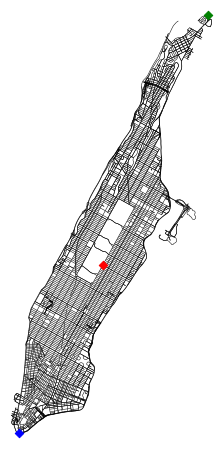

In [13]:
fig, ax = ox.plot_graph(inData.G, node_size=0, edge_linewidth=0.5,
                            show=False, close=False,
                            edge_color='black', bgcolor='white')
ax.scatter(center['x'], center['y'], c='red', marker='D')
ax.scatter(n1['x'], n1['y'], c='green', marker='D')
ax.scatter(n2['x'], n2['y'], c='blue', marker='D')

In [14]:
def centralise(df, center=center, x_name1='x_org', x_name2='x_dest', y_name1='y_org', y_name2='y_dest'):
    df[[x_name1, y_name1, x_name2, y_name2]] -= np.array(center[['x', 'y', 'x', 'y']])[0]
    return df

In [15]:
demand = list(map(centralise, demand))
demand[0][:10]

pickup_datetime     x_org     y_org    x_dest    y_dest
0 2016-01-01 00:00:17 -0.014909 -0.052994  0.028073  0.056529
1 2016-01-01 00:01:01  0.001837  0.028652  0.019543  0.042752
2 2016-01-01 00:01:14 -0.015204 -0.020887 -0.024066 -0.022113
3 2016-01-01 00:07:27 -0.015204 -0.020887 -0.018203 -0.033620
4 2016-01-01 00:01:20 -0.003039 -0.012818 -0.022135 -0.029410
5 2016-01-01 00:01:33 -0.017825  0.001703  0.030630  0.075417
6 2016-01-01 00:01:37 -0.005994 -0.008180 -0.007895 -0.010780
7 2016-01-01 00:01:47 -0.025943 -0.019597  0.012956  0.043900
8 2016-01-01 00:02:06 -0.018329 -0.036664  0.009228  0.038816
9 2016-01-01 00:02:45 -0.026707 -0.030838 -0.038502 -0.026640

In [16]:
e1 = [center.x.values[0] - n2.x.values[0], center.y.values[0] - n2.y.values[0]]
e1

[0.04694369999999992, 0.07096119999999928]

In [17]:
e2 = [center.y.values[0] - n2.y.values[0], -(center.x.values[0] - n2.x.values[0])]
# e2 = [x*0.2 for x in e1_perp]
e2

[0.07096119999999928, -0.04694369999999992]

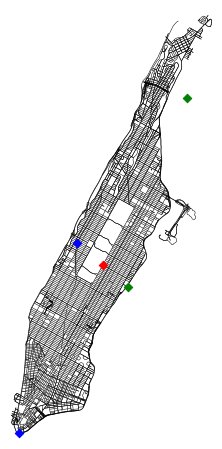

In [18]:
fig, ax = ox.plot_graph(inData.G, node_size=0, edge_linewidth=0.5,
                            show=False, close=False,
                            edge_color='black', bgcolor='white')
# ax.scatter(center['x'], center['y'], c='red', marker='D')
ax.scatter(center['x'], center['y'], c='red', marker='D')
ax.scatter(e1[0] + center['x'], e1[1] + center['y'], c='green', marker='D')
ax.scatter(-e1[0] + center['x'], -e1[1] + center['y'], c='blue', marker='D')
ax.scatter(e2[0]/5 + center['x'], e2[1]/5 + center['y'], c='green', marker='D')
ax.scatter(-e2[0]/5 + center['x'], -e2[1]/5 + center['y'], c='blue', marker='D')

In [19]:
orgs_x = [df['x_org'] for df in demand]
orgs_y = [df['y_org'] for df in demand]
orgs_x = [j for i in orgs_x for j in i]
orgs_y = [j for i in orgs_y for j in i]

(-0.1, 0.1)

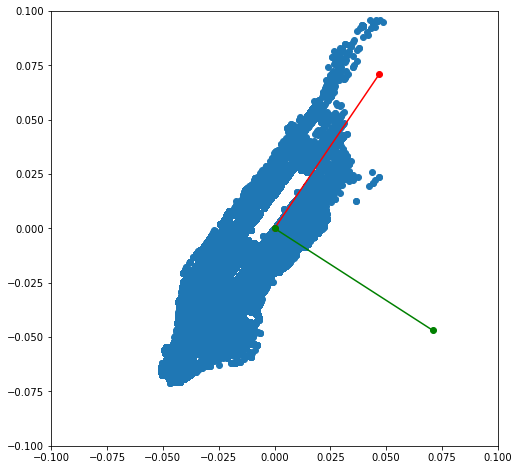

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(orgs_x, orgs_y)
ax.plot([0, e1[0]], [0,e1[1]], 'ro-')
ax.plot([0, e2[0]], [0,e2[1]], 'go-')
plt.xlim([-0.1, 0.1])
plt.ylim([-0.1, 0.1])

In [21]:
axis_matrix = 10000*np.matrix([e2, e1]).T
axis_matrix

matrix([[ 709.612,  469.437],
        [-469.437,  709.612]])

In [22]:
def foo(df, center=center, new_basis=axis_matrix, x_name1='x_org', x_name2='x_dest', y_name1='y_org', y_name2='y_dest'):
    df[[x_name1, y_name1]] = np.matmul(new_basis, df[[x_name1, y_name1]].T).T
    df[[x_name2, y_name2]] = np.matmul(new_basis, df[[x_name2, y_name2]].T).T
    return df

In [23]:
demand = list(map(foo, demand))
demand[0][:10]

pickup_datetime      x_org      y_org     x_dest     y_dest
0 2016-01-01 00:00:17 -35.456809 -30.606129  46.457554  26.934868
1 2016-01-01 00:01:01  14.753536  19.469257  33.937438  21.162535
2 2016-01-01 00:01:14 -20.593812  -7.684416 -27.458324  -4.394392
3 2016-01-01 00:07:27 -20.593812  -7.684416 -28.699798 -15.312231
4 2016-01-01 00:01:20  -8.174297  -7.669237 -29.513711 -10.478702
5 2016-01-01 00:01:33 -11.849195   9.576468  57.138356  39.137833
6 2016-01-01 00:01:37  -8.093434  -2.990396 -10.662493  -3.943387
7 2016-01-01 00:01:47 -27.609446  -1.727687  29.802087  25.070201
8 2016-01-01 00:02:06 -30.218459 -17.412953  24.769705  23.212711
9 2016-01-01 00:02:45 -33.428366  -9.345691 -39.827403  -0.829211

In [24]:
orgs_x = [df['x_org'] for df in demand]
orgs_y = [df['y_org'] for df in demand]
orgs_x = [j for i in orgs_x for j in i]
orgs_y = [j for i in orgs_y for j in i]

(-100.0, 100.0)

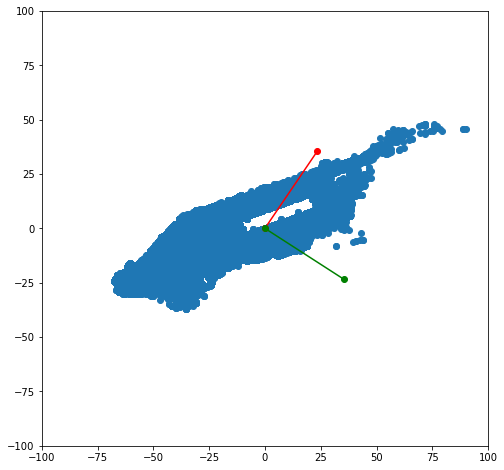

In [25]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(orgs_x, orgs_y)
ax.plot([0, 500*e1[0]], [0,500*e1[1]], 'ro-')
ax.plot([0, 500*e2[0]], [0,500*e2[1]], 'go-')
plt.xlim([-100, 100])
plt.ylim([-100, 100])

In [26]:
with open('demand_nyc_shifted.obj', 'wb') as demand_file:
  pickle.dump(demand, demand_file)

# Part VII

In [27]:
import pickle
import torch
import multiprocessing as mp
import utils
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
with open('demand_nyc_shifted.obj', 'rb') as file:
    demand = pickle.load(file)

In [29]:
with open('kpis_nyc.obj', 'rb') as file:
    exmas_res_extracted = pickle.load(file)

In [30]:
def foo(df):
    df['t']=df['pickup_datetime'] - datetime(2016, 1, 1, 0, 0, 0)
    df['t']=df['t'].apply(lambda x: int(x.total_seconds()))
    return df

In [31]:
demand = list(map(foo, demand))

In [32]:
demand[0][:3]

pickup_datetime      x_org      y_org     x_dest     y_dest   t
0 2016-01-01 00:00:17 -35.456809 -30.606129  46.457554  26.934868  17
1 2016-01-01 00:01:01  14.753536  19.469257  33.937438  21.162535  61
2 2016-01-01 00:01:14 -20.593812  -7.684416 -27.458324  -4.394392  74

### Create map

#### First approach

In [ ]:
origins = [d[['t', 'x_org', 'y_org']] for d in demand]
destinations = [d[['t', 'x_dest', 'y_dest']] for d in demand]

In [ ]:
grid = utils.create_space_grid(inData, 10)

pool = mp.Pool(mp.cpu_count())
map_origins = [pool.apply(utils.apply_space_grid, args=(data, grid, 'x_org', 'y_org')) for data in origins]
map_destinations = [pool.apply(utils.apply_space_grid, args=(data, grid, 'x_dest', 'y_dest')) for data in destinations]
pool.close()


demand_list_tensors = utils.merge_origins_destinations(map_origins, map_destinations)

#### Second approach

In [33]:
demand_list_tensors = utils.nyc_grid_apply(demand)

#### End of approach

In [34]:
demand_list_tensors[0].shape

torch.Size([2, 10, 20])

In [35]:
results_list_tensors = [torch.tensor(a) for a in exmas_res_extracted]
results_list_tensors[0]

tensor(0.3251)

In [36]:
whole_dataset = utils.WholeDataset(demand_list_tensors, results_list_tensors)
train_size = int(0.8 * len(whole_dataset))
test_size = len(whole_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(whole_dataset, [train_size, test_size])

In [37]:
next(iter(train_dataset))

(tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 1, 2, 6, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 1, 3, 2, 5, 4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 2, 9, 0, 2, 0, 1, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 1, 1, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]],
 
         [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 3, 1, 2, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 2, 2, 4, 4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 1, 2, 3, 2, 1, 1, 2, 4, 1, 0, 0, 0, 0, 0, 0,

In [38]:
torch.save(train_dataset, 'nyc_grid_shifted_train_dataset.pt')
torch.save(test_dataset, 'nyc_grid_shifted_test_dataset.pt')

<AxesSubplot:ylabel='Count'>

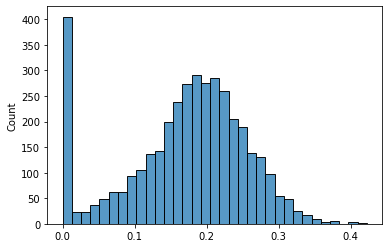

In [39]:
kpis = [train_dataset.dataset.labels[t] for t in train_dataset.indices]
kpis_plot = [float(k.numpy()) for k in kpis]
sns.histplot(kpis_plot)

In [40]:
import scipy 
kl = [k for k in kpis_plot if k > 0.02]
scipy.stats.normaltest(kl)

NormaltestResult(statistic=4.334556517994762, pvalue=0.11448880210301081)